In [1]:
import numpy as np
from PIL import Image
import os
import string
import csv
import re
from pickle import dump
from pickle import load
from keras.applications.xception import Xception #to get pre-trained model Xception
from keras.applications.xception import preprocess_input
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer #for text tokenization
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import add
from keras.models import Model, load_model
from keras.layers import Input, Dense#Keras to build our CNN and LSTM
from keras.layers import LSTM, Embedding, Dropout
from tqdm.notebook import tqdm #to check loop progress

2024-05-04 11:42:27.229050: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-04 11:42:27.983816: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-04 11:42:27.983916: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-04 11:42:28.026308: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-04 11:42:28.135366: I tensorflow/core/platform/cpu_feature_guar

In [2]:
def load_csv(filename):
    with open(filename, 'r', encoding='cp1252', errors='replace') as file:
        reader = csv.reader(file, delimiter='|')  
        next(reader, None)
        data = []
        for row in reader:
            if len(row) != 3:
                continue  # Skip problematic rows
            data.append(row)
    return data

def all_img_captions_csv(filename):
    data = load_csv(filename)
    descriptions = {}
    problematic_rows = []
    for i, row in enumerate(data):
        if len(row) != 3:
            problematic_rows.append((i, row))
            continue
        img, comment_number, caption = row
        img = img.strip()
        comment_number = comment_number.strip()
        # Process the caption
        if img not in descriptions:
            descriptions[img] = [caption]
        else:
            descriptions[img].append(caption)
    if problematic_rows:
        print("Problematic rows:")
        for idx, row in problematic_rows:
            print(f"Issue with row {idx}: {row}")
        print(f"Total problematic rows: {len(problematic_rows)}")
    return descriptions, len(problematic_rows)

def cleaning_text(captions):
    for img, caps in captions.items():
        for i, img_caption in enumerate(caps):
            img_caption = img_caption.replace("-", " ")
            # Remove escape sequences
            img_caption = re.sub(r'\\(.)', r'\1', img_caption)
            # Remove punctuation except spaces
            img_caption = ''.join([char if char not in string.punctuation else '' for char in img_caption])
            img_caption = img_caption.lower()
            # Add space after removing punctuations, excluding the last word
            words = img_caption.split()
            img_caption = ' '.join(words[:-1]) + ' ' + words[-1] if words else img_caption
            captions[img][i] = img_caption
    return captions


def text_vocabulary(descriptions):
    vocab = set()
    for key in descriptions.keys():
        [vocab.update(d.split()) for d in descriptions[key]]
    return vocab

def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for i, desc in enumerate(desc_list):
            if i == len(desc_list) - 1:
                lines.append(key + '\t' + desc)
            else:
                lines.append(key + '\t' + desc + ' ')
    data = "\n".join(lines)
    with open(filename, "w", encoding="utf-8") as file:
        file.write(data)


dataset_text = "/mnt/c/Users/sbboo/OneDrive/Desktop/ICG/Dataset/flickr30k_images"
dataset_images = "/mnt/c/Users/sbboo/OneDrive/Desktop/ICG/Dataset/flickr30k_images/flickr30k_images"
filename = dataset_text + "/" + "results.csv"

descriptions, num_problematic_rows = all_img_captions_csv(filename)
print("Number of skipped problematic rows:", num_problematic_rows)
print("Length of descriptions =", len(descriptions))

clean_descriptions = cleaning_text(descriptions)

vocabulary = text_vocabulary(clean_descriptions)
print("Length of vocabulary = ", len(vocabulary))

save_descriptions(clean_descriptions, "descriptions.txt")



Number of skipped problematic rows: 0
Length of descriptions = 31783
Length of vocabulary =  18320


In [3]:
import os
import numpy as np
from tqdm import tqdm
from PIL import Image
from keras.applications import Xception
import tensorflow as tf
from pickle import dump

def extract_features(directory):
    # Set TensorFlow to use GPU if available
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # Specify which GPU to use, if you have multiple GPUs
    
    # Configure TensorFlow to use GPU memory dynamically
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            print("GPU is available and will be used for computations.")
        except RuntimeError as e:
            print(e)
            print("GPU will not be used. Switching to CPU.")
    else:
        print("GPU is not available. Switching to CPU.")
    
    # Load the Xception model without the top layer
    model = Xception(include_top=False, pooling='avg')
    
    # Get the list of images in the directory
    image_files = os.listdir(directory)
    
    # Initialize tqdm to display the main progress bar
    progress_bar = tqdm(total=len(image_files), desc="Extracting features", unit="images", position=0, dynamic_ncols=True)
    
    # Dictionary to store extracted features
    features = {}
    
    # Batch size for updating progress bar
    batch_size = 10
    
    # Counter to track progress
    progress_counter = 0
    
    # Iterate over each image in the directory
    for img in image_files:
        # Load and preprocess the image
        filename = os.path.join(directory, img)
        image = Image.open(filename)
        image = image.resize((299, 299))
        image = np.expand_dims(image, axis=0)
        image = image / 127.5
        image = image - 1.0
        
        # Extract features using the Xception model
        feature = model.predict(image)
        
        # Store the extracted feature in the dictionary
        features[img] = feature
        
        # Update the main progress bar for each image processed
        progress_counter += 1
        progress_bar.update(1)
        
    # Close the main progress bar
    progress_bar.close()
    
    return features


In [4]:
#31783 feature vector
features = extract_features(dataset_images)
dump(features, open("features.p","wb"))

2024-05-04 11:42:36.215157: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-04 11:42:36.636090: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-04 11:42:36.636132: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-04 11:42:36.769165: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-04 11:42:36.769248: I external/local_xla/xla/stream_executor

GPU is available and will be used for computations.


_device.cc:2022] Could not identify NUMA node of platform GPU id 0, defaulting to 0.  Your kernel may not have been built with NUMA support.
2024-05-04 11:42:37.407783: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-04 11:42:37.408142: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1768 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
Extracting features:   0%|                                                                | 0/31783 [00:00<?, ?images/s]2024-05-04 11:42:40.902037: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-05-04 11:42:41.344673: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child pr

1/1 [==============================] - 4s 4s/step


Extracting features:   0%|                                                     | 1/31783 [00:03<33:06:30,  3.75s/images]

1/1 [==============================] - 0s 18ms/step


Extracting features:   0%|                                                      | 3/31783 [00:03<9:02:52,  1.02s/images]

1/1 [==============================] - 0s 18ms/step


Extracting features:   0%|                                                      | 5/31783 [00:04<4:41:58,  1.88images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   0%|                                                      | 7/31783 [00:04<2:58:00,  2.98images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   0%|                                                      | 9/31783 [00:04<2:04:22,  4.26images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   0%|                                                     | 11/31783 [00:04<1:34:12,  5.62images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   0%|                                                     | 13/31783 [00:04<1:15:24,  7.02images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:   0%|                                                     | 15/31783 [00:04<1:02:32,  8.47images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   0%|                                                       | 17/31783 [00:04<54:27,  9.72images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   0%|                                                       | 19/31783 [00:04<48:32, 10.91images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   0%|                                                       | 21/31783 [00:05<44:22, 11.93images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:   0%|                                                       | 23/31783 [00:05<41:42, 12.69images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   0%|                                                       | 25/31783 [00:05<40:30, 13.07images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:   0%|                                                       | 27/31783 [00:05<41:10, 12.86images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   0%|                                                       | 29/31783 [00:05<40:48, 12.97images/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:   0%|                                                       | 31/31783 [00:05<39:54, 13.26images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   0%|                                                       | 33/31783 [00:05<39:00, 13.57images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:   0%|                                                       | 35/31783 [00:06<38:56, 13.59images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   0%|                                                       | 37/31783 [00:06<38:37, 13.70images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   0%|                                                       | 39/31783 [00:06<38:30, 13.74images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   0%|                                                       | 41/31783 [00:06<38:52, 13.61images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:   0%|                                                       | 43/31783 [00:06<38:40, 13.68images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   0%|                                                       | 45/31783 [00:06<38:25, 13.77images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   0%|                                                       | 47/31783 [00:07<37:59, 13.92images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   0%|                                                       | 49/31783 [00:07<37:49, 13.98images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   0%|                                                       | 51/31783 [00:07<37:53, 13.96images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   0%|                                                       | 53/31783 [00:07<38:55, 13.59images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   0%|                                                       | 55/31783 [00:07<39:56, 13.24images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   0%|                                                       | 57/31783 [00:07<39:18, 13.45images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   0%|                                                       | 59/31783 [00:07<38:44, 13.65images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   0%|                                                       | 61/31783 [00:08<38:09, 13.85images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   0%|                                                       | 63/31783 [00:08<38:38, 13.68images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   0%|                                                       | 65/31783 [00:08<38:03, 13.89images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:   0%|                                                       | 67/31783 [00:08<38:00, 13.91images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   0%|                                                       | 69/31783 [00:08<39:04, 13.53images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   0%|                                                       | 71/31783 [00:08<40:34, 13.03images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   0%|▏                                                      | 73/31783 [00:08<39:57, 13.23images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   0%|▏                                                      | 75/31783 [00:09<39:23, 13.42images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   0%|▏                                                      | 77/31783 [00:09<38:46, 13.63images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   0%|▏                                                      | 79/31783 [00:09<38:13, 13.82images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   0%|▏                                                      | 81/31783 [00:09<38:33, 13.71images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:   0%|▏                                                      | 83/31783 [00:09<38:54, 13.58images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   0%|▏                                                      | 85/31783 [00:09<38:14, 13.81images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   0%|▏                                                      | 87/31783 [00:09<37:56, 13.93images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   0%|▏                                                      | 89/31783 [00:10<37:45, 13.99images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   0%|▏                                                      | 91/31783 [00:10<37:37, 14.04images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   0%|▏                                                      | 93/31783 [00:10<37:41, 14.01images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   0%|▏                                                      | 95/31783 [00:10<37:27, 14.10images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   0%|▏                                                      | 97/31783 [00:10<37:09, 14.21images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   0%|▏                                                      | 99/31783 [00:10<37:22, 14.13images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   0%|▏                                                     | 101/31783 [00:10<37:13, 14.19images/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:   0%|▏                                                     | 103/31783 [00:11<37:03, 14.25images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   0%|▏                                                     | 105/31783 [00:11<36:49, 14.34images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   0%|▏                                                     | 107/31783 [00:11<37:23, 14.12images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   0%|▏                                                     | 109/31783 [00:11<37:39, 14.02images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   0%|▏                                                     | 111/31783 [00:11<37:27, 14.09images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   0%|▏                                                     | 113/31783 [00:11<37:31, 14.07images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   0%|▏                                                     | 115/31783 [00:11<37:11, 14.19images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   0%|▏                                                     | 117/31783 [00:12<37:56, 13.91images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   0%|▏                                                     | 119/31783 [00:12<37:48, 13.96images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   0%|▏                                                     | 121/31783 [00:12<37:31, 14.07images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   0%|▏                                                     | 123/31783 [00:12<37:02, 14.24images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   0%|▏                                                     | 125/31783 [00:12<37:00, 14.26images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   0%|▏                                                     | 127/31783 [00:12<36:46, 14.35images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   0%|▏                                                     | 129/31783 [00:12<36:58, 14.27images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:   0%|▏                                                     | 131/31783 [00:13<36:56, 14.28images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   0%|▏                                                     | 133/31783 [00:13<36:43, 14.36images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   0%|▏                                                     | 135/31783 [00:13<36:54, 14.29images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   0%|▏                                                     | 137/31783 [00:13<36:44, 14.36images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   0%|▏                                                     | 139/31783 [00:13<36:39, 14.38images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   0%|▏                                                     | 141/31783 [00:13<36:49, 14.32images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   0%|▏                                                     | 143/31783 [00:13<37:06, 14.21images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   0%|▏                                                     | 145/31783 [00:14<37:28, 14.07images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   0%|▏                                                     | 147/31783 [00:14<37:39, 14.00images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   0%|▎                                                     | 149/31783 [00:14<37:20, 14.12images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   0%|▎                                                     | 151/31783 [00:14<37:20, 14.12images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   0%|▎                                                     | 153/31783 [00:14<37:41, 13.99images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   0%|▎                                                     | 155/31783 [00:14<37:42, 13.98images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   0%|▎                                                     | 157/31783 [00:14<37:44, 13.96images/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:   1%|▎                                                     | 159/31783 [00:15<37:41, 13.98images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   1%|▎                                                     | 161/31783 [00:15<37:52, 13.92images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   1%|▎                                                     | 163/31783 [00:15<37:51, 13.92images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   1%|▎                                                     | 165/31783 [00:15<37:16, 14.14images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   1%|▎                                                     | 167/31783 [00:15<37:42, 13.97images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   1%|▎                                                     | 169/31783 [00:15<37:29, 14.05images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   1%|▎                                                     | 171/31783 [00:15<37:40, 13.99images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   1%|▎                                                     | 173/31783 [00:16<37:27, 14.07images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   1%|▎                                                     | 175/31783 [00:16<37:53, 13.90images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   1%|▎                                                     | 177/31783 [00:16<37:54, 13.89images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   1%|▎                                                     | 179/31783 [00:16<37:44, 13.96images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   1%|▎                                                     | 181/31783 [00:16<37:37, 14.00images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   1%|▎                                                     | 183/31783 [00:16<37:30, 14.04images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   1%|▎                                                     | 185/31783 [00:16<37:18, 14.12images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   1%|▎                                                     | 187/31783 [00:17<37:15, 14.14images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   1%|▎                                                     | 189/31783 [00:17<37:27, 14.06images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   1%|▎                                                     | 191/31783 [00:17<37:32, 14.02images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:   1%|▎                                                     | 193/31783 [00:17<37:24, 14.08images/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:   1%|▎                                                     | 195/31783 [00:17<37:01, 14.22images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   1%|▎                                                     | 197/31783 [00:17<37:26, 14.06images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   1%|▎                                                     | 199/31783 [00:17<37:16, 14.12images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   1%|▎                                                     | 201/31783 [00:18<37:07, 14.18images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   1%|▎                                                     | 203/31783 [00:18<36:54, 14.26images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   1%|▎                                                     | 205/31783 [00:18<36:37, 14.37images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   1%|▎                                                     | 207/31783 [00:18<37:01, 14.21images/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:   1%|▎                                                     | 209/31783 [00:18<36:48, 14.30images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   1%|▎                                                     | 211/31783 [00:18<36:56, 14.24images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   1%|▎                                                     | 213/31783 [00:18<36:53, 14.26images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   1%|▎                                                     | 215/31783 [00:19<37:07, 14.17images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   1%|▎                                                     | 217/31783 [00:19<37:09, 14.16images/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:   1%|▎                                                     | 219/31783 [00:19<36:53, 14.26images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   1%|▍                                                     | 221/31783 [00:19<36:49, 14.29images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   1%|▍                                                     | 223/31783 [00:19<36:45, 14.31images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   1%|▍                                                     | 225/31783 [00:19<37:23, 14.07images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   1%|▍                                                     | 227/31783 [00:19<37:23, 14.07images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   1%|▍                                                     | 229/31783 [00:19<37:14, 14.12images/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:   1%|▍                                                     | 231/31783 [00:20<36:50, 14.27images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   1%|▍                                                     | 233/31783 [00:20<37:03, 14.19images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   1%|▍                                                     | 235/31783 [00:20<36:57, 14.23images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   1%|▍                                                     | 237/31783 [00:20<36:50, 14.27images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:   1%|▍                                                     | 239/31783 [00:20<36:46, 14.30images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   1%|▍                                                     | 241/31783 [00:20<37:00, 14.20images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   1%|▍                                                     | 243/31783 [00:20<37:32, 14.00images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   1%|▍                                                     | 245/31783 [00:21<37:20, 14.08images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   1%|▍                                                     | 247/31783 [00:21<37:10, 14.14images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   1%|▍                                                     | 249/31783 [00:21<37:07, 14.15images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:   1%|▍                                                     | 251/31783 [00:21<37:11, 14.13images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   1%|▍                                                     | 253/31783 [00:21<37:17, 14.09images/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:   1%|▍                                                     | 255/31783 [00:21<37:16, 14.10images/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:   1%|▍                                                     | 257/31783 [00:21<36:52, 14.25images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   1%|▍                                                     | 259/31783 [00:22<36:48, 14.28images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   1%|▍                                                     | 261/31783 [00:22<36:46, 14.29images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   1%|▍                                                     | 263/31783 [00:22<36:49, 14.27images/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:   1%|▍                                                     | 265/31783 [00:22<36:59, 14.20images/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:   1%|▍                                                     | 267/31783 [00:22<37:03, 14.17images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   1%|▍                                                     | 269/31783 [00:22<37:10, 14.13images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   1%|▍                                                     | 271/31783 [00:22<37:11, 14.12images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   1%|▍                                                     | 273/31783 [00:23<36:52, 14.24images/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:   1%|▍                                                     | 275/31783 [00:23<36:41, 14.31images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:   1%|▍                                                     | 277/31783 [00:23<36:21, 14.44images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   1%|▍                                                     | 279/31783 [00:23<37:00, 14.19images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   1%|▍                                                     | 281/31783 [00:23<37:03, 14.17images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   1%|▍                                                     | 283/31783 [00:23<37:11, 14.12images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   1%|▍                                                     | 285/31783 [00:23<37:30, 14.00images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   1%|▍                                                     | 287/31783 [00:24<38:05, 13.78images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   1%|▍                                                     | 289/31783 [00:24<37:54, 13.85images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   1%|▍                                                     | 291/31783 [00:24<37:31, 13.98images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   1%|▍                                                     | 293/31783 [00:24<38:12, 13.73images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   1%|▌                                                     | 295/31783 [00:24<38:56, 13.47images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   1%|▌                                                     | 297/31783 [00:24<40:17, 13.02images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   1%|▌                                                     | 299/31783 [00:24<39:24, 13.31images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   1%|▌                                                     | 301/31783 [00:25<38:54, 13.48images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   1%|▌                                                     | 303/31783 [00:25<38:03, 13.78images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   1%|▌                                                     | 305/31783 [00:25<38:11, 13.74images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   1%|▌                                                     | 307/31783 [00:25<37:48, 13.87images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   1%|▌                                                     | 309/31783 [00:25<37:34, 13.96images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   1%|▌                                                     | 311/31783 [00:25<37:39, 13.93images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:   1%|▌                                                     | 313/31783 [00:25<37:24, 14.02images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   1%|▌                                                     | 315/31783 [00:26<37:40, 13.92images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   1%|▌                                                     | 317/31783 [00:26<37:33, 13.96images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   1%|▌                                                     | 319/31783 [00:26<37:12, 14.09images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   1%|▌                                                     | 321/31783 [00:26<37:04, 14.14images/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:   1%|▌                                                     | 323/31783 [00:26<37:24, 14.02images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   1%|▌                                                     | 325/31783 [00:26<37:38, 13.93images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   1%|▌                                                     | 327/31783 [00:26<37:14, 14.08images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   1%|▌                                                     | 329/31783 [00:27<37:25, 14.01images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   1%|▌                                                     | 331/31783 [00:27<37:26, 14.00images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   1%|▌                                                     | 333/31783 [00:27<37:38, 13.92images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:   1%|▌                                                     | 335/31783 [00:27<39:14, 13.36images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:   1%|▌                                                     | 337/31783 [00:27<39:42, 13.20images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   1%|▌                                                     | 339/31783 [00:27<39:42, 13.20images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   1%|▌                                                     | 341/31783 [00:28<39:56, 13.12images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   1%|▌                                                     | 343/31783 [00:28<39:27, 13.28images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   1%|▌                                                     | 345/31783 [00:28<39:18, 13.33images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   1%|▌                                                     | 347/31783 [00:28<39:09, 13.38images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   1%|▌                                                     | 349/31783 [00:28<39:12, 13.36images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   1%|▌                                                     | 351/31783 [00:28<39:31, 13.25images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   1%|▌                                                     | 353/31783 [00:28<39:56, 13.11images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   1%|▌                                                     | 355/31783 [00:29<39:27, 13.28images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   1%|▌                                                     | 357/31783 [00:29<39:30, 13.26images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:   1%|▌                                                     | 359/31783 [00:29<39:50, 13.14images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:   1%|▌                                                     | 361/31783 [00:29<43:56, 11.92images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:   1%|▌                                                     | 363/31783 [00:29<46:39, 11.22images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:   1%|▌                                                     | 365/31783 [00:30<48:48, 10.73images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   1%|▌                                                     | 367/31783 [00:30<46:08, 11.35images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   1%|▋                                                     | 369/31783 [00:30<44:46, 11.70images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   1%|▋                                                     | 371/31783 [00:30<43:07, 12.14images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   1%|▋                                                     | 373/31783 [00:30<41:20, 12.66images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   1%|▋                                                     | 375/31783 [00:30<40:00, 13.08images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   1%|▋                                                     | 377/31783 [00:30<39:10, 13.36images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   1%|▋                                                     | 379/31783 [00:31<38:54, 13.45images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   1%|▋                                                     | 381/31783 [00:31<38:40, 13.53images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   1%|▋                                                     | 383/31783 [00:31<38:24, 13.63images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   1%|▋                                                     | 385/31783 [00:31<38:05, 13.74images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   1%|▋                                                     | 387/31783 [00:31<38:03, 13.75images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   1%|▋                                                     | 389/31783 [00:31<38:03, 13.75images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   1%|▋                                                     | 391/31783 [00:31<37:52, 13.81images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   1%|▋                                                     | 393/31783 [00:32<37:34, 13.92images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   1%|▋                                                     | 395/31783 [00:32<37:17, 14.03images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   1%|▋                                                     | 397/31783 [00:32<37:40, 13.88images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   1%|▋                                                     | 399/31783 [00:32<37:30, 13.95images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:   1%|▋                                                     | 401/31783 [00:32<37:23, 13.99images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   1%|▋                                                     | 403/31783 [00:32<37:04, 14.11images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   1%|▋                                                     | 405/31783 [00:32<37:21, 14.00images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   1%|▋                                                     | 407/31783 [00:33<37:20, 14.01images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   1%|▋                                                     | 409/31783 [00:33<37:13, 14.05images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   1%|▋                                                     | 411/31783 [00:33<37:01, 14.12images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   1%|▋                                                     | 413/31783 [00:33<36:55, 14.16images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   1%|▋                                                     | 415/31783 [00:33<37:19, 14.00images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   1%|▋                                                     | 417/31783 [00:33<37:05, 14.10images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   1%|▋                                                     | 419/31783 [00:33<36:53, 14.17images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:   1%|▋                                                     | 421/31783 [00:34<36:57, 14.14images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   1%|▋                                                     | 423/31783 [00:34<37:26, 13.96images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   1%|▋                                                     | 425/31783 [00:34<37:24, 13.97images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   1%|▋                                                     | 427/31783 [00:34<37:25, 13.97images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   1%|▋                                                     | 429/31783 [00:34<37:02, 14.11images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:   1%|▋                                                     | 431/31783 [00:34<36:38, 14.26images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   1%|▋                                                     | 433/31783 [00:34<37:33, 13.91images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   1%|▋                                                     | 435/31783 [00:35<38:01, 13.74images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   1%|▋                                                     | 437/31783 [00:35<38:01, 13.74images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   1%|▋                                                     | 439/31783 [00:35<37:45, 13.84images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   1%|▋                                                     | 441/31783 [00:35<38:08, 13.69images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   1%|▊                                                     | 443/31783 [00:35<38:04, 13.72images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   1%|▊                                                     | 445/31783 [00:35<38:04, 13.72images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   1%|▊                                                     | 447/31783 [00:35<37:33, 13.91images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   1%|▊                                                     | 449/31783 [00:36<37:25, 13.96images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   1%|▊                                                     | 451/31783 [00:36<37:47, 13.82images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   1%|▊                                                     | 453/31783 [00:36<38:00, 13.74images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   1%|▊                                                     | 455/31783 [00:36<37:41, 13.86images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   1%|▊                                                     | 457/31783 [00:36<37:16, 14.01images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   1%|▊                                                     | 459/31783 [00:36<37:22, 13.97images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   1%|▊                                                     | 461/31783 [00:36<37:15, 14.01images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   1%|▊                                                     | 463/31783 [00:37<37:30, 13.92images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   1%|▊                                                     | 465/31783 [00:37<38:05, 13.70images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:   1%|▊                                                     | 467/31783 [00:37<37:49, 13.80images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   1%|▊                                                     | 469/31783 [00:37<37:42, 13.84images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   1%|▊                                                     | 471/31783 [00:37<37:33, 13.90images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   1%|▊                                                     | 473/31783 [00:37<37:16, 14.00images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   1%|▊                                                     | 475/31783 [00:37<37:12, 14.02images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   2%|▊                                                     | 477/31783 [00:38<37:25, 13.94images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   2%|▊                                                     | 479/31783 [00:38<37:20, 13.97images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   2%|▊                                                     | 481/31783 [00:38<37:24, 13.95images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   2%|▊                                                     | 483/31783 [00:38<37:10, 14.03images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   2%|▊                                                     | 485/31783 [00:38<37:13, 14.01images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:   2%|▊                                                     | 487/31783 [00:38<53:58,  9.66images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:   2%|▊                                                     | 489/31783 [00:39<51:23, 10.15images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:   2%|▊                                                     | 491/31783 [00:39<52:09, 10.00images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:   2%|▊                                                     | 493/31783 [00:39<49:52, 10.46images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   2%|▊                                                     | 495/31783 [00:39<48:07, 10.83images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:   2%|▊                                                     | 497/31783 [00:39<48:33, 10.74images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:   2%|▊                                                     | 499/31783 [00:40<47:40, 10.94images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   2%|▊                                                     | 501/31783 [00:40<45:32, 11.45images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   2%|▊                                                     | 503/31783 [00:40<43:08, 12.09images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   2%|▊                                                     | 505/31783 [00:40<41:58, 12.42images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   2%|▊                                                     | 507/31783 [00:40<40:45, 12.79images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   2%|▊                                                     | 509/31783 [00:40<39:50, 13.08images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   2%|▊                                                     | 511/31783 [00:40<39:24, 13.22images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:   2%|▊                                                     | 513/31783 [00:41<54:59,  9.48images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:   2%|▊                                                     | 515/31783 [00:41<58:07,  8.96images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:   2%|▉                                                     | 517/31783 [00:41<58:29,  8.91images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:   2%|▉                                                     | 518/31783 [00:41<57:21,  9.08images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:   2%|▉                                                     | 520/31783 [00:42<52:43,  9.88images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   2%|▉                                                     | 522/31783 [00:42<49:24, 10.55images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:   2%|▉                                                     | 524/31783 [00:42<49:05, 10.61images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:   2%|▉                                                     | 526/31783 [00:42<48:18, 10.78images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   2%|▉                                                     | 528/31783 [00:42<45:18, 11.50images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   2%|▉                                                     | 530/31783 [00:42<42:41, 12.20images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   2%|▉                                                     | 532/31783 [00:43<41:23, 12.58images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   2%|▉                                                     | 534/31783 [00:43<40:22, 12.90images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   2%|▉                                                     | 536/31783 [00:43<39:37, 13.15images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   2%|▉                                                     | 538/31783 [00:43<39:06, 13.32images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   2%|▉                                                     | 540/31783 [00:43<38:36, 13.48images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:   2%|▉                                                     | 542/31783 [00:43<40:25, 12.88images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   2%|▉                                                     | 544/31783 [00:43<41:18, 12.61images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   2%|▉                                                     | 546/31783 [00:44<42:11, 12.34images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   2%|▉                                                     | 548/31783 [00:44<40:51, 12.74images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   2%|▉                                                     | 550/31783 [00:44<40:45, 12.77images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:   2%|▉                                                     | 552/31783 [00:44<40:04, 12.99images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   2%|▉                                                     | 554/31783 [00:44<39:23, 13.21images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   2%|▉                                                     | 556/31783 [00:44<38:39, 13.46images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:   2%|▉                                                     | 558/31783 [00:45<38:38, 13.47images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   2%|▉                                                     | 560/31783 [00:45<38:51, 13.39images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   2%|▉                                                     | 562/31783 [00:45<38:34, 13.49images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   2%|▉                                                     | 564/31783 [00:45<38:11, 13.62images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   2%|▉                                                     | 566/31783 [00:45<38:12, 13.62images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   2%|▉                                                     | 568/31783 [00:45<38:20, 13.57images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   2%|▉                                                     | 570/31783 [00:45<37:58, 13.70images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   2%|▉                                                     | 572/31783 [00:46<37:53, 13.73images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   2%|▉                                                     | 574/31783 [00:46<38:28, 13.52images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   2%|▉                                                     | 576/31783 [00:46<38:37, 13.46images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   2%|▉                                                     | 578/31783 [00:46<38:35, 13.48images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   2%|▉                                                     | 580/31783 [00:46<38:06, 13.65images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   2%|▉                                                     | 582/31783 [00:46<37:52, 13.73images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   2%|▉                                                     | 584/31783 [00:46<37:47, 13.76images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   2%|▉                                                     | 586/31783 [00:47<38:32, 13.49images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   2%|▉                                                     | 588/31783 [00:47<38:40, 13.44images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   2%|█                                                     | 590/31783 [00:47<38:00, 13.68images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   2%|█                                                     | 592/31783 [00:47<37:35, 13.83images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   2%|█                                                     | 594/31783 [00:47<37:14, 13.96images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   2%|█                                                     | 596/31783 [00:47<37:46, 13.76images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   2%|█                                                     | 598/31783 [00:47<37:41, 13.79images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   2%|█                                                     | 600/31783 [00:48<37:31, 13.85images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   2%|█                                                     | 602/31783 [00:48<37:11, 13.98images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   2%|█                                                     | 604/31783 [00:48<37:18, 13.93images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   2%|█                                                     | 606/31783 [00:48<37:23, 13.90images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   2%|█                                                     | 608/31783 [00:48<37:09, 13.98images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   2%|█                                                     | 610/31783 [00:48<37:16, 13.94images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   2%|█                                                     | 612/31783 [00:48<37:28, 13.86images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   2%|█                                                     | 614/31783 [00:49<37:38, 13.80images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   2%|█                                                     | 616/31783 [00:49<37:39, 13.79images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   2%|█                                                     | 618/31783 [00:49<37:46, 13.75images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   2%|█                                                     | 620/31783 [00:49<37:20, 13.91images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   2%|█                                                     | 622/31783 [00:49<37:31, 13.84images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   2%|█                                                     | 624/31783 [00:49<37:40, 13.78images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   2%|█                                                     | 626/31783 [00:49<38:13, 13.59images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   2%|█                                                     | 628/31783 [00:50<37:54, 13.70images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   2%|█                                                     | 630/31783 [00:50<38:03, 13.64images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   2%|█                                                     | 632/31783 [00:50<37:58, 13.67images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   2%|█                                                     | 634/31783 [00:50<37:43, 13.76images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   2%|█                                                     | 636/31783 [00:50<37:33, 13.82images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   2%|█                                                     | 638/31783 [00:50<37:14, 13.94images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   2%|█                                                     | 640/31783 [00:50<37:56, 13.68images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   2%|█                                                     | 642/31783 [00:51<37:44, 13.75images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   2%|█                                                     | 644/31783 [00:51<37:39, 13.78images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   2%|█                                                     | 646/31783 [00:51<37:37, 13.80images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   2%|█                                                     | 648/31783 [00:51<37:35, 13.81images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   2%|█                                                     | 650/31783 [00:51<38:11, 13.59images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   2%|█                                                     | 652/31783 [00:51<38:08, 13.60images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   2%|█                                                     | 654/31783 [00:51<37:54, 13.68images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:   2%|█                                                     | 656/31783 [00:52<37:28, 13.84images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   2%|█                                                     | 658/31783 [00:52<37:49, 13.71images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   2%|█                                                     | 660/31783 [00:52<37:44, 13.74images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:   2%|█                                                     | 662/31783 [00:52<37:54, 13.69images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   2%|█▏                                                    | 664/31783 [00:52<37:56, 13.67images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   2%|█▏                                                    | 666/31783 [00:52<37:46, 13.73images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   2%|█▏                                                    | 668/31783 [00:53<37:42, 13.75images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   2%|█▏                                                    | 670/31783 [00:53<37:30, 13.82images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   2%|█▏                                                    | 672/31783 [00:53<37:31, 13.82images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   2%|█▏                                                    | 674/31783 [00:53<37:22, 13.87images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   2%|█▏                                                    | 676/31783 [00:53<37:58, 13.65images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   2%|█▏                                                    | 678/31783 [00:53<38:01, 13.63images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   2%|█▏                                                    | 680/31783 [00:53<38:04, 13.61images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:   2%|█▏                                                    | 682/31783 [00:54<37:55, 13.67images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   2%|█▏                                                    | 684/31783 [00:54<37:55, 13.67images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   2%|█▏                                                    | 686/31783 [00:54<38:16, 13.54images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   2%|█▏                                                    | 688/31783 [00:54<38:06, 13.60images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   2%|█▏                                                    | 690/31783 [00:54<38:05, 13.60images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   2%|█▏                                                    | 692/31783 [00:54<37:41, 13.75images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:   2%|█▏                                                    | 694/31783 [00:54<38:04, 13.61images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   2%|█▏                                                    | 696/31783 [00:55<38:14, 13.55images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   2%|█▏                                                    | 698/31783 [00:55<37:46, 13.72images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   2%|█▏                                                    | 700/31783 [00:55<37:35, 13.78images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   2%|█▏                                                    | 702/31783 [00:55<37:10, 13.93images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   2%|█▏                                                    | 704/31783 [00:55<37:38, 13.76images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   2%|█▏                                                    | 706/31783 [00:55<37:30, 13.81images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   2%|█▏                                                    | 708/31783 [00:55<37:25, 13.84images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   2%|█▏                                                    | 710/31783 [00:56<37:20, 13.87images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   2%|█▏                                                    | 712/31783 [00:56<37:36, 13.77images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   2%|█▏                                                    | 714/31783 [00:56<37:30, 13.80images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   2%|█▏                                                    | 716/31783 [00:56<37:19, 13.87images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   2%|█▏                                                    | 718/31783 [00:56<37:08, 13.94images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   2%|█▏                                                    | 720/31783 [00:56<36:35, 14.15images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   2%|█▏                                                    | 722/31783 [00:56<37:03, 13.97images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   2%|█▏                                                    | 724/31783 [00:57<37:02, 13.98images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   2%|█▏                                                    | 726/31783 [00:57<37:09, 13.93images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   2%|█▏                                                    | 728/31783 [00:57<36:58, 14.00images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   2%|█▏                                                    | 730/31783 [00:57<38:01, 13.61images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   2%|█▏                                                    | 732/31783 [00:57<38:11, 13.55images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   2%|█▏                                                    | 734/31783 [00:57<37:46, 13.70images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   2%|█▎                                                    | 736/31783 [00:57<37:30, 13.79images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   2%|█▎                                                    | 738/31783 [00:58<37:20, 13.85images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   2%|█▎                                                    | 740/31783 [00:58<37:53, 13.66images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   2%|█▎                                                    | 742/31783 [00:58<37:59, 13.62images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   2%|█▎                                                    | 744/31783 [00:58<38:08, 13.56images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   2%|█▎                                                    | 746/31783 [00:58<37:57, 13.63images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   2%|█▎                                                    | 748/31783 [00:58<38:09, 13.56images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   2%|█▎                                                    | 750/31783 [00:58<37:58, 13.62images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   2%|█▎                                                    | 752/31783 [00:59<38:11, 13.54images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   2%|█▎                                                    | 754/31783 [00:59<37:43, 13.71images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   2%|█▎                                                    | 756/31783 [00:59<37:31, 13.78images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   2%|█▎                                                    | 758/31783 [00:59<37:43, 13.70images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   2%|█▎                                                    | 760/31783 [00:59<37:37, 13.74images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   2%|█▎                                                    | 762/31783 [00:59<37:17, 13.87images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   2%|█▎                                                    | 764/31783 [00:59<37:21, 13.84images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   2%|█▎                                                    | 766/31783 [01:00<37:56, 13.62images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   2%|█▎                                                    | 768/31783 [01:00<37:45, 13.69images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   2%|█▎                                                    | 770/31783 [01:00<37:21, 13.84images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   2%|█▎                                                    | 772/31783 [01:00<37:18, 13.85images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   2%|█▎                                                    | 774/31783 [01:00<37:09, 13.91images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   2%|█▎                                                    | 776/31783 [01:00<37:40, 13.72images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   2%|█▎                                                    | 778/31783 [01:01<37:31, 13.77images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   2%|█▎                                                    | 780/31783 [01:01<37:43, 13.69images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   2%|█▎                                                    | 782/31783 [01:01<37:34, 13.75images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   2%|█▎                                                    | 784/31783 [01:01<37:36, 13.74images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   2%|█▎                                                    | 786/31783 [01:01<37:39, 13.72images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   2%|█▎                                                    | 788/31783 [01:01<37:38, 13.73images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   2%|█▎                                                    | 790/31783 [01:01<37:18, 13.85images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   2%|█▎                                                    | 792/31783 [01:02<37:02, 13.94images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   2%|█▎                                                    | 794/31783 [01:02<37:45, 13.68images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   3%|█▎                                                    | 796/31783 [01:02<37:37, 13.73images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   3%|█▎                                                    | 798/31783 [01:02<37:13, 13.87images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   3%|█▎                                                    | 800/31783 [01:02<37:02, 13.94images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   3%|█▎                                                    | 802/31783 [01:02<37:19, 13.84images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   3%|█▎                                                    | 804/31783 [01:02<37:16, 13.85images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   3%|█▎                                                    | 806/31783 [01:03<37:06, 13.91images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   3%|█▎                                                    | 808/31783 [01:03<37:17, 13.85images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   3%|█▍                                                    | 810/31783 [01:03<36:54, 13.99images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   3%|█▍                                                    | 812/31783 [01:03<37:33, 13.74images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   3%|█▍                                                    | 814/31783 [01:03<37:32, 13.75images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   3%|█▍                                                    | 816/31783 [01:03<38:02, 13.57images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   3%|█▍                                                    | 818/31783 [01:03<37:34, 13.73images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:   3%|█▍                                                    | 820/31783 [01:04<38:08, 13.53images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   3%|█▍                                                    | 822/31783 [01:04<37:47, 13.65images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   3%|█▍                                                    | 824/31783 [01:04<37:47, 13.65images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   3%|█▍                                                    | 826/31783 [01:04<37:27, 13.77images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   3%|█▍                                                    | 828/31783 [01:04<37:11, 13.87images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   3%|█▍                                                    | 830/31783 [01:04<37:59, 13.58images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   3%|█▍                                                    | 832/31783 [01:04<37:35, 13.72images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   3%|█▍                                                    | 834/31783 [01:05<37:52, 13.62images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   3%|█▍                                                    | 836/31783 [01:05<37:36, 13.72images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   3%|█▍                                                    | 838/31783 [01:05<37:43, 13.67images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   3%|█▍                                                    | 840/31783 [01:05<37:30, 13.75images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   3%|█▍                                                    | 842/31783 [01:05<37:36, 13.71images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   3%|█▍                                                    | 844/31783 [01:05<37:20, 13.81images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   3%|█▍                                                    | 846/31783 [01:05<36:54, 13.97images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   3%|█▍                                                    | 848/31783 [01:06<38:01, 13.56images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   3%|█▍                                                    | 850/31783 [01:06<38:04, 13.54images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   3%|█▍                                                    | 852/31783 [01:06<37:55, 13.59images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   3%|█▍                                                    | 854/31783 [01:06<37:30, 13.74images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   3%|█▍                                                    | 856/31783 [01:06<37:28, 13.76images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   3%|█▍                                                    | 858/31783 [01:06<38:18, 13.46images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   3%|█▍                                                    | 860/31783 [01:06<38:14, 13.48images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   3%|█▍                                                    | 862/31783 [01:07<37:53, 13.60images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   3%|█▍                                                    | 864/31783 [01:07<37:45, 13.65images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   3%|█▍                                                    | 866/31783 [01:07<38:01, 13.55images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   3%|█▍                                                    | 868/31783 [01:07<37:38, 13.69images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:   3%|█▍                                                    | 870/31783 [01:07<37:22, 13.78images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   3%|█▍                                                    | 872/31783 [01:07<37:14, 13.83images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   3%|█▍                                                    | 874/31783 [01:08<36:45, 14.01images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   3%|█▍                                                    | 876/31783 [01:08<37:09, 13.86images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   3%|█▍                                                    | 878/31783 [01:08<37:14, 13.83images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:   3%|█▍                                                    | 880/31783 [01:08<37:17, 13.81images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   3%|█▍                                                    | 882/31783 [01:08<36:42, 14.03images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:   3%|█▌                                                    | 884/31783 [01:08<37:08, 13.87images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   3%|█▌                                                    | 886/31783 [01:08<37:44, 13.64images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   3%|█▌                                                    | 888/31783 [01:09<37:53, 13.59images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   3%|█▌                                                    | 890/31783 [01:09<37:37, 13.69images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:   3%|█▌                                                    | 892/31783 [01:09<37:42, 13.66images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   3%|█▌                                                    | 894/31783 [01:09<37:47, 13.62images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   3%|█▌                                                    | 896/31783 [01:09<37:41, 13.65images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   3%|█▌                                                    | 898/31783 [01:09<38:24, 13.40images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   3%|█▌                                                    | 900/31783 [01:09<37:59, 13.55images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   3%|█▌                                                    | 902/31783 [01:10<37:44, 13.64images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   3%|█▌                                                    | 904/31783 [01:10<37:42, 13.65images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:   3%|█▌                                                    | 906/31783 [01:10<37:17, 13.80images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   3%|█▌                                                    | 908/31783 [01:10<37:17, 13.80images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   3%|█▌                                                    | 910/31783 [01:10<37:28, 13.73images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   3%|█▌                                                    | 912/31783 [01:10<38:45, 13.27images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   3%|█▌                                                    | 914/31783 [01:10<38:19, 13.42images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   3%|█▌                                                    | 916/31783 [01:11<37:56, 13.56images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   3%|█▌                                                    | 918/31783 [01:11<37:30, 13.72images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   3%|█▌                                                    | 920/31783 [01:11<37:34, 13.69images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   3%|█▌                                                    | 922/31783 [01:11<37:45, 13.62images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   3%|█▌                                                    | 924/31783 [01:11<37:50, 13.59images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   3%|█▌                                                    | 926/31783 [01:11<37:26, 13.74images/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:   3%|█▌                                                    | 928/31783 [01:11<37:02, 13.88images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:   3%|█▌                                                    | 930/31783 [01:12<38:06, 13.49images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   3%|█▌                                                    | 932/31783 [01:12<38:02, 13.52images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   3%|█▌                                                    | 934/31783 [01:12<37:48, 13.60images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   3%|█▌                                                    | 936/31783 [01:12<37:36, 13.67images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   3%|█▌                                                    | 938/31783 [01:12<37:59, 13.53images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   3%|█▌                                                    | 940/31783 [01:12<38:20, 13.41images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   3%|█▌                                                    | 942/31783 [01:12<37:57, 13.54images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   3%|█▌                                                    | 944/31783 [01:13<37:22, 13.75images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   3%|█▌                                                    | 946/31783 [01:13<37:17, 13.78images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   3%|█▌                                                    | 948/31783 [01:13<37:32, 13.69images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   3%|█▌                                                    | 950/31783 [01:13<37:27, 13.72images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   3%|█▌                                                    | 952/31783 [01:13<37:08, 13.84images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   3%|█▌                                                    | 954/31783 [01:13<37:09, 13.83images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   3%|█▌                                                    | 956/31783 [01:14<36:58, 13.90images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   3%|█▋                                                    | 958/31783 [01:14<37:03, 13.87images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   3%|█▋                                                    | 960/31783 [01:14<37:01, 13.88images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   3%|█▋                                                    | 962/31783 [01:14<37:01, 13.87images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   3%|█▋                                                    | 964/31783 [01:14<36:45, 13.97images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   3%|█▋                                                    | 966/31783 [01:14<37:02, 13.86images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   3%|█▋                                                    | 968/31783 [01:14<36:49, 13.95images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   3%|█▋                                                    | 970/31783 [01:15<36:59, 13.88images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   3%|█▋                                                    | 972/31783 [01:15<37:11, 13.81images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   3%|█▋                                                    | 974/31783 [01:15<36:46, 13.96images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   3%|█▋                                                    | 976/31783 [01:15<37:07, 13.83images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   3%|█▋                                                    | 978/31783 [01:15<37:00, 13.87images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   3%|█▋                                                    | 980/31783 [01:15<37:36, 13.65images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   3%|█▋                                                    | 982/31783 [01:15<36:58, 13.88images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:   3%|█▋                                                    | 984/31783 [01:16<37:01, 13.86images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   3%|█▋                                                    | 986/31783 [01:16<36:46, 13.96images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   3%|█▋                                                    | 988/31783 [01:16<37:01, 13.86images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   3%|█▋                                                    | 990/31783 [01:16<36:40, 13.99images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   3%|█▋                                                    | 992/31783 [01:16<36:48, 13.95images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   3%|█▋                                                    | 994/31783 [01:16<37:29, 13.68images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   3%|█▋                                                    | 996/31783 [01:16<37:17, 13.76images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   3%|█▋                                                    | 998/31783 [01:17<36:55, 13.90images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   3%|█▋                                                   | 1000/31783 [01:17<36:27, 14.08images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   3%|█▋                                                   | 1002/31783 [01:17<36:31, 14.05images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   3%|█▋                                                   | 1004/31783 [01:17<36:34, 14.03images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   3%|█▋                                                   | 1006/31783 [01:17<36:29, 14.06images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   3%|█▋                                                   | 1008/31783 [01:17<36:31, 14.04images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   3%|█▋                                                   | 1010/31783 [01:17<36:26, 14.08images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   3%|█▋                                                   | 1012/31783 [01:18<37:05, 13.82images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   3%|█▋                                                   | 1014/31783 [01:18<37:00, 13.86images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   3%|█▋                                                   | 1016/31783 [01:18<37:04, 13.83images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   3%|█▋                                                   | 1018/31783 [01:18<36:41, 13.97images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   3%|█▋                                                   | 1020/31783 [01:18<36:55, 13.88images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   3%|█▋                                                   | 1022/31783 [01:18<37:07, 13.81images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   3%|█▋                                                   | 1024/31783 [01:18<37:06, 13.81images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   3%|█▋                                                   | 1026/31783 [01:19<36:38, 13.99images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   3%|█▋                                                   | 1028/31783 [01:19<36:22, 14.09images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   3%|█▋                                                   | 1030/31783 [01:19<37:09, 13.79images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   3%|█▋                                                   | 1032/31783 [01:19<37:06, 13.81images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   3%|█▋                                                   | 1034/31783 [01:19<36:50, 13.91images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   3%|█▋                                                   | 1036/31783 [01:19<36:47, 13.93images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   3%|█▋                                                   | 1038/31783 [01:19<37:26, 13.69images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   3%|█▋                                                   | 1040/31783 [01:20<37:27, 13.68images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   3%|█▋                                                   | 1042/31783 [01:20<37:20, 13.72images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   3%|█▋                                                   | 1044/31783 [01:20<37:14, 13.75images/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:   3%|█▋                                                   | 1046/31783 [01:20<36:49, 13.91images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   3%|█▋                                                   | 1048/31783 [01:20<36:57, 13.86images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   3%|█▊                                                   | 1050/31783 [01:20<36:50, 13.90images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   3%|█▊                                                   | 1052/31783 [01:20<36:49, 13.91images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   3%|█▊                                                   | 1054/31783 [01:21<36:35, 13.99images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   3%|█▊                                                   | 1056/31783 [01:21<36:49, 13.91images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   3%|█▊                                                   | 1058/31783 [01:21<37:17, 13.73images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   3%|█▊                                                   | 1060/31783 [01:21<37:45, 13.56images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   3%|█▊                                                   | 1062/31783 [01:21<37:23, 13.69images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   3%|█▊                                                   | 1064/31783 [01:21<36:53, 13.88images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   3%|█▊                                                   | 1066/31783 [01:21<36:48, 13.91images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:   3%|█▊                                                   | 1068/31783 [01:22<36:49, 13.90images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   3%|█▊                                                   | 1070/31783 [01:22<36:49, 13.90images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   3%|█▊                                                   | 1072/31783 [01:22<36:43, 13.94images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   3%|█▊                                                   | 1074/31783 [01:22<36:17, 14.11images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   3%|█▊                                                   | 1076/31783 [01:22<36:34, 13.99images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   3%|█▊                                                   | 1078/31783 [01:22<36:20, 14.08images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   3%|█▊                                                   | 1080/31783 [01:22<36:08, 14.16images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   3%|█▊                                                   | 1082/31783 [01:23<36:00, 14.21images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   3%|█▊                                                   | 1084/31783 [01:23<36:44, 13.93images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   3%|█▊                                                   | 1086/31783 [01:23<36:35, 13.98images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   3%|█▊                                                   | 1088/31783 [01:23<36:24, 14.05images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   3%|█▊                                                   | 1090/31783 [01:23<36:09, 14.15images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   3%|█▊                                                   | 1092/31783 [01:23<36:03, 14.19images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   3%|█▊                                                   | 1094/31783 [01:23<36:16, 14.10images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   3%|█▊                                                   | 1096/31783 [01:24<36:40, 13.94images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   3%|█▊                                                   | 1098/31783 [01:24<36:42, 13.93images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   3%|█▊                                                   | 1100/31783 [01:24<36:30, 14.00images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   3%|█▊                                                   | 1102/31783 [01:24<36:54, 13.85images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   3%|█▊                                                   | 1104/31783 [01:24<36:51, 13.87images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   3%|█▊                                                   | 1106/31783 [01:24<37:04, 13.79images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   3%|█▊                                                   | 1108/31783 [01:24<36:57, 13.83images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   3%|█▊                                                   | 1110/31783 [01:25<36:42, 13.92images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   3%|█▊                                                   | 1112/31783 [01:25<37:10, 13.75images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   4%|█▊                                                   | 1114/31783 [01:25<37:09, 13.75images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   4%|█▊                                                   | 1116/31783 [01:25<37:20, 13.69images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   4%|█▊                                                   | 1118/31783 [01:25<36:55, 13.84images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   4%|█▊                                                   | 1120/31783 [01:25<37:22, 13.67images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   4%|█▊                                                   | 1122/31783 [01:25<37:02, 13.79images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   4%|█▊                                                   | 1124/31783 [01:26<37:00, 13.81images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   4%|█▉                                                   | 1126/31783 [01:26<37:02, 13.79images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   4%|█▉                                                   | 1128/31783 [01:26<36:46, 13.89images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   4%|█▉                                                   | 1130/31783 [01:26<38:06, 13.41images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   4%|█▉                                                   | 1132/31783 [01:26<37:31, 13.62images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   4%|█▉                                                   | 1134/31783 [01:26<37:20, 13.68images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   4%|█▉                                                   | 1136/31783 [01:26<38:05, 13.41images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   4%|█▉                                                   | 1138/31783 [01:27<37:48, 13.51images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   4%|█▉                                                   | 1140/31783 [01:27<37:21, 13.67images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   4%|█▉                                                   | 1142/31783 [01:27<36:50, 13.86images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   4%|█▉                                                   | 1144/31783 [01:27<36:46, 13.89images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   4%|█▉                                                   | 1146/31783 [01:27<36:27, 14.01images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   4%|█▉                                                   | 1148/31783 [01:27<36:54, 13.83images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   4%|█▉                                                   | 1150/31783 [01:27<36:49, 13.87images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   4%|█▉                                                   | 1152/31783 [01:28<36:28, 14.00images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   4%|█▉                                                   | 1154/31783 [01:28<36:19, 14.05images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   4%|█▉                                                   | 1156/31783 [01:28<36:49, 13.86images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   4%|█▉                                                   | 1158/31783 [01:28<36:45, 13.88images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:   4%|█▉                                                   | 1160/31783 [01:28<36:43, 13.90images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   4%|█▉                                                   | 1162/31783 [01:28<36:49, 13.86images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   4%|█▉                                                   | 1164/31783 [01:28<36:30, 13.98images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   4%|█▉                                                   | 1166/31783 [01:29<36:57, 13.81images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   4%|█▉                                                   | 1168/31783 [01:29<36:56, 13.81images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   4%|█▉                                                   | 1170/31783 [01:29<36:53, 13.83images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   4%|█▉                                                   | 1172/31783 [01:29<36:38, 13.92images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   4%|█▉                                                   | 1174/31783 [01:29<36:50, 13.85images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   4%|█▉                                                   | 1176/31783 [01:29<36:51, 13.84images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   4%|█▉                                                   | 1178/31783 [01:30<36:38, 13.92images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   4%|█▉                                                   | 1180/31783 [01:30<36:30, 13.97images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   4%|█▉                                                   | 1182/31783 [01:30<36:25, 14.00images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   4%|█▉                                                   | 1184/31783 [01:30<37:03, 13.76images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   4%|█▉                                                   | 1186/31783 [01:30<37:00, 13.78images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   4%|█▉                                                   | 1188/31783 [01:30<36:53, 13.82images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   4%|█▉                                                   | 1190/31783 [01:30<36:22, 14.01images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   4%|█▉                                                   | 1192/31783 [01:31<36:37, 13.92images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   4%|█▉                                                   | 1194/31783 [01:31<36:27, 13.98images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:   4%|█▉                                                   | 1196/31783 [01:31<36:40, 13.90images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   4%|█▉                                                   | 1198/31783 [01:31<36:43, 13.88images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:   4%|██                                                   | 1200/31783 [01:31<36:32, 13.95images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   4%|██                                                   | 1202/31783 [01:31<36:54, 13.81images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   4%|██                                                   | 1204/31783 [01:31<36:51, 13.83images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   4%|██                                                   | 1206/31783 [01:32<36:42, 13.88images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   4%|██                                                   | 1208/31783 [01:32<36:23, 14.00images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   4%|██                                                   | 1210/31783 [01:32<36:55, 13.80images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   4%|██                                                   | 1212/31783 [01:32<36:35, 13.92images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   4%|██                                                   | 1214/31783 [01:32<37:35, 13.55images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   4%|██                                                   | 1216/31783 [01:32<37:51, 13.45images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   4%|██                                                   | 1218/31783 [01:32<37:10, 13.71images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   4%|██                                                   | 1220/31783 [01:33<37:07, 13.72images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   4%|██                                                   | 1222/31783 [01:33<36:48, 13.84images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   4%|██                                                   | 1224/31783 [01:33<36:47, 13.84images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   4%|██                                                   | 1226/31783 [01:33<36:44, 13.86images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   4%|██                                                   | 1228/31783 [01:33<36:18, 14.03images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   4%|██                                                   | 1230/31783 [01:33<36:58, 13.77images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   4%|██                                                   | 1232/31783 [01:33<37:04, 13.74images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   4%|██                                                   | 1234/31783 [01:34<36:56, 13.78images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   4%|██                                                   | 1236/31783 [01:34<36:51, 13.81images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   4%|██                                                   | 1238/31783 [01:34<37:04, 13.73images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   4%|██                                                   | 1240/31783 [01:34<37:12, 13.68images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   4%|██                                                   | 1242/31783 [01:34<37:19, 13.64images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   4%|██                                                   | 1244/31783 [01:34<37:19, 13.64images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   4%|██                                                   | 1246/31783 [01:34<37:14, 13.67images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   4%|██                                                   | 1248/31783 [01:35<37:11, 13.69images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   4%|██                                                   | 1250/31783 [01:35<37:06, 13.72images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   4%|██                                                   | 1252/31783 [01:35<37:20, 13.63images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   4%|██                                                   | 1254/31783 [01:35<37:18, 13.64images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   4%|██                                                   | 1256/31783 [01:35<37:10, 13.68images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   4%|██                                                   | 1258/31783 [01:35<37:01, 13.74images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   4%|██                                                   | 1260/31783 [01:35<36:46, 13.83images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   4%|██                                                   | 1262/31783 [01:36<36:38, 13.88images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   4%|██                                                   | 1264/31783 [01:36<36:25, 13.96images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   4%|██                                                   | 1266/31783 [01:36<37:03, 13.72images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   4%|██                                                   | 1268/31783 [01:36<36:46, 13.83images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   4%|██                                                   | 1270/31783 [01:36<36:51, 13.80images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   4%|██                                                   | 1272/31783 [01:36<36:29, 13.94images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   4%|██                                                   | 1274/31783 [01:36<36:59, 13.75images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   4%|██▏                                                  | 1276/31783 [01:37<36:51, 13.80images/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:   4%|██▏                                                  | 1278/31783 [01:37<36:27, 13.94images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   4%|██▏                                                  | 1280/31783 [01:37<36:30, 13.93images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   4%|██▏                                                  | 1282/31783 [01:37<36:19, 13.99images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   4%|██▏                                                  | 1284/31783 [01:37<50:23, 10.09images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   4%|██▏                                                  | 1286/31783 [01:38<47:04, 10.80images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   4%|██▏                                                  | 1288/31783 [01:38<44:39, 11.38images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   4%|██▏                                                  | 1290/31783 [01:38<43:42, 11.63images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   4%|██▏                                                  | 1292/31783 [01:38<42:06, 12.07images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   4%|██▏                                                  | 1294/31783 [01:38<41:19, 12.29images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   4%|██▏                                                  | 1296/31783 [01:38<40:18, 12.61images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   4%|██▏                                                  | 1298/31783 [01:38<39:37, 12.82images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   4%|██▏                                                  | 1300/31783 [01:39<39:02, 13.01images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   4%|██▏                                                  | 1302/31783 [01:39<39:10, 12.97images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   4%|██▏                                                  | 1304/31783 [01:39<38:51, 13.07images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   4%|██▏                                                  | 1306/31783 [01:39<38:31, 13.19images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:   4%|██▏                                                  | 1308/31783 [01:39<38:13, 13.29images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   4%|██▏                                                  | 1310/31783 [01:39<38:19, 13.25images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   4%|██▏                                                  | 1312/31783 [01:39<38:56, 13.04images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   4%|██▏                                                  | 1314/31783 [01:40<38:38, 13.14images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   4%|██▏                                                  | 1316/31783 [01:40<38:25, 13.22images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   4%|██▏                                                  | 1318/31783 [01:40<38:03, 13.34images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   4%|██▏                                                  | 1320/31783 [01:40<38:07, 13.32images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   4%|██▏                                                  | 1322/31783 [01:40<38:17, 13.26images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   4%|██▏                                                  | 1324/31783 [01:40<38:04, 13.33images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   4%|██▏                                                  | 1326/31783 [01:41<38:08, 13.31images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   4%|██▏                                                  | 1328/31783 [01:41<37:41, 13.47images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   4%|██▏                                                  | 1330/31783 [01:41<38:13, 13.28images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   4%|██▏                                                  | 1332/31783 [01:41<37:42, 13.46images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   4%|██▏                                                  | 1334/31783 [01:41<37:24, 13.57images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   4%|██▏                                                  | 1336/31783 [01:41<37:10, 13.65images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   4%|██▏                                                  | 1338/31783 [01:41<37:26, 13.55images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   4%|██▏                                                  | 1340/31783 [01:42<37:40, 13.47images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   4%|██▏                                                  | 1342/31783 [01:42<37:42, 13.46images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   4%|██▏                                                  | 1344/31783 [01:42<37:32, 13.51images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   4%|██▏                                                  | 1346/31783 [01:42<37:13, 13.63images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   4%|██▏                                                  | 1348/31783 [01:42<38:03, 13.33images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   4%|██▎                                                  | 1350/31783 [01:42<37:45, 13.43images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   4%|██▎                                                  | 1352/31783 [01:42<37:27, 13.54images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   4%|██▎                                                  | 1354/31783 [01:43<37:15, 13.61images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   4%|██▎                                                  | 1356/31783 [01:43<37:21, 13.58images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   4%|██▎                                                  | 1358/31783 [01:43<37:10, 13.64images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   4%|██▎                                                  | 1360/31783 [01:43<37:25, 13.55images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   4%|██▎                                                  | 1362/31783 [01:43<37:51, 13.39images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   4%|██▎                                                  | 1364/31783 [01:43<37:36, 13.48images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   4%|██▎                                                  | 1366/31783 [01:44<37:41, 13.45images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   4%|██▎                                                  | 1368/31783 [01:44<37:37, 13.47images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   4%|██▎                                                  | 1370/31783 [01:44<37:14, 13.61images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   4%|██▎                                                  | 1372/31783 [01:44<37:00, 13.70images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   4%|██▎                                                  | 1374/31783 [01:44<36:52, 13.74images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   4%|██▎                                                  | 1376/31783 [01:44<37:10, 13.63images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   4%|██▎                                                  | 1378/31783 [01:44<37:17, 13.59images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   4%|██▎                                                  | 1380/31783 [01:45<37:17, 13.59images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   4%|██▎                                                  | 1382/31783 [01:45<37:03, 13.67images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   4%|██▎                                                  | 1384/31783 [01:45<37:27, 13.52images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   4%|██▎                                                  | 1386/31783 [01:45<37:32, 13.49images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   4%|██▎                                                  | 1388/31783 [01:45<37:33, 13.49images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   4%|██▎                                                  | 1390/31783 [01:45<37:06, 13.65images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   4%|██▎                                                  | 1392/31783 [01:45<37:15, 13.59images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   4%|██▎                                                  | 1394/31783 [01:46<37:42, 13.43images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   4%|██▎                                                  | 1396/31783 [01:46<37:40, 13.44images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   4%|██▎                                                  | 1398/31783 [01:46<37:15, 13.59images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   4%|██▎                                                  | 1400/31783 [01:46<37:23, 13.54images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   4%|██▎                                                  | 1402/31783 [01:46<37:37, 13.46images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:   4%|██▎                                                  | 1404/31783 [01:46<37:40, 13.44images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   4%|██▎                                                  | 1406/31783 [01:46<37:32, 13.49images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   4%|██▎                                                  | 1408/31783 [01:47<37:47, 13.39images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   4%|██▎                                                  | 1410/31783 [01:47<37:30, 13.50images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   4%|██▎                                                  | 1412/31783 [01:47<37:52, 13.37images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   4%|██▎                                                  | 1414/31783 [01:47<37:41, 13.43images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   4%|██▎                                                  | 1416/31783 [01:47<37:27, 13.51images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   4%|██▎                                                  | 1418/31783 [01:47<37:25, 13.52images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   4%|██▎                                                  | 1420/31783 [01:47<37:35, 13.46images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   4%|██▎                                                  | 1422/31783 [01:48<37:31, 13.48images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   4%|██▎                                                  | 1424/31783 [01:48<37:06, 13.64images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   4%|██▍                                                  | 1426/31783 [01:48<37:08, 13.63images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   4%|██▍                                                  | 1428/31783 [01:48<36:58, 13.68images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   4%|██▍                                                  | 1430/31783 [01:48<37:41, 13.42images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   5%|██▍                                                  | 1432/31783 [01:48<38:20, 13.19images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   5%|██▍                                                  | 1434/31783 [01:49<38:31, 13.13images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   5%|██▍                                                  | 1436/31783 [01:49<37:54, 13.34images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   5%|██▍                                                  | 1438/31783 [01:49<37:23, 13.53images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   5%|██▍                                                  | 1440/31783 [01:49<37:54, 13.34images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   5%|██▍                                                  | 1442/31783 [01:49<37:38, 13.43images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   5%|██▍                                                  | 1444/31783 [01:49<37:14, 13.58images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   5%|██▍                                                  | 1446/31783 [01:49<36:54, 13.70images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   5%|██▍                                                  | 1448/31783 [01:50<37:07, 13.62images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   5%|██▍                                                  | 1450/31783 [01:50<37:20, 13.54images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   5%|██▍                                                  | 1452/31783 [01:50<37:21, 13.53images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   5%|██▍                                                  | 1454/31783 [01:50<37:18, 13.55images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   5%|██▍                                                  | 1456/31783 [01:50<37:07, 13.62images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   5%|██▍                                                  | 1458/31783 [01:50<37:24, 13.51images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   5%|██▍                                                  | 1460/31783 [01:50<37:25, 13.51images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   5%|██▍                                                  | 1462/31783 [01:51<37:08, 13.60images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   5%|██▍                                                  | 1464/31783 [01:51<36:55, 13.68images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   5%|██▍                                                  | 1466/31783 [01:51<37:27, 13.49images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   5%|██▍                                                  | 1468/31783 [01:51<37:39, 13.42images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   5%|██▍                                                  | 1470/31783 [01:51<37:31, 13.46images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   5%|██▍                                                  | 1472/31783 [01:51<37:04, 13.63images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   5%|██▍                                                  | 1474/31783 [01:51<37:07, 13.61images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   5%|██▍                                                  | 1476/31783 [01:52<37:19, 13.54images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   5%|██▍                                                  | 1478/31783 [01:52<37:09, 13.60images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   5%|██▍                                                  | 1480/31783 [01:52<37:04, 13.62images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   5%|██▍                                                  | 1482/31783 [01:52<37:12, 13.57images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   5%|██▍                                                  | 1484/31783 [01:52<37:25, 13.49images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   5%|██▍                                                  | 1486/31783 [01:52<37:15, 13.55images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   5%|██▍                                                  | 1488/31783 [01:53<37:01, 13.64images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   5%|██▍                                                  | 1490/31783 [01:53<36:56, 13.67images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   5%|██▍                                                  | 1492/31783 [01:53<36:38, 13.78images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   5%|██▍                                                  | 1494/31783 [01:53<36:55, 13.67images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   5%|██▍                                                  | 1496/31783 [01:53<37:15, 13.55images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:   5%|██▍                                                  | 1498/31783 [01:53<37:33, 13.44images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   5%|██▌                                                  | 1500/31783 [01:53<37:27, 13.47images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   5%|██▌                                                  | 1502/31783 [01:54<38:28, 13.12images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   5%|██▌                                                  | 1504/31783 [01:54<38:04, 13.25images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   5%|██▌                                                  | 1506/31783 [01:54<37:47, 13.35images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   5%|██▌                                                  | 1508/31783 [01:54<37:13, 13.56images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   5%|██▌                                                  | 1510/31783 [01:54<37:13, 13.55images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   5%|██▌                                                  | 1512/31783 [01:54<37:27, 13.47images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   5%|██▌                                                  | 1514/31783 [01:54<37:14, 13.55images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   5%|██▌                                                  | 1516/31783 [01:55<37:18, 13.52images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   5%|██▌                                                  | 1518/31783 [01:55<37:07, 13.59images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   5%|██▌                                                  | 1520/31783 [01:55<37:13, 13.55images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   5%|██▌                                                  | 1522/31783 [01:55<37:38, 13.40images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   5%|██▌                                                  | 1524/31783 [01:55<37:20, 13.50images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   5%|██▌                                                  | 1526/31783 [01:55<37:20, 13.50images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   5%|██▌                                                  | 1528/31783 [01:55<37:21, 13.50images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:   5%|██▌                                                  | 1530/31783 [01:56<37:31, 13.43images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   5%|██▌                                                  | 1532/31783 [01:56<37:35, 13.41images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   5%|██▌                                                  | 1534/31783 [01:56<37:14, 13.54images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   5%|██▌                                                  | 1536/31783 [01:56<36:58, 13.63images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   5%|██▌                                                  | 1538/31783 [01:56<36:33, 13.79images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   5%|██▌                                                  | 1540/31783 [01:56<36:52, 13.67images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   5%|██▌                                                  | 1542/31783 [01:57<36:39, 13.75images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   5%|██▌                                                  | 1544/31783 [01:57<36:41, 13.74images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   5%|██▌                                                  | 1546/31783 [01:57<36:29, 13.81images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   5%|██▌                                                  | 1548/31783 [01:57<36:44, 13.71images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   5%|██▌                                                  | 1550/31783 [01:57<37:26, 13.46images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   5%|██▌                                                  | 1552/31783 [01:57<37:12, 13.54images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   5%|██▌                                                  | 1554/31783 [01:57<36:54, 13.65images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   5%|██▌                                                  | 1556/31783 [01:58<36:49, 13.68images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   5%|██▌                                                  | 1558/31783 [01:58<37:24, 13.47images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   5%|██▌                                                  | 1560/31783 [01:58<37:19, 13.50images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   5%|██▌                                                  | 1562/31783 [01:58<36:43, 13.72images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   5%|██▌                                                  | 1564/31783 [01:58<36:45, 13.70images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   5%|██▌                                                  | 1566/31783 [01:58<37:15, 13.52images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   5%|██▌                                                  | 1568/31783 [01:58<37:17, 13.50images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   5%|██▌                                                  | 1570/31783 [01:59<37:45, 13.34images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:   5%|██▌                                                  | 1572/31783 [01:59<37:16, 13.51images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   5%|██▌                                                  | 1574/31783 [01:59<37:11, 13.54images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   5%|██▋                                                  | 1576/31783 [01:59<37:27, 13.44images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   5%|██▋                                                  | 1578/31783 [01:59<37:15, 13.51images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   5%|██▋                                                  | 1580/31783 [01:59<37:00, 13.60images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   5%|██▋                                                  | 1582/31783 [01:59<36:35, 13.76images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   5%|██▋                                                  | 1584/31783 [02:00<37:04, 13.57images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   5%|██▋                                                  | 1586/31783 [02:00<36:57, 13.62images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:   5%|██▋                                                  | 1588/31783 [02:00<36:51, 13.66images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   5%|██▋                                                  | 1590/31783 [02:00<36:56, 13.62images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   5%|██▋                                                  | 1592/31783 [02:00<36:48, 13.67images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   5%|██▋                                                  | 1594/31783 [02:00<37:21, 13.47images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   5%|██▋                                                  | 1596/31783 [02:00<36:55, 13.62images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   5%|██▋                                                  | 1598/31783 [02:01<36:51, 13.65images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   5%|██▋                                                  | 1600/31783 [02:01<36:39, 13.72images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   5%|██▋                                                  | 1602/31783 [02:01<36:39, 13.72images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   5%|██▋                                                  | 1604/31783 [02:01<36:32, 13.77images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   5%|██▋                                                  | 1606/31783 [02:01<36:42, 13.70images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   5%|██▋                                                  | 1608/31783 [02:01<36:52, 13.64images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   5%|██▋                                                  | 1610/31783 [02:02<36:53, 13.63images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   5%|██▋                                                  | 1612/31783 [02:02<37:08, 13.54images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   5%|██▋                                                  | 1614/31783 [02:02<37:20, 13.46images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   5%|██▋                                                  | 1616/31783 [02:02<37:21, 13.46images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   5%|██▋                                                  | 1618/31783 [02:02<37:17, 13.48images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   5%|██▋                                                  | 1620/31783 [02:02<37:19, 13.47images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   5%|██▋                                                  | 1622/31783 [02:02<37:03, 13.56images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   5%|██▋                                                  | 1624/31783 [02:03<37:12, 13.51images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   5%|██▋                                                  | 1626/31783 [02:03<36:56, 13.60images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   5%|██▋                                                  | 1628/31783 [02:03<36:56, 13.61images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   5%|██▋                                                  | 1630/31783 [02:03<37:28, 13.41images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   5%|██▋                                                  | 1632/31783 [02:03<37:22, 13.45images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   5%|██▋                                                  | 1634/31783 [02:03<37:23, 13.44images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   5%|██▋                                                  | 1636/31783 [02:03<36:58, 13.59images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   5%|██▋                                                  | 1638/31783 [02:04<37:58, 13.23images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   5%|██▋                                                  | 1640/31783 [02:04<37:30, 13.39images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   5%|██▋                                                  | 1642/31783 [02:04<37:23, 13.43images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   5%|██▋                                                  | 1644/31783 [02:04<37:02, 13.56images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   5%|██▋                                                  | 1646/31783 [02:04<37:02, 13.56images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   5%|██▋                                                  | 1648/31783 [02:04<37:10, 13.51images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   5%|██▊                                                  | 1650/31783 [02:04<37:10, 13.51images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   5%|██▊                                                  | 1652/31783 [02:05<37:16, 13.47images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   5%|██▊                                                  | 1654/31783 [02:05<36:51, 13.62images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   5%|██▊                                                  | 1656/31783 [02:05<36:53, 13.61images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   5%|██▊                                                  | 1658/31783 [02:05<37:32, 13.37images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   5%|██▊                                                  | 1660/31783 [02:05<37:20, 13.45images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   5%|██▊                                                  | 1662/31783 [02:05<37:03, 13.55images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   5%|██▊                                                  | 1664/31783 [02:06<36:58, 13.58images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   5%|██▊                                                  | 1666/31783 [02:06<37:20, 13.44images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   5%|██▊                                                  | 1668/31783 [02:06<37:20, 13.44images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:   5%|██▊                                                  | 1670/31783 [02:06<36:57, 13.58images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   5%|██▊                                                  | 1672/31783 [02:06<37:06, 13.53images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   5%|██▊                                                  | 1674/31783 [02:06<37:36, 13.34images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   5%|██▊                                                  | 1676/31783 [02:06<37:25, 13.41images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   5%|██▊                                                  | 1678/31783 [02:07<36:56, 13.58images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   5%|██▊                                                  | 1680/31783 [02:07<36:55, 13.58images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:   5%|██▊                                                  | 1682/31783 [02:07<36:27, 13.76images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   5%|██▊                                                  | 1684/31783 [02:07<36:55, 13.59images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:   5%|██▊                                                  | 1686/31783 [02:07<37:04, 13.53images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   5%|██▊                                                  | 1688/31783 [02:07<37:05, 13.52images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   5%|██▊                                                  | 1690/31783 [02:07<36:43, 13.66images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   5%|██▊                                                  | 1692/31783 [02:08<37:07, 13.51images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   5%|██▊                                                  | 1694/31783 [02:08<36:55, 13.58images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   5%|██▊                                                  | 1696/31783 [02:08<36:52, 13.60images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   5%|██▊                                                  | 1698/31783 [02:08<36:40, 13.67images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   5%|██▊                                                  | 1700/31783 [02:08<36:34, 13.71images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   5%|██▊                                                  | 1702/31783 [02:08<36:59, 13.56images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   5%|██▊                                                  | 1704/31783 [02:08<36:51, 13.60images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   5%|██▊                                                  | 1706/31783 [02:09<37:38, 13.32images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   5%|██▊                                                  | 1708/31783 [02:09<37:25, 13.39images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   5%|██▊                                                  | 1710/31783 [02:09<36:58, 13.56images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   5%|██▊                                                  | 1712/31783 [02:09<37:24, 13.40images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   5%|██▊                                                  | 1714/31783 [02:09<37:23, 13.40images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   5%|██▊                                                  | 1716/31783 [02:09<36:50, 13.60images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   5%|██▊                                                  | 1718/31783 [02:09<36:10, 13.85images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   5%|██▊                                                  | 1720/31783 [02:10<36:45, 13.63images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   5%|██▊                                                  | 1722/31783 [02:10<36:43, 13.64images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   5%|██▊                                                  | 1724/31783 [02:10<36:45, 13.63images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   5%|██▉                                                  | 1726/31783 [02:10<36:55, 13.57images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   5%|██▉                                                  | 1728/31783 [02:10<36:44, 13.64images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   5%|██▉                                                  | 1730/31783 [02:10<37:08, 13.49images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   5%|██▉                                                  | 1732/31783 [02:11<36:59, 13.54images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   5%|██▉                                                  | 1734/31783 [02:11<36:44, 13.63images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   5%|██▉                                                  | 1736/31783 [02:11<36:37, 13.67images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   5%|██▉                                                  | 1738/31783 [02:11<37:15, 13.44images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   5%|██▉                                                  | 1740/31783 [02:11<37:06, 13.49images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   5%|██▉                                                  | 1742/31783 [02:11<37:00, 13.53images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:   5%|██▉                                                  | 1744/31783 [02:11<36:39, 13.65images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   5%|██▉                                                  | 1746/31783 [02:12<36:27, 13.73images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   5%|██▉                                                  | 1748/31783 [02:12<36:46, 13.61images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   6%|██▉                                                  | 1750/31783 [02:12<36:52, 13.58images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   6%|██▉                                                  | 1752/31783 [02:12<36:35, 13.68images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   6%|██▉                                                  | 1754/31783 [02:12<36:37, 13.67images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   6%|██▉                                                  | 1756/31783 [02:12<36:58, 13.53images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   6%|██▉                                                  | 1758/31783 [02:12<36:54, 13.56images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   6%|██▉                                                  | 1760/31783 [02:13<36:33, 13.68images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   6%|██▉                                                  | 1762/31783 [02:13<36:28, 13.72images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   6%|██▉                                                  | 1764/31783 [02:13<36:11, 13.82images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   6%|██▉                                                  | 1766/31783 [02:13<36:40, 13.64images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   6%|██▉                                                  | 1768/31783 [02:13<36:43, 13.62images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   6%|██▉                                                  | 1770/31783 [02:13<37:30, 13.34images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   6%|██▉                                                  | 1772/31783 [02:13<37:27, 13.35images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   6%|██▉                                                  | 1774/31783 [02:14<37:15, 13.42images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   6%|██▉                                                  | 1776/31783 [02:14<37:37, 13.29images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   6%|██▉                                                  | 1778/31783 [02:14<37:31, 13.33images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   6%|██▉                                                  | 1780/31783 [02:14<37:13, 13.43images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   6%|██▉                                                  | 1782/31783 [02:14<36:52, 13.56images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   6%|██▉                                                  | 1784/31783 [02:14<36:43, 13.61images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   6%|██▉                                                  | 1786/31783 [02:15<36:27, 13.71images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   6%|██▉                                                  | 1788/31783 [02:15<36:13, 13.80images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   6%|██▉                                                  | 1790/31783 [02:15<36:13, 13.80images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   6%|██▉                                                  | 1792/31783 [02:15<36:09, 13.82images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   6%|██▉                                                  | 1794/31783 [02:15<36:47, 13.59images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   6%|██▉                                                  | 1796/31783 [02:15<36:50, 13.56images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   6%|██▉                                                  | 1798/31783 [02:15<36:41, 13.62images/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:   6%|███                                                  | 1800/31783 [02:16<36:09, 13.82images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   6%|███                                                  | 1802/31783 [02:16<36:23, 13.73images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   6%|███                                                  | 1804/31783 [02:16<36:29, 13.69images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   6%|███                                                  | 1806/31783 [02:16<36:23, 13.73images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   6%|███                                                  | 1808/31783 [02:16<36:12, 13.79images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   6%|███                                                  | 1810/31783 [02:16<35:57, 13.89images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   6%|███                                                  | 1812/31783 [02:16<36:28, 13.69images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   6%|███                                                  | 1814/31783 [02:17<36:38, 13.63images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   6%|███                                                  | 1816/31783 [02:17<36:29, 13.69images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   6%|███                                                  | 1818/31783 [02:17<36:26, 13.70images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   6%|███                                                  | 1820/31783 [02:17<36:47, 13.57images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   6%|███                                                  | 1822/31783 [02:17<36:51, 13.55images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   6%|███                                                  | 1824/31783 [02:17<36:56, 13.52images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   6%|███                                                  | 1826/31783 [02:17<36:47, 13.57images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   6%|███                                                  | 1828/31783 [02:18<36:32, 13.66images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   6%|███                                                  | 1830/31783 [02:18<36:48, 13.57images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   6%|███                                                  | 1832/31783 [02:18<36:46, 13.57images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   6%|███                                                  | 1834/31783 [02:18<37:21, 13.36images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   6%|███                                                  | 1836/31783 [02:18<36:58, 13.50images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   6%|███                                                  | 1838/31783 [02:18<37:01, 13.48images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   6%|███                                                  | 1840/31783 [02:18<36:52, 13.54images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   6%|███                                                  | 1842/31783 [02:19<36:41, 13.60images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   6%|███                                                  | 1844/31783 [02:19<36:33, 13.65images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   6%|███                                                  | 1846/31783 [02:19<36:17, 13.75images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   6%|███                                                  | 1848/31783 [02:19<36:33, 13.65images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:   6%|███                                                  | 1850/31783 [02:19<36:43, 13.58images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   6%|███                                                  | 1852/31783 [02:19<36:37, 13.62images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   6%|███                                                  | 1854/31783 [02:19<36:40, 13.60images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   6%|███                                                  | 1856/31783 [02:20<36:50, 13.54images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   6%|███                                                  | 1858/31783 [02:20<36:45, 13.57images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   6%|███                                                  | 1860/31783 [02:20<36:21, 13.72images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   6%|███                                                  | 1862/31783 [02:20<36:33, 13.64images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   6%|███                                                  | 1864/31783 [02:20<36:38, 13.61images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   6%|███                                                  | 1866/31783 [02:20<36:51, 13.53images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   6%|███                                                  | 1868/31783 [02:21<36:54, 13.51images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   6%|███                                                  | 1870/31783 [02:21<36:28, 13.67images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   6%|███                                                  | 1872/31783 [02:21<36:17, 13.73images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   6%|███▏                                                 | 1874/31783 [02:21<36:50, 13.53images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   6%|███▏                                                 | 1876/31783 [02:21<36:59, 13.48images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   6%|███▏                                                 | 1878/31783 [02:21<36:44, 13.56images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   6%|███▏                                                 | 1880/31783 [02:21<36:49, 13.54images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   6%|███▏                                                 | 1882/31783 [02:22<36:28, 13.66images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   6%|███▏                                                 | 1884/31783 [02:22<36:58, 13.48images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   6%|███▏                                                 | 1886/31783 [02:22<36:53, 13.51images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:   6%|███▏                                                 | 1888/31783 [02:22<36:43, 13.56images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   6%|███▏                                                 | 1890/31783 [02:22<37:11, 13.40images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:   6%|███▏                                                 | 1892/31783 [02:22<38:06, 13.07images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   6%|███▏                                                 | 1894/31783 [02:22<37:35, 13.25images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   6%|███▏                                                 | 1896/31783 [02:23<37:17, 13.36images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   6%|███▏                                                 | 1898/31783 [02:23<38:01, 13.10images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   6%|███▏                                                 | 1900/31783 [02:23<37:37, 13.24images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   6%|███▏                                                 | 1902/31783 [02:23<37:27, 13.30images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   6%|███▏                                                 | 1904/31783 [02:23<37:22, 13.32images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:   6%|███▏                                                 | 1906/31783 [02:23<37:47, 13.18images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   6%|███▏                                                 | 1908/31783 [02:24<37:17, 13.35images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   6%|███▏                                                 | 1910/31783 [02:24<36:54, 13.49images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   6%|███▏                                                 | 1912/31783 [02:24<37:05, 13.42images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   6%|███▏                                                 | 1914/31783 [02:24<36:47, 13.53images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   6%|███▏                                                 | 1916/31783 [02:24<36:42, 13.56images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   6%|███▏                                                 | 1918/31783 [02:24<36:34, 13.61images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   6%|███▏                                                 | 1920/31783 [02:24<36:50, 13.51images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   6%|███▏                                                 | 1922/31783 [02:25<36:42, 13.56images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:   6%|███▏                                                 | 1924/31783 [02:25<37:04, 13.42images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   6%|███▏                                                 | 1926/31783 [02:25<36:59, 13.45images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   6%|███▏                                                 | 1928/31783 [02:25<36:24, 13.67images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   6%|███▏                                                 | 1930/31783 [02:25<36:51, 13.50images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   6%|███▏                                                 | 1932/31783 [02:25<37:07, 13.40images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   6%|███▏                                                 | 1934/31783 [02:25<37:12, 13.37images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   6%|███▏                                                 | 1936/31783 [02:26<36:56, 13.46images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   6%|███▏                                                 | 1938/31783 [02:26<37:02, 13.43images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   6%|███▏                                                 | 1940/31783 [02:26<36:58, 13.45images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   6%|███▏                                                 | 1942/31783 [02:26<36:52, 13.49images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   6%|███▏                                                 | 1944/31783 [02:26<36:48, 13.51images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   6%|███▏                                                 | 1946/31783 [02:26<36:55, 13.47images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   6%|███▏                                                 | 1948/31783 [02:26<37:02, 13.42images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   6%|███▎                                                 | 1950/31783 [02:27<36:47, 13.51images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   6%|███▎                                                 | 1952/31783 [02:27<37:39, 13.20images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   6%|███▎                                                 | 1954/31783 [02:27<37:09, 13.38images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   6%|███▎                                                 | 1956/31783 [02:27<36:46, 13.52images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   6%|███▎                                                 | 1958/31783 [02:27<37:06, 13.39images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   6%|███▎                                                 | 1960/31783 [02:27<37:14, 13.35images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   6%|███▎                                                 | 1962/31783 [02:28<36:52, 13.48images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   6%|███▎                                                 | 1964/31783 [02:28<36:59, 13.44images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   6%|███▎                                                 | 1966/31783 [02:28<36:54, 13.46images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   6%|███▎                                                 | 1968/31783 [02:28<36:36, 13.58images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   6%|███▎                                                 | 1970/31783 [02:28<36:38, 13.56images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   6%|███▎                                                 | 1972/31783 [02:28<36:44, 13.53images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   6%|███▎                                                 | 1974/31783 [02:28<36:45, 13.52images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   6%|███▎                                                 | 1976/31783 [02:29<36:37, 13.57images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   6%|███▎                                                 | 1978/31783 [02:29<36:30, 13.60images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   6%|███▎                                                 | 1980/31783 [02:29<36:26, 13.63images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   6%|███▎                                                 | 1982/31783 [02:29<36:12, 13.71images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   6%|███▎                                                 | 1984/31783 [02:29<36:39, 13.55images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   6%|███▎                                                 | 1986/31783 [02:29<36:38, 13.55images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   6%|███▎                                                 | 1988/31783 [02:29<36:35, 13.57images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   6%|███▎                                                 | 1990/31783 [02:30<36:17, 13.68images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   6%|███▎                                                 | 1992/31783 [02:30<35:57, 13.81images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   6%|███▎                                                 | 1994/31783 [02:30<36:11, 13.72images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   6%|███▎                                                 | 1996/31783 [02:30<36:05, 13.76images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   6%|███▎                                                 | 1998/31783 [02:30<36:01, 13.78images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   6%|███▎                                                 | 2000/31783 [02:30<36:17, 13.68images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   6%|███▎                                                 | 2002/31783 [02:30<36:28, 13.61images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   6%|███▎                                                 | 2004/31783 [02:31<36:16, 13.69images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   6%|███▎                                                 | 2006/31783 [02:31<36:28, 13.61images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   6%|███▎                                                 | 2008/31783 [02:31<36:30, 13.59images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   6%|███▎                                                 | 2010/31783 [02:31<36:18, 13.66images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   6%|███▎                                                 | 2012/31783 [02:31<36:49, 13.48images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   6%|███▎                                                 | 2014/31783 [02:31<38:13, 12.98images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   6%|███▎                                                 | 2016/31783 [02:32<37:43, 13.15images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   6%|███▎                                                 | 2018/31783 [02:32<37:25, 13.25images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   6%|███▎                                                 | 2020/31783 [02:32<37:18, 13.30images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:   6%|███▎                                                 | 2022/31783 [02:32<36:50, 13.46images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   6%|███▍                                                 | 2024/31783 [02:32<36:40, 13.52images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   6%|███▍                                                 | 2026/31783 [02:32<36:52, 13.45images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   6%|███▍                                                 | 2028/31783 [02:32<36:44, 13.50images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   6%|███▍                                                 | 2030/31783 [02:33<37:13, 13.32images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   6%|███▍                                                 | 2032/31783 [02:33<36:55, 13.43images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   6%|███▍                                                 | 2034/31783 [02:33<36:33, 13.56images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   6%|███▍                                                 | 2036/31783 [02:33<36:26, 13.60images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   6%|███▍                                                 | 2038/31783 [02:33<36:42, 13.50images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   6%|███▍                                                 | 2040/31783 [02:33<37:04, 13.37images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   6%|███▍                                                 | 2042/31783 [02:33<36:57, 13.41images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   6%|███▍                                                 | 2044/31783 [02:34<36:50, 13.45images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   6%|███▍                                                 | 2046/31783 [02:34<36:55, 13.42images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:   6%|███▍                                                 | 2048/31783 [02:34<36:50, 13.45images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   6%|███▍                                                 | 2050/31783 [02:34<36:35, 13.55images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   6%|███▍                                                 | 2052/31783 [02:34<36:18, 13.64images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   6%|███▍                                                 | 2054/31783 [02:34<36:15, 13.67images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   6%|███▍                                                 | 2056/31783 [02:34<36:44, 13.49images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   6%|███▍                                                 | 2058/31783 [02:35<37:00, 13.39images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   6%|███▍                                                 | 2060/31783 [02:35<36:26, 13.59images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   6%|███▍                                                 | 2062/31783 [02:35<36:05, 13.72images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   6%|███▍                                                 | 2064/31783 [02:35<35:44, 13.86images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   7%|███▍                                                 | 2066/31783 [02:35<35:59, 13.76images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   7%|███▍                                                 | 2068/31783 [02:35<36:25, 13.60images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   7%|███▍                                                 | 2070/31783 [02:35<36:19, 13.63images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   7%|███▍                                                 | 2072/31783 [02:36<36:14, 13.66images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   7%|███▍                                                 | 2074/31783 [02:36<35:57, 13.77images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   7%|███▍                                                 | 2076/31783 [02:36<36:34, 13.54images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   7%|███▍                                                 | 2078/31783 [02:36<36:44, 13.48images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   7%|███▍                                                 | 2080/31783 [02:36<36:35, 13.53images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   7%|███▍                                                 | 2082/31783 [02:36<37:55, 13.06images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   7%|███▍                                                 | 2084/31783 [02:37<37:06, 13.34images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   7%|███▍                                                 | 2086/31783 [02:37<37:22, 13.24images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   7%|███▍                                                 | 2088/31783 [02:37<37:01, 13.37images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   7%|███▍                                                 | 2090/31783 [02:37<36:37, 13.51images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   7%|███▍                                                 | 2092/31783 [02:37<36:14, 13.66images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   7%|███▍                                                 | 2094/31783 [02:37<36:30, 13.55images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   7%|███▍                                                 | 2096/31783 [02:37<36:35, 13.52images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   7%|███▍                                                 | 2098/31783 [02:38<36:25, 13.58images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   7%|███▌                                                 | 2100/31783 [02:38<36:06, 13.70images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   7%|███▌                                                 | 2102/31783 [02:38<35:59, 13.74images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   7%|███▌                                                 | 2104/31783 [02:38<36:23, 13.59images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   7%|███▌                                                 | 2106/31783 [02:38<36:30, 13.55images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   7%|███▌                                                 | 2108/31783 [02:38<36:15, 13.64images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   7%|███▌                                                 | 2110/31783 [02:38<36:09, 13.68images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   7%|███▌                                                 | 2112/31783 [02:39<36:06, 13.69images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:   7%|███▌                                                 | 2114/31783 [02:39<50:30,  9.79images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   7%|███▌                                                 | 2116/31783 [02:39<47:03, 10.51images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:   7%|███▌                                                 | 2118/31783 [02:39<44:38, 11.08images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   7%|███▌                                                 | 2120/31783 [02:39<42:47, 11.55images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:   7%|███▌                                                 | 2122/31783 [02:40<41:56, 11.79images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   7%|███▌                                                 | 2124/31783 [02:40<41:02, 12.04images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   7%|███▌                                                 | 2126/31783 [02:40<40:16, 12.27images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   7%|███▌                                                 | 2128/31783 [02:40<39:33, 12.49images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   7%|███▌                                                 | 2130/31783 [02:40<39:14, 12.59images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   7%|███▌                                                 | 2132/31783 [02:40<40:38, 12.16images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   7%|███▌                                                 | 2134/31783 [02:41<40:22, 12.24images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   7%|███▌                                                 | 2136/31783 [02:41<40:00, 12.35images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   7%|███▌                                                 | 2138/31783 [02:41<39:10, 12.61images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   7%|███▌                                                 | 2140/31783 [02:41<39:15, 12.59images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:   7%|███▌                                                 | 2142/31783 [02:41<39:33, 12.49images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   7%|███▌                                                 | 2144/31783 [02:41<39:19, 12.56images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   7%|███▌                                                 | 2146/31783 [02:41<39:16, 12.58images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   7%|███▌                                                 | 2148/31783 [02:42<38:39, 12.78images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   7%|███▌                                                 | 2150/31783 [02:42<39:06, 12.63images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   7%|███▌                                                 | 2152/31783 [02:42<39:54, 12.37images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   7%|███▌                                                 | 2154/31783 [02:42<39:11, 12.60images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   7%|███▌                                                 | 2156/31783 [02:42<38:44, 12.74images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:   7%|███▌                                                 | 2158/31783 [02:42<38:52, 12.70images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   7%|███▌                                                 | 2160/31783 [02:43<38:48, 12.72images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   7%|███▌                                                 | 2162/31783 [02:43<38:49, 12.71images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   7%|███▌                                                 | 2164/31783 [02:43<38:32, 12.81images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   7%|███▌                                                 | 2166/31783 [02:43<38:13, 12.91images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   7%|███▌                                                 | 2168/31783 [02:43<39:02, 12.64images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   7%|███▌                                                 | 2170/31783 [02:43<38:59, 12.66images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   7%|███▌                                                 | 2172/31783 [02:44<38:49, 12.71images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   7%|███▋                                                 | 2174/31783 [02:44<38:30, 12.81images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   7%|███▋                                                 | 2176/31783 [02:44<38:19, 12.88images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   7%|███▋                                                 | 2178/31783 [02:44<38:59, 12.65images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:   7%|███▋                                                 | 2180/31783 [02:44<38:47, 12.72images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   7%|███▋                                                 | 2182/31783 [02:44<38:36, 12.78images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:   7%|███▋                                                 | 2184/31783 [02:44<38:28, 12.82images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   7%|███▋                                                 | 2186/31783 [02:45<38:28, 12.82images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   7%|███▋                                                 | 2188/31783 [02:45<38:31, 12.80images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   7%|███▋                                                 | 2190/31783 [02:45<38:07, 12.94images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   7%|███▋                                                 | 2192/31783 [02:45<37:49, 13.04images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   7%|███▋                                                 | 2194/31783 [02:45<37:36, 13.11images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   7%|███▋                                                 | 2196/31783 [02:45<38:20, 12.86images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   7%|███▋                                                 | 2198/31783 [02:46<38:21, 12.85images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   7%|███▋                                                 | 2200/31783 [02:46<38:04, 12.95images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   7%|███▋                                                 | 2202/31783 [02:46<37:39, 13.09images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   7%|███▋                                                 | 2204/31783 [02:46<37:16, 13.22images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:   7%|███▋                                                 | 2206/31783 [02:46<38:12, 12.90images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   7%|███▋                                                 | 2208/31783 [02:46<38:17, 12.87images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   7%|███▋                                                 | 2210/31783 [02:46<38:08, 12.92images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   7%|███▋                                                 | 2212/31783 [02:47<38:08, 12.92images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   7%|███▋                                                 | 2214/31783 [02:47<37:57, 12.98images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   7%|███▋                                                 | 2216/31783 [02:47<38:33, 12.78images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   7%|███▋                                                 | 2218/31783 [02:47<38:16, 12.87images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   7%|███▋                                                 | 2220/31783 [02:47<37:48, 13.03images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   7%|███▋                                                 | 2222/31783 [02:47<37:58, 12.97images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   7%|███▋                                                 | 2224/31783 [02:48<38:24, 12.82images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   7%|███▋                                                 | 2226/31783 [02:48<38:15, 12.88images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   7%|███▋                                                 | 2228/31783 [02:48<39:12, 12.56images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   7%|███▋                                                 | 2230/31783 [02:48<38:25, 12.82images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   7%|███▋                                                 | 2232/31783 [02:48<38:18, 12.86images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   7%|███▋                                                 | 2234/31783 [02:48<38:24, 12.82images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   7%|███▋                                                 | 2236/31783 [02:48<38:14, 12.88images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   7%|███▋                                                 | 2238/31783 [02:49<37:37, 13.09images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   7%|███▋                                                 | 2240/31783 [02:49<37:27, 13.14images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   7%|███▋                                                 | 2242/31783 [02:49<37:55, 12.98images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   7%|███▋                                                 | 2244/31783 [02:49<37:53, 12.99images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   7%|███▋                                                 | 2246/31783 [02:49<37:45, 13.04images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   7%|███▋                                                 | 2248/31783 [02:49<37:40, 13.06images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   7%|███▊                                                 | 2250/31783 [02:50<37:35, 13.09images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   7%|███▊                                                 | 2252/31783 [02:50<38:17, 12.85images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:   7%|███▊                                                 | 2254/31783 [02:50<38:12, 12.88images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   7%|███▊                                                 | 2256/31783 [02:50<37:56, 12.97images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   7%|███▊                                                 | 2258/31783 [02:50<37:34, 13.10images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   7%|███▊                                                 | 2260/31783 [02:50<37:06, 13.26images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   7%|███▊                                                 | 2262/31783 [02:50<38:19, 12.84images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   7%|███▊                                                 | 2264/31783 [02:51<37:45, 13.03images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:   7%|███▊                                                 | 2266/31783 [02:51<37:30, 13.12images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   7%|███▊                                                 | 2268/31783 [02:51<37:20, 13.17images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   7%|███▊                                                 | 2270/31783 [02:51<37:40, 13.06images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   7%|███▊                                                 | 2272/31783 [02:51<37:27, 13.13images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   7%|███▊                                                 | 2274/31783 [02:51<37:35, 13.08images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   7%|███▊                                                 | 2276/31783 [02:52<37:34, 13.09images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   7%|███▊                                                 | 2278/31783 [02:52<37:40, 13.05images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   7%|███▊                                                 | 2280/31783 [02:52<37:54, 12.97images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   7%|███▊                                                 | 2282/31783 [02:52<37:41, 13.04images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   7%|███▊                                                 | 2284/31783 [02:52<37:24, 13.14images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   7%|███▊                                                 | 2286/31783 [02:52<37:09, 13.23images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   7%|███▊                                                 | 2288/31783 [02:52<37:27, 13.13images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   7%|███▊                                                 | 2290/31783 [02:53<37:45, 13.02images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   7%|███▊                                                 | 2292/31783 [02:53<37:29, 13.11images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   7%|███▊                                                 | 2294/31783 [02:53<37:17, 13.18images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   7%|███▊                                                 | 2296/31783 [02:53<37:06, 13.24images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   7%|███▊                                                 | 2298/31783 [02:53<36:56, 13.30images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   7%|███▊                                                 | 2300/31783 [02:53<37:21, 13.15images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   7%|███▊                                                 | 2302/31783 [02:54<37:30, 13.10images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   7%|███▊                                                 | 2304/31783 [02:54<37:30, 13.10images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   7%|███▊                                                 | 2306/31783 [02:54<37:12, 13.21images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   7%|███▊                                                 | 2308/31783 [02:54<37:26, 13.12images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   7%|███▊                                                 | 2310/31783 [02:54<37:32, 13.08images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   7%|███▊                                                 | 2312/31783 [02:54<38:29, 12.76images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   7%|███▊                                                 | 2314/31783 [02:54<39:11, 12.53images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   7%|███▊                                                 | 2316/31783 [02:55<38:44, 12.68images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   7%|███▊                                                 | 2318/31783 [02:55<38:30, 12.75images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   7%|███▊                                                 | 2320/31783 [02:55<37:53, 12.96images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   7%|███▊                                                 | 2322/31783 [02:55<37:39, 13.04images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   7%|███▉                                                 | 2324/31783 [02:55<37:15, 13.18images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   7%|███▉                                                 | 2326/31783 [02:55<37:08, 13.22images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   7%|███▉                                                 | 2328/31783 [02:56<37:54, 12.95images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   7%|███▉                                                 | 2330/31783 [02:56<37:46, 13.00images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   7%|███▉                                                 | 2332/31783 [02:56<37:34, 13.06images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   7%|███▉                                                 | 2334/31783 [02:56<37:14, 13.18images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   7%|███▉                                                 | 2336/31783 [02:56<37:19, 13.15images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   7%|███▉                                                 | 2338/31783 [02:56<37:09, 13.21images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   7%|███▉                                                 | 2340/31783 [02:56<37:14, 13.18images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   7%|███▉                                                 | 2342/31783 [02:57<36:55, 13.29images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   7%|███▉                                                 | 2344/31783 [02:57<36:32, 13.43images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   7%|███▉                                                 | 2346/31783 [02:57<37:00, 13.26images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   7%|███▉                                                 | 2348/31783 [02:57<36:57, 13.27images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   7%|███▉                                                 | 2350/31783 [02:57<36:47, 13.34images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   7%|███▉                                                 | 2352/31783 [02:57<36:38, 13.39images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   7%|███▉                                                 | 2354/31783 [02:57<37:15, 13.17images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   7%|███▉                                                 | 2356/31783 [02:58<37:17, 13.15images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   7%|███▉                                                 | 2358/31783 [02:58<37:10, 13.19images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   7%|███▉                                                 | 2360/31783 [02:58<36:55, 13.28images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   7%|███▉                                                 | 2362/31783 [02:58<36:40, 13.37images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   7%|███▉                                                 | 2364/31783 [02:58<36:41, 13.36images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:   7%|███▉                                                 | 2366/31783 [02:58<38:49, 12.63images/s]

1/1 [==============================] - 0s 38ms/step


Extracting features:   7%|███▉                                                 | 2368/31783 [02:59<41:11, 11.90images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:   7%|███▉                                                 | 2370/31783 [02:59<43:13, 11.34images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   7%|███▉                                                 | 2372/31783 [02:59<42:51, 11.44images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:   7%|███▉                                                 | 2374/31783 [02:59<43:59, 11.14images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   7%|███▉                                                 | 2376/31783 [02:59<43:50, 11.18images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   7%|███▉                                                 | 2378/31783 [03:00<43:16, 11.32images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   7%|███▉                                                 | 2380/31783 [03:00<42:01, 11.66images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   7%|███▉                                                 | 2382/31783 [03:00<42:50, 11.44images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   8%|███▉                                                 | 2384/31783 [03:00<41:41, 11.75images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   8%|███▉                                                 | 2386/31783 [03:00<41:19, 11.85images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   8%|███▉                                                 | 2388/31783 [03:00<39:54, 12.28images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:   8%|███▉                                                 | 2390/31783 [03:00<39:21, 12.45images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:   8%|███▉                                                 | 2392/31783 [03:01<42:11, 11.61images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:   8%|███▉                                                 | 2394/31783 [03:01<43:20, 11.30images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   8%|███▉                                                 | 2396/31783 [03:01<42:20, 11.57images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   8%|███▉                                                 | 2398/31783 [03:01<41:04, 11.93images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   8%|████                                                 | 2400/31783 [03:01<39:26, 12.42images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   8%|████                                                 | 2402/31783 [03:01<39:06, 12.52images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   8%|████                                                 | 2404/31783 [03:02<38:27, 12.73images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   8%|████                                                 | 2406/31783 [03:02<37:51, 12.93images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   8%|████                                                 | 2408/31783 [03:02<37:22, 13.10images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   8%|████                                                 | 2410/31783 [03:02<37:25, 13.08images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   8%|████                                                 | 2412/31783 [03:02<37:08, 13.18images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   8%|████                                                 | 2414/31783 [03:02<37:06, 13.19images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   8%|████                                                 | 2416/31783 [03:03<37:01, 13.22images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   8%|████                                                 | 2418/31783 [03:03<36:43, 13.32images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   8%|████                                                 | 2420/31783 [03:03<37:13, 13.15images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   8%|████                                                 | 2422/31783 [03:03<36:56, 13.25images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   8%|████                                                 | 2424/31783 [03:03<36:54, 13.26images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   8%|████                                                 | 2426/31783 [03:03<36:29, 13.41images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   8%|████                                                 | 2428/31783 [03:03<36:38, 13.35images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   8%|████                                                 | 2430/31783 [03:04<37:17, 13.12images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   8%|████                                                 | 2432/31783 [03:04<37:36, 13.01images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   8%|████                                                 | 2434/31783 [03:04<37:02, 13.21images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   8%|████                                                 | 2436/31783 [03:04<36:51, 13.27images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   8%|████                                                 | 2438/31783 [03:04<36:53, 13.25images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   8%|████                                                 | 2440/31783 [03:04<36:43, 13.31images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   8%|████                                                 | 2442/31783 [03:05<36:39, 13.34images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   8%|████                                                 | 2444/31783 [03:05<36:46, 13.30images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:   8%|████                                                 | 2446/31783 [03:05<36:35, 13.36images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   8%|████                                                 | 2448/31783 [03:05<36:54, 13.24images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   8%|████                                                 | 2450/31783 [03:05<36:43, 13.31images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   8%|████                                                 | 2452/31783 [03:05<36:45, 13.30images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   8%|████                                                 | 2454/31783 [03:05<36:22, 13.44images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   8%|████                                                 | 2456/31783 [03:06<36:14, 13.48images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:   8%|████                                                 | 2458/31783 [03:06<36:50, 13.27images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   8%|████                                                 | 2460/31783 [03:06<37:07, 13.17images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   8%|████                                                 | 2462/31783 [03:06<36:47, 13.28images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   8%|████                                                 | 2464/31783 [03:06<36:35, 13.35images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   8%|████                                                 | 2466/31783 [03:06<37:19, 13.09images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:   8%|████                                                 | 2468/31783 [03:06<37:58, 12.86images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   8%|████                                                 | 2470/31783 [03:07<38:28, 12.70images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:   8%|████                                                 | 2472/31783 [03:07<37:43, 12.95images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   8%|████▏                                                | 2474/31783 [03:07<37:30, 13.03images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   8%|████▏                                                | 2476/31783 [03:07<37:53, 12.89images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   8%|████▏                                                | 2478/31783 [03:07<37:30, 13.02images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   8%|████▏                                                | 2480/31783 [03:07<37:06, 13.16images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   8%|████▏                                                | 2482/31783 [03:08<36:38, 13.33images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   8%|████▏                                                | 2484/31783 [03:08<37:00, 13.19images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   8%|████▏                                                | 2486/31783 [03:08<36:53, 13.24images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   8%|████▏                                                | 2488/31783 [03:08<36:42, 13.30images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   8%|████▏                                                | 2490/31783 [03:08<36:17, 13.45images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   8%|████▏                                                | 2492/31783 [03:08<36:09, 13.50images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   8%|████▏                                                | 2494/31783 [03:08<36:13, 13.47images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   8%|████▏                                                | 2496/31783 [03:09<36:18, 13.45images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:   8%|████▏                                                | 2498/31783 [03:09<36:34, 13.35images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   8%|████▏                                                | 2500/31783 [03:09<36:27, 13.39images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   8%|████▏                                                | 2502/31783 [03:09<36:21, 13.42images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   8%|████▏                                                | 2504/31783 [03:09<36:42, 13.29images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   8%|████▏                                                | 2506/31783 [03:09<36:23, 13.41images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   8%|████▏                                                | 2508/31783 [03:09<36:30, 13.37images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   8%|████▏                                                | 2510/31783 [03:10<36:33, 13.35images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   8%|████▏                                                | 2512/31783 [03:10<36:52, 13.23images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   8%|████▏                                                | 2514/31783 [03:10<36:47, 13.26images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   8%|████▏                                                | 2516/31783 [03:10<36:41, 13.29images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   8%|████▏                                                | 2518/31783 [03:10<36:33, 13.34images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   8%|████▏                                                | 2520/31783 [03:10<36:27, 13.38images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   8%|████▏                                                | 2522/31783 [03:11<37:17, 13.07images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   8%|████▏                                                | 2524/31783 [03:11<37:08, 13.13images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   8%|████▏                                                | 2526/31783 [03:11<36:55, 13.20images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   8%|████▏                                                | 2528/31783 [03:11<36:36, 13.32images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   8%|████▏                                                | 2530/31783 [03:11<36:24, 13.39images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   8%|████▏                                                | 2532/31783 [03:11<36:52, 13.22images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   8%|████▏                                                | 2534/31783 [03:11<36:41, 13.28images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   8%|████▏                                                | 2536/31783 [03:12<36:40, 13.29images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   8%|████▏                                                | 2538/31783 [03:12<36:26, 13.37images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   8%|████▏                                                | 2540/31783 [03:12<36:29, 13.35images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   8%|████▏                                                | 2542/31783 [03:12<36:03, 13.52images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   8%|████▏                                                | 2544/31783 [03:12<36:10, 13.47images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   8%|████▏                                                | 2546/31783 [03:12<36:10, 13.47images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   8%|████▏                                                | 2548/31783 [03:12<36:01, 13.53images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   8%|████▎                                                | 2550/31783 [03:13<36:35, 13.32images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   8%|████▎                                                | 2552/31783 [03:13<36:32, 13.33images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   8%|████▎                                                | 2554/31783 [03:13<36:18, 13.41images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   8%|████▎                                                | 2556/31783 [03:13<35:52, 13.58images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   8%|████▎                                                | 2558/31783 [03:13<36:30, 13.34images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   8%|████▎                                                | 2560/31783 [03:13<36:16, 13.43images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   8%|████▎                                                | 2562/31783 [03:14<37:40, 12.93images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   8%|████▎                                                | 2564/31783 [03:14<37:02, 13.15images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   8%|████▎                                                | 2566/31783 [03:14<36:44, 13.25images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   8%|████▎                                                | 2568/31783 [03:14<36:51, 13.21images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   8%|████▎                                                | 2570/31783 [03:14<36:40, 13.27images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   8%|████▎                                                | 2572/31783 [03:14<36:29, 13.34images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   8%|████▎                                                | 2574/31783 [03:14<36:24, 13.37images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   8%|████▎                                                | 2576/31783 [03:15<36:13, 13.44images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   8%|████▎                                                | 2578/31783 [03:15<36:51, 13.21images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   8%|████▎                                                | 2580/31783 [03:15<36:45, 13.24images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   8%|████▎                                                | 2582/31783 [03:15<36:36, 13.30images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   8%|████▎                                                | 2584/31783 [03:15<36:22, 13.38images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   8%|████▎                                                | 2586/31783 [03:15<36:27, 13.35images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   8%|████▎                                                | 2588/31783 [03:15<36:08, 13.46images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   8%|████▎                                                | 2590/31783 [03:16<36:31, 13.32images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   8%|████▎                                                | 2592/31783 [03:16<36:31, 13.32images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   8%|████▎                                                | 2594/31783 [03:16<36:29, 13.33images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   8%|████▎                                                | 2596/31783 [03:16<36:44, 13.24images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   8%|████▎                                                | 2598/31783 [03:16<36:40, 13.26images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   8%|████▎                                                | 2600/31783 [03:16<36:29, 13.33images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   8%|████▎                                                | 2602/31783 [03:17<36:13, 13.43images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:   8%|████▎                                                | 2604/31783 [03:17<36:47, 13.22images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   8%|████▎                                                | 2606/31783 [03:17<36:40, 13.26images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   8%|████▎                                                | 2608/31783 [03:17<36:38, 13.27images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   8%|████▎                                                | 2610/31783 [03:17<36:29, 13.32images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   8%|████▎                                                | 2612/31783 [03:17<36:16, 13.40images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   8%|████▎                                                | 2614/31783 [03:17<36:34, 13.29images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   8%|████▎                                                | 2616/31783 [03:18<36:46, 13.22images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   8%|████▎                                                | 2618/31783 [03:18<36:35, 13.29images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   8%|████▎                                                | 2620/31783 [03:18<36:32, 13.30images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   8%|████▎                                                | 2622/31783 [03:18<36:07, 13.45images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   8%|████▍                                                | 2624/31783 [03:18<36:30, 13.31images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   8%|████▍                                                | 2626/31783 [03:18<36:30, 13.31images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   8%|████▍                                                | 2628/31783 [03:19<36:42, 13.24images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   8%|████▍                                                | 2630/31783 [03:19<36:41, 13.24images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   8%|████▍                                                | 2632/31783 [03:19<36:58, 13.14images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   8%|████▍                                                | 2634/31783 [03:19<37:19, 13.01images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   8%|████▍                                                | 2636/31783 [03:19<36:50, 13.19images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   8%|████▍                                                | 2638/31783 [03:19<36:30, 13.31images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   8%|████▍                                                | 2640/31783 [03:19<36:44, 13.22images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   8%|████▍                                                | 2642/31783 [03:20<36:50, 13.18images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   8%|████▍                                                | 2644/31783 [03:20<37:08, 13.07images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   8%|████▍                                                | 2646/31783 [03:20<36:56, 13.15images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   8%|████▍                                                | 2648/31783 [03:20<36:26, 13.33images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   8%|████▍                                                | 2650/31783 [03:20<36:12, 13.41images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   8%|████▍                                                | 2652/31783 [03:20<36:43, 13.22images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   8%|████▍                                                | 2654/31783 [03:20<36:25, 13.33images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   8%|████▍                                                | 2656/31783 [03:21<36:36, 13.26images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   8%|████▍                                                | 2658/31783 [03:21<37:32, 12.93images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   8%|████▍                                                | 2660/31783 [03:21<36:53, 13.16images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   8%|████▍                                                | 2662/31783 [03:21<36:52, 13.16images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   8%|████▍                                                | 2664/31783 [03:21<36:39, 13.24images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   8%|████▍                                                | 2666/31783 [03:21<36:35, 13.26images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   8%|████▍                                                | 2668/31783 [03:22<36:32, 13.28images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   8%|████▍                                                | 2670/31783 [03:22<37:02, 13.10images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   8%|████▍                                                | 2672/31783 [03:22<37:18, 13.01images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   8%|████▍                                                | 2674/31783 [03:22<37:12, 13.04images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   8%|████▍                                                | 2676/31783 [03:22<36:53, 13.15images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   8%|████▍                                                | 2678/31783 [03:22<36:43, 13.21images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   8%|████▍                                                | 2680/31783 [03:22<36:44, 13.20images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   8%|████▍                                                | 2682/31783 [03:23<36:23, 13.33images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   8%|████▍                                                | 2684/31783 [03:23<36:29, 13.29images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   8%|████▍                                                | 2686/31783 [03:23<36:30, 13.28images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   8%|████▍                                                | 2688/31783 [03:23<36:17, 13.36images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   8%|████▍                                                | 2690/31783 [03:23<36:28, 13.29images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   8%|████▍                                                | 2692/31783 [03:23<36:28, 13.30images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   8%|████▍                                                | 2694/31783 [03:24<36:46, 13.18images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   8%|████▍                                                | 2696/31783 [03:24<36:23, 13.32images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   8%|████▍                                                | 2698/31783 [03:24<36:11, 13.40images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   8%|████▌                                                | 2700/31783 [03:24<36:38, 13.23images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   9%|████▌                                                | 2702/31783 [03:24<36:16, 13.36images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   9%|████▌                                                | 2704/31783 [03:24<36:04, 13.44images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   9%|████▌                                                | 2706/31783 [03:24<35:58, 13.47images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   9%|████▌                                                | 2708/31783 [03:25<36:25, 13.30images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   9%|████▌                                                | 2710/31783 [03:25<36:23, 13.32images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   9%|████▌                                                | 2712/31783 [03:25<36:39, 13.22images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   9%|████▌                                                | 2714/31783 [03:25<36:15, 13.36images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   9%|████▌                                                | 2716/31783 [03:25<36:07, 13.41images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   9%|████▌                                                | 2718/31783 [03:25<36:21, 13.32images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   9%|████▌                                                | 2720/31783 [03:25<36:22, 13.32images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   9%|████▌                                                | 2722/31783 [03:26<36:09, 13.40images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   9%|████▌                                                | 2724/31783 [03:26<37:47, 12.82images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   9%|████▌                                                | 2726/31783 [03:26<37:26, 12.94images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   9%|████▌                                                | 2728/31783 [03:26<37:44, 12.83images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:   9%|████▌                                                | 2730/31783 [03:26<37:28, 12.92images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   9%|████▌                                                | 2732/31783 [03:26<37:00, 13.09images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   9%|████▌                                                | 2734/31783 [03:27<36:39, 13.21images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   9%|████▌                                                | 2736/31783 [03:27<37:04, 13.06images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   9%|████▌                                                | 2738/31783 [03:27<36:52, 13.13images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   9%|████▌                                                | 2740/31783 [03:27<37:03, 13.06images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   9%|████▌                                                | 2742/31783 [03:27<36:45, 13.17images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   9%|████▌                                                | 2744/31783 [03:27<36:36, 13.22images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   9%|████▌                                                | 2746/31783 [03:27<36:47, 13.15images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   9%|████▌                                                | 2748/31783 [03:28<36:20, 13.31images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   9%|████▌                                                | 2750/31783 [03:28<36:09, 13.38images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   9%|████▌                                                | 2752/31783 [03:28<36:04, 13.41images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   9%|████▌                                                | 2754/31783 [03:28<36:01, 13.43images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   9%|████▌                                                | 2756/31783 [03:28<36:41, 13.18images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   9%|████▌                                                | 2758/31783 [03:28<36:16, 13.33images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   9%|████▌                                                | 2760/31783 [03:29<37:40, 12.84images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:   9%|████▌                                                | 2762/31783 [03:29<37:49, 12.79images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   9%|████▌                                                | 2764/31783 [03:29<37:26, 12.91images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   9%|████▌                                                | 2766/31783 [03:29<37:07, 13.03images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   9%|████▌                                                | 2768/31783 [03:29<36:47, 13.14images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   9%|████▌                                                | 2770/31783 [03:29<37:06, 13.03images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   9%|████▌                                                | 2772/31783 [03:29<36:30, 13.24images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   9%|████▋                                                | 2774/31783 [03:30<36:54, 13.10images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   9%|████▋                                                | 2776/31783 [03:30<36:28, 13.25images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   9%|████▋                                                | 2778/31783 [03:30<36:45, 13.15images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   9%|████▋                                                | 2780/31783 [03:30<36:41, 13.17images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   9%|████▋                                                | 2782/31783 [03:30<36:06, 13.39images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   9%|████▋                                                | 2784/31783 [03:30<36:34, 13.21images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   9%|████▋                                                | 2786/31783 [03:30<36:11, 13.35images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   9%|████▋                                                | 2788/31783 [03:31<36:14, 13.33images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   9%|████▋                                                | 2790/31783 [03:31<36:24, 13.27images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   9%|████▋                                                | 2792/31783 [03:31<36:35, 13.21images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   9%|████▋                                                | 2794/31783 [03:31<36:28, 13.25images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   9%|████▋                                                | 2796/31783 [03:31<36:27, 13.25images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   9%|████▋                                                | 2798/31783 [03:31<35:59, 13.42images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   9%|████▋                                                | 2800/31783 [03:32<36:00, 13.41images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   9%|████▋                                                | 2802/31783 [03:32<36:23, 13.27images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:   9%|████▋                                                | 2804/31783 [03:32<36:14, 13.33images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   9%|████▋                                                | 2806/31783 [03:32<36:19, 13.30images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   9%|████▋                                                | 2808/31783 [03:32<36:07, 13.37images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   9%|████▋                                                | 2810/31783 [03:32<36:33, 13.21images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   9%|████▋                                                | 2812/31783 [03:32<36:25, 13.26images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   9%|████▋                                                | 2814/31783 [03:33<36:35, 13.20images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   9%|████▋                                                | 2816/31783 [03:33<36:25, 13.25images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   9%|████▋                                                | 2818/31783 [03:33<36:19, 13.29images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   9%|████▋                                                | 2820/31783 [03:33<36:29, 13.23images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   9%|████▋                                                | 2822/31783 [03:33<36:28, 13.23images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   9%|████▋                                                | 2824/31783 [03:33<36:14, 13.31images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   9%|████▋                                                | 2826/31783 [03:33<36:12, 13.33images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   9%|████▋                                                | 2828/31783 [03:34<36:00, 13.40images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   9%|████▋                                                | 2830/31783 [03:34<36:16, 13.30images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   9%|████▋                                                | 2832/31783 [03:34<36:07, 13.36images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   9%|████▋                                                | 2834/31783 [03:34<36:13, 13.32images/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:   9%|████▋                                                | 2836/31783 [03:34<36:05, 13.37images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   9%|████▋                                                | 2838/31783 [03:34<35:44, 13.50images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   9%|████▋                                                | 2840/31783 [03:35<35:57, 13.42images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   9%|████▋                                                | 2842/31783 [03:35<35:51, 13.45images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   9%|████▋                                                | 2844/31783 [03:35<35:43, 13.50images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   9%|████▋                                                | 2846/31783 [03:35<35:41, 13.51images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   9%|████▋                                                | 2848/31783 [03:35<35:53, 13.44images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   9%|████▊                                                | 2850/31783 [03:35<35:53, 13.44images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   9%|████▊                                                | 2852/31783 [03:35<35:46, 13.48images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   9%|████▊                                                | 2854/31783 [03:36<35:46, 13.47images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   9%|████▊                                                | 2856/31783 [03:36<35:52, 13.44images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   9%|████▊                                                | 2858/31783 [03:36<36:20, 13.26images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   9%|████▊                                                | 2860/31783 [03:36<35:56, 13.41images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   9%|████▊                                                | 2862/31783 [03:36<37:08, 12.98images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   9%|████▊                                                | 2864/31783 [03:36<36:17, 13.28images/s]

1/1 [==============================] - 0s 16ms/step


Extracting features:   9%|████▊                                                | 2866/31783 [03:36<35:46, 13.47images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   9%|████▊                                                | 2868/31783 [03:37<36:09, 13.33images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   9%|████▊                                                | 2870/31783 [03:37<36:03, 13.36images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   9%|████▊                                                | 2872/31783 [03:37<36:28, 13.21images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   9%|████▊                                                | 2874/31783 [03:37<36:31, 13.19images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   9%|████▊                                                | 2876/31783 [03:37<36:35, 13.17images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   9%|████▊                                                | 2878/31783 [03:37<36:19, 13.26images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   9%|████▊                                                | 2880/31783 [03:38<36:03, 13.36images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   9%|████▊                                                | 2882/31783 [03:38<35:48, 13.45images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   9%|████▊                                                | 2884/31783 [03:38<35:42, 13.49images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   9%|████▊                                                | 2886/31783 [03:38<36:06, 13.34images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   9%|████▊                                                | 2888/31783 [03:38<36:14, 13.29images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   9%|████▊                                                | 2890/31783 [03:38<36:19, 13.26images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   9%|████▊                                                | 2892/31783 [03:38<36:06, 13.33images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:   9%|████▊                                                | 2894/31783 [03:39<36:20, 13.25images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   9%|████▊                                                | 2896/31783 [03:39<36:35, 13.16images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   9%|████▊                                                | 2898/31783 [03:39<36:37, 13.14images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   9%|████▊                                                | 2900/31783 [03:39<36:45, 13.09images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:   9%|████▊                                                | 2902/31783 [03:39<36:27, 13.20images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   9%|████▊                                                | 2904/31783 [03:39<36:35, 13.15images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:   9%|████▊                                                | 2906/31783 [03:39<36:22, 13.23images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   9%|████▊                                                | 2908/31783 [03:40<36:16, 13.27images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   9%|████▊                                                | 2910/31783 [03:40<36:05, 13.33images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   9%|████▊                                                | 2912/31783 [03:40<35:51, 13.42images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   9%|████▊                                                | 2914/31783 [03:40<36:10, 13.30images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   9%|████▊                                                | 2916/31783 [03:40<37:47, 12.73images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:   9%|████▊                                                | 2918/31783 [03:40<38:44, 12.42images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:   9%|████▊                                                | 2920/31783 [03:41<40:18, 11.93images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:   9%|████▊                                                | 2922/31783 [03:41<41:17, 11.65images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   9%|████▉                                                | 2924/31783 [03:41<41:27, 11.60images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   9%|████▉                                                | 2926/31783 [03:41<40:07, 11.98images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   9%|████▉                                                | 2928/31783 [03:41<38:46, 12.40images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   9%|████▉                                                | 2930/31783 [03:41<37:59, 12.66images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   9%|████▉                                                | 2932/31783 [03:42<37:36, 12.78images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   9%|████▉                                                | 2934/31783 [03:42<37:10, 12.94images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   9%|████▉                                                | 2936/31783 [03:42<36:42, 13.10images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   9%|████▉                                                | 2938/31783 [03:42<36:36, 13.13images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   9%|████▉                                                | 2940/31783 [03:42<36:33, 13.15images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   9%|████▉                                                | 2942/31783 [03:42<36:19, 13.23images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   9%|████▉                                                | 2944/31783 [03:42<35:54, 13.39images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   9%|████▉                                                | 2946/31783 [03:43<35:49, 13.42images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   9%|████▉                                                | 2948/31783 [03:43<35:55, 13.38images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   9%|████▉                                                | 2950/31783 [03:43<36:33, 13.14images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   9%|████▉                                                | 2952/31783 [03:43<36:07, 13.30images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   9%|████▉                                                | 2954/31783 [03:43<36:19, 13.23images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   9%|████▉                                                | 2956/31783 [03:43<36:14, 13.25images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   9%|████▉                                                | 2958/31783 [03:44<36:05, 13.31images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:   9%|████▉                                                | 2960/31783 [03:44<36:25, 13.19images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   9%|████▉                                                | 2962/31783 [03:44<36:15, 13.25images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:   9%|████▉                                                | 2964/31783 [03:44<36:10, 13.28images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   9%|████▉                                                | 2966/31783 [03:44<36:03, 13.32images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:   9%|████▉                                                | 2968/31783 [03:44<36:24, 13.19images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:   9%|████▉                                                | 2970/31783 [03:45<51:39,  9.30images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:   9%|████▉                                                | 2972/31783 [03:45<48:21,  9.93images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:   9%|████▉                                                | 2974/31783 [03:45<45:57, 10.45images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:   9%|████▉                                                | 2976/31783 [03:45<44:04, 10.89images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:   9%|████▉                                                | 2978/31783 [03:45<43:08, 11.13images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:   9%|████▉                                                | 2980/31783 [03:45<42:16, 11.36images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:   9%|████▉                                                | 2982/31783 [03:46<41:18, 11.62images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:   9%|████▉                                                | 2984/31783 [03:46<40:54, 11.73images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:   9%|████▉                                                | 2986/31783 [03:46<40:59, 11.71images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:   9%|████▉                                                | 2988/31783 [03:46<40:40, 11.80images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   9%|████▉                                                | 2990/31783 [03:46<40:12, 11.93images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   9%|████▉                                                | 2992/31783 [03:46<39:56, 12.01images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   9%|████▉                                                | 2994/31783 [03:47<39:28, 12.15images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:   9%|████▉                                                | 2996/31783 [03:47<40:00, 11.99images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:   9%|████▉                                                | 2998/31783 [03:47<40:04, 11.97images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:   9%|█████                                                | 3000/31783 [03:47<39:46, 12.06images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   9%|█████                                                | 3002/31783 [03:47<38:58, 12.31images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   9%|█████                                                | 3004/31783 [03:47<39:01, 12.29images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   9%|█████                                                | 3006/31783 [03:48<39:17, 12.20images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:   9%|█████                                                | 3008/31783 [03:48<39:10, 12.24images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:   9%|█████                                                | 3010/31783 [03:48<38:54, 12.32images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:   9%|█████                                                | 3012/31783 [03:48<38:43, 12.38images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:   9%|█████                                                | 3014/31783 [03:48<38:54, 12.32images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:   9%|█████                                                | 3016/31783 [03:48<38:56, 12.31images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:   9%|█████                                                | 3018/31783 [03:49<38:47, 12.36images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  10%|█████                                                | 3020/31783 [03:49<38:26, 12.47images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  10%|█████                                                | 3022/31783 [03:49<38:18, 12.52images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  10%|█████                                                | 3024/31783 [03:49<38:52, 12.33images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  10%|█████                                                | 3026/31783 [03:49<38:46, 12.36images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  10%|█████                                                | 3028/31783 [03:49<38:30, 12.45images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  10%|█████                                                | 3030/31783 [03:50<38:05, 12.58images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  10%|█████                                                | 3032/31783 [03:50<38:19, 12.50images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  10%|█████                                                | 3034/31783 [03:50<38:25, 12.47images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  10%|█████                                                | 3036/31783 [03:50<38:39, 12.39images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  10%|█████                                                | 3038/31783 [03:50<38:17, 12.51images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  10%|█████                                                | 3040/31783 [03:50<37:58, 12.61images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  10%|█████                                                | 3042/31783 [03:51<38:18, 12.50images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  10%|█████                                                | 3044/31783 [03:51<38:28, 12.45images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  10%|█████                                                | 3046/31783 [03:51<38:36, 12.41images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  10%|█████                                                | 3048/31783 [03:51<38:25, 12.47images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  10%|█████                                                | 3050/31783 [03:51<38:09, 12.55images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  10%|█████                                                | 3052/31783 [03:51<38:32, 12.42images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  10%|█████                                                | 3054/31783 [03:51<38:14, 12.52images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  10%|█████                                                | 3056/31783 [03:52<38:54, 12.30images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  10%|█████                                                | 3058/31783 [03:52<38:48, 12.34images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  10%|█████                                                | 3060/31783 [03:52<38:24, 12.47images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  10%|█████                                                | 3062/31783 [03:52<39:27, 12.13images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  10%|█████                                                | 3064/31783 [03:52<39:12, 12.21images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  10%|█████                                                | 3066/31783 [03:52<38:39, 12.38images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  10%|█████                                                | 3068/31783 [03:53<38:17, 12.50images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  10%|█████                                                | 3070/31783 [03:53<37:47, 12.66images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  10%|█████                                                | 3072/31783 [03:53<38:29, 12.43images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  10%|█████▏                                               | 3074/31783 [03:53<38:04, 12.57images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  10%|█████▏                                               | 3076/31783 [03:53<39:00, 12.27images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  10%|█████▏                                               | 3078/31783 [03:53<38:36, 12.39images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  10%|█████▏                                               | 3080/31783 [03:54<38:28, 12.43images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  10%|█████▏                                               | 3082/31783 [03:54<38:14, 12.51images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  10%|█████▏                                               | 3084/31783 [03:54<37:44, 12.67images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  10%|█████▏                                               | 3086/31783 [03:54<37:26, 12.78images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  10%|█████▏                                               | 3088/31783 [03:54<37:20, 12.81images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  10%|█████▏                                               | 3090/31783 [03:54<37:25, 12.78images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  10%|█████▏                                               | 3092/31783 [03:55<37:15, 12.83images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  10%|█████▏                                               | 3094/31783 [03:55<37:22, 12.79images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  10%|█████▏                                               | 3096/31783 [03:55<37:02, 12.91images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  10%|█████▏                                               | 3098/31783 [03:55<37:00, 12.92images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  10%|█████▏                                               | 3100/31783 [03:55<37:37, 12.71images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  10%|█████▏                                               | 3102/31783 [03:55<37:28, 12.76images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  10%|█████▏                                               | 3104/31783 [03:55<37:07, 12.88images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  10%|█████▏                                               | 3106/31783 [03:56<36:47, 12.99images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  10%|█████▏                                               | 3108/31783 [03:56<36:57, 12.93images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  10%|█████▏                                               | 3110/31783 [03:56<37:29, 12.74images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  10%|█████▏                                               | 3112/31783 [03:56<36:55, 12.94images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  10%|█████▏                                               | 3114/31783 [03:56<36:59, 12.91images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  10%|█████▏                                               | 3116/31783 [03:56<36:45, 13.00images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  10%|█████▏                                               | 3118/31783 [03:57<37:02, 12.90images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  10%|█████▏                                               | 3120/31783 [03:57<37:25, 12.76images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  10%|█████▏                                               | 3122/31783 [03:57<37:03, 12.89images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  10%|█████▏                                               | 3124/31783 [03:57<37:00, 12.90images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  10%|█████▏                                               | 3126/31783 [03:57<37:08, 12.86images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  10%|█████▏                                               | 3128/31783 [03:57<37:29, 12.74images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  10%|█████▏                                               | 3130/31783 [03:57<37:32, 12.72images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  10%|█████▏                                               | 3132/31783 [03:58<36:55, 12.93images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  10%|█████▏                                               | 3134/31783 [03:58<36:57, 12.92images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  10%|█████▏                                               | 3136/31783 [03:58<36:36, 13.04images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  10%|█████▏                                               | 3138/31783 [03:58<37:08, 12.86images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  10%|█████▏                                               | 3140/31783 [03:58<37:02, 12.89images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  10%|█████▏                                               | 3142/31783 [03:58<36:40, 13.01images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  10%|█████▏                                               | 3144/31783 [03:59<36:27, 13.09images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  10%|█████▏                                               | 3146/31783 [03:59<36:40, 13.01images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  10%|█████▏                                               | 3148/31783 [03:59<36:45, 12.99images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  10%|█████▎                                               | 3150/31783 [03:59<36:50, 12.95images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  10%|█████▎                                               | 3152/31783 [03:59<37:10, 12.84images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  10%|█████▎                                               | 3154/31783 [03:59<36:46, 12.98images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  10%|█████▎                                               | 3156/31783 [03:59<36:56, 12.91images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  10%|█████▎                                               | 3158/31783 [04:00<36:51, 12.94images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  10%|█████▎                                               | 3160/31783 [04:00<36:45, 12.98images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  10%|█████▎                                               | 3162/31783 [04:00<36:30, 13.07images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  10%|█████▎                                               | 3164/31783 [04:00<36:54, 12.92images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  10%|█████▎                                               | 3166/31783 [04:00<37:00, 12.89images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  10%|█████▎                                               | 3168/31783 [04:00<36:57, 12.90images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  10%|█████▎                                               | 3170/31783 [04:01<36:53, 12.93images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  10%|█████▎                                               | 3172/31783 [04:01<36:48, 12.96images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  10%|█████▎                                               | 3174/31783 [04:01<36:42, 12.99images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  10%|█████▎                                               | 3176/31783 [04:01<37:52, 12.59images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  10%|█████▎                                               | 3178/31783 [04:01<37:54, 12.58images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  10%|█████▎                                               | 3180/31783 [04:01<37:13, 12.81images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  10%|█████▎                                               | 3182/31783 [04:01<36:52, 12.93images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  10%|█████▎                                               | 3184/31783 [04:02<38:05, 12.51images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  10%|█████▎                                               | 3186/31783 [04:02<37:35, 12.68images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  10%|█████▎                                               | 3188/31783 [04:02<37:19, 12.77images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  10%|█████▎                                               | 3190/31783 [04:02<37:01, 12.87images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  10%|█████▎                                               | 3192/31783 [04:02<36:49, 12.94images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  10%|█████▎                                               | 3194/31783 [04:02<36:44, 12.97images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  10%|█████▎                                               | 3196/31783 [04:03<36:53, 12.91images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  10%|█████▎                                               | 3198/31783 [04:03<36:48, 12.95images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  10%|█████▎                                               | 3200/31783 [04:03<36:28, 13.06images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  10%|█████▎                                               | 3202/31783 [04:03<36:32, 13.03images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  10%|█████▎                                               | 3204/31783 [04:03<37:29, 12.70images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  10%|█████▎                                               | 3206/31783 [04:03<37:18, 12.76images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  10%|█████▎                                               | 3208/31783 [04:04<37:13, 12.80images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  10%|█████▎                                               | 3210/31783 [04:04<36:48, 12.94images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  10%|█████▎                                               | 3212/31783 [04:04<37:04, 12.84images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  10%|█████▎                                               | 3214/31783 [04:04<37:32, 12.68images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  10%|█████▎                                               | 3216/31783 [04:04<37:34, 12.67images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  10%|█████▎                                               | 3218/31783 [04:04<38:29, 12.37images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  10%|█████▎                                               | 3220/31783 [04:04<37:51, 12.57images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  10%|█████▎                                               | 3222/31783 [04:05<37:47, 12.60images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  10%|█████▍                                               | 3224/31783 [04:05<37:10, 12.81images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  10%|█████▍                                               | 3226/31783 [04:05<36:32, 13.02images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  10%|█████▍                                               | 3228/31783 [04:05<36:37, 12.99images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  10%|█████▍                                               | 3230/31783 [04:05<36:47, 12.93images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  10%|█████▍                                               | 3232/31783 [04:05<37:05, 12.83images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  10%|█████▍                                               | 3234/31783 [04:06<36:50, 12.92images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  10%|█████▍                                               | 3236/31783 [04:06<36:38, 12.98images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  10%|█████▍                                               | 3238/31783 [04:06<36:30, 13.03images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  10%|█████▍                                               | 3240/31783 [04:06<36:32, 13.02images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  10%|█████▍                                               | 3242/31783 [04:06<37:16, 12.76images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  10%|█████▍                                               | 3244/31783 [04:06<37:11, 12.79images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  10%|█████▍                                               | 3246/31783 [04:06<36:48, 12.92images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  10%|█████▍                                               | 3248/31783 [04:07<36:36, 12.99images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  10%|█████▍                                               | 3250/31783 [04:07<36:15, 13.12images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  10%|█████▍                                               | 3252/31783 [04:07<36:30, 13.03images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  10%|█████▍                                               | 3254/31783 [04:07<37:02, 12.83images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  10%|█████▍                                               | 3256/31783 [04:07<36:55, 12.87images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  10%|█████▍                                               | 3258/31783 [04:07<36:52, 12.89images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  10%|█████▍                                               | 3260/31783 [04:08<36:40, 12.96images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  10%|█████▍                                               | 3262/31783 [04:08<36:40, 12.96images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  10%|█████▍                                               | 3264/31783 [04:08<36:37, 12.98images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  10%|█████▍                                               | 3266/31783 [04:08<36:12, 13.13images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  10%|█████▍                                               | 3268/31783 [04:08<36:07, 13.16images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  10%|█████▍                                               | 3270/31783 [04:08<36:40, 12.96images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  10%|█████▍                                               | 3272/31783 [04:08<36:17, 13.09images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  10%|█████▍                                               | 3274/31783 [04:09<36:14, 13.11images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  10%|█████▍                                               | 3276/31783 [04:09<36:16, 13.10images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  10%|█████▍                                               | 3278/31783 [04:09<36:12, 13.12images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  10%|█████▍                                               | 3280/31783 [04:09<37:02, 12.83images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  10%|█████▍                                               | 3282/31783 [04:09<36:52, 12.88images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  10%|█████▍                                               | 3284/31783 [04:09<36:34, 12.99images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  10%|█████▍                                               | 3286/31783 [04:10<36:53, 12.87images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  10%|█████▍                                               | 3288/31783 [04:10<36:59, 12.84images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  10%|█████▍                                               | 3290/31783 [04:10<38:20, 12.39images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  10%|█████▍                                               | 3292/31783 [04:10<37:48, 12.56images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  10%|█████▍                                               | 3294/31783 [04:10<38:09, 12.44images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  10%|█████▍                                               | 3296/31783 [04:10<37:35, 12.63images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  10%|█████▍                                               | 3298/31783 [04:11<37:39, 12.61images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  10%|█████▌                                               | 3300/31783 [04:11<37:24, 12.69images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  10%|█████▌                                               | 3302/31783 [04:11<36:47, 12.90images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  10%|█████▌                                               | 3304/31783 [04:11<36:33, 12.98images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  10%|█████▌                                               | 3306/31783 [04:11<36:58, 12.84images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  10%|█████▌                                               | 3308/31783 [04:11<37:07, 12.78images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  10%|█████▌                                               | 3310/31783 [04:11<37:16, 12.73images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  10%|█████▌                                               | 3312/31783 [04:12<37:20, 12.71images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  10%|█████▌                                               | 3314/31783 [04:12<37:07, 12.78images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  10%|█████▌                                               | 3316/31783 [04:12<36:53, 12.86images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  10%|█████▌                                               | 3318/31783 [04:12<36:56, 12.84images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  10%|█████▌                                               | 3320/31783 [04:12<37:18, 12.72images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  10%|█████▌                                               | 3322/31783 [04:12<36:54, 12.85images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  10%|█████▌                                               | 3324/31783 [04:13<36:30, 12.99images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  10%|█████▌                                               | 3326/31783 [04:13<36:18, 13.06images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  10%|█████▌                                               | 3328/31783 [04:13<36:35, 12.96images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  10%|█████▌                                               | 3330/31783 [04:13<36:52, 12.86images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  10%|█████▌                                               | 3332/31783 [04:13<36:26, 13.01images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  10%|█████▌                                               | 3334/31783 [04:13<36:28, 13.00images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  10%|█████▌                                               | 3336/31783 [04:13<36:16, 13.07images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  11%|█████▌                                               | 3338/31783 [04:14<36:32, 12.97images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  11%|█████▌                                               | 3340/31783 [04:14<36:15, 13.07images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  11%|█████▌                                               | 3342/31783 [04:14<35:58, 13.18images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  11%|█████▌                                               | 3344/31783 [04:14<35:57, 13.18images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  11%|█████▌                                               | 3346/31783 [04:14<36:19, 13.04images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  11%|█████▌                                               | 3348/31783 [04:14<36:21, 13.04images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  11%|█████▌                                               | 3350/31783 [04:15<35:52, 13.21images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  11%|█████▌                                               | 3352/31783 [04:15<35:48, 13.23images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  11%|█████▌                                               | 3354/31783 [04:15<35:48, 13.23images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  11%|█████▌                                               | 3356/31783 [04:15<36:15, 13.07images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  11%|█████▌                                               | 3358/31783 [04:15<36:10, 13.10images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  11%|█████▌                                               | 3360/31783 [04:15<36:13, 13.08images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  11%|█████▌                                               | 3362/31783 [04:15<36:00, 13.16images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  11%|█████▌                                               | 3364/31783 [04:16<36:01, 13.15images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  11%|█████▌                                               | 3366/31783 [04:16<36:51, 12.85images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  11%|█████▌                                               | 3368/31783 [04:16<36:35, 12.94images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  11%|█████▌                                               | 3370/31783 [04:16<36:37, 12.93images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  11%|█████▌                                               | 3372/31783 [04:16<36:27, 12.99images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  11%|█████▋                                               | 3374/31783 [04:16<36:27, 12.98images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  11%|█████▋                                               | 3376/31783 [04:17<36:16, 13.05images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  11%|█████▋                                               | 3378/31783 [04:17<36:17, 13.05images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  11%|█████▋                                               | 3380/31783 [04:17<35:56, 13.17images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  11%|█████▋                                               | 3382/31783 [04:17<35:47, 13.23images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  11%|█████▋                                               | 3384/31783 [04:17<36:10, 13.08images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  11%|█████▋                                               | 3386/31783 [04:17<36:04, 13.12images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  11%|█████▋                                               | 3388/31783 [04:17<36:22, 13.01images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  11%|█████▋                                               | 3390/31783 [04:18<35:58, 13.15images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  11%|█████▋                                               | 3392/31783 [04:18<35:43, 13.24images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  11%|█████▋                                               | 3394/31783 [04:18<36:21, 13.01images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  11%|█████▋                                               | 3396/31783 [04:18<37:40, 12.56images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  11%|█████▋                                               | 3398/31783 [04:18<37:30, 12.61images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  11%|█████▋                                               | 3400/31783 [04:18<36:50, 12.84images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  11%|█████▋                                               | 3402/31783 [04:19<36:59, 12.78images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  11%|█████▋                                               | 3404/31783 [04:19<37:14, 12.70images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  11%|█████▋                                               | 3406/31783 [04:19<36:36, 12.92images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  11%|█████▋                                               | 3408/31783 [04:19<36:28, 12.97images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  11%|█████▋                                               | 3410/31783 [04:19<36:27, 12.97images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  11%|█████▋                                               | 3412/31783 [04:19<36:50, 12.84images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  11%|█████▋                                               | 3414/31783 [04:19<36:41, 12.89images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  11%|█████▋                                               | 3416/31783 [04:20<36:32, 12.94images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  11%|█████▋                                               | 3418/31783 [04:20<36:21, 13.01images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  11%|█████▋                                               | 3420/31783 [04:20<36:19, 13.01images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  11%|█████▋                                               | 3422/31783 [04:20<36:30, 12.95images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  11%|█████▋                                               | 3424/31783 [04:20<36:50, 12.83images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  11%|█████▋                                               | 3426/31783 [04:20<36:39, 12.89images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  11%|█████▋                                               | 3428/31783 [04:21<36:36, 12.91images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  11%|█████▋                                               | 3430/31783 [04:21<36:33, 12.93images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  11%|█████▋                                               | 3432/31783 [04:21<36:43, 12.87images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  11%|█████▋                                               | 3434/31783 [04:21<36:28, 12.95images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  11%|█████▋                                               | 3436/31783 [04:21<36:49, 12.83images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  11%|█████▋                                               | 3438/31783 [04:21<36:51, 12.82images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  11%|█████▋                                               | 3440/31783 [04:21<36:57, 12.78images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  11%|█████▋                                               | 3442/31783 [04:22<36:43, 12.86images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  11%|█████▋                                               | 3444/31783 [04:22<36:33, 12.92images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  11%|█████▋                                               | 3446/31783 [04:22<36:06, 13.08images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  11%|█████▋                                               | 3448/31783 [04:22<36:16, 13.02images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  11%|█████▊                                               | 3450/31783 [04:22<36:34, 12.91images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  11%|█████▊                                               | 3452/31783 [04:22<36:43, 12.86images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  11%|█████▊                                               | 3454/31783 [04:23<36:38, 12.88images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  11%|█████▊                                               | 3456/31783 [04:23<36:16, 13.02images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  11%|█████▊                                               | 3458/31783 [04:23<35:50, 13.17images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  11%|█████▊                                               | 3460/31783 [04:23<36:00, 13.11images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  11%|█████▊                                               | 3462/31783 [04:23<36:10, 13.05images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  11%|█████▊                                               | 3464/31783 [04:23<35:52, 13.15images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  11%|█████▊                                               | 3466/31783 [04:23<35:42, 13.21images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  11%|█████▊                                               | 3468/31783 [04:24<35:59, 13.11images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  11%|█████▊                                               | 3470/31783 [04:24<36:02, 13.09images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  11%|█████▊                                               | 3472/31783 [04:24<36:10, 13.05images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  11%|█████▊                                               | 3474/31783 [04:24<36:00, 13.10images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  11%|█████▊                                               | 3476/31783 [04:24<35:57, 13.12images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  11%|█████▊                                               | 3478/31783 [04:24<35:54, 13.14images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  11%|█████▊                                               | 3480/31783 [04:25<36:03, 13.08images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  11%|█████▊                                               | 3482/31783 [04:25<35:53, 13.14images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  11%|█████▊                                               | 3484/31783 [04:25<35:58, 13.11images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  11%|█████▊                                               | 3486/31783 [04:25<35:50, 13.16images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  11%|█████▊                                               | 3488/31783 [04:25<36:14, 13.01images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  11%|█████▊                                               | 3490/31783 [04:25<36:10, 13.03images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  11%|█████▊                                               | 3492/31783 [04:25<36:05, 13.06images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  11%|█████▊                                               | 3494/31783 [04:26<36:10, 13.03images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  11%|█████▊                                               | 3496/31783 [04:26<36:05, 13.06images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  11%|█████▊                                               | 3498/31783 [04:26<36:33, 12.89images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  11%|█████▊                                               | 3500/31783 [04:26<36:22, 12.96images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  11%|█████▊                                               | 3502/31783 [04:26<38:37, 12.20images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  11%|█████▊                                               | 3504/31783 [04:26<37:20, 12.62images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  11%|█████▊                                               | 3506/31783 [04:27<37:13, 12.66images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  11%|█████▊                                               | 3508/31783 [04:27<36:56, 12.76images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  11%|█████▊                                               | 3510/31783 [04:27<36:41, 12.85images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  11%|█████▊                                               | 3512/31783 [04:27<36:15, 12.99images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  11%|█████▊                                               | 3514/31783 [04:27<36:18, 12.97images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  11%|█████▊                                               | 3516/31783 [04:27<36:28, 12.91images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  11%|█████▊                                               | 3518/31783 [04:27<36:25, 12.93images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  11%|█████▊                                               | 3520/31783 [04:28<36:13, 13.00images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  11%|█████▊                                               | 3522/31783 [04:28<36:05, 13.05images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  11%|█████▉                                               | 3524/31783 [04:28<36:01, 13.07images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  11%|█████▉                                               | 3526/31783 [04:28<36:26, 12.93images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  11%|█████▉                                               | 3528/31783 [04:28<36:07, 13.03images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  11%|█████▉                                               | 3530/31783 [04:28<36:02, 13.07images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  11%|█████▉                                               | 3532/31783 [04:29<36:23, 12.94images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  11%|█████▉                                               | 3534/31783 [04:29<36:06, 13.04images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  11%|█████▉                                               | 3536/31783 [04:29<36:47, 12.79images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  11%|█████▉                                               | 3538/31783 [04:29<36:26, 12.92images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  11%|█████▉                                               | 3540/31783 [04:29<36:27, 12.91images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  11%|█████▉                                               | 3542/31783 [04:29<36:09, 13.02images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  11%|█████▉                                               | 3544/31783 [04:29<36:12, 13.00images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  11%|█████▉                                               | 3546/31783 [04:30<36:38, 12.84images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  11%|█████▉                                               | 3548/31783 [04:30<36:29, 12.90images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  11%|█████▉                                               | 3550/31783 [04:30<36:11, 13.00images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  11%|█████▉                                               | 3552/31783 [04:30<35:55, 13.10images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  11%|█████▉                                               | 3554/31783 [04:30<35:53, 13.11images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  11%|█████▉                                               | 3556/31783 [04:30<35:58, 13.08images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  11%|█████▉                                               | 3558/31783 [04:31<35:53, 13.11images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  11%|█████▉                                               | 3560/31783 [04:31<35:40, 13.18images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  11%|█████▉                                               | 3562/31783 [04:31<35:45, 13.15images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  11%|█████▉                                               | 3564/31783 [04:31<36:39, 12.83images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  11%|█████▉                                               | 3566/31783 [04:31<36:38, 12.84images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  11%|█████▉                                               | 3568/31783 [04:31<36:32, 12.87images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  11%|█████▉                                               | 3570/31783 [04:31<36:20, 12.94images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  11%|█████▉                                               | 3572/31783 [04:32<36:15, 12.97images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  11%|█████▉                                               | 3574/31783 [04:32<36:24, 12.91images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  11%|█████▉                                               | 3576/31783 [04:32<36:24, 12.91images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  11%|█████▉                                               | 3578/31783 [04:32<36:15, 12.97images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  11%|█████▉                                               | 3580/31783 [04:32<36:05, 13.02images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  11%|█████▉                                               | 3582/31783 [04:32<36:34, 12.85images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  11%|█████▉                                               | 3584/31783 [04:33<36:26, 12.90images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  11%|█████▉                                               | 3586/31783 [04:33<36:37, 12.83images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  11%|█████▉                                               | 3588/31783 [04:33<36:10, 12.99images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  11%|█████▉                                               | 3590/31783 [04:33<35:51, 13.10images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  11%|█████▉                                               | 3592/31783 [04:33<36:06, 13.01images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  11%|█████▉                                               | 3594/31783 [04:33<36:24, 12.91images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  11%|█████▉                                               | 3596/31783 [04:33<36:18, 12.94images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  11%|█████▉                                               | 3598/31783 [04:34<36:19, 12.93images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  11%|██████                                               | 3600/31783 [04:34<36:19, 12.93images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  11%|██████                                               | 3602/31783 [04:34<37:42, 12.46images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  11%|██████                                               | 3604/31783 [04:34<37:04, 12.67images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  11%|██████                                               | 3606/31783 [04:34<36:43, 12.79images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  11%|██████                                               | 3608/31783 [04:34<36:15, 12.95images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  11%|██████                                               | 3610/31783 [04:35<36:06, 13.01images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  11%|██████                                               | 3612/31783 [04:35<36:38, 12.81images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  11%|██████                                               | 3614/31783 [04:35<36:41, 12.79images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  11%|██████                                               | 3616/31783 [04:35<36:24, 12.90images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  11%|██████                                               | 3618/31783 [04:35<36:04, 13.01images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  11%|██████                                               | 3620/31783 [04:35<36:04, 13.01images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  11%|██████                                               | 3622/31783 [04:36<36:13, 12.95images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  11%|██████                                               | 3624/31783 [04:36<36:14, 12.95images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  11%|██████                                               | 3626/31783 [04:36<36:26, 12.88images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  11%|██████                                               | 3628/31783 [04:36<36:06, 13.00images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  11%|██████                                               | 3630/31783 [04:36<36:21, 12.91images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  11%|██████                                               | 3632/31783 [04:36<36:46, 12.76images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  11%|██████                                               | 3634/31783 [04:36<36:14, 12.95images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  11%|██████                                               | 3636/31783 [04:37<35:58, 13.04images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  11%|██████                                               | 3638/31783 [04:37<35:47, 13.10images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  11%|██████                                               | 3640/31783 [04:37<36:00, 13.03images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  11%|██████                                               | 3642/31783 [04:37<35:55, 13.06images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  11%|██████                                               | 3644/31783 [04:37<35:45, 13.11images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  11%|██████                                               | 3646/31783 [04:37<35:56, 13.05images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  11%|██████                                               | 3648/31783 [04:38<35:43, 13.12images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  11%|██████                                               | 3650/31783 [04:38<36:15, 12.93images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  11%|██████                                               | 3652/31783 [04:38<36:12, 12.95images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  11%|██████                                               | 3654/31783 [04:38<36:12, 12.95images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  12%|██████                                               | 3656/31783 [04:38<36:22, 12.89images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  12%|██████                                               | 3658/31783 [04:38<36:38, 12.79images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  12%|██████                                               | 3660/31783 [04:38<36:43, 12.76images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  12%|██████                                               | 3662/31783 [04:39<36:22, 12.88images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  12%|██████                                               | 3664/31783 [04:39<36:06, 12.98images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  12%|██████                                               | 3666/31783 [04:39<35:56, 13.04images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  12%|██████                                               | 3668/31783 [04:39<36:05, 12.98images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  12%|██████                                               | 3670/31783 [04:39<35:54, 13.05images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  12%|██████                                               | 3672/31783 [04:39<35:51, 13.07images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  12%|██████▏                                              | 3674/31783 [04:40<35:50, 13.07images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  12%|██████▏                                              | 3676/31783 [04:40<35:51, 13.06images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  12%|██████▏                                              | 3678/31783 [04:40<36:08, 12.96images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  12%|██████▏                                              | 3680/31783 [04:40<35:59, 13.01images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  12%|██████▏                                              | 3682/31783 [04:40<35:52, 13.05images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  12%|██████▏                                              | 3684/31783 [04:40<36:18, 12.90images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  12%|██████▏                                              | 3686/31783 [04:40<37:23, 12.52images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  12%|██████▏                                              | 3688/31783 [04:41<37:26, 12.51images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  12%|██████▏                                              | 3690/31783 [04:41<37:25, 12.51images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  12%|██████▏                                              | 3692/31783 [04:41<37:04, 12.63images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  12%|██████▏                                              | 3694/31783 [04:41<36:50, 12.71images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  12%|██████▏                                              | 3696/31783 [04:41<36:22, 12.87images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  12%|██████▏                                              | 3698/31783 [04:41<37:05, 12.62images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  12%|██████▏                                              | 3700/31783 [04:42<36:35, 12.79images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  12%|██████▏                                              | 3702/31783 [04:42<36:40, 12.76images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  12%|██████▏                                              | 3704/31783 [04:42<37:36, 12.44images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  12%|██████▏                                              | 3706/31783 [04:42<37:39, 12.42images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  12%|██████▏                                              | 3708/31783 [04:42<37:05, 12.62images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  12%|██████▏                                              | 3710/31783 [04:42<36:40, 12.76images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  12%|██████▏                                              | 3712/31783 [04:43<36:25, 12.85images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  12%|██████▏                                              | 3714/31783 [04:43<36:02, 12.98images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  12%|██████▏                                              | 3716/31783 [04:43<36:11, 12.92images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  12%|██████▏                                              | 3718/31783 [04:43<36:00, 12.99images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  12%|██████▏                                              | 3720/31783 [04:43<35:54, 13.03images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  12%|██████▏                                              | 3722/31783 [04:43<35:50, 13.05images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  12%|██████▏                                              | 3724/31783 [04:43<35:38, 13.12images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  12%|██████▏                                              | 3726/31783 [04:44<36:09, 12.94images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  12%|██████▏                                              | 3728/31783 [04:44<36:00, 12.98images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  12%|██████▏                                              | 3730/31783 [04:44<35:54, 13.02images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  12%|██████▏                                              | 3732/31783 [04:44<35:57, 13.00images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  12%|██████▏                                              | 3734/31783 [04:44<36:06, 12.94images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  12%|██████▏                                              | 3736/31783 [04:44<35:52, 13.03images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  12%|██████▏                                              | 3738/31783 [04:45<35:46, 13.07images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  12%|██████▏                                              | 3740/31783 [04:45<35:44, 13.08images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  12%|██████▏                                              | 3742/31783 [04:45<35:26, 13.19images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  12%|██████▏                                              | 3744/31783 [04:45<36:25, 12.83images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  12%|██████▏                                              | 3746/31783 [04:45<36:23, 12.84images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  12%|██████▎                                              | 3748/31783 [04:45<36:07, 12.93images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  12%|██████▎                                              | 3750/31783 [04:45<35:54, 13.01images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  12%|██████▎                                              | 3752/31783 [04:46<35:58, 12.99images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  12%|██████▎                                              | 3754/31783 [04:46<35:52, 13.02images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  12%|██████▎                                              | 3756/31783 [04:46<35:39, 13.10images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  12%|██████▎                                              | 3758/31783 [04:46<35:17, 13.23images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  12%|██████▎                                              | 3760/31783 [04:46<35:28, 13.17images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  12%|██████▎                                              | 3762/31783 [04:46<35:54, 13.01images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  12%|██████▎                                              | 3764/31783 [04:47<35:44, 13.07images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  12%|██████▎                                              | 3766/31783 [04:47<35:37, 13.11images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  12%|██████▎                                              | 3768/31783 [04:47<35:12, 13.26images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  12%|██████▎                                              | 3770/31783 [04:47<35:15, 13.24images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  12%|██████▎                                              | 3772/31783 [04:47<35:29, 13.15images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  12%|██████▎                                              | 3774/31783 [04:47<35:34, 13.12images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  12%|██████▎                                              | 3776/31783 [04:47<35:13, 13.25images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  12%|██████▎                                              | 3778/31783 [04:48<35:16, 13.23images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  12%|██████▎                                              | 3780/31783 [04:48<35:17, 13.23images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  12%|██████▎                                              | 3782/31783 [04:48<35:40, 13.08images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  12%|██████▎                                              | 3784/31783 [04:48<35:44, 13.05images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  12%|██████▎                                              | 3786/31783 [04:48<35:58, 12.97images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  12%|██████▎                                              | 3788/31783 [04:48<35:45, 13.05images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  12%|██████▎                                              | 3790/31783 [04:48<35:40, 13.08images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  12%|██████▎                                              | 3792/31783 [04:49<35:51, 13.01images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  12%|██████▎                                              | 3794/31783 [04:49<35:51, 13.01images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  12%|██████▎                                              | 3796/31783 [04:49<35:49, 13.02images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  12%|██████▎                                              | 3798/31783 [04:49<35:39, 13.08images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  12%|██████▎                                              | 3800/31783 [04:49<35:49, 13.02images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  12%|██████▎                                              | 3802/31783 [04:49<35:57, 12.97images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  12%|██████▎                                              | 3804/31783 [04:50<35:46, 13.04images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  12%|██████▎                                              | 3806/31783 [04:50<35:30, 13.13images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  12%|██████▎                                              | 3808/31783 [04:50<36:05, 12.92images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  12%|██████▎                                              | 3810/31783 [04:50<36:20, 12.83images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  12%|██████▎                                              | 3812/31783 [04:50<35:58, 12.96images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  12%|██████▎                                              | 3814/31783 [04:50<35:43, 13.05images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  12%|██████▎                                              | 3816/31783 [04:50<35:21, 13.18images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  12%|██████▎                                              | 3818/31783 [04:51<35:36, 13.09images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  12%|██████▎                                              | 3820/31783 [04:51<56:32,  8.24images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  12%|██████▎                                              | 3822/31783 [04:51<53:05,  8.78images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  12%|██████▍                                              | 3824/31783 [04:52<56:43,  8.21images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  12%|██████▍                                              | 3825/31783 [04:52<57:51,  8.05images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  12%|██████▍                                              | 3826/31783 [04:52<57:48,  8.06images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  12%|██████▍                                              | 3827/31783 [04:52<55:51,  8.34images/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  12%|██████▍                                              | 3828/31783 [04:52<55:21,  8.42images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  12%|██████▍                                              | 3829/31783 [04:52<54:13,  8.59images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  12%|██████▍                                              | 3830/31783 [04:52<53:41,  8.68images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  12%|██████▍                                              | 3831/31783 [04:52<53:09,  8.76images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  12%|██████▍                                              | 3832/31783 [04:52<52:47,  8.82images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  12%|██████▍                                              | 3834/31783 [04:53<46:40,  9.98images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  12%|██████▍                                              | 3836/31783 [04:53<43:37, 10.68images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  12%|██████▍                                              | 3838/31783 [04:53<58:16,  7.99images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  12%|██████▍                                              | 3840/31783 [04:53<51:53,  8.97images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  12%|██████▍                                              | 3842/31783 [04:54<49:03,  9.49images/s]

1/1 [==============================] - 0s 39ms/step


Extracting features:  12%|██████▍                                              | 3844/31783 [04:54<51:56,  8.96images/s]

1/1 [==============================] - 0s 52ms/step


Extracting features:  12%|██████▍                                              | 3845/31783 [04:54<54:27,  8.55images/s]

1/1 [==============================] - 0s 41ms/step


Extracting features:  12%|██████▍                                              | 3846/31783 [04:54<54:05,  8.61images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  12%|██████▍                                              | 3847/31783 [04:54<54:30,  8.54images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  12%|██████▍                                              | 3849/31783 [04:54<49:02,  9.49images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  12%|██████▍                                              | 3851/31783 [04:55<45:44, 10.18images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  12%|██████▍                                              | 3853/31783 [04:55<43:23, 10.73images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  12%|██████▍                                              | 3855/31783 [04:55<41:55, 11.10images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  12%|██████▍                                              | 3857/31783 [04:55<41:36, 11.19images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  12%|██████▍                                              | 3859/31783 [04:55<40:58, 11.36images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  12%|██████▍                                              | 3861/31783 [04:55<40:22, 11.53images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  12%|██████▍                                              | 3863/31783 [04:56<40:13, 11.57images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  12%|██████▍                                              | 3865/31783 [04:56<40:20, 11.53images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  12%|██████▍                                              | 3867/31783 [04:56<40:07, 11.60images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  12%|██████▍                                              | 3869/31783 [04:56<40:04, 11.61images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  12%|██████▍                                              | 3871/31783 [04:56<39:51, 11.67images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  12%|██████▍                                              | 3873/31783 [04:56<39:19, 11.83images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  12%|██████▍                                              | 3875/31783 [04:57<39:58, 11.63images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  12%|██████▍                                              | 3877/31783 [04:57<39:46, 11.69images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  12%|██████▍                                              | 3879/31783 [04:57<39:28, 11.78images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  12%|██████▍                                              | 3881/31783 [04:57<38:54, 11.95images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  12%|██████▍                                              | 3883/31783 [04:57<39:22, 11.81images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  12%|██████▍                                              | 3885/31783 [04:57<38:48, 11.98images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  12%|██████▍                                              | 3887/31783 [04:58<38:46, 11.99images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  12%|██████▍                                              | 3889/31783 [04:58<38:33, 12.06images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  12%|██████▍                                              | 3891/31783 [04:58<38:39, 12.03images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  12%|██████▍                                              | 3893/31783 [04:58<38:52, 11.96images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  12%|██████▍                                              | 3895/31783 [04:58<38:49, 11.97images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  12%|██████▍                                              | 3897/31783 [04:58<38:53, 11.95images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  12%|██████▌                                              | 3899/31783 [04:59<38:45, 11.99images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  12%|██████▌                                              | 3901/31783 [04:59<38:51, 11.96images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  12%|██████▌                                              | 3903/31783 [04:59<38:36, 12.03images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  12%|██████▌                                              | 3905/31783 [04:59<38:45, 11.99images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  12%|██████▌                                              | 3907/31783 [04:59<38:46, 11.98images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  12%|██████▌                                              | 3909/31783 [04:59<38:35, 12.04images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  12%|██████▌                                              | 3911/31783 [05:00<40:26, 11.49images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  12%|██████▌                                              | 3913/31783 [05:00<39:49, 11.66images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  12%|██████▌                                              | 3915/31783 [05:00<39:29, 11.76images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  12%|██████▌                                              | 3917/31783 [05:00<38:54, 11.94images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  12%|██████▌                                              | 3919/31783 [05:00<38:11, 12.16images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  12%|██████▌                                              | 3921/31783 [05:00<38:29, 12.06images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  12%|██████▌                                              | 3923/31783 [05:01<38:32, 12.05images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  12%|██████▌                                              | 3925/31783 [05:01<38:23, 12.10images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  12%|██████▌                                              | 3927/31783 [05:01<38:04, 12.19images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  12%|██████▌                                              | 3929/31783 [05:01<38:02, 12.21images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  12%|██████▌                                              | 3931/31783 [05:01<38:17, 12.12images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  12%|██████▌                                              | 3933/31783 [05:01<38:09, 12.16images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  12%|██████▌                                              | 3935/31783 [05:02<37:52, 12.26images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  12%|██████▌                                              | 3937/31783 [05:02<38:18, 12.12images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  12%|██████▌                                              | 3939/31783 [05:02<39:09, 11.85images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  12%|██████▌                                              | 3941/31783 [05:02<39:04, 11.88images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  12%|██████▌                                              | 3943/31783 [05:02<38:38, 12.01images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  12%|██████▌                                              | 3945/31783 [05:02<38:02, 12.20images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  12%|██████▌                                              | 3947/31783 [05:03<38:20, 12.10images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  12%|██████▌                                              | 3949/31783 [05:03<38:57, 11.91images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  12%|██████▌                                              | 3951/31783 [05:03<38:27, 12.06images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  12%|██████▌                                              | 3953/31783 [05:03<38:25, 12.07images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  12%|██████▌                                              | 3955/31783 [05:03<38:11, 12.14images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  12%|██████▌                                              | 3957/31783 [05:03<38:06, 12.17images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  12%|██████▌                                              | 3959/31783 [05:04<38:47, 11.95images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  12%|██████▌                                              | 3961/31783 [05:04<39:03, 11.87images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  12%|██████▌                                              | 3963/31783 [05:04<38:29, 12.05images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  12%|██████▌                                              | 3965/31783 [05:04<37:59, 12.21images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  12%|██████▌                                              | 3967/31783 [05:04<37:53, 12.23images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  12%|██████▌                                              | 3969/31783 [05:04<37:52, 12.24images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  12%|██████▌                                              | 3971/31783 [05:05<37:32, 12.35images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  13%|██████▋                                              | 3973/31783 [05:05<37:25, 12.38images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  13%|██████▋                                              | 3975/31783 [05:05<36:49, 12.59images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  13%|██████▋                                              | 3977/31783 [05:05<37:19, 12.42images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  13%|██████▋                                              | 3979/31783 [05:05<37:36, 12.32images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  13%|██████▋                                              | 3981/31783 [05:05<37:30, 12.35images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  13%|██████▋                                              | 3983/31783 [05:05<37:12, 12.45images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  13%|██████▋                                              | 3985/31783 [05:06<37:12, 12.45images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  13%|██████▋                                              | 3987/31783 [05:06<37:49, 12.25images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  13%|██████▋                                              | 3989/31783 [05:06<37:45, 12.27images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  13%|██████▋                                              | 3991/31783 [05:06<37:52, 12.23images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  13%|██████▋                                              | 3993/31783 [05:06<37:26, 12.37images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  13%|██████▋                                              | 3995/31783 [05:06<37:42, 12.28images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  13%|██████▋                                              | 3997/31783 [05:07<38:53, 11.91images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  13%|██████▋                                              | 3999/31783 [05:07<38:09, 12.14images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  13%|██████▋                                              | 4001/31783 [05:07<37:46, 12.26images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  13%|██████▋                                              | 4003/31783 [05:07<37:21, 12.39images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  13%|██████▋                                              | 4005/31783 [05:07<37:36, 12.31images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  13%|██████▋                                              | 4007/31783 [05:07<37:25, 12.37images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  13%|██████▋                                              | 4009/31783 [05:08<37:17, 12.41images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  13%|██████▋                                              | 4011/31783 [05:08<37:13, 12.44images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  13%|██████▋                                              | 4013/31783 [05:08<36:53, 12.54images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  13%|██████▋                                              | 4015/31783 [05:08<38:40, 11.97images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  13%|██████▋                                              | 4017/31783 [05:08<38:04, 12.15images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  13%|██████▋                                              | 4019/31783 [05:08<37:41, 12.27images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  13%|██████▋                                              | 4021/31783 [05:09<37:15, 12.42images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  13%|██████▋                                              | 4023/31783 [05:09<37:15, 12.42images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  13%|██████▋                                              | 4025/31783 [05:09<37:39, 12.29images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  13%|██████▋                                              | 4027/31783 [05:09<37:22, 12.38images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  13%|██████▋                                              | 4029/31783 [05:09<36:59, 12.50images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  13%|██████▋                                              | 4031/31783 [05:09<36:52, 12.54images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  13%|██████▋                                              | 4033/31783 [05:10<36:48, 12.57images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  13%|██████▋                                              | 4035/31783 [05:10<37:07, 12.46images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  13%|██████▋                                              | 4037/31783 [05:10<37:00, 12.50images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  13%|██████▋                                              | 4039/31783 [05:10<36:42, 12.59images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  13%|██████▋                                              | 4041/31783 [05:10<36:29, 12.67images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  13%|██████▋                                              | 4043/31783 [05:10<37:02, 12.48images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  13%|██████▋                                              | 4045/31783 [05:10<37:12, 12.42images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  13%|██████▋                                              | 4047/31783 [05:11<37:21, 12.37images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  13%|██████▊                                              | 4049/31783 [05:11<37:06, 12.45images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  13%|██████▊                                              | 4051/31783 [05:11<36:49, 12.55images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  13%|██████▊                                              | 4053/31783 [05:11<37:35, 12.30images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  13%|██████▊                                              | 4055/31783 [05:11<37:22, 12.36images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  13%|██████▊                                              | 4057/31783 [05:11<37:01, 12.48images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  13%|██████▊                                              | 4059/31783 [05:12<38:14, 12.08images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  13%|██████▊                                              | 4061/31783 [05:12<37:37, 12.28images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  13%|██████▊                                              | 4063/31783 [05:12<37:33, 12.30images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  13%|██████▊                                              | 4065/31783 [05:12<37:16, 12.39images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  13%|██████▊                                              | 4067/31783 [05:12<37:08, 12.44images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  13%|██████▊                                              | 4069/31783 [05:12<37:07, 12.44images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  13%|██████▊                                              | 4071/31783 [05:13<36:59, 12.49images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  13%|██████▊                                              | 4073/31783 [05:13<37:33, 12.30images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  13%|██████▊                                              | 4075/31783 [05:13<37:07, 12.44images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  13%|██████▊                                              | 4077/31783 [05:13<37:05, 12.45images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  13%|██████▊                                              | 4079/31783 [05:13<36:53, 12.52images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  13%|██████▊                                              | 4081/31783 [05:13<36:50, 12.53images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  13%|██████▊                                              | 4083/31783 [05:14<36:43, 12.57images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  13%|██████▊                                              | 4085/31783 [05:14<36:54, 12.51images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  13%|██████▊                                              | 4087/31783 [05:14<36:37, 12.60images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  13%|██████▊                                              | 4089/31783 [05:14<36:22, 12.69images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  13%|██████▊                                              | 4091/31783 [05:14<36:41, 12.58images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  13%|██████▊                                              | 4093/31783 [05:14<36:34, 12.62images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  13%|██████▊                                              | 4095/31783 [05:15<36:19, 12.70images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  13%|██████▊                                              | 4097/31783 [05:15<35:52, 12.87images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  13%|██████▊                                              | 4099/31783 [05:15<35:50, 12.87images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  13%|██████▊                                              | 4101/31783 [05:15<36:15, 12.72images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  13%|██████▊                                              | 4103/31783 [05:15<36:11, 12.74images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  13%|██████▊                                              | 4105/31783 [05:15<36:27, 12.65images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  13%|██████▊                                              | 4107/31783 [05:15<35:53, 12.85images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  13%|██████▊                                              | 4109/31783 [05:16<35:52, 12.86images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  13%|██████▊                                              | 4111/31783 [05:16<36:38, 12.59images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  13%|██████▊                                              | 4113/31783 [05:16<36:38, 12.59images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  13%|██████▊                                              | 4115/31783 [05:16<36:35, 12.60images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  13%|██████▊                                              | 4117/31783 [05:16<36:17, 12.71images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  13%|██████▊                                              | 4119/31783 [05:16<36:11, 12.74images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  13%|██████▊                                              | 4121/31783 [05:17<37:19, 12.35images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  13%|██████▉                                              | 4123/31783 [05:17<37:34, 12.27images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  13%|██████▉                                              | 4125/31783 [05:17<37:12, 12.39images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  13%|██████▉                                              | 4127/31783 [05:17<36:32, 12.61images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  13%|██████▉                                              | 4129/31783 [05:17<36:39, 12.57images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  13%|██████▉                                              | 4131/31783 [05:17<36:09, 12.75images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  13%|██████▉                                              | 4133/31783 [05:18<35:59, 12.81images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  13%|██████▉                                              | 4135/31783 [05:18<35:37, 12.93images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  13%|██████▉                                              | 4137/31783 [05:18<35:38, 12.93images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  13%|██████▉                                              | 4139/31783 [05:18<36:22, 12.67images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  13%|██████▉                                              | 4141/31783 [05:18<36:01, 12.79images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  13%|██████▉                                              | 4143/31783 [05:18<35:48, 12.87images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  13%|██████▉                                              | 4145/31783 [05:18<35:49, 12.86images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  13%|██████▉                                              | 4147/31783 [05:19<35:21, 13.03images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  13%|██████▉                                              | 4149/31783 [05:19<34:35, 13.32images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  13%|██████▉                                              | 4151/31783 [05:19<34:34, 13.32images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  13%|██████▉                                              | 4153/31783 [05:19<34:15, 13.44images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  13%|██████▉                                              | 4155/31783 [05:19<33:52, 13.59images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  13%|██████▉                                              | 4157/31783 [05:19<34:07, 13.49images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  13%|██████▉                                              | 4159/31783 [05:19<35:56, 12.81images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  13%|██████▉                                              | 4161/31783 [05:20<35:53, 12.83images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  13%|██████▉                                              | 4163/31783 [05:20<35:52, 12.83images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  13%|██████▉                                              | 4165/31783 [05:20<35:49, 12.85images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  13%|██████▉                                              | 4167/31783 [05:20<36:23, 12.65images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  13%|██████▉                                              | 4169/31783 [05:20<36:22, 12.65images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  13%|██████▉                                              | 4171/31783 [05:20<36:01, 12.77images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  13%|██████▉                                              | 4173/31783 [05:21<36:02, 12.77images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  13%|██████▉                                              | 4175/31783 [05:21<35:52, 12.83images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  13%|██████▉                                              | 4177/31783 [05:21<36:27, 12.62images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  13%|██████▉                                              | 4179/31783 [05:21<36:06, 12.74images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  13%|██████▉                                              | 4181/31783 [05:21<36:22, 12.65images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  13%|██████▉                                              | 4183/31783 [05:21<36:50, 12.49images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  13%|██████▉                                              | 4185/31783 [05:22<36:53, 12.47images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  13%|██████▉                                              | 4187/31783 [05:22<37:27, 12.28images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  13%|██████▉                                              | 4189/31783 [05:22<38:08, 12.06images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  13%|██████▉                                              | 4191/31783 [05:22<37:07, 12.39images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  13%|██████▉                                              | 4193/31783 [05:22<36:32, 12.58images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  13%|██████▉                                              | 4195/31783 [05:22<37:19, 12.32images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  13%|██████▉                                              | 4197/31783 [05:23<36:59, 12.43images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  13%|███████                                              | 4199/31783 [05:23<37:26, 12.28images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  13%|███████                                              | 4201/31783 [05:23<37:27, 12.27images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  13%|███████                                              | 4203/31783 [05:23<37:44, 12.18images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  13%|███████                                              | 4205/31783 [05:23<37:10, 12.37images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  13%|███████                                              | 4207/31783 [05:23<36:57, 12.44images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  13%|███████                                              | 4209/31783 [05:23<36:44, 12.51images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  13%|███████                                              | 4211/31783 [05:24<36:46, 12.49images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  13%|███████                                              | 4213/31783 [05:24<36:40, 12.53images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  13%|███████                                              | 4215/31783 [05:24<36:20, 12.64images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  13%|███████                                              | 4217/31783 [05:24<35:45, 12.85images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  13%|███████                                              | 4219/31783 [05:24<35:41, 12.87images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  13%|███████                                              | 4221/31783 [05:24<35:28, 12.95images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  13%|███████                                              | 4223/31783 [05:25<35:53, 12.79images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  13%|███████                                              | 4225/31783 [05:25<37:23, 12.28images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  13%|███████                                              | 4227/31783 [05:25<36:59, 12.42images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  13%|███████                                              | 4229/31783 [05:25<36:16, 12.66images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  13%|███████                                              | 4231/31783 [05:25<37:06, 12.37images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  13%|███████                                              | 4233/31783 [05:25<39:14, 11.70images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  13%|███████                                              | 4235/31783 [05:26<38:09, 12.03images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  13%|███████                                              | 4237/31783 [05:26<37:18, 12.30images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  13%|███████                                              | 4239/31783 [05:26<36:31, 12.57images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  13%|███████                                              | 4241/31783 [05:26<36:22, 12.62images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  13%|███████                                              | 4243/31783 [05:26<36:17, 12.65images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  13%|███████                                              | 4245/31783 [05:26<35:45, 12.83images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  13%|███████                                              | 4247/31783 [05:27<35:45, 12.84images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  13%|███████                                              | 4249/31783 [05:27<35:49, 12.81images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  13%|███████                                              | 4251/31783 [05:27<36:23, 12.61images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  13%|███████                                              | 4253/31783 [05:27<36:15, 12.66images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  13%|███████                                              | 4255/31783 [05:27<36:03, 12.72images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  13%|███████                                              | 4257/31783 [05:27<35:48, 12.81images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  13%|███████                                              | 4259/31783 [05:27<35:45, 12.83images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  13%|███████                                              | 4261/31783 [05:28<36:25, 12.59images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  13%|███████                                              | 4263/31783 [05:28<36:12, 12.67images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  13%|███████                                              | 4265/31783 [05:28<35:47, 12.81images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  13%|███████                                              | 4267/31783 [05:28<35:23, 12.96images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  13%|███████                                              | 4269/31783 [05:28<35:38, 12.87images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  13%|███████                                              | 4271/31783 [05:28<36:02, 12.72images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  13%|███████▏                                             | 4273/31783 [05:29<35:58, 12.74images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  13%|███████▏                                             | 4275/31783 [05:29<35:30, 12.91images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  13%|███████▏                                             | 4277/31783 [05:29<35:25, 12.94images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  13%|███████▏                                             | 4279/31783 [05:29<35:23, 12.95images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  13%|███████▏                                             | 4281/31783 [05:29<35:10, 13.03images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  13%|███████▏                                             | 4283/31783 [05:29<34:55, 13.12images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  13%|███████▏                                             | 4285/31783 [05:29<34:52, 13.14images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  13%|███████▏                                             | 4287/31783 [05:30<34:51, 13.14images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  13%|███████▏                                             | 4289/31783 [05:30<34:59, 13.10images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  14%|███████▏                                             | 4291/31783 [05:30<35:20, 12.96images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  14%|███████▏                                             | 4293/31783 [05:30<34:53, 13.13images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  14%|███████▏                                             | 4295/31783 [05:30<35:04, 13.06images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  14%|███████▏                                             | 4297/31783 [05:30<34:50, 13.15images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  14%|███████▏                                             | 4299/31783 [05:31<35:18, 12.97images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  14%|███████▏                                             | 4301/31783 [05:31<35:53, 12.76images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  14%|███████▏                                             | 4303/31783 [05:31<36:24, 12.58images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  14%|███████▏                                             | 4305/31783 [05:31<37:13, 12.31images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  14%|███████▏                                             | 4307/31783 [05:31<37:24, 12.24images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  14%|███████▏                                             | 4309/31783 [05:31<38:05, 12.02images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  14%|███████▏                                             | 4311/31783 [05:32<37:57, 12.06images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  14%|███████▏                                             | 4313/31783 [05:32<37:54, 12.08images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  14%|███████▏                                             | 4315/31783 [05:32<38:12, 11.98images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  14%|███████▏                                             | 4317/31783 [05:32<38:29, 11.89images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  14%|███████▏                                             | 4319/31783 [05:32<40:14, 11.38images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  14%|███████▏                                             | 4321/31783 [05:32<40:05, 11.42images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  14%|███████▏                                             | 4323/31783 [05:33<39:12, 11.67images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  14%|███████▏                                             | 4325/31783 [05:33<38:34, 11.86images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  14%|███████▏                                             | 4327/31783 [05:33<37:58, 12.05images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  14%|███████▏                                             | 4329/31783 [05:33<36:51, 12.41images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  14%|███████▏                                             | 4331/31783 [05:33<36:21, 12.59images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  14%|███████▏                                             | 4333/31783 [05:33<35:51, 12.76images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  14%|███████▏                                             | 4335/31783 [05:34<35:21, 12.94images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  14%|███████▏                                             | 4337/31783 [05:34<37:29, 12.20images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  14%|███████▏                                             | 4339/31783 [05:34<36:38, 12.48images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  14%|███████▏                                             | 4341/31783 [05:34<36:37, 12.49images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  14%|███████▏                                             | 4343/31783 [05:34<36:18, 12.59images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  14%|███████▏                                             | 4345/31783 [05:34<35:59, 12.71images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  14%|███████▏                                             | 4347/31783 [05:34<35:30, 12.88images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  14%|███████▎                                             | 4349/31783 [05:35<35:14, 12.97images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  14%|███████▎                                             | 4351/31783 [05:35<35:15, 12.97images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  14%|███████▎                                             | 4353/31783 [05:35<35:01, 13.05images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  14%|███████▎                                             | 4355/31783 [05:35<35:26, 12.90images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  14%|███████▎                                             | 4357/31783 [05:35<35:09, 13.00images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  14%|███████▎                                             | 4359/31783 [05:35<35:24, 12.91images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  14%|███████▎                                             | 4361/31783 [05:36<35:01, 13.05images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  14%|███████▎                                             | 4363/31783 [05:36<34:37, 13.20images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  14%|███████▎                                             | 4365/31783 [05:36<35:01, 13.05images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  14%|███████▎                                             | 4367/31783 [05:36<34:55, 13.08images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  14%|███████▎                                             | 4369/31783 [05:36<35:12, 12.98images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  14%|███████▎                                             | 4371/31783 [05:36<35:19, 12.93images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  14%|███████▎                                             | 4373/31783 [05:36<35:20, 12.93images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  14%|███████▎                                             | 4375/31783 [05:37<36:02, 12.67images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  14%|███████▎                                             | 4377/31783 [05:37<35:45, 12.77images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  14%|███████▎                                             | 4379/31783 [05:37<35:50, 12.74images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  14%|███████▎                                             | 4381/31783 [05:37<35:53, 12.72images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  14%|███████▎                                             | 4383/31783 [05:37<35:42, 12.79images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  14%|███████▎                                             | 4385/31783 [05:37<35:21, 12.91images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  14%|███████▎                                             | 4387/31783 [05:38<34:58, 13.05images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  14%|███████▎                                             | 4389/31783 [05:38<35:15, 12.95images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  14%|███████▎                                             | 4391/31783 [05:38<35:20, 12.92images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  14%|███████▎                                             | 4393/31783 [05:38<35:35, 12.83images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  14%|███████▎                                             | 4395/31783 [05:38<35:39, 12.80images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  14%|███████▎                                             | 4397/31783 [05:38<35:15, 12.94images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  14%|███████▎                                             | 4399/31783 [05:38<34:59, 13.05images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  14%|███████▎                                             | 4401/31783 [05:39<34:37, 13.18images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  14%|███████▎                                             | 4403/31783 [05:39<34:56, 13.06images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  14%|███████▎                                             | 4405/31783 [05:39<35:12, 12.96images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  14%|███████▎                                             | 4407/31783 [05:39<34:55, 13.07images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  14%|███████▎                                             | 4409/31783 [05:39<34:56, 13.06images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  14%|███████▎                                             | 4411/31783 [05:39<35:08, 12.98images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  14%|███████▎                                             | 4413/31783 [05:40<34:58, 13.05images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  14%|███████▎                                             | 4415/31783 [05:40<34:55, 13.06images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  14%|███████▎                                             | 4417/31783 [05:40<34:51, 13.08images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  14%|███████▎                                             | 4419/31783 [05:40<34:47, 13.11images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  14%|███████▎                                             | 4421/31783 [05:40<35:03, 13.01images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  14%|███████▍                                             | 4423/31783 [05:40<34:48, 13.10images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  14%|███████▍                                             | 4425/31783 [05:40<35:27, 12.86images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  14%|███████▍                                             | 4427/31783 [05:41<35:34, 12.81images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  14%|███████▍                                             | 4429/31783 [05:41<35:17, 12.92images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  14%|███████▍                                             | 4431/31783 [05:41<35:24, 12.87images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  14%|███████▍                                             | 4433/31783 [05:41<35:00, 13.02images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  14%|███████▍                                             | 4435/31783 [05:41<35:00, 13.02images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  14%|███████▍                                             | 4437/31783 [05:41<34:48, 13.09images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  14%|███████▍                                             | 4439/31783 [05:42<34:35, 13.18images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  14%|███████▍                                             | 4441/31783 [05:42<34:54, 13.05images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  14%|███████▍                                             | 4443/31783 [05:42<35:06, 12.98images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  14%|███████▍                                             | 4445/31783 [05:42<35:19, 12.90images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  14%|███████▍                                             | 4447/31783 [05:42<34:59, 13.02images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  14%|███████▍                                             | 4449/31783 [05:42<36:43, 12.40images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  14%|███████▍                                             | 4451/31783 [05:43<36:11, 12.58images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  14%|███████▍                                             | 4453/31783 [05:43<35:41, 12.76images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  14%|███████▍                                             | 4455/31783 [05:43<35:19, 12.89images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  14%|███████▍                                             | 4457/31783 [05:43<34:53, 13.05images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  14%|███████▍                                             | 4459/31783 [05:43<35:18, 12.90images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  14%|███████▍                                             | 4461/31783 [05:43<35:30, 12.82images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  14%|███████▍                                             | 4463/31783 [05:43<35:50, 12.70images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  14%|███████▍                                             | 4465/31783 [05:44<35:16, 12.91images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  14%|███████▍                                             | 4467/31783 [05:44<34:55, 13.04images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  14%|███████▍                                             | 4469/31783 [05:44<35:52, 12.69images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  14%|███████▍                                             | 4471/31783 [05:44<35:32, 12.81images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  14%|███████▍                                             | 4473/31783 [05:44<35:09, 12.94images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  14%|███████▍                                             | 4475/31783 [05:44<35:08, 12.95images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  14%|███████▍                                             | 4477/31783 [05:45<34:38, 13.14images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  14%|███████▍                                             | 4479/31783 [05:45<35:08, 12.95images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  14%|███████▍                                             | 4481/31783 [05:45<35:24, 12.85images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  14%|███████▍                                             | 4483/31783 [05:45<35:09, 12.94images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  14%|███████▍                                             | 4485/31783 [05:45<34:53, 13.04images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  14%|███████▍                                             | 4487/31783 [05:45<35:05, 12.96images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  14%|███████▍                                             | 4489/31783 [05:45<34:51, 13.05images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  14%|███████▍                                             | 4491/31783 [05:46<34:52, 13.05images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  14%|███████▍                                             | 4493/31783 [05:46<34:45, 13.09images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  14%|███████▍                                             | 4495/31783 [05:46<34:59, 13.00images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  14%|███████▍                                             | 4497/31783 [05:46<35:24, 12.85images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  14%|███████▌                                             | 4499/31783 [05:46<35:13, 12.91images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  14%|███████▌                                             | 4501/31783 [05:46<34:50, 13.05images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  14%|███████▌                                             | 4503/31783 [05:47<34:34, 13.15images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  14%|███████▌                                             | 4505/31783 [05:47<34:52, 13.04images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  14%|███████▌                                             | 4507/31783 [05:47<35:11, 12.92images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  14%|███████▌                                             | 4509/31783 [05:47<35:22, 12.85images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  14%|███████▌                                             | 4511/31783 [05:47<35:08, 12.93images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  14%|███████▌                                             | 4513/31783 [05:47<34:56, 13.01images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  14%|███████▌                                             | 4515/31783 [05:47<34:59, 12.99images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  14%|███████▌                                             | 4517/31783 [05:48<35:01, 12.97images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  14%|███████▌                                             | 4519/31783 [05:48<35:06, 12.94images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  14%|███████▌                                             | 4521/31783 [05:48<34:56, 13.00images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  14%|███████▌                                             | 4523/31783 [05:48<35:16, 12.88images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  14%|███████▌                                             | 4525/31783 [05:48<35:18, 12.87images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  14%|███████▌                                             | 4527/31783 [05:48<35:09, 12.92images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  14%|███████▌                                             | 4529/31783 [05:49<35:06, 12.94images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  14%|███████▌                                             | 4531/31783 [05:49<35:02, 12.96images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  14%|███████▌                                             | 4533/31783 [05:49<35:10, 12.91images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  14%|███████▌                                             | 4535/31783 [05:49<35:36, 12.75images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  14%|███████▌                                             | 4537/31783 [05:49<35:30, 12.79images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  14%|███████▌                                             | 4539/31783 [05:49<35:06, 12.93images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  14%|███████▌                                             | 4541/31783 [05:49<35:41, 12.72images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  14%|███████▌                                             | 4543/31783 [05:50<35:17, 12.87images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  14%|███████▌                                             | 4545/31783 [05:50<35:43, 12.71images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  14%|███████▌                                             | 4547/31783 [05:50<35:17, 12.86images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  14%|███████▌                                             | 4549/31783 [05:50<35:14, 12.88images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  14%|███████▌                                             | 4551/31783 [05:50<36:01, 12.60images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  14%|███████▌                                             | 4553/31783 [05:50<41:45, 10.87images/s]

1/1 [==============================] - 0s 38ms/step


Extracting features:  14%|███████▌                                             | 4555/31783 [05:51<47:44,  9.50images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  14%|███████▌                                             | 4557/31783 [05:51<50:26,  9.00images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  14%|███████▌                                             | 4558/31783 [05:51<50:35,  8.97images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  14%|███████▌                                             | 4559/31783 [05:51<53:23,  8.50images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  14%|███████▌                                             | 4560/31783 [05:51<51:55,  8.74images/s]

1/1 [==============================] - 0s 38ms/step


Extracting features:  14%|███████▌                                             | 4561/31783 [05:51<51:58,  8.73images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  14%|███████▌                                             | 4563/31783 [05:52<50:10,  9.04images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  14%|███████▌                                             | 4564/31783 [05:52<52:34,  8.63images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  14%|███████▌                                             | 4566/31783 [05:52<45:50,  9.90images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  14%|███████▌                                             | 4568/31783 [05:52<42:40, 10.63images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  14%|███████▌                                             | 4570/31783 [05:52<39:50, 11.38images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  14%|███████▌                                             | 4572/31783 [05:52<38:18, 11.84images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  14%|███████▋                                             | 4574/31783 [05:53<37:36, 12.06images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  14%|███████▋                                             | 4576/31783 [05:53<36:42, 12.35images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  14%|███████▋                                             | 4578/31783 [05:53<40:10, 11.28images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  14%|███████▋                                             | 4580/31783 [05:53<43:16, 10.48images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  14%|███████▋                                             | 4582/31783 [05:53<47:53,  9.47images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  14%|███████▋                                             | 4584/31783 [05:54<44:16, 10.24images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  14%|███████▋                                             | 4586/31783 [05:54<41:22, 10.96images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  14%|███████▋                                             | 4588/31783 [05:54<39:27, 11.49images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  14%|███████▋                                             | 4590/31783 [05:54<38:07, 11.89images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  14%|███████▋                                             | 4592/31783 [05:54<37:37, 12.05images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  14%|███████▋                                             | 4594/31783 [05:54<36:47, 12.32images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  14%|███████▋                                             | 4596/31783 [05:55<36:02, 12.57images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  14%|███████▋                                             | 4598/31783 [05:55<35:48, 12.65images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  14%|███████▋                                             | 4600/31783 [05:55<35:30, 12.76images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  14%|███████▋                                             | 4602/31783 [05:55<35:34, 12.74images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  14%|███████▋                                             | 4604/31783 [05:55<35:27, 12.77images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  14%|███████▋                                             | 4606/31783 [05:55<35:09, 12.88images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  14%|███████▋                                             | 4608/31783 [05:55<35:06, 12.90images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  15%|███████▋                                             | 4610/31783 [05:56<35:17, 12.83images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  15%|███████▋                                             | 4612/31783 [05:56<34:54, 12.98images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  15%|███████▋                                             | 4614/31783 [05:56<35:07, 12.89images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  15%|███████▋                                             | 4616/31783 [05:56<35:08, 12.88images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  15%|███████▋                                             | 4618/31783 [05:56<35:04, 12.91images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  15%|███████▋                                             | 4620/31783 [05:56<35:05, 12.90images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  15%|███████▋                                             | 4622/31783 [05:57<34:56, 12.95images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  15%|███████▋                                             | 4624/31783 [05:57<34:46, 13.02images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  15%|███████▋                                             | 4626/31783 [05:57<34:36, 13.08images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  15%|███████▋                                             | 4628/31783 [05:57<34:32, 13.10images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  15%|███████▋                                             | 4630/31783 [05:57<35:09, 12.87images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  15%|███████▋                                             | 4632/31783 [05:57<34:59, 12.93images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  15%|███████▋                                             | 4634/31783 [05:57<34:44, 13.02images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  15%|███████▋                                             | 4636/31783 [05:58<34:35, 13.08images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  15%|███████▋                                             | 4638/31783 [05:58<34:32, 13.10images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  15%|███████▋                                             | 4640/31783 [05:58<34:52, 12.97images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  15%|███████▋                                             | 4642/31783 [05:58<35:01, 12.92images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  15%|███████▋                                             | 4644/31783 [05:58<34:56, 12.95images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  15%|███████▋                                             | 4646/31783 [05:58<34:41, 13.04images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  15%|███████▊                                             | 4648/31783 [05:59<34:47, 13.00images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  15%|███████▊                                             | 4650/31783 [05:59<34:47, 13.00images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  15%|███████▊                                             | 4652/31783 [05:59<34:45, 13.01images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  15%|███████▊                                             | 4654/31783 [05:59<34:30, 13.10images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  15%|███████▊                                             | 4656/31783 [05:59<34:40, 13.04images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  15%|███████▊                                             | 4658/31783 [05:59<35:00, 12.91images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  15%|███████▊                                             | 4660/31783 [05:59<35:14, 12.83images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  15%|███████▊                                             | 4662/31783 [06:00<35:05, 12.88images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  15%|███████▊                                             | 4664/31783 [06:00<34:47, 12.99images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  15%|███████▊                                             | 4666/31783 [06:00<34:36, 13.06images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  15%|███████▊                                             | 4668/31783 [06:00<36:16, 12.46images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  15%|███████▊                                             | 4670/31783 [06:00<35:30, 12.73images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  15%|███████▊                                             | 4672/31783 [06:00<35:13, 12.83images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  15%|███████▊                                             | 4674/31783 [06:01<35:06, 12.87images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  15%|███████▊                                             | 4676/31783 [06:01<34:56, 12.93images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  15%|███████▊                                             | 4678/31783 [06:01<35:25, 12.75images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  15%|███████▊                                             | 4680/31783 [06:01<35:13, 12.83images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  15%|███████▊                                             | 4682/31783 [06:01<35:31, 12.71images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  15%|███████▊                                             | 4684/31783 [06:01<35:45, 12.63images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  15%|███████▊                                             | 4686/31783 [06:02<35:11, 12.83images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  15%|███████▊                                             | 4688/31783 [06:02<35:09, 12.85images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  15%|███████▊                                             | 4690/31783 [06:02<35:17, 12.79images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  15%|███████▊                                             | 4692/31783 [06:02<35:29, 12.72images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  15%|███████▊                                             | 4694/31783 [06:02<36:02, 12.53images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  15%|███████▊                                             | 4696/31783 [06:02<36:05, 12.51images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  15%|███████▊                                             | 4698/31783 [06:02<35:38, 12.67images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  15%|███████▊                                             | 4700/31783 [06:03<35:15, 12.80images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  15%|███████▊                                             | 4702/31783 [06:03<34:46, 12.98images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  15%|███████▊                                             | 4704/31783 [06:03<34:45, 12.98images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  15%|███████▊                                             | 4706/31783 [06:03<35:08, 12.84images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  15%|███████▊                                             | 4708/31783 [06:03<35:10, 12.83images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  15%|███████▊                                             | 4710/31783 [06:03<34:41, 13.01images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  15%|███████▊                                             | 4712/31783 [06:04<34:36, 13.04images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  15%|███████▊                                             | 4714/31783 [06:04<34:36, 13.04images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  15%|███████▊                                             | 4716/31783 [06:04<48:39,  9.27images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  15%|███████▊                                             | 4718/31783 [06:04<45:56,  9.82images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  15%|███████▊                                             | 4720/31783 [06:04<43:54, 10.27images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  15%|███████▊                                             | 4722/31783 [06:05<42:16, 10.67images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  15%|███████▉                                             | 4724/31783 [06:05<40:49, 11.05images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  15%|███████▉                                             | 4726/31783 [06:05<40:54, 11.02images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  15%|███████▉                                             | 4728/31783 [06:05<40:36, 11.10images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  15%|███████▉                                             | 4730/31783 [06:05<40:03, 11.26images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  15%|███████▉                                             | 4732/31783 [06:05<39:43, 11.35images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  15%|███████▉                                             | 4734/31783 [06:06<39:50, 11.32images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  15%|███████▉                                             | 4736/31783 [06:06<39:50, 11.31images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  15%|███████▉                                             | 4738/31783 [06:06<39:35, 11.38images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  15%|███████▉                                             | 4740/31783 [06:06<39:13, 11.49images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  15%|███████▉                                             | 4742/31783 [06:06<39:15, 11.48images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  15%|███████▉                                             | 4744/31783 [06:06<39:34, 11.39images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  15%|███████▉                                             | 4746/31783 [06:07<39:08, 11.51images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  15%|███████▉                                             | 4748/31783 [06:07<39:13, 11.49images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  15%|███████▉                                             | 4750/31783 [06:07<38:34, 11.68images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  15%|███████▉                                             | 4752/31783 [06:07<39:16, 11.47images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  15%|███████▉                                             | 4754/31783 [06:07<39:18, 11.46images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  15%|███████▉                                             | 4756/31783 [06:08<39:03, 11.53images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  15%|███████▉                                             | 4758/31783 [06:08<38:27, 11.71images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  15%|███████▉                                             | 4760/31783 [06:08<38:23, 11.73images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  15%|███████▉                                             | 4762/31783 [06:08<38:27, 11.71images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  15%|███████▉                                             | 4764/31783 [06:08<38:06, 11.82images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  15%|███████▉                                             | 4766/31783 [06:08<37:51, 11.89images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  15%|███████▉                                             | 4768/31783 [06:09<37:31, 12.00images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  15%|███████▉                                             | 4770/31783 [06:09<37:42, 11.94images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  15%|███████▉                                             | 4772/31783 [06:09<37:57, 11.86images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  15%|███████▉                                             | 4774/31783 [06:09<39:30, 11.39images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  15%|███████▉                                             | 4776/31783 [06:09<38:58, 11.55images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  15%|███████▉                                             | 4778/31783 [06:09<38:14, 11.77images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  15%|███████▉                                             | 4780/31783 [06:10<38:14, 11.77images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  15%|███████▉                                             | 4782/31783 [06:10<38:11, 11.78images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  15%|███████▉                                             | 4784/31783 [06:10<37:53, 11.88images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  15%|███████▉                                             | 4786/31783 [06:10<37:39, 11.95images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  15%|███████▉                                             | 4788/31783 [06:10<37:26, 12.01images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  15%|███████▉                                             | 4790/31783 [06:10<38:19, 11.74images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  15%|███████▉                                             | 4792/31783 [06:11<37:59, 11.84images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  15%|███████▉                                             | 4794/31783 [06:11<37:44, 11.92images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  15%|███████▉                                             | 4796/31783 [06:11<37:38, 11.95images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  15%|████████                                             | 4798/31783 [06:11<38:07, 11.79images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  15%|████████                                             | 4800/31783 [06:11<38:38, 11.64images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  15%|████████                                             | 4802/31783 [06:11<37:53, 11.87images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  15%|████████                                             | 4804/31783 [06:12<37:26, 12.01images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  15%|████████                                             | 4806/31783 [06:12<37:20, 12.04images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  15%|████████                                             | 4808/31783 [06:12<37:55, 11.85images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  15%|████████                                             | 4810/31783 [06:12<37:45, 11.91images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  15%|████████                                             | 4812/31783 [06:12<38:38, 11.63images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  15%|████████                                             | 4814/31783 [06:12<37:56, 11.85images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  15%|████████                                             | 4816/31783 [06:13<37:33, 11.97images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  15%|████████                                             | 4818/31783 [06:13<38:05, 11.80images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  15%|████████                                             | 4820/31783 [06:13<37:45, 11.90images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  15%|████████                                             | 4822/31783 [06:13<37:59, 11.83images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  15%|████████                                             | 4824/31783 [06:13<37:50, 11.87images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  15%|████████                                             | 4826/31783 [06:13<38:19, 11.72images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  15%|████████                                             | 4828/31783 [06:14<38:12, 11.76images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  15%|████████                                             | 4830/31783 [06:14<37:41, 11.92images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  15%|████████                                             | 4832/31783 [06:14<37:03, 12.12images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  15%|████████                                             | 4834/31783 [06:14<36:55, 12.16images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  15%|████████                                             | 4836/31783 [06:14<37:26, 12.00images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  15%|████████                                             | 4838/31783 [06:14<37:18, 12.04images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  15%|████████                                             | 4840/31783 [06:15<37:07, 12.10images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  15%|████████                                             | 4842/31783 [06:15<37:03, 12.12images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  15%|████████                                             | 4844/31783 [06:15<36:59, 12.14images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  15%|████████                                             | 4846/31783 [06:15<37:51, 11.86images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  15%|████████                                             | 4848/31783 [06:15<37:43, 11.90images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  15%|████████                                             | 4850/31783 [06:15<37:27, 11.98images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  15%|████████                                             | 4852/31783 [06:16<37:24, 12.00images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  15%|████████                                             | 4854/31783 [06:16<37:56, 11.83images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  15%|████████                                             | 4856/31783 [06:16<37:45, 11.89images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  15%|████████                                             | 4858/31783 [06:16<37:14, 12.05images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  15%|████████                                             | 4860/31783 [06:16<37:47, 11.88images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  15%|████████                                             | 4862/31783 [06:16<37:30, 11.96images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  15%|████████                                             | 4864/31783 [06:17<37:37, 11.92images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  15%|████████                                             | 4866/31783 [06:17<37:13, 12.05images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  15%|████████                                             | 4868/31783 [06:17<37:14, 12.05images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  15%|████████                                             | 4870/31783 [06:17<37:25, 11.99images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  15%|████████                                             | 4872/31783 [06:17<37:15, 12.04images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  15%|████████▏                                            | 4874/31783 [06:17<37:43, 11.89images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  15%|████████▏                                            | 4876/31783 [06:18<37:21, 12.00images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  15%|████████▏                                            | 4878/31783 [06:18<37:03, 12.10images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  15%|████████▏                                            | 4880/31783 [06:18<37:06, 12.08images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  15%|████████▏                                            | 4882/31783 [06:18<36:35, 12.25images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  15%|████████▏                                            | 4884/31783 [06:18<38:47, 11.55images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  15%|████████▏                                            | 4886/31783 [06:18<37:41, 11.89images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  15%|████████▏                                            | 4888/31783 [06:19<37:15, 12.03images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  15%|████████▏                                            | 4890/31783 [06:19<36:54, 12.14images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  15%|████████▏                                            | 4892/31783 [06:19<37:28, 11.96images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  15%|████████▏                                            | 4894/31783 [06:19<37:05, 12.08images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  15%|████████▏                                            | 4896/31783 [06:19<36:52, 12.15images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  15%|████████▏                                            | 4898/31783 [06:19<36:57, 12.12images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  15%|████████▏                                            | 4900/31783 [06:20<36:39, 12.22images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  15%|████████▏                                            | 4902/31783 [06:20<36:58, 12.12images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  15%|████████▏                                            | 4904/31783 [06:20<36:41, 12.21images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  15%|████████▏                                            | 4906/31783 [06:20<36:22, 12.31images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  15%|████████▏                                            | 4908/31783 [06:20<36:18, 12.34images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  15%|████████▏                                            | 4910/31783 [06:20<36:44, 12.19images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  15%|████████▏                                            | 4912/31783 [06:21<37:53, 11.82images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  15%|████████▏                                            | 4914/31783 [06:21<37:25, 11.97images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  15%|████████▏                                            | 4916/31783 [06:21<36:56, 12.12images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  15%|████████▏                                            | 4918/31783 [06:21<36:30, 12.26images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  15%|████████▏                                            | 4920/31783 [06:21<37:18, 12.00images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  15%|████████▏                                            | 4922/31783 [06:21<38:09, 11.73images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  15%|████████▏                                            | 4924/31783 [06:22<37:29, 11.94images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  15%|████████▏                                            | 4926/31783 [06:22<37:32, 11.92images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  16%|████████▏                                            | 4928/31783 [06:22<37:41, 11.87images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  16%|████████▏                                            | 4930/31783 [06:22<37:27, 11.95images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  16%|████████▏                                            | 4932/31783 [06:22<37:36, 11.90images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  16%|████████▏                                            | 4934/31783 [06:22<37:12, 12.02images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  16%|████████▏                                            | 4936/31783 [06:23<36:36, 12.22images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  16%|████████▏                                            | 4938/31783 [06:23<36:34, 12.23images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  16%|████████▏                                            | 4940/31783 [06:23<36:41, 12.19images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  16%|████████▏                                            | 4942/31783 [06:23<36:44, 12.17images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  16%|████████▏                                            | 4944/31783 [06:23<36:48, 12.15images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  16%|████████▏                                            | 4946/31783 [06:23<36:31, 12.25images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  16%|████████▎                                            | 4948/31783 [06:24<36:07, 12.38images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  16%|████████▎                                            | 4950/31783 [06:24<36:33, 12.23images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  16%|████████▎                                            | 4952/31783 [06:24<36:24, 12.28images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  16%|████████▎                                            | 4954/31783 [06:24<36:17, 12.32images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  16%|████████▎                                            | 4956/31783 [06:24<36:19, 12.31images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  16%|████████▎                                            | 4958/31783 [06:24<36:16, 12.33images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  16%|████████▎                                            | 4960/31783 [06:25<36:33, 12.23images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  16%|████████▎                                            | 4962/31783 [06:25<35:56, 12.44images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  16%|████████▎                                            | 4964/31783 [06:25<35:33, 12.57images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  16%|████████▎                                            | 4966/31783 [06:25<35:32, 12.58images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  16%|████████▎                                            | 4968/31783 [06:25<35:40, 12.53images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  16%|████████▎                                            | 4970/31783 [06:25<36:28, 12.25images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  16%|████████▎                                            | 4972/31783 [06:26<37:46, 11.83images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  16%|████████▎                                            | 4974/31783 [06:26<37:38, 11.87images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  16%|████████▎                                            | 4976/31783 [06:26<37:06, 12.04images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  16%|████████▎                                            | 4978/31783 [06:26<37:03, 12.05images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  16%|████████▎                                            | 4980/31783 [06:26<36:40, 12.18images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  16%|████████▎                                            | 4982/31783 [06:26<36:30, 12.23images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  16%|████████▎                                            | 4984/31783 [06:26<36:16, 12.31images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  16%|████████▎                                            | 4986/31783 [06:27<35:58, 12.42images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  16%|████████▎                                            | 4988/31783 [06:27<36:41, 12.17images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  16%|████████▎                                            | 4990/31783 [06:27<36:10, 12.34images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  16%|████████▎                                            | 4992/31783 [06:27<36:10, 12.34images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  16%|████████▎                                            | 4994/31783 [06:27<36:22, 12.27images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  16%|████████▎                                            | 4996/31783 [06:27<37:35, 11.88images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  16%|████████▎                                            | 4998/31783 [06:28<37:05, 12.04images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  16%|████████▎                                            | 5000/31783 [06:28<36:47, 12.13images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  16%|████████▎                                            | 5002/31783 [06:28<36:18, 12.29images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  16%|████████▎                                            | 5004/31783 [06:28<35:57, 12.41images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  16%|████████▎                                            | 5006/31783 [06:28<36:30, 12.22images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  16%|████████▎                                            | 5008/31783 [06:28<36:26, 12.25images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  16%|████████▎                                            | 5010/31783 [06:29<36:25, 12.25images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  16%|████████▎                                            | 5012/31783 [06:29<36:26, 12.24images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  16%|████████▎                                            | 5014/31783 [06:29<35:46, 12.47images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  16%|████████▎                                            | 5016/31783 [06:29<35:51, 12.44images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  16%|████████▎                                            | 5018/31783 [06:29<35:32, 12.55images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  16%|████████▎                                            | 5020/31783 [06:29<35:26, 12.59images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  16%|████████▎                                            | 5022/31783 [06:30<35:31, 12.55images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  16%|████████▍                                            | 5024/31783 [06:30<35:16, 12.64images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  16%|████████▍                                            | 5026/31783 [06:30<35:39, 12.51images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  16%|████████▍                                            | 5028/31783 [06:30<35:27, 12.57images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  16%|████████▍                                            | 5030/31783 [06:30<35:11, 12.67images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  16%|████████▍                                            | 5032/31783 [06:30<35:08, 12.69images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  16%|████████▍                                            | 5034/31783 [06:31<35:34, 12.53images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  16%|████████▍                                            | 5036/31783 [06:31<35:21, 12.61images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  16%|████████▍                                            | 5038/31783 [06:31<35:20, 12.61images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  16%|████████▍                                            | 5040/31783 [06:31<35:16, 12.64images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  16%|████████▍                                            | 5042/31783 [06:31<35:26, 12.58images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  16%|████████▍                                            | 5044/31783 [06:31<35:53, 12.42images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  16%|████████▍                                            | 5046/31783 [06:31<35:53, 12.41images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  16%|████████▍                                            | 5048/31783 [06:32<35:46, 12.46images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  16%|████████▍                                            | 5050/31783 [06:32<35:26, 12.57images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  16%|████████▍                                            | 5052/31783 [06:32<35:04, 12.70images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  16%|████████▍                                            | 5054/31783 [06:32<35:11, 12.66images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  16%|████████▍                                            | 5056/31783 [06:32<34:56, 12.75images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  16%|████████▍                                            | 5058/31783 [06:32<35:35, 12.51images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  16%|████████▍                                            | 5060/31783 [06:33<35:21, 12.60images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  16%|████████▍                                            | 5062/31783 [06:33<35:11, 12.66images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  16%|████████▍                                            | 5064/31783 [06:33<35:34, 12.52images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  16%|████████▍                                            | 5066/31783 [06:33<35:39, 12.49images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  16%|████████▍                                            | 5068/31783 [06:33<35:02, 12.70images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  16%|████████▍                                            | 5070/31783 [06:33<34:56, 12.74images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  16%|████████▍                                            | 5072/31783 [06:34<34:44, 12.81images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  16%|████████▍                                            | 5074/31783 [06:34<35:12, 12.64images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  16%|████████▍                                            | 5076/31783 [06:34<35:16, 12.62images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  16%|████████▍                                            | 5078/31783 [06:34<35:13, 12.63images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  16%|████████▍                                            | 5080/31783 [06:34<35:13, 12.63images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  16%|████████▍                                            | 5082/31783 [06:34<35:08, 12.66images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  16%|████████▍                                            | 5084/31783 [06:34<35:18, 12.60images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  16%|████████▍                                            | 5086/31783 [06:35<35:23, 12.57images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  16%|████████▍                                            | 5088/31783 [06:35<35:01, 12.70images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  16%|████████▍                                            | 5090/31783 [06:35<34:29, 12.90images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  16%|████████▍                                            | 5092/31783 [06:35<35:11, 12.64images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  16%|████████▍                                            | 5094/31783 [06:35<35:19, 12.59images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  16%|████████▍                                            | 5096/31783 [06:35<35:40, 12.47images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  16%|████████▌                                            | 5098/31783 [06:36<35:28, 12.53images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  16%|████████▌                                            | 5100/31783 [06:36<35:03, 12.69images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  16%|████████▌                                            | 5102/31783 [06:36<37:18, 11.92images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  16%|████████▌                                            | 5104/31783 [06:36<37:21, 11.90images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  16%|████████▌                                            | 5106/31783 [06:36<36:48, 12.08images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  16%|████████▌                                            | 5108/31783 [06:36<36:37, 12.14images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  16%|████████▌                                            | 5110/31783 [06:37<36:11, 12.29images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  16%|████████▌                                            | 5112/31783 [06:37<36:07, 12.30images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  16%|████████▌                                            | 5114/31783 [06:37<36:03, 12.33images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  16%|████████▌                                            | 5116/31783 [06:37<35:43, 12.44images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  16%|████████▌                                            | 5118/31783 [06:37<35:04, 12.67images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  16%|████████▌                                            | 5120/31783 [06:37<35:22, 12.56images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  16%|████████▌                                            | 5122/31783 [06:38<36:45, 12.09images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  16%|████████▌                                            | 5124/31783 [06:38<37:10, 11.95images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  16%|████████▌                                            | 5126/31783 [06:38<37:23, 11.88images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  16%|████████▌                                            | 5128/31783 [06:38<36:44, 12.09images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  16%|████████▌                                            | 5130/31783 [06:38<36:59, 12.01images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  16%|████████▌                                            | 5132/31783 [06:38<37:06, 11.97images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  16%|████████▌                                            | 5134/31783 [06:39<36:54, 12.03images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  16%|████████▌                                            | 5136/31783 [06:39<37:27, 11.86images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  16%|████████▌                                            | 5138/31783 [06:39<38:13, 11.62images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  16%|████████▌                                            | 5140/31783 [06:39<38:24, 11.56images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  16%|████████▌                                            | 5142/31783 [06:39<38:32, 11.52images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  16%|████████▌                                            | 5144/31783 [06:39<38:18, 11.59images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  16%|████████▌                                            | 5146/31783 [06:40<38:01, 11.67images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  16%|████████▌                                            | 5148/31783 [06:40<38:26, 11.55images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  16%|████████▌                                            | 5150/31783 [06:40<38:20, 11.57images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  16%|████████▌                                            | 5152/31783 [06:40<38:12, 11.62images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  16%|████████▌                                            | 5154/31783 [06:40<37:58, 11.69images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  16%|████████▌                                            | 5156/31783 [06:40<37:49, 11.73images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  16%|████████▌                                            | 5158/31783 [06:41<37:20, 11.88images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  16%|████████▌                                            | 5160/31783 [06:41<36:31, 12.15images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  16%|████████▌                                            | 5162/31783 [06:41<36:09, 12.27images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  16%|████████▌                                            | 5164/31783 [06:41<36:02, 12.31images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  16%|████████▌                                            | 5166/31783 [06:41<36:35, 12.12images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  16%|████████▌                                            | 5168/31783 [06:41<36:16, 12.23images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  16%|████████▌                                            | 5170/31783 [06:42<35:39, 12.44images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  16%|████████▌                                            | 5172/31783 [06:42<35:06, 12.63images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  16%|████████▋                                            | 5174/31783 [06:42<35:09, 12.61images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  16%|████████▋                                            | 5176/31783 [06:42<35:11, 12.60images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  16%|████████▋                                            | 5178/31783 [06:42<34:55, 12.69images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  16%|████████▋                                            | 5180/31783 [06:42<34:32, 12.84images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  16%|████████▋                                            | 5182/31783 [06:43<34:21, 12.90images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  16%|████████▋                                            | 5184/31783 [06:43<33:58, 13.05images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  16%|████████▋                                            | 5186/31783 [06:43<34:30, 12.85images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  16%|████████▋                                            | 5188/31783 [06:43<34:42, 12.77images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  16%|████████▋                                            | 5190/31783 [06:43<34:43, 12.76images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  16%|████████▋                                            | 5192/31783 [06:43<34:19, 12.91images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  16%|████████▋                                            | 5194/31783 [06:43<34:22, 12.89images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  16%|████████▋                                            | 5196/31783 [06:44<34:41, 12.77images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  16%|████████▋                                            | 5198/31783 [06:44<34:37, 12.80images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  16%|████████▋                                            | 5200/31783 [06:44<34:22, 12.89images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  16%|████████▋                                            | 5202/31783 [06:44<34:22, 12.89images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  16%|████████▋                                            | 5204/31783 [06:44<34:16, 12.93images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  16%|████████▋                                            | 5206/31783 [06:44<34:50, 12.71images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  16%|████████▋                                            | 5208/31783 [06:45<35:48, 12.37images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  16%|████████▋                                            | 5210/31783 [06:45<35:20, 12.53images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  16%|████████▋                                            | 5212/31783 [06:45<34:51, 12.70images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  16%|████████▋                                            | 5214/31783 [06:45<34:41, 12.77images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  16%|████████▋                                            | 5216/31783 [06:45<34:34, 12.81images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  16%|████████▋                                            | 5218/31783 [06:45<34:18, 12.91images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  16%|████████▋                                            | 5220/31783 [06:46<34:34, 12.80images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  16%|████████▋                                            | 5222/31783 [06:46<34:14, 12.93images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  16%|████████▋                                            | 5224/31783 [06:46<34:49, 12.71images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  16%|████████▋                                            | 5226/31783 [06:46<34:26, 12.85images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  16%|████████▋                                            | 5228/31783 [06:46<34:34, 12.80images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  16%|████████▋                                            | 5230/31783 [06:46<34:22, 12.88images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  16%|████████▋                                            | 5232/31783 [06:46<34:21, 12.88images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  16%|████████▋                                            | 5234/31783 [06:47<34:55, 12.67images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  16%|████████▋                                            | 5236/31783 [06:47<34:44, 12.74images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  16%|████████▋                                            | 5238/31783 [06:47<34:26, 12.85images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  16%|████████▋                                            | 5240/31783 [06:47<34:54, 12.68images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  16%|████████▋                                            | 5242/31783 [06:47<34:34, 12.79images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  16%|████████▋                                            | 5244/31783 [06:47<34:49, 12.70images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  17%|████████▋                                            | 5246/31783 [06:48<35:05, 12.60images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  17%|████████▊                                            | 5248/31783 [06:48<35:01, 12.63images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  17%|████████▊                                            | 5250/31783 [06:48<34:35, 12.78images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  17%|████████▊                                            | 5252/31783 [06:48<35:09, 12.58images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  17%|████████▊                                            | 5254/31783 [06:48<34:51, 12.69images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  17%|████████▊                                            | 5256/31783 [06:48<34:27, 12.83images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  17%|████████▊                                            | 5258/31783 [06:48<34:23, 12.85images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  17%|████████▊                                            | 5260/31783 [06:49<34:40, 12.75images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  17%|████████▊                                            | 5262/31783 [06:49<35:08, 12.58images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  17%|████████▊                                            | 5264/31783 [06:49<34:57, 12.64images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  17%|████████▊                                            | 5266/31783 [06:49<34:52, 12.67images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  17%|████████▊                                            | 5268/31783 [06:49<34:39, 12.75images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  17%|████████▊                                            | 5270/31783 [06:49<34:24, 12.84images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  17%|████████▊                                            | 5272/31783 [06:50<34:43, 12.72images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  17%|████████▊                                            | 5274/31783 [06:50<34:32, 12.79images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  17%|████████▊                                            | 5276/31783 [06:50<34:22, 12.85images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  17%|████████▊                                            | 5278/31783 [06:50<34:11, 12.92images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  17%|████████▊                                            | 5280/31783 [06:50<34:16, 12.89images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  17%|████████▊                                            | 5282/31783 [06:50<34:15, 12.89images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  17%|████████▊                                            | 5284/31783 [06:51<34:19, 12.87images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  17%|████████▊                                            | 5286/31783 [06:51<34:21, 12.85images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  17%|████████▊                                            | 5288/31783 [06:51<34:02, 12.97images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  17%|████████▊                                            | 5290/31783 [06:51<33:42, 13.10images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  17%|████████▊                                            | 5292/31783 [06:51<34:13, 12.90images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  17%|████████▊                                            | 5294/31783 [06:51<34:09, 12.93images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  17%|████████▊                                            | 5296/31783 [06:51<33:47, 13.06images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  17%|████████▊                                            | 5298/31783 [06:52<33:49, 13.05images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  17%|████████▊                                            | 5300/31783 [06:52<34:05, 12.95images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  17%|████████▊                                            | 5302/31783 [06:52<33:47, 13.06images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  17%|████████▊                                            | 5304/31783 [06:52<33:34, 13.14images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  17%|████████▊                                            | 5306/31783 [06:52<33:37, 13.12images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  17%|████████▊                                            | 5308/31783 [06:52<33:45, 13.07images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  17%|████████▊                                            | 5310/31783 [06:53<34:38, 12.73images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  17%|████████▊                                            | 5312/31783 [06:53<34:55, 12.63images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  17%|████████▊                                            | 5314/31783 [06:53<34:32, 12.77images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  17%|████████▊                                            | 5316/31783 [06:53<35:33, 12.41images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  17%|████████▊                                            | 5318/31783 [06:53<35:11, 12.53images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  17%|████████▊                                            | 5320/31783 [06:53<35:05, 12.57images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  17%|████████▊                                            | 5322/31783 [06:53<35:10, 12.54images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  17%|████████▉                                            | 5324/31783 [06:54<34:58, 12.61images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  17%|████████▉                                            | 5326/31783 [06:54<34:26, 12.80images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  17%|████████▉                                            | 5328/31783 [06:54<34:37, 12.73images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  17%|████████▉                                            | 5330/31783 [06:54<35:03, 12.58images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  17%|████████▉                                            | 5332/31783 [06:54<34:50, 12.65images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  17%|████████▉                                            | 5334/31783 [06:54<34:33, 12.76images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  17%|████████▉                                            | 5336/31783 [06:55<34:17, 12.85images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  17%|████████▉                                            | 5338/31783 [06:55<34:34, 12.74images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  17%|████████▉                                            | 5340/31783 [06:55<34:56, 12.62images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  17%|████████▉                                            | 5342/31783 [06:55<34:58, 12.60images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  17%|████████▉                                            | 5344/31783 [06:55<34:28, 12.78images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  17%|████████▉                                            | 5346/31783 [06:55<34:29, 12.77images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  17%|████████▉                                            | 5348/31783 [06:56<34:42, 12.69images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  17%|████████▉                                            | 5350/31783 [06:56<34:30, 12.76images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  17%|████████▉                                            | 5352/31783 [06:56<34:19, 12.83images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  17%|████████▉                                            | 5354/31783 [06:56<34:16, 12.85images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  17%|████████▉                                            | 5356/31783 [06:56<34:04, 12.93images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  17%|████████▉                                            | 5358/31783 [06:56<34:33, 12.74images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  17%|████████▉                                            | 5360/31783 [06:56<34:43, 12.68images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  17%|████████▉                                            | 5362/31783 [06:57<34:38, 12.71images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  17%|████████▉                                            | 5364/31783 [06:57<34:28, 12.77images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  17%|████████▉                                            | 5366/31783 [06:57<34:25, 12.79images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  17%|████████▉                                            | 5368/31783 [06:57<34:40, 12.70images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  17%|████████▉                                            | 5370/31783 [06:57<34:38, 12.71images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  17%|████████▉                                            | 5372/31783 [06:57<34:30, 12.75images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  17%|████████▉                                            | 5374/31783 [06:58<34:43, 12.67images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  17%|████████▉                                            | 5376/31783 [06:58<34:45, 12.66images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  17%|████████▉                                            | 5378/31783 [06:58<34:50, 12.63images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  17%|████████▉                                            | 5380/31783 [06:58<34:34, 12.73images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  17%|████████▉                                            | 5382/31783 [06:58<34:11, 12.87images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  17%|████████▉                                            | 5384/31783 [06:58<34:05, 12.91images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  17%|████████▉                                            | 5386/31783 [06:59<34:35, 12.72images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  17%|████████▉                                            | 5388/31783 [06:59<34:39, 12.69images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  17%|████████▉                                            | 5390/31783 [06:59<34:15, 12.84images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  17%|████████▉                                            | 5392/31783 [06:59<34:11, 12.86images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  17%|████████▉                                            | 5394/31783 [06:59<33:33, 13.11images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  17%|████████▉                                            | 5396/31783 [06:59<34:12, 12.86images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  17%|█████████                                            | 5398/31783 [06:59<34:08, 12.88images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  17%|█████████                                            | 5400/31783 [07:00<34:08, 12.88images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  17%|█████████                                            | 5402/31783 [07:00<34:12, 12.86images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  17%|█████████                                            | 5404/31783 [07:00<34:16, 12.82images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  17%|█████████                                            | 5406/31783 [07:00<34:26, 12.76images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  17%|█████████                                            | 5408/31783 [07:00<34:04, 12.90images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  17%|█████████                                            | 5410/31783 [07:00<33:52, 12.98images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  17%|█████████                                            | 5412/31783 [07:01<33:59, 12.93images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  17%|█████████                                            | 5414/31783 [07:01<34:24, 12.78images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  17%|█████████                                            | 5416/31783 [07:01<34:48, 12.62images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  17%|█████████                                            | 5418/31783 [07:01<34:24, 12.77images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  17%|█████████                                            | 5420/31783 [07:01<34:15, 12.83images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  17%|█████████                                            | 5422/31783 [07:01<35:26, 12.40images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  17%|█████████                                            | 5424/31783 [07:01<35:03, 12.53images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  17%|█████████                                            | 5426/31783 [07:02<34:59, 12.56images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  17%|█████████                                            | 5428/31783 [07:02<35:08, 12.50images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  17%|█████████                                            | 5430/31783 [07:02<35:07, 12.50images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  17%|█████████                                            | 5432/31783 [07:02<34:52, 12.59images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  17%|█████████                                            | 5434/31783 [07:02<34:59, 12.55images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  17%|█████████                                            | 5436/31783 [07:02<34:26, 12.75images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  17%|█████████                                            | 5438/31783 [07:03<35:04, 12.52images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  17%|█████████                                            | 5440/31783 [07:03<34:59, 12.55images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  17%|█████████                                            | 5442/31783 [07:03<34:51, 12.60images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  17%|█████████                                            | 5444/31783 [07:03<34:40, 12.66images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  17%|█████████                                            | 5446/31783 [07:03<34:37, 12.68images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  17%|█████████                                            | 5448/31783 [07:03<34:46, 12.62images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  17%|█████████                                            | 5450/31783 [07:04<34:39, 12.67images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  17%|█████████                                            | 5452/31783 [07:04<34:51, 12.59images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  17%|█████████                                            | 5454/31783 [07:04<34:49, 12.60images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  17%|█████████                                            | 5456/31783 [07:04<34:27, 12.73images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  17%|█████████                                            | 5458/31783 [07:04<34:28, 12.73images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  17%|█████████                                            | 5460/31783 [07:04<34:09, 12.84images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  17%|█████████                                            | 5462/31783 [07:04<34:25, 12.74images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  17%|█████████                                            | 5464/31783 [07:05<34:16, 12.80images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  17%|█████████                                            | 5466/31783 [07:05<34:06, 12.86images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  17%|█████████                                            | 5468/31783 [07:05<33:56, 12.92images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  17%|█████████                                            | 5470/31783 [07:05<33:33, 13.07images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  17%|█████████                                            | 5472/31783 [07:05<33:55, 12.92images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  17%|█████████▏                                           | 5474/31783 [07:05<34:09, 12.83images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  17%|█████████▏                                           | 5476/31783 [07:06<34:17, 12.79images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  17%|█████████▏                                           | 5478/31783 [07:06<33:52, 12.94images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  17%|█████████▏                                           | 5480/31783 [07:06<34:19, 12.77images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  17%|█████████▏                                           | 5482/31783 [07:06<34:10, 12.82images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  17%|█████████▏                                           | 5484/31783 [07:06<33:38, 13.03images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  17%|█████████▏                                           | 5486/31783 [07:06<33:32, 13.06images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  17%|█████████▏                                           | 5488/31783 [07:06<33:40, 13.01images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  17%|█████████▏                                           | 5490/31783 [07:07<34:17, 12.78images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  17%|█████████▏                                           | 5492/31783 [07:07<34:21, 12.75images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  17%|█████████▏                                           | 5494/31783 [07:07<34:12, 12.81images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  17%|█████████▏                                           | 5496/31783 [07:07<34:07, 12.84images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  17%|█████████▏                                           | 5498/31783 [07:07<33:50, 12.95images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  17%|█████████▏                                           | 5500/31783 [07:07<34:15, 12.79images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  17%|█████████▏                                           | 5502/31783 [07:08<34:36, 12.66images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  17%|█████████▏                                           | 5504/31783 [07:08<34:24, 12.73images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  17%|█████████▏                                           | 5506/31783 [07:08<34:03, 12.86images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  17%|█████████▏                                           | 5508/31783 [07:08<33:51, 12.93images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  17%|█████████▏                                           | 5510/31783 [07:08<34:02, 12.87images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  17%|█████████▏                                           | 5512/31783 [07:08<33:58, 12.89images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  17%|█████████▏                                           | 5514/31783 [07:09<33:37, 13.02images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  17%|█████████▏                                           | 5516/31783 [07:09<33:22, 13.12images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  17%|█████████▏                                           | 5518/31783 [07:09<33:57, 12.89images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  17%|█████████▏                                           | 5520/31783 [07:09<34:06, 12.84images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  17%|█████████▏                                           | 5522/31783 [07:09<33:56, 12.90images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  17%|█████████▏                                           | 5524/31783 [07:09<33:41, 12.99images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  17%|█████████▏                                           | 5526/31783 [07:09<33:16, 13.15images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  17%|█████████▏                                           | 5528/31783 [07:10<33:54, 12.91images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  17%|█████████▏                                           | 5530/31783 [07:10<35:05, 12.47images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  17%|█████████▏                                           | 5532/31783 [07:10<34:30, 12.68images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  17%|█████████▏                                           | 5534/31783 [07:10<34:21, 12.73images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  17%|█████████▏                                           | 5536/31783 [07:10<33:59, 12.87images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  17%|█████████▏                                           | 5538/31783 [07:10<34:30, 12.67images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  17%|█████████▏                                           | 5540/31783 [07:11<34:19, 12.74images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  17%|█████████▏                                           | 5542/31783 [07:11<34:56, 12.51images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  17%|█████████▏                                           | 5544/31783 [07:11<34:34, 12.65images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  17%|█████████▏                                           | 5546/31783 [07:11<35:12, 12.42images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  17%|█████████▎                                           | 5548/31783 [07:11<35:19, 12.38images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  17%|█████████▎                                           | 5550/31783 [07:11<35:13, 12.41images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  17%|█████████▎                                           | 5552/31783 [07:12<34:53, 12.53images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  17%|█████████▎                                           | 5554/31783 [07:12<34:21, 12.72images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  17%|█████████▎                                           | 5556/31783 [07:12<34:16, 12.75images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  17%|█████████▎                                           | 5558/31783 [07:12<34:13, 12.77images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  17%|█████████▎                                           | 5560/31783 [07:12<34:04, 12.83images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  17%|█████████▎                                           | 5562/31783 [07:12<33:40, 12.98images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  18%|█████████▎                                           | 5564/31783 [07:12<33:41, 12.97images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  18%|█████████▎                                           | 5566/31783 [07:13<34:09, 12.79images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  18%|█████████▎                                           | 5568/31783 [07:13<34:30, 12.66images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  18%|█████████▎                                           | 5570/31783 [07:13<34:08, 12.80images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  18%|█████████▎                                           | 5572/31783 [07:13<33:54, 12.88images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  18%|█████████▎                                           | 5574/31783 [07:13<33:35, 13.00images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  18%|█████████▎                                           | 5576/31783 [07:13<33:57, 12.86images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  18%|█████████▎                                           | 5578/31783 [07:14<33:58, 12.86images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  18%|█████████▎                                           | 5580/31783 [07:14<34:07, 12.80images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  18%|█████████▎                                           | 5582/31783 [07:14<33:42, 12.95images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  18%|█████████▎                                           | 5584/31783 [07:14<34:01, 12.84images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  18%|█████████▎                                           | 5586/31783 [07:14<34:03, 12.82images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  18%|█████████▎                                           | 5588/31783 [07:14<34:01, 12.83images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  18%|█████████▎                                           | 5590/31783 [07:14<34:17, 12.73images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  18%|█████████▎                                           | 5592/31783 [07:15<34:04, 12.81images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  18%|█████████▎                                           | 5594/31783 [07:15<34:35, 12.62images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  18%|█████████▎                                           | 5596/31783 [07:15<34:05, 12.80images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  18%|█████████▎                                           | 5598/31783 [07:15<34:06, 12.79images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  18%|█████████▎                                           | 5600/31783 [07:15<33:47, 12.91images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  18%|█████████▎                                           | 5602/31783 [07:15<33:35, 12.99images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  18%|█████████▎                                           | 5604/31783 [07:16<47:16,  9.23images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  18%|█████████▎                                           | 5606/31783 [07:16<44:30,  9.80images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  18%|█████████▎                                           | 5608/31783 [07:16<42:23, 10.29images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  18%|█████████▎                                           | 5610/31783 [07:16<41:38, 10.47images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  18%|█████████▎                                           | 5612/31783 [07:16<40:18, 10.82images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  18%|█████████▎                                           | 5614/31783 [07:17<40:06, 10.88images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  18%|█████████▎                                           | 5616/31783 [07:17<39:00, 11.18images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  18%|█████████▎                                           | 5618/31783 [07:17<38:08, 11.44images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  18%|█████████▎                                           | 5620/31783 [07:17<37:47, 11.54images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  18%|█████████▍                                           | 5622/31783 [07:17<38:13, 11.41images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  18%|█████████▍                                           | 5624/31783 [07:17<38:02, 11.46images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  18%|█████████▍                                           | 5626/31783 [07:18<38:05, 11.45images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  18%|█████████▍                                           | 5628/31783 [07:18<38:25, 11.34images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  18%|█████████▍                                           | 5630/31783 [07:18<37:43, 11.55images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  18%|█████████▍                                           | 5632/31783 [07:18<38:02, 11.46images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  18%|█████████▍                                           | 5634/31783 [07:18<39:04, 11.16images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  18%|█████████▍                                           | 5636/31783 [07:19<38:21, 11.36images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  18%|█████████▍                                           | 5638/31783 [07:19<38:02, 11.45images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  18%|█████████▍                                           | 5640/31783 [07:19<38:28, 11.33images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  18%|█████████▍                                           | 5642/31783 [07:19<38:07, 11.43images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  18%|█████████▍                                           | 5644/31783 [07:19<38:15, 11.39images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  18%|█████████▍                                           | 5646/31783 [07:19<37:41, 11.56images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  18%|█████████▍                                           | 5648/31783 [07:20<37:37, 11.58images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  18%|█████████▍                                           | 5650/31783 [07:20<38:05, 11.44images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  18%|█████████▍                                           | 5652/31783 [07:20<38:35, 11.28images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  18%|█████████▍                                           | 5654/31783 [07:20<38:04, 11.44images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  18%|█████████▍                                           | 5656/31783 [07:20<38:06, 11.42images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  18%|█████████▍                                           | 5658/31783 [07:20<38:13, 11.39images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  18%|█████████▍                                           | 5660/31783 [07:21<37:44, 11.54images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  18%|█████████▍                                           | 5662/31783 [07:21<37:44, 11.54images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  18%|█████████▍                                           | 5664/31783 [07:21<37:35, 11.58images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  18%|█████████▍                                           | 5666/31783 [07:21<37:18, 11.67images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  18%|█████████▍                                           | 5668/31783 [07:21<37:34, 11.58images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  18%|█████████▍                                           | 5670/31783 [07:22<37:16, 11.68images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  18%|█████████▍                                           | 5672/31783 [07:22<37:27, 11.62images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  18%|█████████▍                                           | 5674/31783 [07:22<37:30, 11.60images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  18%|█████████▍                                           | 5676/31783 [07:22<37:23, 11.64images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  18%|█████████▍                                           | 5678/31783 [07:22<37:32, 11.59images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  18%|█████████▍                                           | 5680/31783 [07:22<37:31, 11.59images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  18%|█████████▍                                           | 5682/31783 [07:23<36:58, 11.77images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  18%|█████████▍                                           | 5684/31783 [07:23<36:48, 11.82images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  18%|█████████▍                                           | 5686/31783 [07:23<37:35, 11.57images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  18%|█████████▍                                           | 5688/31783 [07:23<37:23, 11.63images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  18%|█████████▍                                           | 5690/31783 [07:23<37:08, 11.71images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  18%|█████████▍                                           | 5692/31783 [07:23<37:04, 11.73images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  18%|█████████▍                                           | 5694/31783 [07:24<37:40, 11.54images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  18%|█████████▍                                           | 5696/31783 [07:24<37:32, 11.58images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  18%|█████████▌                                           | 5698/31783 [07:24<37:20, 11.64images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  18%|█████████▌                                           | 5700/31783 [07:24<37:05, 11.72images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  18%|█████████▌                                           | 5702/31783 [07:24<36:38, 11.86images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  18%|█████████▌                                           | 5704/31783 [07:24<36:36, 11.87images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  18%|█████████▌                                           | 5706/31783 [07:25<36:32, 11.89images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  18%|█████████▌                                           | 5708/31783 [07:25<36:46, 11.82images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  18%|█████████▌                                           | 5710/31783 [07:25<36:44, 11.83images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  18%|█████████▌                                           | 5712/31783 [07:25<36:43, 11.83images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  18%|█████████▌                                           | 5714/31783 [07:25<37:02, 11.73images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  18%|█████████▌                                           | 5716/31783 [07:25<38:17, 11.34images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  18%|█████████▌                                           | 5718/31783 [07:26<38:36, 11.25images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  18%|█████████▌                                           | 5720/31783 [07:26<38:12, 11.37images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  18%|█████████▌                                           | 5722/31783 [07:26<38:01, 11.42images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  18%|█████████▌                                           | 5724/31783 [07:26<37:32, 11.57images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  18%|█████████▌                                           | 5726/31783 [07:26<37:03, 11.72images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  18%|█████████▌                                           | 5728/31783 [07:26<36:57, 11.75images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  18%|█████████▌                                           | 5730/31783 [07:27<36:27, 11.91images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  18%|█████████▌                                           | 5732/31783 [07:27<37:03, 11.72images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  18%|█████████▌                                           | 5734/31783 [07:27<36:54, 11.76images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  18%|█████████▌                                           | 5736/31783 [07:27<36:35, 11.86images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  18%|█████████▌                                           | 5738/31783 [07:27<36:52, 11.77images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  18%|█████████▌                                           | 5740/31783 [07:28<37:37, 11.54images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  18%|█████████▌                                           | 5742/31783 [07:28<37:42, 11.51images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  18%|█████████▌                                           | 5744/31783 [07:28<37:40, 11.52images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  18%|█████████▌                                           | 5746/31783 [07:28<37:41, 11.51images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  18%|█████████▌                                           | 5748/31783 [07:28<37:14, 11.65images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  18%|█████████▌                                           | 5750/31783 [07:28<37:26, 11.59images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  18%|█████████▌                                           | 5752/31783 [07:29<37:01, 11.72images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  18%|█████████▌                                           | 5754/31783 [07:29<37:22, 11.61images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  18%|█████████▌                                           | 5756/31783 [07:29<37:03, 11.70images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  18%|█████████▌                                           | 5758/31783 [07:29<36:35, 11.85images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  18%|█████████▌                                           | 5760/31783 [07:29<37:01, 11.71images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  18%|█████████▌                                           | 5762/31783 [07:29<37:18, 11.62images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  18%|█████████▌                                           | 5764/31783 [07:30<37:03, 11.70images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  18%|█████████▌                                           | 5766/31783 [07:30<36:44, 11.80images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  18%|█████████▌                                           | 5768/31783 [07:30<37:18, 11.62images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  18%|█████████▌                                           | 5770/31783 [07:30<37:09, 11.67images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  18%|█████████▋                                           | 5772/31783 [07:30<36:50, 11.77images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  18%|█████████▋                                           | 5774/31783 [07:30<36:44, 11.80images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  18%|█████████▋                                           | 5776/31783 [07:31<36:18, 11.94images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  18%|█████████▋                                           | 5778/31783 [07:31<36:44, 11.80images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  18%|█████████▋                                           | 5780/31783 [07:31<36:49, 11.77images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  18%|█████████▋                                           | 5782/31783 [07:31<36:45, 11.79images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  18%|█████████▋                                           | 5784/31783 [07:31<36:39, 11.82images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  18%|█████████▋                                           | 5786/31783 [07:31<36:24, 11.90images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  18%|█████████▋                                           | 5788/31783 [07:32<36:42, 11.80images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  18%|█████████▋                                           | 5790/31783 [07:32<36:47, 11.77images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  18%|█████████▋                                           | 5792/31783 [07:32<36:36, 11.83images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  18%|█████████▋                                           | 5794/31783 [07:32<36:10, 11.97images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  18%|█████████▋                                           | 5796/31783 [07:32<36:23, 11.90images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  18%|█████████▋                                           | 5798/31783 [07:32<36:15, 11.95images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  18%|█████████▋                                           | 5800/31783 [07:33<36:19, 11.92images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  18%|█████████▋                                           | 5802/31783 [07:33<35:55, 12.05images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  18%|█████████▋                                           | 5804/31783 [07:33<36:22, 11.91images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  18%|█████████▋                                           | 5806/31783 [07:33<36:20, 11.92images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  18%|█████████▋                                           | 5808/31783 [07:33<36:09, 11.97images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  18%|█████████▋                                           | 5810/31783 [07:33<35:55, 12.05images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  18%|█████████▋                                           | 5812/31783 [07:34<35:48, 12.09images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  18%|█████████▋                                           | 5814/31783 [07:34<36:14, 11.94images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  18%|█████████▋                                           | 5816/31783 [07:34<36:33, 11.84images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  18%|█████████▋                                           | 5818/31783 [07:34<36:15, 11.94images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  18%|█████████▋                                           | 5820/31783 [07:34<35:46, 12.09images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  18%|█████████▋                                           | 5822/31783 [07:34<35:56, 12.04images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  18%|█████████▋                                           | 5824/31783 [07:35<36:21, 11.90images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  18%|█████████▋                                           | 5826/31783 [07:35<36:15, 11.93images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  18%|█████████▋                                           | 5828/31783 [07:35<35:50, 12.07images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  18%|█████████▋                                           | 5830/31783 [07:35<35:52, 12.06images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  18%|█████████▋                                           | 5832/31783 [07:35<35:13, 12.28images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  18%|█████████▋                                           | 5834/31783 [07:35<35:49, 12.07images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  18%|█████████▋                                           | 5836/31783 [07:36<35:55, 12.04images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  18%|█████████▋                                           | 5838/31783 [07:36<39:28, 10.95images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  18%|█████████▋                                           | 5840/31783 [07:36<38:17, 11.29images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  18%|█████████▋                                           | 5842/31783 [07:36<37:21, 11.57images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  18%|█████████▋                                           | 5844/31783 [07:36<38:02, 11.37images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  18%|█████████▋                                           | 5846/31783 [07:36<37:16, 11.60images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  18%|█████████▊                                           | 5848/31783 [07:37<36:32, 11.83images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  18%|█████████▊                                           | 5850/31783 [07:37<35:46, 12.08images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  18%|█████████▊                                           | 5852/31783 [07:37<35:43, 12.10images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  18%|█████████▊                                           | 5854/31783 [07:37<35:13, 12.27images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  18%|█████████▊                                           | 5856/31783 [07:37<35:08, 12.30images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  18%|█████████▊                                           | 5858/31783 [07:37<34:55, 12.37images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  18%|█████████▊                                           | 5860/31783 [07:38<35:09, 12.29images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  18%|█████████▊                                           | 5862/31783 [07:38<35:24, 12.20images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  18%|█████████▊                                           | 5864/31783 [07:38<35:40, 12.11images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  18%|█████████▊                                           | 5866/31783 [07:38<35:45, 12.08images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  18%|█████████▊                                           | 5868/31783 [07:38<35:21, 12.21images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  18%|█████████▊                                           | 5870/31783 [07:38<36:43, 11.76images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  18%|█████████▊                                           | 5872/31783 [07:39<39:04, 11.05images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  18%|█████████▊                                           | 5874/31783 [07:39<39:30, 10.93images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  18%|█████████▊                                           | 5876/31783 [07:39<39:24, 10.96images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  18%|█████████▊                                           | 5878/31783 [07:39<38:32, 11.20images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  19%|█████████▊                                           | 5880/31783 [07:39<39:41, 10.87images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  19%|█████████▊                                           | 5882/31783 [07:40<38:46, 11.13images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  19%|█████████▊                                           | 5884/31783 [07:40<37:01, 11.66images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  19%|█████████▊                                           | 5886/31783 [07:40<35:39, 12.10images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  19%|█████████▊                                           | 5888/31783 [07:40<34:19, 12.57images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  19%|█████████▊                                           | 5890/31783 [07:40<34:20, 12.56images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  19%|█████████▊                                           | 5892/31783 [07:40<34:50, 12.39images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  19%|█████████▊                                           | 5894/31783 [07:41<35:17, 12.23images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  19%|█████████▊                                           | 5896/31783 [07:41<37:58, 11.36images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  19%|█████████▊                                           | 5898/31783 [07:41<39:25, 10.94images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  19%|█████████▊                                           | 5900/31783 [07:41<40:58, 10.53images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  19%|█████████▊                                           | 5902/31783 [07:41<41:01, 10.52images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  19%|█████████▊                                           | 5904/31783 [07:41<39:14, 10.99images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  19%|█████████▊                                           | 5906/31783 [07:42<38:15, 11.27images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  19%|█████████▊                                           | 5908/31783 [07:42<37:38, 11.46images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  19%|█████████▊                                           | 5910/31783 [07:42<37:00, 11.65images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  19%|█████████▊                                           | 5912/31783 [07:42<36:24, 11.85images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  19%|█████████▊                                           | 5914/31783 [07:42<36:03, 11.96images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  19%|█████████▊                                           | 5916/31783 [07:42<35:45, 12.05images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  19%|█████████▊                                           | 5918/31783 [07:43<35:41, 12.08images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  19%|█████████▊                                           | 5920/31783 [07:43<35:37, 12.10images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  19%|█████████▉                                           | 5922/31783 [07:43<35:46, 12.05images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  19%|█████████▉                                           | 5924/31783 [07:43<35:27, 12.16images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  19%|█████████▉                                           | 5926/31783 [07:43<35:25, 12.16images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  19%|█████████▉                                           | 5928/31783 [07:43<35:54, 12.00images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  19%|█████████▉                                           | 5930/31783 [07:44<35:52, 12.01images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  19%|█████████▉                                           | 5932/31783 [07:44<35:37, 12.09images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  19%|█████████▉                                           | 5934/31783 [07:44<35:31, 12.12images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  19%|█████████▉                                           | 5936/31783 [07:44<35:22, 12.18images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  19%|█████████▉                                           | 5938/31783 [07:44<35:27, 12.15images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  19%|█████████▉                                           | 5940/31783 [07:44<35:23, 12.17images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  19%|█████████▉                                           | 5942/31783 [07:45<35:09, 12.25images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  19%|█████████▉                                           | 5944/31783 [07:45<35:27, 12.15images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  19%|█████████▉                                           | 5946/31783 [07:45<35:39, 12.08images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  19%|█████████▉                                           | 5948/31783 [07:45<37:11, 11.58images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  19%|█████████▉                                           | 5950/31783 [07:45<36:16, 11.87images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  19%|█████████▉                                           | 5952/31783 [07:45<35:49, 12.02images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  19%|█████████▉                                           | 5954/31783 [07:46<35:10, 12.24images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  19%|█████████▉                                           | 5956/31783 [07:46<35:26, 12.15images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  19%|█████████▉                                           | 5958/31783 [07:46<35:36, 12.09images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  19%|█████████▉                                           | 5960/31783 [07:46<35:08, 12.25images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  19%|█████████▉                                           | 5962/31783 [07:46<35:05, 12.26images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  19%|█████████▉                                           | 5964/31783 [07:46<34:50, 12.35images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  19%|█████████▉                                           | 5966/31783 [07:47<35:27, 12.14images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  19%|█████████▉                                           | 5968/31783 [07:47<35:24, 12.15images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  19%|█████████▉                                           | 5970/31783 [07:47<34:52, 12.34images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  19%|█████████▉                                           | 5972/31783 [07:47<34:47, 12.36images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  19%|█████████▉                                           | 5974/31783 [07:47<34:21, 12.52images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  19%|█████████▉                                           | 5976/31783 [07:47<35:13, 12.21images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  19%|█████████▉                                           | 5978/31783 [07:48<35:06, 12.25images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  19%|█████████▉                                           | 5980/31783 [07:48<34:59, 12.29images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  19%|█████████▉                                           | 5982/31783 [07:48<34:54, 12.32images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  19%|█████████▉                                           | 5984/31783 [07:48<36:14, 11.86images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  19%|█████████▉                                           | 5986/31783 [07:48<36:01, 11.93images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  19%|█████████▉                                           | 5988/31783 [07:48<35:11, 12.22images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  19%|█████████▉                                           | 5990/31783 [07:49<34:49, 12.34images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  19%|█████████▉                                           | 5992/31783 [07:49<34:16, 12.54images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  19%|█████████▉                                           | 5994/31783 [07:49<34:42, 12.38images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  19%|█████████▉                                           | 5996/31783 [07:49<34:42, 12.38images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  19%|██████████                                           | 5998/31783 [07:49<34:33, 12.44images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  19%|██████████                                           | 6000/31783 [07:49<34:19, 12.52images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  19%|██████████                                           | 6002/31783 [07:50<34:38, 12.40images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  19%|██████████                                           | 6004/31783 [07:50<35:24, 12.13images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  19%|██████████                                           | 6006/31783 [07:50<35:12, 12.20images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  19%|██████████                                           | 6008/31783 [07:50<35:02, 12.26images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  19%|██████████                                           | 6010/31783 [07:50<34:48, 12.34images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  19%|██████████                                           | 6012/31783 [07:50<34:28, 12.46images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  19%|██████████                                           | 6014/31783 [07:50<34:40, 12.39images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  19%|██████████                                           | 6016/31783 [07:51<34:55, 12.30images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  19%|██████████                                           | 6018/31783 [07:51<34:19, 12.51images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  19%|██████████                                           | 6020/31783 [07:51<34:18, 12.52images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  19%|██████████                                           | 6022/31783 [07:51<34:19, 12.51images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  19%|██████████                                           | 6024/31783 [07:51<34:42, 12.37images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  19%|██████████                                           | 6026/31783 [07:51<34:32, 12.43images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  19%|██████████                                           | 6028/31783 [07:52<33:57, 12.64images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  19%|██████████                                           | 6030/31783 [07:52<33:52, 12.67images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  19%|██████████                                           | 6032/31783 [07:52<34:17, 12.52images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  19%|██████████                                           | 6034/31783 [07:52<34:03, 12.60images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  19%|██████████                                           | 6036/31783 [07:52<33:56, 12.65images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  19%|██████████                                           | 6038/31783 [07:52<33:33, 12.79images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  19%|██████████                                           | 6040/31783 [07:53<33:45, 12.71images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  19%|██████████                                           | 6042/31783 [07:53<34:22, 12.48images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  19%|██████████                                           | 6044/31783 [07:53<34:23, 12.47images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  19%|██████████                                           | 6046/31783 [07:53<34:42, 12.36images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  19%|██████████                                           | 6048/31783 [07:53<34:20, 12.49images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  19%|██████████                                           | 6050/31783 [07:53<34:03, 12.59images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  19%|██████████                                           | 6052/31783 [07:54<34:46, 12.33images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  19%|██████████                                           | 6054/31783 [07:54<34:30, 12.43images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  19%|██████████                                           | 6056/31783 [07:54<35:16, 12.16images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  19%|██████████                                           | 6058/31783 [07:54<34:44, 12.34images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  19%|██████████                                           | 6060/31783 [07:54<34:47, 12.32images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  19%|██████████                                           | 6062/31783 [07:54<34:38, 12.38images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  19%|██████████                                           | 6064/31783 [07:54<34:32, 12.41images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  19%|██████████                                           | 6066/31783 [07:55<34:00, 12.61images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  19%|██████████                                           | 6068/31783 [07:55<33:54, 12.64images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  19%|██████████                                           | 6070/31783 [07:55<34:30, 12.42images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  19%|██████████▏                                          | 6072/31783 [07:55<34:46, 12.32images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  19%|██████████▏                                          | 6074/31783 [07:55<34:19, 12.48images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  19%|██████████▏                                          | 6076/31783 [07:55<34:09, 12.55images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  19%|██████████▏                                          | 6078/31783 [07:56<33:48, 12.67images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  19%|██████████▏                                          | 6080/31783 [07:56<34:19, 12.48images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  19%|██████████▏                                          | 6082/31783 [07:56<34:13, 12.52images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  19%|██████████▏                                          | 6084/31783 [07:56<34:09, 12.54images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  19%|██████████▏                                          | 6086/31783 [07:56<34:10, 12.53images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  19%|██████████▏                                          | 6088/31783 [07:56<34:12, 12.52images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  19%|██████████▏                                          | 6090/31783 [07:57<34:18, 12.48images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  19%|██████████▏                                          | 6092/31783 [07:57<34:23, 12.45images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  19%|██████████▏                                          | 6094/31783 [07:57<33:58, 12.60images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  19%|██████████▏                                          | 6096/31783 [07:57<33:57, 12.60images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  19%|██████████▏                                          | 6098/31783 [07:57<33:34, 12.75images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  19%|██████████▏                                          | 6100/31783 [07:57<34:01, 12.58images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  19%|██████████▏                                          | 6102/31783 [07:58<33:42, 12.69images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  19%|██████████▏                                          | 6104/31783 [07:58<34:09, 12.53images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  19%|██████████▏                                          | 6106/31783 [07:58<34:23, 12.45images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  19%|██████████▏                                          | 6108/31783 [07:58<34:37, 12.36images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  19%|██████████▏                                          | 6110/31783 [07:58<34:42, 12.33images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  19%|██████████▏                                          | 6112/31783 [07:58<34:40, 12.34images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  19%|██████████▏                                          | 6114/31783 [07:58<34:11, 12.51images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  19%|██████████▏                                          | 6116/31783 [07:59<34:14, 12.50images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  19%|██████████▏                                          | 6118/31783 [07:59<34:03, 12.56images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  19%|██████████▏                                          | 6120/31783 [07:59<34:02, 12.57images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  19%|██████████▏                                          | 6122/31783 [07:59<34:11, 12.51images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  19%|██████████▏                                          | 6124/31783 [07:59<34:12, 12.50images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  19%|██████████▏                                          | 6126/31783 [07:59<34:00, 12.58images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  19%|██████████▏                                          | 6128/31783 [08:00<34:03, 12.55images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  19%|██████████▏                                          | 6130/31783 [08:00<33:56, 12.59images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  19%|██████████▏                                          | 6132/31783 [08:00<33:56, 12.59images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  19%|██████████▏                                          | 6134/31783 [08:00<33:37, 12.71images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  19%|██████████▏                                          | 6136/31783 [08:00<33:19, 12.82images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  19%|██████████▏                                          | 6138/31783 [08:00<33:57, 12.59images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  19%|██████████▏                                          | 6140/31783 [08:01<33:46, 12.65images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  19%|██████████▏                                          | 6142/31783 [08:01<33:44, 12.67images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  19%|██████████▏                                          | 6144/31783 [08:01<33:28, 12.77images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  19%|██████████▏                                          | 6146/31783 [08:01<33:47, 12.64images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  19%|██████████▎                                          | 6148/31783 [08:01<33:38, 12.70images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  19%|██████████▎                                          | 6150/31783 [08:01<33:28, 12.76images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  19%|██████████▎                                          | 6152/31783 [08:01<33:48, 12.63images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  19%|██████████▎                                          | 6154/31783 [08:02<33:50, 12.62images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  19%|██████████▎                                          | 6156/31783 [08:02<34:11, 12.49images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  19%|██████████▎                                          | 6158/31783 [08:02<34:11, 12.49images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  19%|██████████▎                                          | 6160/31783 [08:02<34:18, 12.45images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  19%|██████████▎                                          | 6162/31783 [08:02<33:42, 12.67images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  19%|██████████▎                                          | 6164/31783 [08:02<34:34, 12.35images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  19%|██████████▎                                          | 6166/31783 [08:03<35:06, 12.16images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  19%|██████████▎                                          | 6168/31783 [08:03<34:43, 12.29images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  19%|██████████▎                                          | 6170/31783 [08:03<34:04, 12.53images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  19%|██████████▎                                          | 6172/31783 [08:03<33:58, 12.56images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  19%|██████████▎                                          | 6174/31783 [08:03<34:09, 12.50images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  19%|██████████▎                                          | 6176/31783 [08:03<34:08, 12.50images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  19%|██████████▎                                          | 6178/31783 [08:04<33:53, 12.59images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  19%|██████████▎                                          | 6180/31783 [08:04<33:21, 12.79images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  19%|██████████▎                                          | 6182/31783 [08:04<33:08, 12.87images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  19%|██████████▎                                          | 6184/31783 [08:04<33:37, 12.69images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  19%|██████████▎                                          | 6186/31783 [08:04<33:33, 12.71images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  19%|██████████▎                                          | 6188/31783 [08:04<33:25, 12.77images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  19%|██████████▎                                          | 6190/31783 [08:05<33:02, 12.91images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  19%|██████████▎                                          | 6192/31783 [08:05<33:15, 12.83images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  19%|██████████▎                                          | 6194/31783 [08:05<33:42, 12.65images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  19%|██████████▎                                          | 6196/31783 [08:05<33:35, 12.70images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  20%|██████████▎                                          | 6198/31783 [08:05<33:21, 12.78images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  20%|██████████▎                                          | 6200/31783 [08:05<33:13, 12.83images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  20%|██████████▎                                          | 6202/31783 [08:05<33:01, 12.91images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  20%|██████████▎                                          | 6204/31783 [08:06<33:29, 12.73images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  20%|██████████▎                                          | 6206/31783 [08:06<33:26, 12.75images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  20%|██████████▎                                          | 6208/31783 [08:06<33:09, 12.86images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  20%|██████████▎                                          | 6210/31783 [08:06<33:02, 12.90images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  20%|██████████▎                                          | 6212/31783 [08:06<33:16, 12.81images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  20%|██████████▎                                          | 6214/31783 [08:06<33:14, 12.82images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  20%|██████████▎                                          | 6216/31783 [08:07<33:25, 12.75images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  20%|██████████▎                                          | 6218/31783 [08:07<33:30, 12.72images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  20%|██████████▎                                          | 6220/31783 [08:07<33:07, 12.86images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  20%|██████████▍                                          | 6222/31783 [08:07<33:18, 12.79images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  20%|██████████▍                                          | 6224/31783 [08:07<33:48, 12.60images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  20%|██████████▍                                          | 6226/31783 [08:07<33:46, 12.61images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  20%|██████████▍                                          | 6228/31783 [08:07<33:50, 12.59images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  20%|██████████▍                                          | 6230/31783 [08:08<33:33, 12.69images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  20%|██████████▍                                          | 6232/31783 [08:08<33:52, 12.57images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  20%|██████████▍                                          | 6234/31783 [08:08<33:33, 12.69images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  20%|██████████▍                                          | 6236/31783 [08:08<33:18, 12.78images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  20%|██████████▍                                          | 6238/31783 [08:08<33:33, 12.69images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  20%|██████████▍                                          | 6240/31783 [08:08<33:13, 12.81images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  20%|██████████▍                                          | 6242/31783 [08:09<34:08, 12.47images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  20%|██████████▍                                          | 6244/31783 [08:09<34:06, 12.48images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  20%|██████████▍                                          | 6246/31783 [08:09<33:56, 12.54images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  20%|██████████▍                                          | 6248/31783 [08:09<34:02, 12.50images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  20%|██████████▍                                          | 6250/31783 [08:09<34:33, 12.31images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  20%|██████████▍                                          | 6252/31783 [08:09<34:17, 12.41images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  20%|██████████▍                                          | 6254/31783 [08:10<34:10, 12.45images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  20%|██████████▍                                          | 6256/31783 [08:10<33:35, 12.67images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  20%|██████████▍                                          | 6258/31783 [08:10<33:03, 12.87images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  20%|██████████▍                                          | 6260/31783 [08:10<33:18, 12.77images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  20%|██████████▍                                          | 6262/31783 [08:10<33:41, 12.63images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  20%|██████████▍                                          | 6264/31783 [08:10<33:32, 12.68images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  20%|██████████▍                                          | 6266/31783 [08:11<33:24, 12.73images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  20%|██████████▍                                          | 6268/31783 [08:11<33:16, 12.78images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  20%|██████████▍                                          | 6270/31783 [08:11<34:40, 12.26images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  20%|██████████▍                                          | 6272/31783 [08:11<34:16, 12.41images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  20%|██████████▍                                          | 6274/31783 [08:11<34:06, 12.47images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  20%|██████████▍                                          | 6276/31783 [08:11<33:54, 12.54images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  20%|██████████▍                                          | 6278/31783 [08:11<33:32, 12.68images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  20%|██████████▍                                          | 6280/31783 [08:12<33:27, 12.70images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  20%|██████████▍                                          | 6282/31783 [08:12<33:34, 12.66images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  20%|██████████▍                                          | 6284/31783 [08:12<33:26, 12.71images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  20%|██████████▍                                          | 6286/31783 [08:12<33:21, 12.74images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  20%|██████████▍                                          | 6288/31783 [08:12<33:08, 12.82images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  20%|██████████▍                                          | 6290/31783 [08:12<33:09, 12.81images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  20%|██████████▍                                          | 6292/31783 [08:13<32:53, 12.91images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  20%|██████████▍                                          | 6294/31783 [08:13<33:10, 12.80images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  20%|██████████▍                                          | 6296/31783 [08:13<35:10, 12.08images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  20%|██████████▌                                          | 6298/31783 [08:13<35:39, 11.91images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  20%|██████████▌                                          | 6300/31783 [08:13<35:22, 12.01images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  20%|██████████▌                                          | 6302/31783 [08:13<34:38, 12.26images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  20%|██████████▌                                          | 6304/31783 [08:14<34:44, 12.22images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  20%|██████████▌                                          | 6306/31783 [08:14<34:07, 12.44images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  20%|██████████▌                                          | 6308/31783 [08:14<34:16, 12.39images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  20%|██████████▌                                          | 6310/31783 [08:14<34:12, 12.41images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  20%|██████████▌                                          | 6312/31783 [08:14<33:49, 12.55images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  20%|██████████▌                                          | 6314/31783 [08:14<33:42, 12.59images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  20%|██████████▌                                          | 6316/31783 [08:14<33:09, 12.80images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  20%|██████████▌                                          | 6318/31783 [08:15<33:33, 12.65images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  20%|██████████▌                                          | 6320/31783 [08:15<33:28, 12.68images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  20%|██████████▌                                          | 6322/31783 [08:15<33:07, 12.81images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  20%|██████████▌                                          | 6324/31783 [08:15<33:04, 12.83images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  20%|██████████▌                                          | 6326/31783 [08:15<33:01, 12.85images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  20%|██████████▌                                          | 6328/31783 [08:15<33:17, 12.74images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  20%|██████████▌                                          | 6330/31783 [08:16<33:37, 12.61images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  20%|██████████▌                                          | 6332/31783 [08:16<33:33, 12.64images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  20%|██████████▌                                          | 6334/31783 [08:16<33:15, 12.75images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  20%|██████████▌                                          | 6336/31783 [08:16<33:20, 12.72images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  20%|██████████▌                                          | 6338/31783 [08:16<33:11, 12.78images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  20%|██████████▌                                          | 6340/31783 [08:16<32:45, 12.94images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  20%|██████████▌                                          | 6342/31783 [08:17<32:18, 13.12images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  20%|██████████▌                                          | 6344/31783 [08:17<32:25, 13.07images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  20%|██████████▌                                          | 6346/31783 [08:17<32:59, 12.85images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  20%|██████████▌                                          | 6348/31783 [08:17<32:44, 12.95images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  20%|██████████▌                                          | 6350/31783 [08:17<32:49, 12.92images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  20%|██████████▌                                          | 6352/31783 [08:17<32:36, 13.00images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  20%|██████████▌                                          | 6354/31783 [08:17<32:30, 13.04images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  20%|██████████▌                                          | 6356/31783 [08:18<33:25, 12.68images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  20%|██████████▌                                          | 6358/31783 [08:18<33:55, 12.49images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  20%|██████████▌                                          | 6360/31783 [08:18<33:23, 12.69images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  20%|██████████▌                                          | 6362/31783 [08:18<32:46, 12.93images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  20%|██████████▌                                          | 6364/31783 [08:18<33:12, 12.75images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  20%|██████████▌                                          | 6366/31783 [08:18<33:07, 12.79images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  20%|██████████▌                                          | 6368/31783 [08:19<32:47, 12.92images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  20%|██████████▌                                          | 6370/31783 [08:19<32:45, 12.93images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  20%|██████████▋                                          | 6372/31783 [08:19<32:38, 12.97images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  20%|██████████▋                                          | 6374/31783 [08:19<34:09, 12.40images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  20%|██████████▋                                          | 6376/31783 [08:19<34:00, 12.45images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  20%|██████████▋                                          | 6378/31783 [08:19<33:37, 12.59images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  20%|██████████▋                                          | 6380/31783 [08:20<33:35, 12.60images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  20%|██████████▋                                          | 6382/31783 [08:20<33:16, 12.72images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  20%|██████████▋                                          | 6384/31783 [08:20<33:23, 12.67images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  20%|██████████▋                                          | 6386/31783 [08:20<33:22, 12.68images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  20%|██████████▋                                          | 6388/31783 [08:20<33:16, 12.72images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  20%|██████████▋                                          | 6390/31783 [08:20<33:13, 12.74images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  20%|██████████▋                                          | 6392/31783 [08:20<33:02, 12.81images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  20%|██████████▋                                          | 6394/31783 [08:21<33:09, 12.76images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  20%|██████████▋                                          | 6396/31783 [08:21<32:53, 12.87images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  20%|██████████▋                                          | 6398/31783 [08:21<32:21, 13.07images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  20%|██████████▋                                          | 6400/31783 [08:21<32:10, 13.15images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  20%|██████████▋                                          | 6402/31783 [08:21<32:39, 12.95images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  20%|██████████▋                                          | 6404/31783 [08:21<33:02, 12.80images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  20%|██████████▋                                          | 6406/31783 [08:22<32:59, 12.82images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  20%|██████████▋                                          | 6408/31783 [08:22<33:09, 12.76images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  20%|██████████▋                                          | 6410/31783 [08:22<33:13, 12.73images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  20%|██████████▋                                          | 6412/31783 [08:22<33:19, 12.69images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  20%|██████████▋                                          | 6414/31783 [08:22<33:11, 12.74images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  20%|██████████▋                                          | 6416/31783 [08:22<33:13, 12.73images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  20%|██████████▋                                          | 6418/31783 [08:22<33:05, 12.77images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  20%|██████████▋                                          | 6420/31783 [08:23<32:48, 12.88images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  20%|██████████▋                                          | 6422/31783 [08:23<32:39, 12.94images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  20%|██████████▋                                          | 6424/31783 [08:23<32:48, 12.88images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  20%|██████████▋                                          | 6426/31783 [08:23<32:20, 13.07images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  20%|██████████▋                                          | 6428/31783 [08:23<32:30, 13.00images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  20%|██████████▋                                          | 6430/31783 [08:23<32:37, 12.95images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  20%|██████████▋                                          | 6432/31783 [08:24<32:46, 12.89images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  20%|██████████▋                                          | 6434/31783 [08:24<32:34, 12.97images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  20%|██████████▋                                          | 6436/31783 [08:24<32:51, 12.86images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  20%|██████████▋                                          | 6438/31783 [08:24<33:02, 12.78images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  20%|██████████▋                                          | 6440/31783 [08:24<32:33, 12.97images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  20%|██████████▋                                          | 6442/31783 [08:24<33:07, 12.75images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  20%|██████████▋                                          | 6444/31783 [08:24<33:03, 12.78images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  20%|██████████▋                                          | 6446/31783 [08:25<33:05, 12.76images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  20%|██████████▊                                          | 6448/31783 [08:25<32:50, 12.86images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  20%|██████████▊                                          | 6450/31783 [08:25<33:23, 12.65images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  20%|██████████▊                                          | 6452/31783 [08:25<33:20, 12.66images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  20%|██████████▊                                          | 6454/31783 [08:25<33:11, 12.72images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  20%|██████████▊                                          | 6456/31783 [08:25<32:48, 12.87images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  20%|██████████▊                                          | 6458/31783 [08:26<32:46, 12.88images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  20%|██████████▊                                          | 6460/31783 [08:26<33:09, 12.73images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  20%|██████████▊                                          | 6462/31783 [08:26<33:01, 12.78images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  20%|██████████▊                                          | 6464/31783 [08:26<32:37, 12.93images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  20%|██████████▊                                          | 6466/31783 [08:26<32:22, 13.03images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  20%|██████████▊                                          | 6468/31783 [08:26<32:03, 13.16images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  20%|██████████▊                                          | 6470/31783 [08:27<32:20, 13.05images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  20%|██████████▊                                          | 6472/31783 [08:27<32:13, 13.09images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  20%|██████████▊                                          | 6474/31783 [08:27<32:20, 13.05images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  20%|██████████▊                                          | 6476/31783 [08:27<32:24, 13.01images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  20%|██████████▊                                          | 6478/31783 [08:27<33:36, 12.55images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  20%|██████████▊                                          | 6480/31783 [08:27<33:47, 12.48images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  20%|██████████▊                                          | 6482/31783 [08:27<33:20, 12.65images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  20%|██████████▊                                          | 6484/31783 [08:28<32:41, 12.90images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  20%|██████████▊                                          | 6486/31783 [08:28<32:23, 13.01images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  20%|██████████▊                                          | 6488/31783 [08:28<32:42, 12.89images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  20%|██████████▊                                          | 6490/31783 [08:28<47:29,  8.88images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  20%|██████████▊                                          | 6492/31783 [08:28<44:25,  9.49images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  20%|██████████▊                                          | 6494/31783 [08:29<42:16,  9.97images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  20%|██████████▊                                          | 6496/31783 [08:29<40:48, 10.33images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  20%|██████████▊                                          | 6498/31783 [08:29<40:10, 10.49images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  20%|██████████▊                                          | 6500/31783 [08:29<39:03, 10.79images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  20%|██████████▊                                          | 6502/31783 [08:29<38:35, 10.92images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  20%|██████████▊                                          | 6504/31783 [08:30<37:55, 11.11images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  20%|██████████▊                                          | 6506/31783 [08:30<37:46, 11.15images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  20%|██████████▊                                          | 6508/31783 [08:30<37:34, 11.21images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  20%|██████████▊                                          | 6510/31783 [08:30<37:20, 11.28images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  20%|██████████▊                                          | 6512/31783 [08:30<37:15, 11.31images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  20%|██████████▊                                          | 6514/31783 [08:30<37:19, 11.28images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  21%|██████████▊                                          | 6516/31783 [08:31<37:36, 11.20images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  21%|██████████▊                                          | 6518/31783 [08:31<37:37, 11.19images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  21%|██████████▊                                          | 6520/31783 [08:31<37:04, 11.35images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  21%|██████████▉                                          | 6522/31783 [08:31<37:06, 11.35images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  21%|██████████▉                                          | 6524/31783 [08:31<37:38, 11.18images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  21%|██████████▉                                          | 6526/31783 [08:31<37:29, 11.23images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  21%|██████████▉                                          | 6528/31783 [08:32<37:22, 11.26images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  21%|██████████▉                                          | 6530/31783 [08:32<37:16, 11.29images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  21%|██████████▉                                          | 6532/31783 [08:32<37:23, 11.26images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  21%|██████████▉                                          | 6534/31783 [08:32<37:46, 11.14images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  21%|██████████▉                                          | 6536/31783 [08:32<37:30, 11.22images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  21%|██████████▉                                          | 6538/31783 [08:33<37:25, 11.24images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  21%|██████████▉                                          | 6540/31783 [08:33<37:05, 11.34images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  21%|██████████▉                                          | 6542/31783 [08:33<37:34, 11.20images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  21%|██████████▉                                          | 6544/31783 [08:33<37:20, 11.26images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  21%|██████████▉                                          | 6546/31783 [08:33<37:30, 11.21images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  21%|██████████▉                                          | 6548/31783 [08:33<37:11, 11.31images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  21%|██████████▉                                          | 6550/31783 [08:34<36:53, 11.40images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  21%|██████████▉                                          | 6552/31783 [08:34<37:44, 11.14images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  21%|██████████▉                                          | 6554/31783 [08:34<37:15, 11.29images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  21%|██████████▉                                          | 6556/31783 [08:34<36:56, 11.38images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  21%|██████████▉                                          | 6558/31783 [08:34<36:47, 11.43images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  21%|██████████▉                                          | 6560/31783 [08:35<37:17, 11.27images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  21%|██████████▉                                          | 6562/31783 [08:35<37:18, 11.27images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  21%|██████████▉                                          | 6564/31783 [08:35<37:25, 11.23images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  21%|██████████▉                                          | 6566/31783 [08:35<37:16, 11.28images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  21%|██████████▉                                          | 6568/31783 [08:35<37:04, 11.33images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  21%|██████████▉                                          | 6570/31783 [08:35<37:08, 11.32images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  21%|██████████▉                                          | 6572/31783 [08:36<36:58, 11.36images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  21%|██████████▉                                          | 6574/31783 [08:36<36:52, 11.39images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  21%|██████████▉                                          | 6576/31783 [08:36<36:50, 11.40images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  21%|██████████▉                                          | 6578/31783 [08:36<36:41, 11.45images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  21%|██████████▉                                          | 6580/31783 [08:36<38:34, 10.89images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  21%|██████████▉                                          | 6582/31783 [08:36<38:14, 10.98images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  21%|██████████▉                                          | 6584/31783 [08:37<38:01, 11.04images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  21%|██████████▉                                          | 6586/31783 [08:37<37:44, 11.13images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  21%|██████████▉                                          | 6588/31783 [08:37<38:00, 11.05images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  21%|██████████▉                                          | 6590/31783 [08:37<37:42, 11.14images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  21%|██████████▉                                          | 6592/31783 [08:37<36:55, 11.37images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  21%|██████████▉                                          | 6594/31783 [08:38<36:51, 11.39images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  21%|██████████▉                                          | 6596/31783 [08:38<37:07, 11.31images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  21%|███████████                                          | 6598/31783 [08:38<37:07, 11.31images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  21%|███████████                                          | 6600/31783 [08:38<37:03, 11.33images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  21%|███████████                                          | 6602/31783 [08:38<36:14, 11.58images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  21%|███████████                                          | 6604/31783 [08:38<36:16, 11.57images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  21%|███████████                                          | 6606/31783 [08:39<36:45, 11.42images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  21%|███████████                                          | 6608/31783 [08:39<36:31, 11.49images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  21%|███████████                                          | 6610/31783 [08:39<36:10, 11.60images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  21%|███████████                                          | 6612/31783 [08:39<36:11, 11.59images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  21%|███████████                                          | 6614/31783 [08:39<36:24, 11.52images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  21%|███████████                                          | 6616/31783 [08:39<36:35, 11.46images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  21%|███████████                                          | 6618/31783 [08:40<36:25, 11.51images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  21%|███████████                                          | 6620/31783 [08:40<36:00, 11.65images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  21%|███████████                                          | 6622/31783 [08:40<36:10, 11.59images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  21%|███████████                                          | 6624/31783 [08:40<36:30, 11.49images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  21%|███████████                                          | 6626/31783 [08:40<36:35, 11.46images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  21%|███████████                                          | 6628/31783 [08:40<36:08, 11.60images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  21%|███████████                                          | 6630/31783 [08:41<36:07, 11.61images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  21%|███████████                                          | 6632/31783 [08:41<36:00, 11.64images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  21%|███████████                                          | 6634/31783 [08:41<36:13, 11.57images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  21%|███████████                                          | 6636/31783 [08:41<36:09, 11.59images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  21%|███████████                                          | 6638/31783 [08:41<36:55, 11.35images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  21%|███████████                                          | 6640/31783 [08:42<36:34, 11.46images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  21%|███████████                                          | 6642/31783 [08:42<37:02, 11.31images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  21%|███████████                                          | 6644/31783 [08:42<36:26, 11.50images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  21%|███████████                                          | 6646/31783 [08:42<36:02, 11.62images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  21%|███████████                                          | 6648/31783 [08:42<36:07, 11.60images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  21%|███████████                                          | 6650/31783 [08:42<35:51, 11.68images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  21%|███████████                                          | 6652/31783 [08:43<35:59, 11.64images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  21%|███████████                                          | 6654/31783 [08:43<36:00, 11.63images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  21%|███████████                                          | 6656/31783 [08:43<36:15, 11.55images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  21%|███████████                                          | 6658/31783 [08:43<36:06, 11.60images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  21%|███████████                                          | 6660/31783 [08:43<36:34, 11.45images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  21%|███████████                                          | 6662/31783 [08:43<36:09, 11.58images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  21%|███████████                                          | 6664/31783 [08:44<35:47, 11.70images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  21%|███████████                                          | 6666/31783 [08:44<35:07, 11.92images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  21%|███████████                                          | 6668/31783 [08:44<35:37, 11.75images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  21%|███████████                                          | 6670/31783 [08:44<35:53, 11.66images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  21%|███████████▏                                         | 6672/31783 [08:44<36:15, 11.55images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  21%|███████████▏                                         | 6674/31783 [08:44<36:01, 11.62images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  21%|███████████▏                                         | 6676/31783 [08:45<35:22, 11.83images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  21%|███████████▏                                         | 6678/31783 [08:45<36:57, 11.32images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  21%|███████████▏                                         | 6680/31783 [08:45<36:54, 11.34images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  21%|███████████▏                                         | 6682/31783 [08:45<36:30, 11.46images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  21%|███████████▏                                         | 6684/31783 [08:45<36:21, 11.51images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  21%|███████████▏                                         | 6686/31783 [08:46<37:24, 11.18images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  21%|███████████▏                                         | 6688/31783 [08:46<37:58, 11.01images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  21%|███████████▏                                         | 6690/31783 [08:46<36:42, 11.39images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  21%|███████████▏                                         | 6692/31783 [08:46<36:33, 11.44images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  21%|███████████▏                                         | 6694/31783 [08:46<35:45, 11.69images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  21%|███████████▏                                         | 6696/31783 [08:46<35:58, 11.62images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  21%|███████████▏                                         | 6698/31783 [08:47<36:08, 11.57images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  21%|███████████▏                                         | 6700/31783 [08:47<36:14, 11.54images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  21%|███████████▏                                         | 6702/31783 [08:47<36:01, 11.60images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  21%|███████████▏                                         | 6704/31783 [08:47<35:46, 11.68images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  21%|███████████▏                                         | 6706/31783 [08:47<36:22, 11.49images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  21%|███████████▏                                         | 6708/31783 [08:47<35:51, 11.65images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  21%|███████████▏                                         | 6710/31783 [08:48<35:42, 11.70images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  21%|███████████▏                                         | 6712/31783 [08:48<35:06, 11.90images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  21%|███████████▏                                         | 6714/31783 [08:48<34:54, 11.97images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  21%|███████████▏                                         | 6716/31783 [08:48<35:46, 11.68images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  21%|███████████▏                                         | 6718/31783 [08:48<35:25, 11.79images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  21%|███████████▏                                         | 6720/31783 [08:48<35:23, 11.80images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  21%|███████████▏                                         | 6722/31783 [08:49<35:24, 11.79images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  21%|███████████▏                                         | 6724/31783 [08:49<35:31, 11.76images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  21%|███████████▏                                         | 6726/31783 [08:49<35:27, 11.78images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  21%|███████████▏                                         | 6728/31783 [08:49<35:22, 11.81images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  21%|███████████▏                                         | 6730/31783 [08:49<35:18, 11.83images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  21%|███████████▏                                         | 6732/31783 [08:49<35:03, 11.91images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  21%|███████████▏                                         | 6734/31783 [08:50<35:09, 11.87images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  21%|███████████▏                                         | 6736/31783 [08:50<35:09, 11.87images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  21%|███████████▏                                         | 6738/31783 [08:50<34:52, 11.97images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  21%|███████████▏                                         | 6740/31783 [08:50<34:48, 11.99images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  21%|███████████▏                                         | 6742/31783 [08:50<35:07, 11.88images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  21%|███████████▏                                         | 6744/31783 [08:50<34:34, 12.07images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  21%|███████████▏                                         | 6746/31783 [08:51<34:45, 12.00images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  21%|███████████▎                                         | 6748/31783 [08:51<36:11, 11.53images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  21%|███████████▎                                         | 6750/31783 [08:51<38:01, 10.97images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  21%|███████████▎                                         | 6752/31783 [08:51<39:06, 10.67images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  21%|███████████▎                                         | 6754/31783 [08:51<38:12, 10.92images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  21%|███████████▎                                         | 6756/31783 [08:52<37:13, 11.20images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  21%|███████████▎                                         | 6758/31783 [08:52<36:30, 11.42images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  21%|███████████▎                                         | 6760/31783 [08:52<35:31, 11.74images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  21%|███████████▎                                         | 6762/31783 [08:52<35:55, 11.61images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  21%|███████████▎                                         | 6764/31783 [08:52<35:29, 11.75images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  21%|███████████▎                                         | 6766/31783 [08:52<35:16, 11.82images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  21%|███████████▎                                         | 6768/31783 [08:53<35:06, 11.87images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  21%|███████████▎                                         | 6770/31783 [08:53<34:59, 11.91images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  21%|███████████▎                                         | 6772/31783 [08:53<35:21, 11.79images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  21%|███████████▎                                         | 6774/31783 [08:53<35:16, 11.82images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  21%|███████████▎                                         | 6776/31783 [08:53<34:58, 11.91images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  21%|███████████▎                                         | 6778/31783 [08:53<34:59, 11.91images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  21%|███████████▎                                         | 6780/31783 [08:54<35:51, 11.62images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  21%|███████████▎                                         | 6782/31783 [08:54<35:26, 11.76images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  21%|███████████▎                                         | 6784/31783 [08:54<35:11, 11.84images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  21%|███████████▎                                         | 6786/31783 [08:54<34:47, 11.97images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  21%|███████████▎                                         | 6788/31783 [08:54<34:45, 11.98images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  21%|███████████▎                                         | 6790/31783 [08:54<35:00, 11.90images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  21%|███████████▎                                         | 6792/31783 [08:55<35:55, 11.59images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  21%|███████████▎                                         | 6794/31783 [08:55<35:44, 11.65images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  21%|███████████▎                                         | 6796/31783 [08:55<35:14, 11.82images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  21%|███████████▎                                         | 6798/31783 [08:55<35:12, 11.82images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  21%|███████████▎                                         | 6800/31783 [08:55<34:55, 11.92images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  21%|███████████▎                                         | 6802/31783 [08:55<34:56, 11.92images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  21%|███████████▎                                         | 6804/31783 [08:56<34:50, 11.95images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  21%|███████████▎                                         | 6806/31783 [08:56<34:39, 12.01images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  21%|███████████▎                                         | 6808/31783 [08:56<34:59, 11.90images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  21%|███████████▎                                         | 6810/31783 [08:56<34:42, 11.99images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  21%|███████████▎                                         | 6812/31783 [08:56<34:29, 12.06images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  21%|███████████▎                                         | 6814/31783 [08:56<34:49, 11.95images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  21%|███████████▎                                         | 6816/31783 [08:57<34:40, 12.00images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  21%|███████████▎                                         | 6818/31783 [08:57<35:02, 11.87images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  21%|███████████▎                                         | 6820/31783 [08:57<34:48, 11.95images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  21%|███████████▍                                         | 6822/31783 [08:57<34:38, 12.01images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  21%|███████████▍                                         | 6824/31783 [08:57<34:31, 12.05images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  21%|███████████▍                                         | 6826/31783 [08:57<34:51, 11.93images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  21%|███████████▍                                         | 6828/31783 [08:58<34:54, 11.92images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  21%|███████████▍                                         | 6830/31783 [08:58<34:23, 12.09images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  21%|███████████▍                                         | 6832/31783 [08:58<34:05, 12.20images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  22%|███████████▍                                         | 6834/31783 [08:58<33:39, 12.35images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  22%|███████████▍                                         | 6836/31783 [08:58<34:03, 12.21images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  22%|███████████▍                                         | 6838/31783 [08:58<34:20, 12.11images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  22%|███████████▍                                         | 6840/31783 [08:59<34:15, 12.13images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  22%|███████████▍                                         | 6842/31783 [08:59<34:01, 12.22images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  22%|███████████▍                                         | 6844/31783 [08:59<33:41, 12.34images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  22%|███████████▍                                         | 6846/31783 [08:59<33:30, 12.40images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  22%|███████████▍                                         | 6848/31783 [08:59<34:09, 12.16images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  22%|███████████▍                                         | 6850/31783 [08:59<33:49, 12.28images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  22%|███████████▍                                         | 6852/31783 [09:00<33:36, 12.36images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  22%|███████████▍                                         | 6854/31783 [09:00<34:05, 12.19images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  22%|███████████▍                                         | 6856/31783 [09:00<34:26, 12.07images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  22%|███████████▍                                         | 6858/31783 [09:00<34:09, 12.16images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  22%|███████████▍                                         | 6860/31783 [09:00<34:15, 12.12images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  22%|███████████▍                                         | 6862/31783 [09:00<33:40, 12.34images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  22%|███████████▍                                         | 6864/31783 [09:01<34:05, 12.18images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  22%|███████████▍                                         | 6866/31783 [09:01<34:13, 12.14images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  22%|███████████▍                                         | 6868/31783 [09:01<34:11, 12.14images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  22%|███████████▍                                         | 6870/31783 [09:01<33:54, 12.24images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  22%|███████████▍                                         | 6872/31783 [09:01<33:44, 12.30images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  22%|███████████▍                                         | 6874/31783 [09:01<34:10, 12.15images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  22%|███████████▍                                         | 6876/31783 [09:01<34:02, 12.19images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  22%|███████████▍                                         | 6878/31783 [09:02<34:03, 12.19images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  22%|███████████▍                                         | 6880/31783 [09:02<33:44, 12.30images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  22%|███████████▍                                         | 6882/31783 [09:02<33:29, 12.39images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  22%|███████████▍                                         | 6884/31783 [09:02<33:57, 12.22images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  22%|███████████▍                                         | 6886/31783 [09:02<33:20, 12.45images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  22%|███████████▍                                         | 6888/31783 [09:02<33:19, 12.45images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  22%|███████████▍                                         | 6890/31783 [09:03<33:30, 12.38images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  22%|███████████▍                                         | 6892/31783 [09:03<33:15, 12.47images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  22%|███████████▍                                         | 6894/31783 [09:03<33:44, 12.30images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  22%|███████████▍                                         | 6896/31783 [09:03<33:31, 12.37images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  22%|███████████▌                                         | 6898/31783 [09:03<33:28, 12.39images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  22%|███████████▌                                         | 6900/31783 [09:03<34:45, 11.93images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  22%|███████████▌                                         | 6902/31783 [09:04<35:13, 11.77images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  22%|███████████▌                                         | 6904/31783 [09:04<35:15, 11.76images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  22%|███████████▌                                         | 6906/31783 [09:04<35:21, 11.73images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  22%|███████████▌                                         | 6908/31783 [09:04<35:05, 11.81images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  22%|███████████▌                                         | 6910/31783 [09:04<35:55, 11.54images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  22%|███████████▌                                         | 6912/31783 [09:04<35:46, 11.59images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  22%|███████████▌                                         | 6914/31783 [09:05<35:28, 11.68images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  22%|███████████▌                                         | 6916/31783 [09:05<34:50, 11.90images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  22%|███████████▌                                         | 6918/31783 [09:05<34:22, 12.05images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  22%|███████████▌                                         | 6920/31783 [09:05<34:30, 12.01images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  22%|███████████▌                                         | 6922/31783 [09:05<34:38, 11.96images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  22%|███████████▌                                         | 6924/31783 [09:05<34:13, 12.11images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  22%|███████████▌                                         | 6926/31783 [09:06<34:05, 12.15images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  22%|███████████▌                                         | 6928/31783 [09:06<33:52, 12.23images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  22%|███████████▌                                         | 6930/31783 [09:06<34:20, 12.06images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  22%|███████████▌                                         | 6932/31783 [09:06<33:59, 12.19images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  22%|███████████▌                                         | 6934/31783 [09:06<33:59, 12.19images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  22%|███████████▌                                         | 6936/31783 [09:06<33:36, 12.32images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  22%|███████████▌                                         | 6938/31783 [09:07<33:38, 12.31images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  22%|███████████▌                                         | 6940/31783 [09:07<34:01, 12.17images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  22%|███████████▌                                         | 6942/31783 [09:07<34:26, 12.02images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  22%|███████████▌                                         | 6944/31783 [09:07<34:08, 12.12images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  22%|███████████▌                                         | 6946/31783 [09:07<33:39, 12.30images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  22%|███████████▌                                         | 6948/31783 [09:07<33:27, 12.37images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  22%|███████████▌                                         | 6950/31783 [09:08<33:55, 12.20images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  22%|███████████▌                                         | 6952/31783 [09:08<33:45, 12.26images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  22%|███████████▌                                         | 6954/31783 [09:08<34:14, 12.09images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  22%|███████████▌                                         | 6956/31783 [09:08<33:52, 12.22images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  22%|███████████▌                                         | 6958/31783 [09:08<33:52, 12.22images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  22%|███████████▌                                         | 6960/31783 [09:08<33:39, 12.29images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  22%|███████████▌                                         | 6962/31783 [09:09<33:30, 12.34images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  22%|███████████▌                                         | 6964/31783 [09:09<33:15, 12.44images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  22%|███████████▌                                         | 6966/31783 [09:09<32:53, 12.57images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  22%|███████████▌                                         | 6968/31783 [09:09<33:03, 12.51images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  22%|███████████▌                                         | 6970/31783 [09:09<33:40, 12.28images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  22%|███████████▋                                         | 6972/31783 [09:09<33:52, 12.21images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  22%|███████████▋                                         | 6974/31783 [09:10<34:23, 12.02images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  22%|███████████▋                                         | 6976/31783 [09:10<33:44, 12.26images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  22%|███████████▋                                         | 6978/31783 [09:10<33:43, 12.26images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  22%|███████████▋                                         | 6980/31783 [09:10<34:07, 12.11images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  22%|███████████▋                                         | 6982/31783 [09:10<35:25, 11.67images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  22%|███████████▋                                         | 6984/31783 [09:11<42:07,  9.81images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  22%|███████████▋                                         | 6986/31783 [09:11<45:47,  9.02images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  22%|███████████▋                                         | 6987/31783 [09:11<47:17,  8.74images/s]

1/1 [==============================] - 0s 41ms/step


Extracting features:  22%|███████████▋                                         | 6988/31783 [09:11<47:04,  8.78images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  22%|███████████▋                                         | 6989/31783 [09:11<46:04,  8.97images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  22%|███████████▋                                         | 6990/31783 [09:11<46:20,  8.92images/s]

1/1 [==============================] - 0s 48ms/step


Extracting features:  22%|███████████▋                                         | 6991/31783 [09:11<47:01,  8.79images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  22%|███████████▋                                         | 6993/31783 [09:12<43:50,  9.42images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  22%|███████████▋                                         | 6995/31783 [09:12<40:19, 10.24images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  22%|███████████▋                                         | 6997/31783 [09:12<38:36, 10.70images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  22%|███████████▋                                         | 6999/31783 [09:12<36:42, 11.25images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  22%|███████████▋                                         | 7001/31783 [09:12<36:00, 11.47images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  22%|███████████▋                                         | 7003/31783 [09:12<35:37, 11.59images/s]

1/1 [==============================] - 0s 48ms/step


Extracting features:  22%|███████████▋                                         | 7005/31783 [09:13<38:56, 10.61images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  22%|███████████▋                                         | 7007/31783 [09:13<41:28,  9.95images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  22%|███████████▋                                         | 7009/31783 [09:13<42:19,  9.76images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  22%|███████████▋                                         | 7010/31783 [09:13<44:10,  9.34images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  22%|███████████▋                                         | 7012/31783 [09:13<42:15,  9.77images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  22%|███████████▋                                         | 7013/31783 [09:13<43:31,  9.49images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  22%|███████████▋                                         | 7015/31783 [09:14<42:50,  9.63images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  22%|███████████▋                                         | 7017/31783 [09:14<40:45, 10.13images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  22%|███████████▋                                         | 7019/31783 [09:14<37:46, 10.92images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  22%|███████████▋                                         | 7021/31783 [09:14<36:17, 11.37images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  22%|███████████▋                                         | 7023/31783 [09:14<35:48, 11.53images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  22%|███████████▋                                         | 7025/31783 [09:15<35:20, 11.68images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  22%|███████████▋                                         | 7027/31783 [09:15<34:56, 11.81images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  22%|███████████▋                                         | 7029/31783 [09:15<34:27, 11.97images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  22%|███████████▋                                         | 7031/31783 [09:15<33:57, 12.15images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  22%|███████████▋                                         | 7033/31783 [09:15<34:10, 12.07images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  22%|███████████▋                                         | 7035/31783 [09:15<33:43, 12.23images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  22%|███████████▋                                         | 7037/31783 [09:15<33:38, 12.26images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  22%|███████████▋                                         | 7039/31783 [09:16<33:32, 12.30images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  22%|███████████▋                                         | 7041/31783 [09:16<33:10, 12.43images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  22%|███████████▋                                         | 7043/31783 [09:16<33:53, 12.17images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  22%|███████████▋                                         | 7045/31783 [09:16<33:46, 12.21images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  22%|███████████▊                                         | 7047/31783 [09:16<33:18, 12.38images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  22%|███████████▊                                         | 7049/31783 [09:16<32:59, 12.50images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  22%|███████████▊                                         | 7051/31783 [09:17<33:17, 12.38images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  22%|███████████▊                                         | 7053/31783 [09:17<33:22, 12.35images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  22%|███████████▊                                         | 7055/31783 [09:17<33:26, 12.32images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  22%|███████████▊                                         | 7057/31783 [09:17<33:18, 12.37images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  22%|███████████▊                                         | 7059/31783 [09:17<33:07, 12.44images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  22%|███████████▊                                         | 7061/31783 [09:17<33:34, 12.27images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  22%|███████████▊                                         | 7063/31783 [09:18<33:34, 12.27images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  22%|███████████▊                                         | 7065/31783 [09:18<33:23, 12.34images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  22%|███████████▊                                         | 7067/31783 [09:18<33:04, 12.45images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  22%|███████████▊                                         | 7069/31783 [09:18<32:55, 12.51images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  22%|███████████▊                                         | 7071/31783 [09:18<33:22, 12.34images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  22%|███████████▊                                         | 7073/31783 [09:18<33:07, 12.43images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  22%|███████████▊                                         | 7075/31783 [09:19<33:04, 12.45images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  22%|███████████▊                                         | 7077/31783 [09:19<33:07, 12.43images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  22%|███████████▊                                         | 7079/31783 [09:19<33:05, 12.44images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  22%|███████████▊                                         | 7081/31783 [09:19<33:30, 12.29images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  22%|███████████▊                                         | 7083/31783 [09:19<33:18, 12.36images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  22%|███████████▊                                         | 7085/31783 [09:19<33:23, 12.33images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  22%|███████████▊                                         | 7087/31783 [09:20<33:08, 12.42images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  22%|███████████▊                                         | 7089/31783 [09:20<33:05, 12.44images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  22%|███████████▊                                         | 7091/31783 [09:20<33:36, 12.25images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  22%|███████████▊                                         | 7093/31783 [09:20<33:30, 12.28images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  22%|███████████▊                                         | 7095/31783 [09:20<33:22, 12.33images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  22%|███████████▊                                         | 7097/31783 [09:20<33:12, 12.39images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  22%|███████████▊                                         | 7099/31783 [09:21<33:15, 12.37images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  22%|███████████▊                                         | 7101/31783 [09:21<33:15, 12.37images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  22%|███████████▊                                         | 7103/31783 [09:21<33:12, 12.39images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  22%|███████████▊                                         | 7105/31783 [09:21<33:01, 12.45images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  22%|███████████▊                                         | 7107/31783 [09:21<33:00, 12.46images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  22%|███████████▊                                         | 7109/31783 [09:21<33:17, 12.35images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  22%|███████████▊                                         | 7111/31783 [09:21<33:24, 12.31images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  22%|███████████▊                                         | 7113/31783 [09:22<33:20, 12.33images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  22%|███████████▊                                         | 7115/31783 [09:22<33:14, 12.37images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  22%|███████████▊                                         | 7117/31783 [09:22<32:59, 12.46images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  22%|███████████▊                                         | 7119/31783 [09:22<33:18, 12.34images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  22%|███████████▊                                         | 7121/31783 [09:22<33:03, 12.44images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  22%|███████████▉                                         | 7123/31783 [09:22<32:48, 12.53images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  22%|███████████▉                                         | 7125/31783 [09:23<33:46, 12.17images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  22%|███████████▉                                         | 7127/31783 [09:23<33:55, 12.11images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  22%|███████████▉                                         | 7129/31783 [09:23<33:59, 12.09images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  22%|███████████▉                                         | 7131/31783 [09:23<33:34, 12.24images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  22%|███████████▉                                         | 7133/31783 [09:23<32:53, 12.49images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  22%|███████████▉                                         | 7135/31783 [09:23<32:27, 12.66images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  22%|███████████▉                                         | 7137/31783 [09:24<32:48, 12.52images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  22%|███████████▉                                         | 7139/31783 [09:24<33:00, 12.44images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  22%|███████████▉                                         | 7141/31783 [09:24<32:57, 12.46images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  22%|███████████▉                                         | 7143/31783 [09:24<32:58, 12.46images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  22%|███████████▉                                         | 7145/31783 [09:24<32:51, 12.50images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  22%|███████████▉                                         | 7147/31783 [09:24<33:07, 12.40images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  22%|███████████▉                                         | 7149/31783 [09:25<32:52, 12.49images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  22%|███████████▉                                         | 7151/31783 [09:25<32:47, 12.52images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  23%|███████████▉                                         | 7153/31783 [09:25<32:51, 12.49images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  23%|███████████▉                                         | 7155/31783 [09:25<32:33, 12.61images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  23%|███████████▉                                         | 7157/31783 [09:25<32:59, 12.44images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  23%|███████████▉                                         | 7159/31783 [09:25<32:38, 12.57images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  23%|███████████▉                                         | 7161/31783 [09:25<32:22, 12.67images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  23%|███████████▉                                         | 7163/31783 [09:26<32:00, 12.82images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  23%|███████████▉                                         | 7165/31783 [09:26<32:12, 12.74images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  23%|███████████▉                                         | 7167/31783 [09:26<32:40, 12.56images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  23%|███████████▉                                         | 7169/31783 [09:26<32:22, 12.67images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  23%|███████████▉                                         | 7171/31783 [09:26<32:08, 12.76images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  23%|███████████▉                                         | 7173/31783 [09:26<32:01, 12.80images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  23%|███████████▉                                         | 7175/31783 [09:27<32:30, 12.62images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  23%|███████████▉                                         | 7177/31783 [09:27<32:18, 12.69images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  23%|███████████▉                                         | 7179/31783 [09:27<32:25, 12.64images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  23%|███████████▉                                         | 7181/31783 [09:27<31:59, 12.82images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  23%|███████████▉                                         | 7183/31783 [09:27<31:47, 12.90images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  23%|███████████▉                                         | 7185/31783 [09:27<32:21, 12.67images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  23%|███████████▉                                         | 7187/31783 [09:28<32:27, 12.63images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  23%|███████████▉                                         | 7189/31783 [09:28<32:28, 12.62images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  23%|███████████▉                                         | 7191/31783 [09:28<32:26, 12.64images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  23%|███████████▉                                         | 7193/31783 [09:28<32:14, 12.71images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  23%|███████████▉                                         | 7195/31783 [09:28<32:24, 12.64images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  23%|████████████                                         | 7197/31783 [09:28<32:27, 12.63images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  23%|████████████                                         | 7199/31783 [09:28<32:12, 12.72images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  23%|████████████                                         | 7201/31783 [09:29<32:03, 12.78images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  23%|████████████                                         | 7203/31783 [09:29<31:53, 12.84images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  23%|████████████                                         | 7205/31783 [09:29<33:20, 12.28images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  23%|████████████                                         | 7207/31783 [09:29<33:54, 12.08images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  23%|████████████                                         | 7209/31783 [09:29<33:27, 12.24images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  23%|████████████                                         | 7211/31783 [09:29<32:47, 12.49images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  23%|████████████                                         | 7213/31783 [09:30<32:47, 12.49images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  23%|████████████                                         | 7215/31783 [09:30<32:42, 12.52images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  23%|████████████                                         | 7217/31783 [09:30<32:26, 12.62images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  23%|████████████                                         | 7219/31783 [09:30<32:15, 12.69images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  23%|████████████                                         | 7221/31783 [09:30<32:03, 12.77images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  23%|████████████                                         | 7223/31783 [09:30<32:32, 12.58images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  23%|████████████                                         | 7225/31783 [09:31<32:21, 12.65images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  23%|████████████                                         | 7227/31783 [09:31<32:19, 12.66images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  23%|████████████                                         | 7229/31783 [09:31<32:08, 12.74images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  23%|████████████                                         | 7231/31783 [09:31<32:02, 12.77images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  23%|████████████                                         | 7233/31783 [09:31<32:27, 12.61images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  23%|████████████                                         | 7235/31783 [09:31<32:17, 12.67images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  23%|████████████                                         | 7237/31783 [09:31<32:21, 12.64images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  23%|████████████                                         | 7239/31783 [09:32<32:14, 12.69images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  23%|████████████                                         | 7241/31783 [09:32<33:04, 12.36images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  23%|████████████                                         | 7243/31783 [09:32<33:09, 12.33images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  23%|████████████                                         | 7245/31783 [09:32<33:12, 12.31images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  23%|████████████                                         | 7247/31783 [09:32<32:54, 12.42images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  23%|████████████                                         | 7249/31783 [09:32<32:19, 12.65images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  23%|████████████                                         | 7251/31783 [09:33<32:18, 12.66images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  23%|████████████                                         | 7253/31783 [09:33<32:20, 12.64images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  23%|████████████                                         | 7255/31783 [09:33<32:40, 12.51images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  23%|████████████                                         | 7257/31783 [09:33<32:16, 12.66images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  23%|████████████                                         | 7259/31783 [09:33<31:59, 12.77images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  23%|████████████                                         | 7261/31783 [09:33<32:24, 12.61images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  23%|████████████                                         | 7263/31783 [09:34<32:28, 12.58images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  23%|████████████                                         | 7265/31783 [09:34<32:07, 12.72images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  23%|████████████                                         | 7267/31783 [09:34<32:07, 12.72images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  23%|████████████                                         | 7269/31783 [09:34<31:58, 12.78images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  23%|████████████                                         | 7271/31783 [09:34<32:28, 12.58images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  23%|████████████▏                                        | 7273/31783 [09:34<32:44, 12.47images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  23%|████████████▏                                        | 7275/31783 [09:35<32:26, 12.59images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  23%|████████████▏                                        | 7277/31783 [09:35<32:11, 12.68images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  23%|████████████▏                                        | 7279/31783 [09:35<32:04, 12.73images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  23%|████████████▏                                        | 7281/31783 [09:35<32:34, 12.54images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  23%|████████████▏                                        | 7283/31783 [09:35<32:24, 12.60images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  23%|████████████▏                                        | 7285/31783 [09:35<32:07, 12.71images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  23%|████████████▏                                        | 7287/31783 [09:35<31:57, 12.77images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  23%|████████████▏                                        | 7289/31783 [09:36<31:42, 12.88images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  23%|████████████▏                                        | 7291/31783 [09:36<32:43, 12.47images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  23%|████████████▏                                        | 7293/31783 [09:36<32:43, 12.47images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  23%|████████████▏                                        | 7295/31783 [09:36<32:15, 12.65images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  23%|████████████▏                                        | 7297/31783 [09:36<32:02, 12.74images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  23%|████████████▏                                        | 7299/31783 [09:36<32:12, 12.67images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  23%|████████████▏                                        | 7301/31783 [09:37<32:10, 12.68images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  23%|████████████▏                                        | 7303/31783 [09:37<32:12, 12.67images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  23%|████████████▏                                        | 7305/31783 [09:37<32:11, 12.67images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  23%|████████████▏                                        | 7307/31783 [09:37<32:01, 12.74images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  23%|████████████▏                                        | 7309/31783 [09:37<32:27, 12.57images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  23%|████████████▏                                        | 7311/31783 [09:37<32:20, 12.61images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  23%|████████████▏                                        | 7313/31783 [09:38<32:07, 12.70images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  23%|████████████▏                                        | 7315/31783 [09:38<31:40, 12.87images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  23%|████████████▏                                        | 7317/31783 [09:38<31:32, 12.93images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  23%|████████████▏                                        | 7319/31783 [09:38<32:11, 12.67images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  23%|████████████▏                                        | 7321/31783 [09:38<32:15, 12.64images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  23%|████████████▏                                        | 7323/31783 [09:38<31:48, 12.82images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  23%|████████████▏                                        | 7325/31783 [09:38<31:33, 12.91images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  23%|████████████▏                                        | 7327/31783 [09:39<32:18, 12.61images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  23%|████████████▏                                        | 7329/31783 [09:39<32:04, 12.71images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  23%|████████████▏                                        | 7331/31783 [09:39<32:15, 12.63images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  23%|████████████▏                                        | 7333/31783 [09:39<32:02, 12.72images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  23%|████████████▏                                        | 7335/31783 [09:39<31:58, 12.75images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  23%|████████████▏                                        | 7337/31783 [09:39<31:53, 12.77images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  23%|████████████▏                                        | 7339/31783 [09:40<31:32, 12.92images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  23%|████████████▏                                        | 7341/31783 [09:40<31:28, 12.94images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  23%|████████████▏                                        | 7343/31783 [09:40<31:24, 12.97images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  23%|████████████▏                                        | 7345/31783 [09:40<31:53, 12.77images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  23%|████████████▎                                        | 7347/31783 [09:40<47:38,  8.55images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  23%|████████████▎                                        | 7349/31783 [09:41<44:27,  9.16images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  23%|████████████▎                                        | 7351/31783 [09:41<42:07,  9.67images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  23%|████████████▎                                        | 7353/31783 [09:41<41:50,  9.73images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  23%|████████████▎                                        | 7355/31783 [09:41<40:02, 10.17images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  23%|████████████▎                                        | 7357/31783 [09:41<39:45, 10.24images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  23%|████████████▎                                        | 7359/31783 [09:42<39:28, 10.31images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  23%|████████████▎                                        | 7361/31783 [09:42<38:46, 10.50images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  23%|████████████▎                                        | 7363/31783 [09:42<38:07, 10.68images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  23%|████████████▎                                        | 7365/31783 [09:42<37:46, 10.77images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  23%|████████████▎                                        | 7367/31783 [09:42<37:18, 10.91images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  23%|████████████▎                                        | 7369/31783 [09:42<36:49, 11.05images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  23%|████████████▎                                        | 7371/31783 [09:43<36:30, 11.14images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  23%|████████████▎                                        | 7373/31783 [09:43<36:11, 11.24images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  23%|████████████▎                                        | 7375/31783 [09:43<36:37, 11.11images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  23%|████████████▎                                        | 7377/31783 [09:43<36:16, 11.21images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  23%|████████████▎                                        | 7379/31783 [09:43<36:02, 11.29images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  23%|████████████▎                                        | 7381/31783 [09:44<35:51, 11.34images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  23%|████████████▎                                        | 7383/31783 [09:44<36:21, 11.19images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  23%|████████████▎                                        | 7385/31783 [09:44<36:28, 11.15images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  23%|████████████▎                                        | 7387/31783 [09:44<36:29, 11.14images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  23%|████████████▎                                        | 7389/31783 [09:44<36:10, 11.24images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  23%|████████████▎                                        | 7391/31783 [09:44<35:55, 11.32images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  23%|████████████▎                                        | 7393/31783 [09:45<36:28, 11.14images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  23%|████████████▎                                        | 7395/31783 [09:45<36:24, 11.17images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  23%|████████████▎                                        | 7397/31783 [09:45<36:22, 11.17images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  23%|████████████▎                                        | 7399/31783 [09:45<36:02, 11.28images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  23%|████████████▎                                        | 7401/31783 [09:45<36:16, 11.20images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  23%|████████████▎                                        | 7403/31783 [09:45<36:00, 11.28images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  23%|████████████▎                                        | 7405/31783 [09:46<36:05, 11.26images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  23%|████████████▎                                        | 7407/31783 [09:46<35:51, 11.33images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  23%|████████████▎                                        | 7409/31783 [09:46<35:44, 11.37images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  23%|████████████▎                                        | 7411/31783 [09:46<36:06, 11.25images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  23%|████████████▎                                        | 7413/31783 [09:46<35:49, 11.34images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  23%|████████████▎                                        | 7415/31783 [09:47<35:37, 11.40images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  23%|████████████▎                                        | 7417/31783 [09:47<35:43, 11.37images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  23%|████████████▎                                        | 7419/31783 [09:47<36:30, 11.12images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  23%|████████████▎                                        | 7421/31783 [09:47<36:23, 11.16images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  23%|████████████▍                                        | 7423/31783 [09:47<36:10, 11.22images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  23%|████████████▍                                        | 7425/31783 [09:47<36:06, 11.24images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  23%|████████████▍                                        | 7427/31783 [09:48<35:52, 11.32images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  23%|████████████▍                                        | 7429/31783 [09:48<36:20, 11.17images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  23%|████████████▍                                        | 7431/31783 [09:48<36:14, 11.20images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  23%|████████████▍                                        | 7433/31783 [09:48<36:02, 11.26images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  23%|████████████▍                                        | 7435/31783 [09:48<35:47, 11.34images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  23%|████████████▍                                        | 7437/31783 [09:48<35:42, 11.37images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  23%|████████████▍                                        | 7439/31783 [09:49<35:37, 11.39images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  23%|████████████▍                                        | 7441/31783 [09:49<35:31, 11.42images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  23%|████████████▍                                        | 7443/31783 [09:49<35:28, 11.44images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  23%|████████████▍                                        | 7445/31783 [09:49<35:05, 11.56images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  23%|████████████▍                                        | 7447/31783 [09:49<35:34, 11.40images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  23%|████████████▍                                        | 7449/31783 [09:50<35:45, 11.34images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  23%|████████████▍                                        | 7451/31783 [09:50<35:25, 11.45images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  23%|████████████▍                                        | 7453/31783 [09:50<35:18, 11.48images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  23%|████████████▍                                        | 7455/31783 [09:50<36:26, 11.12images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  23%|████████████▍                                        | 7457/31783 [09:50<36:12, 11.20images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  23%|████████████▍                                        | 7459/31783 [09:50<35:43, 11.35images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  23%|████████████▍                                        | 7461/31783 [09:51<35:24, 11.45images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  23%|████████████▍                                        | 7463/31783 [09:51<35:27, 11.43images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  23%|████████████▍                                        | 7465/31783 [09:51<37:23, 10.84images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  23%|████████████▍                                        | 7467/31783 [09:51<37:25, 10.83images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  23%|████████████▍                                        | 7469/31783 [09:51<36:49, 11.00images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  24%|████████████▍                                        | 7471/31783 [09:52<36:30, 11.10images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  24%|████████████▍                                        | 7473/31783 [09:52<36:22, 11.14images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  24%|████████████▍                                        | 7475/31783 [09:52<36:12, 11.19images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  24%|████████████▍                                        | 7477/31783 [09:52<36:01, 11.25images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  24%|████████████▍                                        | 7479/31783 [09:52<35:32, 11.40images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  24%|████████████▍                                        | 7481/31783 [09:52<35:03, 11.55images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  24%|████████████▍                                        | 7483/31783 [09:53<35:35, 11.38images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  24%|████████████▍                                        | 7485/31783 [09:53<35:15, 11.49images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  24%|████████████▍                                        | 7487/31783 [09:53<35:08, 11.52images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  24%|████████████▍                                        | 7489/31783 [09:53<35:36, 11.37images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  24%|████████████▍                                        | 7491/31783 [09:53<36:11, 11.19images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  24%|████████████▍                                        | 7493/31783 [09:53<35:52, 11.29images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  24%|████████████▍                                        | 7495/31783 [09:54<35:30, 11.40images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  24%|████████████▌                                        | 7497/31783 [09:54<35:22, 11.44images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  24%|████████████▌                                        | 7499/31783 [09:54<34:57, 11.57images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  24%|████████████▌                                        | 7501/31783 [09:54<35:47, 11.31images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  24%|████████████▌                                        | 7503/31783 [09:54<36:03, 11.22images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  24%|████████████▌                                        | 7505/31783 [09:54<35:34, 11.37images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  24%|████████████▌                                        | 7507/31783 [09:55<35:19, 11.45images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  24%|████████████▌                                        | 7509/31783 [09:55<35:21, 11.44images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  24%|████████████▌                                        | 7511/31783 [09:55<35:05, 11.53images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  24%|████████████▌                                        | 7513/31783 [09:55<34:58, 11.57images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  24%|████████████▌                                        | 7515/31783 [09:55<34:49, 11.61images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  24%|████████████▌                                        | 7517/31783 [09:56<34:28, 11.73images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  24%|████████████▌                                        | 7519/31783 [09:56<34:42, 11.65images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  24%|████████████▌                                        | 7521/31783 [09:56<34:41, 11.66images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  24%|████████████▌                                        | 7523/31783 [09:56<34:49, 11.61images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  24%|████████████▌                                        | 7525/31783 [09:56<34:46, 11.62images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  24%|████████████▌                                        | 7527/31783 [09:56<34:18, 11.78images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  24%|████████████▌                                        | 7529/31783 [09:57<34:53, 11.58images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  24%|████████████▌                                        | 7531/31783 [09:57<34:44, 11.64images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  24%|████████████▌                                        | 7533/31783 [09:57<34:21, 11.76images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  24%|████████████▌                                        | 7535/31783 [09:57<34:14, 11.80images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  24%|████████████▌                                        | 7537/31783 [09:57<34:47, 11.61images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  24%|████████████▌                                        | 7539/31783 [09:57<34:40, 11.65images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  24%|████████████▌                                        | 7541/31783 [09:58<35:02, 11.53images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  24%|████████████▌                                        | 7543/31783 [09:58<34:39, 11.66images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  24%|████████████▌                                        | 7545/31783 [09:58<34:39, 11.65images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  24%|████████████▌                                        | 7547/31783 [09:58<35:21, 11.42images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  24%|████████████▌                                        | 7549/31783 [09:58<34:54, 11.57images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  24%|████████████▌                                        | 7551/31783 [09:59<40:16, 10.03images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  24%|████████████▌                                        | 7553/31783 [09:59<40:11, 10.05images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  24%|████████████▌                                        | 7555/31783 [09:59<40:15, 10.03images/s]

1/1 [==============================] - 0s 37ms/step


Extracting features:  24%|████████████▌                                        | 7557/31783 [09:59<40:23, 10.00images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  24%|████████████▌                                        | 7559/31783 [09:59<39:16, 10.28images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  24%|████████████▌                                        | 7561/31783 [10:00<38:45, 10.42images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  24%|████████████▌                                        | 7563/31783 [10:00<37:08, 10.87images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  24%|████████████▌                                        | 7565/31783 [10:00<35:17, 11.44images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  24%|████████████▌                                        | 7567/31783 [10:00<33:49, 11.93images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  24%|████████████▌                                        | 7569/31783 [10:00<32:33, 12.40images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  24%|████████████▋                                        | 7571/31783 [10:00<31:58, 12.62images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  24%|████████████▋                                        | 7573/31783 [10:00<32:29, 12.42images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  24%|████████████▋                                        | 7575/31783 [10:01<32:54, 12.26images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  24%|████████████▋                                        | 7577/31783 [10:01<35:03, 11.51images/s]

1/1 [==============================] - 0s 54ms/step


Extracting features:  24%|████████████▋                                        | 7579/31783 [10:01<38:17, 10.54images/s]

1/1 [==============================] - 0s 48ms/step


Extracting features:  24%|████████████▋                                        | 7581/31783 [10:01<41:28,  9.73images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  24%|████████████▋                                        | 7583/31783 [10:01<42:07,  9.58images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  24%|████████████▋                                        | 7585/31783 [10:02<40:37,  9.93images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  24%|████████████▋                                        | 7587/31783 [10:02<38:34, 10.45images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  24%|████████████▋                                        | 7589/31783 [10:02<37:02, 10.89images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  24%|████████████▋                                        | 7591/31783 [10:02<36:46, 10.96images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  24%|████████████▋                                        | 7593/31783 [10:02<36:15, 11.12images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  24%|████████████▋                                        | 7595/31783 [10:03<35:33, 11.33images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  24%|████████████▋                                        | 7597/31783 [10:03<35:20, 11.41images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  24%|████████████▋                                        | 7599/31783 [10:03<34:49, 11.58images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  24%|████████████▋                                        | 7601/31783 [10:03<35:17, 11.42images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  24%|████████████▋                                        | 7603/31783 [10:03<35:03, 11.49images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  24%|████████████▋                                        | 7605/31783 [10:03<34:27, 11.70images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  24%|████████████▋                                        | 7607/31783 [10:04<33:56, 11.87images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  24%|████████████▋                                        | 7609/31783 [10:04<33:35, 11.99images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  24%|████████████▋                                        | 7611/31783 [10:04<34:07, 11.81images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  24%|████████████▋                                        | 7613/31783 [10:04<34:05, 11.82images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  24%|████████████▋                                        | 7615/31783 [10:04<34:07, 11.80images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  24%|████████████▋                                        | 7617/31783 [10:04<33:45, 11.93images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  24%|████████████▋                                        | 7619/31783 [10:05<33:55, 11.87images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  24%|████████████▋                                        | 7621/31783 [10:05<33:43, 11.94images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  24%|████████████▋                                        | 7623/31783 [10:05<33:44, 11.93images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  24%|████████████▋                                        | 7625/31783 [10:05<33:46, 11.92images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  24%|████████████▋                                        | 7627/31783 [10:05<33:36, 11.98images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  24%|████████████▋                                        | 7629/31783 [10:05<33:52, 11.88images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  24%|████████████▋                                        | 7631/31783 [10:06<33:42, 11.94images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  24%|████████████▋                                        | 7633/31783 [10:06<33:44, 11.93images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  24%|████████████▋                                        | 7635/31783 [10:06<33:47, 11.91images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  24%|████████████▋                                        | 7637/31783 [10:06<33:33, 11.99images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  24%|████████████▋                                        | 7639/31783 [10:06<34:08, 11.78images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  24%|████████████▋                                        | 7641/31783 [10:06<33:58, 11.84images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  24%|████████████▋                                        | 7643/31783 [10:07<33:54, 11.87images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  24%|████████████▋                                        | 7645/31783 [10:07<33:46, 11.91images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  24%|████████████▊                                        | 7647/31783 [10:07<34:14, 11.75images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  24%|████████████▊                                        | 7649/31783 [10:07<34:13, 11.75images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  24%|████████████▊                                        | 7651/31783 [10:07<34:17, 11.73images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  24%|████████████▊                                        | 7653/31783 [10:07<33:58, 11.84images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  24%|████████████▊                                        | 7655/31783 [10:08<33:46, 11.90images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  24%|████████████▊                                        | 7657/31783 [10:08<34:06, 11.79images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  24%|████████████▊                                        | 7659/31783 [10:08<33:46, 11.91images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  24%|████████████▊                                        | 7661/31783 [10:08<33:34, 11.98images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  24%|████████████▊                                        | 7663/31783 [10:08<33:24, 12.03images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  24%|████████████▊                                        | 7665/31783 [10:08<33:19, 12.06images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  24%|████████████▊                                        | 7667/31783 [10:09<33:40, 11.94images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  24%|████████████▊                                        | 7669/31783 [10:09<33:43, 11.92images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  24%|████████████▊                                        | 7671/31783 [10:09<33:33, 11.98images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  24%|████████████▊                                        | 7673/31783 [10:09<33:21, 12.05images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  24%|████████████▊                                        | 7675/31783 [10:09<34:00, 11.81images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  24%|████████████▊                                        | 7677/31783 [10:09<33:52, 11.86images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  24%|████████████▊                                        | 7679/31783 [10:10<33:48, 11.88images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  24%|████████████▊                                        | 7681/31783 [10:10<33:48, 11.88images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  24%|████████████▊                                        | 7683/31783 [10:10<33:35, 11.96images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  24%|████████████▊                                        | 7685/31783 [10:10<33:40, 11.93images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  24%|████████████▊                                        | 7687/31783 [10:10<33:41, 11.92images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  24%|████████████▊                                        | 7689/31783 [10:10<34:23, 11.68images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  24%|████████████▊                                        | 7691/31783 [10:11<34:33, 11.62images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  24%|████████████▊                                        | 7693/31783 [10:11<34:46, 11.54images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  24%|████████████▊                                        | 7695/31783 [10:11<34:05, 11.78images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  24%|████████████▊                                        | 7697/31783 [10:11<33:50, 11.86images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  24%|████████████▊                                        | 7699/31783 [10:11<33:37, 11.94images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  24%|████████████▊                                        | 7701/31783 [10:11<33:26, 12.00images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  24%|████████████▊                                        | 7703/31783 [10:12<33:19, 12.04images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  24%|████████████▊                                        | 7705/31783 [10:12<33:29, 11.98images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  24%|████████████▊                                        | 7707/31783 [10:12<33:17, 12.05images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  24%|████████████▊                                        | 7709/31783 [10:12<33:18, 12.05images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  24%|████████████▊                                        | 7711/31783 [10:12<33:30, 11.98images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  24%|████████████▊                                        | 7713/31783 [10:12<33:54, 11.83images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  24%|████████████▊                                        | 7715/31783 [10:13<33:39, 11.92images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  24%|████████████▊                                        | 7717/31783 [10:13<33:31, 11.97images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  24%|████████████▊                                        | 7719/31783 [10:13<34:38, 11.58images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  24%|████████████▉                                        | 7721/31783 [10:13<35:07, 11.42images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  24%|████████████▉                                        | 7723/31783 [10:13<35:04, 11.43images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  24%|████████████▉                                        | 7725/31783 [10:14<34:20, 11.67images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  24%|████████████▉                                        | 7727/31783 [10:14<33:55, 11.82images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  24%|████████████▉                                        | 7729/31783 [10:14<34:13, 11.72images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  24%|████████████▉                                        | 7731/31783 [10:14<34:58, 11.46images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  24%|████████████▉                                        | 7733/31783 [10:14<34:25, 11.65images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  24%|████████████▉                                        | 7735/31783 [10:14<34:34, 11.59images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  24%|████████████▉                                        | 7737/31783 [10:15<34:17, 11.69images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  24%|████████████▉                                        | 7739/31783 [10:15<35:39, 11.24images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  24%|████████████▉                                        | 7741/31783 [10:15<35:30, 11.29images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  24%|████████████▉                                        | 7743/31783 [10:15<34:22, 11.65images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  24%|████████████▉                                        | 7745/31783 [10:15<34:09, 11.73images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  24%|████████████▉                                        | 7747/31783 [10:15<34:43, 11.54images/s]

1/1 [==============================] - 0s 38ms/step


Extracting features:  24%|████████████▉                                        | 7749/31783 [10:16<37:00, 10.82images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  24%|████████████▉                                        | 7751/31783 [10:16<37:30, 10.68images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  24%|████████████▉                                        | 7753/31783 [10:16<36:57, 10.84images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  24%|████████████▉                                        | 7755/31783 [10:16<36:21, 11.01images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  24%|████████████▉                                        | 7757/31783 [10:16<35:12, 11.38images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  24%|████████████▉                                        | 7759/31783 [10:17<35:35, 11.25images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  24%|████████████▉                                        | 7761/31783 [10:17<34:38, 11.56images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  24%|████████████▉                                        | 7763/31783 [10:17<33:59, 11.78images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  24%|████████████▉                                        | 7765/31783 [10:17<33:22, 12.00images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  24%|████████████▉                                        | 7767/31783 [10:17<32:45, 12.22images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  24%|████████████▉                                        | 7769/31783 [10:17<33:15, 12.04images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  24%|████████████▉                                        | 7771/31783 [10:17<33:09, 12.07images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  24%|████████████▉                                        | 7773/31783 [10:18<33:10, 12.06images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  24%|████████████▉                                        | 7775/31783 [10:18<32:52, 12.17images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  24%|████████████▉                                        | 7777/31783 [10:18<33:08, 12.07images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  24%|████████████▉                                        | 7779/31783 [10:18<33:06, 12.08images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  24%|████████████▉                                        | 7781/31783 [10:18<32:56, 12.14images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  24%|████████████▉                                        | 7783/31783 [10:18<32:36, 12.26images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  24%|████████████▉                                        | 7785/31783 [10:19<32:20, 12.37images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  25%|████████████▉                                        | 7787/31783 [10:19<32:27, 12.32images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  25%|████████████▉                                        | 7789/31783 [10:19<32:28, 12.31images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  25%|████████████▉                                        | 7791/31783 [10:19<32:47, 12.19images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  25%|████████████▉                                        | 7793/31783 [10:19<32:43, 12.22images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  25%|████████████▉                                        | 7795/31783 [10:19<32:33, 12.28images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  25%|█████████████                                        | 7797/31783 [10:20<32:59, 12.12images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  25%|█████████████                                        | 7799/31783 [10:20<32:52, 12.16images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  25%|█████████████                                        | 7801/31783 [10:20<32:24, 12.33images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  25%|█████████████                                        | 7803/31783 [10:20<32:09, 12.43images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  25%|█████████████                                        | 7805/31783 [10:20<32:05, 12.45images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  25%|█████████████                                        | 7807/31783 [10:20<32:41, 12.23images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  25%|█████████████                                        | 7809/31783 [10:21<33:46, 11.83images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  25%|█████████████                                        | 7811/31783 [10:21<33:33, 11.90images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  25%|█████████████                                        | 7813/31783 [10:21<32:47, 12.19images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  25%|█████████████                                        | 7815/31783 [10:21<33:05, 12.07images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  25%|█████████████                                        | 7817/31783 [10:21<32:46, 12.19images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  25%|█████████████                                        | 7819/31783 [10:21<32:43, 12.21images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  25%|█████████████                                        | 7821/31783 [10:22<32:21, 12.34images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  25%|█████████████                                        | 7823/31783 [10:22<32:19, 12.35images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  25%|█████████████                                        | 7825/31783 [10:22<32:52, 12.15images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  25%|█████████████                                        | 7827/31783 [10:22<32:48, 12.17images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  25%|█████████████                                        | 7829/31783 [10:22<32:43, 12.20images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  25%|█████████████                                        | 7831/31783 [10:22<32:24, 12.32images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  25%|█████████████                                        | 7833/31783 [10:23<32:05, 12.44images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  25%|█████████████                                        | 7835/31783 [10:23<32:29, 12.28images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  25%|█████████████                                        | 7837/31783 [10:23<32:26, 12.30images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  25%|█████████████                                        | 7839/31783 [10:23<32:12, 12.39images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  25%|█████████████                                        | 7841/31783 [10:23<32:00, 12.46images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  25%|█████████████                                        | 7843/31783 [10:23<31:40, 12.60images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  25%|█████████████                                        | 7845/31783 [10:24<32:16, 12.36images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  25%|█████████████                                        | 7847/31783 [10:24<32:08, 12.41images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  25%|█████████████                                        | 7849/31783 [10:24<32:05, 12.43images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  25%|█████████████                                        | 7851/31783 [10:24<32:34, 12.25images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  25%|█████████████                                        | 7853/31783 [10:24<32:36, 12.23images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  25%|█████████████                                        | 7855/31783 [10:24<32:29, 12.28images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  25%|█████████████                                        | 7857/31783 [10:25<32:28, 12.28images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  25%|█████████████                                        | 7859/31783 [10:25<32:20, 12.33images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  25%|█████████████                                        | 7861/31783 [10:25<32:02, 12.44images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  25%|█████████████                                        | 7863/31783 [10:25<32:09, 12.40images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  25%|█████████████                                        | 7865/31783 [10:25<31:59, 12.46images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  25%|█████████████                                        | 7867/31783 [10:25<31:57, 12.48images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  25%|█████████████                                        | 7869/31783 [10:25<31:51, 12.51images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  25%|█████████████▏                                       | 7871/31783 [10:26<31:41, 12.57images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  25%|█████████████▏                                       | 7873/31783 [10:26<31:58, 12.46images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  25%|█████████████▏                                       | 7875/31783 [10:26<31:35, 12.61images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  25%|█████████████▏                                       | 7877/31783 [10:26<31:35, 12.61images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  25%|█████████████▏                                       | 7879/31783 [10:26<31:19, 12.72images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  25%|█████████████▏                                       | 7881/31783 [10:26<31:11, 12.77images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  25%|█████████████▏                                       | 7883/31783 [10:27<31:38, 12.59images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  25%|█████████████▏                                       | 7885/31783 [10:27<31:40, 12.58images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  25%|█████████████▏                                       | 7887/31783 [10:27<31:31, 12.63images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  25%|█████████████▏                                       | 7889/31783 [10:27<31:28, 12.65images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  25%|█████████████▏                                       | 7891/31783 [10:27<31:56, 12.47images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  25%|█████████████▏                                       | 7893/31783 [10:27<31:45, 12.54images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  25%|█████████████▏                                       | 7895/31783 [10:28<31:30, 12.64images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  25%|█████████████▏                                       | 7897/31783 [10:28<31:35, 12.60images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  25%|█████████████▏                                       | 7899/31783 [10:28<31:16, 12.73images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  25%|█████████████▏                                       | 7901/31783 [10:28<31:36, 12.59images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  25%|█████████████▏                                       | 7903/31783 [10:28<31:33, 12.61images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  25%|█████████████▏                                       | 7905/31783 [10:28<31:47, 12.52images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  25%|█████████████▏                                       | 7907/31783 [10:28<31:50, 12.49images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  25%|█████████████▏                                       | 7909/31783 [10:29<31:45, 12.53images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  25%|█████████████▏                                       | 7911/31783 [10:29<32:31, 12.23images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  25%|█████████████▏                                       | 7913/31783 [10:29<32:23, 12.28images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  25%|█████████████▏                                       | 7915/31783 [10:29<32:09, 12.37images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  25%|█████████████▏                                       | 7917/31783 [10:29<32:06, 12.39images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  25%|█████████████▏                                       | 7919/31783 [10:29<33:02, 12.04images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  25%|█████████████▏                                       | 7921/31783 [10:30<33:10, 11.99images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  25%|█████████████▏                                       | 7923/31783 [10:30<33:10, 11.99images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  25%|█████████████▏                                       | 7925/31783 [10:30<32:45, 12.14images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  25%|█████████████▏                                       | 7927/31783 [10:30<32:28, 12.24images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  25%|█████████████▏                                       | 7929/31783 [10:30<33:39, 11.81images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  25%|█████████████▏                                       | 7931/31783 [10:30<33:26, 11.88images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  25%|█████████████▏                                       | 7933/31783 [10:31<32:38, 12.18images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  25%|█████████████▏                                       | 7935/31783 [10:31<32:10, 12.35images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  25%|█████████████▏                                       | 7937/31783 [10:31<31:46, 12.51images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  25%|█████████████▏                                       | 7939/31783 [10:31<32:14, 12.32images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  25%|█████████████▏                                       | 7941/31783 [10:31<31:55, 12.44images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  25%|█████████████▏                                       | 7943/31783 [10:31<31:46, 12.51images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  25%|█████████████▏                                       | 7945/31783 [10:32<31:52, 12.47images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  25%|█████████████▎                                       | 7947/31783 [10:32<31:34, 12.58images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  25%|█████████████▎                                       | 7949/31783 [10:32<32:06, 12.37images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  25%|█████████████▎                                       | 7951/31783 [10:32<33:03, 12.02images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  25%|█████████████▎                                       | 7953/31783 [10:32<32:50, 12.10images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  25%|█████████████▎                                       | 7955/31783 [10:32<32:49, 12.10images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  25%|█████████████▎                                       | 7957/31783 [10:33<32:58, 12.04images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  25%|█████████████▎                                       | 7959/31783 [10:33<33:17, 11.92images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  25%|█████████████▎                                       | 7961/31783 [10:33<32:42, 12.14images/s]

1/1 [==============================] - 0s 56ms/step


Extracting features:  25%|█████████████▎                                       | 7963/31783 [10:33<38:09, 10.40images/s]

1/1 [==============================] - 0s 48ms/step


Extracting features:  25%|█████████████▎                                       | 7965/31783 [10:34<51:49,  7.66images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  25%|█████████████▎                                       | 7966/31783 [10:34<53:32,  7.41images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  25%|█████████████▎                                       | 7967/31783 [10:34<55:07,  7.20images/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  25%|█████████████▎                                       | 7968/31783 [10:34<53:58,  7.35images/s]

1/1 [==============================] - 0s 42ms/step


Extracting features:  25%|█████████████▎                                       | 7969/31783 [10:34<59:26,  6.68images/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  25%|████████████▊                                      | 7970/31783 [10:34<1:06:59,  5.92images/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:  25%|████████████▊                                      | 7971/31783 [10:35<1:13:18,  5.41images/s]

1/1 [==============================] - 0s 56ms/step


Extracting features:  25%|████████████▊                                      | 7972/31783 [10:35<1:19:46,  4.97images/s]

1/1 [==============================] - 0s 54ms/step


Extracting features:  25%|████████████▊                                      | 7973/31783 [10:35<1:22:38,  4.80images/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  25%|████████████▊                                      | 7974/31783 [10:35<1:22:29,  4.81images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  25%|████████████▊                                      | 7975/31783 [10:36<1:24:07,  4.72images/s]

1/1 [==============================] - 0s 72ms/step


Extracting features:  25%|████████████▊                                      | 7976/31783 [10:36<1:33:12,  4.26images/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  25%|████████████▊                                      | 7977/31783 [10:36<1:42:43,  3.86images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  25%|████████████▊                                      | 7978/31783 [10:36<1:38:54,  4.01images/s]

1/1 [==============================] - 0s 70ms/step


Extracting features:  25%|████████████▊                                      | 7979/31783 [10:37<1:40:29,  3.95images/s]

1/1 [==============================] - 0s 79ms/step


Extracting features:  25%|████████████▊                                      | 7980/31783 [10:37<2:06:48,  3.13images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  25%|████████████▊                                      | 7981/31783 [10:37<1:40:48,  3.94images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  25%|████████████▊                                      | 7983/31783 [10:37<1:09:32,  5.70images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  25%|█████████████▎                                       | 7985/31783 [10:38<58:04,  6.83images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  25%|█████████████▎                                       | 7986/31783 [10:38<57:54,  6.85images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  25%|█████████████▎                                       | 7988/31783 [10:38<51:51,  7.65images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  25%|█████████████▎                                       | 7989/31783 [10:38<49:18,  8.04images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  25%|█████████████▎                                       | 7990/31783 [10:38<47:55,  8.27images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  25%|█████████████▎                                       | 7991/31783 [10:38<48:05,  8.25images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  25%|█████████████▎                                       | 7992/31783 [10:38<46:36,  8.51images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  25%|█████████████▎                                       | 7994/31783 [10:39<46:20,  8.56images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  25%|█████████████▎                                       | 7995/31783 [10:39<45:13,  8.77images/s]

1/1 [==============================] - 0s 37ms/step


Extracting features:  25%|█████████████▎                                       | 7997/31783 [10:39<43:40,  9.08images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  25%|█████████████▎                                       | 7998/31783 [10:39<43:17,  9.16images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  25%|█████████████▎                                       | 8000/31783 [10:39<39:53,  9.94images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  25%|█████████████▎                                       | 8002/31783 [10:39<38:35, 10.27images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  25%|█████████████▎                                       | 8004/31783 [10:40<39:42,  9.98images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  25%|█████████████▎                                       | 8005/31783 [10:40<40:52,  9.70images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  25%|█████████████▎                                       | 8006/31783 [10:40<41:34,  9.53images/s]

1/1 [==============================] - 0s 48ms/step


Extracting features:  25%|█████████████▎                                       | 8007/31783 [10:40<44:14,  8.96images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  25%|█████████████▎                                       | 8008/31783 [10:40<47:38,  8.32images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  25%|█████████████▎                                       | 8009/31783 [10:40<45:48,  8.65images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  25%|█████████████▎                                       | 8010/31783 [10:40<44:09,  8.97images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  25%|█████████████▎                                       | 8011/31783 [10:40<43:06,  9.19images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  25%|█████████████▎                                       | 8012/31783 [10:41<43:41,  9.07images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  25%|█████████████▎                                       | 8014/31783 [10:41<38:40, 10.24images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  25%|█████████████▎                                       | 8016/31783 [10:41<34:33, 11.46images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  25%|█████████████▎                                       | 8018/31783 [10:41<33:33, 11.80images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  25%|█████████████▎                                       | 8020/31783 [10:41<32:06, 12.33images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  25%|█████████████▍                                       | 8022/31783 [10:41<31:06, 12.73images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  25%|█████████████▍                                       | 8024/31783 [10:41<31:09, 12.71images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  25%|█████████████▍                                       | 8026/31783 [10:42<31:30, 12.57images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  25%|█████████████▍                                       | 8028/31783 [10:42<30:21, 13.04images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  25%|█████████████▍                                       | 8030/31783 [10:42<29:42, 13.33images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  25%|█████████████▍                                       | 8032/31783 [10:42<30:03, 13.17images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  25%|█████████████▍                                       | 8034/31783 [10:42<29:53, 13.24images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  25%|█████████████▍                                       | 8036/31783 [10:42<29:43, 13.32images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  25%|█████████████▍                                       | 8038/31783 [10:43<29:26, 13.44images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  25%|█████████████▍                                       | 8040/31783 [10:43<29:27, 13.44images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  25%|█████████████▍                                       | 8042/31783 [10:43<29:51, 13.25images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  25%|█████████████▍                                       | 8044/31783 [10:43<29:20, 13.48images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  25%|█████████████▍                                       | 8046/31783 [10:43<30:15, 13.08images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  25%|█████████████▍                                       | 8048/31783 [10:43<29:29, 13.41images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  25%|█████████████▍                                       | 8050/31783 [10:43<29:28, 13.42images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  25%|█████████████▍                                       | 8052/31783 [10:44<29:25, 13.44images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  25%|█████████████▍                                       | 8054/31783 [10:44<29:20, 13.48images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  25%|█████████████▍                                       | 8056/31783 [10:44<29:22, 13.46images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  25%|█████████████▍                                       | 8058/31783 [10:44<29:13, 13.53images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  25%|█████████████▍                                       | 8060/31783 [10:44<29:02, 13.61images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  25%|█████████████▍                                       | 8062/31783 [10:44<28:36, 13.82images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  25%|█████████████▍                                       | 8064/31783 [10:44<28:37, 13.81images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  25%|█████████████▍                                       | 8066/31783 [10:45<28:28, 13.88images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  25%|█████████████▍                                       | 8068/31783 [10:45<28:45, 13.74images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  25%|█████████████▍                                       | 8070/31783 [10:45<28:31, 13.85images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  25%|█████████████▍                                       | 8072/31783 [10:45<29:20, 13.47images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  25%|█████████████▍                                       | 8074/31783 [10:45<29:57, 13.19images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  25%|█████████████▍                                       | 8076/31783 [10:45<29:20, 13.47images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  25%|█████████████▍                                       | 8078/31783 [10:45<29:08, 13.56images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  25%|█████████████▍                                       | 8080/31783 [10:46<29:48, 13.26images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  25%|█████████████▍                                       | 8082/31783 [10:46<30:04, 13.13images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  25%|█████████████▍                                       | 8084/31783 [10:46<31:08, 12.68images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  25%|█████████████▍                                       | 8086/31783 [10:46<31:01, 12.73images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  25%|█████████████▍                                       | 8088/31783 [10:46<30:46, 12.83images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  25%|█████████████▍                                       | 8090/31783 [10:46<30:28, 12.96images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  25%|█████████████▍                                       | 8092/31783 [10:47<30:34, 12.91images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  25%|█████████████▍                                       | 8094/31783 [10:47<29:55, 13.19images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  25%|█████████████▌                                       | 8096/31783 [10:47<30:44, 12.84images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  25%|█████████████▌                                       | 8098/31783 [10:47<30:50, 12.80images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  25%|█████████████▌                                       | 8100/31783 [10:47<30:48, 12.81images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  25%|█████████████▌                                       | 8102/31783 [10:47<30:23, 12.99images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  25%|█████████████▌                                       | 8104/31783 [10:48<30:31, 12.93images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  26%|█████████████▌                                       | 8106/31783 [10:48<30:40, 12.86images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  26%|█████████████▌                                       | 8108/31783 [10:48<31:23, 12.57images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  26%|█████████████▌                                       | 8110/31783 [10:48<31:43, 12.44images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  26%|█████████████▌                                       | 8112/31783 [10:48<32:17, 12.22images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  26%|█████████████▌                                       | 8114/31783 [10:48<31:44, 12.43images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  26%|█████████████▌                                       | 8116/31783 [10:48<31:07, 12.67images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  26%|█████████████▌                                       | 8118/31783 [10:49<30:34, 12.90images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  26%|█████████████▌                                       | 8120/31783 [10:49<29:45, 13.25images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  26%|█████████████▌                                       | 8122/31783 [10:49<29:41, 13.28images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  26%|█████████████▌                                       | 8124/31783 [10:49<29:45, 13.25images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  26%|█████████████▌                                       | 8126/31783 [10:49<29:04, 13.56images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  26%|█████████████▌                                       | 8128/31783 [10:49<29:01, 13.59images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  26%|█████████████▌                                       | 8130/31783 [10:49<28:47, 13.69images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  26%|█████████████▌                                       | 8132/31783 [10:50<28:38, 13.76images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  26%|█████████████▌                                       | 8134/31783 [10:50<28:35, 13.78images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  26%|█████████████▌                                       | 8136/31783 [10:50<28:33, 13.80images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  26%|█████████████▌                                       | 8138/31783 [10:50<28:21, 13.89images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  26%|█████████████▌                                       | 8140/31783 [10:50<28:04, 14.03images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  26%|█████████████▌                                       | 8142/31783 [10:50<28:16, 13.94images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  26%|█████████████▌                                       | 8144/31783 [10:50<28:04, 14.03images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  26%|█████████████▌                                       | 8146/31783 [10:51<27:56, 14.10images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  26%|█████████████▌                                       | 8148/31783 [10:51<27:51, 14.14images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  26%|█████████████▌                                       | 8150/31783 [10:51<27:45, 14.19images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  26%|█████████████▌                                       | 8152/31783 [10:51<28:13, 13.95images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  26%|█████████████▌                                       | 8154/31783 [10:51<28:39, 13.74images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  26%|█████████████▌                                       | 8156/31783 [10:51<29:00, 13.58images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  26%|█████████████▌                                       | 8158/31783 [10:51<28:21, 13.88images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  26%|█████████████▌                                       | 8160/31783 [10:52<28:06, 14.01images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  26%|█████████████▌                                       | 8162/31783 [10:52<27:55, 14.10images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  26%|█████████████▌                                       | 8164/31783 [10:52<27:53, 14.12images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  26%|█████████████▌                                       | 8166/31783 [10:52<27:51, 14.13images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  26%|█████████████▌                                       | 8168/31783 [10:52<27:55, 14.10images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  26%|█████████████▌                                       | 8170/31783 [10:52<28:14, 13.94images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  26%|█████████████▋                                       | 8172/31783 [10:52<28:21, 13.88images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  26%|█████████████▋                                       | 8174/31783 [10:53<29:13, 13.47images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  26%|█████████████▋                                       | 8176/31783 [10:53<36:17, 10.84images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  26%|█████████████▋                                       | 8178/31783 [10:53<35:07, 11.20images/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  26%|█████████████▋                                       | 8180/31783 [10:53<38:52, 10.12images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  26%|█████████████▋                                       | 8182/31783 [10:54<38:23, 10.25images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  26%|█████████████▋                                       | 8184/31783 [10:54<38:49, 10.13images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  26%|█████████████▋                                       | 8186/31783 [10:54<37:50, 10.39images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  26%|█████████████▋                                       | 8188/31783 [10:54<35:29, 11.08images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  26%|█████████████▋                                       | 8190/31783 [10:54<33:27, 11.76images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  26%|█████████████▋                                       | 8192/31783 [10:54<32:32, 12.08images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  26%|█████████████▋                                       | 8194/31783 [10:55<32:21, 12.15images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  26%|█████████████▋                                       | 8196/31783 [10:55<33:30, 11.73images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  26%|█████████████▋                                       | 8198/31783 [10:55<35:44, 11.00images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  26%|█████████████▋                                       | 8200/31783 [10:55<33:41, 11.67images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  26%|█████████████▋                                       | 8202/31783 [10:55<33:22, 11.78images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  26%|█████████████▋                                       | 8204/31783 [10:55<34:20, 11.44images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  26%|█████████████▋                                       | 8206/31783 [10:56<34:20, 11.44images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  26%|█████████████▋                                       | 8208/31783 [10:56<46:56,  8.37images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  26%|█████████████▋                                       | 8210/31783 [10:56<42:12,  9.31images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  26%|█████████████▋                                       | 8212/31783 [10:56<38:43, 10.15images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  26%|█████████████▋                                       | 8214/31783 [10:56<36:36, 10.73images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  26%|█████████████▋                                       | 8216/31783 [10:57<36:05, 10.88images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  26%|█████████████▋                                       | 8218/31783 [10:57<35:56, 10.93images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  26%|█████████████▋                                       | 8220/31783 [10:57<34:47, 11.29images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  26%|█████████████▋                                       | 8222/31783 [10:57<33:47, 11.62images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  26%|█████████████▋                                       | 8224/31783 [10:57<33:12, 11.82images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  26%|█████████████▋                                       | 8226/31783 [10:57<32:26, 12.10images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  26%|█████████████▋                                       | 8228/31783 [10:58<31:55, 12.30images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  26%|█████████████▋                                       | 8230/31783 [10:58<31:39, 12.40images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  26%|█████████████▋                                       | 8232/31783 [10:58<31:33, 12.44images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  26%|█████████████▋                                       | 8234/31783 [10:58<33:20, 11.77images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  26%|█████████████▋                                       | 8236/31783 [10:58<33:44, 11.63images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  26%|█████████████▋                                       | 8238/31783 [10:58<34:10, 11.48images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  26%|█████████████▋                                       | 8240/31783 [10:59<33:31, 11.70images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  26%|█████████████▋                                       | 8242/31783 [10:59<33:17, 11.78images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  26%|█████████████▋                                       | 8244/31783 [10:59<32:58, 11.90images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  26%|█████████████▊                                       | 8246/31783 [10:59<32:23, 12.11images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  26%|█████████████▊                                       | 8248/31783 [10:59<31:59, 12.26images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  26%|█████████████▊                                       | 8250/31783 [10:59<31:57, 12.28images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  26%|█████████████▊                                       | 8252/31783 [11:00<32:11, 12.19images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  26%|█████████████▊                                       | 8254/31783 [11:00<32:12, 12.18images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  26%|█████████████▊                                       | 8256/31783 [11:00<31:56, 12.28images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  26%|█████████████▊                                       | 8258/31783 [11:00<31:47, 12.33images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  26%|█████████████▊                                       | 8260/31783 [11:00<31:42, 12.36images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  26%|█████████████▊                                       | 8262/31783 [11:00<32:04, 12.22images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  26%|█████████████▊                                       | 8264/31783 [11:01<31:59, 12.25images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  26%|█████████████▊                                       | 8266/31783 [11:01<32:26, 12.08images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  26%|█████████████▊                                       | 8268/31783 [11:01<32:39, 12.00images/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  26%|█████████████▊                                       | 8270/31783 [11:01<36:39, 10.69images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  26%|█████████████▊                                       | 8272/31783 [11:01<39:11, 10.00images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  26%|█████████████▊                                       | 8274/31783 [11:02<37:02, 10.58images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  26%|█████████████▊                                       | 8276/31783 [11:02<35:39, 10.99images/s]

1/1 [==============================] - 0s 37ms/step


Extracting features:  26%|█████████████▊                                       | 8278/31783 [11:02<35:49, 10.93images/s]

1/1 [==============================] - 0s 37ms/step


Extracting features:  26%|█████████████▊                                       | 8280/31783 [11:02<37:27, 10.46images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  26%|█████████████▊                                       | 8282/31783 [11:02<37:19, 10.50images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  26%|█████████████▊                                       | 8284/31783 [11:02<35:51, 10.92images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  26%|█████████████▊                                       | 8286/31783 [11:03<36:13, 10.81images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  26%|█████████████▊                                       | 8288/31783 [11:03<37:36, 10.41images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  26%|█████████████▊                                       | 8290/31783 [11:03<36:08, 10.83images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  26%|█████████████▊                                       | 8292/31783 [11:03<34:45, 11.26images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  26%|█████████████▊                                       | 8294/31783 [11:03<33:51, 11.56images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  26%|█████████████▊                                       | 8296/31783 [11:04<34:06, 11.48images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  26%|█████████████▊                                       | 8298/31783 [11:04<33:50, 11.57images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  26%|█████████████▊                                       | 8300/31783 [11:04<32:42, 11.96images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  26%|█████████████▊                                       | 8302/31783 [11:04<32:07, 12.18images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  26%|█████████████▊                                       | 8304/31783 [11:04<32:21, 12.09images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  26%|█████████████▊                                       | 8306/31783 [11:04<31:44, 12.33images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  26%|█████████████▊                                       | 8308/31783 [11:05<31:34, 12.39images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  26%|█████████████▊                                       | 8310/31783 [11:05<31:14, 12.52images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  26%|█████████████▊                                       | 8312/31783 [11:05<31:41, 12.34images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  26%|█████████████▊                                       | 8314/31783 [11:05<31:29, 12.42images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  26%|█████████████▊                                       | 8316/31783 [11:05<31:07, 12.57images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  26%|█████████████▊                                       | 8318/31783 [11:05<31:10, 12.54images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  26%|█████████████▊                                       | 8320/31783 [11:05<31:18, 12.49images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  26%|█████████████▉                                       | 8322/31783 [11:06<31:10, 12.54images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  26%|█████████████▉                                       | 8324/31783 [11:06<30:45, 12.71images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  26%|█████████████▉                                       | 8326/31783 [11:06<30:41, 12.74images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  26%|█████████████▉                                       | 8328/31783 [11:06<31:19, 12.48images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  26%|█████████████▉                                       | 8330/31783 [11:06<32:53, 11.88images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  26%|█████████████▉                                       | 8332/31783 [11:06<34:15, 11.41images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  26%|█████████████▉                                       | 8334/31783 [11:07<34:05, 11.46images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  26%|█████████████▉                                       | 8336/31783 [11:07<33:24, 11.70images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  26%|█████████████▉                                       | 8338/31783 [11:07<33:12, 11.77images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  26%|█████████████▉                                       | 8340/31783 [11:07<33:04, 11.81images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  26%|█████████████▉                                       | 8342/31783 [11:07<34:46, 11.24images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  26%|█████████████▉                                       | 8344/31783 [11:08<36:53, 10.59images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  26%|█████████████▉                                       | 8346/31783 [11:08<36:15, 10.77images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  26%|█████████████▉                                       | 8348/31783 [11:08<35:23, 11.04images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  26%|█████████████▉                                       | 8350/31783 [11:08<35:10, 11.11images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  26%|█████████████▉                                       | 8352/31783 [11:08<34:37, 11.28images/s]

1/1 [==============================] - 0s 42ms/step


Extracting features:  26%|█████████████▉                                       | 8354/31783 [11:08<36:09, 10.80images/s]

1/1 [==============================] - 0s 38ms/step


Extracting features:  26%|█████████████▉                                       | 8356/31783 [11:09<39:09,  9.97images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  26%|█████████████▉                                       | 8358/31783 [11:09<40:45,  9.58images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  26%|█████████████▉                                       | 8359/31783 [11:09<41:36,  9.38images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  26%|█████████████▉                                       | 8361/31783 [11:09<38:41, 10.09images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  26%|█████████████▉                                       | 8363/31783 [11:09<37:47, 10.33images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  26%|█████████████▉                                       | 8365/31783 [11:10<36:08, 10.80images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  26%|█████████████▉                                       | 8367/31783 [11:10<35:16, 11.06images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  26%|█████████████▉                                       | 8369/31783 [11:10<34:38, 11.26images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  26%|█████████████▉                                       | 8371/31783 [11:10<34:03, 11.46images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  26%|█████████████▉                                       | 8373/31783 [11:10<34:15, 11.39images/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:  26%|█████████████▉                                       | 8375/31783 [11:11<40:46,  9.57images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  26%|█████████████▉                                       | 8377/31783 [11:11<39:25,  9.90images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  26%|█████████████▉                                       | 8379/31783 [11:11<37:44, 10.33images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  26%|█████████████▉                                       | 8381/31783 [11:11<36:16, 10.75images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  26%|█████████████▉                                       | 8383/31783 [11:11<36:23, 10.72images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  26%|█████████████▉                                       | 8385/31783 [11:11<38:05, 10.24images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  26%|█████████████▉                                       | 8387/31783 [11:12<38:17, 10.18images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  26%|█████████████▉                                       | 8389/31783 [11:12<37:25, 10.42images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  26%|█████████████▉                                       | 8391/31783 [11:12<36:37, 10.64images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  26%|█████████████▉                                       | 8393/31783 [11:12<36:44, 10.61images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  26%|█████████████▉                                       | 8395/31783 [11:12<36:04, 10.80images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  26%|██████████████                                       | 8397/31783 [11:13<36:47, 10.60images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  26%|██████████████                                       | 8399/31783 [11:13<35:41, 10.92images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  26%|██████████████                                       | 8401/31783 [11:13<35:21, 11.02images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  26%|██████████████                                       | 8403/31783 [11:13<35:26, 10.99images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  26%|██████████████                                       | 8405/31783 [11:13<36:51, 10.57images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  26%|██████████████                                       | 8407/31783 [11:14<37:32, 10.38images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  26%|██████████████                                       | 8409/31783 [11:14<37:21, 10.43images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  26%|██████████████                                       | 8411/31783 [11:14<35:33, 10.95images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  26%|██████████████                                       | 8413/31783 [11:14<34:34, 11.27images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  26%|██████████████                                       | 8415/31783 [11:14<33:17, 11.70images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  26%|██████████████                                       | 8417/31783 [11:14<32:30, 11.98images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  26%|██████████████                                       | 8419/31783 [11:15<32:45, 11.89images/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  26%|██████████████                                       | 8421/31783 [11:15<34:13, 11.37images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  27%|██████████████                                       | 8423/31783 [11:15<34:37, 11.24images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  27%|██████████████                                       | 8425/31783 [11:15<34:13, 11.37images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  27%|██████████████                                       | 8427/31783 [11:15<35:45, 10.89images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  27%|██████████████                                       | 8429/31783 [11:15<37:46, 10.30images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  27%|██████████████                                       | 8431/31783 [11:16<36:36, 10.63images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  27%|██████████████                                       | 8433/31783 [11:16<34:52, 11.16images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  27%|██████████████                                       | 8435/31783 [11:16<32:52, 11.83images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  27%|██████████████                                       | 8437/31783 [11:16<31:53, 12.20images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  27%|██████████████                                       | 8439/31783 [11:16<31:10, 12.48images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  27%|██████████████                                       | 8441/31783 [11:16<30:46, 12.64images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  27%|██████████████                                       | 8443/31783 [11:17<30:14, 12.86images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  27%|██████████████                                       | 8445/31783 [11:17<29:59, 12.97images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  27%|██████████████                                       | 8447/31783 [11:17<30:02, 12.94images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  27%|██████████████                                       | 8449/31783 [11:17<29:33, 13.16images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  27%|██████████████                                       | 8451/31783 [11:17<29:19, 13.26images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  27%|██████████████                                       | 8453/31783 [11:17<29:45, 13.06images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  27%|██████████████                                       | 8455/31783 [11:17<29:54, 13.00images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  27%|██████████████                                       | 8457/31783 [11:18<29:50, 13.03images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  27%|██████████████                                       | 8459/31783 [11:18<29:43, 13.08images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  27%|██████████████                                       | 8461/31783 [11:18<29:28, 13.19images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  27%|██████████████                                       | 8463/31783 [11:18<29:29, 13.18images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  27%|██████████████                                       | 8465/31783 [11:18<29:59, 12.96images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  27%|██████████████                                       | 8467/31783 [11:18<30:02, 12.94images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  27%|██████████████                                       | 8469/31783 [11:19<29:32, 13.15images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  27%|██████████████▏                                      | 8471/31783 [11:19<29:24, 13.21images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  27%|██████████████▏                                      | 8473/31783 [11:19<29:27, 13.19images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  27%|██████████████▏                                      | 8475/31783 [11:19<30:04, 12.92images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  27%|██████████████▏                                      | 8477/31783 [11:19<30:01, 12.94images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  27%|██████████████▏                                      | 8479/31783 [11:19<29:40, 13.09images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  27%|██████████████▏                                      | 8481/31783 [11:19<29:32, 13.15images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  27%|██████████████▏                                      | 8483/31783 [11:20<29:52, 13.00images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  27%|██████████████▏                                      | 8485/31783 [11:20<29:47, 13.04images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  27%|██████████████▏                                      | 8487/31783 [11:20<29:55, 12.97images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  27%|██████████████▏                                      | 8489/31783 [11:20<29:39, 13.09images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  27%|██████████████▏                                      | 8491/31783 [11:20<29:23, 13.21images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  27%|██████████████▏                                      | 8493/31783 [11:20<30:00, 12.93images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  27%|██████████████▏                                      | 8495/31783 [11:21<29:47, 13.03images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  27%|██████████████▏                                      | 8497/31783 [11:21<29:45, 13.04images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  27%|██████████████▏                                      | 8499/31783 [11:21<29:36, 13.11images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  27%|██████████████▏                                      | 8501/31783 [11:21<29:35, 13.11images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  27%|██████████████▏                                      | 8503/31783 [11:21<30:08, 12.88images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  27%|██████████████▏                                      | 8505/31783 [11:21<29:51, 12.99images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  27%|██████████████▏                                      | 8507/31783 [11:21<29:51, 12.99images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  27%|██████████████▏                                      | 8509/31783 [11:22<29:27, 13.17images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  27%|██████████████▏                                      | 8511/31783 [11:22<29:47, 13.02images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  27%|██████████████▏                                      | 8513/31783 [11:22<29:27, 13.17images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  27%|██████████████▏                                      | 8515/31783 [11:22<29:16, 13.25images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  27%|██████████████▏                                      | 8517/31783 [11:22<28:46, 13.48images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  27%|██████████████▏                                      | 8519/31783 [11:22<28:46, 13.48images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  27%|██████████████▏                                      | 8521/31783 [11:23<28:59, 13.37images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  27%|██████████████▏                                      | 8523/31783 [11:23<29:07, 13.31images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  27%|██████████████▏                                      | 8525/31783 [11:23<28:48, 13.46images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  27%|██████████████▏                                      | 8527/31783 [11:23<28:49, 13.44images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  27%|██████████████▏                                      | 8529/31783 [11:23<29:04, 13.33images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  27%|██████████████▏                                      | 8531/31783 [11:23<29:05, 13.32images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  27%|██████████████▏                                      | 8533/31783 [11:23<29:36, 13.09images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  27%|██████████████▏                                      | 8535/31783 [11:24<31:53, 12.15images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  27%|██████████████▏                                      | 8537/31783 [11:24<30:51, 12.56images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  27%|██████████████▏                                      | 8539/31783 [11:24<30:48, 12.58images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  27%|██████████████▏                                      | 8541/31783 [11:24<30:08, 12.85images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  27%|██████████████▏                                      | 8543/31783 [11:24<29:43, 13.03images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  27%|██████████████▏                                      | 8545/31783 [11:24<30:38, 12.64images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  27%|██████████████▎                                      | 8547/31783 [11:25<29:55, 12.94images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  27%|██████████████▎                                      | 8549/31783 [11:25<29:54, 12.95images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  27%|██████████████▎                                      | 8551/31783 [11:25<29:31, 13.11images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  27%|██████████████▎                                      | 8553/31783 [11:25<30:35, 12.65images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  27%|██████████████▎                                      | 8555/31783 [11:25<30:12, 12.81images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  27%|██████████████▎                                      | 8557/31783 [11:25<32:10, 12.03images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  27%|██████████████▎                                      | 8559/31783 [11:26<32:46, 11.81images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  27%|██████████████▎                                      | 8561/31783 [11:26<32:45, 11.81images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  27%|██████████████▎                                      | 8563/31783 [11:26<32:25, 11.93images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  27%|██████████████▎                                      | 8565/31783 [11:26<32:50, 11.78images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  27%|██████████████▎                                      | 8567/31783 [11:26<32:11, 12.02images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  27%|██████████████▎                                      | 8569/31783 [11:26<31:21, 12.34images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  27%|██████████████▎                                      | 8571/31783 [11:26<30:26, 12.71images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  27%|██████████████▎                                      | 8573/31783 [11:27<29:44, 13.01images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  27%|██████████████▎                                      | 8575/31783 [11:27<29:37, 13.06images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  27%|██████████████▎                                      | 8577/31783 [11:27<29:38, 13.05images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  27%|██████████████▎                                      | 8579/31783 [11:27<29:13, 13.24images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  27%|██████████████▎                                      | 8581/31783 [11:27<29:59, 12.89images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  27%|██████████████▎                                      | 8583/31783 [11:27<29:43, 13.01images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  27%|██████████████▎                                      | 8585/31783 [11:28<29:36, 13.06images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  27%|██████████████▎                                      | 8587/31783 [11:28<29:28, 13.12images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  27%|██████████████▎                                      | 8589/31783 [11:28<29:12, 13.23images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  27%|██████████████▎                                      | 8591/31783 [11:28<28:55, 13.36images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  27%|██████████████▎                                      | 8593/31783 [11:28<28:40, 13.48images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  27%|██████████████▎                                      | 8595/31783 [11:28<28:58, 13.34images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  27%|██████████████▎                                      | 8597/31783 [11:28<28:56, 13.35images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  27%|██████████████▎                                      | 8599/31783 [11:29<28:49, 13.41images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  27%|██████████████▎                                      | 8601/31783 [11:29<28:22, 13.62images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  27%|██████████████▎                                      | 8603/31783 [11:29<28:32, 13.54images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  27%|██████████████▎                                      | 8605/31783 [11:29<28:24, 13.60images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  27%|██████████████▎                                      | 8607/31783 [11:29<28:38, 13.49images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  27%|██████████████▎                                      | 8609/31783 [11:29<28:19, 13.63images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  27%|██████████████▎                                      | 8611/31783 [11:29<28:15, 13.66images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  27%|██████████████▎                                      | 8613/31783 [11:30<28:19, 13.64images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  27%|██████████████▎                                      | 8615/31783 [11:30<28:19, 13.63images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  27%|██████████████▎                                      | 8617/31783 [11:30<28:22, 13.61images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  27%|██████████████▎                                      | 8619/31783 [11:30<28:58, 13.32images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  27%|██████████████▍                                      | 8621/31783 [11:30<28:57, 13.33images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  27%|██████████████▍                                      | 8623/31783 [11:30<28:59, 13.31images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  27%|██████████████▍                                      | 8625/31783 [11:31<28:38, 13.48images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  27%|██████████████▍                                      | 8627/31783 [11:31<28:29, 13.55images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  27%|██████████████▍                                      | 8629/31783 [11:31<28:32, 13.52images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  27%|██████████████▍                                      | 8631/31783 [11:31<29:02, 13.28images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  27%|██████████████▍                                      | 8633/31783 [11:31<28:47, 13.40images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  27%|██████████████▍                                      | 8635/31783 [11:31<28:35, 13.50images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  27%|██████████████▍                                      | 8637/31783 [11:31<28:25, 13.57images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  27%|██████████████▍                                      | 8639/31783 [11:32<28:49, 13.38images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  27%|██████████████▍                                      | 8641/31783 [11:32<28:41, 13.45images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  27%|██████████████▍                                      | 8643/31783 [11:32<28:38, 13.47images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  27%|██████████████▍                                      | 8645/31783 [11:32<28:25, 13.57images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  27%|██████████████▍                                      | 8647/31783 [11:32<28:03, 13.74images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  27%|██████████████▍                                      | 8649/31783 [11:32<28:33, 13.50images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  27%|██████████████▍                                      | 8651/31783 [11:32<28:34, 13.49images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  27%|██████████████▍                                      | 8653/31783 [11:33<28:23, 13.58images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  27%|██████████████▍                                      | 8655/31783 [11:33<28:15, 13.64images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  27%|██████████████▍                                      | 8657/31783 [11:33<28:11, 13.67images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  27%|██████████████▍                                      | 8659/31783 [11:33<28:06, 13.71images/s]

1/1 [==============================] - 0s 38ms/step


Extracting features:  27%|██████████████▍                                      | 8661/31783 [11:33<30:00, 12.84images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  27%|██████████████▍                                      | 8663/31783 [11:33<29:42, 12.97images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  27%|██████████████▍                                      | 8665/31783 [11:34<29:28, 13.07images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  27%|██████████████▍                                      | 8667/31783 [11:34<31:26, 12.25images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  27%|██████████████▍                                      | 8669/31783 [11:34<30:53, 12.47images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  27%|██████████████▍                                      | 8671/31783 [11:34<30:10, 12.77images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  27%|██████████████▍                                      | 8673/31783 [11:34<29:24, 13.09images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  27%|██████████████▍                                      | 8675/31783 [11:34<28:45, 13.40images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  27%|██████████████▍                                      | 8677/31783 [11:34<28:43, 13.41images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  27%|██████████████▍                                      | 8679/31783 [11:35<28:22, 13.57images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  27%|██████████████▍                                      | 8681/31783 [11:35<28:17, 13.61images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  27%|██████████████▍                                      | 8683/31783 [11:35<28:13, 13.64images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  27%|██████████████▍                                      | 8685/31783 [11:35<28:23, 13.56images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  27%|██████████████▍                                      | 8687/31783 [11:35<28:24, 13.55images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  27%|██████████████▍                                      | 8689/31783 [11:35<28:04, 13.71images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  27%|██████████████▍                                      | 8691/31783 [11:35<27:50, 13.82images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  27%|██████████████▍                                      | 8693/31783 [11:36<28:01, 13.73images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  27%|██████████████▍                                      | 8695/31783 [11:36<29:03, 13.25images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  27%|██████████████▌                                      | 8697/31783 [11:36<29:11, 13.18images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  27%|██████████████▌                                      | 8699/31783 [11:36<28:41, 13.41images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  27%|██████████████▌                                      | 8701/31783 [11:36<28:20, 13.58images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  27%|██████████████▌                                      | 8703/31783 [11:36<28:36, 13.45images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  27%|██████████████▌                                      | 8705/31783 [11:36<28:13, 13.62images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  27%|██████████████▌                                      | 8707/31783 [11:37<28:25, 13.53images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  27%|██████████████▌                                      | 8709/31783 [11:37<28:28, 13.51images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  27%|██████████████▌                                      | 8711/31783 [11:37<28:24, 13.54images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  27%|██████████████▌                                      | 8713/31783 [11:37<29:16, 13.13images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  27%|██████████████▌                                      | 8715/31783 [11:37<31:20, 12.26images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  27%|██████████████▌                                      | 8717/31783 [11:38<36:00, 10.68images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  27%|██████████████▌                                      | 8719/31783 [11:38<35:22, 10.87images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  27%|██████████████▌                                      | 8721/31783 [11:38<35:52, 10.71images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  27%|██████████████▌                                      | 8723/31783 [11:38<36:37, 10.49images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  27%|██████████████▌                                      | 8725/31783 [11:38<37:10, 10.34images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  27%|██████████████▌                                      | 8727/31783 [11:38<35:50, 10.72images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  27%|██████████████▌                                      | 8729/31783 [11:39<34:02, 11.29images/s]

1/1 [==============================] - 0s 41ms/step


Extracting features:  27%|██████████████▌                                      | 8731/31783 [11:39<35:35, 10.80images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  27%|██████████████▌                                      | 8733/31783 [11:39<34:07, 11.26images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  27%|██████████████▌                                      | 8735/31783 [11:39<33:38, 11.42images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  27%|██████████████▌                                      | 8737/31783 [11:39<33:45, 11.38images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  27%|██████████████▌                                      | 8739/31783 [11:40<33:04, 11.61images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  28%|██████████████▌                                      | 8741/31783 [11:40<32:01, 11.99images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  28%|██████████████▌                                      | 8743/31783 [11:40<30:37, 12.54images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  28%|██████████████▌                                      | 8745/31783 [11:40<29:28, 13.03images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  28%|██████████████▌                                      | 8747/31783 [11:40<29:25, 13.05images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  28%|██████████████▌                                      | 8749/31783 [11:40<30:35, 12.55images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  28%|██████████████▌                                      | 8751/31783 [11:40<31:28, 12.19images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  28%|██████████████▌                                      | 8753/31783 [11:41<30:22, 12.63images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  28%|██████████████▌                                      | 8755/31783 [11:41<30:31, 12.57images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  28%|██████████████▌                                      | 8757/31783 [11:41<33:30, 11.45images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  28%|██████████████▌                                      | 8759/31783 [11:41<34:02, 11.27images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  28%|██████████████▌                                      | 8761/31783 [11:41<32:42, 11.73images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  28%|██████████████▌                                      | 8763/31783 [11:41<31:13, 12.29images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  28%|██████████████▌                                      | 8765/31783 [11:42<29:58, 12.80images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  28%|██████████████▌                                      | 8767/31783 [11:42<29:41, 12.92images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  28%|██████████████▌                                      | 8769/31783 [11:42<29:19, 13.08images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  28%|██████████████▋                                      | 8771/31783 [11:42<28:56, 13.25images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  28%|██████████████▋                                      | 8773/31783 [11:42<28:28, 13.47images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  28%|██████████████▋                                      | 8775/31783 [11:42<28:09, 13.62images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  28%|██████████████▋                                      | 8777/31783 [11:42<28:34, 13.42images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  28%|██████████████▋                                      | 8779/31783 [11:43<28:30, 13.45images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  28%|██████████████▋                                      | 8781/31783 [11:43<28:19, 13.53images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  28%|██████████████▋                                      | 8783/31783 [11:43<28:10, 13.60images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  28%|██████████████▋                                      | 8785/31783 [11:43<28:15, 13.57images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  28%|██████████████▋                                      | 8787/31783 [11:43<28:01, 13.68images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  28%|██████████████▋                                      | 8789/31783 [11:43<27:48, 13.78images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  28%|██████████████▋                                      | 8791/31783 [11:43<27:34, 13.90images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  28%|██████████████▋                                      | 8793/31783 [11:44<27:29, 13.94images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  28%|██████████████▋                                      | 8795/31783 [11:44<27:53, 13.73images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  28%|██████████████▋                                      | 8797/31783 [11:44<28:00, 13.68images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  28%|██████████████▋                                      | 8799/31783 [11:44<27:51, 13.75images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  28%|██████████████▋                                      | 8801/31783 [11:44<27:51, 13.75images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  28%|██████████████▋                                      | 8803/31783 [11:44<28:02, 13.66images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  28%|██████████████▋                                      | 8805/31783 [11:45<27:52, 13.74images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  28%|██████████████▋                                      | 8807/31783 [11:45<27:35, 13.88images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  28%|██████████████▋                                      | 8809/31783 [11:45<27:29, 13.93images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  28%|██████████████▋                                      | 8811/31783 [11:45<27:42, 13.82images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  28%|██████████████▋                                      | 8813/31783 [11:45<28:01, 13.66images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  28%|██████████████▋                                      | 8815/31783 [11:45<27:57, 13.69images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  28%|██████████████▋                                      | 8817/31783 [11:45<27:41, 13.82images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  28%|██████████████▋                                      | 8819/31783 [11:46<27:17, 14.03images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  28%|██████████████▋                                      | 8821/31783 [11:46<27:39, 13.84images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  28%|██████████████▋                                      | 8823/31783 [11:46<27:37, 13.85images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  28%|██████████████▋                                      | 8825/31783 [11:46<27:36, 13.86images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  28%|██████████████▋                                      | 8827/31783 [11:46<27:23, 13.97images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  28%|██████████████▋                                      | 8829/31783 [11:46<27:21, 13.98images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  28%|██████████████▋                                      | 8831/31783 [11:46<27:47, 13.77images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  28%|██████████████▋                                      | 8833/31783 [11:47<28:56, 13.22images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  28%|██████████████▋                                      | 8835/31783 [11:47<29:07, 13.13images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  28%|██████████████▋                                      | 8837/31783 [11:47<28:53, 13.24images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  28%|██████████████▋                                      | 8839/31783 [11:47<28:32, 13.40images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  28%|██████████████▋                                      | 8841/31783 [11:47<28:43, 13.31images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  28%|██████████████▋                                      | 8843/31783 [11:47<28:27, 13.44images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  28%|██████████████▋                                      | 8845/31783 [11:47<28:11, 13.56images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  28%|██████████████▊                                      | 8847/31783 [11:48<28:01, 13.64images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  28%|██████████████▊                                      | 8849/31783 [11:48<28:03, 13.63images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  28%|██████████████▊                                      | 8851/31783 [11:48<28:12, 13.55images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  28%|██████████████▊                                      | 8853/31783 [11:48<27:56, 13.68images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  28%|██████████████▊                                      | 8855/31783 [11:48<27:52, 13.71images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  28%|██████████████▊                                      | 8857/31783 [11:48<27:25, 13.93images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  28%|██████████████▊                                      | 8859/31783 [11:48<28:29, 13.41images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  28%|██████████████▊                                      | 8861/31783 [11:49<28:00, 13.64images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  28%|██████████████▊                                      | 8863/31783 [11:49<27:36, 13.84images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  28%|██████████████▊                                      | 8865/31783 [11:49<27:27, 13.91images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  28%|██████████████▊                                      | 8867/31783 [11:49<27:46, 13.75images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  28%|██████████████▊                                      | 8869/31783 [11:49<28:03, 13.61images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  28%|██████████████▊                                      | 8871/31783 [11:49<28:45, 13.28images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  28%|██████████████▊                                      | 8873/31783 [11:49<28:55, 13.20images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  28%|██████████████▊                                      | 8875/31783 [11:50<28:58, 13.18images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  28%|██████████████▊                                      | 8877/31783 [11:50<28:43, 13.29images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  28%|██████████████▊                                      | 8879/31783 [11:50<28:06, 13.58images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  28%|██████████████▊                                      | 8881/31783 [11:50<27:47, 13.73images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  28%|██████████████▊                                      | 8883/31783 [11:50<27:50, 13.71images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  28%|██████████████▊                                      | 8885/31783 [11:50<27:36, 13.82images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  28%|██████████████▊                                      | 8887/31783 [11:51<27:35, 13.83images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  28%|██████████████▊                                      | 8889/31783 [11:51<27:47, 13.73images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  28%|██████████████▊                                      | 8891/31783 [11:51<27:30, 13.87images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  28%|██████████████▊                                      | 8893/31783 [11:51<27:28, 13.89images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  28%|██████████████▊                                      | 8895/31783 [11:51<27:37, 13.81images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  28%|██████████████▊                                      | 8897/31783 [11:51<27:24, 13.92images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  28%|██████████████▊                                      | 8899/31783 [11:51<27:13, 14.01images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  28%|██████████████▊                                      | 8901/31783 [11:52<27:08, 14.05images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  28%|██████████████▊                                      | 8903/31783 [11:52<27:04, 14.09images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  28%|██████████████▊                                      | 8905/31783 [11:52<27:26, 13.90images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  28%|██████████████▊                                      | 8907/31783 [11:52<27:15, 13.99images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  28%|██████████████▊                                      | 8909/31783 [11:52<27:00, 14.12images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  28%|██████████████▊                                      | 8911/31783 [11:52<27:01, 14.10images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  28%|██████████████▊                                      | 8913/31783 [11:52<27:10, 14.03images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  28%|██████████████▊                                      | 8915/31783 [11:53<27:04, 14.08images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  28%|██████████████▊                                      | 8917/31783 [11:53<27:13, 14.00images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  28%|██████████████▊                                      | 8919/31783 [11:53<27:03, 14.08images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  28%|██████████████▉                                      | 8921/31783 [11:53<27:04, 14.07images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  28%|██████████████▉                                      | 8923/31783 [11:53<29:19, 12.99images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  28%|██████████████▉                                      | 8925/31783 [11:53<28:52, 13.19images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  28%|██████████████▉                                      | 8927/31783 [11:53<28:10, 13.52images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  28%|██████████████▉                                      | 8929/31783 [11:54<27:34, 13.81images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  28%|██████████████▉                                      | 8931/31783 [11:54<27:41, 13.75images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  28%|██████████████▉                                      | 8933/31783 [11:54<27:30, 13.84images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  28%|██████████████▉                                      | 8935/31783 [11:54<27:25, 13.89images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  28%|██████████████▉                                      | 8937/31783 [11:54<27:14, 13.98images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  28%|██████████████▉                                      | 8939/31783 [11:54<26:50, 14.18images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  28%|██████████████▉                                      | 8941/31783 [11:54<27:19, 13.93images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  28%|██████████████▉                                      | 8943/31783 [11:55<27:26, 13.87images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  28%|██████████████▉                                      | 8945/31783 [11:55<27:16, 13.95images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  28%|██████████████▉                                      | 8947/31783 [11:55<27:03, 14.06images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  28%|██████████████▉                                      | 8949/31783 [11:55<27:16, 13.95images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  28%|██████████████▉                                      | 8951/31783 [11:55<27:23, 13.90images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  28%|██████████████▉                                      | 8953/31783 [11:55<27:33, 13.81images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  28%|██████████████▉                                      | 8955/31783 [11:55<27:24, 13.89images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  28%|██████████████▉                                      | 8957/31783 [11:56<27:13, 13.97images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  28%|██████████████▉                                      | 8959/31783 [11:56<27:33, 13.81images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  28%|██████████████▉                                      | 8961/31783 [11:56<27:34, 13.79images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  28%|██████████████▉                                      | 8963/31783 [11:56<27:29, 13.84images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  28%|██████████████▉                                      | 8965/31783 [11:56<27:19, 13.92images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  28%|██████████████▉                                      | 8967/31783 [11:56<27:25, 13.86images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  28%|██████████████▉                                      | 8969/31783 [11:56<27:04, 14.04images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  28%|██████████████▉                                      | 8971/31783 [11:57<27:04, 14.04images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  28%|██████████████▉                                      | 8973/31783 [11:57<26:48, 14.18images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  28%|██████████████▉                                      | 8975/31783 [11:57<29:16, 12.98images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  28%|██████████████▉                                      | 8977/31783 [11:57<32:00, 11.87images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  28%|██████████████▉                                      | 8979/31783 [11:57<32:29, 11.70images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  28%|██████████████▉                                      | 8981/31783 [11:57<31:30, 12.06images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  28%|██████████████▉                                      | 8983/31783 [11:58<38:28,  9.88images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  28%|██████████████▉                                      | 8985/31783 [11:58<39:29,  9.62images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  28%|██████████████▉                                      | 8987/31783 [11:58<39:16,  9.68images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  28%|██████████████▉                                      | 8989/31783 [11:58<36:41, 10.35images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  28%|██████████████▉                                      | 8991/31783 [11:58<34:50, 10.90images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  28%|██████████████▉                                      | 8993/31783 [11:59<33:30, 11.33images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  28%|██████████████▉                                      | 8995/31783 [11:59<32:29, 11.69images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  28%|███████████████                                      | 8997/31783 [11:59<33:18, 11.40images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  28%|███████████████                                      | 8999/31783 [11:59<31:48, 11.94images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  28%|███████████████                                      | 9001/31783 [11:59<31:35, 12.02images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  28%|███████████████                                      | 9003/31783 [11:59<31:03, 12.23images/s]

1/1 [==============================] - 0s 41ms/step


Extracting features:  28%|███████████████                                      | 9005/31783 [12:00<32:15, 11.77images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  28%|███████████████                                      | 9007/31783 [12:00<34:13, 11.09images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  28%|███████████████                                      | 9009/31783 [12:00<34:11, 11.10images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  28%|███████████████                                      | 9011/31783 [12:00<35:44, 10.62images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  28%|███████████████                                      | 9013/31783 [12:00<35:06, 10.81images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  28%|███████████████                                      | 9015/31783 [12:01<34:58, 10.85images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  28%|███████████████                                      | 9017/31783 [12:01<34:03, 11.14images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  28%|███████████████                                      | 9019/31783 [12:01<33:16, 11.40images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  28%|███████████████                                      | 9021/31783 [12:01<32:45, 11.58images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  28%|███████████████                                      | 9023/31783 [12:01<33:02, 11.48images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  28%|███████████████                                      | 9025/31783 [12:01<31:28, 12.05images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  28%|███████████████                                      | 9027/31783 [12:02<30:07, 12.59images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  28%|███████████████                                      | 9029/31783 [12:02<30:31, 12.42images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  28%|███████████████                                      | 9031/31783 [12:02<30:48, 12.31images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  28%|███████████████                                      | 9033/31783 [12:02<43:46,  8.66images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  28%|███████████████                                      | 9035/31783 [12:02<40:25,  9.38images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  28%|███████████████                                      | 9037/31783 [12:03<37:49, 10.02images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  28%|███████████████                                      | 9039/31783 [12:03<36:29, 10.39images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  28%|███████████████                                      | 9041/31783 [12:03<35:16, 10.75images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  28%|███████████████                                      | 9043/31783 [12:03<34:34, 10.96images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  28%|███████████████                                      | 9045/31783 [12:03<35:53, 10.56images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  28%|███████████████                                      | 9047/31783 [12:04<35:59, 10.53images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  28%|███████████████                                      | 9049/31783 [12:04<34:32, 10.97images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  28%|███████████████                                      | 9051/31783 [12:04<34:30, 10.98images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  28%|███████████████                                      | 9053/31783 [12:04<33:25, 11.33images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  28%|███████████████                                      | 9055/31783 [12:04<33:03, 11.46images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  28%|███████████████                                      | 9057/31783 [12:04<32:34, 11.63images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  29%|███████████████                                      | 9059/31783 [12:05<32:38, 11.60images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  29%|███████████████                                      | 9061/31783 [12:05<32:26, 11.67images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  29%|███████████████                                      | 9063/31783 [12:05<32:20, 11.71images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  29%|███████████████                                      | 9065/31783 [12:05<32:03, 11.81images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  29%|███████████████                                      | 9067/31783 [12:05<31:50, 11.89images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  29%|███████████████                                      | 9069/31783 [12:05<32:25, 11.68images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  29%|███████████████▏                                     | 9071/31783 [12:06<33:24, 11.33images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  29%|███████████████▏                                     | 9073/31783 [12:06<32:36, 11.61images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  29%|███████████████▏                                     | 9075/31783 [12:06<32:10, 11.76images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  29%|███████████████▏                                     | 9077/31783 [12:06<32:18, 11.71images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  29%|███████████████▏                                     | 9079/31783 [12:06<32:00, 11.82images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  29%|███████████████▏                                     | 9081/31783 [12:06<31:53, 11.87images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  29%|███████████████▏                                     | 9083/31783 [12:07<31:47, 11.90images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  29%|███████████████▏                                     | 9085/31783 [12:07<31:28, 12.02images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  29%|███████████████▏                                     | 9087/31783 [12:07<32:27, 11.65images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  29%|███████████████▏                                     | 9089/31783 [12:07<32:02, 11.81images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  29%|███████████████▏                                     | 9091/31783 [12:07<31:46, 11.90images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  29%|███████████████▏                                     | 9093/31783 [12:07<31:48, 11.89images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  29%|███████████████▏                                     | 9095/31783 [12:08<31:18, 12.08images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  29%|███████████████▏                                     | 9097/31783 [12:08<31:39, 11.94images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  29%|███████████████▏                                     | 9099/31783 [12:08<31:29, 12.01images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  29%|███████████████▏                                     | 9101/31783 [12:08<31:24, 12.03images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  29%|███████████████▏                                     | 9103/31783 [12:08<31:40, 11.93images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  29%|███████████████▏                                     | 9105/31783 [12:08<32:04, 11.78images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  29%|███████████████▏                                     | 9107/31783 [12:09<31:44, 11.90images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  29%|███████████████▏                                     | 9109/31783 [12:09<31:30, 11.99images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  29%|███████████████▏                                     | 9111/31783 [12:09<31:20, 12.05images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  29%|███████████████▏                                     | 9113/31783 [12:09<31:06, 12.14images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  29%|███████████████▏                                     | 9115/31783 [12:09<31:15, 12.09images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  29%|███████████████▏                                     | 9117/31783 [12:09<30:47, 12.27images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  29%|███████████████▏                                     | 9119/31783 [12:10<30:32, 12.37images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  29%|███████████████▏                                     | 9121/31783 [12:10<30:29, 12.39images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  29%|███████████████▏                                     | 9123/31783 [12:10<30:35, 12.35images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  29%|███████████████▏                                     | 9125/31783 [12:10<32:37, 11.58images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  29%|███████████████▏                                     | 9127/31783 [12:10<32:22, 11.66images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  29%|███████████████▏                                     | 9129/31783 [12:10<32:27, 11.64images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  29%|███████████████▏                                     | 9131/31783 [12:11<31:48, 11.87images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  29%|███████████████▏                                     | 9133/31783 [12:11<31:42, 11.90images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  29%|███████████████▏                                     | 9135/31783 [12:11<32:14, 11.70images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  29%|███████████████▏                                     | 9137/31783 [12:11<31:56, 11.81images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  29%|███████████████▏                                     | 9139/31783 [12:11<31:52, 11.84images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  29%|███████████████▏                                     | 9141/31783 [12:11<31:25, 12.01images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  29%|███████████████▏                                     | 9143/31783 [12:12<31:31, 11.97images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  29%|███████████████▏                                     | 9145/31783 [12:12<31:36, 11.93images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  29%|███████████████▎                                     | 9147/31783 [12:12<31:17, 12.06images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  29%|███████████████▎                                     | 9149/31783 [12:12<31:06, 12.13images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  29%|███████████████▎                                     | 9151/31783 [12:12<31:08, 12.11images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  29%|███████████████▎                                     | 9153/31783 [12:12<31:32, 11.96images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  29%|███████████████▎                                     | 9155/31783 [12:13<31:32, 11.96images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  29%|███████████████▎                                     | 9157/31783 [12:13<31:12, 12.09images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  29%|███████████████▎                                     | 9159/31783 [12:13<30:43, 12.27images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  29%|███████████████▎                                     | 9161/31783 [12:13<31:40, 11.90images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  29%|███████████████▎                                     | 9163/31783 [12:13<32:09, 11.73images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  29%|███████████████▎                                     | 9165/31783 [12:13<31:48, 11.85images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  29%|███████████████▎                                     | 9167/31783 [12:14<31:56, 11.80images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  29%|███████████████▎                                     | 9169/31783 [12:14<32:00, 11.78images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  29%|███████████████▎                                     | 9171/31783 [12:14<32:26, 11.62images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  29%|███████████████▎                                     | 9173/31783 [12:14<32:09, 11.72images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  29%|███████████████▎                                     | 9175/31783 [12:14<31:52, 11.82images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  29%|███████████████▎                                     | 9177/31783 [12:14<31:23, 12.00images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  29%|███████████████▎                                     | 9179/31783 [12:15<30:59, 12.16images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  29%|███████████████▎                                     | 9181/31783 [12:15<31:18, 12.03images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  29%|███████████████▎                                     | 9183/31783 [12:15<31:00, 12.15images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  29%|███████████████▎                                     | 9185/31783 [12:15<30:44, 12.25images/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  29%|███████████████▎                                     | 9187/31783 [12:15<33:42, 11.17images/s]

1/1 [==============================] - 0s 37ms/step


Extracting features:  29%|███████████████▎                                     | 9189/31783 [12:16<38:55,  9.67images/s]

1/1 [==============================] - 0s 41ms/step


Extracting features:  29%|███████████████▎                                     | 9191/31783 [12:16<40:44,  9.24images/s]

1/1 [==============================] - 0s 39ms/step


Extracting features:  29%|███████████████▎                                     | 9192/31783 [12:16<41:08,  9.15images/s]

1/1 [==============================] - 0s 42ms/step


Extracting features:  29%|███████████████▎                                     | 9193/31783 [12:16<41:05,  9.16images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  29%|███████████████▎                                     | 9194/31783 [12:16<40:58,  9.19images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  29%|███████████████▎                                     | 9196/31783 [12:16<37:16, 10.10images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  29%|███████████████▎                                     | 9198/31783 [12:16<35:12, 10.69images/s]

1/1 [==============================] - 0s 37ms/step


Extracting features:  29%|███████████████▎                                     | 9200/31783 [12:17<36:50, 10.21images/s]

1/1 [==============================] - 0s 54ms/step


Extracting features:  29%|███████████████▎                                     | 9202/31783 [12:17<46:30,  8.09images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  29%|███████████████▎                                     | 9203/31783 [12:17<45:31,  8.27images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  29%|███████████████▎                                     | 9204/31783 [12:17<45:25,  8.28images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  29%|███████████████▎                                     | 9206/31783 [12:17<41:26,  9.08images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  29%|███████████████▎                                     | 9208/31783 [12:18<38:41,  9.73images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  29%|███████████████▎                                     | 9210/31783 [12:18<36:02, 10.44images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  29%|███████████████▎                                     | 9212/31783 [12:18<34:46, 10.82images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  29%|███████████████▎                                     | 9214/31783 [12:18<34:03, 11.05images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  29%|███████████████▎                                     | 9216/31783 [12:18<33:14, 11.32images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  29%|███████████████▎                                     | 9218/31783 [12:19<34:54, 10.78images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  29%|███████████████▎                                     | 9220/31783 [12:19<33:26, 11.25images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  29%|███████████████▍                                     | 9222/31783 [12:19<32:22, 11.62images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  29%|███████████████▍                                     | 9224/31783 [12:19<31:31, 11.93images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  29%|███████████████▍                                     | 9226/31783 [12:19<31:18, 12.01images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  29%|███████████████▍                                     | 9228/31783 [12:19<30:56, 12.15images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  29%|███████████████▍                                     | 9230/31783 [12:19<30:47, 12.21images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  29%|███████████████▍                                     | 9232/31783 [12:20<30:23, 12.37images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  29%|███████████████▍                                     | 9234/31783 [12:20<30:24, 12.36images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  29%|███████████████▍                                     | 9236/31783 [12:20<30:52, 12.17images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  29%|███████████████▍                                     | 9238/31783 [12:20<30:48, 12.20images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  29%|███████████████▍                                     | 9240/31783 [12:20<30:38, 12.26images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  29%|███████████████▍                                     | 9242/31783 [12:20<30:54, 12.15images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  29%|███████████████▍                                     | 9244/31783 [12:21<30:36, 12.27images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  29%|███████████████▍                                     | 9246/31783 [12:21<32:25, 11.59images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  29%|███████████████▍                                     | 9248/31783 [12:21<31:45, 11.82images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  29%|███████████████▍                                     | 9250/31783 [12:21<31:23, 11.96images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  29%|███████████████▍                                     | 9252/31783 [12:21<31:18, 11.99images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  29%|███████████████▍                                     | 9254/31783 [12:21<30:42, 12.23images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  29%|███████████████▍                                     | 9256/31783 [12:22<30:59, 12.12images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  29%|███████████████▍                                     | 9258/31783 [12:22<31:03, 12.08images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  29%|███████████████▍                                     | 9260/31783 [12:22<31:02, 12.09images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  29%|███████████████▍                                     | 9262/31783 [12:22<30:30, 12.31images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  29%|███████████████▍                                     | 9264/31783 [12:22<30:48, 12.18images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  29%|███████████████▍                                     | 9266/31783 [12:22<30:45, 12.20images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  29%|███████████████▍                                     | 9268/31783 [12:23<30:31, 12.29images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  29%|███████████████▍                                     | 9270/31783 [12:23<30:03, 12.48images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  29%|███████████████▍                                     | 9272/31783 [12:23<30:02, 12.49images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  29%|███████████████▍                                     | 9274/31783 [12:23<30:23, 12.34images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  29%|███████████████▍                                     | 9276/31783 [12:23<30:35, 12.26images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  29%|███████████████▍                                     | 9278/31783 [12:23<30:14, 12.40images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  29%|███████████████▍                                     | 9280/31783 [12:24<29:48, 12.58images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  29%|███████████████▍                                     | 9282/31783 [12:24<29:43, 12.62images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  29%|███████████████▍                                     | 9284/31783 [12:24<30:06, 12.45images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  29%|███████████████▍                                     | 9286/31783 [12:24<29:56, 12.52images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  29%|███████████████▍                                     | 9288/31783 [12:24<30:06, 12.45images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  29%|███████████████▍                                     | 9290/31783 [12:24<29:57, 12.52images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  29%|███████████████▍                                     | 9292/31783 [12:25<29:39, 12.64images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  29%|███████████████▍                                     | 9294/31783 [12:25<30:04, 12.46images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  29%|███████████████▌                                     | 9296/31783 [12:25<30:03, 12.47images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  29%|███████████████▌                                     | 9298/31783 [12:25<29:47, 12.58images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  29%|███████████████▌                                     | 9300/31783 [12:25<29:31, 12.69images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  29%|███████████████▌                                     | 9302/31783 [12:25<29:47, 12.58images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  29%|███████████████▌                                     | 9304/31783 [12:25<30:30, 12.28images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  29%|███████████████▌                                     | 9306/31783 [12:26<30:13, 12.39images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  29%|███████████████▌                                     | 9308/31783 [12:26<29:50, 12.55images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  29%|███████████████▌                                     | 9310/31783 [12:26<29:42, 12.61images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  29%|███████████████▌                                     | 9312/31783 [12:26<30:08, 12.43images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  29%|███████████████▌                                     | 9314/31783 [12:26<30:17, 12.36images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  29%|███████████████▌                                     | 9316/31783 [12:26<29:55, 12.52images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  29%|███████████████▌                                     | 9318/31783 [12:27<29:49, 12.55images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  29%|███████████████▌                                     | 9320/31783 [12:27<29:45, 12.58images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  29%|███████████████▌                                     | 9322/31783 [12:27<30:14, 12.38images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  29%|███████████████▌                                     | 9324/31783 [12:27<29:57, 12.50images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  29%|███████████████▌                                     | 9326/31783 [12:27<31:38, 11.83images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  29%|███████████████▌                                     | 9328/31783 [12:27<31:54, 11.73images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  29%|███████████████▌                                     | 9330/31783 [12:28<30:59, 12.07images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  29%|███████████████▌                                     | 9332/31783 [12:28<30:48, 12.14images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  29%|███████████████▌                                     | 9334/31783 [12:28<31:08, 12.02images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  29%|███████████████▌                                     | 9336/31783 [12:28<31:01, 12.06images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  29%|███████████████▌                                     | 9338/31783 [12:28<30:47, 12.15images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  29%|███████████████▌                                     | 9340/31783 [12:28<30:32, 12.25images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  29%|███████████████▌                                     | 9342/31783 [12:29<30:28, 12.27images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  29%|███████████████▌                                     | 9344/31783 [12:29<30:16, 12.36images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  29%|███████████████▌                                     | 9346/31783 [12:29<30:12, 12.38images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  29%|███████████████▌                                     | 9348/31783 [12:29<30:06, 12.42images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  29%|███████████████▌                                     | 9350/31783 [12:29<30:07, 12.41images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  29%|███████████████▌                                     | 9352/31783 [12:29<30:29, 12.26images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  29%|███████████████▌                                     | 9354/31783 [12:30<32:34, 11.48images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  29%|███████████████▌                                     | 9356/31783 [12:30<35:41, 10.47images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  29%|███████████████▌                                     | 9358/31783 [12:30<37:10, 10.05images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  29%|███████████████▌                                     | 9360/31783 [12:30<37:59,  9.84images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  29%|███████████████▌                                     | 9361/31783 [12:30<38:08,  9.80images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  29%|███████████████▌                                     | 9362/31783 [12:30<38:29,  9.71images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  29%|███████████████▌                                     | 9364/31783 [12:31<37:37,  9.93images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  29%|███████████████▌                                     | 9366/31783 [12:31<37:31,  9.95images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  29%|███████████████▌                                     | 9368/31783 [12:31<36:32, 10.22images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  29%|███████████████▋                                     | 9370/31783 [12:31<34:09, 10.94images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  29%|███████████████▋                                     | 9372/31783 [12:31<33:11, 11.25images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  29%|███████████████▋                                     | 9374/31783 [12:32<33:32, 11.14images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  30%|███████████████▋                                     | 9376/31783 [12:32<33:37, 11.11images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  30%|███████████████▋                                     | 9378/31783 [12:32<35:27, 10.53images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  30%|███████████████▋                                     | 9380/31783 [12:32<34:24, 10.85images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  30%|███████████████▋                                     | 9382/31783 [12:32<33:18, 11.21images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  30%|███████████████▋                                     | 9384/31783 [12:32<32:31, 11.48images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  30%|███████████████▋                                     | 9386/31783 [12:33<31:53, 11.71images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  30%|███████████████▋                                     | 9388/31783 [12:33<31:51, 11.72images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  30%|███████████████▋                                     | 9390/31783 [12:33<31:32, 11.83images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  30%|███████████████▋                                     | 9392/31783 [12:33<31:01, 12.03images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  30%|███████████████▋                                     | 9394/31783 [12:33<31:29, 11.85images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  30%|███████████████▋                                     | 9396/31783 [12:33<31:10, 11.97images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  30%|███████████████▋                                     | 9398/31783 [12:34<30:38, 12.17images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  30%|███████████████▋                                     | 9400/31783 [12:34<30:37, 12.18images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  30%|███████████████▋                                     | 9402/31783 [12:34<30:20, 12.29images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  30%|███████████████▋                                     | 9404/31783 [12:34<29:55, 12.47images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  30%|███████████████▋                                     | 9406/31783 [12:34<30:19, 12.30images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  30%|███████████████▋                                     | 9408/31783 [12:34<30:31, 12.22images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  30%|███████████████▋                                     | 9410/31783 [12:35<30:37, 12.18images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  30%|███████████████▋                                     | 9412/31783 [12:35<32:58, 11.30images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  30%|███████████████▋                                     | 9414/31783 [12:35<32:35, 11.44images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  30%|███████████████▋                                     | 9416/31783 [12:35<33:42, 11.06images/s]

1/1 [==============================] - 0s 37ms/step


Extracting features:  30%|███████████████▋                                     | 9418/31783 [12:35<34:28, 10.81images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  30%|███████████████▋                                     | 9420/31783 [12:36<33:53, 11.00images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  30%|███████████████▋                                     | 9422/31783 [12:36<32:38, 11.42images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  30%|███████████████▋                                     | 9424/31783 [12:36<31:56, 11.67images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  30%|███████████████▋                                     | 9426/31783 [12:36<30:57, 12.04images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  30%|███████████████▋                                     | 9428/31783 [12:36<30:45, 12.12images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  30%|███████████████▋                                     | 9430/31783 [12:36<30:29, 12.22images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  30%|███████████████▋                                     | 9432/31783 [12:36<30:10, 12.34images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  30%|███████████████▋                                     | 9434/31783 [12:37<30:29, 12.22images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  30%|███████████████▋                                     | 9436/31783 [12:37<30:04, 12.39images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  30%|███████████████▋                                     | 9438/31783 [12:37<29:45, 12.52images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  30%|███████████████▋                                     | 9440/31783 [12:37<29:25, 12.66images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  30%|███████████████▋                                     | 9442/31783 [12:37<29:11, 12.75images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  30%|███████████████▋                                     | 9444/31783 [12:37<29:29, 12.62images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  30%|███████████████▊                                     | 9446/31783 [12:38<29:31, 12.61images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  30%|███████████████▊                                     | 9448/31783 [12:38<29:17, 12.71images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  30%|███████████████▊                                     | 9450/31783 [12:38<29:09, 12.77images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  30%|███████████████▊                                     | 9452/31783 [12:38<29:00, 12.83images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  30%|███████████████▊                                     | 9454/31783 [12:38<29:16, 12.71images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  30%|███████████████▊                                     | 9456/31783 [12:38<29:14, 12.72images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  30%|███████████████▊                                     | 9458/31783 [12:39<29:05, 12.79images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  30%|███████████████▊                                     | 9460/31783 [12:39<29:03, 12.80images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  30%|███████████████▊                                     | 9462/31783 [12:39<28:44, 12.94images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  30%|███████████████▊                                     | 9464/31783 [12:39<29:10, 12.75images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  30%|███████████████▊                                     | 9466/31783 [12:39<29:14, 12.72images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  30%|███████████████▊                                     | 9468/31783 [12:39<29:07, 12.77images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  30%|███████████████▊                                     | 9470/31783 [12:39<29:07, 12.77images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  30%|███████████████▊                                     | 9472/31783 [12:40<29:22, 12.66images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  30%|███████████████▊                                     | 9474/31783 [12:40<29:50, 12.46images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  30%|███████████████▊                                     | 9476/31783 [12:40<29:23, 12.65images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  30%|███████████████▊                                     | 9478/31783 [12:40<29:07, 12.77images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  30%|███████████████▊                                     | 9480/31783 [12:40<28:54, 12.86images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  30%|███████████████▊                                     | 9482/31783 [12:40<29:52, 12.44images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  30%|███████████████▊                                     | 9484/31783 [12:41<31:27, 11.81images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  30%|███████████████▊                                     | 9486/31783 [12:41<30:48, 12.06images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  30%|███████████████▊                                     | 9488/31783 [12:41<30:48, 12.06images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  30%|███████████████▊                                     | 9490/31783 [12:41<30:35, 12.15images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  30%|███████████████▊                                     | 9492/31783 [12:41<30:44, 12.09images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  30%|███████████████▊                                     | 9494/31783 [12:41<30:43, 12.09images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  30%|███████████████▊                                     | 9496/31783 [12:42<30:15, 12.27images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  30%|███████████████▊                                     | 9498/31783 [12:42<29:53, 12.42images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  30%|███████████████▊                                     | 9500/31783 [12:42<29:48, 12.46images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  30%|███████████████▊                                     | 9502/31783 [12:42<29:41, 12.51images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  30%|███████████████▊                                     | 9504/31783 [12:42<29:40, 12.51images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  30%|███████████████▊                                     | 9506/31783 [12:42<29:50, 12.44images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  30%|███████████████▊                                     | 9508/31783 [12:43<29:36, 12.54images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  30%|███████████████▊                                     | 9510/31783 [12:43<29:43, 12.49images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  30%|███████████████▊                                     | 9512/31783 [12:43<29:23, 12.63images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  30%|███████████████▊                                     | 9514/31783 [12:43<28:59, 12.80images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  30%|███████████████▊                                     | 9516/31783 [12:43<28:48, 12.88images/s]

1/1 [==============================] - 0s 46ms/step


Extracting features:  30%|███████████████▊                                     | 9518/31783 [12:43<29:57, 12.39images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  30%|███████████████▉                                     | 9520/31783 [12:44<31:30, 11.78images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  30%|███████████████▉                                     | 9522/31783 [12:44<31:20, 11.84images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  30%|███████████████▉                                     | 9524/31783 [12:44<30:32, 12.15images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  30%|███████████████▉                                     | 9526/31783 [12:44<29:28, 12.59images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  30%|███████████████▉                                     | 9528/31783 [12:44<29:20, 12.64images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  30%|███████████████▉                                     | 9530/31783 [12:44<28:38, 12.95images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  30%|███████████████▉                                     | 9532/31783 [12:44<28:27, 13.03images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  30%|███████████████▉                                     | 9534/31783 [12:45<28:26, 13.04images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  30%|███████████████▉                                     | 9536/31783 [12:45<28:23, 13.06images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  30%|███████████████▉                                     | 9538/31783 [12:45<28:31, 12.99images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  30%|███████████████▉                                     | 9540/31783 [12:45<28:23, 13.06images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  30%|███████████████▉                                     | 9542/31783 [12:45<28:15, 13.11images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  30%|███████████████▉                                     | 9544/31783 [12:45<28:43, 12.90images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  30%|███████████████▉                                     | 9546/31783 [12:46<28:43, 12.90images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  30%|███████████████▉                                     | 9548/31783 [12:46<28:52, 12.83images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  30%|███████████████▉                                     | 9550/31783 [12:46<28:32, 12.98images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  30%|███████████████▉                                     | 9552/31783 [12:46<28:17, 13.10images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  30%|███████████████▉                                     | 9554/31783 [12:46<27:59, 13.24images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  30%|███████████████▉                                     | 9556/31783 [12:46<28:20, 13.07images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  30%|███████████████▉                                     | 9558/31783 [12:46<28:11, 13.14images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  30%|███████████████▉                                     | 9560/31783 [12:47<28:08, 13.16images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  30%|███████████████▉                                     | 9562/31783 [12:47<28:01, 13.22images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  30%|███████████████▉                                     | 9564/31783 [12:47<27:38, 13.40images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  30%|███████████████▉                                     | 9566/31783 [12:47<27:57, 13.24images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  30%|███████████████▉                                     | 9568/31783 [12:47<27:51, 13.29images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  30%|███████████████▉                                     | 9570/31783 [12:47<27:47, 13.32images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  30%|███████████████▉                                     | 9572/31783 [12:47<27:27, 13.48images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  30%|███████████████▉                                     | 9574/31783 [12:48<27:38, 13.39images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  30%|███████████████▉                                     | 9576/31783 [12:48<27:33, 13.43images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  30%|███████████████▉                                     | 9578/31783 [12:48<27:35, 13.41images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  30%|███████████████▉                                     | 9580/31783 [12:48<27:24, 13.50images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  30%|███████████████▉                                     | 9582/31783 [12:48<27:21, 13.53images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  30%|███████████████▉                                     | 9584/31783 [12:48<27:50, 13.28images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  30%|███████████████▉                                     | 9586/31783 [12:49<27:42, 13.35images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  30%|███████████████▉                                     | 9588/31783 [12:49<27:59, 13.21images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  30%|███████████████▉                                     | 9590/31783 [12:49<27:46, 13.32images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  30%|███████████████▉                                     | 9592/31783 [12:49<28:03, 13.18images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  30%|███████████████▉                                     | 9594/31783 [12:49<27:52, 13.27images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  30%|████████████████                                     | 9596/31783 [12:49<27:40, 13.36images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  30%|████████████████                                     | 9598/31783 [12:49<27:30, 13.44images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  30%|████████████████                                     | 9600/31783 [12:50<27:24, 13.49images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  30%|████████████████                                     | 9602/31783 [12:50<27:59, 13.21images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  30%|████████████████                                     | 9604/31783 [12:50<27:36, 13.39images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  30%|████████████████                                     | 9606/31783 [12:50<27:44, 13.32images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  30%|████████████████                                     | 9608/31783 [12:50<27:36, 13.39images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  30%|████████████████                                     | 9610/31783 [12:50<27:22, 13.50images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  30%|████████████████                                     | 9612/31783 [12:50<27:43, 13.33images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  30%|████████████████                                     | 9614/31783 [12:51<27:43, 13.33images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  30%|████████████████                                     | 9616/31783 [12:51<28:05, 13.15images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  30%|████████████████                                     | 9618/31783 [12:51<27:56, 13.22images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  30%|████████████████                                     | 9620/31783 [12:51<27:50, 13.27images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  30%|████████████████                                     | 9622/31783 [12:51<27:48, 13.28images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  30%|████████████████                                     | 9624/31783 [12:51<28:58, 12.74images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  30%|████████████████                                     | 9626/31783 [12:52<31:33, 11.70images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  30%|████████████████                                     | 9628/31783 [12:52<30:12, 12.23images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  30%|████████████████                                     | 9630/31783 [12:52<29:54, 12.35images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  30%|████████████████                                     | 9632/31783 [12:52<29:19, 12.59images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  30%|████████████████                                     | 9634/31783 [12:52<29:55, 12.34images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  30%|████████████████                                     | 9636/31783 [12:52<30:39, 12.04images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  30%|████████████████                                     | 9638/31783 [12:53<30:13, 12.21images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  30%|████████████████                                     | 9640/31783 [12:53<29:50, 12.37images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  30%|████████████████                                     | 9642/31783 [12:53<29:31, 12.50images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  30%|████████████████                                     | 9644/31783 [12:53<28:56, 12.75images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  30%|████████████████                                     | 9646/31783 [12:53<28:22, 13.00images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  30%|████████████████                                     | 9648/31783 [12:53<28:17, 13.04images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  30%|████████████████                                     | 9650/31783 [12:53<28:14, 13.06images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  30%|████████████████                                     | 9652/31783 [12:54<27:57, 13.19images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  30%|████████████████                                     | 9654/31783 [12:54<27:48, 13.26images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  30%|████████████████                                     | 9656/31783 [12:54<28:17, 13.04images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  30%|████████████████                                     | 9658/31783 [12:54<28:22, 12.99images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  30%|████████████████                                     | 9660/31783 [12:54<27:58, 13.18images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  30%|████████████████                                     | 9662/31783 [12:54<27:49, 13.25images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  30%|████████████████                                     | 9664/31783 [12:55<30:12, 12.20images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  30%|████████████████                                     | 9666/31783 [12:55<31:15, 11.79images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  30%|████████████████                                     | 9668/31783 [12:55<30:28, 12.10images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  30%|████████████████▏                                    | 9670/31783 [12:55<29:44, 12.39images/s]

1/1 [==============================] - 0s 46ms/step


Extracting features:  30%|████████████████▏                                    | 9672/31783 [12:55<31:30, 11.70images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  30%|████████████████▏                                    | 9674/31783 [12:55<30:49, 11.95images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  30%|████████████████▏                                    | 9676/31783 [12:56<30:21, 12.13images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  30%|████████████████▏                                    | 9678/31783 [12:56<29:52, 12.33images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  30%|████████████████▏                                    | 9680/31783 [12:56<29:04, 12.67images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  30%|████████████████▏                                    | 9682/31783 [12:56<28:40, 12.84images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  30%|████████████████▏                                    | 9684/31783 [12:56<28:33, 12.90images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  30%|████████████████▏                                    | 9686/31783 [12:56<28:38, 12.86images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  30%|████████████████▏                                    | 9688/31783 [12:56<28:26, 12.95images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  30%|████████████████▏                                    | 9690/31783 [12:57<28:05, 13.11images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  30%|████████████████▏                                    | 9692/31783 [12:57<28:05, 13.11images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  31%|████████████████▏                                    | 9694/31783 [12:57<28:09, 13.08images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  31%|████████████████▏                                    | 9696/31783 [12:57<29:07, 12.64images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  31%|████████████████▏                                    | 9698/31783 [12:57<28:29, 12.92images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  31%|████████████████▏                                    | 9700/31783 [12:57<28:09, 13.07images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  31%|████████████████▏                                    | 9702/31783 [12:58<28:12, 13.04images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  31%|████████████████▏                                    | 9704/31783 [12:58<28:22, 12.97images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  31%|████████████████▏                                    | 9706/31783 [12:58<28:07, 13.08images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  31%|████████████████▏                                    | 9708/31783 [12:58<28:24, 12.95images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  31%|████████████████▏                                    | 9710/31783 [12:58<28:26, 12.94images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  31%|████████████████▏                                    | 9712/31783 [12:58<28:09, 13.06images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  31%|████████████████▏                                    | 9714/31783 [12:58<28:40, 12.83images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  31%|████████████████▏                                    | 9716/31783 [12:59<28:27, 12.93images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  31%|████████████████▏                                    | 9718/31783 [12:59<28:09, 13.06images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  31%|████████████████▏                                    | 9720/31783 [12:59<27:41, 13.28images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  31%|████████████████▏                                    | 9722/31783 [12:59<27:49, 13.21images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  31%|████████████████▏                                    | 9724/31783 [12:59<27:28, 13.38images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  31%|████████████████▏                                    | 9726/31783 [12:59<27:17, 13.47images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  31%|████████████████▏                                    | 9728/31783 [13:00<27:19, 13.45images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  31%|████████████████▏                                    | 9730/31783 [13:00<27:00, 13.61images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  31%|████████████████▏                                    | 9732/31783 [13:00<27:32, 13.34images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  31%|████████████████▏                                    | 9734/31783 [13:00<27:30, 13.36images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  31%|████████████████▏                                    | 9736/31783 [13:00<27:42, 13.27images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  31%|████████████████▏                                    | 9738/31783 [13:00<27:50, 13.19images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  31%|████████████████▏                                    | 9740/31783 [13:00<27:32, 13.34images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  31%|████████████████▏                                    | 9742/31783 [13:01<27:55, 13.15images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  31%|████████████████▏                                    | 9744/31783 [13:01<27:43, 13.25images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  31%|████████████████▎                                    | 9746/31783 [13:01<27:37, 13.30images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  31%|████████████████▎                                    | 9748/31783 [13:01<27:34, 13.32images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  31%|████████████████▎                                    | 9750/31783 [13:01<27:42, 13.25images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  31%|████████████████▎                                    | 9752/31783 [13:01<27:39, 13.27images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  31%|████████████████▎                                    | 9754/31783 [13:01<27:41, 13.26images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  31%|████████████████▎                                    | 9756/31783 [13:02<27:28, 13.36images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  31%|████████████████▎                                    | 9758/31783 [13:02<27:36, 13.29images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  31%|████████████████▎                                    | 9760/31783 [13:02<27:49, 13.19images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  31%|████████████████▎                                    | 9762/31783 [13:02<27:41, 13.26images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  31%|████████████████▎                                    | 9764/31783 [13:02<28:00, 13.11images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  31%|████████████████▎                                    | 9766/31783 [13:02<27:35, 13.30images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  31%|████████████████▎                                    | 9768/31783 [13:03<27:58, 13.12images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  31%|████████████████▎                                    | 9770/31783 [13:03<27:32, 13.32images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  31%|████████████████▎                                    | 9772/31783 [13:03<27:37, 13.28images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  31%|████████████████▎                                    | 9774/31783 [13:03<27:31, 13.33images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  31%|████████████████▎                                    | 9776/31783 [13:03<27:22, 13.40images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  31%|████████████████▎                                    | 9778/31783 [13:03<27:37, 13.27images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  31%|████████████████▎                                    | 9780/31783 [13:03<27:34, 13.30images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  31%|████████████████▎                                    | 9782/31783 [13:04<27:42, 13.23images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  31%|████████████████▎                                    | 9784/31783 [13:04<27:29, 13.34images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  31%|████████████████▎                                    | 9786/31783 [13:04<27:06, 13.52images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  31%|████████████████▎                                    | 9788/31783 [13:04<27:29, 13.33images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  31%|████████████████▎                                    | 9790/31783 [13:04<27:25, 13.37images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  31%|████████████████▎                                    | 9792/31783 [13:04<27:16, 13.44images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  31%|████████████████▎                                    | 9794/31783 [13:04<27:10, 13.48images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  31%|████████████████▎                                    | 9796/31783 [13:05<27:34, 13.29images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  31%|████████████████▎                                    | 9798/31783 [13:05<27:15, 13.44images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  31%|████████████████▎                                    | 9800/31783 [13:05<27:09, 13.49images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  31%|████████████████▎                                    | 9802/31783 [13:05<26:56, 13.60images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  31%|████████████████▎                                    | 9804/31783 [13:05<26:42, 13.72images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  31%|████████████████▎                                    | 9806/31783 [13:05<27:54, 13.12images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  31%|████████████████▎                                    | 9808/31783 [13:06<27:38, 13.25images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  31%|████████████████▎                                    | 9810/31783 [13:06<27:34, 13.28images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  31%|████████████████▎                                    | 9812/31783 [13:06<28:00, 13.07images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  31%|████████████████▎                                    | 9814/31783 [13:06<27:48, 13.17images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  31%|████████████████▎                                    | 9816/31783 [13:06<29:26, 12.44images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  31%|████████████████▎                                    | 9818/31783 [13:06<28:48, 12.71images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  31%|████████████████▍                                    | 9820/31783 [13:06<28:13, 12.97images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  31%|████████████████▍                                    | 9822/31783 [13:07<27:49, 13.15images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  31%|████████████████▍                                    | 9824/31783 [13:07<27:51, 13.14images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  31%|████████████████▍                                    | 9826/31783 [13:07<27:42, 13.21images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  31%|████████████████▍                                    | 9828/31783 [13:07<27:31, 13.29images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  31%|████████████████▍                                    | 9830/31783 [13:07<27:17, 13.40images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  31%|████████████████▍                                    | 9832/31783 [13:07<27:01, 13.54images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  31%|████████████████▍                                    | 9834/31783 [13:08<27:07, 13.49images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  31%|████████████████▍                                    | 9836/31783 [13:08<26:59, 13.56images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  31%|████████████████▍                                    | 9838/31783 [13:08<26:39, 13.72images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  31%|████████████████▍                                    | 9840/31783 [13:08<26:38, 13.73images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  31%|████████████████▍                                    | 9842/31783 [13:08<26:56, 13.58images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  31%|████████████████▍                                    | 9844/31783 [13:08<26:47, 13.65images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  31%|████████████████▍                                    | 9846/31783 [13:08<26:53, 13.60images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  31%|████████████████▍                                    | 9848/31783 [13:09<26:50, 13.62images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  31%|████████████████▍                                    | 9850/31783 [13:09<31:29, 11.61images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  31%|████████████████▍                                    | 9852/31783 [13:09<35:09, 10.40images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  31%|████████████████▍                                    | 9854/31783 [13:09<36:01, 10.14images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  31%|████████████████▍                                    | 9856/31783 [13:09<36:39,  9.97images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  31%|████████████████▍                                    | 9858/31783 [13:10<37:25,  9.77images/s]

1/1 [==============================] - 0s 39ms/step


Extracting features:  31%|████████████████▍                                    | 9859/31783 [13:10<38:22,  9.52images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  31%|████████████████▍                                    | 9860/31783 [13:10<39:47,  9.18images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  31%|████████████████▍                                    | 9862/31783 [13:10<36:14, 10.08images/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  31%|████████████████▍                                    | 9864/31783 [13:10<37:03,  9.86images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  31%|████████████████▍                                    | 9866/31783 [13:10<36:18, 10.06images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  31%|████████████████▍                                    | 9868/31783 [13:11<33:42, 10.83images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  31%|████████████████▍                                    | 9870/31783 [13:11<31:55, 11.44images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  31%|████████████████▍                                    | 9872/31783 [13:11<30:47, 11.86images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  31%|████████████████▍                                    | 9874/31783 [13:11<29:34, 12.35images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  31%|████████████████▍                                    | 9876/31783 [13:11<28:32, 12.79images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  31%|████████████████▍                                    | 9878/31783 [13:11<28:22, 12.87images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  31%|████████████████▍                                    | 9880/31783 [13:12<28:04, 13.01images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  31%|████████████████▍                                    | 9882/31783 [13:12<27:41, 13.19images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  31%|████████████████▍                                    | 9884/31783 [13:12<27:35, 13.23images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  31%|████████████████▍                                    | 9886/31783 [13:12<27:23, 13.32images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  31%|████████████████▍                                    | 9888/31783 [13:12<39:56,  9.14images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  31%|████████████████▍                                    | 9890/31783 [13:12<36:45,  9.93images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  31%|████████████████▍                                    | 9892/31783 [13:13<35:05, 10.39images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  31%|████████████████▍                                    | 9894/31783 [13:13<34:06, 10.70images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  31%|████████████████▌                                    | 9896/31783 [13:13<33:12, 10.98images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  31%|████████████████▌                                    | 9898/31783 [13:13<32:37, 11.18images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  31%|████████████████▌                                    | 9900/31783 [13:13<34:22, 10.61images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  31%|████████████████▌                                    | 9902/31783 [13:14<35:01, 10.41images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  31%|████████████████▌                                    | 9904/31783 [13:14<33:37, 10.84images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  31%|████████████████▌                                    | 9906/31783 [13:14<32:57, 11.06images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  31%|████████████████▌                                    | 9908/31783 [13:14<32:00, 11.39images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  31%|████████████████▌                                    | 9910/31783 [13:14<31:49, 11.45images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  31%|████████████████▌                                    | 9912/31783 [13:14<31:39, 11.51images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  31%|████████████████▌                                    | 9914/31783 [13:15<31:12, 11.68images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  31%|████████████████▌                                    | 9916/31783 [13:15<31:28, 11.58images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  31%|████████████████▌                                    | 9918/31783 [13:15<31:08, 11.70images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  31%|████████████████▌                                    | 9920/31783 [13:15<31:06, 11.71images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  31%|████████████████▌                                    | 9922/31783 [13:15<31:04, 11.73images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  31%|████████████████▌                                    | 9924/31783 [13:15<31:35, 11.53images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  31%|████████████████▌                                    | 9926/31783 [13:16<31:25, 11.59images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  31%|████████████████▌                                    | 9928/31783 [13:16<30:51, 11.80images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  31%|████████████████▌                                    | 9930/31783 [13:16<30:27, 11.96images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  31%|████████████████▌                                    | 9932/31783 [13:16<30:00, 12.14images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  31%|████████████████▌                                    | 9934/31783 [13:16<30:29, 11.94images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  31%|████████████████▌                                    | 9936/31783 [13:16<30:16, 12.03images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  31%|████████████████▌                                    | 9938/31783 [13:17<30:18, 12.01images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  31%|████████████████▌                                    | 9940/31783 [13:17<30:13, 12.05images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  31%|████████████████▌                                    | 9942/31783 [13:17<30:39, 11.87images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  31%|████████████████▌                                    | 9944/31783 [13:17<30:56, 11.77images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  31%|████████████████▌                                    | 9946/31783 [13:17<30:33, 11.91images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  31%|████████████████▌                                    | 9948/31783 [13:17<30:35, 11.90images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  31%|████████████████▌                                    | 9950/31783 [13:18<30:26, 11.95images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  31%|████████████████▌                                    | 9952/31783 [13:18<30:56, 11.76images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  31%|████████████████▌                                    | 9954/31783 [13:18<30:50, 11.79images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  31%|████████████████▌                                    | 9956/31783 [13:18<30:48, 11.81images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  31%|████████████████▌                                    | 9958/31783 [13:18<30:31, 11.91images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  31%|████████████████▌                                    | 9960/31783 [13:18<30:27, 11.94images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  31%|████████████████▌                                    | 9962/31783 [13:19<31:11, 11.66images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  31%|████████████████▌                                    | 9964/31783 [13:19<30:58, 11.74images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  31%|████████████████▌                                    | 9966/31783 [13:19<30:41, 11.85images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  31%|████████████████▌                                    | 9968/31783 [13:19<30:24, 11.95images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  31%|████████████████▋                                    | 9970/31783 [13:19<30:20, 11.98images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  31%|████████████████▋                                    | 9972/31783 [13:20<30:57, 11.74images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  31%|████████████████▋                                    | 9974/31783 [13:20<30:53, 11.77images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  31%|████████████████▋                                    | 9976/31783 [13:20<30:31, 11.90images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  31%|████████████████▋                                    | 9978/31783 [13:20<30:14, 12.02images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  31%|████████████████▋                                    | 9980/31783 [13:20<31:45, 11.44images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  31%|████████████████▋                                    | 9982/31783 [13:20<32:00, 11.35images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  31%|████████████████▋                                    | 9984/31783 [13:21<31:20, 11.59images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  31%|████████████████▋                                    | 9986/31783 [13:21<31:02, 11.70images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  31%|████████████████▋                                    | 9988/31783 [13:21<30:34, 11.88images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  31%|████████████████▋                                    | 9990/31783 [13:21<31:00, 11.71images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  31%|████████████████▋                                    | 9992/31783 [13:21<30:39, 11.85images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  31%|████████████████▋                                    | 9994/31783 [13:21<30:22, 11.96images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  31%|████████████████▋                                    | 9996/31783 [13:22<30:06, 12.06images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  31%|████████████████▋                                    | 9998/31783 [13:22<33:10, 10.94images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  31%|████████████████▎                                   | 10000/31783 [13:22<32:06, 11.31images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  31%|████████████████▎                                   | 10002/31783 [13:22<31:13, 11.62images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  31%|████████████████▎                                   | 10004/31783 [13:22<30:40, 11.83images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  31%|████████████████▎                                   | 10006/31783 [13:22<32:16, 11.24images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  31%|████████████████▎                                   | 10008/31783 [13:23<31:48, 11.41images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  31%|████████████████▍                                   | 10010/31783 [13:23<31:12, 11.63images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  32%|████████████████▍                                   | 10012/31783 [13:23<30:40, 11.83images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  32%|████████████████▍                                   | 10014/31783 [13:23<30:06, 12.05images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  32%|████████████████▍                                   | 10016/31783 [13:23<30:07, 12.04images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  32%|████████████████▍                                   | 10018/31783 [13:23<30:30, 11.89images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  32%|████████████████▍                                   | 10020/31783 [13:24<30:13, 12.00images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  32%|████████████████▍                                   | 10022/31783 [13:24<29:58, 12.10images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  32%|████████████████▍                                   | 10024/31783 [13:24<29:32, 12.28images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  32%|████████████████▍                                   | 10026/31783 [13:24<29:54, 12.13images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  32%|████████████████▍                                   | 10028/31783 [13:24<29:41, 12.21images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  32%|████████████████▍                                   | 10030/31783 [13:24<29:39, 12.22images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  32%|████████████████▍                                   | 10032/31783 [13:25<29:35, 12.25images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  32%|████████████████▍                                   | 10034/31783 [13:25<29:25, 12.32images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  32%|████████████████▍                                   | 10036/31783 [13:25<29:48, 12.16images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  32%|████████████████▍                                   | 10038/31783 [13:25<29:38, 12.22images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  32%|████████████████▍                                   | 10040/31783 [13:25<29:24, 12.32images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  32%|████████████████▍                                   | 10042/31783 [13:25<29:31, 12.27images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  32%|████████████████▍                                   | 10044/31783 [13:26<29:38, 12.22images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  32%|████████████████▍                                   | 10046/31783 [13:26<30:02, 12.06images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  32%|████████████████▍                                   | 10048/31783 [13:26<29:43, 12.19images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  32%|████████████████▍                                   | 10050/31783 [13:26<29:48, 12.15images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  32%|████████████████▍                                   | 10052/31783 [13:26<29:39, 12.21images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  32%|████████████████▍                                   | 10054/31783 [13:26<29:40, 12.21images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  32%|████████████████▍                                   | 10056/31783 [13:27<30:12, 11.99images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  32%|████████████████▍                                   | 10058/31783 [13:27<29:56, 12.09images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  32%|████████████████▍                                   | 10060/31783 [13:27<29:47, 12.15images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  32%|████████████████▍                                   | 10062/31783 [13:27<29:31, 12.26images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  32%|████████████████▍                                   | 10064/31783 [13:27<29:52, 12.12images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  32%|████████████████▍                                   | 10066/31783 [13:27<29:41, 12.19images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  32%|████████████████▍                                   | 10068/31783 [13:28<29:38, 12.21images/s]

1/1 [==============================] - 0s 41ms/step


Extracting features:  32%|████████████████▍                                   | 10070/31783 [13:28<32:20, 11.19images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  32%|████████████████▍                                   | 10072/31783 [13:28<37:02,  9.77images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  32%|████████████████▍                                   | 10074/31783 [13:28<39:52,  9.07images/s]

1/1 [==============================] - 0s 42ms/step


Extracting features:  32%|████████████████▍                                   | 10075/31783 [13:28<39:46,  9.10images/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  32%|████████████████▍                                   | 10076/31783 [13:28<40:06,  9.02images/s]

1/1 [==============================] - 0s 39ms/step


Extracting features:  32%|████████████████▍                                   | 10077/31783 [13:29<44:00,  8.22images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  32%|████████████████▍                                   | 10078/31783 [13:29<43:05,  8.40images/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  32%|████████████████▍                                   | 10079/31783 [13:29<43:01,  8.41images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  32%|████████████████▍                                   | 10080/31783 [13:29<43:25,  8.33images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  32%|████████████████▍                                   | 10082/31783 [13:29<40:32,  8.92images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  32%|████████████████▍                                   | 10083/31783 [13:29<40:57,  8.83images/s]

1/1 [==============================] - 0s 48ms/step


Extracting features:  32%|████████████████▍                                   | 10084/31783 [13:29<45:03,  8.03images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  32%|████████████████▌                                   | 10085/31783 [13:30<43:09,  8.38images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  32%|████████████████▌                                   | 10087/31783 [13:30<38:51,  9.31images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  32%|████████████████▌                                   | 10089/31783 [13:30<35:29, 10.19images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  32%|████████████████▌                                   | 10091/31783 [13:30<33:06, 10.92images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  32%|████████████████▌                                   | 10093/31783 [13:30<32:36, 11.09images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  32%|████████████████▌                                   | 10095/31783 [13:30<31:44, 11.39images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  32%|████████████████▌                                   | 10097/31783 [13:31<31:01, 11.65images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  32%|████████████████▌                                   | 10099/31783 [13:31<30:29, 11.86images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  32%|████████████████▌                                   | 10101/31783 [13:31<30:27, 11.87images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  32%|████████████████▌                                   | 10103/31783 [13:31<30:59, 11.66images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  32%|████████████████▌                                   | 10105/31783 [13:31<30:45, 11.75images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  32%|████████████████▌                                   | 10107/31783 [13:31<30:16, 11.93images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  32%|████████████████▌                                   | 10109/31783 [13:32<30:01, 12.03images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  32%|████████████████▌                                   | 10111/31783 [13:32<29:42, 12.16images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  32%|████████████████▌                                   | 10113/31783 [13:32<30:05, 12.00images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  32%|████████████████▌                                   | 10115/31783 [13:32<29:44, 12.14images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  32%|████████████████▌                                   | 10117/31783 [13:32<29:49, 12.11images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  32%|████████████████▌                                   | 10119/31783 [13:32<32:47, 11.01images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  32%|████████████████▌                                   | 10121/31783 [13:33<33:14, 10.86images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  32%|████████████████▌                                   | 10123/31783 [13:33<32:00, 11.28images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  32%|████████████████▌                                   | 10125/31783 [13:33<30:38, 11.78images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  32%|████████████████▌                                   | 10127/31783 [13:33<29:54, 12.07images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  32%|████████████████▌                                   | 10129/31783 [13:33<29:23, 12.28images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  32%|████████████████▌                                   | 10131/31783 [13:33<29:30, 12.23images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  32%|████████████████▌                                   | 10133/31783 [13:34<29:15, 12.33images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  32%|████████████████▌                                   | 10135/31783 [13:34<29:02, 12.42images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  32%|████████████████▌                                   | 10137/31783 [13:34<29:10, 12.37images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  32%|████████████████▌                                   | 10139/31783 [13:34<29:00, 12.44images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  32%|████████████████▌                                   | 10141/31783 [13:34<29:23, 12.27images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  32%|████████████████▌                                   | 10143/31783 [13:34<29:07, 12.39images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  32%|████████████████▌                                   | 10145/31783 [13:35<28:48, 12.52images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  32%|████████████████▌                                   | 10147/31783 [13:35<28:40, 12.58images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  32%|████████████████▌                                   | 10149/31783 [13:35<28:34, 12.62images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  32%|████████████████▌                                   | 10151/31783 [13:35<28:50, 12.50images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  32%|████████████████▌                                   | 10153/31783 [13:35<28:46, 12.53images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  32%|████████████████▌                                   | 10155/31783 [13:35<28:39, 12.57images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  32%|████████████████▌                                   | 10157/31783 [13:36<28:25, 12.68images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  32%|████████████████▌                                   | 10159/31783 [13:36<28:46, 12.53images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  32%|████████████████▌                                   | 10161/31783 [13:36<28:49, 12.50images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  32%|████████████████▋                                   | 10163/31783 [13:36<30:02, 11.99images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  32%|████████████████▋                                   | 10165/31783 [13:36<30:30, 11.81images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  32%|████████████████▋                                   | 10167/31783 [13:36<30:02, 11.99images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  32%|████████████████▋                                   | 10169/31783 [13:37<30:10, 11.94images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  32%|████████████████▋                                   | 10171/31783 [13:37<29:50, 12.07images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  32%|████████████████▋                                   | 10173/31783 [13:37<29:24, 12.24images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  32%|████████████████▋                                   | 10175/31783 [13:37<29:07, 12.36images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  32%|████████████████▋                                   | 10177/31783 [13:37<29:05, 12.38images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  32%|████████████████▋                                   | 10179/31783 [13:37<29:37, 12.15images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  32%|████████████████▋                                   | 10181/31783 [13:38<29:01, 12.41images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  32%|████████████████▋                                   | 10183/31783 [13:38<28:37, 12.57images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  32%|████████████████▋                                   | 10185/31783 [13:38<28:24, 12.67images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  32%|████████████████▋                                   | 10187/31783 [13:38<29:27, 12.22images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  32%|████████████████▋                                   | 10189/31783 [13:38<29:16, 12.30images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  32%|████████████████▋                                   | 10191/31783 [13:38<28:53, 12.45images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  32%|████████████████▋                                   | 10193/31783 [13:38<28:41, 12.54images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  32%|████████████████▋                                   | 10195/31783 [13:39<28:10, 12.77images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  32%|████████████████▋                                   | 10197/31783 [13:39<28:34, 12.59images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  32%|████████████████▋                                   | 10199/31783 [13:39<28:32, 12.61images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  32%|████████████████▋                                   | 10201/31783 [13:39<28:39, 12.55images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  32%|████████████████▋                                   | 10203/31783 [13:39<28:23, 12.66images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  32%|████████████████▋                                   | 10205/31783 [13:39<28:19, 12.70images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  32%|████████████████▋                                   | 10207/31783 [13:40<28:32, 12.60images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  32%|████████████████▋                                   | 10209/31783 [13:40<28:19, 12.69images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  32%|████████████████▋                                   | 10211/31783 [13:40<28:20, 12.69images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  32%|████████████████▋                                   | 10213/31783 [13:40<28:07, 12.78images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  32%|████████████████▋                                   | 10215/31783 [13:40<28:04, 12.81images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  32%|████████████████▋                                   | 10217/31783 [13:40<28:56, 12.42images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  32%|████████████████▋                                   | 10219/31783 [13:41<30:15, 11.88images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  32%|████████████████▋                                   | 10221/31783 [13:41<29:25, 12.21images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  32%|████████████████▋                                   | 10223/31783 [13:41<29:02, 12.38images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  32%|████████████████▋                                   | 10225/31783 [13:41<28:46, 12.49images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  32%|████████████████▋                                   | 10227/31783 [13:41<29:23, 12.22images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  32%|████████████████▋                                   | 10229/31783 [13:41<28:51, 12.45images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  32%|████████████████▋                                   | 10231/31783 [13:41<28:34, 12.57images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  32%|████████████████▋                                   | 10233/31783 [13:42<28:28, 12.61images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  32%|████████████████▋                                   | 10235/31783 [13:42<28:38, 12.54images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  32%|████████████████▋                                   | 10237/31783 [13:42<28:28, 12.61images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  32%|████████████████▊                                   | 10239/31783 [13:42<28:37, 12.54images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  32%|████████████████▊                                   | 10241/31783 [13:42<28:19, 12.67images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  32%|████████████████▊                                   | 10243/31783 [13:42<28:12, 12.73images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  32%|████████████████▊                                   | 10245/31783 [13:43<28:22, 12.65images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  32%|████████████████▊                                   | 10247/31783 [13:43<27:59, 12.82images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  32%|████████████████▊                                   | 10249/31783 [13:43<28:10, 12.74images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  32%|████████████████▊                                   | 10251/31783 [13:43<28:14, 12.71images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  32%|████████████████▊                                   | 10253/31783 [13:43<27:54, 12.86images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  32%|████████████████▊                                   | 10255/31783 [13:43<28:19, 12.66images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  32%|████████████████▊                                   | 10257/31783 [13:44<28:04, 12.78images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  32%|████████████████▊                                   | 10259/31783 [13:44<27:56, 12.84images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  32%|████████████████▊                                   | 10261/31783 [13:44<27:35, 13.00images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  32%|████████████████▊                                   | 10263/31783 [13:44<27:57, 12.83images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  32%|████████████████▊                                   | 10265/31783 [13:44<27:55, 12.84images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  32%|████████████████▊                                   | 10267/31783 [13:44<27:46, 12.91images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  32%|████████████████▊                                   | 10269/31783 [13:44<27:26, 13.07images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  32%|████████████████▊                                   | 10271/31783 [13:45<27:35, 12.99images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  32%|████████████████▊                                   | 10273/31783 [13:45<27:46, 12.91images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  32%|████████████████▊                                   | 10275/31783 [13:45<27:58, 12.82images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  32%|████████████████▊                                   | 10277/31783 [13:45<27:53, 12.85images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  32%|████████████████▊                                   | 10279/31783 [13:45<27:49, 12.88images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  32%|████████████████▊                                   | 10281/31783 [13:45<27:28, 13.05images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  32%|████████████████▊                                   | 10283/31783 [13:46<27:47, 12.89images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  32%|████████████████▊                                   | 10285/31783 [13:46<27:22, 13.09images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  32%|████████████████▊                                   | 10287/31783 [13:46<27:19, 13.11images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  32%|████████████████▊                                   | 10289/31783 [13:46<27:15, 13.14images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  32%|████████████████▊                                   | 10291/31783 [13:46<27:37, 12.97images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  32%|████████████████▊                                   | 10293/31783 [13:46<27:42, 12.93images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  32%|████████████████▊                                   | 10295/31783 [13:46<27:26, 13.05images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  32%|████████████████▊                                   | 10297/31783 [13:47<27:29, 13.03images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  32%|████████████████▊                                   | 10299/31783 [13:47<27:06, 13.21images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  32%|████████████████▊                                   | 10301/31783 [13:47<27:35, 12.97images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  32%|████████████████▊                                   | 10303/31783 [13:47<27:37, 12.96images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  32%|████████████████▊                                   | 10305/31783 [13:47<27:52, 12.84images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  32%|████████████████▊                                   | 10307/31783 [13:47<27:35, 12.97images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  32%|████████████████▊                                   | 10309/31783 [13:48<27:36, 12.96images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  32%|████████████████▊                                   | 10311/31783 [13:48<27:49, 12.86images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  32%|████████████████▊                                   | 10313/31783 [13:48<28:50, 12.41images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  32%|████████████████▉                                   | 10315/31783 [13:48<31:07, 11.50images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  32%|████████████████▉                                   | 10317/31783 [13:48<30:21, 11.78images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  32%|████████████████▉                                   | 10319/31783 [13:48<29:37, 12.07images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  32%|████████████████▉                                   | 10321/31783 [13:49<29:07, 12.28images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  32%|████████████████▉                                   | 10323/31783 [13:49<28:34, 12.51images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  32%|████████████████▉                                   | 10325/31783 [13:49<28:10, 12.69images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  32%|████████████████▉                                   | 10327/31783 [13:49<27:50, 12.85images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  32%|████████████████▉                                   | 10329/31783 [13:49<28:01, 12.76images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  33%|████████████████▉                                   | 10331/31783 [13:49<27:52, 12.82images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  33%|████████████████▉                                   | 10333/31783 [13:49<27:49, 12.85images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  33%|████████████████▉                                   | 10335/31783 [13:50<27:31, 12.99images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  33%|████████████████▉                                   | 10337/31783 [13:50<27:26, 13.03images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  33%|████████████████▉                                   | 10339/31783 [13:50<28:17, 12.64images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  33%|████████████████▉                                   | 10341/31783 [13:50<28:03, 12.74images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  33%|████████████████▉                                   | 10343/31783 [13:50<27:54, 12.80images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  33%|████████████████▉                                   | 10345/31783 [13:50<29:15, 12.21images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  33%|████████████████▉                                   | 10347/31783 [13:51<28:59, 12.32images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  33%|████████████████▉                                   | 10349/31783 [13:51<28:51, 12.38images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  33%|████████████████▉                                   | 10351/31783 [13:51<28:47, 12.41images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  33%|████████████████▉                                   | 10353/31783 [13:51<30:48, 11.59images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  33%|████████████████▉                                   | 10355/31783 [13:51<30:35, 11.67images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  33%|████████████████▉                                   | 10357/31783 [13:51<30:00, 11.90images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  33%|████████████████▉                                   | 10359/31783 [13:52<29:33, 12.08images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  33%|████████████████▉                                   | 10361/31783 [13:52<33:18, 10.72images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  33%|████████████████▉                                   | 10363/31783 [13:52<37:11,  9.60images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  33%|████████████████▉                                   | 10365/31783 [13:52<36:54,  9.67images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  33%|████████████████▉                                   | 10366/31783 [13:52<37:31,  9.51images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  33%|████████████████▉                                   | 10368/31783 [13:53<35:08, 10.16images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  33%|████████████████▉                                   | 10370/31783 [13:53<32:48, 10.88images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  33%|████████████████▉                                   | 10372/31783 [13:53<31:28, 11.34images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  33%|████████████████▉                                   | 10374/31783 [13:53<29:56, 11.92images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  33%|████████████████▉                                   | 10376/31783 [13:53<29:18, 12.18images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  33%|████████████████▉                                   | 10378/31783 [13:53<29:02, 12.29images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  33%|████████████████▉                                   | 10380/31783 [13:54<28:23, 12.56images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  33%|████████████████▉                                   | 10382/31783 [13:54<27:52, 12.80images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  33%|████████████████▉                                   | 10384/31783 [13:54<27:08, 13.14images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  33%|████████████████▉                                   | 10386/31783 [13:54<27:18, 13.06images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  33%|████████████████▉                                   | 10388/31783 [13:54<26:58, 13.22images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  33%|████████████████▉                                   | 10390/31783 [13:54<26:43, 13.34images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  33%|█████████████████                                   | 10392/31783 [13:54<26:20, 13.54images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  33%|█████████████████                                   | 10394/31783 [13:55<26:43, 13.34images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  33%|█████████████████                                   | 10396/31783 [13:55<26:42, 13.35images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  33%|█████████████████                                   | 10398/31783 [13:55<26:54, 13.25images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  33%|█████████████████                                   | 10400/31783 [13:55<26:56, 13.23images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  33%|█████████████████                                   | 10402/31783 [13:55<28:17, 12.60images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  33%|█████████████████                                   | 10404/31783 [13:55<30:40, 11.61images/s]

1/1 [==============================] - 0s 40ms/step


Extracting features:  33%|█████████████████                                   | 10406/31783 [13:56<35:42,  9.98images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  33%|█████████████████                                   | 10408/31783 [13:56<36:10,  9.85images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  33%|█████████████████                                   | 10410/31783 [13:56<36:40,  9.71images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  33%|█████████████████                                   | 10412/31783 [13:56<34:53, 10.21images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  33%|█████████████████                                   | 10414/31783 [13:56<34:39, 10.28images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  33%|█████████████████                                   | 10416/31783 [13:57<32:30, 10.96images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  33%|█████████████████                                   | 10418/31783 [13:57<30:50, 11.55images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  33%|█████████████████                                   | 10420/31783 [13:57<29:39, 12.01images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  33%|█████████████████                                   | 10422/31783 [13:57<29:08, 12.22images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  33%|█████████████████                                   | 10424/31783 [13:57<28:23, 12.54images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  33%|█████████████████                                   | 10426/31783 [13:57<28:00, 12.71images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  33%|█████████████████                                   | 10428/31783 [13:58<27:28, 12.95images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  33%|█████████████████                                   | 10430/31783 [13:58<27:04, 13.15images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  33%|█████████████████                                   | 10432/31783 [13:58<27:07, 13.12images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  33%|█████████████████                                   | 10434/31783 [13:58<26:58, 13.19images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  33%|█████████████████                                   | 10436/31783 [13:58<26:57, 13.20images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  33%|█████████████████                                   | 10438/31783 [13:58<26:46, 13.29images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  33%|█████████████████                                   | 10440/31783 [13:58<27:10, 13.09images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  33%|█████████████████                                   | 10442/31783 [13:59<27:05, 13.13images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  33%|█████████████████                                   | 10444/31783 [13:59<27:02, 13.15images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  33%|█████████████████                                   | 10446/31783 [13:59<27:02, 13.15images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  33%|█████████████████                                   | 10448/31783 [13:59<26:45, 13.29images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  33%|█████████████████                                   | 10450/31783 [13:59<29:46, 11.94images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  33%|█████████████████                                   | 10452/31783 [13:59<30:08, 11.79images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  33%|█████████████████                                   | 10454/31783 [14:00<28:55, 12.29images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  33%|█████████████████                                   | 10456/31783 [14:00<28:08, 12.63images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  33%|█████████████████                                   | 10458/31783 [14:00<27:30, 12.92images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  33%|█████████████████                                   | 10460/31783 [14:00<27:30, 12.92images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  33%|█████████████████                                   | 10462/31783 [14:00<27:12, 13.06images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  33%|█████████████████                                   | 10464/31783 [14:00<26:44, 13.29images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  33%|█████████████████                                   | 10466/31783 [14:00<26:35, 13.36images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  33%|█████████████████▏                                  | 10468/31783 [14:01<26:44, 13.28images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  33%|█████████████████▏                                  | 10470/31783 [14:01<26:34, 13.37images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  33%|█████████████████▏                                  | 10472/31783 [14:01<26:14, 13.54images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  33%|█████████████████▏                                  | 10474/31783 [14:01<26:00, 13.65images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  33%|█████████████████▏                                  | 10476/31783 [14:01<26:09, 13.57images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  33%|█████████████████▏                                  | 10478/31783 [14:01<26:39, 13.32images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  33%|█████████████████▏                                  | 10480/31783 [14:01<26:38, 13.32images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  33%|█████████████████▏                                  | 10482/31783 [14:02<26:47, 13.25images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  33%|█████████████████▏                                  | 10484/31783 [14:02<26:35, 13.35images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  33%|█████████████████▏                                  | 10486/31783 [14:02<26:23, 13.45images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  33%|█████████████████▏                                  | 10488/31783 [14:02<26:42, 13.29images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  33%|█████████████████▏                                  | 10490/31783 [14:02<26:25, 13.43images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  33%|█████████████████▏                                  | 10492/31783 [14:02<26:29, 13.39images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  33%|█████████████████▏                                  | 10494/31783 [14:03<26:20, 13.47images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  33%|█████████████████▏                                  | 10496/31783 [14:03<26:33, 13.36images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  33%|█████████████████▏                                  | 10498/31783 [14:03<26:20, 13.47images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  33%|█████████████████▏                                  | 10500/31783 [14:03<26:12, 13.53images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  33%|█████████████████▏                                  | 10502/31783 [14:03<26:01, 13.63images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  33%|█████████████████▏                                  | 10504/31783 [14:03<25:55, 13.68images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  33%|█████████████████▏                                  | 10506/31783 [14:03<26:14, 13.52images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  33%|█████████████████▏                                  | 10508/31783 [14:04<26:13, 13.52images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  33%|█████████████████▏                                  | 10510/31783 [14:04<27:26, 12.92images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  33%|█████████████████▏                                  | 10512/31783 [14:04<26:48, 13.22images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  33%|█████████████████▏                                  | 10514/31783 [14:04<26:48, 13.22images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  33%|█████████████████▏                                  | 10516/31783 [14:04<27:15, 13.00images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  33%|█████████████████▏                                  | 10518/31783 [14:04<26:53, 13.18images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  33%|█████████████████▏                                  | 10520/31783 [14:04<26:22, 13.43images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  33%|█████████████████▏                                  | 10522/31783 [14:05<26:02, 13.61images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  33%|█████████████████▏                                  | 10524/31783 [14:05<26:23, 13.42images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  33%|█████████████████▏                                  | 10526/31783 [14:05<26:14, 13.50images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  33%|█████████████████▏                                  | 10528/31783 [14:05<25:59, 13.63images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  33%|█████████████████▏                                  | 10530/31783 [14:05<26:00, 13.62images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  33%|█████████████████▏                                  | 10532/31783 [14:05<26:19, 13.46images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  33%|█████████████████▏                                  | 10534/31783 [14:06<26:31, 13.35images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  33%|█████████████████▏                                  | 10536/31783 [14:06<26:24, 13.41images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  33%|█████████████████▏                                  | 10538/31783 [14:06<26:28, 13.37images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  33%|█████████████████▏                                  | 10540/31783 [14:06<26:08, 13.54images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  33%|█████████████████▏                                  | 10542/31783 [14:06<26:40, 13.27images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  33%|█████████████████▎                                  | 10544/31783 [14:06<27:06, 13.06images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  33%|█████████████████▎                                  | 10546/31783 [14:06<27:08, 13.04images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  33%|█████████████████▎                                  | 10548/31783 [14:07<26:39, 13.28images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  33%|█████████████████▎                                  | 10550/31783 [14:07<26:40, 13.27images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  33%|█████████████████▎                                  | 10552/31783 [14:07<26:41, 13.26images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  33%|█████████████████▎                                  | 10554/31783 [14:07<26:35, 13.31images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  33%|█████████████████▎                                  | 10556/31783 [14:07<26:17, 13.46images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  33%|█████████████████▎                                  | 10558/31783 [14:07<26:30, 13.34images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  33%|█████████████████▎                                  | 10560/31783 [14:08<28:39, 12.34images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  33%|█████████████████▎                                  | 10562/31783 [14:08<28:07, 12.58images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  33%|█████████████████▎                                  | 10564/31783 [14:08<27:27, 12.88images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  33%|█████████████████▎                                  | 10566/31783 [14:08<27:02, 13.07images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  33%|█████████████████▎                                  | 10568/31783 [14:08<26:47, 13.20images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  33%|█████████████████▎                                  | 10570/31783 [14:08<27:01, 13.08images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  33%|█████████████████▎                                  | 10572/31783 [14:08<26:46, 13.20images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  33%|█████████████████▎                                  | 10574/31783 [14:09<26:33, 13.31images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  33%|█████████████████▎                                  | 10576/31783 [14:09<26:09, 13.51images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  33%|█████████████████▎                                  | 10578/31783 [14:09<26:23, 13.39images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  33%|█████████████████▎                                  | 10580/31783 [14:09<26:07, 13.52images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  33%|█████████████████▎                                  | 10582/31783 [14:09<26:33, 13.30images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  33%|█████████████████▎                                  | 10584/31783 [14:09<26:08, 13.51images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  33%|█████████████████▎                                  | 10586/31783 [14:09<26:34, 13.29images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  33%|█████████████████▎                                  | 10588/31783 [14:10<26:47, 13.19images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  33%|█████████████████▎                                  | 10590/31783 [14:10<27:16, 12.95images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  33%|█████████████████▎                                  | 10592/31783 [14:10<28:43, 12.29images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  33%|█████████████████▎                                  | 10594/31783 [14:10<29:25, 12.00images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  33%|█████████████████▎                                  | 10596/31783 [14:10<29:25, 12.00images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  33%|█████████████████▎                                  | 10598/31783 [14:10<28:51, 12.23images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  33%|█████████████████▎                                  | 10600/31783 [14:11<28:11, 12.52images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  33%|█████████████████▎                                  | 10602/31783 [14:11<27:37, 12.78images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  33%|█████████████████▎                                  | 10604/31783 [14:11<27:11, 12.99images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  33%|█████████████████▎                                  | 10606/31783 [14:11<27:13, 12.96images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  33%|█████████████████▎                                  | 10608/31783 [14:11<26:57, 13.09images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  33%|█████████████████▎                                  | 10610/31783 [14:11<26:39, 13.23images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  33%|█████████████████▎                                  | 10612/31783 [14:11<26:18, 13.41images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  33%|█████████████████▎                                  | 10614/31783 [14:12<25:50, 13.66images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  33%|█████████████████▎                                  | 10616/31783 [14:12<26:05, 13.52images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  33%|█████████████████▎                                  | 10618/31783 [14:12<26:09, 13.49images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  33%|█████████████████▍                                  | 10620/31783 [14:12<26:04, 13.52images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  33%|█████████████████▍                                  | 10622/31783 [14:12<25:59, 13.57images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  33%|█████████████████▍                                  | 10624/31783 [14:12<26:15, 13.43images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  33%|█████████████████▍                                  | 10626/31783 [14:13<26:16, 13.42images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  33%|█████████████████▍                                  | 10628/31783 [14:13<26:29, 13.31images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  33%|█████████████████▍                                  | 10630/31783 [14:13<26:17, 13.41images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  33%|█████████████████▍                                  | 10632/31783 [14:13<26:28, 13.32images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  33%|█████████████████▍                                  | 10634/31783 [14:13<26:59, 13.06images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  33%|█████████████████▍                                  | 10636/31783 [14:13<28:14, 12.48images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  33%|█████████████████▍                                  | 10638/31783 [14:14<29:51, 11.80images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  33%|█████████████████▍                                  | 10640/31783 [14:14<29:11, 12.07images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  33%|█████████████████▍                                  | 10642/31783 [14:14<28:01, 12.58images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  33%|█████████████████▍                                  | 10644/31783 [14:14<27:37, 12.75images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  33%|█████████████████▍                                  | 10646/31783 [14:14<27:11, 12.96images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  34%|█████████████████▍                                  | 10648/31783 [14:14<26:36, 13.24images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  34%|█████████████████▍                                  | 10650/31783 [14:14<26:24, 13.34images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  34%|█████████████████▍                                  | 10652/31783 [14:15<26:18, 13.39images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  34%|█████████████████▍                                  | 10654/31783 [14:15<26:41, 13.19images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  34%|█████████████████▍                                  | 10656/31783 [14:15<26:34, 13.25images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  34%|█████████████████▍                                  | 10658/31783 [14:15<27:27, 12.82images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  34%|█████████████████▍                                  | 10660/31783 [14:15<30:23, 11.58images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  34%|█████████████████▍                                  | 10662/31783 [14:15<34:02, 10.34images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  34%|█████████████████▍                                  | 10664/31783 [14:16<35:16,  9.98images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  34%|█████████████████▍                                  | 10666/31783 [14:16<36:34,  9.62images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  34%|█████████████████▍                                  | 10667/31783 [14:16<37:54,  9.28images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  34%|█████████████████▍                                  | 10668/31783 [14:16<37:22,  9.42images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  34%|█████████████████▍                                  | 10669/31783 [14:16<37:42,  9.33images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  34%|█████████████████▍                                  | 10670/31783 [14:16<38:08,  9.22images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  34%|█████████████████▍                                  | 10672/31783 [14:17<35:58,  9.78images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  34%|█████████████████▍                                  | 10674/31783 [14:17<33:44, 10.43images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  34%|█████████████████▍                                  | 10676/31783 [14:17<34:47, 10.11images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  34%|█████████████████▍                                  | 10678/31783 [14:17<31:53, 11.03images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  34%|█████████████████▍                                  | 10680/31783 [14:17<30:09, 11.66images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  34%|█████████████████▍                                  | 10682/31783 [14:17<28:55, 12.16images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  34%|█████████████████▍                                  | 10684/31783 [14:18<27:53, 12.61images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  34%|█████████████████▍                                  | 10686/31783 [14:18<27:15, 12.90images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  34%|█████████████████▍                                  | 10688/31783 [14:18<26:54, 13.07images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  34%|█████████████████▍                                  | 10690/31783 [14:18<26:34, 13.23images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  34%|█████████████████▍                                  | 10692/31783 [14:18<26:23, 13.32images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  34%|█████████████████▍                                  | 10694/31783 [14:18<26:10, 13.43images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  34%|█████████████████▍                                  | 10696/31783 [14:18<25:55, 13.56images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  34%|█████████████████▌                                  | 10698/31783 [14:19<26:34, 13.22images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  34%|█████████████████▌                                  | 10700/31783 [14:19<27:46, 12.65images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  34%|█████████████████▌                                  | 10702/31783 [14:19<28:04, 12.51images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  34%|█████████████████▌                                  | 10704/31783 [14:19<27:15, 12.89images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  34%|█████████████████▌                                  | 10706/31783 [14:19<26:50, 13.09images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  34%|█████████████████▌                                  | 10708/31783 [14:19<26:28, 13.27images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  34%|█████████████████▌                                  | 10710/31783 [14:19<26:05, 13.46images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  34%|█████████████████▌                                  | 10712/31783 [14:20<26:02, 13.49images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  34%|█████████████████▌                                  | 10714/31783 [14:20<26:00, 13.50images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  34%|█████████████████▌                                  | 10716/31783 [14:20<26:18, 13.35images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  34%|█████████████████▌                                  | 10718/31783 [14:20<25:46, 13.62images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  34%|█████████████████▌                                  | 10720/31783 [14:20<25:33, 13.73images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  34%|█████████████████▌                                  | 10722/31783 [14:20<25:24, 13.81images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  34%|█████████████████▌                                  | 10724/31783 [14:20<25:24, 13.82images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  34%|█████████████████▌                                  | 10726/31783 [14:21<25:20, 13.85images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  34%|█████████████████▌                                  | 10728/31783 [14:21<25:04, 14.00images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  34%|█████████████████▌                                  | 10730/31783 [14:21<25:27, 13.79images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  34%|█████████████████▌                                  | 10732/31783 [14:21<25:15, 13.89images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  34%|█████████████████▌                                  | 10734/31783 [14:21<25:56, 13.52images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  34%|█████████████████▌                                  | 10736/31783 [14:21<25:52, 13.55images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  34%|█████████████████▌                                  | 10738/31783 [14:22<26:05, 13.44images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  34%|█████████████████▌                                  | 10740/31783 [14:22<25:51, 13.56images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  34%|█████████████████▌                                  | 10742/31783 [14:22<26:09, 13.40images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  34%|█████████████████▌                                  | 10744/31783 [14:22<39:20,  8.91images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  34%|█████████████████▌                                  | 10746/31783 [14:22<35:59,  9.74images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  34%|█████████████████▌                                  | 10748/31783 [14:23<33:48, 10.37images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  34%|█████████████████▌                                  | 10750/31783 [14:23<32:17, 10.86images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  34%|█████████████████▌                                  | 10752/31783 [14:23<31:36, 11.09images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  34%|█████████████████▌                                  | 10754/31783 [14:23<30:56, 11.33images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  34%|█████████████████▌                                  | 10756/31783 [14:23<30:22, 11.54images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  34%|█████████████████▌                                  | 10758/31783 [14:23<30:02, 11.66images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  34%|█████████████████▌                                  | 10760/31783 [14:24<29:40, 11.81images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  34%|█████████████████▌                                  | 10762/31783 [14:24<29:43, 11.79images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  34%|█████████████████▌                                  | 10764/31783 [14:24<29:28, 11.88images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  34%|█████████████████▌                                  | 10766/31783 [14:24<29:23, 11.92images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  34%|█████████████████▌                                  | 10768/31783 [14:24<29:14, 11.98images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  34%|█████████████████▌                                  | 10770/31783 [14:24<29:29, 11.88images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  34%|█████████████████▌                                  | 10772/31783 [14:25<29:06, 12.03images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  34%|█████████████████▋                                  | 10774/31783 [14:25<28:41, 12.21images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  34%|█████████████████▋                                  | 10776/31783 [14:25<28:29, 12.29images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  34%|█████████████████▋                                  | 10778/31783 [14:25<28:19, 12.36images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  34%|█████████████████▋                                  | 10780/31783 [14:25<28:48, 12.15images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  34%|█████████████████▋                                  | 10782/31783 [14:25<28:48, 12.15images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  34%|█████████████████▋                                  | 10784/31783 [14:26<28:41, 12.19images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  34%|█████████████████▋                                  | 10786/31783 [14:26<28:47, 12.16images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  34%|█████████████████▋                                  | 10788/31783 [14:26<29:11, 11.98images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  34%|█████████████████▋                                  | 10790/31783 [14:26<28:53, 12.11images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  34%|█████████████████▋                                  | 10792/31783 [14:26<28:48, 12.15images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  34%|█████████████████▋                                  | 10794/31783 [14:26<29:00, 12.06images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  34%|█████████████████▋                                  | 10796/31783 [14:27<29:04, 12.03images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  34%|█████████████████▋                                  | 10798/31783 [14:27<29:53, 11.70images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  34%|█████████████████▋                                  | 10800/31783 [14:27<29:34, 11.83images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  34%|█████████████████▋                                  | 10802/31783 [14:27<29:08, 12.00images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  34%|█████████████████▋                                  | 10804/31783 [14:27<29:07, 12.00images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  34%|█████████████████▋                                  | 10806/31783 [14:27<29:10, 11.98images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  34%|█████████████████▋                                  | 10808/31783 [14:28<29:31, 11.84images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  34%|█████████████████▋                                  | 10810/31783 [14:28<29:14, 11.96images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  34%|█████████████████▋                                  | 10812/31783 [14:28<29:28, 11.86images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  34%|█████████████████▋                                  | 10814/31783 [14:28<29:52, 11.70images/s]

1/1 [==============================] - 0s 41ms/step


Extracting features:  34%|█████████████████▋                                  | 10816/31783 [14:28<34:12, 10.21images/s]

1/1 [==============================] - 0s 41ms/step


Extracting features:  34%|█████████████████▋                                  | 10818/31783 [14:29<37:44,  9.26images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  34%|█████████████████▋                                  | 10819/31783 [14:29<38:45,  9.02images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  34%|█████████████████▋                                  | 10820/31783 [14:29<39:39,  8.81images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  34%|█████████████████▋                                  | 10822/31783 [14:29<36:33,  9.56images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  34%|█████████████████▋                                  | 10824/31783 [14:29<34:24, 10.15images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  34%|█████████████████▋                                  | 10826/31783 [14:29<33:07, 10.54images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  34%|█████████████████▋                                  | 10828/31783 [14:30<32:31, 10.74images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  34%|█████████████████▋                                  | 10830/31783 [14:30<31:33, 11.06images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  34%|█████████████████▋                                  | 10832/31783 [14:30<30:49, 11.33images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  34%|█████████████████▋                                  | 10834/31783 [14:30<30:47, 11.34images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  34%|█████████████████▋                                  | 10836/31783 [14:30<30:35, 11.41images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  34%|█████████████████▋                                  | 10838/31783 [14:30<30:15, 11.54images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  34%|█████████████████▋                                  | 10840/31783 [14:31<29:49, 11.70images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  34%|█████████████████▋                                  | 10842/31783 [14:31<29:27, 11.85images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  34%|█████████████████▋                                  | 10844/31783 [14:31<29:43, 11.74images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  34%|█████████████████▋                                  | 10846/31783 [14:31<29:30, 11.83images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  34%|█████████████████▋                                  | 10848/31783 [14:31<29:15, 11.93images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  34%|█████████████████▊                                  | 10850/31783 [14:31<29:04, 12.00images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  34%|█████████████████▊                                  | 10852/31783 [14:32<28:59, 12.04images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  34%|█████████████████▊                                  | 10854/31783 [14:32<30:50, 11.31images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  34%|█████████████████▊                                  | 10856/31783 [14:32<30:22, 11.48images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  34%|█████████████████▊                                  | 10858/31783 [14:32<30:03, 11.60images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  34%|█████████████████▊                                  | 10860/31783 [14:32<29:35, 11.78images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  34%|█████████████████▊                                  | 10862/31783 [14:32<29:30, 11.82images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  34%|█████████████████▊                                  | 10864/31783 [14:33<29:15, 11.92images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  34%|█████████████████▊                                  | 10866/31783 [14:33<29:10, 11.95images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  34%|█████████████████▊                                  | 10868/31783 [14:33<29:04, 11.99images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  34%|█████████████████▊                                  | 10870/31783 [14:33<28:57, 12.03images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  34%|█████████████████▊                                  | 10872/31783 [14:33<29:15, 11.91images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  34%|█████████████████▊                                  | 10874/31783 [14:33<28:51, 12.08images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  34%|█████████████████▊                                  | 10876/31783 [14:34<28:22, 12.28images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  34%|█████████████████▊                                  | 10878/31783 [14:34<28:15, 12.33images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  34%|█████████████████▊                                  | 10880/31783 [14:34<28:23, 12.27images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  34%|█████████████████▊                                  | 10882/31783 [14:34<28:39, 12.16images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  34%|█████████████████▊                                  | 10884/31783 [14:34<28:49, 12.09images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  34%|█████████████████▊                                  | 10886/31783 [14:34<28:47, 12.10images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  34%|█████████████████▊                                  | 10888/31783 [14:35<28:33, 12.20images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  34%|█████████████████▊                                  | 10890/31783 [14:35<28:37, 12.16images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  34%|█████████████████▊                                  | 10892/31783 [14:35<28:59, 12.01images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  34%|█████████████████▊                                  | 10894/31783 [14:35<28:51, 12.06images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  34%|█████████████████▊                                  | 10896/31783 [14:35<28:50, 12.07images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  34%|█████████████████▊                                  | 10898/31783 [14:35<29:15, 11.90images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  34%|█████████████████▊                                  | 10900/31783 [14:36<29:10, 11.93images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  34%|█████████████████▊                                  | 10902/31783 [14:36<28:48, 12.08images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  34%|█████████████████▊                                  | 10904/31783 [14:36<28:28, 12.22images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  34%|█████████████████▊                                  | 10906/31783 [14:36<28:11, 12.34images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  34%|█████████████████▊                                  | 10908/31783 [14:36<28:17, 12.30images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  34%|█████████████████▊                                  | 10910/31783 [14:36<28:47, 12.08images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  34%|█████████████████▊                                  | 10912/31783 [14:37<28:40, 12.13images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  34%|█████████████████▊                                  | 10914/31783 [14:37<28:54, 12.03images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  34%|█████████████████▊                                  | 10916/31783 [14:37<28:51, 12.05images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  34%|█████████████████▊                                  | 10918/31783 [14:37<28:41, 12.12images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  34%|█████████████████▊                                  | 10920/31783 [14:37<28:59, 12.00images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  34%|█████████████████▊                                  | 10922/31783 [14:37<28:56, 12.01images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  34%|█████████████████▊                                  | 10924/31783 [14:38<28:38, 12.14images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  34%|█████████████████▉                                  | 10926/31783 [14:38<28:29, 12.20images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  34%|█████████████████▉                                  | 10928/31783 [14:38<28:24, 12.23images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  34%|█████████████████▉                                  | 10930/31783 [14:38<28:48, 12.06images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  34%|█████████████████▉                                  | 10932/31783 [14:38<28:55, 12.01images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  34%|█████████████████▉                                  | 10934/31783 [14:38<28:59, 11.99images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  34%|█████████████████▉                                  | 10936/31783 [14:39<28:40, 12.11images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  34%|█████████████████▉                                  | 10938/31783 [14:39<28:44, 12.08images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  34%|█████████████████▉                                  | 10940/31783 [14:39<28:31, 12.18images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  34%|█████████████████▉                                  | 10942/31783 [14:39<28:18, 12.27images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  34%|█████████████████▉                                  | 10944/31783 [14:39<28:47, 12.06images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  34%|█████████████████▉                                  | 10946/31783 [14:39<28:57, 11.99images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  34%|█████████████████▉                                  | 10948/31783 [14:40<29:00, 11.97images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  34%|█████████████████▉                                  | 10950/31783 [14:40<28:56, 12.00images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  34%|█████████████████▉                                  | 10952/31783 [14:40<29:28, 11.78images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  34%|█████████████████▉                                  | 10954/31783 [14:40<29:05, 11.93images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  34%|█████████████████▉                                  | 10956/31783 [14:40<28:48, 12.05images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  34%|█████████████████▉                                  | 10958/31783 [14:40<29:37, 11.72images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  34%|█████████████████▉                                  | 10960/31783 [14:41<30:37, 11.34images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  34%|█████████████████▉                                  | 10962/31783 [14:41<30:31, 11.37images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  34%|█████████████████▉                                  | 10964/31783 [14:41<30:08, 11.51images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  35%|█████████████████▉                                  | 10966/31783 [14:41<30:28, 11.39images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  35%|█████████████████▉                                  | 10968/31783 [14:41<29:51, 11.62images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  35%|█████████████████▉                                  | 10970/31783 [14:41<29:14, 11.86images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  35%|█████████████████▉                                  | 10972/31783 [14:42<28:47, 12.05images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  35%|█████████████████▉                                  | 10974/31783 [14:42<29:03, 11.93images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  35%|█████████████████▉                                  | 10976/31783 [14:42<29:12, 11.87images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  35%|█████████████████▉                                  | 10978/31783 [14:42<29:11, 11.88images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  35%|█████████████████▉                                  | 10980/31783 [14:42<29:16, 11.85images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  35%|█████████████████▉                                  | 10982/31783 [14:42<29:05, 11.92images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  35%|█████████████████▉                                  | 10984/31783 [14:43<28:38, 12.10images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  35%|█████████████████▉                                  | 10986/31783 [14:43<28:58, 11.96images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  35%|█████████████████▉                                  | 10988/31783 [14:43<28:36, 12.11images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  35%|█████████████████▉                                  | 10990/31783 [14:43<28:15, 12.26images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  35%|█████████████████▉                                  | 10992/31783 [14:43<28:07, 12.32images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  35%|█████████████████▉                                  | 10994/31783 [14:43<30:51, 11.23images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  35%|█████████████████▉                                  | 10996/31783 [14:44<31:12, 11.10images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  35%|█████████████████▉                                  | 10998/31783 [14:44<30:45, 11.27images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  35%|█████████████████▉                                  | 11000/31783 [14:44<29:47, 11.63images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  35%|██████████████████                                  | 11002/31783 [14:44<29:11, 11.87images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  35%|██████████████████                                  | 11004/31783 [14:44<29:14, 11.84images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  35%|██████████████████                                  | 11006/31783 [14:44<28:51, 12.00images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  35%|██████████████████                                  | 11008/31783 [14:45<28:27, 12.17images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  35%|██████████████████                                  | 11010/31783 [14:45<27:58, 12.38images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  35%|██████████████████                                  | 11012/31783 [14:45<27:37, 12.53images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  35%|██████████████████                                  | 11014/31783 [14:45<27:57, 12.38images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  35%|██████████████████                                  | 11016/31783 [14:45<27:49, 12.44images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  35%|██████████████████                                  | 11018/31783 [14:45<27:51, 12.42images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  35%|██████████████████                                  | 11020/31783 [14:46<27:37, 12.52images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  35%|██████████████████                                  | 11022/31783 [14:46<27:27, 12.60images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  35%|██████████████████                                  | 11024/31783 [14:46<27:53, 12.41images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  35%|██████████████████                                  | 11026/31783 [14:46<27:36, 12.53images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  35%|██████████████████                                  | 11028/31783 [14:46<27:24, 12.62images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  35%|██████████████████                                  | 11030/31783 [14:46<27:21, 12.64images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  35%|██████████████████                                  | 11032/31783 [14:47<27:40, 12.50images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  35%|██████████████████                                  | 11034/31783 [14:47<28:01, 12.34images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  35%|██████████████████                                  | 11036/31783 [14:47<28:07, 12.30images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  35%|██████████████████                                  | 11038/31783 [14:47<27:57, 12.37images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  35%|██████████████████                                  | 11040/31783 [14:47<27:42, 12.47images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  35%|██████████████████                                  | 11042/31783 [14:47<28:13, 12.25images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  35%|██████████████████                                  | 11044/31783 [14:47<27:51, 12.41images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  35%|██████████████████                                  | 11046/31783 [14:48<27:30, 12.57images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  35%|██████████████████                                  | 11048/31783 [14:48<27:14, 12.68images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  35%|██████████████████                                  | 11050/31783 [14:48<27:09, 12.72images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  35%|██████████████████                                  | 11052/31783 [14:48<27:27, 12.59images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  35%|██████████████████                                  | 11054/31783 [14:48<27:26, 12.59images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  35%|██████████████████                                  | 11056/31783 [14:48<27:27, 12.58images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  35%|██████████████████                                  | 11058/31783 [14:49<27:11, 12.70images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  35%|██████████████████                                  | 11060/31783 [14:49<27:07, 12.73images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  35%|██████████████████                                  | 11062/31783 [14:49<27:52, 12.39images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  35%|██████████████████                                  | 11064/31783 [14:49<27:36, 12.51images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  35%|██████████████████                                  | 11066/31783 [14:49<27:18, 12.64images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  35%|██████████████████                                  | 11068/31783 [14:49<27:15, 12.66images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  35%|██████████████████                                  | 11070/31783 [14:50<27:14, 12.67images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  35%|██████████████████                                  | 11072/31783 [14:50<27:39, 12.48images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  35%|██████████████████                                  | 11074/31783 [14:50<27:22, 12.61images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  35%|██████████████████                                  | 11076/31783 [14:50<27:09, 12.71images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  35%|██████████████████                                  | 11078/31783 [14:50<27:06, 12.73images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  35%|██████████████████▏                                 | 11080/31783 [14:50<27:27, 12.57images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  35%|██████████████████▏                                 | 11082/31783 [14:50<27:21, 12.61images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  35%|██████████████████▏                                 | 11084/31783 [14:51<27:11, 12.68images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  35%|██████████████████▏                                 | 11086/31783 [14:51<26:54, 12.82images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  35%|██████████████████▏                                 | 11088/31783 [14:51<26:35, 12.97images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  35%|██████████████████▏                                 | 11090/31783 [14:51<27:01, 12.76images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  35%|██████████████████▏                                 | 11092/31783 [14:51<27:08, 12.71images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  35%|██████████████████▏                                 | 11094/31783 [14:51<27:05, 12.73images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  35%|██████████████████▏                                 | 11096/31783 [14:52<26:48, 12.86images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  35%|██████████████████▏                                 | 11098/31783 [14:52<26:57, 12.79images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  35%|██████████████████▏                                 | 11100/31783 [14:52<27:33, 12.51images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  35%|██████████████████▏                                 | 11102/31783 [14:52<27:29, 12.54images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  35%|██████████████████▏                                 | 11104/31783 [14:52<27:09, 12.69images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  35%|██████████████████▏                                 | 11106/31783 [14:52<27:05, 12.72images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  35%|██████████████████▏                                 | 11108/31783 [14:53<27:15, 12.64images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  35%|██████████████████▏                                 | 11110/31783 [14:53<29:42, 11.60images/s]

1/1 [==============================] - 0s 38ms/step


Extracting features:  35%|██████████████████▏                                 | 11112/31783 [14:53<36:19,  9.48images/s]

1/1 [==============================] - 0s 37ms/step


Extracting features:  35%|██████████████████▏                                 | 11114/31783 [14:53<36:56,  9.32images/s]

1/1 [==============================] - 0s 44ms/step


Extracting features:  35%|██████████████████▏                                 | 11115/31783 [14:53<38:22,  8.97images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  35%|██████████████████▏                                 | 11116/31783 [14:53<37:45,  9.12images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  35%|██████████████████▏                                 | 11118/31783 [14:54<36:17,  9.49images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  35%|██████████████████▏                                 | 11120/31783 [14:54<34:03, 10.11images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  35%|██████████████████▏                                 | 11122/31783 [14:54<31:44, 10.85images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  35%|██████████████████▏                                 | 11124/31783 [14:54<30:09, 11.42images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  35%|██████████████████▏                                 | 11126/31783 [14:54<29:04, 11.84images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  35%|██████████████████▏                                 | 11128/31783 [14:54<29:01, 11.86images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  35%|██████████████████▏                                 | 11130/31783 [14:55<28:32, 12.06images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  35%|██████████████████▏                                 | 11132/31783 [14:55<28:15, 12.18images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  35%|██████████████████▏                                 | 11134/31783 [14:55<27:46, 12.39images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  35%|██████████████████▏                                 | 11136/31783 [14:55<27:55, 12.32images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  35%|██████████████████▏                                 | 11138/31783 [14:55<27:44, 12.40images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  35%|██████████████████▏                                 | 11140/31783 [14:55<27:48, 12.37images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  35%|██████████████████▏                                 | 11142/31783 [14:56<27:38, 12.44images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  35%|██████████████████▏                                 | 11144/31783 [14:56<27:30, 12.51images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  35%|██████████████████▏                                 | 11146/31783 [14:56<27:36, 12.46images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  35%|██████████████████▏                                 | 11148/31783 [14:56<30:05, 11.43images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  35%|██████████████████▏                                 | 11150/31783 [14:56<28:55, 11.89images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  35%|██████████████████▏                                 | 11152/31783 [14:56<28:15, 12.17images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  35%|██████████████████▏                                 | 11154/31783 [14:57<30:06, 11.42images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  35%|██████████████████▎                                 | 11156/31783 [14:57<31:20, 10.97images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  35%|██████████████████▎                                 | 11158/31783 [14:57<30:00, 11.46images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  35%|██████████████████▎                                 | 11160/31783 [14:57<28:53, 11.90images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  35%|██████████████████▎                                 | 11162/31783 [14:57<28:06, 12.23images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  35%|██████████████████▎                                 | 11164/31783 [14:57<27:42, 12.40images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  35%|██████████████████▎                                 | 11166/31783 [14:58<27:47, 12.37images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  35%|██████████████████▎                                 | 11168/31783 [14:58<27:16, 12.59images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  35%|██████████████████▎                                 | 11170/31783 [14:58<27:04, 12.69images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  35%|██████████████████▎                                 | 11172/31783 [14:58<26:41, 12.87images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  35%|██████████████████▎                                 | 11174/31783 [14:58<26:48, 12.81images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  35%|██████████████████▎                                 | 11176/31783 [14:58<26:43, 12.85images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  35%|██████████████████▎                                 | 11178/31783 [14:59<26:37, 12.89images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  35%|██████████████████▎                                 | 11180/31783 [14:59<26:34, 12.93images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  35%|██████████████████▎                                 | 11182/31783 [14:59<26:32, 12.93images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  35%|██████████████████▎                                 | 11184/31783 [14:59<26:55, 12.75images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  35%|██████████████████▎                                 | 11186/31783 [14:59<26:51, 12.78images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  35%|██████████████████▎                                 | 11188/31783 [14:59<27:20, 12.55images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  35%|██████████████████▎                                 | 11190/31783 [15:00<27:05, 12.67images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  35%|██████████████████▎                                 | 11192/31783 [15:00<26:43, 12.84images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  35%|██████████████████▎                                 | 11194/31783 [15:00<27:03, 12.68images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  35%|██████████████████▎                                 | 11196/31783 [15:00<26:44, 12.83images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  35%|██████████████████▎                                 | 11198/31783 [15:00<26:39, 12.87images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  35%|██████████████████▎                                 | 11200/31783 [15:00<26:18, 13.04images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  35%|██████████████████▎                                 | 11202/31783 [15:00<26:35, 12.90images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  35%|██████████████████▎                                 | 11204/31783 [15:01<26:23, 13.00images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  35%|██████████████████▎                                 | 11206/31783 [15:01<26:22, 13.00images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  35%|██████████████████▎                                 | 11208/31783 [15:01<25:58, 13.20images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  35%|██████████████████▎                                 | 11210/31783 [15:01<25:48, 13.28images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  35%|██████████████████▎                                 | 11212/31783 [15:01<26:12, 13.08images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  35%|██████████████████▎                                 | 11214/31783 [15:01<26:02, 13.16images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  35%|██████████████████▎                                 | 11216/31783 [15:01<26:04, 13.14images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  35%|██████████████████▎                                 | 11218/31783 [15:02<25:49, 13.27images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  35%|██████████████████▎                                 | 11220/31783 [15:02<25:30, 13.44images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  35%|██████████████████▎                                 | 11222/31783 [15:02<26:01, 13.17images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  35%|██████████████████▎                                 | 11224/31783 [15:02<25:52, 13.25images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  35%|██████████████████▎                                 | 11226/31783 [15:02<25:43, 13.32images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  35%|██████████████████▎                                 | 11228/31783 [15:02<25:32, 13.41images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  35%|██████████████████▎                                 | 11230/31783 [15:03<25:49, 13.27images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  35%|██████████████████▍                                 | 11232/31783 [15:03<25:40, 13.34images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  35%|██████████████████▍                                 | 11234/31783 [15:03<25:48, 13.27images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  35%|██████████████████▍                                 | 11236/31783 [15:03<25:42, 13.32images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  35%|██████████████████▍                                 | 11238/31783 [15:03<25:52, 13.24images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  35%|██████████████████▍                                 | 11240/31783 [15:03<26:28, 12.94images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  35%|██████████████████▍                                 | 11242/31783 [15:03<26:23, 12.97images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  35%|██████████████████▍                                 | 11244/31783 [15:04<26:36, 12.86images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  35%|██████████████████▍                                 | 11246/31783 [15:04<26:18, 13.01images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  35%|██████████████████▍                                 | 11248/31783 [15:04<26:01, 13.15images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  35%|██████████████████▍                                 | 11250/31783 [15:04<26:16, 13.02images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  35%|██████████████████▍                                 | 11252/31783 [15:04<26:16, 13.02images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  35%|██████████████████▍                                 | 11254/31783 [15:04<25:55, 13.20images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  35%|██████████████████▍                                 | 11256/31783 [15:05<25:52, 13.22images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  35%|██████████████████▍                                 | 11258/31783 [15:05<26:43, 12.80images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  35%|██████████████████▍                                 | 11260/31783 [15:05<26:31, 12.89images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  35%|██████████████████▍                                 | 11262/31783 [15:05<26:06, 13.10images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  35%|██████████████████▍                                 | 11264/31783 [15:05<25:52, 13.22images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  35%|██████████████████▍                                 | 11266/31783 [15:05<25:42, 13.30images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  35%|██████████████████▍                                 | 11268/31783 [15:05<28:08, 12.15images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  35%|██████████████████▍                                 | 11270/31783 [15:06<27:45, 12.31images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  35%|██████████████████▍                                 | 11272/31783 [15:06<26:57, 12.68images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  35%|██████████████████▍                                 | 11274/31783 [15:06<26:18, 12.99images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  35%|██████████████████▍                                 | 11276/31783 [15:06<26:07, 13.08images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  35%|██████████████████▍                                 | 11278/31783 [15:06<27:01, 12.64images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  35%|██████████████████▍                                 | 11280/31783 [15:06<27:41, 12.34images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  35%|██████████████████▍                                 | 11282/31783 [15:07<27:54, 12.25images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  36%|██████████████████▍                                 | 11284/31783 [15:07<27:08, 12.59images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  36%|██████████████████▍                                 | 11286/31783 [15:07<27:20, 12.49images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  36%|██████████████████▍                                 | 11288/31783 [15:07<26:47, 12.75images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  36%|██████████████████▍                                 | 11290/31783 [15:07<26:13, 13.02images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  36%|██████████████████▍                                 | 11292/31783 [15:07<25:43, 13.28images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  36%|██████████████████▍                                 | 11294/31783 [15:07<25:30, 13.39images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  36%|██████████████████▍                                 | 11296/31783 [15:08<25:48, 13.23images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  36%|██████████████████▍                                 | 11298/31783 [15:08<25:41, 13.29images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  36%|██████████████████▍                                 | 11300/31783 [15:08<25:34, 13.35images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  36%|██████████████████▍                                 | 11302/31783 [15:08<25:14, 13.52images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  36%|██████████████████▍                                 | 11304/31783 [15:08<25:30, 13.38images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  36%|██████████████████▍                                 | 11306/31783 [15:08<25:28, 13.39images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  36%|██████████████████▌                                 | 11308/31783 [15:09<25:35, 13.33images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  36%|██████████████████▌                                 | 11310/31783 [15:09<25:38, 13.31images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  36%|██████████████████▌                                 | 11312/31783 [15:09<25:16, 13.50images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  36%|██████████████████▌                                 | 11314/31783 [15:09<25:25, 13.41images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  36%|██████████████████▌                                 | 11316/31783 [15:09<25:13, 13.52images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  36%|██████████████████▌                                 | 11318/31783 [15:09<25:01, 13.63images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  36%|██████████████████▌                                 | 11320/31783 [15:09<25:14, 13.51images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  36%|██████████████████▌                                 | 11322/31783 [15:10<25:33, 13.34images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  36%|██████████████████▌                                 | 11324/31783 [15:10<25:37, 13.30images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  36%|██████████████████▌                                 | 11326/31783 [15:10<25:24, 13.42images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  36%|██████████████████▌                                 | 11328/31783 [15:10<25:17, 13.48images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  36%|██████████████████▌                                 | 11330/31783 [15:10<25:19, 13.46images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  36%|██████████████████▌                                 | 11332/31783 [15:10<25:38, 13.30images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  36%|██████████████████▌                                 | 11334/31783 [15:10<25:17, 13.48images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  36%|██████████████████▌                                 | 11336/31783 [15:11<25:14, 13.50images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  36%|██████████████████▌                                 | 11338/31783 [15:11<25:04, 13.59images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  36%|██████████████████▌                                 | 11340/31783 [15:11<25:24, 13.41images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  36%|██████████████████▌                                 | 11342/31783 [15:11<25:28, 13.38images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  36%|██████████████████▌                                 | 11344/31783 [15:11<25:25, 13.40images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  36%|██████████████████▌                                 | 11346/31783 [15:11<25:19, 13.45images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  36%|██████████████████▌                                 | 11348/31783 [15:12<25:07, 13.56images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  36%|██████████████████▌                                 | 11350/31783 [15:12<25:36, 13.30images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  36%|██████████████████▌                                 | 11352/31783 [15:12<25:34, 13.32images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  36%|██████████████████▌                                 | 11354/31783 [15:12<25:46, 13.21images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  36%|██████████████████▌                                 | 11356/31783 [15:12<26:19, 12.94images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  36%|██████████████████▌                                 | 11358/31783 [15:12<28:46, 11.83images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  36%|██████████████████▌                                 | 11360/31783 [15:12<28:31, 11.93images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  36%|██████████████████▌                                 | 11362/31783 [15:13<27:28, 12.39images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  36%|██████████████████▌                                 | 11364/31783 [15:13<26:45, 12.72images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  36%|██████████████████▌                                 | 11366/31783 [15:13<26:09, 13.01images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  36%|██████████████████▌                                 | 11368/31783 [15:13<26:16, 12.95images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  36%|██████████████████▌                                 | 11370/31783 [15:13<25:55, 13.12images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  36%|██████████████████▌                                 | 11372/31783 [15:13<25:48, 13.18images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  36%|██████████████████▌                                 | 11374/31783 [15:14<25:37, 13.27images/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  36%|██████████████████▌                                 | 11376/31783 [15:14<28:43, 11.84images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  36%|██████████████████▌                                 | 11378/31783 [15:14<28:33, 11.91images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  36%|██████████████████▌                                 | 11380/31783 [15:14<27:32, 12.35images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  36%|██████████████████▌                                 | 11382/31783 [15:14<26:58, 12.60images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  36%|██████████████████▋                                 | 11384/31783 [15:14<27:46, 12.24images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  36%|██████████████████▋                                 | 11386/31783 [15:15<26:53, 12.64images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  36%|██████████████████▋                                 | 11388/31783 [15:15<27:09, 12.52images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  36%|██████████████████▋                                 | 11390/31783 [15:15<26:45, 12.70images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  36%|██████████████████▋                                 | 11392/31783 [15:15<26:10, 12.99images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  36%|██████████████████▋                                 | 11394/31783 [15:15<25:40, 13.23images/s]

1/1 [==============================] - 0s 37ms/step


Extracting features:  36%|██████████████████▋                                 | 11396/31783 [15:15<28:01, 12.12images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  36%|██████████████████▋                                 | 11398/31783 [15:16<28:56, 11.74images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  36%|██████████████████▋                                 | 11400/31783 [15:16<28:03, 12.10images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  36%|██████████████████▋                                 | 11402/31783 [15:16<27:12, 12.48images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  36%|██████████████████▋                                 | 11404/31783 [15:16<26:18, 12.91images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  36%|██████████████████▋                                 | 11406/31783 [15:16<27:03, 12.55images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  36%|██████████████████▋                                 | 11408/31783 [15:16<27:26, 12.38images/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  36%|██████████████████▋                                 | 11410/31783 [15:17<31:38, 10.73images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  36%|██████████████████▋                                 | 11412/31783 [15:17<32:20, 10.50images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  36%|██████████████████▋                                 | 11414/31783 [15:17<32:09, 10.56images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  36%|██████████████████▋                                 | 11416/31783 [15:17<32:16, 10.52images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  36%|██████████████████▋                                 | 11418/31783 [15:17<31:32, 10.76images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  36%|██████████████████▋                                 | 11420/31783 [15:17<30:04, 11.28images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  36%|██████████████████▋                                 | 11422/31783 [15:18<29:01, 11.69images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  36%|██████████████████▋                                 | 11424/31783 [15:18<28:30, 11.90images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  36%|██████████████████▋                                 | 11426/31783 [15:18<27:37, 12.28images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  36%|██████████████████▋                                 | 11428/31783 [15:18<26:56, 12.59images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  36%|██████████████████▋                                 | 11430/31783 [15:18<26:16, 12.91images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  36%|██████████████████▋                                 | 11432/31783 [15:18<25:52, 13.11images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  36%|██████████████████▋                                 | 11434/31783 [15:19<25:54, 13.09images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  36%|██████████████████▋                                 | 11436/31783 [15:19<25:48, 13.14images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  36%|██████████████████▋                                 | 11438/31783 [15:19<25:39, 13.21images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  36%|██████████████████▋                                 | 11440/31783 [15:19<25:22, 13.36images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  36%|██████████████████▋                                 | 11442/31783 [15:19<25:23, 13.35images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  36%|██████████████████▋                                 | 11444/31783 [15:19<25:02, 13.54images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  36%|██████████████████▋                                 | 11446/31783 [15:19<25:07, 13.49images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  36%|██████████████████▋                                 | 11448/31783 [15:20<26:38, 12.72images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  36%|██████████████████▋                                 | 11450/31783 [15:20<26:38, 12.72images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  36%|██████████████████▋                                 | 11452/31783 [15:20<26:30, 12.78images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  36%|██████████████████▋                                 | 11454/31783 [15:20<28:35, 11.85images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  36%|██████████████████▋                                 | 11456/31783 [15:20<28:29, 11.89images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  36%|██████████████████▋                                 | 11458/31783 [15:20<27:19, 12.40images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  36%|██████████████████▋                                 | 11460/31783 [15:21<26:21, 12.85images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  36%|██████████████████▊                                 | 11462/31783 [15:21<26:26, 12.81images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  36%|██████████████████▊                                 | 11464/31783 [15:21<25:53, 13.08images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  36%|██████████████████▊                                 | 11466/31783 [15:21<25:48, 13.12images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  36%|██████████████████▊                                 | 11468/31783 [15:21<25:27, 13.30images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  36%|██████████████████▊                                 | 11470/31783 [15:21<25:27, 13.30images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  36%|██████████████████▊                                 | 11472/31783 [15:21<25:38, 13.20images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  36%|██████████████████▊                                 | 11474/31783 [15:22<25:39, 13.19images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  36%|██████████████████▊                                 | 11476/31783 [15:22<25:50, 13.10images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  36%|██████████████████▊                                 | 11478/31783 [15:22<25:21, 13.34images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  36%|██████████████████▊                                 | 11480/31783 [15:22<25:43, 13.15images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  36%|██████████████████▊                                 | 11482/31783 [15:22<25:23, 13.33images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  36%|██████████████████▊                                 | 11484/31783 [15:22<24:56, 13.56images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  36%|██████████████████▊                                 | 11486/31783 [15:22<24:34, 13.77images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  36%|██████████████████▊                                 | 11488/31783 [15:23<24:13, 13.96images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  36%|██████████████████▊                                 | 11490/31783 [15:23<24:30, 13.80images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  36%|██████████████████▊                                 | 11492/31783 [15:23<24:42, 13.69images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  36%|██████████████████▊                                 | 11494/31783 [15:23<24:36, 13.74images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  36%|██████████████████▊                                 | 11496/31783 [15:23<26:41, 12.67images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  36%|██████████████████▊                                 | 11498/31783 [15:23<26:01, 12.99images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  36%|██████████████████▊                                 | 11500/31783 [15:24<25:43, 13.14images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  36%|██████████████████▊                                 | 11502/31783 [15:24<25:32, 13.24images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  36%|██████████████████▊                                 | 11504/31783 [15:24<25:25, 13.29images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  36%|██████████████████▊                                 | 11506/31783 [15:24<24:53, 13.57images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  36%|██████████████████▊                                 | 11508/31783 [15:24<25:00, 13.51images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  36%|██████████████████▊                                 | 11510/31783 [15:24<24:52, 13.58images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  36%|██████████████████▊                                 | 11512/31783 [15:24<24:56, 13.55images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  36%|██████████████████▊                                 | 11514/31783 [15:25<24:42, 13.67images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  36%|██████████████████▊                                 | 11516/31783 [15:25<24:45, 13.64images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  36%|██████████████████▊                                 | 11518/31783 [15:25<25:08, 13.44images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  36%|██████████████████▊                                 | 11520/31783 [15:25<24:47, 13.62images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  36%|██████████████████▊                                 | 11522/31783 [15:25<24:56, 13.54images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  36%|██████████████████▊                                 | 11524/31783 [15:25<24:38, 13.70images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  36%|██████████████████▊                                 | 11526/31783 [15:25<24:42, 13.66images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  36%|██████████████████▊                                 | 11528/31783 [15:26<24:43, 13.65images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  36%|██████████████████▊                                 | 11530/31783 [15:26<25:03, 13.47images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  36%|██████████████████▊                                 | 11532/31783 [15:26<25:00, 13.50images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  36%|██████████████████▊                                 | 11534/31783 [15:26<24:48, 13.60images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  36%|██████████████████▊                                 | 11536/31783 [15:26<24:54, 13.55images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  36%|██████████████████▉                                 | 11538/31783 [15:26<25:02, 13.48images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  36%|██████████████████▉                                 | 11540/31783 [15:26<24:53, 13.55images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  36%|██████████████████▉                                 | 11542/31783 [15:27<24:44, 13.63images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  36%|██████████████████▉                                 | 11544/31783 [15:27<25:01, 13.48images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  36%|██████████████████▉                                 | 11546/31783 [15:27<24:57, 13.51images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  36%|██████████████████▉                                 | 11548/31783 [15:27<24:57, 13.51images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  36%|██████████████████▉                                 | 11550/31783 [15:27<24:43, 13.64images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  36%|██████████████████▉                                 | 11552/31783 [15:27<24:23, 13.83images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  36%|██████████████████▉                                 | 11554/31783 [15:28<24:40, 13.67images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  36%|██████████████████▉                                 | 11556/31783 [15:28<24:46, 13.61images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  36%|██████████████████▉                                 | 11558/31783 [15:28<24:45, 13.62images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  36%|██████████████████▉                                 | 11560/31783 [15:28<24:25, 13.80images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  36%|██████████████████▉                                 | 11562/31783 [15:28<24:41, 13.65images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  36%|██████████████████▉                                 | 11564/31783 [15:28<24:48, 13.59images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  36%|██████████████████▉                                 | 11566/31783 [15:28<24:45, 13.61images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  36%|██████████████████▉                                 | 11568/31783 [15:29<24:30, 13.74images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  36%|██████████████████▉                                 | 11570/31783 [15:29<24:27, 13.78images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  36%|██████████████████▉                                 | 11572/31783 [15:29<24:46, 13.60images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  36%|██████████████████▉                                 | 11574/31783 [15:29<24:45, 13.60images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  36%|██████████████████▉                                 | 11576/31783 [15:29<24:35, 13.70images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  36%|██████████████████▉                                 | 11578/31783 [15:29<24:28, 13.76images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  36%|██████████████████▉                                 | 11580/31783 [15:29<24:37, 13.68images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  36%|██████████████████▉                                 | 11582/31783 [15:30<24:36, 13.68images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  36%|██████████████████▉                                 | 11584/31783 [15:30<24:32, 13.72images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  36%|██████████████████▉                                 | 11586/31783 [15:30<24:29, 13.75images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  36%|██████████████████▉                                 | 11588/31783 [15:30<24:26, 13.78images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  36%|██████████████████▉                                 | 11590/31783 [15:30<24:30, 13.73images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  36%|██████████████████▉                                 | 11592/31783 [15:30<24:20, 13.83images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  36%|██████████████████▉                                 | 11594/31783 [15:30<24:33, 13.70images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  36%|██████████████████▉                                 | 11596/31783 [15:31<24:23, 13.79images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  36%|██████████████████▉                                 | 11598/31783 [15:31<24:51, 13.54images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  36%|██████████████████▉                                 | 11600/31783 [15:31<37:07,  9.06images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  37%|██████████████████▉                                 | 11602/31783 [15:31<34:23,  9.78images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  37%|██████████████████▉                                 | 11604/31783 [15:31<32:21, 10.39images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  37%|██████████████████▉                                 | 11606/31783 [15:32<32:23, 10.38images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  37%|██████████████████▉                                 | 11608/31783 [15:32<31:49, 10.57images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  37%|██████████████████▉                                 | 11610/31783 [15:32<31:11, 10.78images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  37%|██████████████████▉                                 | 11612/31783 [15:32<33:06, 10.15images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  37%|███████████████████                                 | 11614/31783 [15:32<32:31, 10.34images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  37%|███████████████████                                 | 11616/31783 [15:33<31:20, 10.72images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  37%|███████████████████                                 | 11618/31783 [15:33<30:31, 11.01images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  37%|███████████████████                                 | 11620/31783 [15:33<29:50, 11.26images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  37%|███████████████████                                 | 11622/31783 [15:33<29:12, 11.50images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  37%|███████████████████                                 | 11624/31783 [15:33<28:53, 11.63images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  37%|███████████████████                                 | 11626/31783 [15:33<29:03, 11.56images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  37%|███████████████████                                 | 11628/31783 [15:34<29:06, 11.54images/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  37%|███████████████████                                 | 11630/31783 [15:34<32:44, 10.26images/s]

1/1 [==============================] - 0s 37ms/step


Extracting features:  37%|███████████████████                                 | 11632/31783 [15:34<34:09,  9.83images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  37%|███████████████████                                 | 11634/31783 [15:34<37:37,  8.93images/s]

1/1 [==============================] - 0s 43ms/step


Extracting features:  37%|███████████████████                                 | 11635/31783 [15:34<39:08,  8.58images/s]

1/1 [==============================] - 0s 38ms/step


Extracting features:  37%|███████████████████                                 | 11636/31783 [15:35<40:53,  8.21images/s]

1/1 [==============================] - 0s 37ms/step


Extracting features:  37%|███████████████████                                 | 11637/31783 [15:35<44:07,  7.61images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  37%|███████████████████                                 | 11638/31783 [15:35<43:24,  7.73images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  37%|███████████████████                                 | 11639/31783 [15:35<42:50,  7.84images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  37%|███████████████████                                 | 11641/31783 [15:35<39:55,  8.41images/s]

1/1 [==============================] - 0s 39ms/step


Extracting features:  37%|███████████████████                                 | 11643/31783 [15:35<38:21,  8.75images/s]

1/1 [==============================] - 0s 43ms/step


Extracting features:  37%|███████████████████                                 | 11644/31783 [15:36<38:57,  8.62images/s]

1/1 [==============================] - 0s 45ms/step


Extracting features:  37%|███████████████████                                 | 11645/31783 [15:36<41:36,  8.07images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  37%|███████████████████                                 | 11647/31783 [15:36<36:56,  9.09images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  37%|███████████████████                                 | 11649/31783 [15:36<34:08,  9.83images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  37%|███████████████████                                 | 11651/31783 [15:36<32:27, 10.34images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  37%|███████████████████                                 | 11653/31783 [15:36<31:59, 10.49images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  37%|███████████████████                                 | 11655/31783 [15:37<31:49, 10.54images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  37%|███████████████████                                 | 11657/31783 [15:37<31:38, 10.60images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  37%|███████████████████                                 | 11659/31783 [15:37<31:30, 10.64images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  37%|███████████████████                                 | 11661/31783 [15:37<31:42, 10.58images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  37%|███████████████████                                 | 11663/31783 [15:37<31:17, 10.71images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  37%|███████████████████                                 | 11665/31783 [15:38<31:08, 10.77images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  37%|███████████████████                                 | 11667/31783 [15:38<30:54, 10.85images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  37%|███████████████████                                 | 11669/31783 [15:38<31:03, 10.79images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  37%|███████████████████                                 | 11671/31783 [15:38<31:09, 10.76images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  37%|███████████████████                                 | 11673/31783 [15:38<30:56, 10.83images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  37%|███████████████████                                 | 11675/31783 [15:38<30:49, 10.87images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  37%|███████████████████                                 | 11677/31783 [15:39<30:09, 11.11images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  37%|███████████████████                                 | 11679/31783 [15:39<30:02, 11.15images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  37%|███████████████████                                 | 11681/31783 [15:39<29:06, 11.51images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  37%|███████████████████                                 | 11683/31783 [15:39<28:38, 11.70images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  37%|███████████████████                                 | 11685/31783 [15:39<28:13, 11.86images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  37%|███████████████████                                 | 11687/31783 [15:39<27:52, 12.01images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  37%|███████████████████                                 | 11689/31783 [15:40<27:56, 11.99images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  37%|███████████████████▏                                | 11691/31783 [15:40<27:50, 12.03images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  37%|███████████████████▏                                | 11693/31783 [15:40<27:30, 12.17images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  37%|███████████████████▏                                | 11695/31783 [15:40<27:25, 12.21images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  37%|███████████████████▏                                | 11697/31783 [15:40<27:21, 12.24images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  37%|███████████████████▏                                | 11699/31783 [15:41<29:16, 11.44images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  37%|███████████████████▏                                | 11701/31783 [15:41<29:03, 11.52images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  37%|███████████████████▏                                | 11703/31783 [15:41<28:43, 11.65images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  37%|███████████████████▏                                | 11705/31783 [15:41<28:51, 11.60images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  37%|███████████████████▏                                | 11707/31783 [15:41<28:33, 11.72images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  37%|███████████████████▏                                | 11709/31783 [15:41<28:55, 11.57images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  37%|███████████████████▏                                | 11711/31783 [15:42<28:39, 11.67images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  37%|███████████████████▏                                | 11713/31783 [15:42<28:28, 11.75images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  37%|███████████████████▏                                | 11715/31783 [15:42<28:11, 11.87images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  37%|███████████████████▏                                | 11717/31783 [15:42<28:29, 11.74images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  37%|███████████████████▏                                | 11719/31783 [15:42<28:32, 11.72images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  37%|███████████████████▏                                | 11721/31783 [15:42<28:12, 11.85images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  37%|███████████████████▏                                | 11723/31783 [15:43<27:51, 12.00images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  37%|███████████████████▏                                | 11725/31783 [15:43<27:40, 12.08images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  37%|███████████████████▏                                | 11727/31783 [15:43<28:15, 11.83images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  37%|███████████████████▏                                | 11729/31783 [15:43<28:07, 11.89images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  37%|███████████████████▏                                | 11731/31783 [15:43<28:01, 11.93images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  37%|███████████████████▏                                | 11733/31783 [15:43<27:51, 12.00images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  37%|███████████████████▏                                | 11735/31783 [15:44<28:08, 11.87images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  37%|███████████████████▏                                | 11737/31783 [15:44<27:51, 11.99images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  37%|███████████████████▏                                | 11739/31783 [15:44<27:52, 11.98images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  37%|███████████████████▏                                | 11741/31783 [15:44<27:39, 12.08images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  37%|███████████████████▏                                | 11743/31783 [15:44<27:29, 12.15images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  37%|███████████████████▏                                | 11745/31783 [15:44<27:46, 12.02images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  37%|███████████████████▏                                | 11747/31783 [15:45<27:27, 12.16images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  37%|███████████████████▏                                | 11749/31783 [15:45<27:25, 12.17images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  37%|███████████████████▏                                | 11751/31783 [15:45<27:28, 12.15images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  37%|███████████████████▏                                | 11753/31783 [15:45<27:19, 12.21images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  37%|███████████████████▏                                | 11755/31783 [15:45<28:10, 11.85images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  37%|███████████████████▏                                | 11757/31783 [15:45<28:01, 11.91images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  37%|███████████████████▏                                | 11759/31783 [15:46<27:56, 11.95images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  37%|███████████████████▏                                | 11761/31783 [15:46<28:32, 11.69images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  37%|███████████████████▏                                | 11763/31783 [15:46<28:32, 11.69images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  37%|███████████████████▏                                | 11765/31783 [15:46<28:22, 11.76images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  37%|███████████████████▎                                | 11767/31783 [15:46<28:00, 11.91images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  37%|███████████████████▎                                | 11769/31783 [15:46<27:51, 11.98images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  37%|███████████████████▎                                | 11771/31783 [15:47<27:34, 12.10images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  37%|███████████████████▎                                | 11773/31783 [15:47<27:49, 11.98images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  37%|███████████████████▎                                | 11775/31783 [15:47<27:35, 12.09images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  37%|███████████████████▎                                | 11777/31783 [15:47<30:12, 11.04images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  37%|███████████████████▎                                | 11779/31783 [15:47<30:47, 10.83images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  37%|███████████████████▎                                | 11781/31783 [15:47<30:18, 11.00images/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  37%|███████████████████▎                                | 11783/31783 [15:48<32:03, 10.40images/s]

1/1 [==============================] - 0s 37ms/step


Extracting features:  37%|███████████████████▎                                | 11785/31783 [15:48<39:07,  8.52images/s]

1/1 [==============================] - 0s 44ms/step


Extracting features:  37%|███████████████████▎                                | 11786/31783 [15:48<38:46,  8.60images/s]

1/1 [==============================] - 0s 38ms/step


Extracting features:  37%|███████████████████▎                                | 11787/31783 [15:48<39:06,  8.52images/s]

1/1 [==============================] - 0s 52ms/step


Extracting features:  37%|███████████████████▎                                | 11788/31783 [15:48<39:09,  8.51images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  37%|███████████████████▎                                | 11789/31783 [15:48<37:46,  8.82images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  37%|███████████████████▎                                | 11790/31783 [15:49<39:05,  8.52images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  37%|███████████████████▎                                | 11791/31783 [15:49<41:17,  8.07images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  37%|███████████████████▎                                | 11793/31783 [15:49<38:18,  8.70images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  37%|███████████████████▎                                | 11795/31783 [15:49<36:06,  9.22images/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  37%|███████████████████▎                                | 11796/31783 [15:49<36:02,  9.24images/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  37%|███████████████████▎                                | 11797/31783 [15:49<35:44,  9.32images/s]

1/1 [==============================] - 0s 37ms/step


Extracting features:  37%|███████████████████▎                                | 11798/31783 [15:49<37:13,  8.95images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  37%|███████████████████▎                                | 11800/31783 [15:50<34:25,  9.68images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  37%|███████████████████▎                                | 11802/31783 [15:50<31:55, 10.43images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  37%|███████████████████▎                                | 11804/31783 [15:50<31:14, 10.66images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  37%|███████████████████▎                                | 11806/31783 [15:50<30:03, 11.08images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  37%|███████████████████▎                                | 11808/31783 [15:50<29:13, 11.39images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  37%|███████████████████▎                                | 11810/31783 [15:51<29:20, 11.34images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  37%|███████████████████▎                                | 11812/31783 [15:51<28:43, 11.59images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  37%|███████████████████▎                                | 11814/31783 [15:51<28:28, 11.69images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  37%|███████████████████▎                                | 11816/31783 [15:51<28:12, 11.80images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  37%|███████████████████▎                                | 11818/31783 [15:51<28:35, 11.64images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  37%|███████████████████▎                                | 11820/31783 [15:51<28:30, 11.67images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  37%|███████████████████▎                                | 11822/31783 [15:52<27:57, 11.90images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  37%|███████████████████▎                                | 11824/31783 [15:52<27:38, 12.03images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  37%|███████████████████▎                                | 11826/31783 [15:52<27:51, 11.94images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  37%|███████████████████▎                                | 11828/31783 [15:52<27:52, 11.93images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  37%|███████████████████▎                                | 11830/31783 [15:52<30:06, 11.04images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  37%|███████████████████▎                                | 11832/31783 [15:52<30:56, 10.75images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  37%|███████████████████▎                                | 11834/31783 [15:53<29:45, 11.17images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  37%|███████████████████▎                                | 11836/31783 [15:53<28:46, 11.55images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  37%|███████████████████▎                                | 11838/31783 [15:53<28:37, 11.61images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  37%|███████████████████▎                                | 11840/31783 [15:53<27:55, 11.90images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  37%|███████████████████▎                                | 11842/31783 [15:53<27:46, 11.97images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  37%|███████████████████▍                                | 11844/31783 [15:53<27:38, 12.02images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  37%|███████████████████▍                                | 11846/31783 [15:54<27:19, 12.16images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  37%|███████████████████▍                                | 11848/31783 [15:54<27:30, 12.08images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  37%|███████████████████▍                                | 11850/31783 [15:54<27:22, 12.14images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  37%|███████████████████▍                                | 11852/31783 [15:54<26:53, 12.36images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  37%|███████████████████▍                                | 11854/31783 [15:54<26:35, 12.49images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  37%|███████████████████▍                                | 11856/31783 [15:54<26:47, 12.40images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  37%|███████████████████▍                                | 11858/31783 [15:55<26:39, 12.46images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  37%|███████████████████▍                                | 11860/31783 [15:55<26:41, 12.44images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  37%|███████████████████▍                                | 11862/31783 [15:55<26:43, 12.42images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  37%|███████████████████▍                                | 11864/31783 [15:55<26:32, 12.51images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  37%|███████████████████▍                                | 11866/31783 [15:55<26:40, 12.44images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  37%|███████████████████▍                                | 11868/31783 [15:55<26:42, 12.43images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  37%|███████████████████▍                                | 11870/31783 [15:55<26:29, 12.52images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  37%|███████████████████▍                                | 11872/31783 [15:56<26:23, 12.57images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  37%|███████████████████▍                                | 11874/31783 [15:56<26:21, 12.59images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  37%|███████████████████▍                                | 11876/31783 [15:56<26:43, 12.42images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  37%|███████████████████▍                                | 11878/31783 [15:56<26:32, 12.50images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  37%|███████████████████▍                                | 11880/31783 [15:56<26:25, 12.55images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  37%|███████████████████▍                                | 11882/31783 [15:56<26:22, 12.57images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  37%|███████████████████▍                                | 11884/31783 [15:57<26:19, 12.60images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  37%|███████████████████▍                                | 11886/31783 [15:57<26:38, 12.45images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  37%|███████████████████▍                                | 11888/31783 [15:57<26:50, 12.35images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  37%|███████████████████▍                                | 11890/31783 [15:57<26:53, 12.33images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  37%|███████████████████▍                                | 11892/31783 [15:57<27:11, 12.19images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  37%|███████████████████▍                                | 11894/31783 [15:57<27:52, 11.89images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  37%|███████████████████▍                                | 11896/31783 [15:58<27:50, 11.90images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  37%|███████████████████▍                                | 11898/31783 [15:58<27:33, 12.03images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  37%|███████████████████▍                                | 11900/31783 [15:58<27:39, 11.98images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  37%|███████████████████▍                                | 11902/31783 [15:58<29:31, 11.22images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  37%|███████████████████▍                                | 11904/31783 [15:58<28:39, 11.56images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  37%|███████████████████▍                                | 11906/31783 [15:58<28:25, 11.66images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  37%|███████████████████▍                                | 11908/31783 [15:59<30:23, 10.90images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  37%|███████████████████▍                                | 11910/31783 [15:59<31:10, 10.63images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  37%|███████████████████▍                                | 11912/31783 [15:59<29:46, 11.12images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  37%|███████████████████▍                                | 11914/31783 [15:59<29:18, 11.30images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  37%|███████████████████▍                                | 11916/31783 [15:59<28:20, 11.68images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  37%|███████████████████▍                                | 11918/31783 [16:00<27:37, 11.99images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  38%|███████████████████▌                                | 11920/31783 [16:00<27:20, 12.11images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  38%|███████████████████▌                                | 11922/31783 [16:00<27:20, 12.10images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  38%|███████████████████▌                                | 11924/31783 [16:00<27:10, 12.18images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  38%|███████████████████▌                                | 11926/31783 [16:00<27:07, 12.20images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  38%|███████████████████▌                                | 11928/31783 [16:00<26:52, 12.32images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  38%|███████████████████▌                                | 11930/31783 [16:01<26:44, 12.38images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  38%|███████████████████▌                                | 11932/31783 [16:01<26:59, 12.26images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  38%|███████████████████▌                                | 11934/31783 [16:01<27:16, 12.13images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  38%|███████████████████▌                                | 11936/31783 [16:01<28:06, 11.77images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  38%|███████████████████▌                                | 11938/31783 [16:01<28:26, 11.63images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  38%|███████████████████▌                                | 11940/31783 [16:01<28:19, 11.67images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  38%|███████████████████▌                                | 11942/31783 [16:02<29:03, 11.38images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  38%|███████████████████▌                                | 11944/31783 [16:02<28:23, 11.65images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  38%|███████████████████▌                                | 11946/31783 [16:02<27:41, 11.94images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  38%|███████████████████▌                                | 11948/31783 [16:02<27:06, 12.20images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  38%|███████████████████▌                                | 11950/31783 [16:02<27:05, 12.20images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  38%|███████████████████▌                                | 11952/31783 [16:02<26:44, 12.36images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  38%|███████████████████▌                                | 11954/31783 [16:03<26:53, 12.29images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  38%|███████████████████▌                                | 11956/31783 [16:03<26:27, 12.49images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  38%|███████████████████▌                                | 11958/31783 [16:03<26:06, 12.65images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  38%|███████████████████▌                                | 11960/31783 [16:03<26:21, 12.53images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  38%|███████████████████▌                                | 11962/31783 [16:03<26:09, 12.63images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  38%|███████████████████▌                                | 11964/31783 [16:03<26:00, 12.70images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  38%|███████████████████▌                                | 11966/31783 [16:03<25:52, 12.76images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  38%|███████████████████▌                                | 11968/31783 [16:04<25:43, 12.84images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  38%|███████████████████▌                                | 11970/31783 [16:04<25:46, 12.81images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  38%|███████████████████▌                                | 11972/31783 [16:04<25:43, 12.83images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  38%|███████████████████▌                                | 11974/31783 [16:04<25:37, 12.89images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  38%|███████████████████▌                                | 11976/31783 [16:04<25:24, 12.99images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  38%|███████████████████▌                                | 11978/31783 [16:04<25:10, 13.11images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  38%|███████████████████▌                                | 11980/31783 [16:05<25:36, 12.89images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  38%|███████████████████▌                                | 11982/31783 [16:05<25:41, 12.84images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  38%|███████████████████▌                                | 11984/31783 [16:05<25:24, 12.99images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  38%|███████████████████▌                                | 11986/31783 [16:05<25:07, 13.14images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  38%|███████████████████▌                                | 11988/31783 [16:05<25:16, 13.05images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  38%|███████████████████▌                                | 11990/31783 [16:05<25:24, 12.98images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  38%|███████████████████▌                                | 11992/31783 [16:05<25:23, 12.99images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  38%|███████████████████▌                                | 11994/31783 [16:06<25:13, 13.08images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  38%|███████████████████▋                                | 11996/31783 [16:06<25:00, 13.19images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  38%|███████████████████▋                                | 11998/31783 [16:06<25:15, 13.05images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  38%|███████████████████▋                                | 12000/31783 [16:06<25:09, 13.10images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  38%|███████████████████▋                                | 12002/31783 [16:06<25:00, 13.19images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  38%|███████████████████▋                                | 12004/31783 [16:06<24:56, 13.21images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  38%|███████████████████▋                                | 12006/31783 [16:07<25:01, 13.17images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  38%|███████████████████▋                                | 12008/31783 [16:07<25:08, 13.11images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  38%|███████████████████▋                                | 12010/31783 [16:07<25:06, 13.13images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  38%|███████████████████▋                                | 12012/31783 [16:07<24:58, 13.19images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  38%|███████████████████▋                                | 12014/31783 [16:07<24:52, 13.25images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  38%|███████████████████▋                                | 12016/31783 [16:07<25:23, 12.97images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  38%|███████████████████▋                                | 12018/31783 [16:07<25:45, 12.79images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  38%|███████████████████▋                                | 12020/31783 [16:08<25:41, 12.82images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  38%|███████████████████▋                                | 12022/31783 [16:08<25:26, 12.95images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  38%|███████████████████▋                                | 12024/31783 [16:08<25:17, 13.02images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  38%|███████████████████▋                                | 12026/31783 [16:08<25:44, 12.79images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  38%|███████████████████▋                                | 12028/31783 [16:08<25:25, 12.95images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  38%|███████████████████▋                                | 12030/31783 [16:08<25:12, 13.06images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  38%|███████████████████▋                                | 12032/31783 [16:09<25:05, 13.12images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  38%|███████████████████▋                                | 12034/31783 [16:09<25:24, 12.95images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  38%|███████████████████▋                                | 12036/31783 [16:09<25:23, 12.96images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  38%|███████████████████▋                                | 12038/31783 [16:09<29:31, 11.15images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  38%|███████████████████▋                                | 12040/31783 [16:09<29:17, 11.23images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  38%|███████████████████▋                                | 12042/31783 [16:09<28:27, 11.56images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  38%|███████████████████▋                                | 12044/31783 [16:10<27:52, 11.80images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  38%|███████████████████▋                                | 12046/31783 [16:10<27:31, 11.95images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  38%|███████████████████▋                                | 12048/31783 [16:10<26:44, 12.30images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  38%|███████████████████▋                                | 12050/31783 [16:10<27:37, 11.90images/s]

1/1 [==============================] - 0s 65ms/step


Extracting features:  38%|███████████████████▋                                | 12052/31783 [16:10<32:22, 10.16images/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  38%|███████████████████▋                                | 12054/31783 [16:11<35:16,  9.32images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  38%|███████████████████▋                                | 12055/31783 [16:11<34:52,  9.43images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  38%|███████████████████▋                                | 12056/31783 [16:11<34:50,  9.44images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  38%|███████████████████▋                                | 12057/31783 [16:11<34:28,  9.54images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  38%|███████████████████▋                                | 12059/31783 [16:11<32:39, 10.07images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  38%|███████████████████▋                                | 12061/31783 [16:11<30:28, 10.79images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  38%|███████████████████▋                                | 12063/31783 [16:11<29:03, 11.31images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  38%|███████████████████▋                                | 12065/31783 [16:12<27:59, 11.74images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  38%|███████████████████▋                                | 12067/31783 [16:12<27:16, 12.05images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  38%|███████████████████▋                                | 12069/31783 [16:12<26:43, 12.29images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  38%|███████████████████▋                                | 12071/31783 [16:12<26:08, 12.57images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  38%|███████████████████▊                                | 12073/31783 [16:12<26:29, 12.40images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  38%|███████████████████▊                                | 12075/31783 [16:12<26:11, 12.54images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  38%|███████████████████▊                                | 12077/31783 [16:12<26:05, 12.58images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  38%|███████████████████▊                                | 12079/31783 [16:13<25:31, 12.87images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  38%|███████████████████▊                                | 12081/31783 [16:13<25:36, 12.82images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  38%|███████████████████▊                                | 12083/31783 [16:13<25:20, 12.96images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  38%|███████████████████▊                                | 12085/31783 [16:13<25:17, 12.98images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  38%|███████████████████▊                                | 12087/31783 [16:13<24:52, 13.19images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  38%|███████████████████▊                                | 12089/31783 [16:13<24:29, 13.40images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  38%|███████████████████▊                                | 12091/31783 [16:14<24:42, 13.29images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  38%|███████████████████▊                                | 12093/31783 [16:14<25:05, 13.07images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  38%|███████████████████▊                                | 12095/31783 [16:14<26:44, 12.27images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  38%|███████████████████▊                                | 12097/31783 [16:14<26:51, 12.21images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  38%|███████████████████▊                                | 12099/31783 [16:14<26:25, 12.42images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  38%|███████████████████▊                                | 12101/31783 [16:14<25:59, 12.62images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  38%|███████████████████▊                                | 12103/31783 [16:15<25:32, 12.84images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  38%|███████████████████▊                                | 12105/31783 [16:15<25:20, 12.94images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  38%|███████████████████▊                                | 12107/31783 [16:15<24:59, 13.12images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  38%|███████████████████▊                                | 12109/31783 [16:15<25:06, 13.06images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  38%|███████████████████▊                                | 12111/31783 [16:15<25:08, 13.04images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  38%|███████████████████▊                                | 12113/31783 [16:15<26:28, 12.38images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  38%|███████████████████▊                                | 12115/31783 [16:15<26:10, 12.52images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  38%|███████████████████▊                                | 12117/31783 [16:16<25:48, 12.70images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  38%|███████████████████▊                                | 12119/31783 [16:16<25:52, 12.67images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  38%|███████████████████▊                                | 12121/31783 [16:16<25:36, 12.79images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  38%|███████████████████▊                                | 12123/31783 [16:16<25:12, 13.00images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  38%|███████████████████▊                                | 12125/31783 [16:16<24:54, 13.15images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  38%|███████████████████▊                                | 12127/31783 [16:16<25:06, 13.05images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  38%|███████████████████▊                                | 12129/31783 [16:17<24:51, 13.17images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  38%|███████████████████▊                                | 12131/31783 [16:17<24:39, 13.28images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  38%|███████████████████▊                                | 12133/31783 [16:17<24:25, 13.41images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  38%|███████████████████▊                                | 12135/31783 [16:17<24:13, 13.51images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  38%|███████████████████▊                                | 12137/31783 [16:17<24:37, 13.29images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  38%|███████████████████▊                                | 12139/31783 [16:17<24:44, 13.23images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  38%|███████████████████▊                                | 12141/31783 [16:17<24:47, 13.20images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  38%|███████████████████▊                                | 12143/31783 [16:18<25:00, 13.08images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  38%|███████████████████▊                                | 12145/31783 [16:18<24:46, 13.21images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  38%|███████████████████▊                                | 12147/31783 [16:18<24:57, 13.11images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  38%|███████████████████▉                                | 12149/31783 [16:18<24:46, 13.21images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  38%|███████████████████▉                                | 12151/31783 [16:18<24:46, 13.21images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  38%|███████████████████▉                                | 12153/31783 [16:18<24:34, 13.32images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  38%|███████████████████▉                                | 12155/31783 [16:18<24:45, 13.21images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  38%|███████████████████▉                                | 12157/31783 [16:19<24:55, 13.12images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  38%|███████████████████▉                                | 12159/31783 [16:19<24:40, 13.26images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  38%|███████████████████▉                                | 12161/31783 [16:19<24:39, 13.26images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  38%|███████████████████▉                                | 12163/31783 [16:19<24:40, 13.25images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  38%|███████████████████▉                                | 12165/31783 [16:19<25:01, 13.07images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  38%|███████████████████▉                                | 12167/31783 [16:19<24:51, 13.15images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  38%|███████████████████▉                                | 12169/31783 [16:20<24:35, 13.29images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  38%|███████████████████▉                                | 12171/31783 [16:20<24:50, 13.16images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  38%|███████████████████▉                                | 12173/31783 [16:20<24:59, 13.08images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  38%|███████████████████▉                                | 12175/31783 [16:20<24:46, 13.19images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  38%|███████████████████▉                                | 12177/31783 [16:20<24:50, 13.16images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  38%|███████████████████▉                                | 12179/31783 [16:20<24:39, 13.25images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  38%|███████████████████▉                                | 12181/31783 [16:20<24:42, 13.22images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  38%|███████████████████▉                                | 12183/31783 [16:21<24:55, 13.11images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  38%|███████████████████▉                                | 12185/31783 [16:21<24:48, 13.16images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  38%|███████████████████▉                                | 12187/31783 [16:21<24:47, 13.17images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  38%|███████████████████▉                                | 12189/31783 [16:21<24:41, 13.23images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  38%|███████████████████▉                                | 12191/31783 [16:21<24:51, 13.13images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  38%|███████████████████▉                                | 12193/31783 [16:21<24:56, 13.09images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  38%|███████████████████▉                                | 12195/31783 [16:22<24:50, 13.14images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  38%|███████████████████▉                                | 12197/31783 [16:22<24:46, 13.18images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  38%|███████████████████▉                                | 12199/31783 [16:22<24:25, 13.36images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  38%|███████████████████▉                                | 12201/31783 [16:22<24:56, 13.09images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  38%|███████████████████▉                                | 12203/31783 [16:22<24:46, 13.17images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  38%|███████████████████▉                                | 12205/31783 [16:22<24:39, 13.24images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  38%|███████████████████▉                                | 12207/31783 [16:22<24:23, 13.38images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  38%|███████████████████▉                                | 12209/31783 [16:23<24:26, 13.35images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  38%|███████████████████▉                                | 12211/31783 [16:23<25:01, 13.03images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  38%|███████████████████▉                                | 12213/31783 [16:23<24:51, 13.12images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  38%|███████████████████▉                                | 12215/31783 [16:23<24:47, 13.16images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  38%|███████████████████▉                                | 12217/31783 [16:23<24:46, 13.17images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  38%|███████████████████▉                                | 12219/31783 [16:23<24:40, 13.21images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  38%|███████████████████▉                                | 12221/31783 [16:23<24:40, 13.22images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  38%|███████████████████▉                                | 12223/31783 [16:24<24:40, 13.22images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  38%|████████████████████                                | 12225/31783 [16:24<24:35, 13.26images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  38%|████████████████████                                | 12227/31783 [16:24<24:27, 13.32images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  38%|████████████████████                                | 12229/31783 [16:24<24:45, 13.16images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  38%|████████████████████                                | 12231/31783 [16:24<24:44, 13.18images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  38%|████████████████████                                | 12233/31783 [16:24<24:32, 13.28images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  38%|████████████████████                                | 12235/31783 [16:25<24:11, 13.46images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  39%|████████████████████                                | 12237/31783 [16:25<24:32, 13.27images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  39%|████████████████████                                | 12239/31783 [16:25<24:23, 13.36images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  39%|████████████████████                                | 12241/31783 [16:25<24:19, 13.39images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  39%|████████████████████                                | 12243/31783 [16:25<24:00, 13.56images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  39%|████████████████████                                | 12245/31783 [16:25<23:56, 13.60images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  39%|████████████████████                                | 12247/31783 [16:25<24:13, 13.44images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  39%|████████████████████                                | 12249/31783 [16:26<24:11, 13.46images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  39%|████████████████████                                | 12251/31783 [16:26<24:01, 13.55images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  39%|████████████████████                                | 12253/31783 [16:26<24:00, 13.56images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  39%|████████████████████                                | 12255/31783 [16:26<24:06, 13.50images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  39%|████████████████████                                | 12257/31783 [16:26<24:04, 13.51images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  39%|████████████████████                                | 12259/31783 [16:26<24:09, 13.47images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  39%|████████████████████                                | 12261/31783 [16:26<24:08, 13.47images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  39%|████████████████████                                | 12263/31783 [16:27<23:58, 13.57images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  39%|████████████████████                                | 12265/31783 [16:27<24:17, 13.39images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  39%|████████████████████                                | 12267/31783 [16:27<24:21, 13.35images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  39%|████████████████████                                | 12269/31783 [16:27<24:01, 13.53images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  39%|████████████████████                                | 12271/31783 [16:27<24:00, 13.54images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  39%|████████████████████                                | 12273/31783 [16:27<24:07, 13.48images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  39%|████████████████████                                | 12275/31783 [16:27<23:55, 13.59images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  39%|████████████████████                                | 12277/31783 [16:28<24:01, 13.54images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  39%|████████████████████                                | 12279/31783 [16:28<23:53, 13.60images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  39%|████████████████████                                | 12281/31783 [16:28<23:45, 13.68images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  39%|████████████████████                                | 12283/31783 [16:28<24:03, 13.51images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  39%|████████████████████                                | 12285/31783 [16:28<23:53, 13.61images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  39%|████████████████████                                | 12287/31783 [16:28<23:50, 13.63images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  39%|████████████████████                                | 12289/31783 [16:29<25:21, 12.82images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  39%|████████████████████                                | 12291/31783 [16:29<25:12, 12.89images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  39%|████████████████████                                | 12293/31783 [16:29<26:13, 12.39images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  39%|████████████████████                                | 12295/31783 [16:29<27:44, 11.71images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  39%|████████████████████                                | 12297/31783 [16:29<27:36, 11.76images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  39%|████████████████████                                | 12299/31783 [16:29<26:13, 12.38images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  39%|████████████████████▏                               | 12301/31783 [16:30<25:46, 12.60images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  39%|████████████████████▏                               | 12303/31783 [16:30<25:22, 12.80images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  39%|████████████████████▏                               | 12305/31783 [16:30<25:01, 12.97images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  39%|████████████████████▏                               | 12307/31783 [16:30<25:07, 12.92images/s]

1/1 [==============================] - 0s 45ms/step


Extracting features:  39%|████████████████████▏                               | 12309/31783 [16:30<28:05, 11.55images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  39%|████████████████████▏                               | 12311/31783 [16:30<31:27, 10.32images/s]

1/1 [==============================] - 0s 43ms/step


Extracting features:  39%|████████████████████▏                               | 12313/31783 [16:31<33:26,  9.70images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  39%|████████████████████▏                               | 12315/31783 [16:31<32:23, 10.02images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  39%|████████████████████▏                               | 12317/31783 [16:31<32:51,  9.87images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  39%|████████████████████▏                               | 12319/31783 [16:31<35:03,  9.25images/s]

1/1 [==============================] - 0s 44ms/step


Extracting features:  39%|████████████████████▏                               | 12320/31783 [16:31<35:04,  9.25images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  39%|████████████████████▏                               | 12322/31783 [16:32<32:45,  9.90images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  39%|████████████████████▏                               | 12324/31783 [16:32<30:59, 10.46images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  39%|████████████████████▏                               | 12326/31783 [16:32<28:38, 11.32images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  39%|████████████████████▏                               | 12328/31783 [16:32<27:35, 11.75images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  39%|████████████████████▏                               | 12330/31783 [16:32<27:27, 11.80images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  39%|████████████████████▏                               | 12332/31783 [16:32<29:48, 10.88images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  39%|████████████████████▏                               | 12334/31783 [16:33<28:17, 11.46images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  39%|████████████████████▏                               | 12336/31783 [16:33<26:56, 12.03images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  39%|████████████████████▏                               | 12338/31783 [16:33<26:33, 12.21images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  39%|████████████████████▏                               | 12340/31783 [16:33<25:42, 12.61images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  39%|████████████████████▏                               | 12342/31783 [16:33<25:01, 12.95images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  39%|████████████████████▏                               | 12344/31783 [16:33<24:33, 13.19images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  39%|████████████████████▏                               | 12346/31783 [16:34<24:28, 13.24images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  39%|████████████████████▏                               | 12348/31783 [16:34<24:52, 13.02images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  39%|████████████████████▏                               | 12350/31783 [16:34<24:50, 13.04images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  39%|████████████████████▏                               | 12352/31783 [16:34<24:37, 13.15images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  39%|████████████████████▏                               | 12354/31783 [16:34<24:19, 13.31images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  39%|████████████████████▏                               | 12356/31783 [16:34<24:15, 13.35images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  39%|████████████████████▏                               | 12358/31783 [16:34<24:03, 13.46images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  39%|████████████████████▏                               | 12360/31783 [16:35<23:48, 13.59images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  39%|████████████████████▏                               | 12362/31783 [16:35<23:43, 13.64images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  39%|████████████████████▏                               | 12364/31783 [16:35<23:26, 13.81images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  39%|████████████████████▏                               | 12366/31783 [16:35<23:51, 13.56images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  39%|████████████████████▏                               | 12368/31783 [16:35<23:49, 13.58images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  39%|████████████████████▏                               | 12370/31783 [16:35<24:02, 13.46images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  39%|████████████████████▏                               | 12372/31783 [16:35<23:44, 13.62images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  39%|████████████████████▏                               | 12374/31783 [16:36<23:59, 13.48images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  39%|████████████████████▏                               | 12376/31783 [16:36<24:07, 13.41images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  39%|████████████████████▎                               | 12378/31783 [16:36<24:01, 13.46images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  39%|████████████████████▎                               | 12380/31783 [16:36<23:55, 13.52images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  39%|████████████████████▎                               | 12382/31783 [16:36<23:43, 13.63images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  39%|████████████████████▎                               | 12384/31783 [16:36<24:05, 13.42images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  39%|████████████████████▎                               | 12386/31783 [16:36<24:06, 13.41images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  39%|████████████████████▎                               | 12388/31783 [16:37<24:05, 13.42images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  39%|████████████████████▎                               | 12390/31783 [16:37<23:53, 13.53images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  39%|████████████████████▎                               | 12392/31783 [16:37<24:28, 13.20images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  39%|████████████████████▎                               | 12394/31783 [16:37<24:35, 13.14images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  39%|████████████████████▎                               | 12396/31783 [16:37<24:20, 13.28images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  39%|████████████████████▎                               | 12398/31783 [16:37<23:58, 13.48images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  39%|████████████████████▎                               | 12400/31783 [16:38<23:40, 13.64images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  39%|████████████████████▎                               | 12402/31783 [16:38<24:11, 13.35images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  39%|████████████████████▎                               | 12404/31783 [16:38<24:19, 13.28images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  39%|████████████████████▎                               | 12406/31783 [16:38<24:26, 13.21images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  39%|████████████████████▎                               | 12408/31783 [16:38<24:52, 12.98images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  39%|████████████████████▎                               | 12410/31783 [16:38<24:16, 13.30images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  39%|████████████████████▎                               | 12412/31783 [16:38<24:28, 13.19images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  39%|████████████████████▎                               | 12414/31783 [16:39<24:19, 13.27images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  39%|████████████████████▎                               | 12416/31783 [16:39<24:03, 13.41images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  39%|████████████████████▎                               | 12418/31783 [16:39<23:45, 13.58images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  39%|████████████████████▎                               | 12420/31783 [16:39<23:47, 13.57images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  39%|████████████████████▎                               | 12422/31783 [16:39<23:52, 13.52images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  39%|████████████████████▎                               | 12424/31783 [16:39<23:46, 13.57images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  39%|████████████████████▎                               | 12426/31783 [16:39<23:41, 13.61images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  39%|████████████████████▎                               | 12428/31783 [16:40<23:20, 13.82images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  39%|████████████████████▎                               | 12430/31783 [16:40<23:42, 13.61images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  39%|████████████████████▎                               | 12432/31783 [16:40<23:29, 13.73images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  39%|████████████████████▎                               | 12434/31783 [16:40<23:21, 13.81images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  39%|████████████████████▎                               | 12436/31783 [16:40<23:14, 13.88images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  39%|████████████████████▎                               | 12438/31783 [16:40<23:32, 13.70images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  39%|████████████████████▎                               | 12440/31783 [16:41<39:07,  8.24images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  39%|████████████████████▎                               | 12442/31783 [16:41<35:27,  9.09images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  39%|████████████████████▎                               | 12444/31783 [16:41<32:48,  9.83images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  39%|████████████████████▎                               | 12446/31783 [16:41<31:58, 10.08images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  39%|████████████████████▎                               | 12448/31783 [16:42<31:22, 10.27images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  39%|████████████████████▎                               | 12450/31783 [16:42<30:03, 10.72images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  39%|████████████████████▎                               | 12452/31783 [16:42<29:02, 11.09images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  39%|████████████████████▍                               | 12454/31783 [16:42<28:20, 11.37images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  39%|████████████████████▍                               | 12456/31783 [16:42<28:45, 11.20images/s]

1/1 [==============================] - 0s 40ms/step


Extracting features:  39%|████████████████████▍                               | 12458/31783 [16:42<29:16, 11.00images/s]

1/1 [==============================] - 0s 42ms/step


Extracting features:  39%|████████████████████▍                               | 12460/31783 [16:43<34:34,  9.32images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  39%|████████████████████▍                               | 12461/31783 [16:43<34:28,  9.34images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  39%|████████████████████▍                               | 12462/31783 [16:43<34:23,  9.36images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  39%|████████████████████▍                               | 12463/31783 [16:43<34:34,  9.32images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  39%|████████████████████▍                               | 12464/31783 [16:43<34:00,  9.47images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  39%|████████████████████▍                               | 12465/31783 [16:43<35:59,  8.95images/s]

1/1 [==============================] - 0s 38ms/step


Extracting features:  39%|████████████████████▍                               | 12466/31783 [16:43<35:36,  9.04images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  39%|████████████████████▍                               | 12468/31783 [16:44<32:02, 10.05images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  39%|████████████████████▍                               | 12470/31783 [16:44<29:39, 10.85images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  39%|████████████████████▍                               | 12472/31783 [16:44<28:46, 11.19images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  39%|████████████████████▍                               | 12474/31783 [16:44<28:33, 11.27images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  39%|████████████████████▍                               | 12476/31783 [16:44<28:04, 11.46images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  39%|████████████████████▍                               | 12478/31783 [16:44<27:37, 11.65images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  39%|████████████████████▍                               | 12480/31783 [16:45<27:15, 11.80images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  39%|████████████████████▍                               | 12482/31783 [16:45<27:10, 11.84images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  39%|████████████████████▍                               | 12484/31783 [16:45<27:14, 11.81images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  39%|████████████████████▍                               | 12486/31783 [16:45<27:10, 11.83images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  39%|████████████████████▍                               | 12488/31783 [16:45<27:10, 11.83images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  39%|████████████████████▍                               | 12490/31783 [16:45<27:03, 11.88images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  39%|████████████████████▍                               | 12492/31783 [16:46<26:45, 12.01images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  39%|████████████████████▍                               | 12494/31783 [16:46<27:09, 11.83images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  39%|████████████████████▍                               | 12496/31783 [16:46<26:59, 11.91images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  39%|████████████████████▍                               | 12498/31783 [16:46<27:53, 11.52images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  39%|████████████████████▍                               | 12500/31783 [16:46<30:09, 10.66images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  39%|████████████████████▍                               | 12502/31783 [16:46<29:47, 10.79images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  39%|████████████████████▍                               | 12504/31783 [16:47<29:05, 11.04images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  39%|████████████████████▍                               | 12506/31783 [16:47<28:13, 11.38images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  39%|████████████████████▍                               | 12508/31783 [16:47<27:57, 11.49images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  39%|████████████████████▍                               | 12510/31783 [16:47<27:47, 11.56images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  39%|████████████████████▍                               | 12512/31783 [16:47<27:47, 11.55images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  39%|████████████████████▍                               | 12514/31783 [16:47<27:33, 11.65images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  39%|████████████████████▍                               | 12516/31783 [16:48<27:18, 11.76images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  39%|████████████████████▍                               | 12518/31783 [16:48<27:22, 11.73images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  39%|████████████████████▍                               | 12520/31783 [16:48<27:36, 11.63images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  39%|████████████████████▍                               | 12522/31783 [16:48<27:22, 11.73images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  39%|████████████████████▍                               | 12524/31783 [16:48<27:10, 11.81images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  39%|████████████████████▍                               | 12526/31783 [16:48<27:21, 11.73images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  39%|████████████████████▍                               | 12528/31783 [16:49<28:37, 11.21images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  39%|████████████████████▌                               | 12530/31783 [16:49<28:19, 11.33images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  39%|████████████████████▌                               | 12532/31783 [16:49<27:31, 11.65images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  39%|████████████████████▌                               | 12534/31783 [16:49<27:08, 11.82images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  39%|████████████████████▌                               | 12536/31783 [16:49<26:59, 11.88images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  39%|████████████████████▌                               | 12538/31783 [16:49<26:40, 12.02images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  39%|████████████████████▌                               | 12540/31783 [16:50<27:08, 11.81images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  39%|████████████████████▌                               | 12542/31783 [16:50<27:01, 11.87images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  39%|████████████████████▌                               | 12544/31783 [16:50<26:46, 11.97images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  39%|████████████████████▌                               | 12546/31783 [16:50<26:46, 11.97images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  39%|████████████████████▌                               | 12548/31783 [16:50<27:00, 11.87images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  39%|████████████████████▌                               | 12550/31783 [16:51<26:39, 12.02images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  39%|████████████████████▌                               | 12552/31783 [16:51<26:37, 12.04images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  39%|████████████████████▌                               | 12554/31783 [16:51<26:39, 12.02images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  40%|████████████████████▌                               | 12556/31783 [16:51<26:26, 12.12images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  40%|████████████████████▌                               | 12558/31783 [16:51<26:55, 11.90images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  40%|████████████████████▌                               | 12560/31783 [16:51<26:46, 11.97images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  40%|████████████████████▌                               | 12562/31783 [16:52<26:35, 12.05images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  40%|████████████████████▌                               | 12564/31783 [16:52<26:44, 11.98images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  40%|████████████████████▌                               | 12566/31783 [16:52<26:35, 12.04images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  40%|████████████████████▌                               | 12568/31783 [16:52<26:48, 11.94images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  40%|████████████████████▌                               | 12570/31783 [16:52<27:10, 11.78images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  40%|████████████████████▌                               | 12572/31783 [16:52<27:02, 11.84images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  40%|████████████████████▌                               | 12574/31783 [16:53<26:51, 11.92images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  40%|████████████████████▌                               | 12576/31783 [16:53<27:12, 11.77images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  40%|████████████████████▌                               | 12578/31783 [16:53<27:13, 11.76images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  40%|████████████████████▌                               | 12580/31783 [16:53<26:55, 11.88images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  40%|████████████████████▌                               | 12582/31783 [16:53<27:00, 11.85images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  40%|████████████████████▌                               | 12584/31783 [16:53<26:41, 11.99images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  40%|████████████████████▌                               | 12586/31783 [16:54<26:57, 11.87images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  40%|████████████████████▌                               | 12588/31783 [16:54<27:01, 11.84images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  40%|████████████████████▌                               | 12590/31783 [16:54<26:47, 11.94images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  40%|████████████████████▌                               | 12592/31783 [16:54<26:28, 12.08images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  40%|████████████████████▌                               | 12594/31783 [16:54<27:20, 11.69images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  40%|████████████████████▌                               | 12596/31783 [16:54<27:26, 11.65images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  40%|████████████████████▌                               | 12598/31783 [16:55<27:06, 11.79images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  40%|████████████████████▌                               | 12600/31783 [16:55<26:42, 11.97images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  40%|████████████████████▌                               | 12602/31783 [16:55<26:37, 12.01images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  40%|████████████████████▌                               | 12604/31783 [16:55<26:39, 11.99images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  40%|████████████████████▌                               | 12606/31783 [16:55<26:38, 11.99images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  40%|████████████████████▋                               | 12608/31783 [16:55<26:35, 12.02images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  40%|████████████████████▋                               | 12610/31783 [16:56<26:33, 12.03images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  40%|████████████████████▋                               | 12612/31783 [16:56<26:25, 12.09images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  40%|████████████████████▋                               | 12614/31783 [16:56<26:39, 11.99images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  40%|████████████████████▋                               | 12616/31783 [16:56<26:20, 12.12images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  40%|████████████████████▋                               | 12618/31783 [16:56<26:25, 12.09images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  40%|████████████████████▋                               | 12620/31783 [16:56<26:16, 12.16images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  40%|████████████████████▋                               | 12622/31783 [16:57<26:04, 12.25images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  40%|████████████████████▋                               | 12624/31783 [16:57<29:27, 10.84images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  40%|████████████████████▋                               | 12626/31783 [16:57<29:16, 10.91images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  40%|████████████████████▋                               | 12628/31783 [16:57<28:10, 11.33images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  40%|████████████████████▋                               | 12630/31783 [16:57<27:25, 11.64images/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  40%|████████████████████▋                               | 12632/31783 [16:57<28:54, 11.04images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  40%|████████████████████▋                               | 12634/31783 [16:58<28:18, 11.27images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  40%|████████████████████▋                               | 12636/31783 [16:58<27:29, 11.61images/s]

1/1 [==============================] - 0s 38ms/step


Extracting features:  40%|████████████████████▋                               | 12638/31783 [16:58<28:01, 11.38images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  40%|████████████████████▋                               | 12640/31783 [16:58<30:11, 10.57images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  40%|████████████████████▋                               | 12642/31783 [16:58<29:21, 10.86images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  40%|████████████████████▋                               | 12644/31783 [16:59<28:22, 11.24images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  40%|████████████████████▋                               | 12646/31783 [16:59<27:43, 11.51images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  40%|████████████████████▋                               | 12648/31783 [16:59<27:13, 11.71images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  40%|████████████████████▋                               | 12650/31783 [16:59<26:39, 11.96images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  40%|████████████████████▋                               | 12652/31783 [16:59<26:54, 11.85images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  40%|████████████████████▋                               | 12654/31783 [16:59<26:41, 11.95images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  40%|████████████████████▋                               | 12656/31783 [17:00<26:33, 12.00images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  40%|████████████████████▋                               | 12658/31783 [17:00<26:13, 12.16images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  40%|████████████████████▋                               | 12660/31783 [17:00<25:57, 12.28images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  40%|████████████████████▋                               | 12662/31783 [17:00<26:08, 12.19images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  40%|████████████████████▋                               | 12664/31783 [17:00<26:06, 12.21images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  40%|████████████████████▋                               | 12666/31783 [17:00<26:00, 12.25images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  40%|████████████████████▋                               | 12668/31783 [17:00<25:55, 12.29images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  40%|████████████████████▋                               | 12670/31783 [17:01<26:35, 11.98images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  40%|████████████████████▋                               | 12672/31783 [17:01<26:43, 11.92images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  40%|████████████████████▋                               | 12674/31783 [17:01<26:37, 11.96images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  40%|████████████████████▋                               | 12676/31783 [17:01<28:32, 11.16images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  40%|████████████████████▋                               | 12678/31783 [17:01<28:40, 11.10images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  40%|████████████████████▋                               | 12680/31783 [17:02<28:01, 11.36images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  40%|████████████████████▋                               | 12682/31783 [17:02<27:18, 11.66images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  40%|████████████████████▊                               | 12684/31783 [17:02<26:45, 11.89images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  40%|████████████████████▊                               | 12686/31783 [17:02<26:11, 12.15images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  40%|████████████████████▊                               | 12688/31783 [17:02<25:57, 12.26images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  40%|████████████████████▊                               | 12690/31783 [17:02<26:16, 12.11images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  40%|████████████████████▊                               | 12692/31783 [17:03<25:55, 12.28images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  40%|████████████████████▊                               | 12694/31783 [17:03<25:41, 12.39images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  40%|████████████████████▊                               | 12696/31783 [17:03<25:18, 12.57images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  40%|████████████████████▊                               | 12698/31783 [17:03<25:45, 12.35images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  40%|████████████████████▊                               | 12700/31783 [17:03<26:02, 12.21images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  40%|████████████████████▊                               | 12702/31783 [17:03<25:51, 12.30images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  40%|████████████████████▊                               | 12704/31783 [17:03<25:44, 12.35images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  40%|████████████████████▊                               | 12706/31783 [17:04<25:36, 12.42images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  40%|████████████████████▊                               | 12708/31783 [17:04<25:18, 12.56images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  40%|████████████████████▊                               | 12710/31783 [17:04<25:43, 12.36images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  40%|████████████████████▊                               | 12712/31783 [17:04<25:32, 12.45images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  40%|████████████████████▊                               | 12714/31783 [17:04<25:30, 12.46images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  40%|████████████████████▊                               | 12716/31783 [17:04<25:12, 12.61images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  40%|████████████████████▊                               | 12718/31783 [17:05<25:42, 12.36images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  40%|████████████████████▊                               | 12720/31783 [17:05<25:32, 12.44images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  40%|████████████████████▊                               | 12722/31783 [17:05<25:21, 12.53images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  40%|████████████████████▊                               | 12724/31783 [17:05<24:57, 12.72images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  40%|████████████████████▊                               | 12726/31783 [17:05<24:45, 12.83images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  40%|████████████████████▊                               | 12728/31783 [17:05<24:58, 12.72images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  40%|████████████████████▊                               | 12730/31783 [17:06<24:57, 12.72images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  40%|████████████████████▊                               | 12732/31783 [17:06<24:57, 12.72images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  40%|████████████████████▊                               | 12734/31783 [17:06<25:00, 12.69images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  40%|████████████████████▊                               | 12736/31783 [17:06<24:56, 12.72images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  40%|████████████████████▊                               | 12738/31783 [17:06<25:20, 12.52images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  40%|████████████████████▊                               | 12740/31783 [17:06<25:29, 12.45images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  40%|████████████████████▊                               | 12742/31783 [17:07<25:26, 12.47images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  40%|████████████████████▊                               | 12744/31783 [17:07<25:09, 12.61images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  40%|████████████████████▊                               | 12746/31783 [17:07<25:19, 12.53images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  40%|████████████████████▊                               | 12748/31783 [17:07<25:38, 12.37images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  40%|████████████████████▊                               | 12750/31783 [17:07<25:27, 12.46images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  40%|████████████████████▊                               | 12752/31783 [17:07<25:10, 12.60images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  40%|████████████████████▊                               | 12754/31783 [17:07<24:58, 12.70images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  40%|████████████████████▊                               | 12756/31783 [17:08<25:13, 12.57images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  40%|████████████████████▊                               | 12758/31783 [17:08<25:11, 12.59images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  40%|████████████████████▉                               | 12760/31783 [17:08<25:05, 12.63images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  40%|████████████████████▉                               | 12762/31783 [17:08<25:13, 12.57images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  40%|████████████████████▉                               | 12764/31783 [17:08<25:03, 12.65images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  40%|████████████████████▉                               | 12766/31783 [17:08<25:20, 12.51images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  40%|████████████████████▉                               | 12768/31783 [17:09<25:07, 12.61images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  40%|████████████████████▉                               | 12770/31783 [17:09<25:07, 12.62images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  40%|████████████████████▉                               | 12772/31783 [17:09<24:58, 12.69images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  40%|████████████████████▉                               | 12774/31783 [17:09<24:52, 12.74images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  40%|████████████████████▉                               | 12776/31783 [17:09<25:05, 12.63images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  40%|████████████████████▉                               | 12778/31783 [17:09<25:17, 12.53images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  40%|████████████████████▉                               | 12780/31783 [17:10<25:10, 12.58images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  40%|████████████████████▉                               | 12782/31783 [17:10<25:08, 12.60images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  40%|████████████████████▉                               | 12784/31783 [17:10<25:04, 12.62images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  40%|████████████████████▉                               | 12786/31783 [17:10<25:12, 12.56images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  40%|████████████████████▉                               | 12788/31783 [17:10<25:05, 12.62images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  40%|████████████████████▉                               | 12790/31783 [17:10<24:50, 12.74images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  40%|████████████████████▉                               | 12792/31783 [17:10<24:38, 12.85images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  40%|████████████████████▉                               | 12794/31783 [17:11<24:54, 12.71images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  40%|████████████████████▉                               | 12796/31783 [17:11<25:49, 12.26images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  40%|████████████████████▉                               | 12798/31783 [17:11<30:46, 10.28images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  40%|████████████████████▉                               | 12800/31783 [17:11<32:33,  9.72images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  40%|████████████████████▉                               | 12802/31783 [17:12<35:25,  8.93images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  40%|████████████████████▉                               | 12803/31783 [17:12<38:32,  8.21images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  40%|████████████████████▉                               | 12804/31783 [17:12<37:17,  8.48images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  40%|████████████████████▉                               | 12806/31783 [17:12<33:00,  9.58images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  40%|████████████████████▉                               | 12808/31783 [17:12<30:04, 10.51images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  40%|████████████████████▉                               | 12810/31783 [17:12<28:07, 11.24images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  40%|████████████████████▉                               | 12812/31783 [17:12<26:56, 11.74images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  40%|████████████████████▉                               | 12814/31783 [17:13<26:39, 11.86images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  40%|████████████████████▉                               | 12816/31783 [17:13<26:17, 12.02images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  40%|████████████████████▉                               | 12818/31783 [17:13<25:55, 12.20images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  40%|████████████████████▉                               | 12820/31783 [17:13<25:46, 12.26images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  40%|████████████████████▉                               | 12822/31783 [17:13<25:49, 12.24images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  40%|████████████████████▉                               | 12824/31783 [17:13<26:31, 11.91images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  40%|████████████████████▉                               | 12826/31783 [17:14<29:01, 10.88images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  40%|████████████████████▉                               | 12828/31783 [17:14<31:08, 10.15images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  40%|████████████████████▉                               | 12830/31783 [17:14<33:29,  9.43images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  40%|████████████████████▉                               | 12831/31783 [17:14<33:52,  9.33images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  40%|████████████████████▉                               | 12832/31783 [17:14<33:46,  9.35images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  40%|████████████████████▉                               | 12834/31783 [17:15<30:33, 10.34images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  40%|█████████████████████                               | 12836/31783 [17:15<28:58, 10.90images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  40%|█████████████████████                               | 12838/31783 [17:15<27:36, 11.44images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  40%|█████████████████████                               | 12840/31783 [17:15<26:26, 11.94images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  40%|█████████████████████                               | 12842/31783 [17:15<26:24, 11.96images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  40%|█████████████████████                               | 12844/31783 [17:15<25:41, 12.28images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  40%|█████████████████████                               | 12846/31783 [17:15<25:18, 12.47images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  40%|█████████████████████                               | 12848/31783 [17:16<24:58, 12.64images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  40%|█████████████████████                               | 12850/31783 [17:16<24:43, 12.76images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  40%|█████████████████████                               | 12852/31783 [17:16<25:00, 12.61images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  40%|█████████████████████                               | 12854/31783 [17:16<24:52, 12.68images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  40%|█████████████████████                               | 12856/31783 [17:16<24:43, 12.76images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  40%|█████████████████████                               | 12858/31783 [17:16<24:30, 12.87images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  40%|█████████████████████                               | 12860/31783 [17:17<24:37, 12.81images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  40%|█████████████████████                               | 12862/31783 [17:17<24:33, 12.84images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  40%|█████████████████████                               | 12864/31783 [17:17<24:41, 12.77images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  40%|█████████████████████                               | 12866/31783 [17:17<26:32, 11.88images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  40%|█████████████████████                               | 12868/31783 [17:17<27:00, 11.67images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  40%|█████████████████████                               | 12870/31783 [17:17<26:39, 11.82images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  40%|█████████████████████                               | 12872/31783 [17:18<26:03, 12.09images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  41%|█████████████████████                               | 12874/31783 [17:18<25:22, 12.42images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  41%|█████████████████████                               | 12876/31783 [17:18<24:52, 12.67images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  41%|█████████████████████                               | 12878/31783 [17:18<24:38, 12.79images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  41%|█████████████████████                               | 12880/31783 [17:18<24:55, 12.64images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  41%|█████████████████████                               | 12882/31783 [17:18<24:49, 12.69images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  41%|█████████████████████                               | 12884/31783 [17:18<24:31, 12.85images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  41%|█████████████████████                               | 12886/31783 [17:19<24:26, 12.88images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  41%|█████████████████████                               | 12888/31783 [17:19<24:36, 12.79images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  41%|█████████████████████                               | 12890/31783 [17:19<24:30, 12.85images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  41%|█████████████████████                               | 12892/31783 [17:19<24:12, 13.00images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  41%|█████████████████████                               | 12894/31783 [17:19<24:09, 13.04images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  41%|█████████████████████                               | 12896/31783 [17:19<24:20, 12.93images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  41%|█████████████████████                               | 12898/31783 [17:20<24:37, 12.78images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  41%|█████████████████████                               | 12900/31783 [17:20<24:35, 12.80images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  41%|█████████████████████                               | 12902/31783 [17:20<24:18, 12.94images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  41%|█████████████████████                               | 12904/31783 [17:20<23:59, 13.11images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  41%|█████████████████████                               | 12906/31783 [17:20<23:51, 13.19images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  41%|█████████████████████                               | 12908/31783 [17:20<24:13, 12.99images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  41%|█████████████████████                               | 12910/31783 [17:20<24:10, 13.01images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  41%|█████████████████████▏                              | 12912/31783 [17:21<24:06, 13.05images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  41%|█████████████████████▏                              | 12914/31783 [17:21<23:50, 13.19images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  41%|█████████████████████▏                              | 12916/31783 [17:21<24:04, 13.06images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  41%|█████████████████████▏                              | 12918/31783 [17:21<24:18, 12.93images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  41%|█████████████████████▏                              | 12920/31783 [17:21<24:18, 12.93images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  41%|█████████████████████▏                              | 12922/31783 [17:21<24:08, 13.02images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  41%|█████████████████████▏                              | 12924/31783 [17:22<24:14, 12.96images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  41%|█████████████████████▏                              | 12926/31783 [17:22<24:19, 12.92images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  41%|█████████████████████▏                              | 12928/31783 [17:22<24:02, 13.07images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  41%|█████████████████████▏                              | 12930/31783 [17:22<23:47, 13.21images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  41%|█████████████████████▏                              | 12932/31783 [17:22<23:37, 13.30images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  41%|█████████████████████▏                              | 12934/31783 [17:22<23:30, 13.36images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  41%|█████████████████████▏                              | 12936/31783 [17:22<23:46, 13.21images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  41%|█████████████████████▏                              | 12938/31783 [17:23<23:41, 13.26images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  41%|█████████████████████▏                              | 12940/31783 [17:23<23:28, 13.38images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  41%|█████████████████████▏                              | 12942/31783 [17:23<23:28, 13.38images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  41%|█████████████████████▏                              | 12944/31783 [17:23<23:53, 13.14images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  41%|█████████████████████▏                              | 12946/31783 [17:23<23:42, 13.24images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  41%|█████████████████████▏                              | 12948/31783 [17:23<23:20, 13.45images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  41%|█████████████████████▏                              | 12950/31783 [17:24<23:28, 13.37images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  41%|█████████████████████▏                              | 12952/31783 [17:24<23:36, 13.29images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  41%|█████████████████████▏                              | 12954/31783 [17:24<24:05, 13.03images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  41%|█████████████████████▏                              | 12956/31783 [17:24<23:45, 13.21images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  41%|█████████████████████▏                              | 12958/31783 [17:24<24:02, 13.05images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  41%|█████████████████████▏                              | 12960/31783 [17:24<24:43, 12.69images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  41%|█████████████████████▏                              | 12962/31783 [17:24<25:32, 12.28images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  41%|█████████████████████▏                              | 12964/31783 [17:25<26:18, 11.92images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  41%|█████████████████████▏                              | 12966/31783 [17:25<25:46, 12.17images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  41%|█████████████████████▏                              | 12968/31783 [17:25<26:31, 11.82images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  41%|█████████████████████▏                              | 12970/31783 [17:25<26:02, 12.04images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  41%|█████████████████████▏                              | 12972/31783 [17:25<25:11, 12.44images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  41%|█████████████████████▏                              | 12974/31783 [17:25<24:39, 12.71images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  41%|█████████████████████▏                              | 12976/31783 [17:26<24:14, 12.93images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  41%|█████████████████████▏                              | 12978/31783 [17:26<23:58, 13.07images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  41%|█████████████████████▏                              | 12980/31783 [17:26<23:47, 13.17images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  41%|█████████████████████▏                              | 12982/31783 [17:26<24:03, 13.03images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  41%|█████████████████████▏                              | 12984/31783 [17:26<23:54, 13.10images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  41%|█████████████████████▏                              | 12986/31783 [17:26<23:52, 13.12images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  41%|█████████████████████▏                              | 12988/31783 [17:27<23:48, 13.16images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  41%|█████████████████████▎                              | 12990/31783 [17:27<23:51, 13.13images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  41%|█████████████████████▎                              | 12992/31783 [17:27<24:10, 12.96images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  41%|█████████████████████▎                              | 12994/31783 [17:27<24:01, 13.03images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  41%|█████████████████████▎                              | 12996/31783 [17:27<24:01, 13.03images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  41%|█████████████████████▎                              | 12998/31783 [17:27<23:51, 13.12images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  41%|█████████████████████▎                              | 13000/31783 [17:27<23:44, 13.19images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  41%|█████████████████████▎                              | 13002/31783 [17:28<23:41, 13.22images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  41%|█████████████████████▎                              | 13004/31783 [17:28<23:36, 13.26images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  41%|█████████████████████▎                              | 13006/31783 [17:28<23:25, 13.35images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  41%|█████████████████████▎                              | 13008/31783 [17:28<23:34, 13.28images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  41%|█████████████████████▎                              | 13010/31783 [17:28<24:07, 12.97images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  41%|█████████████████████▎                              | 13012/31783 [17:28<23:55, 13.08images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  41%|█████████████████████▎                              | 13014/31783 [17:28<23:48, 13.14images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  41%|█████████████████████▎                              | 13016/31783 [17:29<23:38, 13.23images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  41%|█████████████████████▎                              | 13018/31783 [17:29<23:41, 13.20images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  41%|█████████████████████▎                              | 13020/31783 [17:29<23:29, 13.32images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  41%|█████████████████████▎                              | 13022/31783 [17:29<23:21, 13.39images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  41%|█████████████████████▎                              | 13024/31783 [17:29<23:11, 13.48images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  41%|█████████████████████▎                              | 13026/31783 [17:29<23:00, 13.59images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  41%|█████████████████████▎                              | 13028/31783 [17:30<23:08, 13.51images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  41%|█████████████████████▎                              | 13030/31783 [17:30<23:23, 13.36images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  41%|█████████████████████▎                              | 13032/31783 [17:30<23:16, 13.43images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  41%|█████████████████████▎                              | 13034/31783 [17:30<23:10, 13.48images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  41%|█████████████████████▎                              | 13036/31783 [17:30<23:40, 13.20images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  41%|█████████████████████▎                              | 13038/31783 [17:30<23:58, 13.03images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  41%|█████████████████████▎                              | 13040/31783 [17:30<24:19, 12.84images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  41%|█████████████████████▎                              | 13042/31783 [17:31<24:02, 12.99images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  41%|█████████████████████▎                              | 13044/31783 [17:31<23:57, 13.04images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  41%|█████████████████████▎                              | 13046/31783 [17:31<24:08, 12.93images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  41%|█████████████████████▎                              | 13048/31783 [17:31<23:55, 13.05images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  41%|█████████████████████▎                              | 13050/31783 [17:31<23:40, 13.19images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  41%|█████████████████████▎                              | 13052/31783 [17:31<23:41, 13.18images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  41%|█████████████████████▎                              | 13054/31783 [17:32<23:19, 13.38images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  41%|█████████████████████▎                              | 13056/31783 [17:32<23:45, 13.14images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  41%|█████████████████████▎                              | 13058/31783 [17:32<23:32, 13.25images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  41%|█████████████████████▎                              | 13060/31783 [17:32<23:17, 13.40images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  41%|█████████████████████▎                              | 13062/31783 [17:32<22:55, 13.61images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  41%|█████████████████████▎                              | 13064/31783 [17:32<23:08, 13.48images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  41%|█████████████████████▍                              | 13066/31783 [17:32<23:13, 13.43images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  41%|█████████████████████▍                              | 13068/31783 [17:33<23:05, 13.51images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  41%|█████████████████████▍                              | 13070/31783 [17:33<23:03, 13.53images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  41%|█████████████████████▍                              | 13072/31783 [17:33<22:53, 13.62images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  41%|█████████████████████▍                              | 13074/31783 [17:33<24:25, 12.77images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  41%|█████████████████████▍                              | 13076/31783 [17:33<26:01, 11.98images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  41%|█████████████████████▍                              | 13078/31783 [17:33<25:41, 12.13images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  41%|█████████████████████▍                              | 13080/31783 [17:34<24:38, 12.65images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  41%|█████████████████████▍                              | 13082/31783 [17:34<24:02, 12.97images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  41%|█████████████████████▍                              | 13084/31783 [17:34<24:07, 12.92images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  41%|█████████████████████▍                              | 13086/31783 [17:34<23:58, 13.00images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  41%|█████████████████████▍                              | 13088/31783 [17:34<25:26, 12.24images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  41%|█████████████████████▍                              | 13090/31783 [17:34<29:09, 10.69images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  41%|█████████████████████▍                              | 13092/31783 [17:35<30:01, 10.38images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  41%|█████████████████████▍                              | 13094/31783 [17:35<32:33,  9.57images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  41%|█████████████████████▍                              | 13095/31783 [17:35<32:28,  9.59images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  41%|█████████████████████▍                              | 13096/31783 [17:35<32:47,  9.50images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  41%|█████████████████████▍                              | 13097/31783 [17:35<34:28,  9.03images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  41%|█████████████████████▍                              | 13099/31783 [17:35<32:38,  9.54images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  41%|█████████████████████▍                              | 13101/31783 [17:36<31:26,  9.90images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  41%|█████████████████████▍                              | 13103/31783 [17:36<30:28, 10.22images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  41%|█████████████████████▍                              | 13105/31783 [17:36<28:19, 10.99images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  41%|█████████████████████▍                              | 13107/31783 [17:36<26:19, 11.82images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  41%|█████████████████████▍                              | 13109/31783 [17:36<25:02, 12.43images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  41%|█████████████████████▍                              | 13111/31783 [17:36<24:43, 12.59images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  41%|█████████████████████▍                              | 13113/31783 [17:36<24:20, 12.79images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  41%|█████████████████████▍                              | 13115/31783 [17:37<23:50, 13.05images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  41%|█████████████████████▍                              | 13117/31783 [17:37<23:28, 13.25images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  41%|█████████████████████▍                              | 13119/31783 [17:37<23:34, 13.19images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  41%|█████████████████████▍                              | 13121/31783 [17:37<23:25, 13.28images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  41%|█████████████████████▍                              | 13123/31783 [17:37<23:21, 13.31images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  41%|█████████████████████▍                              | 13125/31783 [17:37<23:10, 13.42images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  41%|█████████████████████▍                              | 13127/31783 [17:38<22:50, 13.61images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  41%|█████████████████████▍                              | 13129/31783 [17:38<23:18, 13.34images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  41%|█████████████████████▍                              | 13131/31783 [17:38<23:22, 13.30images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  41%|█████████████████████▍                              | 13133/31783 [17:38<23:32, 13.21images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  41%|█████████████████████▍                              | 13135/31783 [17:38<23:53, 13.01images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  41%|█████████████████████▍                              | 13137/31783 [17:38<24:04, 12.91images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  41%|█████████████████████▍                              | 13139/31783 [17:38<24:51, 12.50images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  41%|█████████████████████▍                              | 13141/31783 [17:39<35:14,  8.82images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  41%|█████████████████████▌                              | 13143/31783 [17:39<32:56,  9.43images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  41%|█████████████████████▌                              | 13145/31783 [17:39<35:40,  8.71images/s]

1/1 [==============================] - 0s 74ms/step


Extracting features:  41%|█████████████████████▌                              | 13146/31783 [17:40<45:23,  6.84images/s]

1/1 [==============================] - 0s 61ms/step


Extracting features:  41%|█████████████████████▌                              | 13147/31783 [17:40<50:23,  6.16images/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  41%|█████████████████████▌                              | 13148/31783 [17:40<50:42,  6.12images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  41%|█████████████████████▌                              | 13149/31783 [17:40<50:23,  6.16images/s]

1/1 [==============================] - 0s 41ms/step


Extracting features:  41%|█████████████████████▌                              | 13150/31783 [17:40<49:31,  6.27images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  41%|█████████████████████▌                              | 13151/31783 [17:40<46:20,  6.70images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  41%|█████████████████████▌                              | 13153/31783 [17:41<39:12,  7.92images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  41%|█████████████████████▌                              | 13154/31783 [17:41<37:21,  8.31images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  41%|█████████████████████▌                              | 13156/31783 [17:41<33:48,  9.18images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  41%|█████████████████████▌                              | 13158/31783 [17:41<31:53,  9.73images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  41%|█████████████████████▌                              | 13160/31783 [17:41<29:51, 10.39images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  41%|█████████████████████▌                              | 13162/31783 [17:41<28:52, 10.75images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  41%|█████████████████████▌                              | 13164/31783 [17:42<27:20, 11.35images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  41%|█████████████████████▌                              | 13166/31783 [17:42<28:51, 10.75images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  41%|█████████████████████▌                              | 13168/31783 [17:42<29:29, 10.52images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  41%|█████████████████████▌                              | 13170/31783 [17:42<30:08, 10.29images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  41%|█████████████████████▌                              | 13172/31783 [17:42<30:45, 10.09images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  41%|█████████████████████▌                              | 13174/31783 [17:43<31:31,  9.84images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  41%|█████████████████████▌                              | 13176/31783 [17:43<30:46, 10.08images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  41%|█████████████████████▌                              | 13178/31783 [17:43<30:29, 10.17images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  41%|█████████████████████▌                              | 13180/31783 [17:43<29:34, 10.48images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  41%|█████████████████████▌                              | 13182/31783 [17:43<28:14, 10.98images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  41%|█████████████████████▌                              | 13184/31783 [17:43<26:40, 11.62images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  41%|█████████████████████▌                              | 13186/31783 [17:44<25:46, 12.03images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  41%|█████████████████████▌                              | 13188/31783 [17:44<25:57, 11.94images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  42%|█████████████████████▌                              | 13190/31783 [17:44<25:54, 11.96images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  42%|█████████████████████▌                              | 13192/31783 [17:44<25:08, 12.32images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  42%|█████████████████████▌                              | 13194/31783 [17:44<25:52, 11.98images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  42%|█████████████████████▌                              | 13196/31783 [17:45<29:56, 10.35images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  42%|█████████████████████▌                              | 13198/31783 [17:45<30:16, 10.23images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  42%|█████████████████████▌                              | 13200/31783 [17:45<29:06, 10.64images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  42%|█████████████████████▌                              | 13202/31783 [17:45<27:44, 11.16images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  42%|█████████████████████▌                              | 13204/31783 [17:45<26:22, 11.74images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  42%|█████████████████████▌                              | 13206/31783 [17:45<25:22, 12.20images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  42%|█████████████████████▌                              | 13208/31783 [17:46<24:29, 12.64images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  42%|█████████████████████▌                              | 13210/31783 [17:46<23:58, 12.91images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  42%|█████████████████████▌                              | 13212/31783 [17:46<23:55, 12.94images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  42%|█████████████████████▌                              | 13214/31783 [17:46<23:50, 12.98images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  42%|█████████████████████▌                              | 13216/31783 [17:46<23:29, 13.17images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  42%|█████████████████████▋                              | 13218/31783 [17:46<23:26, 13.20images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  42%|█████████████████████▋                              | 13220/31783 [17:46<23:36, 13.10images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  42%|█████████████████████▋                              | 13222/31783 [17:47<23:34, 13.12images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  42%|█████████████████████▋                              | 13224/31783 [17:47<23:23, 13.23images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  42%|█████████████████████▋                              | 13226/31783 [17:47<23:25, 13.20images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  42%|█████████████████████▋                              | 13228/31783 [17:47<23:15, 13.30images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  42%|█████████████████████▋                              | 13230/31783 [17:47<23:34, 13.12images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  42%|█████████████████████▋                              | 13232/31783 [17:47<23:25, 13.20images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  42%|█████████████████████▋                              | 13234/31783 [17:47<23:01, 13.43images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  42%|█████████████████████▋                              | 13236/31783 [17:48<22:51, 13.53images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  42%|█████████████████████▋                              | 13238/31783 [17:48<22:56, 13.47images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  42%|█████████████████████▋                              | 13240/31783 [17:48<22:46, 13.57images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  42%|█████████████████████▋                              | 13242/31783 [17:48<22:32, 13.71images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  42%|█████████████████████▋                              | 13244/31783 [17:48<22:14, 13.89images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  42%|█████████████████████▋                              | 13246/31783 [17:48<22:15, 13.88images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  42%|█████████████████████▋                              | 13248/31783 [17:49<22:31, 13.71images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  42%|█████████████████████▋                              | 13250/31783 [17:49<22:52, 13.51images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  42%|█████████████████████▋                              | 13252/31783 [17:49<22:45, 13.57images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  42%|█████████████████████▋                              | 13254/31783 [17:49<22:43, 13.59images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  42%|█████████████████████▋                              | 13256/31783 [17:49<23:00, 13.42images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  42%|█████████████████████▋                              | 13258/31783 [17:49<22:55, 13.47images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  42%|█████████████████████▋                              | 13260/31783 [17:49<22:50, 13.51images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  42%|█████████████████████▋                              | 13262/31783 [17:50<22:44, 13.58images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  42%|█████████████████████▋                              | 13264/31783 [17:50<22:36, 13.66images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  42%|█████████████████████▋                              | 13266/31783 [17:50<23:05, 13.36images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  42%|█████████████████████▋                              | 13268/31783 [17:50<23:07, 13.35images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  42%|█████████████████████▋                              | 13270/31783 [17:50<23:11, 13.30images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  42%|█████████████████████▋                              | 13272/31783 [17:50<22:58, 13.43images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  42%|█████████████████████▋                              | 13274/31783 [17:50<23:05, 13.36images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  42%|█████████████████████▋                              | 13276/31783 [17:51<22:58, 13.43images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  42%|█████████████████████▋                              | 13278/31783 [17:51<22:44, 13.57images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  42%|█████████████████████▋                              | 13280/31783 [17:51<22:53, 13.48images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  42%|█████████████████████▋                              | 13282/31783 [17:51<22:45, 13.55images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  42%|█████████████████████▋                              | 13284/31783 [17:51<34:08,  9.03images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  42%|█████████████████████▋                              | 13286/31783 [17:52<31:37,  9.75images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  42%|█████████████████████▋                              | 13288/31783 [17:52<29:44, 10.36images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  42%|█████████████████████▋                              | 13290/31783 [17:52<28:53, 10.67images/s]

1/1 [==============================] - 0s 46ms/step


Extracting features:  42%|█████████████████████▋                              | 13292/31783 [17:52<30:02, 10.26images/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  42%|█████████████████████▊                              | 13294/31783 [17:52<34:23,  8.96images/s]

1/1 [==============================] - 0s 37ms/step


Extracting features:  42%|█████████████████████▊                              | 13295/31783 [17:53<37:02,  8.32images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  42%|█████████████████████▊                              | 13296/31783 [17:53<36:21,  8.48images/s]

1/1 [==============================] - 0s 41ms/step


Extracting features:  42%|█████████████████████▊                              | 13297/31783 [17:53<36:30,  8.44images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  42%|█████████████████████▊                              | 13298/31783 [17:53<36:02,  8.55images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  42%|█████████████████████▊                              | 13300/31783 [17:53<32:19,  9.53images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  42%|█████████████████████▊                              | 13302/31783 [17:53<30:39, 10.05images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  42%|█████████████████████▊                              | 13304/31783 [17:53<29:06, 10.58images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  42%|█████████████████████▊                              | 13306/31783 [17:54<27:40, 11.13images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  42%|█████████████████████▊                              | 13308/31783 [17:54<26:52, 11.46images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  42%|█████████████████████▊                              | 13310/31783 [17:54<26:28, 11.63images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  42%|█████████████████████▊                              | 13312/31783 [17:54<26:33, 11.59images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  42%|█████████████████████▊                              | 13314/31783 [17:54<26:21, 11.68images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  42%|█████████████████████▊                              | 13316/31783 [17:54<26:17, 11.70images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  42%|█████████████████████▊                              | 13318/31783 [17:55<26:11, 11.75images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  42%|█████████████████████▊                              | 13320/31783 [17:55<26:13, 11.73images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  42%|█████████████████████▊                              | 13322/31783 [17:55<26:06, 11.79images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  42%|█████████████████████▊                              | 13324/31783 [17:55<25:59, 11.84images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  42%|█████████████████████▊                              | 13326/31783 [17:55<25:50, 11.90images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  42%|█████████████████████▊                              | 13328/31783 [17:55<25:41, 11.97images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  42%|█████████████████████▊                              | 13330/31783 [17:56<26:06, 11.78images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  42%|█████████████████████▊                              | 13332/31783 [17:56<26:08, 11.77images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  42%|█████████████████████▊                              | 13334/31783 [17:56<25:52, 11.89images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  42%|█████████████████████▊                              | 13336/31783 [17:56<25:43, 11.95images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  42%|█████████████████████▊                              | 13338/31783 [17:56<26:02, 11.80images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  42%|█████████████████████▊                              | 13340/31783 [17:56<25:54, 11.87images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  42%|█████████████████████▊                              | 13342/31783 [17:57<25:50, 11.89images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  42%|█████████████████████▊                              | 13344/31783 [17:57<27:00, 11.38images/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  42%|█████████████████████▊                              | 13346/31783 [17:57<28:16, 10.87images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  42%|█████████████████████▊                              | 13348/31783 [17:57<29:30, 10.41images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  42%|█████████████████████▊                              | 13350/31783 [17:57<30:09, 10.19images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  42%|█████████████████████▊                              | 13352/31783 [17:58<30:26, 10.09images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  42%|█████████████████████▊                              | 13354/31783 [17:58<29:36, 10.37images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  42%|█████████████████████▊                              | 13356/31783 [17:58<29:08, 10.54images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  42%|█████████████████████▊                              | 13358/31783 [17:58<28:09, 10.91images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  42%|█████████████████████▊                              | 13360/31783 [17:58<27:37, 11.11images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  42%|█████████████████████▊                              | 13362/31783 [17:59<27:01, 11.36images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  42%|█████████████████████▊                              | 13364/31783 [17:59<26:34, 11.55images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  42%|█████████████████████▊                              | 13366/31783 [17:59<26:32, 11.56images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  42%|█████████████████████▊                              | 13368/31783 [17:59<26:06, 11.75images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  42%|█████████████████████▊                              | 13370/31783 [17:59<26:10, 11.72images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  42%|█████████████████████▉                              | 13372/31783 [17:59<25:49, 11.88images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  42%|█████████████████████▉                              | 13374/31783 [18:00<25:54, 11.84images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  42%|█████████████████████▉                              | 13376/31783 [18:00<25:42, 11.93images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  42%|█████████████████████▉                              | 13378/31783 [18:00<25:31, 12.02images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  42%|█████████████████████▉                              | 13380/31783 [18:00<25:27, 12.05images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  42%|█████████████████████▉                              | 13382/31783 [18:00<25:30, 12.03images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  42%|█████████████████████▉                              | 13384/31783 [18:00<25:51, 11.86images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  42%|█████████████████████▉                              | 13386/31783 [18:01<25:39, 11.95images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  42%|█████████████████████▉                              | 13388/31783 [18:01<25:25, 12.06images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  42%|█████████████████████▉                              | 13390/31783 [18:01<25:14, 12.14images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  42%|█████████████████████▉                              | 13392/31783 [18:01<25:07, 12.20images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  42%|█████████████████████▉                              | 13394/31783 [18:01<25:43, 11.91images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  42%|█████████████████████▉                              | 13396/31783 [18:01<25:28, 12.03images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  42%|█████████████████████▉                              | 13398/31783 [18:02<25:18, 12.11images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  42%|█████████████████████▉                              | 13400/31783 [18:02<25:42, 11.92images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  42%|█████████████████████▉                              | 13402/31783 [18:02<25:28, 12.03images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  42%|█████████████████████▉                              | 13404/31783 [18:02<25:38, 11.95images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  42%|█████████████████████▉                              | 13406/31783 [18:02<25:35, 11.97images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  42%|█████████████████████▉                              | 13408/31783 [18:02<25:26, 12.03images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  42%|█████████████████████▉                              | 13410/31783 [18:03<26:15, 11.66images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  42%|█████████████████████▉                              | 13412/31783 [18:03<26:21, 11.61images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  42%|█████████████████████▉                              | 13414/31783 [18:03<26:12, 11.68images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  42%|█████████████████████▉                              | 13416/31783 [18:03<26:50, 11.40images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  42%|█████████████████████▉                              | 13418/31783 [18:03<31:53,  9.60images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  42%|█████████████████████▉                              | 13420/31783 [18:04<34:17,  8.92images/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  42%|█████████████████████▉                              | 13421/31783 [18:04<36:33,  8.37images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  42%|█████████████████████▉                              | 13423/31783 [18:04<33:57,  9.01images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  42%|█████████████████████▉                              | 13424/31783 [18:04<33:58,  9.00images/s]

1/1 [==============================] - 0s 37ms/step


Extracting features:  42%|█████████████████████▉                              | 13425/31783 [18:04<33:48,  9.05images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  42%|█████████████████████▉                              | 13427/31783 [18:04<31:51,  9.60images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  42%|█████████████████████▉                              | 13429/31783 [18:05<29:59, 10.20images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  42%|█████████████████████▉                              | 13431/31783 [18:05<29:07, 10.50images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  42%|█████████████████████▉                              | 13433/31783 [18:05<28:11, 10.85images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  42%|█████████████████████▉                              | 13435/31783 [18:05<27:22, 11.17images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  42%|█████████████████████▉                              | 13437/31783 [18:05<27:05, 11.29images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  42%|█████████████████████▉                              | 13439/31783 [18:05<27:03, 11.30images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  42%|█████████████████████▉                              | 13441/31783 [18:06<26:30, 11.53images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  42%|█████████████████████▉                              | 13443/31783 [18:06<26:03, 11.73images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  42%|█████████████████████▉                              | 13445/31783 [18:06<25:46, 11.86images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  42%|██████████████████████                              | 13447/31783 [18:06<25:31, 11.97images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  42%|██████████████████████                              | 13449/31783 [18:06<26:01, 11.74images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  42%|██████████████████████                              | 13451/31783 [18:06<25:46, 11.86images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  42%|██████████████████████                              | 13453/31783 [18:07<25:40, 11.90images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  42%|██████████████████████                              | 13455/31783 [18:07<25:29, 11.98images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  42%|██████████████████████                              | 13457/31783 [18:07<26:53, 11.35images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  42%|██████████████████████                              | 13459/31783 [18:07<28:44, 10.63images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  42%|██████████████████████                              | 13461/31783 [18:07<27:29, 11.11images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  42%|██████████████████████                              | 13463/31783 [18:07<26:42, 11.43images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  42%|██████████████████████                              | 13465/31783 [18:08<26:17, 11.61images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  42%|██████████████████████                              | 13467/31783 [18:08<25:46, 11.84images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  42%|██████████████████████                              | 13469/31783 [18:08<25:55, 11.77images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  42%|██████████████████████                              | 13471/31783 [18:08<25:38, 11.90images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  42%|██████████████████████                              | 13473/31783 [18:08<25:33, 11.94images/s]

1/1 [==============================] - 0s 53ms/step


Extracting features:  42%|██████████████████████                              | 13475/31783 [18:09<26:52, 11.36images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  42%|██████████████████████                              | 13477/31783 [18:09<27:16, 11.19images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  42%|██████████████████████                              | 13479/31783 [18:09<26:31, 11.50images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  42%|██████████████████████                              | 13481/31783 [18:09<26:41, 11.43images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  42%|██████████████████████                              | 13483/31783 [18:09<26:21, 11.57images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  42%|██████████████████████                              | 13485/31783 [18:09<26:28, 11.52images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  42%|██████████████████████                              | 13487/31783 [18:10<26:29, 11.51images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  42%|██████████████████████                              | 13489/31783 [18:10<26:19, 11.58images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  42%|██████████████████████                              | 13491/31783 [18:10<27:07, 11.24images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  42%|██████████████████████                              | 13493/31783 [18:10<26:37, 11.45images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  42%|██████████████████████                              | 13495/31783 [18:10<26:29, 11.51images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  42%|██████████████████████                              | 13497/31783 [18:10<26:12, 11.63images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  42%|██████████████████████                              | 13499/31783 [18:11<26:36, 11.45images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  42%|██████████████████████                              | 13501/31783 [18:11<26:11, 11.64images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  42%|██████████████████████                              | 13503/31783 [18:11<25:56, 11.74images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  42%|██████████████████████                              | 13505/31783 [18:11<26:03, 11.69images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  42%|██████████████████████                              | 13507/31783 [18:11<25:50, 11.78images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  43%|██████████████████████                              | 13509/31783 [18:11<27:07, 11.22images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  43%|██████████████████████                              | 13511/31783 [18:12<26:54, 11.32images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  43%|██████████████████████                              | 13513/31783 [18:12<26:36, 11.44images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  43%|██████████████████████                              | 13515/31783 [18:12<26:13, 11.61images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  43%|██████████████████████                              | 13517/31783 [18:12<25:39, 11.86images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  43%|██████████████████████                              | 13519/31783 [18:12<25:14, 12.06images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  43%|██████████████████████                              | 13521/31783 [18:12<25:00, 12.17images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  43%|██████████████████████                              | 13523/31783 [18:13<25:11, 12.08images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  43%|██████████████████████▏                             | 13525/31783 [18:13<25:00, 12.17images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  43%|██████████████████████▏                             | 13527/31783 [18:13<24:47, 12.27images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  43%|██████████████████████▏                             | 13529/31783 [18:13<24:55, 12.20images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  43%|██████████████████████▏                             | 13531/31783 [18:13<25:04, 12.13images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  43%|██████████████████████▏                             | 13533/31783 [18:13<25:49, 11.78images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  43%|██████████████████████▏                             | 13535/31783 [18:14<26:04, 11.67images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  43%|██████████████████████▏                             | 13537/31783 [18:14<25:35, 11.89images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  43%|██████████████████████▏                             | 13539/31783 [18:14<25:12, 12.06images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  43%|██████████████████████▏                             | 13541/31783 [18:14<25:18, 12.02images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  43%|██████████████████████▏                             | 13543/31783 [18:14<25:11, 12.07images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  43%|██████████████████████▏                             | 13545/31783 [18:14<24:56, 12.18images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  43%|██████████████████████▏                             | 13547/31783 [18:15<24:52, 12.22images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  43%|██████████████████████▏                             | 13549/31783 [18:15<24:35, 12.36images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  43%|██████████████████████▏                             | 13551/31783 [18:15<24:48, 12.25images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  43%|██████████████████████▏                             | 13553/31783 [18:15<24:59, 12.16images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  43%|██████████████████████▏                             | 13555/31783 [18:15<24:48, 12.24images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  43%|██████████████████████▏                             | 13557/31783 [18:15<24:45, 12.27images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  43%|██████████████████████▏                             | 13559/31783 [18:16<24:33, 12.36images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  43%|██████████████████████▏                             | 13561/31783 [18:16<24:51, 12.21images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  43%|██████████████████████▏                             | 13563/31783 [18:16<24:48, 12.24images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  43%|██████████████████████▏                             | 13565/31783 [18:16<24:42, 12.29images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  43%|██████████████████████▏                             | 13567/31783 [18:16<24:30, 12.38images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  43%|██████████████████████▏                             | 13569/31783 [18:16<24:21, 12.46images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  43%|██████████████████████▏                             | 13571/31783 [18:17<24:34, 12.35images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  43%|██████████████████████▏                             | 13573/31783 [18:17<24:23, 12.44images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  43%|██████████████████████▏                             | 13575/31783 [18:17<24:06, 12.58images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  43%|██████████████████████▏                             | 13577/31783 [18:17<24:04, 12.60images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  43%|██████████████████████▏                             | 13579/31783 [18:17<24:11, 12.55images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  43%|██████████████████████▏                             | 13581/31783 [18:17<24:42, 12.28images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  43%|██████████████████████▏                             | 13583/31783 [18:18<24:29, 12.39images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  43%|██████████████████████▏                             | 13585/31783 [18:18<24:10, 12.54images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  43%|██████████████████████▏                             | 13587/31783 [18:18<24:06, 12.57images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  43%|██████████████████████▏                             | 13589/31783 [18:18<24:17, 12.48images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  43%|██████████████████████▏                             | 13591/31783 [18:18<24:14, 12.51images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  43%|██████████████████████▏                             | 13593/31783 [18:18<24:13, 12.51images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  43%|██████████████████████▏                             | 13595/31783 [18:18<24:09, 12.55images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  43%|██████████████████████▏                             | 13597/31783 [18:19<24:06, 12.57images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  43%|██████████████████████▏                             | 13599/31783 [18:19<24:15, 12.49images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  43%|██████████████████████▎                             | 13601/31783 [18:19<24:27, 12.39images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  43%|██████████████████████▎                             | 13603/31783 [18:19<24:22, 12.43images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  43%|██████████████████████▎                             | 13605/31783 [18:19<24:16, 12.48images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  43%|██████████████████████▎                             | 13607/31783 [18:19<24:04, 12.59images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  43%|██████████████████████▎                             | 13609/31783 [18:20<24:16, 12.48images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  43%|██████████████████████▎                             | 13611/31783 [18:20<24:15, 12.48images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  43%|██████████████████████▎                             | 13613/31783 [18:20<24:14, 12.50images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  43%|██████████████████████▎                             | 13615/31783 [18:20<24:10, 12.53images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  43%|██████████████████████▎                             | 13617/31783 [18:20<24:25, 12.40images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  43%|██████████████████████▎                             | 13619/31783 [18:20<24:18, 12.45images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  43%|██████████████████████▎                             | 13621/31783 [18:21<24:22, 12.42images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  43%|██████████████████████▎                             | 13623/31783 [18:21<24:08, 12.54images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  43%|██████████████████████▎                             | 13625/31783 [18:21<23:50, 12.69images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  43%|██████████████████████▎                             | 13627/31783 [18:21<24:00, 12.60images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  43%|██████████████████████▎                             | 13629/31783 [18:21<24:04, 12.57images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  43%|██████████████████████▎                             | 13631/31783 [18:21<23:55, 12.64images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  43%|██████████████████████▎                             | 13633/31783 [18:22<23:41, 12.77images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  43%|██████████████████████▎                             | 13635/31783 [18:22<23:27, 12.90images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  43%|██████████████████████▎                             | 13637/31783 [18:22<23:57, 12.63images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  43%|██████████████████████▎                             | 13639/31783 [18:22<24:02, 12.58images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  43%|██████████████████████▎                             | 13641/31783 [18:22<24:17, 12.45images/s]

1/1 [==============================] - 0s 37ms/step


Extracting features:  43%|██████████████████████▎                             | 13643/31783 [18:22<29:18, 10.32images/s]

1/1 [==============================] - 0s 54ms/step


Extracting features:  43%|██████████████████████▎                             | 13645/31783 [18:23<34:38,  8.73images/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  43%|██████████████████████▎                             | 13646/31783 [18:23<35:11,  8.59images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  43%|██████████████████████▎                             | 13648/31783 [18:23<32:51,  9.20images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  43%|██████████████████████▎                             | 13650/31783 [18:23<30:22,  9.95images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  43%|██████████████████████▎                             | 13652/31783 [18:23<28:29, 10.61images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  43%|██████████████████████▎                             | 13654/31783 [18:24<26:46, 11.28images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  43%|██████████████████████▎                             | 13656/31783 [18:24<26:12, 11.53images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  43%|██████████████████████▎                             | 13658/31783 [18:24<26:15, 11.51images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  43%|██████████████████████▎                             | 13660/31783 [18:24<28:47, 10.49images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  43%|██████████████████████▎                             | 13662/31783 [18:24<27:56, 10.81images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  43%|██████████████████████▎                             | 13664/31783 [18:24<26:42, 11.31images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  43%|██████████████████████▎                             | 13666/31783 [18:25<26:02, 11.59images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  43%|██████████████████████▎                             | 13668/31783 [18:25<25:14, 11.96images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  43%|██████████████████████▎                             | 13670/31783 [18:25<24:49, 12.16images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  43%|██████████████████████▎                             | 13672/31783 [18:25<24:48, 12.17images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  43%|██████████████████████▎                             | 13674/31783 [18:25<27:21, 11.03images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  43%|██████████████████████▍                             | 13676/31783 [18:25<26:45, 11.28images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  43%|██████████████████████▍                             | 13678/31783 [18:26<25:48, 11.69images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  43%|██████████████████████▍                             | 13680/31783 [18:26<25:02, 12.05images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  43%|██████████████████████▍                             | 13682/31783 [18:26<24:33, 12.28images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  43%|██████████████████████▍                             | 13684/31783 [18:26<24:22, 12.37images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  43%|██████████████████████▍                             | 13686/31783 [18:26<24:13, 12.45images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  43%|██████████████████████▍                             | 13688/31783 [18:26<23:41, 12.73images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  43%|██████████████████████▍                             | 13690/31783 [18:27<23:42, 12.72images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  43%|██████████████████████▍                             | 13692/31783 [18:27<23:22, 12.90images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  43%|██████████████████████▍                             | 13694/31783 [18:27<23:48, 12.66images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  43%|██████████████████████▍                             | 13696/31783 [18:27<23:33, 12.79images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  43%|██████████████████████▍                             | 13698/31783 [18:27<23:27, 12.85images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  43%|██████████████████████▍                             | 13700/31783 [18:27<23:50, 12.64images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  43%|██████████████████████▍                             | 13702/31783 [18:27<24:03, 12.53images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  43%|██████████████████████▍                             | 13704/31783 [18:28<23:55, 12.59images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  43%|██████████████████████▍                             | 13706/31783 [18:28<23:40, 12.72images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  43%|██████████████████████▍                             | 13708/31783 [18:28<23:23, 12.88images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  43%|██████████████████████▍                             | 13710/31783 [18:28<23:23, 12.88images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  43%|██████████████████████▍                             | 13712/31783 [18:28<23:34, 12.78images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  43%|██████████████████████▍                             | 13714/31783 [18:28<23:26, 12.85images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  43%|██████████████████████▍                             | 13716/31783 [18:29<23:24, 12.86images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  43%|██████████████████████▍                             | 13718/31783 [18:29<23:11, 12.99images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  43%|██████████████████████▍                             | 13720/31783 [18:29<23:12, 12.97images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  43%|██████████████████████▍                             | 13722/31783 [18:29<23:39, 12.73images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  43%|██████████████████████▍                             | 13724/31783 [18:29<23:42, 12.70images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  43%|██████████████████████▍                             | 13726/31783 [18:29<23:37, 12.74images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  43%|██████████████████████▍                             | 13728/31783 [18:30<23:18, 12.91images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  43%|██████████████████████▍                             | 13730/31783 [18:30<23:33, 12.78images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  43%|██████████████████████▍                             | 13732/31783 [18:30<23:29, 12.80images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  43%|██████████████████████▍                             | 13734/31783 [18:30<23:16, 12.92images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  43%|██████████████████████▍                             | 13736/31783 [18:30<23:12, 12.96images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  43%|██████████████████████▍                             | 13738/31783 [18:30<22:59, 13.08images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  43%|██████████████████████▍                             | 13740/31783 [18:30<23:20, 12.89images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  43%|██████████████████████▍                             | 13742/31783 [18:31<23:19, 12.89images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  43%|██████████████████████▍                             | 13744/31783 [18:31<23:06, 13.01images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  43%|██████████████████████▍                             | 13746/31783 [18:31<23:01, 13.06images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  43%|██████████████████████▍                             | 13748/31783 [18:31<22:52, 13.14images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  43%|██████████████████████▍                             | 13750/31783 [18:31<23:14, 12.93images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  43%|██████████████████████▍                             | 13752/31783 [18:31<23:14, 12.93images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  43%|██████████████████████▌                             | 13754/31783 [18:32<23:10, 12.96images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  43%|██████████████████████▌                             | 13756/31783 [18:32<22:57, 13.09images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  43%|██████████████████████▌                             | 13758/31783 [18:32<23:07, 12.99images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  43%|██████████████████████▌                             | 13760/31783 [18:32<22:55, 13.11images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  43%|██████████████████████▌                             | 13762/31783 [18:32<22:53, 13.12images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  43%|██████████████████████▌                             | 13764/31783 [18:32<25:03, 11.98images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  43%|██████████████████████▌                             | 13766/31783 [18:32<24:23, 12.31images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  43%|██████████████████████▌                             | 13768/31783 [18:33<24:12, 12.40images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  43%|██████████████████████▌                             | 13770/31783 [18:33<23:44, 12.65images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  43%|██████████████████████▌                             | 13772/31783 [18:33<23:38, 12.70images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  43%|██████████████████████▌                             | 13774/31783 [18:33<23:16, 12.89images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  43%|██████████████████████▌                             | 13776/31783 [18:33<22:59, 13.06images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  43%|██████████████████████▌                             | 13778/31783 [18:33<23:23, 12.83images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  43%|██████████████████████▌                             | 13780/31783 [18:34<23:13, 12.92images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  43%|██████████████████████▌                             | 13782/31783 [18:34<23:16, 12.89images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  43%|██████████████████████▌                             | 13784/31783 [18:34<23:05, 12.99images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  43%|██████████████████████▌                             | 13786/31783 [18:34<23:25, 12.80images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  43%|██████████████████████▌                             | 13788/31783 [18:34<23:24, 12.81images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  43%|██████████████████████▌                             | 13790/31783 [18:34<23:42, 12.65images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  43%|██████████████████████▌                             | 13792/31783 [18:34<23:31, 12.75images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  43%|██████████████████████▌                             | 13794/31783 [18:35<23:10, 12.94images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  43%|██████████████████████▌                             | 13796/31783 [18:35<24:22, 12.30images/s]

1/1 [==============================] - 0s 38ms/step


Extracting features:  43%|██████████████████████▌                             | 13798/31783 [18:35<28:15, 10.61images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  43%|██████████████████████▌                             | 13800/31783 [18:35<29:24, 10.19images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  43%|██████████████████████▌                             | 13802/31783 [18:35<28:44, 10.42images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  43%|██████████████████████▌                             | 13804/31783 [18:36<27:21, 10.95images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  43%|██████████████████████▌                             | 13806/31783 [18:36<26:30, 11.30images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  43%|██████████████████████▌                             | 13808/31783 [18:36<26:24, 11.34images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  43%|██████████████████████▌                             | 13810/31783 [18:36<26:21, 11.36images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  43%|██████████████████████▌                             | 13812/31783 [18:36<25:05, 11.94images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  43%|██████████████████████▌                             | 13814/31783 [18:36<24:15, 12.34images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  43%|██████████████████████▌                             | 13816/31783 [18:37<24:10, 12.39images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  43%|██████████████████████▌                             | 13818/31783 [18:37<23:29, 12.74images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  43%|██████████████████████▌                             | 13820/31783 [18:37<23:12, 12.90images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  43%|██████████████████████▌                             | 13822/31783 [18:37<22:46, 13.15images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  43%|██████████████████████▌                             | 13824/31783 [18:37<23:01, 13.00images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  44%|██████████████████████▌                             | 13826/31783 [18:37<23:13, 12.89images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  44%|██████████████████████▌                             | 13828/31783 [18:38<23:06, 12.95images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  44%|██████████████████████▋                             | 13830/31783 [18:38<24:21, 12.28images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  44%|██████████████████████▋                             | 13832/31783 [18:38<25:23, 11.78images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  44%|██████████████████████▋                             | 13834/31783 [18:38<27:31, 10.87images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  44%|██████████████████████▋                             | 13836/31783 [18:38<28:12, 10.60images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  44%|██████████████████████▋                             | 13838/31783 [18:39<29:13, 10.24images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  44%|██████████████████████▋                             | 13840/31783 [18:39<28:37, 10.44images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  44%|██████████████████████▋                             | 13842/31783 [18:39<27:54, 10.71images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  44%|██████████████████████▋                             | 13844/31783 [18:39<27:21, 10.93images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  44%|██████████████████████▋                             | 13846/31783 [18:39<26:26, 11.31images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  44%|██████████████████████▋                             | 13848/31783 [18:39<25:59, 11.50images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  44%|██████████████████████▋                             | 13850/31783 [18:40<26:36, 11.23images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  44%|██████████████████████▋                             | 13852/31783 [18:40<26:08, 11.43images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  44%|██████████████████████▋                             | 13854/31783 [18:40<25:16, 11.82images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  44%|██████████████████████▋                             | 13856/31783 [18:40<24:52, 12.01images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  44%|██████████████████████▋                             | 13858/31783 [18:40<24:41, 12.10images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  44%|██████████████████████▋                             | 13860/31783 [18:40<24:33, 12.16images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  44%|██████████████████████▋                             | 13862/31783 [18:41<25:34, 11.68images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  44%|██████████████████████▋                             | 13864/31783 [18:41<25:34, 11.68images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  44%|██████████████████████▋                             | 13866/31783 [18:41<24:57, 11.97images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  44%|██████████████████████▋                             | 13868/31783 [18:41<24:26, 12.22images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  44%|██████████████████████▋                             | 13870/31783 [18:41<24:22, 12.25images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  44%|██████████████████████▋                             | 13872/31783 [18:41<24:14, 12.32images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  44%|██████████████████████▋                             | 13874/31783 [18:42<23:57, 12.45images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  44%|██████████████████████▋                             | 13876/31783 [18:42<23:47, 12.54images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  44%|██████████████████████▋                             | 13878/31783 [18:42<23:51, 12.51images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  44%|██████████████████████▋                             | 13880/31783 [18:42<23:52, 12.50images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  44%|██████████████████████▋                             | 13882/31783 [18:42<23:50, 12.51images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  44%|██████████████████████▋                             | 13884/31783 [18:42<23:32, 12.67images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  44%|██████████████████████▋                             | 13886/31783 [18:42<23:22, 12.76images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  44%|██████████████████████▋                             | 13888/31783 [18:43<23:14, 12.84images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  44%|██████████████████████▋                             | 13890/31783 [18:43<23:45, 12.55images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  44%|██████████████████████▋                             | 13892/31783 [18:43<23:47, 12.53images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  44%|██████████████████████▋                             | 13894/31783 [18:43<23:42, 12.58images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  44%|██████████████████████▋                             | 13896/31783 [18:43<23:36, 12.63images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  44%|██████████████████████▋                             | 13898/31783 [18:43<23:40, 12.59images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  44%|██████████████████████▋                             | 13900/31783 [18:44<23:50, 12.50images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  44%|██████████████████████▋                             | 13902/31783 [18:44<23:40, 12.59images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  44%|██████████████████████▋                             | 13904/31783 [18:44<23:26, 12.71images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  44%|██████████████████████▊                             | 13906/31783 [18:44<23:18, 12.78images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  44%|██████████████████████▊                             | 13908/31783 [18:44<23:17, 12.79images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  44%|██████████████████████▊                             | 13910/31783 [18:44<23:38, 12.60images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  44%|██████████████████████▊                             | 13912/31783 [18:45<23:26, 12.71images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  44%|██████████████████████▊                             | 13914/31783 [18:45<23:27, 12.69images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  44%|██████████████████████▊                             | 13916/31783 [18:45<23:59, 12.41images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  44%|██████████████████████▊                             | 13918/31783 [18:45<24:08, 12.33images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  44%|██████████████████████▊                             | 13920/31783 [18:45<24:01, 12.39images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  44%|██████████████████████▊                             | 13922/31783 [18:45<23:38, 12.59images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  44%|██████████████████████▊                             | 13924/31783 [18:45<23:23, 12.72images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  44%|██████████████████████▊                             | 13926/31783 [18:46<23:12, 12.82images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  44%|██████████████████████▊                             | 13928/31783 [18:46<23:36, 12.60images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  44%|██████████████████████▊                             | 13930/31783 [18:46<23:38, 12.59images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  44%|██████████████████████▊                             | 13932/31783 [18:46<23:22, 12.73images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  44%|██████████████████████▊                             | 13934/31783 [18:46<23:14, 12.80images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  44%|██████████████████████▊                             | 13936/31783 [18:46<23:04, 12.89images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  44%|██████████████████████▊                             | 13938/31783 [18:47<23:36, 12.59images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  44%|██████████████████████▊                             | 13940/31783 [18:47<23:38, 12.58images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  44%|██████████████████████▊                             | 13942/31783 [18:47<23:57, 12.41images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  44%|██████████████████████▊                             | 13944/31783 [18:47<23:29, 12.65images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  44%|██████████████████████▊                             | 13946/31783 [18:47<23:41, 12.55images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  44%|██████████████████████▊                             | 13948/31783 [18:47<23:38, 12.57images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  44%|██████████████████████▊                             | 13950/31783 [18:48<23:24, 12.69images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  44%|██████████████████████▊                             | 13952/31783 [18:48<23:22, 12.71images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  44%|██████████████████████▊                             | 13954/31783 [18:48<23:22, 12.71images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  44%|██████████████████████▊                             | 13956/31783 [18:48<23:32, 12.62images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  44%|██████████████████████▊                             | 13958/31783 [18:48<23:26, 12.67images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  44%|██████████████████████▊                             | 13960/31783 [18:48<23:12, 12.80images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  44%|██████████████████████▊                             | 13962/31783 [18:48<22:51, 12.99images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  44%|██████████████████████▊                             | 13964/31783 [18:49<22:53, 12.98images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  44%|██████████████████████▊                             | 13966/31783 [18:49<23:28, 12.65images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  44%|██████████████████████▊                             | 13968/31783 [18:49<23:43, 12.51images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  44%|██████████████████████▊                             | 13970/31783 [18:49<23:45, 12.49images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  44%|██████████████████████▊                             | 13972/31783 [18:49<25:18, 11.73images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  44%|██████████████████████▊                             | 13974/31783 [18:49<24:24, 12.16images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  44%|██████████████████████▊                             | 13976/31783 [18:50<24:14, 12.24images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  44%|██████████████████████▊                             | 13978/31783 [18:50<23:46, 12.48images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  44%|██████████████████████▊                             | 13980/31783 [18:50<25:40, 11.56images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  44%|██████████████████████▉                             | 13982/31783 [18:50<24:41, 12.01images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  44%|██████████████████████▉                             | 13984/31783 [18:50<24:12, 12.26images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  44%|██████████████████████▉                             | 13986/31783 [18:50<23:43, 12.50images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  44%|██████████████████████▉                             | 13988/31783 [18:51<23:25, 12.66images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  44%|██████████████████████▉                             | 13990/31783 [18:51<23:09, 12.81images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  44%|██████████████████████▉                             | 13992/31783 [18:51<24:23, 12.15images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  44%|██████████████████████▉                             | 13994/31783 [18:51<24:49, 11.94images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  44%|██████████████████████▉                             | 13996/31783 [18:51<24:08, 12.28images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  44%|██████████████████████▉                             | 13998/31783 [18:51<23:40, 12.52images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  44%|██████████████████████▉                             | 14000/31783 [18:52<23:18, 12.72images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  44%|██████████████████████▉                             | 14002/31783 [18:52<23:07, 12.81images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  44%|██████████████████████▉                             | 14004/31783 [18:52<23:18, 12.71images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  44%|██████████████████████▉                             | 14006/31783 [18:52<22:59, 12.88images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  44%|██████████████████████▉                             | 14008/31783 [18:52<22:48, 12.99images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  44%|██████████████████████▉                             | 14010/31783 [18:52<22:40, 13.06images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  44%|██████████████████████▉                             | 14012/31783 [18:52<22:43, 13.03images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  44%|██████████████████████▉                             | 14014/31783 [18:53<22:49, 12.98images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  44%|██████████████████████▉                             | 14016/31783 [18:53<22:38, 13.08images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  44%|██████████████████████▉                             | 14018/31783 [18:53<22:41, 13.05images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  44%|██████████████████████▉                             | 14020/31783 [18:53<22:44, 13.02images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  44%|██████████████████████▉                             | 14022/31783 [18:53<22:54, 12.92images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  44%|██████████████████████▉                             | 14024/31783 [18:53<22:57, 12.89images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  44%|██████████████████████▉                             | 14026/31783 [18:54<22:39, 13.06images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  44%|██████████████████████▉                             | 14028/31783 [18:54<22:29, 13.16images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  44%|██████████████████████▉                             | 14030/31783 [18:54<22:39, 13.06images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  44%|██████████████████████▉                             | 14032/31783 [18:54<23:05, 12.81images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  44%|██████████████████████▉                             | 14034/31783 [18:54<23:04, 12.82images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  44%|██████████████████████▉                             | 14036/31783 [18:54<22:52, 12.93images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  44%|██████████████████████▉                             | 14038/31783 [18:54<22:42, 13.03images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  44%|██████████████████████▉                             | 14040/31783 [18:55<22:29, 13.14images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  44%|██████████████████████▉                             | 14042/31783 [18:55<22:45, 12.99images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  44%|██████████████████████▉                             | 14044/31783 [18:55<22:58, 12.87images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  44%|██████████████████████▉                             | 14046/31783 [18:55<22:54, 12.90images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  44%|██████████████████████▉                             | 14048/31783 [18:55<22:39, 13.05images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  44%|██████████████████████▉                             | 14050/31783 [18:55<22:28, 13.15images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  44%|██████████████████████▉                             | 14052/31783 [18:56<22:46, 12.97images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  44%|██████████████████████▉                             | 14054/31783 [18:56<22:39, 13.04images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  44%|██████████████████████▉                             | 14056/31783 [18:56<22:34, 13.09images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  44%|███████████████████████                             | 14058/31783 [18:56<22:27, 13.15images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  44%|███████████████████████                             | 14060/31783 [18:56<22:41, 13.02images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  44%|███████████████████████                             | 14062/31783 [18:56<22:49, 12.94images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  44%|███████████████████████                             | 14064/31783 [18:56<22:49, 12.94images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  44%|███████████████████████                             | 14066/31783 [18:57<22:44, 12.98images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  44%|███████████████████████                             | 14068/31783 [18:57<22:25, 13.17images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  44%|███████████████████████                             | 14070/31783 [18:57<23:02, 12.81images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  44%|███████████████████████                             | 14072/31783 [18:57<22:55, 12.88images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  44%|███████████████████████                             | 14074/31783 [18:57<22:44, 12.98images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  44%|███████████████████████                             | 14076/31783 [18:57<22:42, 13.00images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  44%|███████████████████████                             | 14078/31783 [18:58<22:57, 12.85images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  44%|███████████████████████                             | 14080/31783 [18:58<23:03, 12.80images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  44%|███████████████████████                             | 14082/31783 [18:58<23:09, 12.73images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  44%|███████████████████████                             | 14084/31783 [18:58<22:54, 12.88images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  44%|███████████████████████                             | 14086/31783 [18:58<22:56, 12.86images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  44%|███████████████████████                             | 14088/31783 [18:58<23:07, 12.75images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  44%|███████████████████████                             | 14090/31783 [18:59<23:07, 12.75images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  44%|███████████████████████                             | 14092/31783 [18:59<22:55, 12.86images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  44%|███████████████████████                             | 14094/31783 [18:59<22:44, 12.96images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  44%|███████████████████████                             | 14096/31783 [18:59<22:44, 12.96images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  44%|███████████████████████                             | 14098/31783 [18:59<22:53, 12.87images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  44%|███████████████████████                             | 14100/31783 [18:59<22:34, 13.06images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  44%|███████████████████████                             | 14102/31783 [18:59<22:27, 13.12images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  44%|███████████████████████                             | 14104/31783 [19:00<22:06, 13.33images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  44%|███████████████████████                             | 14106/31783 [19:00<22:16, 13.23images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  44%|███████████████████████                             | 14108/31783 [19:00<22:05, 13.33images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  44%|███████████████████████                             | 14110/31783 [19:00<22:05, 13.33images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  44%|███████████████████████                             | 14112/31783 [19:00<22:16, 13.22images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  44%|███████████████████████                             | 14114/31783 [19:00<22:19, 13.19images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  44%|███████████████████████                             | 14116/31783 [19:00<22:36, 13.03images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  44%|███████████████████████                             | 14118/31783 [19:01<22:24, 13.14images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  44%|███████████████████████                             | 14120/31783 [19:01<22:25, 13.13images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  44%|███████████████████████                             | 14122/31783 [19:01<22:26, 13.12images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  44%|███████████████████████                             | 14124/31783 [19:01<22:36, 13.01images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  44%|███████████████████████                             | 14126/31783 [19:01<22:28, 13.09images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  44%|███████████████████████                             | 14128/31783 [19:01<22:35, 13.02images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  44%|███████████████████████                             | 14130/31783 [19:02<22:31, 13.06images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  44%|███████████████████████                             | 14132/31783 [19:02<22:15, 13.22images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  44%|███████████████████████                             | 14134/31783 [19:02<22:27, 13.09images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  44%|███████████████████████▏                            | 14136/31783 [19:02<22:30, 13.07images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  44%|███████████████████████▏                            | 14138/31783 [19:02<22:22, 13.15images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  44%|███████████████████████▏                            | 14140/31783 [19:02<22:12, 13.24images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  44%|███████████████████████▏                            | 14142/31783 [19:02<22:03, 13.33images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  45%|███████████████████████▏                            | 14144/31783 [19:03<22:21, 13.15images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  45%|███████████████████████▏                            | 14146/31783 [19:03<22:13, 13.22images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  45%|███████████████████████▏                            | 14148/31783 [19:03<22:32, 13.03images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  45%|███████████████████████▏                            | 14150/31783 [19:03<22:24, 13.11images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  45%|███████████████████████▏                            | 14152/31783 [19:03<23:49, 12.33images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  45%|███████████████████████▏                            | 14154/31783 [19:03<23:50, 12.32images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  45%|███████████████████████▏                            | 14156/31783 [19:04<23:11, 12.67images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  45%|███████████████████████▏                            | 14158/31783 [19:04<24:21, 12.06images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  45%|███████████████████████▏                            | 14160/31783 [19:04<23:41, 12.40images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  45%|███████████████████████▏                            | 14162/31783 [19:04<23:59, 12.24images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  45%|███████████████████████▏                            | 14164/31783 [19:04<35:13,  8.34images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  45%|███████████████████████▏                            | 14166/31783 [19:05<32:21,  9.08images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  45%|███████████████████████▏                            | 14168/31783 [19:05<30:40,  9.57images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  45%|███████████████████████▏                            | 14170/31783 [19:05<29:11, 10.06images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  45%|███████████████████████▏                            | 14172/31783 [19:05<28:15, 10.39images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  45%|███████████████████████▏                            | 14174/31783 [19:05<27:18, 10.75images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  45%|███████████████████████▏                            | 14176/31783 [19:06<28:17, 10.37images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  45%|███████████████████████▏                            | 14178/31783 [19:06<29:19, 10.00images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  45%|███████████████████████▏                            | 14180/31783 [19:06<28:20, 10.35images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  45%|███████████████████████▏                            | 14182/31783 [19:06<27:26, 10.69images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  45%|███████████████████████▏                            | 14184/31783 [19:06<27:05, 10.83images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  45%|███████████████████████▏                            | 14186/31783 [19:07<31:15,  9.38images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  45%|███████████████████████▏                            | 14187/31783 [19:07<31:31,  9.30images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  45%|███████████████████████▏                            | 14188/31783 [19:07<32:40,  8.97images/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  45%|███████████████████████▏                            | 14189/31783 [19:07<33:30,  8.75images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  45%|███████████████████████▏                            | 14190/31783 [19:07<33:50,  8.67images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  45%|███████████████████████▏                            | 14192/31783 [19:07<32:03,  9.15images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  45%|███████████████████████▏                            | 14193/31783 [19:07<31:47,  9.22images/s]

1/1 [==============================] - 0s 37ms/step


Extracting features:  45%|███████████████████████▏                            | 14195/31783 [19:08<33:02,  8.87images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  45%|███████████████████████▏                            | 14197/31783 [19:08<30:39,  9.56images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  45%|███████████████████████▏                            | 14199/31783 [19:08<29:00, 10.10images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  45%|███████████████████████▏                            | 14201/31783 [19:08<27:42, 10.58images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  45%|███████████████████████▏                            | 14203/31783 [19:08<26:43, 10.96images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  45%|███████████████████████▏                            | 14205/31783 [19:08<25:56, 11.30images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  45%|███████████████████████▏                            | 14207/31783 [19:09<25:43, 11.39images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  45%|███████████████████████▏                            | 14209/31783 [19:09<25:20, 11.55images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  45%|███████████████████████▎                            | 14211/31783 [19:09<25:06, 11.66images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  45%|███████████████████████▎                            | 14213/31783 [19:09<25:02, 11.70images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  45%|███████████████████████▎                            | 14215/31783 [19:09<24:56, 11.74images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  45%|███████████████████████▎                            | 14217/31783 [19:10<25:14, 11.60images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  45%|███████████████████████▎                            | 14219/31783 [19:10<25:08, 11.64images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  45%|███████████████████████▎                            | 14221/31783 [19:10<25:04, 11.67images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  45%|███████████████████████▎                            | 14223/31783 [19:10<24:31, 11.94images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  45%|███████████████████████▎                            | 14225/31783 [19:10<25:45, 11.36images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  45%|███████████████████████▎                            | 14227/31783 [19:10<27:33, 10.62images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  45%|███████████████████████▎                            | 14229/31783 [19:11<26:31, 11.03images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  45%|███████████████████████▎                            | 14231/31783 [19:11<25:32, 11.45images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  45%|███████████████████████▎                            | 14233/31783 [19:11<25:03, 11.67images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  45%|███████████████████████▎                            | 14235/31783 [19:11<25:08, 11.64images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  45%|███████████████████████▎                            | 14237/31783 [19:11<25:04, 11.66images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  45%|███████████████████████▎                            | 14239/31783 [19:11<25:04, 11.66images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  45%|███████████████████████▎                            | 14241/31783 [19:12<24:58, 11.71images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  45%|███████████████████████▎                            | 14243/31783 [19:12<24:50, 11.77images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  45%|███████████████████████▎                            | 14245/31783 [19:12<25:00, 11.69images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  45%|███████████████████████▎                            | 14247/31783 [19:12<25:00, 11.69images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  45%|███████████████████████▎                            | 14249/31783 [19:12<24:32, 11.90images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  45%|███████████████████████▎                            | 14251/31783 [19:12<24:32, 11.91images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  45%|███████████████████████▎                            | 14253/31783 [19:13<24:29, 11.93images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  45%|███████████████████████▎                            | 14255/31783 [19:13<25:08, 11.62images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  45%|███████████████████████▎                            | 14257/31783 [19:13<25:03, 11.66images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  45%|███████████████████████▎                            | 14259/31783 [19:13<24:57, 11.70images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  45%|███████████████████████▎                            | 14261/31783 [19:13<24:48, 11.77images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  45%|███████████████████████▎                            | 14263/31783 [19:13<24:59, 11.68images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  45%|███████████████████████▎                            | 14265/31783 [19:14<24:42, 11.82images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  45%|███████████████████████▎                            | 14267/31783 [19:14<24:29, 11.92images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  45%|███████████████████████▎                            | 14269/31783 [19:14<24:11, 12.06images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  45%|███████████████████████▎                            | 14271/31783 [19:14<24:17, 12.01images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  45%|███████████████████████▎                            | 14273/31783 [19:14<24:44, 11.80images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  45%|███████████████████████▎                            | 14275/31783 [19:14<24:30, 11.91images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  45%|███████████████████████▎                            | 14277/31783 [19:15<24:19, 11.99images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  45%|███████████████████████▎                            | 14279/31783 [19:15<24:23, 11.96images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  45%|███████████████████████▎                            | 14281/31783 [19:15<24:13, 12.04images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  45%|███████████████████████▎                            | 14283/31783 [19:15<24:42, 11.81images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  45%|███████████████████████▎                            | 14285/31783 [19:15<24:34, 11.87images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  45%|███████████████████████▎                            | 14287/31783 [19:15<24:24, 11.95images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  45%|███████████████████████▍                            | 14289/31783 [19:16<24:21, 11.97images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  45%|███████████████████████▍                            | 14291/31783 [19:16<24:42, 11.80images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  45%|███████████████████████▍                            | 14293/31783 [19:16<24:35, 11.85images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  45%|███████████████████████▍                            | 14295/31783 [19:16<24:34, 11.86images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  45%|███████████████████████▍                            | 14297/31783 [19:16<24:31, 11.88images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  45%|███████████████████████▍                            | 14299/31783 [19:16<24:09, 12.06images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  45%|███████████████████████▍                            | 14301/31783 [19:17<24:28, 11.91images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  45%|███████████████████████▍                            | 14303/31783 [19:17<24:25, 11.93images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  45%|███████████████████████▍                            | 14305/31783 [19:17<24:14, 12.01images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  45%|███████████████████████▍                            | 14307/31783 [19:17<24:05, 12.09images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  45%|███████████████████████▍                            | 14309/31783 [19:17<24:17, 11.99images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  45%|███████████████████████▍                            | 14311/31783 [19:17<24:35, 11.84images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  45%|███████████████████████▍                            | 14313/31783 [19:18<24:41, 11.80images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  45%|███████████████████████▍                            | 14315/31783 [19:18<24:25, 11.92images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  45%|███████████████████████▍                            | 14317/31783 [19:18<24:18, 11.97images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  45%|███████████████████████▍                            | 14319/31783 [19:18<24:31, 11.87images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  45%|███████████████████████▍                            | 14321/31783 [19:18<25:34, 11.38images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  45%|███████████████████████▍                            | 14323/31783 [19:19<25:44, 11.31images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  45%|███████████████████████▍                            | 14325/31783 [19:19<25:18, 11.50images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  45%|███████████████████████▍                            | 14327/31783 [19:19<24:52, 11.70images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  45%|███████████████████████▍                            | 14329/31783 [19:19<24:54, 11.68images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  45%|███████████████████████▍                            | 14331/31783 [19:19<24:33, 11.84images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  45%|███████████████████████▍                            | 14333/31783 [19:19<24:20, 11.95images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  45%|███████████████████████▍                            | 14335/31783 [19:20<24:09, 12.04images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  45%|███████████████████████▍                            | 14337/31783 [19:20<24:16, 11.98images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  45%|███████████████████████▍                            | 14339/31783 [19:20<24:37, 11.81images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  45%|███████████████████████▍                            | 14341/31783 [19:20<24:17, 11.96images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  45%|███████████████████████▍                            | 14343/31783 [19:20<24:12, 12.01images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  45%|███████████████████████▍                            | 14345/31783 [19:20<24:16, 11.97images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  45%|███████████████████████▍                            | 14347/31783 [19:21<24:39, 11.79images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  45%|███████████████████████▍                            | 14349/31783 [19:21<24:32, 11.84images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  45%|███████████████████████▍                            | 14351/31783 [19:21<24:12, 12.00images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  45%|███████████████████████▍                            | 14353/31783 [19:21<24:03, 12.08images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  45%|███████████████████████▍                            | 14355/31783 [19:21<24:01, 12.09images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  45%|███████████████████████▍                            | 14357/31783 [19:21<24:38, 11.78images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  45%|███████████████████████▍                            | 14359/31783 [19:22<24:06, 12.04images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  45%|███████████████████████▍                            | 14361/31783 [19:22<24:03, 12.07images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  45%|███████████████████████▍                            | 14363/31783 [19:22<23:57, 12.12images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  45%|███████████████████████▌                            | 14365/31783 [19:22<23:59, 12.10images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  45%|███████████████████████▌                            | 14367/31783 [19:22<24:21, 11.92images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  45%|███████████████████████▌                            | 14369/31783 [19:22<24:20, 11.93images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  45%|███████████████████████▌                            | 14371/31783 [19:23<24:07, 12.03images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  45%|███████████████████████▌                            | 14373/31783 [19:23<23:59, 12.09images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  45%|███████████████████████▌                            | 14375/31783 [19:23<23:43, 12.23images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  45%|███████████████████████▌                            | 14377/31783 [19:23<23:55, 12.12images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  45%|███████████████████████▌                            | 14379/31783 [19:23<23:53, 12.14images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  45%|███████████████████████▌                            | 14381/31783 [19:23<23:46, 12.20images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  45%|███████████████████████▌                            | 14383/31783 [19:24<23:39, 12.26images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  45%|███████████████████████▌                            | 14385/31783 [19:24<23:48, 12.18images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  45%|███████████████████████▌                            | 14387/31783 [19:24<23:52, 12.14images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  45%|███████████████████████▌                            | 14389/31783 [19:24<23:45, 12.20images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  45%|███████████████████████▌                            | 14391/31783 [19:24<23:51, 12.15images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  45%|███████████████████████▌                            | 14393/31783 [19:24<23:53, 12.13images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  45%|███████████████████████▌                            | 14395/31783 [19:25<24:10, 11.99images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  45%|███████████████████████▌                            | 14397/31783 [19:25<24:11, 11.98images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  45%|███████████████████████▌                            | 14399/31783 [19:25<24:00, 12.07images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  45%|███████████████████████▌                            | 14401/31783 [19:25<23:55, 12.11images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  45%|███████████████████████▌                            | 14403/31783 [19:25<23:42, 12.21images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  45%|███████████████████████▌                            | 14405/31783 [19:25<24:31, 11.81images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  45%|███████████████████████▌                            | 14407/31783 [19:26<24:20, 11.90images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  45%|███████████████████████▌                            | 14409/31783 [19:26<24:02, 12.04images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  45%|███████████████████████▌                            | 14411/31783 [19:26<23:51, 12.14images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  45%|███████████████████████▌                            | 14413/31783 [19:26<23:31, 12.31images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  45%|███████████████████████▌                            | 14415/31783 [19:26<24:04, 12.02images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  45%|███████████████████████▌                            | 14417/31783 [19:26<24:03, 12.03images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  45%|███████████████████████▌                            | 14419/31783 [19:26<23:46, 12.17images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  45%|███████████████████████▌                            | 14421/31783 [19:27<23:39, 12.23images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  45%|███████████████████████▌                            | 14423/31783 [19:27<23:51, 12.13images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  45%|███████████████████████▌                            | 14425/31783 [19:27<23:42, 12.20images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  45%|███████████████████████▌                            | 14427/31783 [19:27<23:31, 12.29images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  45%|███████████████████████▌                            | 14429/31783 [19:27<23:19, 12.40images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  45%|███████████████████████▌                            | 14431/31783 [19:27<23:15, 12.43images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  45%|███████████████████████▌                            | 14433/31783 [19:28<23:33, 12.28images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  45%|███████████████████████▌                            | 14435/31783 [19:28<24:13, 11.94images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  45%|███████████████████████▌                            | 14437/31783 [19:28<23:50, 12.13images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  45%|███████████████████████▌                            | 14439/31783 [19:28<23:34, 12.26images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  45%|███████████████████████▋                            | 14441/31783 [19:28<23:27, 12.32images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  45%|███████████████████████▋                            | 14443/31783 [19:28<23:37, 12.23images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  45%|███████████████████████▋                            | 14445/31783 [19:29<23:32, 12.28images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  45%|███████████████████████▋                            | 14447/31783 [19:29<23:19, 12.39images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  45%|███████████████████████▋                            | 14449/31783 [19:29<23:22, 12.36images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  45%|███████████████████████▋                            | 14451/31783 [19:29<23:08, 12.48images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  45%|███████████████████████▋                            | 14453/31783 [19:29<23:40, 12.20images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  45%|███████████████████████▋                            | 14455/31783 [19:29<23:25, 12.33images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  45%|███████████████████████▋                            | 14457/31783 [19:30<23:31, 12.28images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  45%|███████████████████████▋                            | 14459/31783 [19:30<23:19, 12.38images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  45%|███████████████████████▋                            | 14461/31783 [19:30<23:08, 12.48images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  46%|███████████████████████▋                            | 14463/31783 [19:30<24:21, 11.85images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  46%|███████████████████████▋                            | 14465/31783 [19:30<23:52, 12.09images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  46%|███████████████████████▋                            | 14467/31783 [19:30<23:39, 12.20images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  46%|███████████████████████▋                            | 14469/31783 [19:31<23:14, 12.42images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  46%|███████████████████████▋                            | 14471/31783 [19:31<23:17, 12.39images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  46%|███████████████████████▋                            | 14473/31783 [19:31<23:09, 12.46images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  46%|███████████████████████▋                            | 14475/31783 [19:31<22:55, 12.58images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  46%|███████████████████████▋                            | 14477/31783 [19:31<22:58, 12.56images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  46%|███████████████████████▋                            | 14479/31783 [19:31<22:48, 12.65images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  46%|███████████████████████▋                            | 14481/31783 [19:32<23:09, 12.45images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  46%|███████████████████████▋                            | 14483/31783 [19:32<23:13, 12.42images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  46%|███████████████████████▋                            | 14485/31783 [19:32<23:00, 12.53images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  46%|███████████████████████▋                            | 14487/31783 [19:32<22:46, 12.66images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  46%|███████████████████████▋                            | 14489/31783 [19:32<22:40, 12.71images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  46%|███████████████████████▋                            | 14491/31783 [19:32<24:13, 11.90images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  46%|███████████████████████▋                            | 14493/31783 [19:33<24:36, 11.71images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  46%|███████████████████████▋                            | 14495/31783 [19:33<24:08, 11.93images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  46%|███████████████████████▋                            | 14497/31783 [19:33<23:45, 12.13images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  46%|███████████████████████▋                            | 14499/31783 [19:33<23:44, 12.13images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  46%|███████████████████████▋                            | 14501/31783 [19:33<23:28, 12.27images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  46%|███████████████████████▋                            | 14503/31783 [19:33<23:20, 12.34images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  46%|███████████████████████▋                            | 14505/31783 [19:33<22:59, 12.52images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  46%|███████████████████████▋                            | 14507/31783 [19:34<22:50, 12.61images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  46%|███████████████████████▋                            | 14509/31783 [19:34<23:11, 12.41images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  46%|███████████████████████▋                            | 14511/31783 [19:34<23:01, 12.50images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  46%|███████████████████████▋                            | 14513/31783 [19:34<23:02, 12.49images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  46%|███████████████████████▋                            | 14515/31783 [19:34<23:07, 12.45images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  46%|███████████████████████▊                            | 14517/31783 [19:34<23:00, 12.50images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  46%|███████████████████████▊                            | 14519/31783 [19:35<23:15, 12.37images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  46%|███████████████████████▊                            | 14521/31783 [19:35<23:04, 12.47images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  46%|███████████████████████▊                            | 14523/31783 [19:35<23:00, 12.50images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  46%|███████████████████████▊                            | 14525/31783 [19:35<22:47, 12.62images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  46%|███████████████████████▊                            | 14527/31783 [19:35<22:50, 12.59images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  46%|███████████████████████▊                            | 14529/31783 [19:35<23:04, 12.46images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  46%|███████████████████████▊                            | 14531/31783 [19:36<22:50, 12.59images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  46%|███████████████████████▊                            | 14533/31783 [19:36<22:52, 12.57images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  46%|███████████████████████▊                            | 14535/31783 [19:36<22:45, 12.63images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  46%|███████████████████████▊                            | 14537/31783 [19:36<22:34, 12.73images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  46%|███████████████████████▊                            | 14539/31783 [19:36<22:55, 12.54images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  46%|███████████████████████▊                            | 14541/31783 [19:36<22:55, 12.53images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  46%|███████████████████████▊                            | 14543/31783 [19:37<22:56, 12.52images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  46%|███████████████████████▊                            | 14545/31783 [19:37<22:45, 12.62images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  46%|███████████████████████▊                            | 14547/31783 [19:37<22:43, 12.64images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  46%|███████████████████████▊                            | 14549/31783 [19:37<22:53, 12.55images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  46%|███████████████████████▊                            | 14551/31783 [19:37<22:54, 12.54images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  46%|███████████████████████▊                            | 14553/31783 [19:37<22:33, 12.73images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  46%|███████████████████████▊                            | 14555/31783 [19:37<22:28, 12.77images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  46%|███████████████████████▊                            | 14557/31783 [19:38<22:44, 12.62images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  46%|███████████████████████▊                            | 14559/31783 [19:38<22:32, 12.74images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  46%|███████████████████████▊                            | 14561/31783 [19:38<22:29, 12.76images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  46%|███████████████████████▊                            | 14563/31783 [19:38<22:14, 12.91images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  46%|███████████████████████▊                            | 14565/31783 [19:38<22:06, 12.98images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  46%|███████████████████████▊                            | 14567/31783 [19:38<22:26, 12.79images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  46%|███████████████████████▊                            | 14569/31783 [19:39<22:24, 12.81images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  46%|███████████████████████▊                            | 14571/31783 [19:39<22:01, 13.03images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  46%|███████████████████████▊                            | 14573/31783 [19:39<22:03, 13.00images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  46%|███████████████████████▊                            | 14575/31783 [19:39<22:09, 12.94images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  46%|███████████████████████▊                            | 14577/31783 [19:39<23:14, 12.34images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  46%|███████████████████████▊                            | 14579/31783 [19:39<23:12, 12.35images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  46%|███████████████████████▊                            | 14581/31783 [19:40<23:59, 11.95images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  46%|███████████████████████▊                            | 14583/31783 [19:40<25:32, 11.22images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  46%|███████████████████████▊                            | 14585/31783 [19:40<24:45, 11.57images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  46%|███████████████████████▊                            | 14587/31783 [19:40<23:58, 11.95images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  46%|███████████████████████▊                            | 14589/31783 [19:40<23:34, 12.16images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  46%|███████████████████████▊                            | 14591/31783 [19:40<23:24, 12.24images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  46%|███████████████████████▉                            | 14593/31783 [19:41<23:42, 12.09images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  46%|███████████████████████▉                            | 14595/31783 [19:41<24:45, 11.57images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  46%|███████████████████████▉                            | 14597/31783 [19:41<24:58, 11.47images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  46%|███████████████████████▉                            | 14599/31783 [19:41<24:58, 11.47images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  46%|███████████████████████▉                            | 14601/31783 [19:41<24:00, 11.92images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  46%|███████████████████████▉                            | 14603/31783 [19:41<23:37, 12.12images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  46%|███████████████████████▉                            | 14605/31783 [19:42<23:12, 12.34images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  46%|███████████████████████▉                            | 14607/31783 [19:42<22:59, 12.45images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  46%|███████████████████████▉                            | 14609/31783 [19:42<22:45, 12.57images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  46%|███████████████████████▉                            | 14611/31783 [19:42<22:40, 12.62images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  46%|███████████████████████▉                            | 14613/31783 [19:42<22:43, 12.59images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  46%|███████████████████████▉                            | 14615/31783 [19:42<22:41, 12.61images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  46%|███████████████████████▉                            | 14617/31783 [19:42<22:24, 12.77images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  46%|███████████████████████▉                            | 14619/31783 [19:43<22:37, 12.64images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  46%|███████████████████████▉                            | 14621/31783 [19:43<22:39, 12.63images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  46%|███████████████████████▉                            | 14623/31783 [19:43<22:50, 12.52images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  46%|███████████████████████▉                            | 14625/31783 [19:43<22:44, 12.58images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  46%|███████████████████████▉                            | 14627/31783 [19:43<22:27, 12.73images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  46%|███████████████████████▉                            | 14629/31783 [19:43<22:11, 12.88images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  46%|███████████████████████▉                            | 14631/31783 [19:44<21:58, 13.01images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  46%|███████████████████████▉                            | 14633/31783 [19:44<22:24, 12.76images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  46%|███████████████████████▉                            | 14635/31783 [19:44<23:00, 12.43images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  46%|███████████████████████▉                            | 14637/31783 [19:44<22:58, 12.44images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  46%|███████████████████████▉                            | 14639/31783 [19:44<22:31, 12.69images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  46%|███████████████████████▉                            | 14641/31783 [19:44<22:52, 12.49images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  46%|███████████████████████▉                            | 14643/31783 [19:45<24:31, 11.65images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  46%|███████████████████████▉                            | 14645/31783 [19:45<24:42, 11.56images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  46%|███████████████████████▉                            | 14647/31783 [19:45<24:15, 11.78images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  46%|███████████████████████▉                            | 14649/31783 [19:45<23:43, 12.03images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  46%|███████████████████████▉                            | 14651/31783 [19:45<23:13, 12.29images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  46%|███████████████████████▉                            | 14653/31783 [19:45<22:42, 12.57images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  46%|███████████████████████▉                            | 14655/31783 [19:46<22:17, 12.80images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  46%|███████████████████████▉                            | 14657/31783 [19:46<22:00, 12.97images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  46%|███████████████████████▉                            | 14659/31783 [19:46<22:07, 12.89images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  46%|███████████████████████▉                            | 14661/31783 [19:46<22:15, 12.82images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  46%|███████████████████████▉                            | 14663/31783 [19:46<21:53, 13.04images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  46%|███████████████████████▉                            | 14665/31783 [19:46<21:32, 13.24images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  46%|███████████████████████▉                            | 14667/31783 [19:46<21:23, 13.34images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  46%|███████████████████████▉                            | 14669/31783 [19:47<21:47, 13.09images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  46%|████████████████████████                            | 14671/31783 [19:47<21:52, 13.04images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  46%|████████████████████████                            | 14673/31783 [19:47<21:49, 13.07images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  46%|████████████████████████                            | 14675/31783 [19:47<21:32, 13.24images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  46%|████████████████████████                            | 14677/31783 [19:47<21:31, 13.24images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  46%|████████████████████████                            | 14679/31783 [19:47<21:54, 13.01images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  46%|████████████████████████                            | 14681/31783 [19:48<21:43, 13.12images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  46%|████████████████████████                            | 14683/31783 [19:48<21:39, 13.16images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  46%|████████████████████████                            | 14685/31783 [19:48<21:35, 13.20images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  46%|████████████████████████                            | 14687/31783 [19:48<21:56, 12.99images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  46%|████████████████████████                            | 14689/31783 [19:48<24:28, 11.64images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  46%|████████████████████████                            | 14691/31783 [19:48<25:05, 11.35images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  46%|████████████████████████                            | 14693/31783 [19:49<24:19, 11.71images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  46%|████████████████████████                            | 14695/31783 [19:49<24:51, 11.45images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  46%|████████████████████████                            | 14697/31783 [19:49<26:37, 10.69images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  46%|████████████████████████                            | 14699/31783 [19:49<26:21, 10.80images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  46%|████████████████████████                            | 14701/31783 [19:49<24:56, 11.41images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  46%|████████████████████████                            | 14703/31783 [19:49<24:01, 11.85images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  46%|████████████████████████                            | 14705/31783 [19:50<23:26, 12.14images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  46%|████████████████████████                            | 14707/31783 [19:50<22:55, 12.41images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  46%|████████████████████████                            | 14709/31783 [19:50<22:24, 12.70images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  46%|████████████████████████                            | 14711/31783 [19:50<21:51, 13.02images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  46%|████████████████████████                            | 14713/31783 [19:50<21:28, 13.24images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  46%|████████████████████████                            | 14715/31783 [19:50<21:35, 13.18images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  46%|████████████████████████                            | 14717/31783 [19:50<21:32, 13.20images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  46%|████████████████████████                            | 14719/31783 [19:51<21:22, 13.30images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  46%|████████████████████████                            | 14721/31783 [19:51<21:07, 13.46images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  46%|████████████████████████                            | 14723/31783 [19:51<21:28, 13.24images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  46%|████████████████████████                            | 14725/31783 [19:51<26:15, 10.83images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  46%|████████████████████████                            | 14727/31783 [19:51<26:13, 10.84images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  46%|████████████████████████                            | 14729/31783 [19:52<25:03, 11.35images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  46%|████████████████████████                            | 14731/31783 [19:52<23:44, 11.97images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  46%|████████████████████████                            | 14733/31783 [19:52<23:10, 12.27images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  46%|████████████████████████                            | 14735/31783 [19:52<22:40, 12.53images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  46%|████████████████████████                            | 14737/31783 [19:52<22:04, 12.87images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  46%|████████████████████████                            | 14739/31783 [19:52<21:27, 13.24images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  46%|████████████████████████                            | 14741/31783 [19:52<21:27, 13.24images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  46%|████████████████████████                            | 14743/31783 [19:53<21:22, 13.29images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  46%|████████████████████████                            | 14745/31783 [19:53<21:05, 13.47images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  46%|████████████████████████▏                           | 14747/31783 [19:53<22:59, 12.35images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  46%|████████████████████████▏                           | 14749/31783 [19:53<23:44, 11.95images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  46%|████████████████████████▏                           | 14751/31783 [19:53<23:00, 12.34images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  46%|████████████████████████▏                           | 14753/31783 [19:53<22:14, 12.76images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  46%|████████████████████████▏                           | 14755/31783 [19:54<21:34, 13.16images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  46%|████████████████████████▏                           | 14757/31783 [19:54<22:07, 12.82images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  46%|████████████████████████▏                           | 14759/31783 [19:54<22:27, 12.64images/s]

1/1 [==============================] - 0s 54ms/step


Extracting features:  46%|████████████████████████▏                           | 14761/31783 [19:54<24:44, 11.47images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  46%|████████████████████████▏                           | 14763/31783 [19:54<27:13, 10.42images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  46%|████████████████████████▏                           | 14765/31783 [19:54<27:23, 10.35images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  46%|████████████████████████▏                           | 14767/31783 [19:55<25:58, 10.91images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  46%|████████████████████████▏                           | 14769/31783 [19:55<24:51, 11.41images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  46%|████████████████████████▏                           | 14771/31783 [19:55<23:57, 11.84images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  46%|████████████████████████▏                           | 14773/31783 [19:55<23:02, 12.30images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  46%|████████████████████████▏                           | 14775/31783 [19:55<22:33, 12.57images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  46%|████████████████████████▏                           | 14777/31783 [19:55<22:10, 12.78images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  46%|████████████████████████▏                           | 14779/31783 [19:56<22:13, 12.75images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  47%|████████████████████████▏                           | 14781/31783 [19:56<21:56, 12.92images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  47%|████████████████████████▏                           | 14783/31783 [19:56<21:50, 12.97images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  47%|████████████████████████▏                           | 14785/31783 [19:56<21:46, 13.01images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  47%|████████████████████████▏                           | 14787/31783 [19:56<21:55, 12.92images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  47%|████████████████████████▏                           | 14789/31783 [19:56<21:55, 12.92images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  47%|████████████████████████▏                           | 14791/31783 [19:56<21:38, 13.08images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  47%|████████████████████████▏                           | 14793/31783 [19:57<21:16, 13.31images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  47%|████████████████████████▏                           | 14795/31783 [19:57<21:13, 13.34images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  47%|████████████████████████▏                           | 14797/31783 [19:57<21:39, 13.07images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  47%|████████████████████████▏                           | 14799/31783 [19:57<21:48, 12.98images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  47%|████████████████████████▏                           | 14801/31783 [19:57<21:40, 13.05images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  47%|████████████████████████▏                           | 14803/31783 [19:57<21:24, 13.22images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  47%|████████████████████████▏                           | 14805/31783 [19:58<21:12, 13.34images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  47%|████████████████████████▏                           | 14807/31783 [19:58<21:36, 13.09images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  47%|████████████████████████▏                           | 14809/31783 [19:58<21:32, 13.13images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  47%|████████████████████████▏                           | 14811/31783 [19:58<21:23, 13.22images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  47%|████████████████████████▏                           | 14813/31783 [19:58<21:09, 13.37images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  47%|████████████████████████▏                           | 14815/31783 [19:58<21:20, 13.26images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  47%|████████████████████████▏                           | 14817/31783 [19:58<21:26, 13.19images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  47%|████████████████████████▏                           | 14819/31783 [19:59<21:25, 13.19images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  47%|████████████████████████▏                           | 14821/31783 [19:59<21:14, 13.31images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  47%|████████████████████████▎                           | 14823/31783 [19:59<21:10, 13.35images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  47%|████████████████████████▎                           | 14825/31783 [19:59<21:18, 13.27images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  47%|████████████████████████▎                           | 14827/31783 [19:59<21:20, 13.24images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  47%|████████████████████████▎                           | 14829/31783 [19:59<21:15, 13.29images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  47%|████████████████████████▎                           | 14831/31783 [19:59<21:13, 13.31images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  47%|████████████████████████▎                           | 14833/31783 [20:00<21:10, 13.34images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  47%|████████████████████████▎                           | 14835/31783 [20:00<21:35, 13.09images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  47%|████████████████████████▎                           | 14837/31783 [20:00<21:26, 13.18images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  47%|████████████████████████▎                           | 14839/31783 [20:00<21:13, 13.30images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  47%|████████████████████████▎                           | 14841/31783 [20:00<21:05, 13.39images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  47%|████████████████████████▎                           | 14843/31783 [20:00<21:26, 13.17images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  47%|████████████████████████▎                           | 14845/31783 [20:01<21:17, 13.26images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  47%|████████████████████████▎                           | 14847/31783 [20:01<21:15, 13.28images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  47%|████████████████████████▎                           | 14849/31783 [20:01<21:12, 13.31images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  47%|████████████████████████▎                           | 14851/31783 [20:01<21:04, 13.39images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  47%|████████████████████████▎                           | 14853/31783 [20:01<21:23, 13.19images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  47%|████████████████████████▎                           | 14855/31783 [20:01<21:14, 13.29images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  47%|████████████████████████▎                           | 14857/31783 [20:01<21:03, 13.40images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  47%|████████████████████████▎                           | 14859/31783 [20:02<21:11, 13.31images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  47%|████████████████████████▎                           | 14861/31783 [20:02<21:17, 13.24images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  47%|████████████████████████▎                           | 14863/31783 [20:02<21:19, 13.22images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  47%|████████████████████████▎                           | 14865/31783 [20:02<21:01, 13.41images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  47%|████████████████████████▎                           | 14867/31783 [20:02<21:07, 13.35images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  47%|████████████████████████▎                           | 14869/31783 [20:02<20:55, 13.47images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  47%|████████████████████████▎                           | 14871/31783 [20:03<21:18, 13.22images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  47%|████████████████████████▎                           | 14873/31783 [20:03<21:15, 13.26images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  47%|████████████████████████▎                           | 14875/31783 [20:03<21:07, 13.34images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  47%|████████████████████████▎                           | 14877/31783 [20:03<21:47, 12.93images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  47%|████████████████████████▎                           | 14879/31783 [20:03<23:34, 11.95images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  47%|████████████████████████▎                           | 14881/31783 [20:03<23:20, 12.07images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  47%|████████████████████████▎                           | 14883/31783 [20:03<23:05, 12.19images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  47%|████████████████████████▎                           | 14885/31783 [20:04<24:37, 11.44images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  47%|████████████████████████▎                           | 14887/31783 [20:04<25:43, 10.95images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  47%|████████████████████████▎                           | 14889/31783 [20:04<25:33, 11.02images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  47%|████████████████████████▎                           | 14891/31783 [20:04<24:14, 11.62images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  47%|████████████████████████▎                           | 14893/31783 [20:04<23:13, 12.12images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  47%|████████████████████████▎                           | 14895/31783 [20:05<22:23, 12.57images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  47%|████████████████████████▎                           | 14897/31783 [20:05<21:53, 12.85images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  47%|████████████████████████▍                           | 14899/31783 [20:05<22:12, 12.67images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  47%|████████████████████████▍                           | 14901/31783 [20:05<22:31, 12.49images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  47%|████████████████████████▍                           | 14903/31783 [20:05<22:05, 12.74images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  47%|████████████████████████▍                           | 14905/31783 [20:05<21:38, 13.00images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  47%|████████████████████████▍                           | 14907/31783 [20:05<21:39, 12.99images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  47%|████████████████████████▍                           | 14909/31783 [20:06<21:21, 13.17images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  47%|████████████████████████▍                           | 14911/31783 [20:06<21:07, 13.31images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  47%|████████████████████████▍                           | 14913/31783 [20:06<21:04, 13.34images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  47%|████████████████████████▍                           | 14915/31783 [20:06<20:50, 13.49images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  47%|████████████████████████▍                           | 14917/31783 [20:06<21:09, 13.28images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  47%|████████████████████████▍                           | 14919/31783 [20:06<21:09, 13.28images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  47%|████████████████████████▍                           | 14921/31783 [20:06<20:56, 13.42images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  47%|████████████████████████▍                           | 14923/31783 [20:07<20:41, 13.58images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  47%|████████████████████████▍                           | 14925/31783 [20:07<20:43, 13.55images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  47%|████████████████████████▍                           | 14927/31783 [20:07<20:53, 13.45images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  47%|████████████████████████▍                           | 14929/31783 [20:07<20:59, 13.39images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  47%|████████████████████████▍                           | 14931/31783 [20:07<23:58, 11.72images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  47%|████████████████████████▍                           | 14933/31783 [20:07<24:56, 11.26images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  47%|████████████████████████▍                           | 14935/31783 [20:08<24:06, 11.65images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  47%|████████████████████████▍                           | 14937/31783 [20:08<23:17, 12.06images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  47%|████████████████████████▍                           | 14939/31783 [20:08<23:02, 12.18images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  47%|████████████████████████▍                           | 14941/31783 [20:08<25:42, 10.92images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  47%|████████████████████████▍                           | 14943/31783 [20:08<25:52, 10.85images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  47%|████████████████████████▍                           | 14945/31783 [20:09<26:11, 10.72images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  47%|████████████████████████▍                           | 14947/31783 [20:09<26:35, 10.55images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  47%|████████████████████████▍                           | 14949/31783 [20:09<25:52, 10.85images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  47%|████████████████████████▍                           | 14951/31783 [20:09<25:25, 11.04images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  47%|████████████████████████▍                           | 14953/31783 [20:09<24:45, 11.33images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  47%|████████████████████████▍                           | 14955/31783 [20:09<23:50, 11.76images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  47%|████████████████████████▍                           | 14957/31783 [20:10<23:05, 12.15images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  47%|████████████████████████▍                           | 14959/31783 [20:10<22:50, 12.28images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  47%|████████████████████████▍                           | 14961/31783 [20:10<25:27, 11.01images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  47%|████████████████████████▍                           | 14963/31783 [20:10<27:44, 10.10images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  47%|████████████████████████▍                           | 14965/31783 [20:10<27:25, 10.22images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  47%|████████████████████████▍                           | 14967/31783 [20:11<26:10, 10.70images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  47%|████████████████████████▍                           | 14969/31783 [20:11<25:03, 11.18images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  47%|████████████████████████▍                           | 14971/31783 [20:11<23:56, 11.70images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  47%|████████████████████████▍                           | 14973/31783 [20:11<23:26, 11.95images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  47%|████████████████████████▌                           | 14975/31783 [20:11<23:39, 11.84images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  47%|████████████████████████▌                           | 14977/31783 [20:11<23:13, 12.06images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  47%|████████████████████████▌                           | 14979/31783 [20:12<22:20, 12.53images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  47%|████████████████████████▌                           | 14981/31783 [20:12<22:01, 12.71images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  47%|████████████████████████▌                           | 14983/31783 [20:12<21:38, 12.94images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  47%|████████████████████████▌                           | 14985/31783 [20:12<21:25, 13.07images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  47%|████████████████████████▌                           | 14987/31783 [20:12<21:20, 13.12images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  47%|████████████████████████▌                           | 14989/31783 [20:12<20:50, 13.43images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  47%|████████████████████████▌                           | 14991/31783 [20:12<20:49, 13.44images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  47%|████████████████████████▌                           | 14993/31783 [20:13<20:49, 13.44images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  47%|████████████████████████▌                           | 14995/31783 [20:13<20:48, 13.45images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  47%|████████████████████████▌                           | 14997/31783 [20:13<20:26, 13.69images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  47%|████████████████████████▌                           | 14999/31783 [20:13<20:34, 13.60images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  47%|████████████████████████▌                           | 15001/31783 [20:13<20:39, 13.54images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  47%|████████████████████████▌                           | 15003/31783 [20:13<20:47, 13.45images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  47%|████████████████████████▌                           | 15005/31783 [20:13<20:42, 13.50images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  47%|████████████████████████▌                           | 15007/31783 [20:14<20:22, 13.73images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  47%|████████████████████████▌                           | 15009/31783 [20:14<29:59,  9.32images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  47%|████████████████████████▌                           | 15011/31783 [20:14<28:31,  9.80images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  47%|████████████████████████▌                           | 15013/31783 [20:14<26:55, 10.38images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  47%|████████████████████████▌                           | 15015/31783 [20:14<25:46, 10.84images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  47%|████████████████████████▌                           | 15017/31783 [20:15<25:03, 11.15images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  47%|████████████████████████▌                           | 15019/31783 [20:15<26:59, 10.35images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  47%|████████████████████████▌                           | 15021/31783 [20:15<25:50, 10.81images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  47%|████████████████████████▌                           | 15023/31783 [20:15<25:00, 11.17images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  47%|████████████████████████▌                           | 15025/31783 [20:15<24:54, 11.21images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  47%|████████████████████████▌                           | 15027/31783 [20:16<24:42, 11.30images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  47%|████████████████████████▌                           | 15029/31783 [20:16<24:18, 11.48images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  47%|████████████████████████▌                           | 15031/31783 [20:16<24:16, 11.50images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  47%|████████████████████████▌                           | 15033/31783 [20:16<24:13, 11.52images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  47%|████████████████████████▌                           | 15035/31783 [20:16<23:56, 11.66images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  47%|████████████████████████▌                           | 15037/31783 [20:16<24:32, 11.37images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  47%|████████████████████████▌                           | 15039/31783 [20:17<24:14, 11.51images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  47%|████████████████████████▌                           | 15041/31783 [20:17<24:07, 11.57images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  47%|████████████████████████▌                           | 15043/31783 [20:17<23:48, 11.72images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  47%|████████████████████████▌                           | 15045/31783 [20:17<24:06, 11.57images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  47%|████████████████████████▌                           | 15047/31783 [20:17<23:39, 11.79images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  47%|████████████████████████▌                           | 15049/31783 [20:17<23:35, 11.82images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  47%|████████████████████████▌                           | 15051/31783 [20:18<23:28, 11.88images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  47%|████████████████████████▋                           | 15053/31783 [20:18<23:39, 11.79images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  47%|████████████████████████▋                           | 15055/31783 [20:18<24:02, 11.60images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  47%|████████████████████████▋                           | 15057/31783 [20:18<24:06, 11.56images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  47%|████████████████████████▋                           | 15059/31783 [20:18<23:53, 11.67images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  47%|████████████████████████▋                           | 15061/31783 [20:18<23:41, 11.77images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  47%|████████████████████████▋                           | 15063/31783 [20:19<23:56, 11.64images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  47%|████████████████████████▋                           | 15065/31783 [20:19<23:35, 11.81images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  47%|████████████████████████▋                           | 15067/31783 [20:19<23:30, 11.85images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  47%|████████████████████████▋                           | 15069/31783 [20:19<23:28, 11.87images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  47%|████████████████████████▋                           | 15071/31783 [20:19<23:20, 11.93images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  47%|████████████████████████▋                           | 15073/31783 [20:19<23:40, 11.77images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  47%|████████████████████████▋                           | 15075/31783 [20:20<23:52, 11.66images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  47%|████████████████████████▋                           | 15077/31783 [20:20<24:23, 11.42images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  47%|████████████████████████▋                           | 15079/31783 [20:20<26:28, 10.52images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  47%|████████████████████████▋                           | 15081/31783 [20:20<26:10, 10.64images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  47%|████████████████████████▋                           | 15083/31783 [20:20<25:17, 11.00images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  47%|████████████████████████▋                           | 15085/31783 [20:21<24:27, 11.38images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  47%|████████████████████████▋                           | 15087/31783 [20:21<24:16, 11.46images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  47%|████████████████████████▋                           | 15089/31783 [20:21<25:51, 10.76images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  47%|████████████████████████▋                           | 15091/31783 [20:21<26:01, 10.69images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  47%|████████████████████████▋                           | 15093/31783 [20:21<25:31, 10.89images/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  47%|████████████████████████▋                           | 15095/31783 [20:22<28:54,  9.62images/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  47%|████████████████████████▋                           | 15096/31783 [20:22<30:34,  9.10images/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  48%|████████████████████████▋                           | 15097/31783 [20:22<30:45,  9.04images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  48%|████████████████████████▋                           | 15098/31783 [20:22<30:41,  9.06images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  48%|████████████████████████▋                           | 15099/31783 [20:22<31:38,  8.79images/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  48%|████████████████████████▋                           | 15100/31783 [20:22<31:55,  8.71images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  48%|████████████████████████▋                           | 15101/31783 [20:22<30:57,  8.98images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  48%|████████████████████████▋                           | 15103/31783 [20:22<29:41,  9.36images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  48%|████████████████████████▋                           | 15104/31783 [20:23<29:16,  9.49images/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  48%|████████████████████████▋                           | 15105/31783 [20:23<33:18,  8.35images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  48%|████████████████████████▋                           | 15106/31783 [20:23<36:02,  7.71images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  48%|████████████████████████▋                           | 15108/31783 [20:23<32:12,  8.63images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  48%|████████████████████████▋                           | 15109/31783 [20:23<33:01,  8.41images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  48%|████████████████████████▋                           | 15110/31783 [20:23<32:29,  8.55images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  48%|████████████████████████▋                           | 15111/31783 [20:23<32:17,  8.61images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  48%|████████████████████████▋                           | 15113/31783 [20:24<29:56,  9.28images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  48%|████████████████████████▋                           | 15115/31783 [20:24<27:41, 10.03images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  48%|████████████████████████▋                           | 15117/31783 [20:24<26:27, 10.50images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  48%|████████████████████████▋                           | 15119/31783 [20:24<25:51, 10.74images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  48%|████████████████████████▋                           | 15121/31783 [20:24<25:23, 10.93images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  48%|████████████████████████▋                           | 15123/31783 [20:24<24:42, 11.24images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  48%|████████████████████████▋                           | 15125/31783 [20:25<25:05, 11.06images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  48%|████████████████████████▋                           | 15127/31783 [20:25<27:15, 10.18images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  48%|████████████████████████▊                           | 15129/31783 [20:25<26:10, 10.60images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  48%|████████████████████████▊                           | 15131/31783 [20:25<25:17, 10.97images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  48%|████████████████████████▊                           | 15133/31783 [20:25<24:58, 11.11images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  48%|████████████████████████▊                           | 15135/31783 [20:26<24:27, 11.35images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  48%|████████████████████████▊                           | 15137/31783 [20:26<24:22, 11.38images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  48%|████████████████████████▊                           | 15139/31783 [20:26<24:07, 11.50images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  48%|████████████████████████▊                           | 15141/31783 [20:26<24:01, 11.55images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  48%|████████████████████████▊                           | 15143/31783 [20:26<23:54, 11.60images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  48%|████████████████████████▊                           | 15145/31783 [20:26<23:49, 11.64images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  48%|████████████████████████▊                           | 15147/31783 [20:27<24:02, 11.53images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  48%|████████████████████████▊                           | 15149/31783 [20:27<23:43, 11.69images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  48%|████████████████████████▊                           | 15151/31783 [20:27<23:35, 11.75images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  48%|████████████████████████▊                           | 15153/31783 [20:27<23:29, 11.80images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  48%|████████████████████████▊                           | 15155/31783 [20:27<23:57, 11.57images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  48%|████████████████████████▊                           | 15157/31783 [20:27<23:52, 11.61images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  48%|████████████████████████▊                           | 15159/31783 [20:28<23:44, 11.67images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  48%|████████████████████████▊                           | 15161/31783 [20:28<23:35, 11.74images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  48%|████████████████████████▊                           | 15163/31783 [20:28<23:16, 11.90images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  48%|████████████████████████▊                           | 15165/31783 [20:28<23:33, 11.76images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  48%|████████████████████████▊                           | 15167/31783 [20:28<23:19, 11.87images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  48%|████████████████████████▊                           | 15169/31783 [20:28<23:09, 11.96images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  48%|████████████████████████▊                           | 15171/31783 [20:29<23:20, 11.86images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  48%|████████████████████████▊                           | 15173/31783 [20:29<26:28, 10.45images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  48%|████████████████████████▊                           | 15175/31783 [20:29<28:44,  9.63images/s]

1/1 [==============================] - 0s 46ms/step


Extracting features:  48%|████████████████████████▊                           | 15176/31783 [20:29<30:26,  9.09images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  48%|████████████████████████▊                           | 15177/31783 [20:29<30:19,  9.12images/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  48%|████████████████████████▊                           | 15178/31783 [20:30<31:31,  8.78images/s]

1/1 [==============================] - 0s 44ms/step


Extracting features:  48%|████████████████████████▊                           | 15179/31783 [20:30<32:41,  8.47images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  48%|████████████████████████▊                           | 15180/31783 [20:30<31:41,  8.73images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  48%|████████████████████████▊                           | 15182/31783 [20:30<28:26,  9.73images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  48%|████████████████████████▊                           | 15183/31783 [20:30<28:24,  9.74images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  48%|████████████████████████▊                           | 15185/31783 [20:30<26:16, 10.53images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  48%|████████████████████████▊                           | 15187/31783 [20:30<25:01, 11.05images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  48%|████████████████████████▊                           | 15189/31783 [20:31<24:29, 11.29images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  48%|████████████████████████▊                           | 15191/31783 [20:31<23:52, 11.58images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  48%|████████████████████████▊                           | 15193/31783 [20:31<24:11, 11.43images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  48%|████████████████████████▊                           | 15195/31783 [20:31<23:35, 11.72images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  48%|████████████████████████▊                           | 15197/31783 [20:31<23:24, 11.81images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  48%|████████████████████████▊                           | 15199/31783 [20:31<23:22, 11.83images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  48%|████████████████████████▊                           | 15201/31783 [20:32<23:33, 11.73images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  48%|████████████████████████▊                           | 15203/31783 [20:32<23:15, 11.88images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  48%|████████████████████████▉                           | 15205/31783 [20:32<23:15, 11.88images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  48%|████████████████████████▉                           | 15207/31783 [20:32<22:56, 12.05images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  48%|████████████████████████▉                           | 15209/31783 [20:32<22:57, 12.04images/s]

1/1 [==============================] - 0s 38ms/step


Extracting features:  48%|████████████████████████▉                           | 15211/31783 [20:32<25:38, 10.77images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  48%|████████████████████████▉                           | 15213/31783 [20:33<25:57, 10.64images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  48%|████████████████████████▉                           | 15215/31783 [20:33<24:56, 11.07images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  48%|████████████████████████▉                           | 15217/31783 [20:33<24:20, 11.34images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  48%|████████████████████████▉                           | 15219/31783 [20:33<23:51, 11.57images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  48%|████████████████████████▉                           | 15221/31783 [20:33<24:04, 11.46images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  48%|████████████████████████▉                           | 15223/31783 [20:33<23:39, 11.67images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  48%|████████████████████████▉                           | 15225/31783 [20:34<23:33, 11.72images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  48%|████████████████████████▉                           | 15227/31783 [20:34<23:13, 11.88images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  48%|████████████████████████▉                           | 15229/31783 [20:34<22:56, 12.02images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  48%|████████████████████████▉                           | 15231/31783 [20:34<23:02, 11.98images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  48%|████████████████████████▉                           | 15233/31783 [20:34<23:03, 11.96images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  48%|████████████████████████▉                           | 15235/31783 [20:34<22:52, 12.06images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  48%|████████████████████████▉                           | 15237/31783 [20:35<22:48, 12.09images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  48%|████████████████████████▉                           | 15239/31783 [20:35<23:09, 11.91images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  48%|████████████████████████▉                           | 15241/31783 [20:35<22:59, 11.99images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  48%|████████████████████████▉                           | 15243/31783 [20:35<22:52, 12.05images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  48%|████████████████████████▉                           | 15245/31783 [20:35<22:42, 12.14images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  48%|████████████████████████▉                           | 15247/31783 [20:35<22:59, 11.99images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  48%|████████████████████████▉                           | 15249/31783 [20:36<23:14, 11.86images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  48%|████████████████████████▉                           | 15251/31783 [20:36<23:03, 11.95images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  48%|████████████████████████▉                           | 15253/31783 [20:36<22:49, 12.07images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  48%|████████████████████████▉                           | 15255/31783 [20:36<24:12, 11.38images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  48%|████████████████████████▉                           | 15257/31783 [20:36<24:17, 11.34images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  48%|████████████████████████▉                           | 15259/31783 [20:37<24:15, 11.35images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  48%|████████████████████████▉                           | 15261/31783 [20:37<24:00, 11.47images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  48%|████████████████████████▉                           | 15263/31783 [20:37<23:27, 11.74images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  48%|████████████████████████▉                           | 15265/31783 [20:37<22:57, 11.99images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  48%|████████████████████████▉                           | 15267/31783 [20:37<23:05, 11.92images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  48%|████████████████████████▉                           | 15269/31783 [20:37<23:03, 11.93images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  48%|████████████████████████▉                           | 15271/31783 [20:38<22:40, 12.13images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  48%|████████████████████████▉                           | 15273/31783 [20:38<22:38, 12.15images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  48%|████████████████████████▉                           | 15275/31783 [20:38<22:33, 12.19images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  48%|████████████████████████▉                           | 15277/31783 [20:38<22:57, 11.98images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  48%|████████████████████████▉                           | 15279/31783 [20:38<23:21, 11.77images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  48%|█████████████████████████                           | 15281/31783 [20:38<23:31, 11.69images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  48%|█████████████████████████                           | 15283/31783 [20:39<23:34, 11.67images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  48%|█████████████████████████                           | 15285/31783 [20:39<23:16, 11.82images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  48%|█████████████████████████                           | 15287/31783 [20:39<24:21, 11.28images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  48%|█████████████████████████                           | 15289/31783 [20:39<24:25, 11.26images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  48%|█████████████████████████                           | 15291/31783 [20:39<24:06, 11.40images/s]

1/1 [==============================] - 0s 39ms/step


Extracting features:  48%|█████████████████████████                           | 15293/31783 [20:40<31:41,  8.67images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  48%|█████████████████████████                           | 15295/31783 [20:40<29:42,  9.25images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  48%|█████████████████████████                           | 15297/31783 [20:40<28:25,  9.66images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  48%|█████████████████████████                           | 15299/31783 [20:40<26:52, 10.22images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  48%|█████████████████████████                           | 15301/31783 [20:40<26:01, 10.55images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  48%|█████████████████████████                           | 15303/31783 [20:40<26:02, 10.55images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  48%|█████████████████████████                           | 15305/31783 [20:41<27:02, 10.16images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  48%|█████████████████████████                           | 15307/31783 [20:41<26:10, 10.49images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  48%|█████████████████████████                           | 15309/31783 [20:41<25:27, 10.78images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  48%|█████████████████████████                           | 15311/31783 [20:41<24:54, 11.02images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  48%|█████████████████████████                           | 15313/31783 [20:41<24:40, 11.12images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  48%|█████████████████████████                           | 15315/31783 [20:42<24:01, 11.42images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  48%|█████████████████████████                           | 15317/31783 [20:42<23:43, 11.57images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  48%|█████████████████████████                           | 15319/31783 [20:42<23:39, 11.60images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  48%|█████████████████████████                           | 15321/31783 [20:42<23:35, 11.63images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  48%|█████████████████████████                           | 15323/31783 [20:42<24:11, 11.34images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  48%|█████████████████████████                           | 15325/31783 [20:42<24:26, 11.22images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  48%|█████████████████████████                           | 15327/31783 [20:43<24:01, 11.42images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  48%|█████████████████████████                           | 15329/31783 [20:43<23:35, 11.63images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  48%|█████████████████████████                           | 15331/31783 [20:43<23:51, 11.49images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  48%|█████████████████████████                           | 15333/31783 [20:43<23:26, 11.70images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  48%|█████████████████████████                           | 15335/31783 [20:43<22:57, 11.94images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  48%|█████████████████████████                           | 15337/31783 [20:43<22:47, 12.03images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  48%|█████████████████████████                           | 15339/31783 [20:44<22:40, 12.09images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  48%|█████████████████████████                           | 15341/31783 [20:44<22:56, 11.94images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  48%|█████████████████████████                           | 15343/31783 [20:44<22:39, 12.09images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  48%|█████████████████████████                           | 15345/31783 [20:44<22:25, 12.21images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  48%|█████████████████████████                           | 15347/31783 [20:44<22:18, 12.28images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  48%|█████████████████████████                           | 15349/31783 [20:44<22:11, 12.35images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  48%|█████████████████████████                           | 15351/31783 [20:45<22:22, 12.24images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  48%|█████████████████████████                           | 15353/31783 [20:45<22:12, 12.33images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  48%|█████████████████████████                           | 15355/31783 [20:45<22:25, 12.21images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  48%|█████████████████████████▏                          | 15357/31783 [20:45<22:07, 12.38images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  48%|█████████████████████████▏                          | 15359/31783 [20:45<21:48, 12.55images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  48%|█████████████████████████▏                          | 15361/31783 [20:45<21:59, 12.44images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  48%|█████████████████████████▏                          | 15363/31783 [20:46<21:41, 12.61images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  48%|█████████████████████████▏                          | 15365/31783 [20:46<21:31, 12.71images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  48%|█████████████████████████▏                          | 15367/31783 [20:46<21:20, 12.82images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  48%|█████████████████████████▏                          | 15369/31783 [20:46<21:42, 12.60images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  48%|█████████████████████████▏                          | 15371/31783 [20:46<21:43, 12.59images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  48%|█████████████████████████▏                          | 15373/31783 [20:46<21:31, 12.70images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  48%|█████████████████████████▏                          | 15375/31783 [20:46<21:20, 12.81images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  48%|█████████████████████████▏                          | 15377/31783 [20:47<21:17, 12.85images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  48%|█████████████████████████▏                          | 15379/31783 [20:47<21:36, 12.66images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  48%|█████████████████████████▏                          | 15381/31783 [20:47<21:25, 12.76images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  48%|█████████████████████████▏                          | 15383/31783 [20:47<21:25, 12.75images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  48%|█████████████████████████▏                          | 15385/31783 [20:47<21:24, 12.76images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  48%|█████████████████████████▏                          | 15387/31783 [20:47<21:22, 12.78images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  48%|█████████████████████████▏                          | 15389/31783 [20:48<21:45, 12.56images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  48%|█████████████████████████▏                          | 15391/31783 [20:48<21:33, 12.67images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  48%|█████████████████████████▏                          | 15393/31783 [20:48<21:30, 12.70images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  48%|█████████████████████████▏                          | 15395/31783 [20:48<21:19, 12.81images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  48%|█████████████████████████▏                          | 15397/31783 [20:48<21:30, 12.69images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  48%|█████████████████████████▏                          | 15399/31783 [20:48<21:23, 12.77images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  48%|█████████████████████████▏                          | 15401/31783 [20:49<21:13, 12.87images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  48%|█████████████████████████▏                          | 15403/31783 [20:49<21:13, 12.86images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  48%|█████████████████████████▏                          | 15405/31783 [20:49<21:10, 12.89images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  48%|█████████████████████████▏                          | 15407/31783 [20:49<21:26, 12.73images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  48%|█████████████████████████▏                          | 15409/31783 [20:49<21:32, 12.67images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  48%|█████████████████████████▏                          | 15411/31783 [20:49<21:18, 12.81images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  48%|█████████████████████████▏                          | 15413/31783 [20:49<21:04, 12.95images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  49%|█████████████████████████▏                          | 15415/31783 [20:50<21:01, 12.98images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  49%|█████████████████████████▏                          | 15417/31783 [20:50<21:11, 12.87images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  49%|█████████████████████████▏                          | 15419/31783 [20:50<21:20, 12.78images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  49%|█████████████████████████▏                          | 15421/31783 [20:50<21:20, 12.78images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  49%|█████████████████████████▏                          | 15423/31783 [20:50<21:12, 12.85images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  49%|█████████████████████████▏                          | 15425/31783 [20:50<20:54, 13.04images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  49%|█████████████████████████▏                          | 15427/31783 [20:51<21:14, 12.83images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  49%|█████████████████████████▏                          | 15429/31783 [20:51<21:07, 12.91images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  49%|█████████████████████████▏                          | 15431/31783 [20:51<23:48, 11.45images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  49%|█████████████████████████▏                          | 15433/31783 [20:51<23:35, 11.55images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  49%|█████████████████████████▎                          | 15435/31783 [20:51<23:18, 11.69images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  49%|█████████████████████████▎                          | 15437/31783 [20:51<23:10, 11.75images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  49%|█████████████████████████▎                          | 15439/31783 [20:52<22:31, 12.10images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  49%|█████████████████████████▎                          | 15441/31783 [20:52<21:55, 12.42images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  49%|█████████████████████████▎                          | 15443/31783 [20:52<21:31, 12.65images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  49%|█████████████████████████▎                          | 15445/31783 [20:52<21:40, 12.56images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  49%|█████████████████████████▎                          | 15447/31783 [20:52<21:29, 12.66images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  49%|█████████████████████████▎                          | 15449/31783 [20:52<21:15, 12.81images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  49%|█████████████████████████▎                          | 15451/31783 [20:53<20:55, 13.01images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  49%|█████████████████████████▎                          | 15453/31783 [20:53<21:07, 12.89images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  49%|█████████████████████████▎                          | 15455/31783 [20:53<20:53, 13.03images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  49%|█████████████████████████▎                          | 15457/31783 [20:53<20:50, 13.06images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  49%|█████████████████████████▎                          | 15459/31783 [20:53<20:53, 13.02images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  49%|█████████████████████████▎                          | 15461/31783 [20:53<20:51, 13.04images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  49%|█████████████████████████▎                          | 15463/31783 [20:53<21:06, 12.88images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  49%|█████████████████████████▎                          | 15465/31783 [20:54<21:04, 12.90images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  49%|█████████████████████████▎                          | 15467/31783 [20:54<20:56, 12.98images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  49%|█████████████████████████▎                          | 15469/31783 [20:54<20:42, 13.13images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  49%|█████████████████████████▎                          | 15471/31783 [20:54<20:48, 13.07images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  49%|█████████████████████████▎                          | 15473/31783 [20:54<21:04, 12.90images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  49%|█████████████████████████▎                          | 15475/31783 [20:54<20:53, 13.01images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  49%|█████████████████████████▎                          | 15477/31783 [20:54<20:34, 13.21images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  49%|█████████████████████████▎                          | 15479/31783 [20:55<20:25, 13.30images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  49%|█████████████████████████▎                          | 15481/31783 [20:55<20:41, 13.13images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  49%|█████████████████████████▎                          | 15483/31783 [20:55<20:53, 13.00images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  49%|█████████████████████████▎                          | 15485/31783 [20:55<20:53, 13.00images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  49%|█████████████████████████▎                          | 15487/31783 [20:55<20:48, 13.05images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  49%|█████████████████████████▎                          | 15489/31783 [20:55<20:25, 13.30images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  49%|█████████████████████████▎                          | 15491/31783 [20:56<20:27, 13.27images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  49%|█████████████████████████▎                          | 15493/31783 [20:56<20:25, 13.29images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  49%|█████████████████████████▎                          | 15495/31783 [20:56<20:24, 13.30images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  49%|█████████████████████████▎                          | 15497/31783 [20:56<20:20, 13.34images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  49%|█████████████████████████▎                          | 15499/31783 [20:56<20:20, 13.35images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  49%|█████████████████████████▎                          | 15501/31783 [20:56<20:44, 13.08images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  49%|█████████████████████████▎                          | 15503/31783 [20:56<20:43, 13.09images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  49%|█████████████████████████▎                          | 15505/31783 [20:57<20:38, 13.14images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  49%|█████████████████████████▎                          | 15507/31783 [20:57<20:38, 13.15images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  49%|█████████████████████████▎                          | 15509/31783 [20:57<20:52, 13.00images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  49%|█████████████████████████▍                          | 15511/31783 [20:57<20:50, 13.01images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  49%|█████████████████████████▍                          | 15513/31783 [20:57<20:50, 13.01images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  49%|█████████████████████████▍                          | 15515/31783 [20:57<20:32, 13.20images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  49%|█████████████████████████▍                          | 15517/31783 [20:58<20:18, 13.35images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  49%|█████████████████████████▍                          | 15519/31783 [20:58<20:36, 13.16images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  49%|█████████████████████████▍                          | 15521/31783 [20:58<20:27, 13.25images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  49%|█████████████████████████▍                          | 15523/31783 [20:58<20:15, 13.38images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  49%|█████████████████████████▍                          | 15525/31783 [20:58<20:10, 13.43images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  49%|█████████████████████████▍                          | 15527/31783 [20:58<20:03, 13.51images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  49%|█████████████████████████▍                          | 15529/31783 [20:58<20:34, 13.16images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  49%|█████████████████████████▍                          | 15531/31783 [20:59<20:38, 13.12images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  49%|█████████████████████████▍                          | 15533/31783 [20:59<20:34, 13.16images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  49%|█████████████████████████▍                          | 15535/31783 [20:59<20:24, 13.27images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  49%|█████████████████████████▍                          | 15537/31783 [20:59<20:32, 13.18images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  49%|█████████████████████████▍                          | 15539/31783 [20:59<20:40, 13.09images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  49%|█████████████████████████▍                          | 15541/31783 [20:59<20:40, 13.10images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  49%|█████████████████████████▍                          | 15543/31783 [21:00<20:40, 13.09images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  49%|█████████████████████████▍                          | 15545/31783 [21:00<21:05, 12.83images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  49%|█████████████████████████▍                          | 15547/31783 [21:00<21:08, 12.80images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  49%|█████████████████████████▍                          | 15549/31783 [21:00<20:56, 12.92images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  49%|█████████████████████████▍                          | 15551/31783 [21:00<20:52, 12.96images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  49%|█████████████████████████▍                          | 15553/31783 [21:00<20:37, 13.11images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  49%|█████████████████████████▍                          | 15555/31783 [21:00<20:25, 13.24images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  49%|█████████████████████████▍                          | 15557/31783 [21:01<21:11, 12.76images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  49%|█████████████████████████▍                          | 15559/31783 [21:01<20:58, 12.89images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  49%|█████████████████████████▍                          | 15561/31783 [21:01<20:37, 13.11images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  49%|█████████████████████████▍                          | 15563/31783 [21:01<20:18, 13.31images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  49%|█████████████████████████▍                          | 15565/31783 [21:01<20:26, 13.22images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  49%|█████████████████████████▍                          | 15567/31783 [21:01<20:22, 13.27images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  49%|█████████████████████████▍                          | 15569/31783 [21:01<20:21, 13.27images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  49%|█████████████████████████▍                          | 15571/31783 [21:02<20:29, 13.19images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  49%|█████████████████████████▍                          | 15573/31783 [21:02<20:17, 13.31images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  49%|█████████████████████████▍                          | 15575/31783 [21:02<20:31, 13.16images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  49%|█████████████████████████▍                          | 15577/31783 [21:02<20:27, 13.21images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  49%|█████████████████████████▍                          | 15579/31783 [21:02<20:34, 13.12images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  49%|█████████████████████████▍                          | 15581/31783 [21:02<20:21, 13.26images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  49%|█████████████████████████▍                          | 15583/31783 [21:03<20:12, 13.37images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  49%|█████████████████████████▍                          | 15585/31783 [21:03<20:27, 13.20images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  49%|█████████████████████████▌                          | 15587/31783 [21:03<20:27, 13.19images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  49%|█████████████████████████▌                          | 15589/31783 [21:03<20:18, 13.28images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  49%|█████████████████████████▌                          | 15591/31783 [21:03<20:13, 13.34images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  49%|█████████████████████████▌                          | 15593/31783 [21:03<20:15, 13.32images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  49%|█████████████████████████▌                          | 15595/31783 [21:03<20:07, 13.41images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  49%|█████████████████████████▌                          | 15597/31783 [21:04<21:02, 12.82images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  49%|█████████████████████████▌                          | 15599/31783 [21:04<20:55, 12.89images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  49%|█████████████████████████▌                          | 15601/31783 [21:04<20:58, 12.86images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  49%|█████████████████████████▌                          | 15603/31783 [21:04<21:03, 12.81images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  49%|█████████████████████████▌                          | 15605/31783 [21:04<20:44, 13.00images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  49%|█████████████████████████▌                          | 15607/31783 [21:04<20:20, 13.25images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  49%|█████████████████████████▌                          | 15609/31783 [21:05<20:00, 13.47images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  49%|█████████████████████████▌                          | 15611/31783 [21:05<20:02, 13.45images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  49%|█████████████████████████▌                          | 15613/31783 [21:05<20:24, 13.21images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  49%|█████████████████████████▌                          | 15615/31783 [21:05<20:11, 13.34images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  49%|█████████████████████████▌                          | 15617/31783 [21:05<20:21, 13.23images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  49%|█████████████████████████▌                          | 15619/31783 [21:05<20:02, 13.44images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  49%|█████████████████████████▌                          | 15621/31783 [21:05<20:10, 13.35images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  49%|█████████████████████████▌                          | 15623/31783 [21:06<20:05, 13.40images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  49%|█████████████████████████▌                          | 15625/31783 [21:06<20:06, 13.40images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  49%|█████████████████████████▌                          | 15627/31783 [21:06<20:16, 13.28images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  49%|█████████████████████████▌                          | 15629/31783 [21:06<19:56, 13.50images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  49%|█████████████████████████▌                          | 15631/31783 [21:06<20:19, 13.24images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  49%|█████████████████████████▌                          | 15633/31783 [21:06<20:11, 13.33images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  49%|█████████████████████████▌                          | 15635/31783 [21:06<20:01, 13.44images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  49%|█████████████████████████▌                          | 15637/31783 [21:07<19:47, 13.60images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  49%|█████████████████████████▌                          | 15639/31783 [21:07<20:04, 13.41images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  49%|█████████████████████████▌                          | 15641/31783 [21:07<20:03, 13.41images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  49%|█████████████████████████▌                          | 15643/31783 [21:07<20:11, 13.33images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  49%|█████████████████████████▌                          | 15645/31783 [21:07<19:54, 13.51images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  49%|█████████████████████████▌                          | 15647/31783 [21:07<19:54, 13.51images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  49%|█████████████████████████▌                          | 15649/31783 [21:08<20:13, 13.29images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  49%|█████████████████████████▌                          | 15651/31783 [21:08<20:17, 13.25images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  49%|█████████████████████████▌                          | 15653/31783 [21:08<20:15, 13.27images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  49%|█████████████████████████▌                          | 15655/31783 [21:08<20:02, 13.41images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  49%|█████████████████████████▌                          | 15657/31783 [21:08<20:04, 13.38images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  49%|█████████████████████████▌                          | 15659/31783 [21:08<20:06, 13.36images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  49%|█████████████████████████▌                          | 15661/31783 [21:08<19:58, 13.45images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  49%|█████████████████████████▋                          | 15663/31783 [21:09<19:46, 13.59images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  49%|█████████████████████████▋                          | 15665/31783 [21:09<19:45, 13.59images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  49%|█████████████████████████▋                          | 15667/31783 [21:09<20:08, 13.33images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  49%|█████████████████████████▋                          | 15669/31783 [21:09<20:10, 13.31images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  49%|█████████████████████████▋                          | 15671/31783 [21:09<19:57, 13.46images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  49%|█████████████████████████▋                          | 15673/31783 [21:09<19:50, 13.54images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  49%|█████████████████████████▋                          | 15675/31783 [21:09<19:52, 13.51images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  49%|█████████████████████████▋                          | 15677/31783 [21:10<20:04, 13.37images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  49%|█████████████████████████▋                          | 15679/31783 [21:10<19:49, 13.54images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  49%|█████████████████████████▋                          | 15681/31783 [21:10<19:43, 13.61images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  49%|█████████████████████████▋                          | 15683/31783 [21:10<19:36, 13.68images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  49%|█████████████████████████▋                          | 15685/31783 [21:10<20:20, 13.18images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  49%|█████████████████████████▋                          | 15687/31783 [21:10<20:16, 13.23images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  49%|█████████████████████████▋                          | 15689/31783 [21:10<20:08, 13.32images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  49%|█████████████████████████▋                          | 15691/31783 [21:11<19:56, 13.45images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  49%|█████████████████████████▋                          | 15693/31783 [21:11<20:09, 13.31images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  49%|█████████████████████████▋                          | 15695/31783 [21:11<20:06, 13.34images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  49%|█████████████████████████▋                          | 15697/31783 [21:11<20:01, 13.39images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  49%|█████████████████████████▋                          | 15699/31783 [21:11<19:54, 13.46images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  49%|█████████████████████████▋                          | 15701/31783 [21:11<19:46, 13.55images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  49%|█████████████████████████▋                          | 15703/31783 [21:12<19:56, 13.44images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  49%|█████████████████████████▋                          | 15705/31783 [21:12<19:57, 13.43images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  49%|█████████████████████████▋                          | 15707/31783 [21:12<19:59, 13.40images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  49%|█████████████████████████▋                          | 15709/31783 [21:12<19:45, 13.56images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  49%|█████████████████████████▋                          | 15711/31783 [21:12<19:53, 13.47images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  49%|█████████████████████████▋                          | 15713/31783 [21:12<19:54, 13.46images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  49%|█████████████████████████▋                          | 15715/31783 [21:12<19:50, 13.50images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  49%|█████████████████████████▋                          | 15717/31783 [21:13<19:43, 13.58images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  49%|█████████████████████████▋                          | 15719/31783 [21:13<19:45, 13.55images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  49%|█████████████████████████▋                          | 15721/31783 [21:13<20:07, 13.30images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  49%|█████████████████████████▋                          | 15723/31783 [21:13<20:13, 13.23images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  49%|█████████████████████████▋                          | 15725/31783 [21:13<20:10, 13.27images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  49%|█████████████████████████▋                          | 15727/31783 [21:13<20:03, 13.35images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  49%|█████████████████████████▋                          | 15729/31783 [21:13<20:04, 13.33images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  49%|█████████████████████████▋                          | 15731/31783 [21:14<20:02, 13.35images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  50%|█████████████████████████▋                          | 15733/31783 [21:14<19:51, 13.47images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  50%|█████████████████████████▋                          | 15735/31783 [21:14<19:50, 13.48images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  50%|█████████████████████████▋                          | 15737/31783 [21:14<21:20, 12.54images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  50%|█████████████████████████▊                          | 15739/31783 [21:14<22:59, 11.63images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  50%|█████████████████████████▊                          | 15741/31783 [21:14<22:10, 12.05images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  50%|█████████████████████████▊                          | 15743/31783 [21:15<21:37, 12.37images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  50%|█████████████████████████▊                          | 15745/31783 [21:15<21:01, 12.71images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  50%|█████████████████████████▊                          | 15747/31783 [21:15<20:54, 12.78images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  50%|█████████████████████████▊                          | 15749/31783 [21:15<20:52, 12.80images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  50%|█████████████████████████▊                          | 15751/31783 [21:15<20:49, 12.83images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  50%|█████████████████████████▊                          | 15753/31783 [21:15<20:27, 13.06images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  50%|█████████████████████████▊                          | 15755/31783 [21:16<20:19, 13.14images/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  50%|█████████████████████████▊                          | 15757/31783 [21:16<28:02,  9.53images/s]

1/1 [==============================] - 0s 42ms/step


Extracting features:  50%|█████████████████████████▊                          | 15759/31783 [21:16<30:52,  8.65images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  50%|█████████████████████████▊                          | 15760/31783 [21:16<31:11,  8.56images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  50%|█████████████████████████▊                          | 15762/31783 [21:16<29:22,  9.09images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  50%|█████████████████████████▊                          | 15764/31783 [21:17<27:56,  9.56images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  50%|█████████████████████████▊                          | 15766/31783 [21:17<26:56,  9.91images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  50%|█████████████████████████▊                          | 15768/31783 [21:17<25:46, 10.35images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  50%|█████████████████████████▊                          | 15770/31783 [21:17<25:11, 10.59images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  50%|█████████████████████████▊                          | 15772/31783 [21:17<24:18, 10.98images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  50%|█████████████████████████▊                          | 15774/31783 [21:18<24:24, 10.93images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  50%|█████████████████████████▊                          | 15776/31783 [21:18<24:20, 10.96images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  50%|█████████████████████████▊                          | 15778/31783 [21:18<23:08, 11.53images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  50%|█████████████████████████▊                          | 15780/31783 [21:18<22:12, 12.01images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  50%|█████████████████████████▊                          | 15782/31783 [21:18<21:17, 12.53images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  50%|█████████████████████████▊                          | 15784/31783 [21:18<21:21, 12.49images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  50%|█████████████████████████▊                          | 15786/31783 [21:19<24:58, 10.68images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  50%|█████████████████████████▊                          | 15788/31783 [21:19<26:23, 10.10images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  50%|█████████████████████████▊                          | 15790/31783 [21:19<26:08, 10.19images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  50%|█████████████████████████▊                          | 15792/31783 [21:19<25:51, 10.31images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  50%|█████████████████████████▊                          | 15794/31783 [21:19<24:38, 10.81images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  50%|█████████████████████████▊                          | 15796/31783 [21:20<23:56, 11.13images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  50%|█████████████████████████▊                          | 15798/31783 [21:20<22:40, 11.75images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  50%|█████████████████████████▊                          | 15800/31783 [21:20<21:35, 12.34images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  50%|█████████████████████████▊                          | 15802/31783 [21:20<20:57, 12.71images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  50%|█████████████████████████▊                          | 15804/31783 [21:20<21:04, 12.64images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  50%|█████████████████████████▊                          | 15806/31783 [21:20<21:04, 12.63images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  50%|█████████████████████████▊                          | 15808/31783 [21:20<20:46, 12.82images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  50%|█████████████████████████▊                          | 15810/31783 [21:21<20:05, 13.25images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  50%|█████████████████████████▊                          | 15812/31783 [21:21<20:08, 13.22images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  50%|█████████████████████████▊                          | 15814/31783 [21:21<20:06, 13.24images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  50%|█████████████████████████▉                          | 15816/31783 [21:21<19:45, 13.47images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  50%|█████████████████████████▉                          | 15818/31783 [21:21<19:43, 13.49images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  50%|█████████████████████████▉                          | 15820/31783 [21:21<19:44, 13.47images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  50%|█████████████████████████▉                          | 15822/31783 [21:21<19:54, 13.36images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  50%|█████████████████████████▉                          | 15824/31783 [21:22<19:59, 13.30images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  50%|█████████████████████████▉                          | 15826/31783 [21:22<21:00, 12.66images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  50%|█████████████████████████▉                          | 15828/31783 [21:22<20:33, 12.94images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  50%|█████████████████████████▉                          | 15830/31783 [21:22<20:47, 12.79images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  50%|█████████████████████████▉                          | 15832/31783 [21:22<20:41, 12.85images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  50%|█████████████████████████▉                          | 15834/31783 [21:22<20:23, 13.04images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  50%|█████████████████████████▉                          | 15836/31783 [21:23<20:01, 13.27images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  50%|█████████████████████████▉                          | 15838/31783 [21:23<19:50, 13.40images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  50%|█████████████████████████▉                          | 15840/31783 [21:23<20:03, 13.25images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  50%|█████████████████████████▉                          | 15842/31783 [21:23<19:55, 13.33images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  50%|█████████████████████████▉                          | 15844/31783 [21:23<19:53, 13.35images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  50%|█████████████████████████▉                          | 15846/31783 [21:23<19:46, 13.43images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  50%|█████████████████████████▉                          | 15848/31783 [21:23<19:41, 13.48images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  50%|█████████████████████████▉                          | 15850/31783 [21:24<19:57, 13.31images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  50%|█████████████████████████▉                          | 15852/31783 [21:24<19:47, 13.41images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  50%|█████████████████████████▉                          | 15854/31783 [21:24<19:41, 13.48images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  50%|█████████████████████████▉                          | 15856/31783 [21:24<19:41, 13.48images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  50%|█████████████████████████▉                          | 15858/31783 [21:24<19:56, 13.31images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  50%|█████████████████████████▉                          | 15860/31783 [21:25<30:24,  8.73images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  50%|█████████████████████████▉                          | 15862/31783 [21:25<28:01,  9.47images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  50%|█████████████████████████▉                          | 15864/31783 [21:25<26:15, 10.11images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  50%|█████████████████████████▉                          | 15866/31783 [21:25<25:12, 10.53images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  50%|█████████████████████████▉                          | 15868/31783 [21:25<24:38, 10.77images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  50%|█████████████████████████▉                          | 15870/31783 [21:25<23:54, 11.09images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  50%|█████████████████████████▉                          | 15872/31783 [21:26<23:38, 11.22images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  50%|█████████████████████████▉                          | 15874/31783 [21:26<23:09, 11.45images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  50%|█████████████████████████▉                          | 15876/31783 [21:26<22:48, 11.62images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  50%|█████████████████████████▉                          | 15878/31783 [21:26<23:14, 11.40images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  50%|█████████████████████████▉                          | 15880/31783 [21:26<23:01, 11.51images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  50%|█████████████████████████▉                          | 15882/31783 [21:26<22:42, 11.67images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  50%|█████████████████████████▉                          | 15884/31783 [21:27<22:43, 11.66images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  50%|█████████████████████████▉                          | 15886/31783 [21:27<22:55, 11.56images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  50%|█████████████████████████▉                          | 15888/31783 [21:27<22:42, 11.67images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  50%|█████████████████████████▉                          | 15890/31783 [21:27<22:27, 11.80images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  50%|██████████████████████████                          | 15892/31783 [21:27<22:20, 11.85images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  50%|██████████████████████████                          | 15894/31783 [21:27<22:08, 11.96images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  50%|██████████████████████████                          | 15896/31783 [21:28<22:32, 11.74images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  50%|██████████████████████████                          | 15898/31783 [21:28<22:26, 11.80images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  50%|██████████████████████████                          | 15900/31783 [21:28<22:17, 11.87images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  50%|██████████████████████████                          | 15902/31783 [21:28<22:19, 11.86images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  50%|██████████████████████████                          | 15904/31783 [21:28<22:36, 11.71images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  50%|██████████████████████████                          | 15906/31783 [21:28<22:17, 11.87images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  50%|██████████████████████████                          | 15908/31783 [21:29<22:05, 11.98images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  50%|██████████████████████████                          | 15910/31783 [21:29<22:33, 11.73images/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  50%|██████████████████████████                          | 15912/31783 [21:29<25:07, 10.53images/s]

1/1 [==============================] - 0s 52ms/step


Extracting features:  50%|██████████████████████████                          | 15914/31783 [21:29<28:47,  9.18images/s]

1/1 [==============================] - 0s 41ms/step


Extracting features:  50%|██████████████████████████                          | 15915/31783 [21:29<28:46,  9.19images/s]

1/1 [==============================] - 0s 37ms/step


Extracting features:  50%|██████████████████████████                          | 15917/31783 [21:30<28:47,  9.19images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  50%|██████████████████████████                          | 15918/31783 [21:30<29:43,  8.90images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  50%|██████████████████████████                          | 15919/31783 [21:30<29:14,  9.04images/s]

1/1 [==============================] - 0s 43ms/step


Extracting features:  50%|██████████████████████████                          | 15920/31783 [21:30<31:05,  8.50images/s]

1/1 [==============================] - 0s 40ms/step


Extracting features:  50%|██████████████████████████                          | 15921/31783 [21:30<33:22,  7.92images/s]

1/1 [==============================] - 0s 43ms/step


Extracting features:  50%|██████████████████████████                          | 15922/31783 [21:30<33:20,  7.93images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  50%|██████████████████████████                          | 15924/31783 [21:31<30:15,  8.73images/s]

1/1 [==============================] - 0s 38ms/step


Extracting features:  50%|██████████████████████████                          | 15925/31783 [21:31<30:48,  8.58images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  50%|██████████████████████████                          | 15926/31783 [21:31<31:22,  8.42images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  50%|██████████████████████████                          | 15927/31783 [21:31<30:25,  8.68images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  50%|██████████████████████████                          | 15928/31783 [21:31<29:33,  8.94images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  50%|██████████████████████████                          | 15930/31783 [21:31<27:08,  9.73images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  50%|██████████████████████████                          | 15932/31783 [21:31<25:51, 10.22images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  50%|██████████████████████████                          | 15934/31783 [21:32<24:28, 10.79images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  50%|██████████████████████████                          | 15936/31783 [21:32<23:49, 11.08images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  50%|██████████████████████████                          | 15938/31783 [21:32<23:30, 11.24images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  50%|██████████████████████████                          | 15940/31783 [21:32<23:22, 11.30images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  50%|██████████████████████████                          | 15942/31783 [21:32<23:06, 11.43images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  50%|██████████████████████████                          | 15944/31783 [21:32<23:04, 11.44images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  50%|██████████████████████████                          | 15946/31783 [21:33<22:51, 11.54images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  50%|██████████████████████████                          | 15948/31783 [21:33<22:39, 11.65images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  50%|██████████████████████████                          | 15950/31783 [21:33<23:40, 11.15images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  50%|██████████████████████████                          | 15952/31783 [21:33<24:38, 10.71images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  50%|██████████████████████████                          | 15954/31783 [21:33<24:28, 10.78images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  50%|██████████████████████████                          | 15956/31783 [21:33<23:55, 11.02images/s]

1/1 [==============================] - 0s 40ms/step


Extracting features:  50%|██████████████████████████                          | 15958/31783 [21:34<24:05, 10.95images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  50%|██████████████████████████                          | 15960/31783 [21:34<25:33, 10.32images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  50%|██████████████████████████                          | 15962/31783 [21:34<25:23, 10.38images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  50%|██████████████████████████                          | 15964/31783 [21:34<24:27, 10.78images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  50%|██████████████████████████                          | 15966/31783 [21:34<23:54, 11.03images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  50%|██████████████████████████▏                         | 15968/31783 [21:35<23:41, 11.13images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  50%|██████████████████████████▏                         | 15970/31783 [21:35<23:24, 11.25images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  50%|██████████████████████████▏                         | 15972/31783 [21:35<23:06, 11.40images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  50%|██████████████████████████▏                         | 15974/31783 [21:35<22:46, 11.57images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  50%|██████████████████████████▏                         | 15976/31783 [21:35<23:04, 11.42images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  50%|██████████████████████████▏                         | 15978/31783 [21:35<23:07, 11.39images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  50%|██████████████████████████▏                         | 15980/31783 [21:36<23:00, 11.45images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  50%|██████████████████████████▏                         | 15982/31783 [21:36<22:48, 11.55images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  50%|██████████████████████████▏                         | 15984/31783 [21:36<22:26, 11.73images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  50%|██████████████████████████▏                         | 15986/31783 [21:36<22:36, 11.65images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  50%|██████████████████████████▏                         | 15988/31783 [21:36<22:32, 11.68images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  50%|██████████████████████████▏                         | 15990/31783 [21:36<22:25, 11.74images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  50%|██████████████████████████▏                         | 15992/31783 [21:37<22:24, 11.75images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  50%|██████████████████████████▏                         | 15994/31783 [21:37<22:10, 11.87images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  50%|██████████████████████████▏                         | 15996/31783 [21:37<22:22, 11.76images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  50%|██████████████████████████▏                         | 15998/31783 [21:37<22:19, 11.79images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  50%|██████████████████████████▏                         | 16000/31783 [21:37<22:14, 11.82images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  50%|██████████████████████████▏                         | 16002/31783 [21:37<22:10, 11.86images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  50%|██████████████████████████▏                         | 16004/31783 [21:38<22:23, 11.74images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  50%|██████████████████████████▏                         | 16006/31783 [21:38<22:33, 11.66images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  50%|██████████████████████████▏                         | 16008/31783 [21:38<22:10, 11.85images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  50%|██████████████████████████▏                         | 16010/31783 [21:38<22:19, 11.78images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  50%|██████████████████████████▏                         | 16012/31783 [21:38<22:12, 11.84images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  50%|██████████████████████████▏                         | 16014/31783 [21:39<22:53, 11.48images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  50%|██████████████████████████▏                         | 16016/31783 [21:39<22:42, 11.57images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  50%|██████████████████████████▏                         | 16018/31783 [21:39<22:24, 11.72images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  50%|██████████████████████████▏                         | 16020/31783 [21:39<22:10, 11.85images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  50%|██████████████████████████▏                         | 16022/31783 [21:39<22:01, 11.93images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  50%|██████████████████████████▏                         | 16024/31783 [21:39<22:10, 11.85images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  50%|██████████████████████████▏                         | 16026/31783 [21:40<22:03, 11.91images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  50%|██████████████████████████▏                         | 16028/31783 [21:40<21:45, 12.07images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  50%|██████████████████████████▏                         | 16030/31783 [21:40<21:44, 12.07images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  50%|██████████████████████████▏                         | 16032/31783 [21:40<22:09, 11.85images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  50%|██████████████████████████▏                         | 16034/31783 [21:40<22:05, 11.88images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  50%|██████████████████████████▏                         | 16036/31783 [21:40<22:43, 11.55images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  50%|██████████████████████████▏                         | 16038/31783 [21:41<23:25, 11.20images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  50%|██████████████████████████▏                         | 16040/31783 [21:41<23:36, 11.11images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  50%|██████████████████████████▏                         | 16042/31783 [21:41<24:09, 10.86images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  50%|██████████████████████████▏                         | 16044/31783 [21:41<23:27, 11.18images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  50%|██████████████████████████▎                         | 16046/31783 [21:41<22:57, 11.43images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  50%|██████████████████████████▎                         | 16048/31783 [21:41<22:37, 11.59images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  50%|██████████████████████████▎                         | 16050/31783 [21:42<22:42, 11.55images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  51%|██████████████████████████▎                         | 16052/31783 [21:42<22:09, 11.83images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  51%|██████████████████████████▎                         | 16054/31783 [21:42<22:11, 11.81images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  51%|██████████████████████████▎                         | 16056/31783 [21:42<22:08, 11.83images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  51%|██████████████████████████▎                         | 16058/31783 [21:42<21:56, 11.95images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  51%|██████████████████████████▎                         | 16060/31783 [21:42<22:26, 11.68images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  51%|██████████████████████████▎                         | 16062/31783 [21:43<22:11, 11.81images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  51%|██████████████████████████▎                         | 16064/31783 [21:43<22:15, 11.77images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  51%|██████████████████████████▎                         | 16066/31783 [21:43<22:21, 11.72images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  51%|██████████████████████████▎                         | 16068/31783 [21:43<22:09, 11.82images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  51%|██████████████████████████▎                         | 16070/31783 [21:43<22:48, 11.48images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  51%|██████████████████████████▎                         | 16072/31783 [21:43<22:17, 11.75images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  51%|██████████████████████████▎                         | 16074/31783 [21:44<22:33, 11.60images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  51%|██████████████████████████▎                         | 16076/31783 [21:44<22:39, 11.55images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  51%|██████████████████████████▎                         | 16078/31783 [21:44<22:24, 11.68images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  51%|██████████████████████████▎                         | 16080/31783 [21:44<22:12, 11.78images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  51%|██████████████████████████▎                         | 16082/31783 [21:44<22:05, 11.85images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  51%|██████████████████████████▎                         | 16084/31783 [21:44<21:40, 12.07images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  51%|██████████████████████████▎                         | 16086/31783 [21:45<23:21, 11.20images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  51%|██████████████████████████▎                         | 16088/31783 [21:45<24:47, 10.55images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  51%|██████████████████████████▎                         | 16090/31783 [21:45<24:37, 10.62images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  51%|██████████████████████████▎                         | 16092/31783 [21:45<24:29, 10.67images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  51%|██████████████████████████▎                         | 16094/31783 [21:45<23:53, 10.94images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  51%|██████████████████████████▎                         | 16096/31783 [21:46<22:58, 11.38images/s]

1/1 [==============================] - 0s 38ms/step


Extracting features:  51%|██████████████████████████▎                         | 16098/31783 [21:46<24:09, 10.82images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  51%|██████████████████████████▎                         | 16100/31783 [21:46<26:03, 10.03images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  51%|██████████████████████████▎                         | 16102/31783 [21:46<24:48, 10.53images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  51%|██████████████████████████▎                         | 16104/31783 [21:46<23:33, 11.09images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  51%|██████████████████████████▎                         | 16106/31783 [21:47<23:13, 11.25images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  51%|██████████████████████████▎                         | 16108/31783 [21:47<22:44, 11.49images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  51%|██████████████████████████▎                         | 16110/31783 [21:47<22:20, 11.69images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  51%|██████████████████████████▎                         | 16112/31783 [21:47<22:04, 11.84images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  51%|██████████████████████████▎                         | 16114/31783 [21:47<21:41, 12.04images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  51%|██████████████████████████▎                         | 16116/31783 [21:47<21:55, 11.91images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  51%|██████████████████████████▎                         | 16118/31783 [21:48<21:47, 11.98images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  51%|██████████████████████████▎                         | 16120/31783 [21:48<21:56, 11.90images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  51%|██████████████████████████▍                         | 16122/31783 [21:48<25:31, 10.22images/s]

1/1 [==============================] - 0s 57ms/step


Extracting features:  51%|██████████████████████████▍                         | 16124/31783 [21:48<28:17,  9.22images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  51%|██████████████████████████▍                         | 16125/31783 [21:48<28:22,  9.20images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  51%|██████████████████████████▍                         | 16126/31783 [21:48<29:08,  8.96images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  51%|██████████████████████████▍                         | 16127/31783 [21:49<28:31,  9.15images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  51%|██████████████████████████▍                         | 16129/31783 [21:49<27:37,  9.45images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  51%|██████████████████████████▍                         | 16131/31783 [21:49<26:03, 10.01images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  51%|██████████████████████████▍                         | 16133/31783 [21:49<24:23, 10.69images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  51%|██████████████████████████▍                         | 16135/31783 [21:49<23:34, 11.07images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  51%|██████████████████████████▍                         | 16137/31783 [21:49<22:54, 11.38images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  51%|██████████████████████████▍                         | 16139/31783 [21:50<22:33, 11.56images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  51%|██████████████████████████▍                         | 16141/31783 [21:50<22:05, 11.80images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  51%|██████████████████████████▍                         | 16143/31783 [21:50<21:49, 11.94images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  51%|██████████████████████████▍                         | 16145/31783 [21:50<21:57, 11.87images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  51%|██████████████████████████▍                         | 16147/31783 [21:50<21:48, 11.95images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  51%|██████████████████████████▍                         | 16149/31783 [21:50<22:01, 11.83images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  51%|██████████████████████████▍                         | 16151/31783 [21:51<21:57, 11.87images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  51%|██████████████████████████▍                         | 16153/31783 [21:51<22:00, 11.84images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  51%|██████████████████████████▍                         | 16155/31783 [21:51<21:39, 12.03images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  51%|██████████████████████████▍                         | 16157/31783 [21:51<21:44, 11.98images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  51%|██████████████████████████▍                         | 16159/31783 [21:51<21:30, 12.11images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  51%|██████████████████████████▍                         | 16161/31783 [21:51<21:19, 12.21images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  51%|██████████████████████████▍                         | 16163/31783 [21:52<23:09, 11.24images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  51%|██████████████████████████▍                         | 16165/31783 [21:52<23:49, 10.93images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  51%|██████████████████████████▍                         | 16167/31783 [21:52<22:50, 11.39images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  51%|██████████████████████████▍                         | 16169/31783 [21:52<22:14, 11.70images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  51%|██████████████████████████▍                         | 16171/31783 [21:52<21:31, 12.09images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  51%|██████████████████████████▍                         | 16173/31783 [21:52<21:37, 12.03images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  51%|██████████████████████████▍                         | 16175/31783 [21:53<21:14, 12.25images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  51%|██████████████████████████▍                         | 16177/31783 [21:53<20:54, 12.44images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  51%|██████████████████████████▍                         | 16179/31783 [21:53<20:50, 12.47images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  51%|██████████████████████████▍                         | 16181/31783 [21:53<21:01, 12.37images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  51%|██████████████████████████▍                         | 16183/31783 [21:53<20:57, 12.41images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  51%|██████████████████████████▍                         | 16185/31783 [21:53<20:46, 12.51images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  51%|██████████████████████████▍                         | 16187/31783 [21:54<20:36, 12.62images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  51%|██████████████████████████▍                         | 16189/31783 [21:54<20:38, 12.60images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  51%|██████████████████████████▍                         | 16191/31783 [21:54<21:08, 12.29images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  51%|██████████████████████████▍                         | 16193/31783 [21:54<21:08, 12.29images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  51%|██████████████████████████▍                         | 16195/31783 [21:54<20:53, 12.43images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  51%|██████████████████████████▍                         | 16197/31783 [21:54<20:45, 12.52images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  51%|██████████████████████████▌                         | 16199/31783 [21:55<20:59, 12.37images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  51%|██████████████████████████▌                         | 16201/31783 [21:55<21:14, 12.22images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  51%|██████████████████████████▌                         | 16203/31783 [21:55<20:59, 12.37images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  51%|██████████████████████████▌                         | 16205/31783 [21:55<21:17, 12.19images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  51%|██████████████████████████▌                         | 16207/31783 [21:55<21:14, 12.22images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  51%|██████████████████████████▌                         | 16209/31783 [21:56<27:09,  9.56images/s]

1/1 [==============================] - 0s 44ms/step


Extracting features:  51%|██████████████████████████▌                         | 16211/31783 [21:56<29:27,  8.81images/s]

1/1 [==============================] - 0s 42ms/step


Extracting features:  51%|██████████████████████████▌                         | 16212/31783 [21:56<30:45,  8.44images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  51%|██████████████████████████▌                         | 16213/31783 [21:56<29:59,  8.65images/s]

1/1 [==============================] - 0s 37ms/step


Extracting features:  51%|██████████████████████████▌                         | 16214/31783 [21:56<29:10,  8.89images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  51%|██████████████████████████▌                         | 16216/31783 [21:56<27:59,  9.27images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  51%|██████████████████████████▌                         | 16218/31783 [21:57<26:34,  9.76images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  51%|██████████████████████████▌                         | 16220/31783 [21:57<25:29, 10.18images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  51%|██████████████████████████▌                         | 16222/31783 [21:57<23:55, 10.84images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  51%|██████████████████████████▌                         | 16224/31783 [21:57<23:01, 11.26images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  51%|██████████████████████████▌                         | 16226/31783 [21:57<22:05, 11.74images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  51%|██████████████████████████▌                         | 16228/31783 [21:57<21:38, 11.97images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  51%|██████████████████████████▌                         | 16230/31783 [21:58<21:38, 11.98images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  51%|██████████████████████████▌                         | 16232/31783 [21:58<21:23, 12.12images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  51%|██████████████████████████▌                         | 16234/31783 [21:58<21:49, 11.88images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  51%|██████████████████████████▌                         | 16236/31783 [21:58<21:24, 12.10images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  51%|██████████████████████████▌                         | 16238/31783 [21:58<22:04, 11.73images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  51%|██████████████████████████▌                         | 16240/31783 [21:58<22:01, 11.76images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  51%|██████████████████████████▌                         | 16242/31783 [21:59<21:53, 11.83images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  51%|██████████████████████████▌                         | 16244/31783 [21:59<21:37, 11.98images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  51%|██████████████████████████▌                         | 16246/31783 [21:59<21:27, 12.06images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  51%|██████████████████████████▌                         | 16248/31783 [21:59<21:32, 12.02images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  51%|██████████████████████████▌                         | 16250/31783 [21:59<23:36, 10.97images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  51%|██████████████████████████▌                         | 16252/31783 [21:59<23:22, 11.08images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  51%|██████████████████████████▌                         | 16254/31783 [22:00<22:21, 11.58images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  51%|██████████████████████████▌                         | 16256/31783 [22:00<21:41, 11.93images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  51%|██████████████████████████▌                         | 16258/31783 [22:00<21:37, 11.96images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  51%|██████████████████████████▌                         | 16260/31783 [22:00<21:12, 12.20images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  51%|██████████████████████████▌                         | 16262/31783 [22:00<20:45, 12.46images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  51%|██████████████████████████▌                         | 16264/31783 [22:00<20:40, 12.51images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  51%|██████████████████████████▌                         | 16266/31783 [22:01<21:00, 12.31images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  51%|██████████████████████████▌                         | 16268/31783 [22:01<22:00, 11.75images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  51%|██████████████████████████▌                         | 16270/31783 [22:01<21:41, 11.92images/s]

1/1 [==============================] - 0s 38ms/step


Extracting features:  51%|██████████████████████████▌                         | 16272/31783 [22:01<23:35, 10.96images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  51%|██████████████████████████▋                         | 16274/31783 [22:01<24:54, 10.38images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  51%|██████████████████████████▋                         | 16276/31783 [22:02<25:34, 10.10images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  51%|██████████████████████████▋                         | 16278/31783 [22:02<24:43, 10.45images/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:  51%|██████████████████████████▋                         | 16280/31783 [22:02<28:36,  9.03images/s]

1/1 [==============================] - 0s 37ms/step


Extracting features:  51%|██████████████████████████▋                         | 16281/31783 [22:02<28:44,  8.99images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  51%|██████████████████████████▋                         | 16283/31783 [22:02<27:33,  9.37images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  51%|██████████████████████████▋                         | 16285/31783 [22:02<25:44, 10.03images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  51%|██████████████████████████▋                         | 16287/31783 [22:03<24:32, 10.52images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  51%|██████████████████████████▋                         | 16289/31783 [22:03<23:36, 10.94images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  51%|██████████████████████████▋                         | 16291/31783 [22:03<24:51, 10.39images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  51%|██████████████████████████▋                         | 16293/31783 [22:03<25:35, 10.09images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  51%|██████████████████████████▋                         | 16295/31783 [22:03<26:38,  9.69images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  51%|██████████████████████████▋                         | 16296/31783 [22:04<26:36,  9.70images/s]

1/1 [==============================] - 0s 55ms/step


Extracting features:  51%|██████████████████████████▋                         | 16298/31783 [22:04<27:15,  9.47images/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  51%|██████████████████████████▋                         | 16299/31783 [22:04<27:49,  9.27images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  51%|██████████████████████████▋                         | 16301/31783 [22:04<24:55, 10.35images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  51%|██████████████████████████▋                         | 16303/31783 [22:04<23:35, 10.94images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  51%|██████████████████████████▋                         | 16305/31783 [22:04<22:41, 11.37images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  51%|██████████████████████████▋                         | 16307/31783 [22:05<21:59, 11.73images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  51%|██████████████████████████▋                         | 16309/31783 [22:05<21:32, 11.98images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  51%|██████████████████████████▋                         | 16311/31783 [22:05<21:15, 12.13images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  51%|██████████████████████████▋                         | 16313/31783 [22:05<21:05, 12.22images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  51%|██████████████████████████▋                         | 16315/31783 [22:05<20:42, 12.45images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  51%|██████████████████████████▋                         | 16317/31783 [22:05<20:36, 12.51images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  51%|██████████████████████████▋                         | 16319/31783 [22:05<20:29, 12.57images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  51%|██████████████████████████▋                         | 16321/31783 [22:06<20:26, 12.60images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  51%|██████████████████████████▋                         | 16323/31783 [22:06<20:36, 12.51images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  51%|██████████████████████████▋                         | 16325/31783 [22:06<20:32, 12.54images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  51%|██████████████████████████▋                         | 16327/31783 [22:06<20:23, 12.63images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  51%|██████████████████████████▋                         | 16329/31783 [22:06<20:08, 12.79images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  51%|██████████████████████████▋                         | 16331/31783 [22:06<19:58, 12.89images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  51%|██████████████████████████▋                         | 16333/31783 [22:07<21:38, 11.90images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  51%|██████████████████████████▋                         | 16335/31783 [22:07<22:48, 11.29images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  51%|██████████████████████████▋                         | 16337/31783 [22:07<21:51, 11.78images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  51%|██████████████████████████▋                         | 16339/31783 [22:07<21:15, 12.11images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  51%|██████████████████████████▋                         | 16341/31783 [22:07<20:57, 12.28images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  51%|██████████████████████████▋                         | 16343/31783 [22:07<20:39, 12.45images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  51%|██████████████████████████▋                         | 16345/31783 [22:08<20:41, 12.43images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  51%|██████████████████████████▋                         | 16347/31783 [22:08<20:25, 12.60images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  51%|██████████████████████████▋                         | 16349/31783 [22:08<20:14, 12.70images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  51%|██████████████████████████▊                         | 16351/31783 [22:08<20:18, 12.66images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  51%|██████████████████████████▊                         | 16353/31783 [22:08<20:25, 12.60images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  51%|██████████████████████████▊                         | 16355/31783 [22:08<20:07, 12.78images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  51%|██████████████████████████▊                         | 16357/31783 [22:09<19:59, 12.86images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  51%|██████████████████████████▊                         | 16359/31783 [22:09<19:57, 12.88images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  51%|██████████████████████████▊                         | 16361/31783 [22:09<20:07, 12.77images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  51%|██████████████████████████▊                         | 16363/31783 [22:09<20:01, 12.83images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  51%|██████████████████████████▊                         | 16365/31783 [22:09<19:52, 12.93images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  51%|██████████████████████████▊                         | 16367/31783 [22:09<19:37, 13.09images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  52%|██████████████████████████▊                         | 16369/31783 [22:09<19:49, 12.95images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  52%|██████████████████████████▊                         | 16371/31783 [22:10<19:45, 13.00images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  52%|██████████████████████████▊                         | 16373/31783 [22:10<19:39, 13.06images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  52%|██████████████████████████▊                         | 16375/31783 [22:10<19:32, 13.14images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  52%|██████████████████████████▊                         | 16377/31783 [22:10<20:47, 12.35images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  52%|██████████████████████████▊                         | 16379/31783 [22:10<21:06, 12.16images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  52%|██████████████████████████▊                         | 16381/31783 [22:10<20:39, 12.43images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  52%|██████████████████████████▊                         | 16383/31783 [22:11<20:17, 12.65images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  52%|██████████████████████████▊                         | 16385/31783 [22:11<19:58, 12.85images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  52%|██████████████████████████▊                         | 16387/31783 [22:11<20:17, 12.64images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  52%|██████████████████████████▊                         | 16389/31783 [22:11<20:16, 12.65images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  52%|██████████████████████████▊                         | 16391/31783 [22:11<20:05, 12.77images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  52%|██████████████████████████▊                         | 16393/31783 [22:11<19:50, 12.93images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  52%|██████████████████████████▊                         | 16395/31783 [22:12<20:30, 12.51images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  52%|██████████████████████████▊                         | 16397/31783 [22:12<22:02, 11.63images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  52%|██████████████████████████▊                         | 16399/31783 [22:12<21:23, 11.99images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  52%|██████████████████████████▊                         | 16401/31783 [22:12<20:48, 12.32images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  52%|██████████████████████████▊                         | 16403/31783 [22:12<20:27, 12.53images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  52%|██████████████████████████▊                         | 16405/31783 [22:12<20:00, 12.81images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  52%|██████████████████████████▊                         | 16407/31783 [22:13<20:18, 12.62images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  52%|██████████████████████████▊                         | 16409/31783 [22:13<20:04, 12.76images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  52%|██████████████████████████▊                         | 16411/31783 [22:13<19:53, 12.88images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  52%|██████████████████████████▊                         | 16413/31783 [22:13<19:42, 12.99images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  52%|██████████████████████████▊                         | 16415/31783 [22:13<19:54, 12.87images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  52%|██████████████████████████▊                         | 16417/31783 [22:13<19:58, 12.82images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  52%|██████████████████████████▊                         | 16419/31783 [22:13<19:39, 13.03images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  52%|██████████████████████████▊                         | 16421/31783 [22:14<19:17, 13.27images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  52%|██████████████████████████▊                         | 16423/31783 [22:14<19:03, 13.43images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  52%|██████████████████████████▊                         | 16425/31783 [22:14<19:21, 13.22images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  52%|██████████████████████████▉                         | 16427/31783 [22:14<19:18, 13.25images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  52%|██████████████████████████▉                         | 16429/31783 [22:14<19:15, 13.29images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  52%|██████████████████████████▉                         | 16431/31783 [22:14<19:08, 13.37images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  52%|██████████████████████████▉                         | 16433/31783 [22:14<19:11, 13.33images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  52%|██████████████████████████▉                         | 16435/31783 [22:15<19:14, 13.29images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  52%|██████████████████████████▉                         | 16437/31783 [22:15<19:12, 13.32images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  52%|██████████████████████████▉                         | 16439/31783 [22:15<19:14, 13.30images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  52%|██████████████████████████▉                         | 16441/31783 [22:15<19:00, 13.45images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  52%|██████████████████████████▉                         | 16443/31783 [22:15<19:51, 12.88images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  52%|██████████████████████████▉                         | 16445/31783 [22:15<19:50, 12.88images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  52%|██████████████████████████▉                         | 16447/31783 [22:16<19:31, 13.09images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  52%|██████████████████████████▉                         | 16449/31783 [22:16<19:36, 13.04images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  52%|██████████████████████████▉                         | 16451/31783 [22:16<19:29, 13.11images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  52%|██████████████████████████▉                         | 16453/31783 [22:16<19:53, 12.84images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  52%|██████████████████████████▉                         | 16455/31783 [22:16<19:43, 12.95images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  52%|██████████████████████████▉                         | 16457/31783 [22:16<19:38, 13.00images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  52%|██████████████████████████▉                         | 16459/31783 [22:16<19:28, 13.11images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  52%|██████████████████████████▉                         | 16461/31783 [22:17<19:11, 13.30images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  52%|██████████████████████████▉                         | 16463/31783 [22:17<19:32, 13.07images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  52%|██████████████████████████▉                         | 16465/31783 [22:17<19:33, 13.06images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  52%|██████████████████████████▉                         | 16467/31783 [22:17<19:17, 13.24images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  52%|██████████████████████████▉                         | 16469/31783 [22:17<19:01, 13.42images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  52%|██████████████████████████▉                         | 16471/31783 [22:17<19:31, 13.07images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  52%|██████████████████████████▉                         | 16473/31783 [22:18<19:24, 13.14images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  52%|██████████████████████████▉                         | 16475/31783 [22:18<19:22, 13.17images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  52%|██████████████████████████▉                         | 16477/31783 [22:18<19:30, 13.07images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  52%|██████████████████████████▉                         | 16479/31783 [22:18<19:31, 13.06images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  52%|██████████████████████████▉                         | 16481/31783 [22:18<19:38, 12.98images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  52%|██████████████████████████▉                         | 16483/31783 [22:18<19:18, 13.21images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  52%|██████████████████████████▉                         | 16485/31783 [22:18<19:16, 13.23images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  52%|██████████████████████████▉                         | 16487/31783 [22:19<19:02, 13.39images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  52%|██████████████████████████▉                         | 16489/31783 [22:19<19:26, 13.11images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  52%|██████████████████████████▉                         | 16491/31783 [22:19<19:21, 13.17images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  52%|██████████████████████████▉                         | 16493/31783 [22:19<19:13, 13.26images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  52%|██████████████████████████▉                         | 16495/31783 [22:19<19:20, 13.18images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  52%|██████████████████████████▉                         | 16497/31783 [22:19<19:10, 13.29images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  52%|██████████████████████████▉                         | 16499/31783 [22:19<19:25, 13.11images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  52%|██████████████████████████▉                         | 16501/31783 [22:20<19:25, 13.11images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  52%|███████████████████████████                         | 16503/31783 [22:20<21:21, 11.93images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  52%|███████████████████████████                         | 16505/31783 [22:20<22:15, 11.44images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  52%|███████████████████████████                         | 16507/31783 [22:20<21:16, 11.96images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  52%|███████████████████████████                         | 16509/31783 [22:20<21:14, 11.98images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  52%|███████████████████████████                         | 16511/31783 [22:21<20:30, 12.41images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  52%|███████████████████████████                         | 16513/31783 [22:21<20:03, 12.69images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  52%|███████████████████████████                         | 16515/31783 [22:21<19:50, 12.82images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  52%|███████████████████████████                         | 16517/31783 [22:21<19:41, 12.93images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  52%|███████████████████████████                         | 16519/31783 [22:21<19:23, 13.12images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  52%|███████████████████████████                         | 16521/31783 [22:21<19:11, 13.26images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  52%|███████████████████████████                         | 16523/31783 [22:21<19:02, 13.35images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  52%|███████████████████████████                         | 16525/31783 [22:22<19:01, 13.36images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  52%|███████████████████████████                         | 16527/31783 [22:22<19:22, 13.12images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  52%|███████████████████████████                         | 16529/31783 [22:22<19:17, 13.17images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  52%|███████████████████████████                         | 16531/31783 [22:22<19:07, 13.29images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  52%|███████████████████████████                         | 16533/31783 [22:22<18:59, 13.38images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  52%|███████████████████████████                         | 16535/31783 [22:22<19:09, 13.27images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  52%|███████████████████████████                         | 16537/31783 [22:22<19:04, 13.33images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  52%|███████████████████████████                         | 16539/31783 [22:23<19:02, 13.34images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  52%|███████████████████████████                         | 16541/31783 [22:23<18:54, 13.43images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  52%|███████████████████████████                         | 16543/31783 [22:23<19:01, 13.35images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  52%|███████████████████████████                         | 16545/31783 [22:23<19:06, 13.29images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  52%|███████████████████████████                         | 16547/31783 [22:23<19:02, 13.34images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  52%|███████████████████████████                         | 16549/31783 [22:23<18:54, 13.43images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  52%|███████████████████████████                         | 16551/31783 [22:23<18:43, 13.56images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  52%|███████████████████████████                         | 16553/31783 [22:24<18:57, 13.39images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  52%|███████████████████████████                         | 16555/31783 [22:24<19:00, 13.35images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  52%|███████████████████████████                         | 16557/31783 [22:24<19:10, 13.24images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  52%|███████████████████████████                         | 16559/31783 [22:24<18:55, 13.41images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  52%|███████████████████████████                         | 16561/31783 [22:24<18:55, 13.41images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  52%|███████████████████████████                         | 16563/31783 [22:24<20:42, 12.25images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  52%|███████████████████████████                         | 16565/31783 [22:25<20:18, 12.49images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  52%|███████████████████████████                         | 16567/31783 [22:25<20:27, 12.39images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  52%|███████████████████████████                         | 16569/31783 [22:25<20:05, 12.62images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  52%|███████████████████████████                         | 16571/31783 [22:25<19:28, 13.02images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  52%|███████████████████████████                         | 16573/31783 [22:25<19:42, 12.86images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  52%|███████████████████████████                         | 16575/31783 [22:25<19:33, 12.96images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  52%|███████████████████████████                         | 16577/31783 [22:26<19:18, 13.13images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  52%|███████████████████████████                         | 16579/31783 [22:26<19:07, 13.24images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  52%|███████████████████████████▏                        | 16581/31783 [22:26<19:09, 13.23images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  52%|███████████████████████████▏                        | 16583/31783 [22:26<19:04, 13.29images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  52%|███████████████████████████▏                        | 16585/31783 [22:26<18:55, 13.39images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  52%|███████████████████████████▏                        | 16587/31783 [22:26<18:56, 13.37images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  52%|███████████████████████████▏                        | 16589/31783 [22:26<18:47, 13.48images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  52%|███████████████████████████▏                        | 16591/31783 [22:27<19:21, 13.08images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  52%|███████████████████████████▏                        | 16593/31783 [22:27<19:12, 13.18images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  52%|███████████████████████████▏                        | 16595/31783 [22:27<19:04, 13.27images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  52%|███████████████████████████▏                        | 16597/31783 [22:27<18:55, 13.37images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  52%|███████████████████████████▏                        | 16599/31783 [22:27<18:56, 13.37images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  52%|███████████████████████████▏                        | 16601/31783 [22:27<18:48, 13.45images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  52%|███████████████████████████▏                        | 16603/31783 [22:27<18:36, 13.59images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  52%|███████████████████████████▏                        | 16605/31783 [22:28<18:30, 13.66images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  52%|███████████████████████████▏                        | 16607/31783 [22:28<18:16, 13.84images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  52%|███████████████████████████▏                        | 16609/31783 [22:28<18:35, 13.60images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  52%|███████████████████████████▏                        | 16611/31783 [22:28<18:48, 13.45images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  52%|███████████████████████████▏                        | 16613/31783 [22:28<18:43, 13.50images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  52%|███████████████████████████▏                        | 16615/31783 [22:28<18:42, 13.52images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  52%|███████████████████████████▏                        | 16617/31783 [22:28<18:42, 13.51images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  52%|███████████████████████████▏                        | 16619/31783 [22:29<18:37, 13.57images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  52%|███████████████████████████▏                        | 16621/31783 [22:29<18:39, 13.54images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  52%|███████████████████████████▏                        | 16623/31783 [22:29<18:47, 13.44images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  52%|███████████████████████████▏                        | 16625/31783 [22:29<18:38, 13.55images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  52%|███████████████████████████▏                        | 16627/31783 [22:29<18:48, 13.43images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  52%|███████████████████████████▏                        | 16629/31783 [22:29<18:45, 13.47images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  52%|███████████████████████████▏                        | 16631/31783 [22:30<18:40, 13.53images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  52%|███████████████████████████▏                        | 16633/31783 [22:30<18:36, 13.57images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  52%|███████████████████████████▏                        | 16635/31783 [22:30<18:50, 13.40images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  52%|███████████████████████████▏                        | 16637/31783 [22:30<18:48, 13.42images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  52%|███████████████████████████▏                        | 16639/31783 [22:30<18:36, 13.56images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  52%|███████████████████████████▏                        | 16641/31783 [22:30<18:26, 13.68images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  52%|███████████████████████████▏                        | 16643/31783 [22:30<18:15, 13.82images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  52%|███████████████████████████▏                        | 16645/31783 [22:31<18:25, 13.69images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  52%|███████████████████████████▏                        | 16647/31783 [22:31<18:25, 13.69images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  52%|███████████████████████████▏                        | 16649/31783 [22:31<18:35, 13.56images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  52%|███████████████████████████▏                        | 16651/31783 [22:31<18:45, 13.44images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  52%|███████████████████████████▏                        | 16653/31783 [22:31<18:51, 13.38images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  52%|███████████████████████████▏                        | 16655/31783 [22:31<18:56, 13.31images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  52%|███████████████████████████▎                        | 16657/31783 [22:31<18:38, 13.52images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  52%|███████████████████████████▎                        | 16659/31783 [22:32<18:26, 13.67images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  52%|███████████████████████████▎                        | 16661/31783 [22:32<18:16, 13.79images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  52%|███████████████████████████▎                        | 16663/31783 [22:32<18:31, 13.60images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  52%|███████████████████████████▎                        | 16665/31783 [22:32<18:42, 13.47images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  52%|███████████████████████████▎                        | 16667/31783 [22:32<20:45, 12.13images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  52%|███████████████████████████▎                        | 16669/31783 [22:32<20:25, 12.33images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  52%|███████████████████████████▎                        | 16671/31783 [22:33<20:04, 12.55images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  52%|███████████████████████████▎                        | 16673/31783 [22:33<19:42, 12.78images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  52%|███████████████████████████▎                        | 16675/31783 [22:33<19:17, 13.05images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  52%|███████████████████████████▎                        | 16677/31783 [22:33<18:56, 13.29images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  52%|███████████████████████████▎                        | 16679/31783 [22:33<18:39, 13.49images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  52%|███████████████████████████▎                        | 16681/31783 [22:33<18:50, 13.36images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  52%|███████████████████████████▎                        | 16683/31783 [22:33<19:00, 13.24images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  52%|███████████████████████████▎                        | 16685/31783 [22:34<18:53, 13.32images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  53%|███████████████████████████▎                        | 16687/31783 [22:34<18:41, 13.46images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  53%|███████████████████████████▎                        | 16689/31783 [22:34<18:49, 13.36images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  53%|███████████████████████████▎                        | 16691/31783 [22:34<18:46, 13.39images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  53%|███████████████████████████▎                        | 16693/31783 [22:34<18:41, 13.45images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  53%|███████████████████████████▎                        | 16695/31783 [22:34<18:38, 13.49images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  53%|███████████████████████████▎                        | 16697/31783 [22:34<18:18, 13.73images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  53%|███████████████████████████▎                        | 16699/31783 [22:35<27:33,  9.13images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  53%|███████████████████████████▎                        | 16701/31783 [22:35<25:36,  9.81images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  53%|███████████████████████████▎                        | 16703/31783 [22:35<24:08, 10.41images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  53%|███████████████████████████▎                        | 16705/31783 [22:35<23:49, 10.54images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  53%|███████████████████████████▎                        | 16707/31783 [22:36<24:43, 10.16images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  53%|███████████████████████████▎                        | 16709/31783 [22:36<24:18, 10.34images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  53%|███████████████████████████▎                        | 16711/31783 [22:36<23:40, 10.61images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  53%|███████████████████████████▎                        | 16713/31783 [22:36<23:48, 10.55images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  53%|███████████████████████████▎                        | 16715/31783 [22:36<23:07, 10.86images/s]

1/1 [==============================] - 0s 41ms/step


Extracting features:  53%|███████████████████████████▎                        | 16717/31783 [22:37<25:40,  9.78images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  53%|███████████████████████████▎                        | 16719/31783 [22:37<34:26,  7.29images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  53%|███████████████████████████▎                        | 16720/31783 [22:37<32:48,  7.65images/s]

1/1 [==============================] - 0s 39ms/step


Extracting features:  53%|███████████████████████████▎                        | 16721/31783 [22:37<32:47,  7.65images/s]

1/1 [==============================] - 0s 41ms/step


Extracting features:  53%|███████████████████████████▎                        | 16722/31783 [22:37<31:44,  7.91images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  53%|███████████████████████████▎                        | 16723/31783 [22:37<31:02,  8.08images/s]

1/1 [==============================] - 0s 43ms/step


Extracting features:  53%|███████████████████████████▎                        | 16724/31783 [22:38<31:47,  7.89images/s]

1/1 [==============================] - 0s 55ms/step


Extracting features:  53%|███████████████████████████▎                        | 16725/31783 [22:38<33:30,  7.49images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  53%|███████████████████████████▎                        | 16726/31783 [22:38<32:24,  7.75images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  53%|███████████████████████████▎                        | 16727/31783 [22:38<30:55,  8.11images/s]

1/1 [==============================] - 0s 41ms/step


Extracting features:  53%|███████████████████████████▎                        | 16729/31783 [22:38<28:41,  8.74images/s]

1/1 [==============================] - 0s 39ms/step


Extracting features:  53%|███████████████████████████▎                        | 16730/31783 [22:38<31:15,  8.03images/s]

1/1 [==============================] - 0s 56ms/step


Extracting features:  53%|███████████████████████████▎                        | 16731/31783 [22:38<32:11,  7.79images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  53%|███████████████████████████▍                        | 16733/31783 [22:39<28:19,  8.85images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  53%|███████████████████████████▍                        | 16735/31783 [22:39<26:13,  9.56images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  53%|███████████████████████████▍                        | 16737/31783 [22:39<24:48, 10.11images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  53%|███████████████████████████▍                        | 16739/31783 [22:39<24:10, 10.37images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  53%|███████████████████████████▍                        | 16741/31783 [22:39<27:05,  9.25images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  53%|███████████████████████████▍                        | 16743/31783 [22:40<25:23,  9.87images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  53%|███████████████████████████▍                        | 16745/31783 [22:40<24:23, 10.28images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  53%|███████████████████████████▍                        | 16747/31783 [22:40<24:29, 10.23images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  53%|███████████████████████████▍                        | 16749/31783 [22:40<24:07, 10.38images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  53%|███████████████████████████▍                        | 16751/31783 [22:40<24:12, 10.35images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  53%|███████████████████████████▍                        | 16753/31783 [22:41<24:28, 10.24images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  53%|███████████████████████████▍                        | 16755/31783 [22:41<23:45, 10.54images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  53%|███████████████████████████▍                        | 16757/31783 [22:41<23:07, 10.83images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  53%|███████████████████████████▍                        | 16759/31783 [22:41<22:34, 11.09images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  53%|███████████████████████████▍                        | 16761/31783 [22:41<22:14, 11.26images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  53%|███████████████████████████▍                        | 16763/31783 [22:41<22:22, 11.19images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  53%|███████████████████████████▍                        | 16765/31783 [22:42<21:54, 11.42images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  53%|███████████████████████████▍                        | 16767/31783 [22:42<21:35, 11.59images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  53%|███████████████████████████▍                        | 16769/31783 [22:42<21:21, 11.72images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  53%|███████████████████████████▍                        | 16771/31783 [22:42<21:31, 11.63images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  53%|███████████████████████████▍                        | 16773/31783 [22:42<21:21, 11.72images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  53%|███████████████████████████▍                        | 16775/31783 [22:42<21:12, 11.80images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  53%|███████████████████████████▍                        | 16777/31783 [22:43<21:01, 11.89images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  53%|███████████████████████████▍                        | 16779/31783 [22:43<20:59, 11.91images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  53%|███████████████████████████▍                        | 16781/31783 [22:43<21:11, 11.80images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  53%|███████████████████████████▍                        | 16783/31783 [22:43<21:12, 11.79images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  53%|███████████████████████████▍                        | 16785/31783 [22:43<21:10, 11.81images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  53%|███████████████████████████▍                        | 16787/31783 [22:43<21:09, 11.81images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  53%|███████████████████████████▍                        | 16789/31783 [22:44<21:20, 11.71images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  53%|███████████████████████████▍                        | 16791/31783 [22:44<21:36, 11.56images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  53%|███████████████████████████▍                        | 16793/31783 [22:44<21:24, 11.67images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  53%|███████████████████████████▍                        | 16795/31783 [22:44<21:21, 11.70images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  53%|███████████████████████████▍                        | 16797/31783 [22:44<21:15, 11.75images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  53%|███████████████████████████▍                        | 16799/31783 [22:45<21:29, 11.62images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  53%|███████████████████████████▍                        | 16801/31783 [22:45<21:17, 11.73images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  53%|███████████████████████████▍                        | 16803/31783 [22:45<21:06, 11.82images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  53%|███████████████████████████▍                        | 16805/31783 [22:45<20:58, 11.90images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  53%|███████████████████████████▍                        | 16807/31783 [22:45<20:50, 11.98images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  53%|███████████████████████████▌                        | 16809/31783 [22:45<21:14, 11.75images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  53%|███████████████████████████▌                        | 16811/31783 [22:46<21:02, 11.86images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  53%|███████████████████████████▌                        | 16813/31783 [22:46<20:53, 11.95images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  53%|███████████████████████████▌                        | 16815/31783 [22:46<21:04, 11.84images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  53%|███████████████████████████▌                        | 16817/31783 [22:46<21:14, 11.74images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  53%|███████████████████████████▌                        | 16819/31783 [22:46<21:27, 11.62images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  53%|███████████████████████████▌                        | 16821/31783 [22:46<21:25, 11.63images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  53%|███████████████████████████▌                        | 16823/31783 [22:47<21:26, 11.63images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  53%|███████████████████████████▌                        | 16825/31783 [22:47<21:23, 11.66images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  53%|███████████████████████████▌                        | 16827/31783 [22:47<21:34, 11.55images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  53%|███████████████████████████▌                        | 16829/31783 [22:47<22:58, 10.85images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  53%|███████████████████████████▌                        | 16831/31783 [22:47<22:21, 11.15images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  53%|███████████████████████████▌                        | 16833/31783 [22:47<22:02, 11.31images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  53%|███████████████████████████▌                        | 16835/31783 [22:48<22:05, 11.27images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  53%|███████████████████████████▌                        | 16837/31783 [22:48<21:52, 11.39images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  53%|███████████████████████████▌                        | 16839/31783 [22:48<21:31, 11.57images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  53%|███████████████████████████▌                        | 16841/31783 [22:48<21:17, 11.69images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  53%|███████████████████████████▌                        | 16843/31783 [22:48<20:59, 11.87images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  53%|███████████████████████████▌                        | 16845/31783 [22:48<20:58, 11.87images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  53%|███████████████████████████▌                        | 16847/31783 [22:49<21:14, 11.71images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  53%|███████████████████████████▌                        | 16849/31783 [22:49<21:01, 11.84images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  53%|███████████████████████████▌                        | 16851/31783 [22:49<20:51, 11.93images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  53%|███████████████████████████▌                        | 16853/31783 [22:49<20:41, 12.03images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  53%|███████████████████████████▌                        | 16855/31783 [22:49<21:19, 11.67images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  53%|███████████████████████████▌                        | 16857/31783 [22:49<21:11, 11.74images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  53%|███████████████████████████▌                        | 16859/31783 [22:50<21:03, 11.81images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  53%|███████████████████████████▌                        | 16861/31783 [22:50<20:53, 11.90images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  53%|███████████████████████████▌                        | 16863/31783 [22:50<20:57, 11.87images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  53%|███████████████████████████▌                        | 16865/31783 [22:50<21:32, 11.54images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  53%|███████████████████████████▌                        | 16867/31783 [22:50<21:22, 11.63images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  53%|███████████████████████████▌                        | 16869/31783 [22:51<21:33, 11.53images/s]

1/1 [==============================] - 0s 57ms/step


Extracting features:  53%|███████████████████████████▌                        | 16871/31783 [22:51<25:01,  9.93images/s]

1/1 [==============================] - 0s 39ms/step


Extracting features:  53%|███████████████████████████▌                        | 16873/31783 [22:51<26:56,  9.23images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  53%|███████████████████████████▌                        | 16874/31783 [22:51<28:12,  8.81images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  53%|███████████████████████████▌                        | 16875/31783 [22:51<27:40,  8.98images/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  53%|███████████████████████████▌                        | 16876/31783 [22:51<29:42,  8.37images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  53%|███████████████████████████▌                        | 16877/31783 [22:52<28:36,  8.68images/s]

1/1 [==============================] - 0s 40ms/step


Extracting features:  53%|███████████████████████████▌                        | 16879/31783 [22:52<27:21,  9.08images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  53%|███████████████████████████▌                        | 16880/31783 [22:52<27:31,  9.02images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  53%|███████████████████████████▌                        | 16882/31783 [22:52<25:04,  9.91images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  53%|███████████████████████████▌                        | 16884/31783 [22:52<23:55, 10.38images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  53%|███████████████████████████▋                        | 16886/31783 [22:52<22:54, 10.84images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  53%|███████████████████████████▋                        | 16888/31783 [22:53<22:24, 11.07images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  53%|███████████████████████████▋                        | 16890/31783 [22:53<22:19, 11.11images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  53%|███████████████████████████▋                        | 16892/31783 [22:53<22:03, 11.25images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  53%|███████████████████████████▋                        | 16894/31783 [22:53<21:50, 11.37images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  53%|███████████████████████████▋                        | 16896/31783 [22:53<21:37, 11.47images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  53%|███████████████████████████▋                        | 16898/31783 [22:53<21:23, 11.60images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  53%|███████████████████████████▋                        | 16900/31783 [22:54<22:52, 10.85images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  53%|███████████████████████████▋                        | 16902/31783 [22:54<23:39, 10.48images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  53%|███████████████████████████▋                        | 16904/31783 [22:54<22:46, 10.89images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  53%|███████████████████████████▋                        | 16906/31783 [22:54<24:36, 10.08images/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  53%|███████████████████████████▋                        | 16908/31783 [22:54<26:21,  9.41images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  53%|███████████████████████████▋                        | 16909/31783 [22:55<27:14,  9.10images/s]

1/1 [==============================] - 0s 53ms/step


Extracting features:  53%|███████████████████████████▋                        | 16910/31783 [22:55<27:56,  8.87images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  53%|███████████████████████████▋                        | 16911/31783 [22:55<27:38,  8.97images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  53%|███████████████████████████▋                        | 16913/31783 [22:55<25:36,  9.68images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  53%|███████████████████████████▋                        | 16915/31783 [22:55<24:34, 10.09images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  53%|███████████████████████████▋                        | 16917/31783 [22:55<23:29, 10.55images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  53%|███████████████████████████▋                        | 16919/31783 [22:56<23:06, 10.72images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  53%|███████████████████████████▋                        | 16921/31783 [22:56<22:36, 10.96images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  53%|███████████████████████████▋                        | 16923/31783 [22:56<22:17, 11.11images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  53%|███████████████████████████▋                        | 16925/31783 [22:56<22:05, 11.21images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  53%|███████████████████████████▋                        | 16927/31783 [22:56<21:35, 11.47images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  53%|███████████████████████████▋                        | 16929/31783 [22:56<21:38, 11.44images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  53%|███████████████████████████▋                        | 16931/31783 [22:57<21:50, 11.33images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  53%|███████████████████████████▋                        | 16933/31783 [22:57<22:06, 11.20images/s]

1/1 [==============================] - 0s 45ms/step


Extracting features:  53%|███████████████████████████▋                        | 16935/31783 [22:57<23:07, 10.70images/s]

1/1 [==============================] - 0s 65ms/step


Extracting features:  53%|███████████████████████████▋                        | 16937/31783 [22:57<27:35,  8.97images/s]

1/1 [==============================] - 0s 49ms/step


Extracting features:  53%|███████████████████████████▋                        | 16938/31783 [22:57<29:23,  8.42images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  53%|███████████████████████████▋                        | 16940/31783 [22:58<28:47,  8.59images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  53%|███████████████████████████▋                        | 16941/31783 [22:58<28:08,  8.79images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  53%|███████████████████████████▋                        | 16942/31783 [22:58<27:29,  9.00images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  53%|███████████████████████████▋                        | 16943/31783 [22:58<26:59,  9.17images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  53%|███████████████████████████▋                        | 16945/31783 [22:58<25:30,  9.70images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  53%|███████████████████████████▋                        | 16947/31783 [22:58<24:49,  9.96images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  53%|███████████████████████████▋                        | 16948/31783 [22:58<25:08,  9.84images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  53%|███████████████████████████▋                        | 16950/31783 [22:59<24:04, 10.27images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  53%|███████████████████████████▋                        | 16952/31783 [22:59<22:54, 10.79images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  53%|███████████████████████████▋                        | 16954/31783 [22:59<22:03, 11.20images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  53%|███████████████████████████▋                        | 16956/31783 [22:59<22:05, 11.18images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  53%|███████████████████████████▋                        | 16958/31783 [22:59<21:58, 11.25images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  53%|███████████████████████████▋                        | 16960/31783 [22:59<21:37, 11.42images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  53%|███████████████████████████▊                        | 16962/31783 [23:00<21:31, 11.48images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  53%|███████████████████████████▊                        | 16964/31783 [23:00<21:10, 11.66images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  53%|███████████████████████████▊                        | 16966/31783 [23:00<21:17, 11.60images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  53%|███████████████████████████▊                        | 16968/31783 [23:00<20:56, 11.79images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  53%|███████████████████████████▊                        | 16970/31783 [23:00<20:44, 11.91images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  53%|███████████████████████████▊                        | 16972/31783 [23:00<20:35, 11.98images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  53%|███████████████████████████▊                        | 16974/31783 [23:01<20:45, 11.89images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  53%|███████████████████████████▊                        | 16976/31783 [23:01<21:43, 11.36images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  53%|███████████████████████████▊                        | 16978/31783 [23:01<23:05, 10.68images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  53%|███████████████████████████▊                        | 16980/31783 [23:01<22:15, 11.09images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  53%|███████████████████████████▊                        | 16982/31783 [23:01<21:22, 11.55images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  53%|███████████████████████████▊                        | 16984/31783 [23:02<21:24, 11.52images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  53%|███████████████████████████▊                        | 16986/31783 [23:02<20:58, 11.75images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  53%|███████████████████████████▊                        | 16988/31783 [23:02<20:29, 12.03images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  53%|███████████████████████████▊                        | 16990/31783 [23:02<20:15, 12.18images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  53%|███████████████████████████▊                        | 16992/31783 [23:02<20:15, 12.16images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  53%|███████████████████████████▊                        | 16994/31783 [23:02<20:36, 11.96images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  53%|███████████████████████████▊                        | 16996/31783 [23:03<20:23, 12.09images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  53%|███████████████████████████▊                        | 16998/31783 [23:03<20:08, 12.23images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  53%|███████████████████████████▊                        | 17000/31783 [23:03<20:18, 12.13images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  53%|███████████████████████████▊                        | 17002/31783 [23:03<20:26, 12.05images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  54%|███████████████████████████▊                        | 17004/31783 [23:03<20:24, 12.07images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  54%|███████████████████████████▊                        | 17006/31783 [23:03<20:05, 12.26images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  54%|███████████████████████████▊                        | 17008/31783 [23:04<20:00, 12.31images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  54%|███████████████████████████▊                        | 17010/31783 [23:04<19:53, 12.37images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  54%|███████████████████████████▊                        | 17012/31783 [23:04<20:21, 12.10images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  54%|███████████████████████████▊                        | 17014/31783 [23:04<19:57, 12.33images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  54%|███████████████████████████▊                        | 17016/31783 [23:04<19:51, 12.39images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  54%|███████████████████████████▊                        | 17018/31783 [23:04<19:51, 12.39images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  54%|███████████████████████████▊                        | 17020/31783 [23:04<19:38, 12.53images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  54%|███████████████████████████▊                        | 17022/31783 [23:05<19:54, 12.36images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  54%|███████████████████████████▊                        | 17024/31783 [23:05<19:47, 12.43images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  54%|███████████████████████████▊                        | 17026/31783 [23:05<19:51, 12.38images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  54%|███████████████████████████▊                        | 17028/31783 [23:05<19:55, 12.35images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  54%|███████████████████████████▊                        | 17030/31783 [23:05<19:38, 12.52images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  54%|███████████████████████████▊                        | 17032/31783 [23:05<20:02, 12.27images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  54%|███████████████████████████▊                        | 17034/31783 [23:06<19:58, 12.31images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  54%|███████████████████████████▊                        | 17036/31783 [23:06<19:55, 12.34images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  54%|███████████████████████████▉                        | 17038/31783 [23:06<19:45, 12.44images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  54%|███████████████████████████▉                        | 17040/31783 [23:06<20:01, 12.27images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  54%|███████████████████████████▉                        | 17042/31783 [23:06<19:56, 12.32images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  54%|███████████████████████████▉                        | 17044/31783 [23:06<19:44, 12.44images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  54%|███████████████████████████▉                        | 17046/31783 [23:07<19:41, 12.47images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  54%|███████████████████████████▉                        | 17048/31783 [23:07<19:49, 12.38images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  54%|███████████████████████████▉                        | 17050/31783 [23:07<19:57, 12.31images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  54%|███████████████████████████▉                        | 17052/31783 [23:07<19:43, 12.44images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  54%|███████████████████████████▉                        | 17054/31783 [23:07<19:31, 12.57images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  54%|███████████████████████████▉                        | 17056/31783 [23:07<19:16, 12.73images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  54%|███████████████████████████▉                        | 17058/31783 [23:08<19:17, 12.72images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  54%|███████████████████████████▉                        | 17060/31783 [23:08<21:30, 11.41images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  54%|███████████████████████████▉                        | 17062/31783 [23:08<21:20, 11.50images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  54%|███████████████████████████▉                        | 17064/31783 [23:08<21:07, 11.61images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  54%|███████████████████████████▉                        | 17066/31783 [23:08<20:27, 11.99images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  54%|███████████████████████████▉                        | 17068/31783 [23:08<20:05, 12.21images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  54%|███████████████████████████▉                        | 17070/31783 [23:09<20:12, 12.14images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  54%|███████████████████████████▉                        | 17072/31783 [23:09<19:50, 12.35images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  54%|███████████████████████████▉                        | 17074/31783 [23:09<19:36, 12.50images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  54%|███████████████████████████▉                        | 17076/31783 [23:09<19:16, 12.72images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  54%|███████████████████████████▉                        | 17078/31783 [23:09<19:34, 12.52images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  54%|███████████████████████████▉                        | 17080/31783 [23:09<19:26, 12.61images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  54%|███████████████████████████▉                        | 17082/31783 [23:10<19:13, 12.74images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  54%|███████████████████████████▉                        | 17084/31783 [23:10<19:15, 12.72images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  54%|███████████████████████████▉                        | 17086/31783 [23:10<19:11, 12.76images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  54%|███████████████████████████▉                        | 17088/31783 [23:10<19:31, 12.55images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  54%|███████████████████████████▉                        | 17090/31783 [23:10<19:25, 12.61images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  54%|███████████████████████████▉                        | 17092/31783 [23:10<19:22, 12.64images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  54%|███████████████████████████▉                        | 17094/31783 [23:10<20:58, 11.67images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  54%|███████████████████████████▉                        | 17096/31783 [23:11<20:39, 11.85images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  54%|███████████████████████████▉                        | 17098/31783 [23:11<20:34, 11.90images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  54%|███████████████████████████▉                        | 17100/31783 [23:11<20:08, 12.15images/s]

1/1 [==============================] - 0s 43ms/step


Extracting features:  54%|███████████████████████████▉                        | 17102/31783 [23:11<21:45, 11.25images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  54%|███████████████████████████▉                        | 17104/31783 [23:11<21:03, 11.62images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  54%|███████████████████████████▉                        | 17106/31783 [23:12<20:43, 11.81images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  54%|███████████████████████████▉                        | 17108/31783 [23:12<20:19, 12.03images/s]

1/1 [==============================] - 0s 48ms/step


Extracting features:  54%|███████████████████████████▉                        | 17110/31783 [23:12<20:42, 11.81images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  54%|███████████████████████████▉                        | 17112/31783 [23:12<20:46, 11.77images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  54%|████████████████████████████                        | 17114/31783 [23:12<20:05, 12.17images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  54%|████████████████████████████                        | 17116/31783 [23:12<19:53, 12.29images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  54%|████████████████████████████                        | 17118/31783 [23:12<19:35, 12.47images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  54%|████████████████████████████                        | 17120/31783 [23:13<19:31, 12.52images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  54%|████████████████████████████                        | 17122/31783 [23:13<19:18, 12.66images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  54%|████████████████████████████                        | 17124/31783 [23:13<19:08, 12.76images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  54%|████████████████████████████                        | 17126/31783 [23:13<19:20, 12.63images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  54%|████████████████████████████                        | 17128/31783 [23:13<19:11, 12.72images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  54%|████████████████████████████                        | 17130/31783 [23:13<19:04, 12.80images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  54%|████████████████████████████                        | 17132/31783 [23:14<19:01, 12.84images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  54%|████████████████████████████                        | 17134/31783 [23:14<18:53, 12.93images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  54%|████████████████████████████                        | 17136/31783 [23:14<19:06, 12.78images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  54%|████████████████████████████                        | 17138/31783 [23:14<18:56, 12.88images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  54%|████████████████████████████                        | 17140/31783 [23:14<18:52, 12.93images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  54%|████████████████████████████                        | 17142/31783 [23:14<18:42, 13.04images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  54%|████████████████████████████                        | 17144/31783 [23:15<18:53, 12.91images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  54%|████████████████████████████                        | 17146/31783 [23:15<19:01, 12.82images/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  54%|████████████████████████████                        | 17148/31783 [23:15<19:36, 12.44images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  54%|████████████████████████████                        | 17150/31783 [23:15<19:51, 12.29images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  54%|████████████████████████████                        | 17152/31783 [23:15<19:34, 12.46images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  54%|████████████████████████████                        | 17154/31783 [23:15<19:32, 12.47images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  54%|████████████████████████████                        | 17156/31783 [23:15<19:17, 12.64images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  54%|████████████████████████████                        | 17158/31783 [23:16<19:16, 12.65images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  54%|████████████████████████████                        | 17160/31783 [23:16<19:03, 12.78images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  54%|████████████████████████████                        | 17162/31783 [23:16<19:04, 12.78images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  54%|████████████████████████████                        | 17164/31783 [23:16<19:13, 12.67images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  54%|████████████████████████████                        | 17166/31783 [23:16<19:09, 12.71images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  54%|████████████████████████████                        | 17168/31783 [23:16<18:56, 12.86images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  54%|████████████████████████████                        | 17170/31783 [23:17<18:53, 12.90images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  54%|████████████████████████████                        | 17172/31783 [23:17<18:49, 12.94images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  54%|████████████████████████████                        | 17174/31783 [23:17<19:00, 12.81images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  54%|████████████████████████████                        | 17176/31783 [23:17<18:52, 12.90images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  54%|████████████████████████████                        | 17178/31783 [23:17<18:46, 12.96images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  54%|████████████████████████████                        | 17180/31783 [23:17<18:43, 12.99images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  54%|████████████████████████████                        | 17182/31783 [23:17<18:57, 12.84images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  54%|████████████████████████████                        | 17184/31783 [23:18<18:58, 12.83images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  54%|████████████████████████████                        | 17186/31783 [23:18<18:50, 12.91images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  54%|████████████████████████████                        | 17188/31783 [23:18<18:48, 12.94images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  54%|████████████████████████████                        | 17190/31783 [23:18<18:32, 13.11images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  54%|████████████████████████████▏                       | 17192/31783 [23:18<20:07, 12.09images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  54%|████████████████████████████▏                       | 17194/31783 [23:18<20:50, 11.67images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  54%|████████████████████████████▏                       | 17196/31783 [23:19<20:11, 12.04images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  54%|████████████████████████████▏                       | 17198/31783 [23:19<19:44, 12.32images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  54%|████████████████████████████▏                       | 17200/31783 [23:19<19:19, 12.58images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  54%|████████████████████████████▏                       | 17202/31783 [23:19<19:24, 12.52images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  54%|████████████████████████████▏                       | 17204/31783 [23:19<19:21, 12.55images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  54%|████████████████████████████▏                       | 17206/31783 [23:19<19:22, 12.54images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  54%|████████████████████████████▏                       | 17208/31783 [23:20<19:03, 12.74images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  54%|████████████████████████████▏                       | 17210/31783 [23:20<19:21, 12.55images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  54%|████████████████████████████▏                       | 17212/31783 [23:20<19:07, 12.70images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  54%|████████████████████████████▏                       | 17214/31783 [23:20<18:58, 12.80images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  54%|████████████████████████████▏                       | 17216/31783 [23:20<18:44, 12.96images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  54%|████████████████████████████▏                       | 17218/31783 [23:20<18:30, 13.12images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  54%|████████████████████████████▏                       | 17220/31783 [23:21<18:44, 12.95images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  54%|████████████████████████████▏                       | 17222/31783 [23:21<20:02, 12.10images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  54%|████████████████████████████▏                       | 17224/31783 [23:21<20:17, 11.96images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  54%|████████████████████████████▏                       | 17226/31783 [23:21<19:50, 12.23images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  54%|████████████████████████████▏                       | 17228/31783 [23:21<19:38, 12.35images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  54%|████████████████████████████▏                       | 17230/31783 [23:21<24:05, 10.07images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  54%|████████████████████████████▏                       | 17232/31783 [23:22<24:49,  9.77images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  54%|████████████████████████████▏                       | 17234/31783 [23:22<25:44,  9.42images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  54%|████████████████████████████▏                       | 17235/31783 [23:22<26:06,  9.29images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  54%|████████████████████████████▏                       | 17237/31783 [23:22<24:29,  9.90images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  54%|████████████████████████████▏                       | 17239/31783 [23:22<24:49,  9.76images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  54%|████████████████████████████▏                       | 17241/31783 [23:23<23:32, 10.29images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  54%|████████████████████████████▏                       | 17243/31783 [23:23<22:12, 10.91images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  54%|████████████████████████████▏                       | 17245/31783 [23:23<20:51, 11.61images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  54%|████████████████████████████▏                       | 17247/31783 [23:23<20:02, 12.09images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  54%|████████████████████████████▏                       | 17249/31783 [23:23<19:22, 12.50images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  54%|████████████████████████████▏                       | 17251/31783 [23:23<19:08, 12.65images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  54%|████████████████████████████▏                       | 17253/31783 [23:23<18:47, 12.89images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  54%|████████████████████████████▏                       | 17255/31783 [23:24<21:14, 11.40images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  54%|████████████████████████████▏                       | 17257/31783 [23:24<23:32, 10.28images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  54%|████████████████████████████▏                       | 17259/31783 [23:24<23:40, 10.22images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  54%|████████████████████████████▏                       | 17261/31783 [23:24<22:39, 10.68images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  54%|████████████████████████████▏                       | 17263/31783 [23:24<21:59, 11.01images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  54%|████████████████████████████▏                       | 17265/31783 [23:25<22:12, 10.90images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  54%|████████████████████████████▎                       | 17267/31783 [23:25<21:12, 11.40images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  54%|████████████████████████████▎                       | 17269/31783 [23:25<20:00, 12.09images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  54%|████████████████████████████▎                       | 17271/31783 [23:25<19:30, 12.40images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  54%|████████████████████████████▎                       | 17273/31783 [23:25<21:04, 11.47images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  54%|████████████████████████████▎                       | 17275/31783 [23:26<21:13, 11.39images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  54%|████████████████████████████▎                       | 17277/31783 [23:26<20:26, 11.83images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  54%|████████████████████████████▎                       | 17279/31783 [23:26<19:51, 12.17images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  54%|████████████████████████████▎                       | 17281/31783 [23:26<19:28, 12.41images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  54%|████████████████████████████▎                       | 17283/31783 [23:26<19:04, 12.67images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  54%|████████████████████████████▎                       | 17285/31783 [23:26<19:08, 12.62images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  54%|████████████████████████████▎                       | 17287/31783 [23:26<19:05, 12.65images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  54%|████████████████████████████▎                       | 17289/31783 [23:27<19:02, 12.69images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  54%|████████████████████████████▎                       | 17291/31783 [23:27<18:59, 12.72images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  54%|████████████████████████████▎                       | 17293/31783 [23:27<19:07, 12.62images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  54%|████████████████████████████▎                       | 17295/31783 [23:27<18:48, 12.83images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  54%|████████████████████████████▎                       | 17297/31783 [23:27<18:31, 13.04images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  54%|████████████████████████████▎                       | 17299/31783 [23:27<18:17, 13.20images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  54%|████████████████████████████▎                       | 17301/31783 [23:27<18:04, 13.36images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  54%|████████████████████████████▎                       | 17303/31783 [23:28<18:15, 13.22images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  54%|████████████████████████████▎                       | 17305/31783 [23:28<18:07, 13.31images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  54%|████████████████████████████▎                       | 17307/31783 [23:28<18:07, 13.31images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  54%|████████████████████████████▎                       | 17309/31783 [23:28<18:00, 13.39images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  54%|████████████████████████████▎                       | 17311/31783 [23:28<18:14, 13.22images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  54%|████████████████████████████▎                       | 17313/31783 [23:28<18:11, 13.26images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  54%|████████████████████████████▎                       | 17315/31783 [23:29<18:02, 13.36images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  54%|████████████████████████████▎                       | 17317/31783 [23:29<18:05, 13.33images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  54%|████████████████████████████▎                       | 17319/31783 [23:29<18:10, 13.26images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  54%|████████████████████████████▎                       | 17321/31783 [23:29<18:28, 13.05images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  55%|████████████████████████████▎                       | 17323/31783 [23:29<18:20, 13.14images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  55%|████████████████████████████▎                       | 17325/31783 [23:29<18:06, 13.31images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  55%|████████████████████████████▎                       | 17327/31783 [23:29<17:54, 13.45images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  55%|████████████████████████████▎                       | 17329/31783 [23:30<17:55, 13.43images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  55%|████████████████████████████▎                       | 17331/31783 [23:30<18:09, 13.27images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  55%|████████████████████████████▎                       | 17333/31783 [23:30<18:18, 13.16images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  55%|████████████████████████████▎                       | 17335/31783 [23:30<18:04, 13.32images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  55%|████████████████████████████▎                       | 17337/31783 [23:30<18:00, 13.37images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  55%|████████████████████████████▎                       | 17339/31783 [23:30<18:10, 13.25images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  55%|████████████████████████████▎                       | 17341/31783 [23:31<18:02, 13.34images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  55%|████████████████████████████▎                       | 17343/31783 [23:31<17:58, 13.39images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  55%|████████████████████████████▍                       | 17345/31783 [23:31<17:44, 13.57images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  55%|████████████████████████████▍                       | 17347/31783 [23:31<17:44, 13.56images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  55%|████████████████████████████▍                       | 17349/31783 [23:31<17:58, 13.39images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  55%|████████████████████████████▍                       | 17351/31783 [23:31<17:53, 13.45images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  55%|████████████████████████████▍                       | 17353/31783 [23:31<18:06, 13.29images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  55%|████████████████████████████▍                       | 17355/31783 [23:32<17:53, 13.44images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  55%|████████████████████████████▍                       | 17357/31783 [23:32<18:19, 13.12images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  55%|████████████████████████████▍                       | 17359/31783 [23:32<18:21, 13.09images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  55%|████████████████████████████▍                       | 17361/31783 [23:32<18:22, 13.08images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  55%|████████████████████████████▍                       | 17363/31783 [23:32<18:13, 13.19images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  55%|████████████████████████████▍                       | 17365/31783 [23:32<18:08, 13.25images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  55%|████████████████████████████▍                       | 17367/31783 [23:32<18:19, 13.12images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  55%|████████████████████████████▍                       | 17369/31783 [23:33<18:12, 13.19images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  55%|████████████████████████████▍                       | 17371/31783 [23:33<17:59, 13.35images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  55%|████████████████████████████▍                       | 17373/31783 [23:33<19:20, 12.41images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  55%|████████████████████████████▍                       | 17375/31783 [23:33<19:24, 12.38images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  55%|████████████████████████████▍                       | 17377/31783 [23:33<19:52, 12.08images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  55%|████████████████████████████▍                       | 17379/31783 [23:33<19:26, 12.35images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  55%|████████████████████████████▍                       | 17381/31783 [23:34<19:07, 12.55images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  55%|████████████████████████████▍                       | 17383/31783 [23:34<18:46, 12.78images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  55%|████████████████████████████▍                       | 17385/31783 [23:34<18:19, 13.09images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  55%|████████████████████████████▍                       | 17387/31783 [23:34<18:20, 13.08images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  55%|████████████████████████████▍                       | 17389/31783 [23:34<18:04, 13.27images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  55%|████████████████████████████▍                       | 17391/31783 [23:34<17:59, 13.33images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  55%|████████████████████████████▍                       | 17393/31783 [23:34<17:49, 13.45images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  55%|████████████████████████████▍                       | 17395/31783 [23:35<17:51, 13.43images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  55%|████████████████████████████▍                       | 17397/31783 [23:35<17:45, 13.50images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  55%|████████████████████████████▍                       | 17399/31783 [23:35<17:43, 13.53images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  55%|████████████████████████████▍                       | 17401/31783 [23:35<17:38, 13.58images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  55%|████████████████████████████▍                       | 17403/31783 [23:35<17:31, 13.67images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  55%|████████████████████████████▍                       | 17405/31783 [23:35<18:05, 13.25images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  55%|████████████████████████████▍                       | 17407/31783 [23:36<17:58, 13.33images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  55%|████████████████████████████▍                       | 17409/31783 [23:36<18:00, 13.30images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  55%|████████████████████████████▍                       | 17411/31783 [23:36<17:53, 13.39images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  55%|████████████████████████████▍                       | 17413/31783 [23:36<17:50, 13.42images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  55%|████████████████████████████▍                       | 17415/31783 [23:36<18:11, 13.17images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  55%|████████████████████████████▍                       | 17417/31783 [23:36<17:53, 13.38images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  55%|████████████████████████████▍                       | 17419/31783 [23:36<17:55, 13.36images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  55%|████████████████████████████▌                       | 17421/31783 [23:37<17:40, 13.54images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  55%|████████████████████████████▌                       | 17423/31783 [23:37<17:35, 13.60images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  55%|████████████████████████████▌                       | 17425/31783 [23:37<17:36, 13.59images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  55%|████████████████████████████▌                       | 17427/31783 [23:37<17:37, 13.58images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  55%|████████████████████████████▌                       | 17429/31783 [23:37<17:31, 13.65images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  55%|████████████████████████████▌                       | 17431/31783 [23:37<17:20, 13.79images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  55%|████████████████████████████▌                       | 17433/31783 [23:37<17:47, 13.44images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  55%|████████████████████████████▌                       | 17435/31783 [23:38<17:54, 13.36images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  55%|████████████████████████████▌                       | 17437/31783 [23:38<17:59, 13.29images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  55%|████████████████████████████▌                       | 17439/31783 [23:38<17:49, 13.41images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  55%|████████████████████████████▌                       | 17441/31783 [23:38<17:37, 13.56images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  55%|████████████████████████████▌                       | 17443/31783 [23:38<17:46, 13.45images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  55%|████████████████████████████▌                       | 17445/31783 [23:38<17:38, 13.54images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  55%|████████████████████████████▌                       | 17447/31783 [23:38<17:28, 13.67images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  55%|████████████████████████████▌                       | 17449/31783 [23:39<17:15, 13.85images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  55%|████████████████████████████▌                       | 17451/31783 [23:39<17:25, 13.71images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  55%|████████████████████████████▌                       | 17453/31783 [23:39<17:26, 13.70images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  55%|████████████████████████████▌                       | 17455/31783 [23:39<17:21, 13.76images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  55%|████████████████████████████▌                       | 17457/31783 [23:39<17:12, 13.88images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  55%|████████████████████████████▌                       | 17459/31783 [23:39<17:11, 13.88images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  55%|████████████████████████████▌                       | 17461/31783 [23:40<17:23, 13.72images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  55%|████████████████████████████▌                       | 17463/31783 [23:40<17:27, 13.68images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  55%|████████████████████████████▌                       | 17465/31783 [23:40<17:29, 13.65images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  55%|████████████████████████████▌                       | 17467/31783 [23:40<17:13, 13.85images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  55%|████████████████████████████▌                       | 17469/31783 [23:40<17:30, 13.63images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  55%|████████████████████████████▌                       | 17471/31783 [23:40<17:24, 13.71images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  55%|████████████████████████████▌                       | 17473/31783 [23:40<17:35, 13.55images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  55%|████████████████████████████▌                       | 17475/31783 [23:41<17:58, 13.27images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  55%|████████████████████████████▌                       | 17477/31783 [23:41<18:18, 13.02images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  55%|████████████████████████████▌                       | 17479/31783 [23:41<18:23, 12.96images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  55%|████████████████████████████▌                       | 17481/31783 [23:41<18:09, 13.13images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  55%|████████████████████████████▌                       | 17483/31783 [23:41<17:52, 13.33images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  55%|████████████████████████████▌                       | 17485/31783 [23:41<17:42, 13.45images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  55%|████████████████████████████▌                       | 17487/31783 [23:41<17:58, 13.26images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  55%|████████████████████████████▌                       | 17489/31783 [23:42<17:51, 13.34images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  55%|████████████████████████████▌                       | 17491/31783 [23:42<17:46, 13.41images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  55%|████████████████████████████▌                       | 17493/31783 [23:42<17:43, 13.43images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  55%|████████████████████████████▌                       | 17495/31783 [23:42<17:35, 13.54images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  55%|████████████████████████████▋                       | 17497/31783 [23:42<17:37, 13.51images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  55%|████████████████████████████▋                       | 17499/31783 [23:42<17:27, 13.64images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  55%|████████████████████████████▋                       | 17501/31783 [23:42<17:10, 13.86images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  55%|████████████████████████████▋                       | 17503/31783 [23:43<17:05, 13.93images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  55%|████████████████████████████▋                       | 17505/31783 [23:43<17:11, 13.85images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  55%|████████████████████████████▋                       | 17507/31783 [23:43<17:20, 13.72images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  55%|████████████████████████████▋                       | 17509/31783 [23:43<17:23, 13.68images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  55%|████████████████████████████▋                       | 17511/31783 [23:43<17:21, 13.70images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  55%|████████████████████████████▋                       | 17513/31783 [23:43<17:29, 13.60images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  55%|████████████████████████████▋                       | 17515/31783 [23:43<17:36, 13.51images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  55%|████████████████████████████▋                       | 17517/31783 [23:44<17:29, 13.60images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  55%|████████████████████████████▋                       | 17519/31783 [23:44<17:22, 13.68images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  55%|████████████████████████████▋                       | 17521/31783 [23:44<17:36, 13.49images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  55%|████████████████████████████▋                       | 17523/31783 [23:44<17:48, 13.35images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  55%|████████████████████████████▋                       | 17525/31783 [23:44<17:32, 13.55images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  55%|████████████████████████████▋                       | 17527/31783 [23:44<17:27, 13.61images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  55%|████████████████████████████▋                       | 17529/31783 [23:45<17:21, 13.68images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  55%|████████████████████████████▋                       | 17531/31783 [23:45<17:23, 13.66images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  55%|████████████████████████████▋                       | 17533/31783 [23:45<19:02, 12.47images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  55%|████████████████████████████▋                       | 17535/31783 [23:45<18:50, 12.60images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  55%|████████████████████████████▋                       | 17537/31783 [23:45<19:21, 12.26images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  55%|████████████████████████████▋                       | 17539/31783 [23:45<18:55, 12.54images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  55%|████████████████████████████▋                       | 17541/31783 [23:45<18:19, 12.95images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  55%|████████████████████████████▋                       | 17543/31783 [23:46<18:29, 12.84images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  55%|████████████████████████████▋                       | 17545/31783 [23:46<18:15, 12.99images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  55%|████████████████████████████▋                       | 17547/31783 [23:46<18:17, 12.97images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  55%|████████████████████████████▋                       | 17549/31783 [23:46<18:03, 13.13images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  55%|████████████████████████████▋                       | 17551/31783 [23:46<18:01, 13.16images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  55%|████████████████████████████▋                       | 17553/31783 [23:46<18:00, 13.17images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  55%|████████████████████████████▋                       | 17555/31783 [23:47<17:55, 13.23images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  55%|████████████████████████████▋                       | 17557/31783 [23:47<17:33, 13.50images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  55%|████████████████████████████▋                       | 17559/31783 [23:47<17:24, 13.62images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  55%|████████████████████████████▋                       | 17561/31783 [23:47<17:32, 13.51images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  55%|████████████████████████████▋                       | 17563/31783 [23:47<17:24, 13.61images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  55%|████████████████████████████▋                       | 17565/31783 [23:47<17:19, 13.67images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  55%|████████████████████████████▋                       | 17567/31783 [23:47<17:07, 13.83images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  55%|████████████████████████████▋                       | 17569/31783 [23:48<17:17, 13.70images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  55%|████████████████████████████▋                       | 17571/31783 [23:48<27:01,  8.76images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  55%|████████████████████████████▊                       | 17573/31783 [23:48<24:54,  9.51images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  55%|████████████████████████████▊                       | 17575/31783 [23:48<23:18, 10.16images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  55%|████████████████████████████▊                       | 17577/31783 [23:48<22:19, 10.60images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  55%|████████████████████████████▊                       | 17579/31783 [23:49<21:59, 10.77images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  55%|████████████████████████████▊                       | 17581/31783 [23:49<21:15, 11.14images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  55%|████████████████████████████▊                       | 17583/31783 [23:49<20:48, 11.37images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  55%|████████████████████████████▊                       | 17585/31783 [23:49<20:40, 11.45images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  55%|████████████████████████████▊                       | 17587/31783 [23:49<20:35, 11.49images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  55%|████████████████████████████▊                       | 17589/31783 [23:50<20:21, 11.62images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  55%|████████████████████████████▊                       | 17591/31783 [23:50<20:15, 11.68images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  55%|████████████████████████████▊                       | 17593/31783 [23:50<20:11, 11.71images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  55%|████████████████████████████▊                       | 17595/31783 [23:50<19:53, 11.89images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  55%|████████████████████████████▊                       | 17597/31783 [23:50<20:15, 11.67images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  55%|████████████████████████████▊                       | 17599/31783 [23:50<20:10, 11.71images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  55%|████████████████████████████▊                       | 17601/31783 [23:51<20:00, 11.82images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  55%|████████████████████████████▊                       | 17603/31783 [23:51<19:57, 11.84images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  55%|████████████████████████████▊                       | 17605/31783 [23:51<20:06, 11.75images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  55%|████████████████████████████▊                       | 17607/31783 [23:51<19:54, 11.87images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  55%|████████████████████████████▊                       | 17609/31783 [23:51<19:48, 11.92images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  55%|████████████████████████████▊                       | 17611/31783 [23:51<19:38, 12.03images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  55%|████████████████████████████▊                       | 17613/31783 [23:52<19:53, 11.87images/s]

1/1 [==============================] - 0s 40ms/step


Extracting features:  55%|████████████████████████████▊                       | 17615/31783 [23:52<20:44, 11.39images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  55%|████████████████████████████▊                       | 17617/31783 [23:52<21:43, 10.87images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  55%|████████████████████████████▊                       | 17619/31783 [23:52<22:20, 10.57images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  55%|████████████████████████████▊                       | 17621/31783 [23:52<21:56, 10.76images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  55%|████████████████████████████▊                       | 17623/31783 [23:52<21:34, 10.94images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  55%|████████████████████████████▊                       | 17625/31783 [23:53<20:59, 11.24images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  55%|████████████████████████████▊                       | 17627/31783 [23:53<20:33, 11.48images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  55%|████████████████████████████▊                       | 17629/31783 [23:53<20:10, 11.69images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  55%|████████████████████████████▊                       | 17631/31783 [23:53<20:03, 11.76images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  55%|████████████████████████████▊                       | 17633/31783 [23:53<20:27, 11.53images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  55%|████████████████████████████▊                       | 17635/31783 [23:54<20:12, 11.67images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  55%|████████████████████████████▊                       | 17637/31783 [23:54<20:06, 11.73images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  55%|████████████████████████████▊                       | 17639/31783 [23:54<20:04, 11.75images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  56%|████████████████████████████▊                       | 17641/31783 [23:54<19:56, 11.82images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  56%|████████████████████████████▊                       | 17643/31783 [23:54<20:16, 11.62images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  56%|████████████████████████████▊                       | 17645/31783 [23:54<20:14, 11.64images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  56%|████████████████████████████▊                       | 17647/31783 [23:55<20:07, 11.71images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  56%|████████████████████████████▉                       | 17649/31783 [23:55<19:56, 11.81images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  56%|████████████████████████████▉                       | 17651/31783 [23:55<20:08, 11.69images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  56%|████████████████████████████▉                       | 17653/31783 [23:55<19:55, 11.82images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  56%|████████████████████████████▉                       | 17655/31783 [23:55<19:52, 11.84images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  56%|████████████████████████████▉                       | 17657/31783 [23:55<20:01, 11.76images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  56%|████████████████████████████▉                       | 17659/31783 [23:56<19:51, 11.85images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  56%|████████████████████████████▉                       | 17661/31783 [23:56<20:10, 11.66images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  56%|████████████████████████████▉                       | 17663/31783 [23:56<19:53, 11.83images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  56%|████████████████████████████▉                       | 17665/31783 [23:56<19:41, 11.95images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  56%|████████████████████████████▉                       | 17667/31783 [23:56<19:47, 11.89images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  56%|████████████████████████████▉                       | 17669/31783 [23:56<19:47, 11.88images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  56%|████████████████████████████▉                       | 17671/31783 [23:57<20:10, 11.66images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  56%|████████████████████████████▉                       | 17673/31783 [23:57<19:58, 11.77images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  56%|████████████████████████████▉                       | 17675/31783 [23:57<19:46, 11.89images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  56%|████████████████████████████▉                       | 17677/31783 [23:57<19:45, 11.89images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  56%|████████████████████████████▉                       | 17679/31783 [23:57<20:05, 11.70images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  56%|████████████████████████████▉                       | 17681/31783 [23:57<19:49, 11.85images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  56%|████████████████████████████▉                       | 17683/31783 [23:58<19:42, 11.92images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  56%|████████████████████████████▉                       | 17685/31783 [23:58<19:45, 11.89images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  56%|████████████████████████████▉                       | 17687/31783 [23:58<19:34, 12.01images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  56%|████████████████████████████▉                       | 17689/31783 [23:58<20:03, 11.71images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  56%|████████████████████████████▉                       | 17691/31783 [23:58<19:55, 11.79images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  56%|████████████████████████████▉                       | 17693/31783 [23:58<19:51, 11.83images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  56%|████████████████████████████▉                       | 17695/31783 [23:59<19:50, 11.84images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  56%|████████████████████████████▉                       | 17697/31783 [23:59<20:54, 11.23images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  56%|████████████████████████████▉                       | 17699/31783 [23:59<21:28, 10.93images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  56%|████████████████████████████▉                       | 17701/31783 [23:59<20:56, 11.21images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  56%|████████████████████████████▉                       | 17703/31783 [23:59<20:32, 11.42images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  56%|████████████████████████████▉                       | 17705/31783 [23:59<20:25, 11.49images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  56%|████████████████████████████▉                       | 17707/31783 [24:00<20:21, 11.52images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  56%|████████████████████████████▉                       | 17709/31783 [24:00<20:07, 11.65images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  56%|████████████████████████████▉                       | 17711/31783 [24:00<19:58, 11.74images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  56%|████████████████████████████▉                       | 17713/31783 [24:00<19:44, 11.88images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  56%|████████████████████████████▉                       | 17715/31783 [24:00<19:39, 11.93images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  56%|████████████████████████████▉                       | 17717/31783 [24:00<19:54, 11.78images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  56%|████████████████████████████▉                       | 17719/31783 [24:01<19:56, 11.76images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  56%|████████████████████████████▉                       | 17721/31783 [24:01<19:52, 11.80images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  56%|████████████████████████████▉                       | 17723/31783 [24:01<19:40, 11.91images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  56%|████████████████████████████▉                       | 17725/31783 [24:01<19:33, 11.98images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  56%|█████████████████████████████                       | 17727/31783 [24:01<19:51, 11.80images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  56%|█████████████████████████████                       | 17729/31783 [24:02<19:39, 11.91images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  56%|█████████████████████████████                       | 17731/31783 [24:02<19:43, 11.87images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  56%|█████████████████████████████                       | 17733/31783 [24:02<19:43, 11.87images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  56%|█████████████████████████████                       | 17735/31783 [24:02<20:02, 11.69images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  56%|█████████████████████████████                       | 17737/31783 [24:02<19:51, 11.79images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  56%|█████████████████████████████                       | 17739/31783 [24:02<19:45, 11.84images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  56%|█████████████████████████████                       | 17741/31783 [24:03<20:16, 11.54images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  56%|█████████████████████████████                       | 17743/31783 [24:03<20:05, 11.65images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  56%|█████████████████████████████                       | 17745/31783 [24:03<20:03, 11.66images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  56%|█████████████████████████████                       | 17747/31783 [24:03<19:57, 11.72images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  56%|█████████████████████████████                       | 17749/31783 [24:03<19:54, 11.75images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  56%|█████████████████████████████                       | 17751/31783 [24:03<20:16, 11.54images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  56%|█████████████████████████████                       | 17753/31783 [24:04<20:42, 11.29images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  56%|█████████████████████████████                       | 17755/31783 [24:04<20:32, 11.38images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  56%|█████████████████████████████                       | 17757/31783 [24:04<20:25, 11.44images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  56%|█████████████████████████████                       | 17759/31783 [24:04<20:43, 11.28images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  56%|█████████████████████████████                       | 17761/31783 [24:04<20:33, 11.37images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  56%|█████████████████████████████                       | 17763/31783 [24:04<20:54, 11.17images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  56%|█████████████████████████████                       | 17765/31783 [24:05<20:40, 11.30images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  56%|█████████████████████████████                       | 17767/31783 [24:05<20:26, 11.43images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  56%|█████████████████████████████                       | 17769/31783 [24:05<20:13, 11.54images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  56%|█████████████████████████████                       | 17771/31783 [24:05<20:15, 11.53images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  56%|█████████████████████████████                       | 17773/31783 [24:05<21:02, 11.10images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  56%|█████████████████████████████                       | 17775/31783 [24:06<20:29, 11.39images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  56%|█████████████████████████████                       | 17777/31783 [24:06<20:27, 11.41images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  56%|█████████████████████████████                       | 17779/31783 [24:06<20:04, 11.63images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  56%|█████████████████████████████                       | 17781/31783 [24:06<20:12, 11.55images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  56%|█████████████████████████████                       | 17783/31783 [24:06<19:58, 11.68images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  56%|█████████████████████████████                       | 17785/31783 [24:06<19:45, 11.81images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  56%|█████████████████████████████                       | 17787/31783 [24:07<19:56, 11.70images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  56%|█████████████████████████████                       | 17789/31783 [24:07<19:44, 11.82images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  56%|█████████████████████████████                       | 17791/31783 [24:07<20:02, 11.64images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  56%|█████████████████████████████                       | 17793/31783 [24:07<20:11, 11.54images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  56%|█████████████████████████████                       | 17795/31783 [24:07<19:58, 11.67images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  56%|█████████████████████████████                       | 17797/31783 [24:07<19:38, 11.86images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  56%|█████████████████████████████                       | 17799/31783 [24:08<19:37, 11.88images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  56%|█████████████████████████████                       | 17801/31783 [24:08<19:55, 11.70images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  56%|█████████████████████████████▏                      | 17803/31783 [24:08<19:42, 11.83images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  56%|█████████████████████████████▏                      | 17805/31783 [24:08<19:35, 11.89images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  56%|█████████████████████████████▏                      | 17807/31783 [24:08<19:27, 11.97images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  56%|█████████████████████████████▏                      | 17809/31783 [24:08<19:39, 11.84images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  56%|█████████████████████████████▏                      | 17811/31783 [24:09<19:47, 11.76images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  56%|█████████████████████████████▏                      | 17813/31783 [24:09<19:34, 11.89images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  56%|█████████████████████████████▏                      | 17815/31783 [24:09<19:25, 11.99images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  56%|█████████████████████████████▏                      | 17817/31783 [24:09<19:14, 12.09images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  56%|█████████████████████████████▏                      | 17819/31783 [24:09<19:41, 11.81images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  56%|█████████████████████████████▏                      | 17821/31783 [24:09<19:32, 11.91images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  56%|█████████████████████████████▏                      | 17823/31783 [24:10<19:20, 12.03images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  56%|█████████████████████████████▏                      | 17825/31783 [24:10<19:11, 12.12images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  56%|█████████████████████████████▏                      | 17827/31783 [24:10<19:01, 12.23images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  56%|█████████████████████████████▏                      | 17829/31783 [24:10<19:09, 12.14images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  56%|█████████████████████████████▏                      | 17831/31783 [24:10<19:10, 12.13images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  56%|█████████████████████████████▏                      | 17833/31783 [24:10<18:57, 12.27images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  56%|█████████████████████████████▏                      | 17835/31783 [24:11<18:56, 12.27images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  56%|█████████████████████████████▏                      | 17837/31783 [24:11<18:49, 12.35images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  56%|█████████████████████████████▏                      | 17839/31783 [24:11<19:09, 12.13images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  56%|█████████████████████████████▏                      | 17841/31783 [24:11<18:55, 12.28images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  56%|█████████████████████████████▏                      | 17843/31783 [24:11<18:52, 12.31images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  56%|█████████████████████████████▏                      | 17845/31783 [24:11<19:01, 12.21images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  56%|█████████████████████████████▏                      | 17847/31783 [24:12<19:30, 11.91images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  56%|█████████████████████████████▏                      | 17849/31783 [24:12<19:38, 11.82images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  56%|█████████████████████████████▏                      | 17851/31783 [24:12<19:15, 12.06images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  56%|█████████████████████████████▏                      | 17853/31783 [24:12<19:00, 12.21images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  56%|█████████████████████████████▏                      | 17855/31783 [24:12<18:48, 12.35images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  56%|█████████████████████████████▏                      | 17857/31783 [24:12<18:50, 12.32images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  56%|█████████████████████████████▏                      | 17859/31783 [24:13<18:57, 12.24images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  56%|█████████████████████████████▏                      | 17861/31783 [24:13<19:04, 12.16images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  56%|█████████████████████████████▏                      | 17863/31783 [24:13<19:57, 11.62images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  56%|█████████████████████████████▏                      | 17865/31783 [24:13<19:41, 11.78images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  56%|█████████████████████████████▏                      | 17867/31783 [24:13<20:23, 11.37images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  56%|█████████████████████████████▏                      | 17869/31783 [24:13<19:47, 11.72images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  56%|█████████████████████████████▏                      | 17871/31783 [24:14<19:26, 11.92images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  56%|█████████████████████████████▏                      | 17873/31783 [24:14<19:13, 12.06images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  56%|█████████████████████████████▏                      | 17875/31783 [24:14<19:10, 12.08images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  56%|█████████████████████████████▏                      | 17877/31783 [24:14<18:56, 12.23images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  56%|█████████████████████████████▎                      | 17879/31783 [24:14<18:45, 12.35images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  56%|█████████████████████████████▎                      | 17881/31783 [24:14<18:44, 12.36images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  56%|█████████████████████████████▎                      | 17883/31783 [24:15<18:35, 12.46images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  56%|█████████████████████████████▎                      | 17885/31783 [24:15<19:00, 12.19images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  56%|█████████████████████████████▎                      | 17887/31783 [24:15<19:01, 12.17images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  56%|█████████████████████████████▎                      | 17889/31783 [24:15<18:44, 12.35images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  56%|█████████████████████████████▎                      | 17891/31783 [24:15<18:39, 12.41images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  56%|█████████████████████████████▎                      | 17893/31783 [24:15<18:33, 12.47images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  56%|█████████████████████████████▎                      | 17895/31783 [24:15<18:55, 12.23images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  56%|█████████████████████████████▎                      | 17897/31783 [24:16<18:39, 12.40images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  56%|█████████████████████████████▎                      | 17899/31783 [24:16<18:37, 12.42images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  56%|█████████████████████████████▎                      | 17901/31783 [24:16<18:30, 12.50images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  56%|█████████████████████████████▎                      | 17903/31783 [24:16<18:23, 12.58images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  56%|█████████████████████████████▎                      | 17905/31783 [24:16<18:30, 12.49images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  56%|█████████████████████████████▎                      | 17907/31783 [24:16<18:30, 12.50images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  56%|█████████████████████████████▎                      | 17909/31783 [24:17<18:28, 12.52images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  56%|█████████████████████████████▎                      | 17911/31783 [24:17<18:36, 12.42images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  56%|█████████████████████████████▎                      | 17913/31783 [24:17<18:52, 12.25images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  56%|█████████████████████████████▎                      | 17915/31783 [24:17<18:49, 12.27images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  56%|█████████████████████████████▎                      | 17917/31783 [24:17<18:36, 12.42images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  56%|█████████████████████████████▎                      | 17919/31783 [24:17<18:22, 12.58images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  56%|█████████████████████████████▎                      | 17921/31783 [24:18<18:17, 12.63images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  56%|█████████████████████████████▎                      | 17923/31783 [24:18<18:41, 12.36images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  56%|█████████████████████████████▎                      | 17925/31783 [24:18<18:41, 12.36images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  56%|█████████████████████████████▎                      | 17927/31783 [24:18<18:24, 12.54images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  56%|█████████████████████████████▎                      | 17929/31783 [24:18<18:08, 12.72images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  56%|█████████████████████████████▎                      | 17931/31783 [24:18<18:06, 12.75images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  56%|█████████████████████████████▎                      | 17933/31783 [24:19<18:22, 12.56images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  56%|█████████████████████████████▎                      | 17935/31783 [24:19<18:27, 12.51images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  56%|█████████████████████████████▎                      | 17937/31783 [24:19<18:33, 12.43images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  56%|█████████████████████████████▎                      | 17939/31783 [24:19<18:23, 12.55images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  56%|█████████████████████████████▎                      | 17941/31783 [24:19<18:23, 12.55images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  56%|█████████████████████████████▎                      | 17943/31783 [24:19<18:13, 12.66images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  56%|█████████████████████████████▎                      | 17945/31783 [24:19<18:11, 12.68images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  56%|█████████████████████████████▎                      | 17947/31783 [24:20<18:08, 12.71images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  56%|█████████████████████████████▎                      | 17949/31783 [24:20<18:01, 12.79images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  56%|█████████████████████████████▎                      | 17951/31783 [24:20<18:14, 12.64images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  56%|█████████████████████████████▎                      | 17953/31783 [24:20<18:17, 12.60images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  56%|█████████████████████████████▍                      | 17955/31783 [24:20<18:10, 12.68images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  56%|█████████████████████████████▍                      | 17957/31783 [24:20<18:00, 12.79images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  57%|█████████████████████████████▍                      | 17959/31783 [24:21<17:51, 12.90images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  57%|█████████████████████████████▍                      | 17961/31783 [24:21<18:08, 12.70images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  57%|█████████████████████████████▍                      | 17963/31783 [24:21<18:07, 12.71images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  57%|█████████████████████████████▍                      | 17965/31783 [24:21<18:05, 12.73images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  57%|█████████████████████████████▍                      | 17967/31783 [24:21<17:57, 12.82images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  57%|█████████████████████████████▍                      | 17969/31783 [24:21<17:49, 12.91images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  57%|█████████████████████████████▍                      | 17971/31783 [24:22<18:07, 12.70images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  57%|█████████████████████████████▍                      | 17973/31783 [24:22<18:11, 12.66images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  57%|█████████████████████████████▍                      | 17975/31783 [24:22<18:27, 12.47images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  57%|█████████████████████████████▍                      | 17977/31783 [24:22<18:10, 12.66images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  57%|█████████████████████████████▍                      | 17979/31783 [24:22<18:14, 12.61images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  57%|█████████████████████████████▍                      | 17981/31783 [24:22<18:05, 12.72images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  57%|█████████████████████████████▍                      | 17983/31783 [24:22<18:03, 12.74images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  57%|█████████████████████████████▍                      | 17985/31783 [24:23<18:05, 12.71images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  57%|█████████████████████████████▍                      | 17987/31783 [24:23<17:57, 12.81images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  57%|█████████████████████████████▍                      | 17989/31783 [24:23<18:09, 12.66images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  57%|█████████████████████████████▍                      | 17991/31783 [24:23<18:03, 12.73images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  57%|█████████████████████████████▍                      | 17993/31783 [24:23<17:58, 12.79images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  57%|█████████████████████████████▍                      | 17995/31783 [24:23<17:46, 12.93images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  57%|█████████████████████████████▍                      | 17997/31783 [24:24<17:32, 13.09images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  57%|█████████████████████████████▍                      | 17999/31783 [24:24<17:56, 12.80images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  57%|█████████████████████████████▍                      | 18001/31783 [24:24<18:18, 12.55images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  57%|█████████████████████████████▍                      | 18003/31783 [24:24<18:31, 12.39images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  57%|█████████████████████████████▍                      | 18005/31783 [24:24<19:51, 11.56images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  57%|█████████████████████████████▍                      | 18007/31783 [24:24<21:48, 10.53images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  57%|█████████████████████████████▍                      | 18009/31783 [24:25<22:50, 10.05images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  57%|█████████████████████████████▍                      | 18011/31783 [24:25<22:41, 10.12images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  57%|█████████████████████████████▍                      | 18013/31783 [24:25<22:49, 10.05images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  57%|█████████████████████████████▍                      | 18015/31783 [24:25<22:30, 10.19images/s]

1/1 [==============================] - 0s 49ms/step


Extracting features:  57%|█████████████████████████████▍                      | 18017/31783 [24:26<29:17,  7.83images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  57%|█████████████████████████████▍                      | 18018/31783 [24:26<28:49,  7.96images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  57%|█████████████████████████████▍                      | 18019/31783 [24:26<30:11,  7.60images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  57%|█████████████████████████████▍                      | 18020/31783 [24:26<28:49,  7.96images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  57%|█████████████████████████████▍                      | 18021/31783 [24:26<28:00,  8.19images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  57%|█████████████████████████████▍                      | 18022/31783 [24:26<27:46,  8.26images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  57%|█████████████████████████████▍                      | 18023/31783 [24:26<26:31,  8.64images/s]

1/1 [==============================] - 0s 42ms/step


Extracting features:  57%|█████████████████████████████▍                      | 18024/31783 [24:27<28:15,  8.11images/s]

1/1 [==============================] - 0s 46ms/step


Extracting features:  57%|█████████████████████████████▍                      | 18025/31783 [24:27<28:51,  7.94images/s]

1/1 [==============================] - 0s 37ms/step


Extracting features:  57%|█████████████████████████████▍                      | 18026/31783 [24:27<29:57,  7.65images/s]

1/1 [==============================] - 0s 51ms/step


Extracting features:  57%|█████████████████████████████▍                      | 18027/31783 [24:27<34:42,  6.61images/s]

1/1 [==============================] - 0s 37ms/step


Extracting features:  57%|█████████████████████████████▍                      | 18028/31783 [24:27<32:03,  7.15images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  57%|█████████████████████████████▍                      | 18030/31783 [24:27<26:47,  8.56images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  57%|█████████████████████████████▌                      | 18032/31783 [24:27<23:20,  9.82images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  57%|█████████████████████████████▌                      | 18034/31783 [24:28<21:31, 10.65images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  57%|█████████████████████████████▌                      | 18036/31783 [24:28<20:43, 11.05images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  57%|█████████████████████████████▌                      | 18038/31783 [24:28<19:58, 11.47images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  57%|█████████████████████████████▌                      | 18040/31783 [24:28<19:15, 11.90images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  57%|█████████████████████████████▌                      | 18042/31783 [24:28<18:47, 12.18images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  57%|█████████████████████████████▌                      | 18044/31783 [24:28<18:29, 12.39images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  57%|█████████████████████████████▌                      | 18046/31783 [24:29<18:39, 12.27images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  57%|█████████████████████████████▌                      | 18048/31783 [24:29<18:22, 12.45images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  57%|█████████████████████████████▌                      | 18050/31783 [24:29<18:07, 12.62images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  57%|█████████████████████████████▌                      | 18052/31783 [24:29<18:07, 12.63images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  57%|█████████████████████████████▌                      | 18054/31783 [24:29<18:02, 12.68images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  57%|█████████████████████████████▌                      | 18056/31783 [24:29<18:52, 12.12images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  57%|█████████████████████████████▌                      | 18058/31783 [24:30<19:49, 11.54images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  57%|█████████████████████████████▌                      | 18060/31783 [24:30<19:16, 11.87images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  57%|█████████████████████████████▌                      | 18062/31783 [24:30<18:39, 12.26images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  57%|█████████████████████████████▌                      | 18064/31783 [24:30<18:29, 12.36images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  57%|█████████████████████████████▌                      | 18066/31783 [24:30<18:14, 12.54images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  57%|█████████████████████████████▌                      | 18068/31783 [24:30<18:03, 12.66images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  57%|█████████████████████████████▌                      | 18070/31783 [24:30<17:49, 12.82images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  57%|█████████████████████████████▌                      | 18072/31783 [24:31<17:44, 12.87images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  57%|█████████████████████████████▌                      | 18074/31783 [24:31<17:55, 12.74images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  57%|█████████████████████████████▌                      | 18076/31783 [24:31<18:01, 12.67images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  57%|█████████████████████████████▌                      | 18078/31783 [24:31<17:55, 12.75images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  57%|█████████████████████████████▌                      | 18080/31783 [24:31<17:47, 12.84images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  57%|█████████████████████████████▌                      | 18082/31783 [24:31<17:36, 12.97images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  57%|█████████████████████████████▌                      | 18084/31783 [24:32<17:43, 12.88images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  57%|█████████████████████████████▌                      | 18086/31783 [24:32<17:44, 12.87images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  57%|█████████████████████████████▌                      | 18088/31783 [24:32<17:31, 13.03images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  57%|█████████████████████████████▌                      | 18090/31783 [24:32<17:23, 13.12images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  57%|█████████████████████████████▌                      | 18092/31783 [24:32<17:48, 12.81images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  57%|█████████████████████████████▌                      | 18094/31783 [24:32<17:51, 12.77images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  57%|█████████████████████████████▌                      | 18096/31783 [24:33<17:43, 12.87images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  57%|█████████████████████████████▌                      | 18098/31783 [24:33<17:37, 12.93images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  57%|█████████████████████████████▌                      | 18100/31783 [24:33<17:25, 13.09images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  57%|█████████████████████████████▌                      | 18102/31783 [24:33<17:36, 12.95images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  57%|█████████████████████████████▌                      | 18104/31783 [24:33<17:36, 12.95images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  57%|█████████████████████████████▌                      | 18106/31783 [24:33<17:37, 12.93images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  57%|█████████████████████████████▋                      | 18108/31783 [24:33<18:11, 12.53images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  57%|█████████████████████████████▋                      | 18110/31783 [24:34<18:18, 12.45images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  57%|█████████████████████████████▋                      | 18112/31783 [24:34<18:18, 12.44images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  57%|█████████████████████████████▋                      | 18114/31783 [24:34<18:06, 12.58images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  57%|█████████████████████████████▋                      | 18116/31783 [24:34<18:04, 12.60images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  57%|█████████████████████████████▋                      | 18118/31783 [24:34<17:50, 12.77images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  57%|█████████████████████████████▋                      | 18120/31783 [24:34<17:38, 12.91images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  57%|█████████████████████████████▋                      | 18122/31783 [24:35<17:39, 12.89images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  57%|█████████████████████████████▋                      | 18124/31783 [24:35<17:34, 12.95images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  57%|█████████████████████████████▋                      | 18126/31783 [24:35<17:27, 13.03images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  57%|█████████████████████████████▋                      | 18128/31783 [24:35<17:16, 13.17images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  57%|█████████████████████████████▋                      | 18130/31783 [24:35<17:20, 13.12images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  57%|█████████████████████████████▋                      | 18132/31783 [24:35<17:26, 13.04images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  57%|█████████████████████████████▋                      | 18134/31783 [24:35<17:25, 13.06images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  57%|█████████████████████████████▋                      | 18136/31783 [24:36<17:21, 13.10images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  57%|█████████████████████████████▋                      | 18138/31783 [24:36<17:07, 13.28images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  57%|█████████████████████████████▋                      | 18140/31783 [24:36<17:22, 13.09images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  57%|█████████████████████████████▋                      | 18142/31783 [24:36<17:21, 13.10images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  57%|█████████████████████████████▋                      | 18144/31783 [24:36<17:12, 13.20images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  57%|█████████████████████████████▋                      | 18146/31783 [24:36<17:12, 13.20images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  57%|█████████████████████████████▋                      | 18148/31783 [24:37<17:14, 13.17images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  57%|█████████████████████████████▋                      | 18150/31783 [24:37<17:13, 13.19images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  57%|█████████████████████████████▋                      | 18152/31783 [24:37<17:04, 13.30images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  57%|█████████████████████████████▋                      | 18154/31783 [24:37<17:09, 13.24images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  57%|█████████████████████████████▋                      | 18156/31783 [24:37<17:09, 13.23images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  57%|█████████████████████████████▋                      | 18158/31783 [24:37<17:19, 13.11images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  57%|█████████████████████████████▋                      | 18160/31783 [24:37<17:17, 13.13images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  57%|█████████████████████████████▋                      | 18162/31783 [24:38<17:16, 13.14images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  57%|█████████████████████████████▋                      | 18164/31783 [24:38<17:03, 13.30images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  57%|█████████████████████████████▋                      | 18166/31783 [24:38<17:06, 13.26images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  57%|█████████████████████████████▋                      | 18168/31783 [24:38<17:08, 13.24images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  57%|█████████████████████████████▋                      | 18170/31783 [24:38<17:09, 13.22images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  57%|█████████████████████████████▋                      | 18172/31783 [24:38<17:04, 13.29images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  57%|█████████████████████████████▋                      | 18174/31783 [24:38<16:48, 13.49images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  57%|█████████████████████████████▋                      | 18176/31783 [24:39<17:03, 13.29images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  57%|█████████████████████████████▋                      | 18178/31783 [24:39<16:57, 13.37images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  57%|█████████████████████████████▋                      | 18180/31783 [24:39<17:03, 13.29images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  57%|█████████████████████████████▋                      | 18182/31783 [24:39<16:55, 13.39images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  57%|█████████████████████████████▊                      | 18184/31783 [24:39<18:10, 12.47images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  57%|█████████████████████████████▊                      | 18186/31783 [24:39<18:15, 12.41images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  57%|█████████████████████████████▊                      | 18188/31783 [24:40<17:50, 12.70images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  57%|█████████████████████████████▊                      | 18190/31783 [24:40<17:26, 12.99images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  57%|█████████████████████████████▊                      | 18192/31783 [24:40<16:58, 13.35images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  57%|█████████████████████████████▊                      | 18194/31783 [24:40<17:02, 13.29images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  57%|█████████████████████████████▊                      | 18196/31783 [24:40<17:03, 13.28images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  57%|█████████████████████████████▊                      | 18198/31783 [24:40<17:05, 13.24images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  57%|█████████████████████████████▊                      | 18200/31783 [24:40<17:53, 12.65images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  57%|█████████████████████████████▊                      | 18202/31783 [24:41<18:44, 12.07images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  57%|█████████████████████████████▊                      | 18204/31783 [24:41<19:14, 11.76images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  57%|█████████████████████████████▊                      | 18206/31783 [24:41<18:39, 12.13images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  57%|█████████████████████████████▊                      | 18208/31783 [24:41<18:18, 12.36images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  57%|█████████████████████████████▊                      | 18210/31783 [24:41<18:04, 12.52images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  57%|█████████████████████████████▊                      | 18212/31783 [24:41<17:51, 12.67images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  57%|█████████████████████████████▊                      | 18214/31783 [24:42<17:38, 12.82images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  57%|█████████████████████████████▊                      | 18216/31783 [24:42<17:29, 12.92images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  57%|█████████████████████████████▊                      | 18218/31783 [24:42<17:29, 12.92images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  57%|█████████████████████████████▊                      | 18220/31783 [24:42<17:25, 12.98images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  57%|█████████████████████████████▊                      | 18222/31783 [24:42<17:27, 12.95images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  57%|█████████████████████████████▊                      | 18224/31783 [24:42<17:15, 13.09images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  57%|█████████████████████████████▊                      | 18226/31783 [24:43<17:12, 13.14images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  57%|█████████████████████████████▊                      | 18228/31783 [24:43<17:13, 13.12images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  57%|█████████████████████████████▊                      | 18230/31783 [24:43<17:16, 13.08images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  57%|█████████████████████████████▊                      | 18232/31783 [24:43<17:33, 12.87images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  57%|█████████████████████████████▊                      | 18234/31783 [24:43<17:47, 12.69images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  57%|█████████████████████████████▊                      | 18236/31783 [24:43<17:29, 12.90images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  57%|█████████████████████████████▊                      | 18238/31783 [24:43<17:07, 13.18images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  57%|█████████████████████████████▊                      | 18240/31783 [24:44<17:14, 13.10images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  57%|█████████████████████████████▊                      | 18242/31783 [24:44<17:19, 13.03images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  57%|█████████████████████████████▊                      | 18244/31783 [24:44<17:07, 13.17images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  57%|█████████████████████████████▊                      | 18246/31783 [24:44<16:54, 13.34images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  57%|█████████████████████████████▊                      | 18248/31783 [24:44<16:46, 13.45images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  57%|█████████████████████████████▊                      | 18250/31783 [24:44<17:17, 13.05images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  57%|█████████████████████████████▊                      | 18252/31783 [24:45<17:12, 13.10images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  57%|█████████████████████████████▊                      | 18254/31783 [24:45<17:02, 13.23images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  57%|█████████████████████████████▊                      | 18256/31783 [24:45<16:42, 13.49images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  57%|█████████████████████████████▊                      | 18258/31783 [24:45<16:53, 13.34images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  57%|█████████████████████████████▉                      | 18260/31783 [24:45<17:41, 12.74images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  57%|█████████████████████████████▉                      | 18262/31783 [24:45<19:17, 11.69images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  57%|█████████████████████████████▉                      | 18264/31783 [24:46<18:58, 11.88images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  57%|█████████████████████████████▉                      | 18266/31783 [24:46<18:50, 11.96images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  57%|█████████████████████████████▉                      | 18268/31783 [24:46<18:52, 11.94images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  57%|█████████████████████████████▉                      | 18270/31783 [24:46<18:39, 12.07images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  57%|█████████████████████████████▉                      | 18272/31783 [24:46<18:09, 12.40images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  57%|█████████████████████████████▉                      | 18274/31783 [24:46<17:34, 12.81images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  58%|█████████████████████████████▉                      | 18276/31783 [24:46<17:11, 13.10images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  58%|█████████████████████████████▉                      | 18278/31783 [24:47<17:28, 12.88images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  58%|█████████████████████████████▉                      | 18280/31783 [24:47<17:25, 12.92images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  58%|█████████████████████████████▉                      | 18282/31783 [24:47<17:02, 13.21images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  58%|█████████████████████████████▉                      | 18284/31783 [24:47<17:07, 13.14images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  58%|█████████████████████████████▉                      | 18286/31783 [24:47<17:20, 12.97images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  58%|█████████████████████████████▉                      | 18288/31783 [24:47<17:21, 12.96images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  58%|█████████████████████████████▉                      | 18290/31783 [24:48<17:13, 13.06images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  58%|█████████████████████████████▉                      | 18292/31783 [24:48<17:08, 13.11images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  58%|█████████████████████████████▉                      | 18294/31783 [24:48<16:53, 13.31images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  58%|█████████████████████████████▉                      | 18296/31783 [24:48<16:55, 13.28images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  58%|█████████████████████████████▉                      | 18298/31783 [24:48<16:55, 13.28images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  58%|█████████████████████████████▉                      | 18300/31783 [24:48<16:50, 13.34images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  58%|█████████████████████████████▉                      | 18302/31783 [24:48<16:47, 13.38images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  58%|█████████████████████████████▉                      | 18304/31783 [24:49<16:35, 13.55images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  58%|█████████████████████████████▉                      | 18306/31783 [24:49<16:49, 13.35images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  58%|█████████████████████████████▉                      | 18308/31783 [24:49<16:42, 13.44images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  58%|█████████████████████████████▉                      | 18310/31783 [24:49<16:39, 13.48images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  58%|█████████████████████████████▉                      | 18312/31783 [24:49<16:41, 13.45images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  58%|█████████████████████████████▉                      | 18314/31783 [24:49<16:41, 13.44images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  58%|█████████████████████████████▉                      | 18316/31783 [24:49<16:37, 13.50images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  58%|█████████████████████████████▉                      | 18318/31783 [24:50<16:28, 13.62images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  58%|█████████████████████████████▉                      | 18320/31783 [24:50<16:19, 13.74images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  58%|█████████████████████████████▉                      | 18322/31783 [24:50<16:09, 13.88images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  58%|█████████████████████████████▉                      | 18324/31783 [24:50<16:40, 13.46images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  58%|█████████████████████████████▉                      | 18326/31783 [24:50<16:36, 13.50images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  58%|█████████████████████████████▉                      | 18328/31783 [24:50<16:35, 13.52images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  58%|█████████████████████████████▉                      | 18330/31783 [24:50<16:26, 13.63images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  58%|█████████████████████████████▉                      | 18332/31783 [24:51<16:32, 13.55images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  58%|█████████████████████████████▉                      | 18334/31783 [24:51<16:32, 13.55images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  58%|█████████████████████████████▉                      | 18336/31783 [24:51<16:31, 13.56images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  58%|██████████████████████████████                      | 18338/31783 [24:51<16:26, 13.62images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  58%|██████████████████████████████                      | 18340/31783 [24:51<16:17, 13.75images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  58%|██████████████████████████████                      | 18342/31783 [24:51<16:40, 13.43images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  58%|██████████████████████████████                      | 18344/31783 [24:52<16:36, 13.49images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  58%|██████████████████████████████                      | 18346/31783 [24:52<16:44, 13.38images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  58%|██████████████████████████████                      | 18348/31783 [24:52<16:28, 13.60images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  58%|██████████████████████████████                      | 18350/31783 [24:52<16:31, 13.55images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  58%|██████████████████████████████                      | 18352/31783 [24:52<16:46, 13.34images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  58%|██████████████████████████████                      | 18354/31783 [24:52<16:47, 13.32images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  58%|██████████████████████████████                      | 18356/31783 [24:52<16:43, 13.38images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  58%|██████████████████████████████                      | 18358/31783 [24:53<16:35, 13.48images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  58%|██████████████████████████████                      | 18360/31783 [24:53<16:46, 13.34images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  58%|██████████████████████████████                      | 18362/31783 [24:53<16:52, 13.26images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  58%|██████████████████████████████                      | 18364/31783 [24:53<16:42, 13.38images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  58%|██████████████████████████████                      | 18366/31783 [24:53<16:38, 13.44images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  58%|██████████████████████████████                      | 18368/31783 [24:53<16:39, 13.42images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  58%|██████████████████████████████                      | 18370/31783 [24:54<19:39, 11.38images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  58%|██████████████████████████████                      | 18372/31783 [24:54<19:41, 11.35images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  58%|██████████████████████████████                      | 18374/31783 [24:54<19:21, 11.54images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  58%|██████████████████████████████                      | 18376/31783 [24:54<18:22, 12.17images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  58%|██████████████████████████████                      | 18378/31783 [24:54<18:13, 12.25images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  58%|██████████████████████████████                      | 18380/31783 [24:54<17:48, 12.55images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  58%|██████████████████████████████                      | 18382/31783 [24:54<17:27, 12.79images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  58%|██████████████████████████████                      | 18384/31783 [24:55<17:03, 13.09images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  58%|██████████████████████████████                      | 18386/31783 [24:55<16:54, 13.20images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  58%|██████████████████████████████                      | 18388/31783 [24:55<17:21, 12.86images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  58%|██████████████████████████████                      | 18390/31783 [24:55<17:37, 12.66images/s]

1/1 [==============================] - 0s 57ms/step


Extracting features:  58%|██████████████████████████████                      | 18392/31783 [24:55<18:57, 11.77images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  58%|██████████████████████████████                      | 18394/31783 [24:56<20:36, 10.83images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  58%|██████████████████████████████                      | 18396/31783 [24:56<20:45, 10.75images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  58%|██████████████████████████████                      | 18398/31783 [24:56<20:58, 10.63images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  58%|██████████████████████████████                      | 18400/31783 [24:56<20:29, 10.88images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  58%|██████████████████████████████                      | 18402/31783 [24:56<20:11, 11.05images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  58%|██████████████████████████████                      | 18404/31783 [24:56<20:11, 11.04images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  58%|██████████████████████████████                      | 18406/31783 [24:57<19:23, 11.49images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  58%|██████████████████████████████                      | 18408/31783 [24:57<19:13, 11.60images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  58%|██████████████████████████████                      | 18410/31783 [24:57<18:32, 12.02images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  58%|██████████████████████████████                      | 18412/31783 [24:57<17:54, 12.44images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  58%|██████████████████████████████▏                     | 18414/31783 [24:57<17:40, 12.61images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  58%|██████████████████████████████▏                     | 18416/31783 [24:58<27:20,  8.15images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  58%|██████████████████████████████▏                     | 18418/31783 [24:58<25:04,  8.89images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  58%|██████████████████████████████▏                     | 18420/31783 [24:58<23:15,  9.58images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  58%|██████████████████████████████▏                     | 18422/31783 [24:58<22:10, 10.04images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  58%|██████████████████████████████▏                     | 18424/31783 [24:58<21:23, 10.41images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  58%|██████████████████████████████▏                     | 18426/31783 [24:59<21:15, 10.48images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  58%|██████████████████████████████▏                     | 18428/31783 [24:59<20:38, 10.79images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  58%|██████████████████████████████▏                     | 18430/31783 [24:59<20:12, 11.01images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  58%|██████████████████████████████▏                     | 18432/31783 [24:59<20:23, 10.91images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  58%|██████████████████████████████▏                     | 18434/31783 [24:59<22:09, 10.04images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  58%|██████████████████████████████▏                     | 18436/31783 [24:59<21:27, 10.36images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  58%|██████████████████████████████▏                     | 18438/31783 [25:00<20:42, 10.74images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  58%|██████████████████████████████▏                     | 18440/31783 [25:00<20:02, 11.10images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  58%|██████████████████████████████▏                     | 18442/31783 [25:00<19:38, 11.32images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  58%|██████████████████████████████▏                     | 18444/31783 [25:00<19:41, 11.29images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  58%|██████████████████████████████▏                     | 18446/31783 [25:00<19:30, 11.39images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  58%|██████████████████████████████▏                     | 18448/31783 [25:01<19:18, 11.51images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  58%|██████████████████████████████▏                     | 18450/31783 [25:01<19:24, 11.45images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  58%|██████████████████████████████▏                     | 18452/31783 [25:01<19:36, 11.33images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  58%|██████████████████████████████▏                     | 18454/31783 [25:01<19:06, 11.63images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  58%|██████████████████████████████▏                     | 18456/31783 [25:01<19:08, 11.60images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  58%|██████████████████████████████▏                     | 18458/31783 [25:01<19:00, 11.69images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  58%|██████████████████████████████▏                     | 18460/31783 [25:02<18:52, 11.77images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  58%|██████████████████████████████▏                     | 18462/31783 [25:02<19:06, 11.62images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  58%|██████████████████████████████▏                     | 18464/31783 [25:02<18:51, 11.77images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  58%|██████████████████████████████▏                     | 18466/31783 [25:02<18:44, 11.85images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  58%|██████████████████████████████▏                     | 18468/31783 [25:02<18:58, 11.70images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  58%|██████████████████████████████▏                     | 18470/31783 [25:02<19:11, 11.56images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  58%|██████████████████████████████▏                     | 18472/31783 [25:03<18:59, 11.69images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  58%|██████████████████████████████▏                     | 18474/31783 [25:03<18:55, 11.72images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  58%|██████████████████████████████▏                     | 18476/31783 [25:03<19:00, 11.67images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  58%|██████████████████████████████▏                     | 18478/31783 [25:03<18:50, 11.77images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  58%|██████████████████████████████▏                     | 18480/31783 [25:03<19:05, 11.62images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  58%|██████████████████████████████▏                     | 18482/31783 [25:03<19:02, 11.64images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  58%|██████████████████████████████▏                     | 18484/31783 [25:04<18:48, 11.79images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  58%|██████████████████████████████▏                     | 18486/31783 [25:04<18:38, 11.89images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  58%|██████████████████████████████▏                     | 18488/31783 [25:04<18:49, 11.77images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  58%|██████████████████████████████▎                     | 18490/31783 [25:04<18:58, 11.68images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  58%|██████████████████████████████▎                     | 18492/31783 [25:04<18:49, 11.77images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  58%|██████████████████████████████▎                     | 18494/31783 [25:04<18:47, 11.78images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  58%|██████████████████████████████▎                     | 18496/31783 [25:05<18:47, 11.78images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  58%|██████████████████████████████▎                     | 18498/31783 [25:05<18:52, 11.73images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  58%|██████████████████████████████▎                     | 18500/31783 [25:05<18:49, 11.76images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  58%|██████████████████████████████▎                     | 18502/31783 [25:05<18:48, 11.77images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  58%|██████████████████████████████▎                     | 18504/31783 [25:05<18:42, 11.83images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  58%|██████████████████████████████▎                     | 18506/31783 [25:05<18:39, 11.86images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  58%|██████████████████████████████▎                     | 18508/31783 [25:06<18:51, 11.73images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  58%|██████████████████████████████▎                     | 18510/31783 [25:06<18:35, 11.90images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  58%|██████████████████████████████▎                     | 18512/31783 [25:06<18:33, 11.91images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  58%|██████████████████████████████▎                     | 18514/31783 [25:06<18:25, 12.00images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  58%|██████████████████████████████▎                     | 18516/31783 [25:06<18:26, 11.99images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  58%|██████████████████████████████▎                     | 18518/31783 [25:06<18:46, 11.77images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  58%|██████████████████████████████▎                     | 18520/31783 [25:07<18:46, 11.78images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  58%|██████████████████████████████▎                     | 18522/31783 [25:07<18:34, 11.90images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  58%|██████████████████████████████▎                     | 18524/31783 [25:07<18:29, 11.95images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  58%|██████████████████████████████▎                     | 18526/31783 [25:07<18:56, 11.67images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  58%|██████████████████████████████▎                     | 18528/31783 [25:07<18:58, 11.65images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  58%|██████████████████████████████▎                     | 18530/31783 [25:08<18:51, 11.71images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  58%|██████████████████████████████▎                     | 18532/31783 [25:08<18:45, 11.77images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  58%|██████████████████████████████▎                     | 18534/31783 [25:08<18:46, 11.77images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  58%|██████████████████████████████▎                     | 18536/31783 [25:08<18:51, 11.71images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  58%|██████████████████████████████▎                     | 18538/31783 [25:08<18:43, 11.79images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  58%|██████████████████████████████▎                     | 18540/31783 [25:08<19:38, 11.23images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  58%|██████████████████████████████▎                     | 18542/31783 [25:09<19:36, 11.26images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  58%|██████████████████████████████▎                     | 18544/31783 [25:09<19:47, 11.15images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  58%|██████████████████████████████▎                     | 18546/31783 [25:09<19:24, 11.37images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  58%|██████████████████████████████▎                     | 18548/31783 [25:09<19:08, 11.53images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  58%|██████████████████████████████▎                     | 18550/31783 [25:09<18:50, 11.70images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  58%|██████████████████████████████▎                     | 18552/31783 [25:09<18:49, 11.71images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  58%|██████████████████████████████▎                     | 18554/31783 [25:10<18:56, 11.64images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  58%|██████████████████████████████▎                     | 18556/31783 [25:10<18:39, 11.82images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  58%|██████████████████████████████▎                     | 18558/31783 [25:10<18:29, 11.92images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  58%|██████████████████████████████▎                     | 18560/31783 [25:10<18:29, 11.91images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  58%|██████████████████████████████▎                     | 18562/31783 [25:10<18:28, 11.93images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  58%|██████████████████████████████▎                     | 18564/31783 [25:10<18:47, 11.72images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  58%|██████████████████████████████▍                     | 18566/31783 [25:11<18:42, 11.77images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  58%|██████████████████████████████▍                     | 18568/31783 [25:11<18:23, 11.97images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  58%|██████████████████████████████▍                     | 18570/31783 [25:11<18:19, 12.01images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  58%|██████████████████████████████▍                     | 18572/31783 [25:11<18:31, 11.89images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  58%|██████████████████████████████▍                     | 18574/31783 [25:11<18:35, 11.85images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  58%|██████████████████████████████▍                     | 18576/31783 [25:11<18:32, 11.88images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  58%|██████████████████████████████▍                     | 18578/31783 [25:12<18:27, 11.92images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  58%|██████████████████████████████▍                     | 18580/31783 [25:12<18:32, 11.86images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  58%|██████████████████████████████▍                     | 18582/31783 [25:12<18:42, 11.76images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  58%|██████████████████████████████▍                     | 18584/31783 [25:12<18:41, 11.77images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  58%|██████████████████████████████▍                     | 18586/31783 [25:12<18:57, 11.60images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  58%|██████████████████████████████▍                     | 18588/31783 [25:12<18:47, 11.70images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  58%|██████████████████████████████▍                     | 18590/31783 [25:13<19:02, 11.54images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  58%|██████████████████████████████▍                     | 18592/31783 [25:13<18:53, 11.63images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  59%|██████████████████████████████▍                     | 18594/31783 [25:13<18:42, 11.75images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  59%|██████████████████████████████▍                     | 18596/31783 [25:13<18:34, 11.83images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  59%|██████████████████████████████▍                     | 18598/31783 [25:13<18:36, 11.81images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  59%|██████████████████████████████▍                     | 18600/31783 [25:13<18:44, 11.72images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  59%|██████████████████████████████▍                     | 18602/31783 [25:14<18:32, 11.85images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  59%|██████████████████████████████▍                     | 18604/31783 [25:14<18:20, 11.98images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  59%|██████████████████████████████▍                     | 18606/31783 [25:14<18:12, 12.06images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  59%|██████████████████████████████▍                     | 18608/31783 [25:14<18:14, 12.03images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  59%|██████████████████████████████▍                     | 18610/31783 [25:14<18:25, 11.91images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  59%|██████████████████████████████▍                     | 18612/31783 [25:14<18:19, 11.97images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  59%|██████████████████████████████▍                     | 18614/31783 [25:15<18:15, 12.03images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  59%|██████████████████████████████▍                     | 18616/31783 [25:15<18:01, 12.17images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  59%|██████████████████████████████▍                     | 18618/31783 [25:15<18:00, 12.18images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  59%|██████████████████████████████▍                     | 18620/31783 [25:15<18:26, 11.90images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  59%|██████████████████████████████▍                     | 18622/31783 [25:15<18:28, 11.87images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  59%|██████████████████████████████▍                     | 18624/31783 [25:15<18:17, 11.99images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  59%|██████████████████████████████▍                     | 18626/31783 [25:16<18:18, 11.98images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  59%|██████████████████████████████▍                     | 18628/31783 [25:16<18:32, 11.82images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  59%|██████████████████████████████▍                     | 18630/31783 [25:16<20:21, 10.77images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  59%|██████████████████████████████▍                     | 18632/31783 [25:16<19:40, 11.14images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  59%|██████████████████████████████▍                     | 18634/31783 [25:16<19:14, 11.39images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  59%|██████████████████████████████▍                     | 18636/31783 [25:17<18:46, 11.67images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  59%|██████████████████████████████▍                     | 18638/31783 [25:17<18:49, 11.64images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  59%|██████████████████████████████▍                     | 18640/31783 [25:17<18:35, 11.79images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  59%|██████████████████████████████▌                     | 18642/31783 [25:17<18:21, 11.93images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  59%|██████████████████████████████▌                     | 18644/31783 [25:17<18:15, 11.99images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  59%|██████████████████████████████▌                     | 18646/31783 [25:17<18:14, 12.01images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  59%|██████████████████████████████▌                     | 18648/31783 [25:18<18:31, 11.81images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  59%|██████████████████████████████▌                     | 18650/31783 [25:18<18:53, 11.59images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  59%|██████████████████████████████▌                     | 18652/31783 [25:18<18:32, 11.80images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  59%|██████████████████████████████▌                     | 18654/31783 [25:18<18:14, 11.99images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  59%|██████████████████████████████▌                     | 18656/31783 [25:18<18:25, 11.87images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  59%|██████████████████████████████▌                     | 18658/31783 [25:18<18:28, 11.85images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  59%|██████████████████████████████▌                     | 18660/31783 [25:19<18:20, 11.92images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  59%|██████████████████████████████▌                     | 18662/31783 [25:19<18:07, 12.07images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  59%|██████████████████████████████▌                     | 18664/31783 [25:19<18:00, 12.14images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  59%|██████████████████████████████▌                     | 18666/31783 [25:19<18:20, 11.92images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  59%|██████████████████████████████▌                     | 18668/31783 [25:19<18:11, 12.01images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  59%|██████████████████████████████▌                     | 18670/31783 [25:19<18:10, 12.02images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  59%|██████████████████████████████▌                     | 18672/31783 [25:20<18:04, 12.09images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  59%|██████████████████████████████▌                     | 18674/31783 [25:20<18:14, 11.98images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  59%|██████████████████████████████▌                     | 18676/31783 [25:20<18:14, 11.98images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  59%|██████████████████████████████▌                     | 18678/31783 [25:20<17:57, 12.16images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  59%|██████████████████████████████▌                     | 18680/31783 [25:20<17:48, 12.26images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  59%|██████████████████████████████▌                     | 18682/31783 [25:20<17:43, 12.32images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  59%|██████████████████████████████▌                     | 18684/31783 [25:21<17:57, 12.16images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  59%|██████████████████████████████▌                     | 18686/31783 [25:21<17:58, 12.14images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  59%|██████████████████████████████▌                     | 18688/31783 [25:21<17:57, 12.16images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  59%|██████████████████████████████▌                     | 18690/31783 [25:21<17:35, 12.41images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  59%|██████████████████████████████▌                     | 18692/31783 [25:21<17:24, 12.53images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  59%|██████████████████████████████▌                     | 18694/31783 [25:21<17:48, 12.25images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  59%|██████████████████████████████▌                     | 18696/31783 [25:21<17:52, 12.21images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  59%|██████████████████████████████▌                     | 18698/31783 [25:22<18:02, 12.08images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  59%|██████████████████████████████▌                     | 18700/31783 [25:22<18:01, 12.10images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  59%|██████████████████████████████▌                     | 18702/31783 [25:22<17:44, 12.28images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  59%|██████████████████████████████▌                     | 18704/31783 [25:22<19:20, 11.27images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  59%|██████████████████████████████▌                     | 18706/31783 [25:22<19:55, 10.94images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  59%|██████████████████████████████▌                     | 18708/31783 [25:23<19:17, 11.29images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  59%|██████████████████████████████▌                     | 18710/31783 [25:23<18:52, 11.54images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  59%|██████████████████████████████▌                     | 18712/31783 [25:23<18:55, 11.51images/s]

1/1 [==============================] - 0s 38ms/step


Extracting features:  59%|██████████████████████████████▌                     | 18714/31783 [25:23<19:45, 11.02images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  59%|██████████████████████████████▌                     | 18716/31783 [25:23<20:44, 10.50images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  59%|██████████████████████████████▌                     | 18718/31783 [25:23<20:06, 10.83images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  59%|██████████████████████████████▋                     | 18720/31783 [25:24<19:18, 11.28images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  59%|██████████████████████████████▋                     | 18722/31783 [25:24<19:48, 10.99images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  59%|██████████████████████████████▋                     | 18724/31783 [25:24<19:52, 10.95images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  59%|██████████████████████████████▋                     | 18726/31783 [25:24<22:56,  9.49images/s]

1/1 [==============================] - 0s 40ms/step


Extracting features:  59%|██████████████████████████████▋                     | 18727/31783 [25:24<23:41,  9.19images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  59%|██████████████████████████████▋                     | 18728/31783 [25:25<23:43,  9.17images/s]

1/1 [==============================] - 0s 38ms/step


Extracting features:  59%|██████████████████████████████▋                     | 18730/31783 [25:25<23:46,  9.15images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  59%|██████████████████████████████▋                     | 18732/31783 [25:25<22:37,  9.61images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  59%|██████████████████████████████▋                     | 18734/31783 [25:25<22:08,  9.82images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  59%|██████████████████████████████▋                     | 18736/31783 [25:25<21:21, 10.18images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  59%|██████████████████████████████▋                     | 18738/31783 [25:25<20:27, 10.63images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  59%|██████████████████████████████▋                     | 18740/31783 [25:26<19:56, 10.90images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  59%|██████████████████████████████▋                     | 18742/31783 [25:26<19:08, 11.36images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  59%|██████████████████████████████▋                     | 18744/31783 [25:26<18:46, 11.57images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  59%|██████████████████████████████▋                     | 18746/31783 [25:26<18:15, 11.90images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  59%|██████████████████████████████▋                     | 18748/31783 [25:26<18:22, 11.82images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  59%|██████████████████████████████▋                     | 18750/31783 [25:26<18:10, 11.95images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  59%|██████████████████████████████▋                     | 18752/31783 [25:27<18:05, 12.00images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  59%|██████████████████████████████▋                     | 18754/31783 [25:27<17:47, 12.21images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  59%|██████████████████████████████▋                     | 18756/31783 [25:27<17:46, 12.21images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  59%|██████████████████████████████▋                     | 18758/31783 [25:27<17:50, 12.17images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  59%|██████████████████████████████▋                     | 18760/31783 [25:27<17:42, 12.25images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  59%|██████████████████████████████▋                     | 18762/31783 [25:27<17:45, 12.22images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  59%|██████████████████████████████▋                     | 18764/31783 [25:28<17:41, 12.26images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  59%|██████████████████████████████▋                     | 18766/31783 [25:28<17:30, 12.40images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  59%|██████████████████████████████▋                     | 18768/31783 [25:28<17:36, 12.32images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  59%|██████████████████████████████▋                     | 18770/31783 [25:28<17:40, 12.27images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  59%|██████████████████████████████▋                     | 18772/31783 [25:28<17:35, 12.33images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  59%|██████████████████████████████▋                     | 18774/31783 [25:28<17:30, 12.38images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  59%|██████████████████████████████▋                     | 18776/31783 [25:29<17:22, 12.48images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  59%|██████████████████████████████▋                     | 18778/31783 [25:29<17:36, 12.31images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  59%|██████████████████████████████▋                     | 18780/31783 [25:29<17:28, 12.40images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  59%|██████████████████████████████▋                     | 18782/31783 [25:29<17:21, 12.48images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  59%|██████████████████████████████▋                     | 18784/31783 [25:29<17:21, 12.48images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  59%|██████████████████████████████▋                     | 18786/31783 [25:29<17:26, 12.42images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  59%|██████████████████████████████▋                     | 18788/31783 [25:30<17:42, 12.23images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  59%|██████████████████████████████▋                     | 18790/31783 [25:30<17:43, 12.21images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  59%|██████████████████████████████▋                     | 18792/31783 [25:30<17:32, 12.34images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  59%|██████████████████████████████▋                     | 18794/31783 [25:30<17:18, 12.50images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  59%|██████████████████████████████▊                     | 18796/31783 [25:30<17:44, 12.20images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  59%|██████████████████████████████▊                     | 18798/31783 [25:30<17:48, 12.16images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  59%|██████████████████████████████▊                     | 18800/31783 [25:31<19:20, 11.18images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  59%|██████████████████████████████▊                     | 18802/31783 [25:31<18:49, 11.49images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  59%|██████████████████████████████▊                     | 18804/31783 [25:31<18:26, 11.73images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  59%|██████████████████████████████▊                     | 18806/31783 [25:31<18:20, 11.79images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  59%|██████████████████████████████▊                     | 18808/31783 [25:31<17:56, 12.05images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  59%|██████████████████████████████▊                     | 18810/31783 [25:31<17:37, 12.27images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  59%|██████████████████████████████▊                     | 18812/31783 [25:32<17:19, 12.48images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  59%|██████████████████████████████▊                     | 18814/31783 [25:32<17:09, 12.59images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  59%|██████████████████████████████▊                     | 18816/31783 [25:32<17:27, 12.37images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  59%|██████████████████████████████▊                     | 18818/31783 [25:32<17:17, 12.49images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  59%|██████████████████████████████▊                     | 18820/31783 [25:32<17:20, 12.46images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  59%|██████████████████████████████▊                     | 18822/31783 [25:32<17:15, 12.52images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  59%|██████████████████████████████▊                     | 18824/31783 [25:32<17:06, 12.62images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  59%|██████████████████████████████▊                     | 18826/31783 [25:33<17:30, 12.33images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  59%|██████████████████████████████▊                     | 18828/31783 [25:33<17:19, 12.46images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  59%|██████████████████████████████▊                     | 18830/31783 [25:33<17:17, 12.48images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  59%|██████████████████████████████▊                     | 18832/31783 [25:33<17:10, 12.57images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  59%|██████████████████████████████▊                     | 18834/31783 [25:33<17:16, 12.49images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  59%|██████████████████████████████▊                     | 18836/31783 [25:33<17:03, 12.65images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  59%|██████████████████████████████▊                     | 18838/31783 [25:34<17:03, 12.65images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  59%|██████████████████████████████▊                     | 18840/31783 [25:34<17:01, 12.67images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  59%|██████████████████████████████▊                     | 18842/31783 [25:34<17:01, 12.67images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  59%|██████████████████████████████▊                     | 18844/31783 [25:34<17:15, 12.50images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  59%|██████████████████████████████▊                     | 18846/31783 [25:34<17:08, 12.58images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  59%|██████████████████████████████▊                     | 18848/31783 [25:34<17:06, 12.61images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  59%|██████████████████████████████▊                     | 18850/31783 [25:35<16:56, 12.72images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  59%|██████████████████████████████▊                     | 18852/31783 [25:35<16:48, 12.82images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  59%|██████████████████████████████▊                     | 18854/31783 [25:35<17:02, 12.64images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  59%|██████████████████████████████▊                     | 18856/31783 [25:35<17:00, 12.66images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  59%|██████████████████████████████▊                     | 18858/31783 [25:35<17:00, 12.67images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  59%|██████████████████████████████▊                     | 18860/31783 [25:35<16:59, 12.68images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  59%|██████████████████████████████▊                     | 18862/31783 [25:36<16:45, 12.85images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  59%|██████████████████████████████▊                     | 18864/31783 [25:36<17:06, 12.58images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  59%|██████████████████████████████▊                     | 18866/31783 [25:36<17:03, 12.62images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  59%|██████████████████████████████▊                     | 18868/31783 [25:36<18:14, 11.80images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  59%|██████████████████████████████▊                     | 18870/31783 [25:36<18:19, 11.74images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  59%|██████████████████████████████▉                     | 18872/31783 [25:36<18:09, 11.85images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  59%|██████████████████████████████▉                     | 18874/31783 [25:37<17:55, 12.01images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  59%|██████████████████████████████▉                     | 18876/31783 [25:37<17:45, 12.12images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  59%|██████████████████████████████▉                     | 18878/31783 [25:37<17:19, 12.41images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  59%|██████████████████████████████▉                     | 18880/31783 [25:37<16:53, 12.73images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  59%|██████████████████████████████▉                     | 18882/31783 [25:37<17:06, 12.57images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  59%|██████████████████████████████▉                     | 18884/31783 [25:37<17:16, 12.45images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  59%|██████████████████████████████▉                     | 18886/31783 [25:37<17:18, 12.42images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  59%|██████████████████████████████▉                     | 18888/31783 [25:38<17:03, 12.60images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  59%|██████████████████████████████▉                     | 18890/31783 [25:38<16:45, 12.82images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  59%|██████████████████████████████▉                     | 18892/31783 [25:38<17:13, 12.48images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  59%|██████████████████████████████▉                     | 18894/31783 [25:38<17:03, 12.59images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  59%|██████████████████████████████▉                     | 18896/31783 [25:38<16:52, 12.73images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  59%|██████████████████████████████▉                     | 18898/31783 [25:38<16:31, 12.99images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  59%|██████████████████████████████▉                     | 18900/31783 [25:39<16:40, 12.88images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  59%|██████████████████████████████▉                     | 18902/31783 [25:39<16:43, 12.83images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  59%|██████████████████████████████▉                     | 18904/31783 [25:39<16:43, 12.84images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  59%|██████████████████████████████▉                     | 18906/31783 [25:39<16:30, 13.00images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  59%|██████████████████████████████▉                     | 18908/31783 [25:39<16:31, 12.98images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  59%|██████████████████████████████▉                     | 18910/31783 [25:39<16:55, 12.68images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  60%|██████████████████████████████▉                     | 18912/31783 [25:39<16:46, 12.79images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  60%|██████████████████████████████▉                     | 18914/31783 [25:40<16:46, 12.79images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  60%|██████████████████████████████▉                     | 18916/31783 [25:40<17:18, 12.39images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  60%|██████████████████████████████▉                     | 18918/31783 [25:40<18:03, 11.87images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  60%|██████████████████████████████▉                     | 18920/31783 [25:40<18:06, 11.84images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  60%|██████████████████████████████▉                     | 18922/31783 [25:40<17:40, 12.13images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  60%|██████████████████████████████▉                     | 18924/31783 [25:41<17:47, 12.04images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  60%|██████████████████████████████▉                     | 18926/31783 [25:41<17:48, 12.03images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  60%|██████████████████████████████▉                     | 18928/31783 [25:41<17:44, 12.08images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  60%|██████████████████████████████▉                     | 18930/31783 [25:41<18:06, 11.83images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  60%|██████████████████████████████▉                     | 18932/31783 [25:41<18:31, 11.56images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  60%|██████████████████████████████▉                     | 18934/31783 [25:41<18:01, 11.88images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  60%|██████████████████████████████▉                     | 18936/31783 [25:42<17:30, 12.23images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  60%|██████████████████████████████▉                     | 18938/31783 [25:42<17:47, 12.03images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  60%|██████████████████████████████▉                     | 18940/31783 [25:42<17:58, 11.91images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  60%|██████████████████████████████▉                     | 18942/31783 [25:42<18:44, 11.42images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  60%|██████████████████████████████▉                     | 18944/31783 [25:42<18:37, 11.49images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  60%|██████████████████████████████▉                     | 18946/31783 [25:42<18:20, 11.66images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  60%|███████████████████████████████                     | 18948/31783 [25:43<18:30, 11.56images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  60%|███████████████████████████████                     | 18950/31783 [25:43<18:16, 11.70images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  60%|███████████████████████████████                     | 18952/31783 [25:43<18:01, 11.87images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  60%|███████████████████████████████                     | 18954/31783 [25:43<18:09, 11.77images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  60%|███████████████████████████████                     | 18956/31783 [25:43<18:11, 11.75images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  60%|███████████████████████████████                     | 18958/31783 [25:43<18:13, 11.73images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  60%|███████████████████████████████                     | 18960/31783 [25:44<18:01, 11.86images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  60%|███████████████████████████████                     | 18962/31783 [25:44<17:57, 11.89images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  60%|███████████████████████████████                     | 18964/31783 [25:44<17:49, 11.98images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  60%|███████████████████████████████                     | 18966/31783 [25:44<17:51, 11.96images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  60%|███████████████████████████████                     | 18968/31783 [25:44<17:48, 11.99images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  60%|███████████████████████████████                     | 18970/31783 [25:44<19:24, 11.01images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  60%|███████████████████████████████                     | 18972/31783 [25:45<19:28, 10.97images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  60%|███████████████████████████████                     | 18974/31783 [25:45<18:33, 11.51images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  60%|███████████████████████████████                     | 18976/31783 [25:45<18:12, 11.72images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  60%|███████████████████████████████                     | 18978/31783 [25:45<17:26, 12.24images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  60%|███████████████████████████████                     | 18980/31783 [25:45<16:58, 12.57images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  60%|███████████████████████████████                     | 18982/31783 [25:45<16:32, 12.89images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  60%|███████████████████████████████                     | 18984/31783 [25:46<16:25, 12.98images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  60%|███████████████████████████████                     | 18986/31783 [25:46<16:14, 13.14images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  60%|███████████████████████████████                     | 18988/31783 [25:46<16:11, 13.17images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  60%|███████████████████████████████                     | 18990/31783 [25:46<15:55, 13.38images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  60%|███████████████████████████████                     | 18992/31783 [25:46<15:47, 13.49images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  60%|███████████████████████████████                     | 18994/31783 [25:46<15:56, 13.37images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  60%|███████████████████████████████                     | 18996/31783 [25:46<16:00, 13.32images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  60%|███████████████████████████████                     | 18998/31783 [25:47<15:58, 13.33images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  60%|███████████████████████████████                     | 19000/31783 [25:47<15:53, 13.41images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  60%|███████████████████████████████                     | 19002/31783 [25:47<16:13, 13.12images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  60%|███████████████████████████████                     | 19004/31783 [25:47<16:18, 13.06images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  60%|███████████████████████████████                     | 19006/31783 [25:47<16:12, 13.14images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  60%|███████████████████████████████                     | 19008/31783 [25:47<16:01, 13.29images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  60%|███████████████████████████████                     | 19010/31783 [25:47<15:54, 13.38images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  60%|███████████████████████████████                     | 19012/31783 [25:48<16:04, 13.24images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  60%|███████████████████████████████                     | 19014/31783 [25:48<15:56, 13.35images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  60%|███████████████████████████████                     | 19016/31783 [25:48<16:00, 13.30images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  60%|███████████████████████████████                     | 19018/31783 [25:48<15:50, 13.42images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  60%|███████████████████████████████                     | 19020/31783 [25:48<15:41, 13.55images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  60%|███████████████████████████████                     | 19022/31783 [25:48<15:52, 13.39images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  60%|███████████████████████████████▏                    | 19024/31783 [25:49<15:48, 13.46images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  60%|███████████████████████████████▏                    | 19026/31783 [25:49<15:51, 13.41images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  60%|███████████████████████████████▏                    | 19028/31783 [25:49<17:43, 11.99images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  60%|███████████████████████████████▏                    | 19030/31783 [25:49<19:12, 11.07images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  60%|███████████████████████████████▏                    | 19032/31783 [25:49<19:31, 10.88images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  60%|███████████████████████████████▏                    | 19034/31783 [25:49<18:32, 11.46images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  60%|███████████████████████████████▏                    | 19036/31783 [25:50<17:46, 11.95images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  60%|███████████████████████████████▏                    | 19038/31783 [25:50<17:02, 12.46images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  60%|███████████████████████████████▏                    | 19040/31783 [25:50<16:59, 12.50images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  60%|███████████████████████████████▏                    | 19042/31783 [25:50<16:43, 12.69images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  60%|███████████████████████████████▏                    | 19044/31783 [25:50<16:28, 12.89images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  60%|███████████████████████████████▏                    | 19046/31783 [25:50<16:30, 12.86images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  60%|███████████████████████████████▏                    | 19048/31783 [25:50<16:08, 13.14images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  60%|███████████████████████████████▏                    | 19050/31783 [25:51<16:24, 12.94images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  60%|███████████████████████████████▏                    | 19052/31783 [25:51<16:21, 12.98images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  60%|███████████████████████████████▏                    | 19054/31783 [25:51<16:23, 12.94images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  60%|███████████████████████████████▏                    | 19056/31783 [25:51<16:18, 13.01images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  60%|███████████████████████████████▏                    | 19058/31783 [25:51<16:24, 12.92images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  60%|███████████████████████████████▏                    | 19060/31783 [25:51<16:18, 13.00images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  60%|███████████████████████████████▏                    | 19062/31783 [25:52<16:12, 13.08images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  60%|███████████████████████████████▏                    | 19064/31783 [25:52<16:13, 13.06images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  60%|███████████████████████████████▏                    | 19066/31783 [25:52<16:30, 12.83images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  60%|███████████████████████████████▏                    | 19068/31783 [25:52<16:54, 12.53images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  60%|███████████████████████████████▏                    | 19070/31783 [25:52<17:22, 12.19images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  60%|███████████████████████████████▏                    | 19072/31783 [25:52<17:15, 12.28images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  60%|███████████████████████████████▏                    | 19074/31783 [25:53<18:11, 11.64images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  60%|███████████████████████████████▏                    | 19076/31783 [25:53<18:01, 11.75images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  60%|███████████████████████████████▏                    | 19078/31783 [25:53<17:33, 12.06images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  60%|███████████████████████████████▏                    | 19080/31783 [25:53<16:58, 12.48images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  60%|███████████████████████████████▏                    | 19082/31783 [25:53<16:35, 12.76images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  60%|███████████████████████████████▏                    | 19084/31783 [25:53<16:14, 13.04images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  60%|███████████████████████████████▏                    | 19086/31783 [25:54<16:08, 13.10images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  60%|███████████████████████████████▏                    | 19088/31783 [25:54<16:01, 13.21images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  60%|███████████████████████████████▏                    | 19090/31783 [25:54<15:55, 13.29images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  60%|███████████████████████████████▏                    | 19092/31783 [25:54<15:53, 13.30images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  60%|███████████████████████████████▏                    | 19094/31783 [25:54<15:43, 13.45images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  60%|███████████████████████████████▏                    | 19096/31783 [25:54<15:55, 13.28images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  60%|███████████████████████████████▏                    | 19098/31783 [25:54<15:55, 13.28images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  60%|███████████████████████████████▏                    | 19100/31783 [25:55<15:44, 13.43images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  60%|███████████████████████████████▎                    | 19102/31783 [25:55<15:39, 13.49images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  60%|███████████████████████████████▎                    | 19104/31783 [25:55<15:51, 13.32images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  60%|███████████████████████████████▎                    | 19106/31783 [25:55<16:08, 13.08images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  60%|███████████████████████████████▎                    | 19108/31783 [25:55<16:13, 13.02images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  60%|███████████████████████████████▎                    | 19110/31783 [25:55<16:07, 13.10images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  60%|███████████████████████████████▎                    | 19112/31783 [25:55<15:45, 13.40images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  60%|███████████████████████████████▎                    | 19114/31783 [25:56<15:55, 13.26images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  60%|███████████████████████████████▎                    | 19116/31783 [25:56<15:50, 13.33images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  60%|███████████████████████████████▎                    | 19118/31783 [25:56<15:45, 13.40images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  60%|███████████████████████████████▎                    | 19120/31783 [25:56<15:45, 13.40images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  60%|███████████████████████████████▎                    | 19122/31783 [25:56<15:33, 13.57images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  60%|███████████████████████████████▎                    | 19124/31783 [25:56<15:44, 13.40images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  60%|███████████████████████████████▎                    | 19126/31783 [25:56<15:42, 13.43images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  60%|███████████████████████████████▎                    | 19128/31783 [25:57<15:35, 13.53images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  60%|███████████████████████████████▎                    | 19130/31783 [25:57<15:36, 13.51images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  60%|███████████████████████████████▎                    | 19132/31783 [25:57<15:47, 13.35images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  60%|███████████████████████████████▎                    | 19134/31783 [25:57<15:49, 13.32images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  60%|███████████████████████████████▎                    | 19136/31783 [25:57<15:40, 13.45images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  60%|███████████████████████████████▎                    | 19138/31783 [25:57<15:32, 13.56images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  60%|███████████████████████████████▎                    | 19140/31783 [25:58<15:27, 13.63images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  60%|███████████████████████████████▎                    | 19142/31783 [25:58<15:48, 13.33images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  60%|███████████████████████████████▎                    | 19144/31783 [25:58<15:50, 13.30images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  60%|███████████████████████████████▎                    | 19146/31783 [25:58<15:46, 13.35images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  60%|███████████████████████████████▎                    | 19148/31783 [25:58<15:34, 13.52images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  60%|███████████████████████████████▎                    | 19150/31783 [25:58<15:40, 13.43images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  60%|███████████████████████████████▎                    | 19152/31783 [25:58<15:37, 13.48images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  60%|███████████████████████████████▎                    | 19154/31783 [25:59<15:39, 13.44images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  60%|███████████████████████████████▎                    | 19156/31783 [25:59<15:39, 13.45images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  60%|███████████████████████████████▎                    | 19158/31783 [25:59<15:29, 13.58images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  60%|███████████████████████████████▎                    | 19160/31783 [25:59<16:16, 12.92images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  60%|███████████████████████████████▎                    | 19162/31783 [25:59<16:11, 12.99images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  60%|███████████████████████████████▎                    | 19164/31783 [25:59<16:00, 13.14images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  60%|███████████████████████████████▎                    | 19166/31783 [25:59<15:49, 13.29images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  60%|███████████████████████████████▎                    | 19168/31783 [26:00<15:47, 13.31images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  60%|███████████████████████████████▎                    | 19170/31783 [26:00<15:56, 13.19images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  60%|███████████████████████████████▎                    | 19172/31783 [26:00<15:55, 13.19images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  60%|███████████████████████████████▎                    | 19174/31783 [26:00<15:57, 13.17images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  60%|███████████████████████████████▎                    | 19176/31783 [26:00<15:42, 13.37images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  60%|███████████████████████████████▍                    | 19178/31783 [26:00<15:54, 13.21images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  60%|███████████████████████████████▍                    | 19180/31783 [26:01<15:50, 13.26images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  60%|███████████████████████████████▍                    | 19182/31783 [26:01<15:47, 13.29images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  60%|███████████████████████████████▍                    | 19184/31783 [26:01<15:37, 13.44images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  60%|███████████████████████████████▍                    | 19186/31783 [26:01<15:29, 13.56images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  60%|███████████████████████████████▍                    | 19188/31783 [26:01<16:54, 12.41images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  60%|███████████████████████████████▍                    | 19190/31783 [26:01<16:35, 12.64images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  60%|███████████████████████████████▍                    | 19192/31783 [26:02<17:04, 12.29images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  60%|███████████████████████████████▍                    | 19194/31783 [26:02<17:01, 12.32images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  60%|███████████████████████████████▍                    | 19196/31783 [26:02<16:48, 12.48images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  60%|███████████████████████████████▍                    | 19198/31783 [26:02<16:34, 12.66images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  60%|███████████████████████████████▍                    | 19200/31783 [26:02<16:29, 12.71images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  60%|███████████████████████████████▍                    | 19202/31783 [26:02<16:15, 12.90images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  60%|███████████████████████████████▍                    | 19204/31783 [26:02<15:56, 13.14images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  60%|███████████████████████████████▍                    | 19206/31783 [26:03<16:16, 12.88images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  60%|███████████████████████████████▍                    | 19208/31783 [26:03<16:13, 12.92images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  60%|███████████████████████████████▍                    | 19210/31783 [26:03<16:08, 12.98images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  60%|███████████████████████████████▍                    | 19212/31783 [26:03<15:54, 13.18images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  60%|███████████████████████████████▍                    | 19214/31783 [26:03<15:39, 13.38images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  60%|███████████████████████████████▍                    | 19216/31783 [26:03<15:54, 13.16images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  60%|███████████████████████████████▍                    | 19218/31783 [26:03<15:51, 13.21images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  60%|███████████████████████████████▍                    | 19220/31783 [26:04<15:34, 13.45images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  60%|███████████████████████████████▍                    | 19222/31783 [26:04<15:22, 13.61images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  60%|███████████████████████████████▍                    | 19224/31783 [26:04<15:31, 13.48images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  60%|███████████████████████████████▍                    | 19226/31783 [26:04<15:37, 13.40images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  60%|███████████████████████████████▍                    | 19228/31783 [26:04<15:35, 13.42images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  61%|███████████████████████████████▍                    | 19230/31783 [26:04<15:33, 13.44images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  61%|███████████████████████████████▍                    | 19232/31783 [26:05<15:19, 13.65images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  61%|███████████████████████████████▍                    | 19234/31783 [26:05<15:32, 13.46images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  61%|███████████████████████████████▍                    | 19236/31783 [26:05<15:33, 13.44images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  61%|███████████████████████████████▍                    | 19238/31783 [26:05<15:27, 13.53images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  61%|███████████████████████████████▍                    | 19240/31783 [26:05<15:30, 13.48images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  61%|███████████████████████████████▍                    | 19242/31783 [26:05<15:30, 13.48images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  61%|███████████████████████████████▍                    | 19244/31783 [26:05<15:33, 13.43images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  61%|███████████████████████████████▍                    | 19246/31783 [26:06<15:32, 13.45images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  61%|███████████████████████████████▍                    | 19248/31783 [26:06<15:30, 13.48images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  61%|███████████████████████████████▍                    | 19250/31783 [26:06<16:17, 12.82images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  61%|███████████████████████████████▍                    | 19252/31783 [26:06<17:22, 12.02images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  61%|███████████████████████████████▌                    | 19254/31783 [26:06<16:51, 12.38images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  61%|███████████████████████████████▌                    | 19256/31783 [26:06<16:22, 12.74images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  61%|███████████████████████████████▌                    | 19258/31783 [26:07<16:23, 12.73images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  61%|███████████████████████████████▌                    | 19260/31783 [26:07<16:39, 12.52images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  61%|███████████████████████████████▌                    | 19262/31783 [26:07<24:03,  8.68images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  61%|███████████████████████████████▌                    | 19264/31783 [26:07<23:52,  8.74images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  61%|███████████████████████████████▌                    | 19266/31783 [26:07<22:04,  9.45images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  61%|███████████████████████████████▌                    | 19268/31783 [26:08<21:32,  9.68images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  61%|███████████████████████████████▌                    | 19270/31783 [26:08<23:16,  8.96images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  61%|███████████████████████████████▌                    | 19271/31783 [26:08<37:27,  5.57images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  61%|███████████████████████████████▌                    | 19272/31783 [26:09<34:17,  6.08images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  61%|███████████████████████████████▌                    | 19274/31783 [26:09<29:29,  7.07images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  61%|███████████████████████████████▌                    | 19276/31783 [26:09<25:50,  8.07images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  61%|███████████████████████████████▌                    | 19278/31783 [26:09<23:24,  8.90images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  61%|███████████████████████████████▌                    | 19280/31783 [26:09<21:58,  9.48images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  61%|███████████████████████████████▌                    | 19282/31783 [26:09<20:43, 10.05images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  61%|███████████████████████████████▌                    | 19284/31783 [26:10<19:58, 10.43images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  61%|███████████████████████████████▌                    | 19286/31783 [26:10<19:19, 10.78images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  61%|███████████████████████████████▌                    | 19288/31783 [26:10<19:04, 10.92images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  61%|███████████████████████████████▌                    | 19290/31783 [26:10<18:41, 11.14images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  61%|███████████████████████████████▌                    | 19292/31783 [26:10<18:21, 11.34images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  61%|███████████████████████████████▌                    | 19294/31783 [26:10<18:08, 11.47images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  61%|███████████████████████████████▌                    | 19296/31783 [26:11<17:59, 11.57images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  61%|███████████████████████████████▌                    | 19298/31783 [26:11<18:23, 11.31images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  61%|███████████████████████████████▌                    | 19300/31783 [26:11<18:23, 11.31images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  61%|███████████████████████████████▌                    | 19302/31783 [26:11<18:19, 11.35images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  61%|███████████████████████████████▌                    | 19304/31783 [26:11<18:08, 11.46images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  61%|███████████████████████████████▌                    | 19306/31783 [26:12<18:17, 11.37images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  61%|███████████████████████████████▌                    | 19308/31783 [26:12<18:09, 11.45images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  61%|███████████████████████████████▌                    | 19310/31783 [26:12<17:56, 11.59images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  61%|███████████████████████████████▌                    | 19312/31783 [26:12<17:52, 11.62images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  61%|███████████████████████████████▌                    | 19314/31783 [26:12<18:06, 11.47images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  61%|███████████████████████████████▌                    | 19316/31783 [26:12<18:18, 11.35images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  61%|███████████████████████████████▌                    | 19318/31783 [26:13<18:04, 11.50images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  61%|███████████████████████████████▌                    | 19320/31783 [26:13<17:54, 11.60images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  61%|███████████████████████████████▌                    | 19322/31783 [26:13<18:09, 11.43images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  61%|███████████████████████████████▌                    | 19324/31783 [26:13<18:27, 11.25images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  61%|███████████████████████████████▌                    | 19326/31783 [26:13<18:23, 11.29images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  61%|███████████████████████████████▌                    | 19328/31783 [26:14<19:36, 10.58images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  61%|███████████████████████████████▋                    | 19330/31783 [26:14<19:04, 10.88images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  61%|███████████████████████████████▋                    | 19332/31783 [26:14<18:36, 11.15images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  61%|███████████████████████████████▋                    | 19334/31783 [26:14<18:38, 11.13images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  61%|███████████████████████████████▋                    | 19336/31783 [26:14<18:17, 11.34images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  61%|███████████████████████████████▋                    | 19338/31783 [26:14<18:03, 11.49images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  61%|███████████████████████████████▋                    | 19340/31783 [26:15<17:55, 11.57images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  61%|███████████████████████████████▋                    | 19342/31783 [26:15<18:03, 11.48images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  61%|███████████████████████████████▋                    | 19344/31783 [26:15<17:53, 11.59images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  61%|███████████████████████████████▋                    | 19346/31783 [26:15<18:05, 11.46images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  61%|███████████████████████████████▋                    | 19348/31783 [26:15<19:52, 10.42images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  61%|███████████████████████████████▋                    | 19350/31783 [26:16<22:12,  9.33images/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  61%|███████████████████████████████▋                    | 19351/31783 [26:16<23:16,  8.90images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  61%|███████████████████████████████▋                    | 19352/31783 [26:16<24:15,  8.54images/s]

1/1 [==============================] - 0s 45ms/step


Extracting features:  61%|███████████████████████████████▋                    | 19353/31783 [26:16<25:25,  8.15images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  61%|███████████████████████████████▋                    | 19354/31783 [26:16<24:31,  8.45images/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  61%|███████████████████████████████▋                    | 19355/31783 [26:16<25:31,  8.12images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  61%|███████████████████████████████▋                    | 19356/31783 [26:16<24:57,  8.30images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  61%|███████████████████████████████▋                    | 19358/31783 [26:17<21:56,  9.44images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  61%|███████████████████████████████▋                    | 19360/31783 [26:17<20:25, 10.14images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  61%|███████████████████████████████▋                    | 19362/31783 [26:17<19:52, 10.42images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  61%|███████████████████████████████▋                    | 19364/31783 [26:17<19:16, 10.74images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  61%|███████████████████████████████▋                    | 19366/31783 [26:17<18:54, 10.94images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  61%|███████████████████████████████▋                    | 19368/31783 [26:17<18:28, 11.20images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  61%|███████████████████████████████▋                    | 19370/31783 [26:18<18:34, 11.14images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  61%|███████████████████████████████▋                    | 19372/31783 [26:18<18:15, 11.33images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  61%|███████████████████████████████▋                    | 19374/31783 [26:18<18:25, 11.23images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  61%|███████████████████████████████▋                    | 19376/31783 [26:18<18:17, 11.30images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  61%|███████████████████████████████▋                    | 19378/31783 [26:18<18:18, 11.30images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  61%|███████████████████████████████▋                    | 19380/31783 [26:18<18:37, 11.10images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  61%|███████████████████████████████▋                    | 19382/31783 [26:19<18:22, 11.25images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  61%|███████████████████████████████▋                    | 19384/31783 [26:19<18:14, 11.33images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  61%|███████████████████████████████▋                    | 19386/31783 [26:19<19:29, 10.60images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  61%|███████████████████████████████▋                    | 19388/31783 [26:19<20:20, 10.15images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  61%|███████████████████████████████▋                    | 19390/31783 [26:19<19:54, 10.37images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  61%|███████████████████████████████▋                    | 19392/31783 [26:20<19:24, 10.64images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  61%|███████████████████████████████▋                    | 19394/31783 [26:20<18:54, 10.92images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  61%|███████████████████████████████▋                    | 19396/31783 [26:20<18:29, 11.17images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  61%|███████████████████████████████▋                    | 19398/31783 [26:20<18:24, 11.21images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  61%|███████████████████████████████▋                    | 19400/31783 [26:20<18:05, 11.41images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  61%|███████████████████████████████▋                    | 19402/31783 [26:20<17:46, 11.61images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  61%|███████████████████████████████▋                    | 19404/31783 [26:21<17:27, 11.82images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  61%|███████████████████████████████▊                    | 19406/31783 [26:21<17:18, 11.92images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  61%|███████████████████████████████▊                    | 19408/31783 [26:21<17:36, 11.72images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  61%|███████████████████████████████▊                    | 19410/31783 [26:21<17:30, 11.78images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  61%|███████████████████████████████▊                    | 19412/31783 [26:21<17:33, 11.74images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  61%|███████████████████████████████▊                    | 19414/31783 [26:21<17:29, 11.78images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  61%|███████████████████████████████▊                    | 19416/31783 [26:22<17:39, 11.68images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  61%|███████████████████████████████▊                    | 19418/31783 [26:22<17:36, 11.70images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  61%|███████████████████████████████▊                    | 19420/31783 [26:22<17:24, 11.83images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  61%|███████████████████████████████▊                    | 19422/31783 [26:22<17:12, 11.97images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  61%|███████████████████████████████▊                    | 19424/31783 [26:22<17:16, 11.92images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  61%|███████████████████████████████▊                    | 19426/31783 [26:22<17:39, 11.66images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  61%|███████████████████████████████▊                    | 19428/31783 [26:23<17:37, 11.69images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  61%|███████████████████████████████▊                    | 19430/31783 [26:23<17:49, 11.55images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  61%|███████████████████████████████▊                    | 19432/31783 [26:23<17:44, 11.60images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  61%|███████████████████████████████▊                    | 19434/31783 [26:23<17:50, 11.54images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  61%|███████████████████████████████▊                    | 19436/31783 [26:23<17:38, 11.67images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  61%|███████████████████████████████▊                    | 19438/31783 [26:24<17:31, 11.74images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  61%|███████████████████████████████▊                    | 19440/31783 [26:24<17:20, 11.86images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  61%|███████████████████████████████▊                    | 19442/31783 [26:24<17:30, 11.75images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  61%|███████████████████████████████▊                    | 19444/31783 [26:24<17:39, 11.64images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  61%|███████████████████████████████▊                    | 19446/31783 [26:24<17:26, 11.79images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  61%|███████████████████████████████▊                    | 19448/31783 [26:24<17:23, 11.83images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  61%|███████████████████████████████▊                    | 19450/31783 [26:25<17:15, 11.91images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  61%|███████████████████████████████▊                    | 19452/31783 [26:25<17:10, 11.96images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  61%|███████████████████████████████▊                    | 19454/31783 [26:25<17:27, 11.77images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  61%|███████████████████████████████▊                    | 19456/31783 [26:25<17:17, 11.88images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  61%|███████████████████████████████▊                    | 19458/31783 [26:25<17:05, 12.01images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  61%|███████████████████████████████▊                    | 19460/31783 [26:25<16:59, 12.09images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  61%|███████████████████████████████▊                    | 19462/31783 [26:26<17:15, 11.89images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  61%|███████████████████████████████▊                    | 19464/31783 [26:26<17:04, 12.02images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  61%|███████████████████████████████▊                    | 19466/31783 [26:26<17:02, 12.04images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  61%|███████████████████████████████▊                    | 19468/31783 [26:26<18:41, 10.98images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  61%|███████████████████████████████▊                    | 19470/31783 [26:26<19:09, 10.71images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  61%|███████████████████████████████▊                    | 19472/31783 [26:26<18:38, 11.01images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  61%|███████████████████████████████▊                    | 19474/31783 [26:27<18:17, 11.21images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  61%|███████████████████████████████▊                    | 19476/31783 [26:27<17:55, 11.45images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  61%|███████████████████████████████▊                    | 19478/31783 [26:27<17:49, 11.50images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  61%|███████████████████████████████▊                    | 19480/31783 [26:27<17:35, 11.66images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  61%|███████████████████████████████▊                    | 19482/31783 [26:27<17:39, 11.61images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  61%|███████████████████████████████▉                    | 19484/31783 [26:27<17:25, 11.76images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  61%|███████████████████████████████▉                    | 19486/31783 [26:28<17:21, 11.80images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  61%|███████████████████████████████▉                    | 19488/31783 [26:28<17:10, 11.93images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  61%|███████████████████████████████▉                    | 19490/31783 [26:28<17:05, 11.98images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  61%|███████████████████████████████▉                    | 19492/31783 [26:28<17:34, 11.65images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  61%|███████████████████████████████▉                    | 19494/31783 [26:28<17:39, 11.60images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  61%|███████████████████████████████▉                    | 19496/31783 [26:28<17:24, 11.76images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  61%|███████████████████████████████▉                    | 19498/31783 [26:29<17:12, 11.90images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  61%|███████████████████████████████▉                    | 19500/31783 [26:29<17:25, 11.75images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  61%|███████████████████████████████▉                    | 19502/31783 [26:29<17:21, 11.79images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  61%|███████████████████████████████▉                    | 19504/31783 [26:29<17:29, 11.70images/s]

1/1 [==============================] - 0s 37ms/step


Extracting features:  61%|███████████████████████████████▉                    | 19506/31783 [26:29<17:43, 11.55images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  61%|███████████████████████████████▉                    | 19508/31783 [26:30<18:59, 10.77images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  61%|███████████████████████████████▉                    | 19510/31783 [26:30<18:45, 10.91images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  61%|███████████████████████████████▉                    | 19512/31783 [26:30<18:04, 11.31images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  61%|███████████████████████████████▉                    | 19514/31783 [26:30<17:31, 11.67images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  61%|███████████████████████████████▉                    | 19516/31783 [26:30<17:04, 11.97images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  61%|███████████████████████████████▉                    | 19518/31783 [26:30<18:24, 11.10images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  61%|███████████████████████████████▉                    | 19520/31783 [26:31<18:39, 10.95images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  61%|███████████████████████████████▉                    | 19522/31783 [26:31<18:01, 11.34images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  61%|███████████████████████████████▉                    | 19524/31783 [26:31<17:51, 11.45images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  61%|███████████████████████████████▉                    | 19526/31783 [26:31<17:42, 11.53images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  61%|███████████████████████████████▉                    | 19528/31783 [26:31<17:36, 11.60images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  61%|███████████████████████████████▉                    | 19530/31783 [26:31<17:16, 11.82images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  61%|███████████████████████████████▉                    | 19532/31783 [26:32<17:00, 12.01images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  61%|███████████████████████████████▉                    | 19534/31783 [26:32<16:48, 12.14images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  61%|███████████████████████████████▉                    | 19536/31783 [26:32<16:49, 12.13images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  61%|███████████████████████████████▉                    | 19538/31783 [26:32<17:10, 11.88images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  61%|███████████████████████████████▉                    | 19540/31783 [26:32<17:05, 11.93images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  61%|███████████████████████████████▉                    | 19542/31783 [26:32<17:01, 11.99images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  61%|███████████████████████████████▉                    | 19544/31783 [26:33<16:50, 12.12images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  61%|███████████████████████████████▉                    | 19546/31783 [26:33<17:03, 11.96images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  62%|███████████████████████████████▉                    | 19548/31783 [26:33<16:55, 12.05images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  62%|███████████████████████████████▉                    | 19550/31783 [26:33<16:58, 12.01images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  62%|███████████████████████████████▉                    | 19552/31783 [26:33<16:50, 12.11images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  62%|███████████████████████████████▉                    | 19554/31783 [26:33<16:47, 12.14images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  62%|███████████████████████████████▉                    | 19556/31783 [26:34<17:01, 11.97images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  62%|███████████████████████████████▉                    | 19558/31783 [26:34<17:00, 11.98images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  62%|████████████████████████████████                    | 19560/31783 [26:34<16:53, 12.07images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  62%|████████████████████████████████                    | 19562/31783 [26:34<16:54, 12.05images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  62%|████████████████████████████████                    | 19564/31783 [26:34<16:52, 12.06images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  62%|████████████████████████████████                    | 19566/31783 [26:34<17:05, 11.92images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  62%|████████████████████████████████                    | 19568/31783 [26:35<16:57, 12.00images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  62%|████████████████████████████████                    | 19570/31783 [26:35<16:44, 12.15images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  62%|████████████████████████████████                    | 19572/31783 [26:35<16:45, 12.15images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  62%|████████████████████████████████                    | 19574/31783 [26:35<16:46, 12.13images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  62%|████████████████████████████████                    | 19576/31783 [26:35<17:00, 11.96images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  62%|████████████████████████████████                    | 19578/31783 [26:35<16:53, 12.04images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  62%|████████████████████████████████                    | 19580/31783 [26:36<16:51, 12.07images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  62%|████████████████████████████████                    | 19582/31783 [26:36<16:35, 12.25images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  62%|████████████████████████████████                    | 19584/31783 [26:36<16:50, 12.07images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  62%|████████████████████████████████                    | 19586/31783 [26:36<16:49, 12.08images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  62%|████████████████████████████████                    | 19588/31783 [26:36<16:31, 12.30images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  62%|████████████████████████████████                    | 19590/31783 [26:36<16:24, 12.38images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  62%|████████████████████████████████                    | 19592/31783 [26:37<16:15, 12.50images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  62%|████████████████████████████████                    | 19594/31783 [26:37<16:28, 12.34images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  62%|████████████████████████████████                    | 19596/31783 [26:37<16:26, 12.36images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  62%|████████████████████████████████                    | 19598/31783 [26:37<16:33, 12.27images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  62%|████████████████████████████████                    | 19600/31783 [26:37<16:23, 12.39images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  62%|████████████████████████████████                    | 19602/31783 [26:37<16:27, 12.33images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  62%|████████████████████████████████                    | 19604/31783 [26:38<16:42, 12.15images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  62%|████████████████████████████████                    | 19606/31783 [26:38<16:45, 12.11images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  62%|████████████████████████████████                    | 19608/31783 [26:38<16:45, 12.11images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  62%|████████████████████████████████                    | 19610/31783 [26:38<16:34, 12.24images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  62%|████████████████████████████████                    | 19612/31783 [26:38<16:51, 12.03images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  62%|████████████████████████████████                    | 19614/31783 [26:38<16:40, 12.17images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  62%|████████████████████████████████                    | 19616/31783 [26:39<16:26, 12.34images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  62%|████████████████████████████████                    | 19618/31783 [26:39<16:26, 12.33images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  62%|████████████████████████████████                    | 19620/31783 [26:39<16:26, 12.33images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  62%|████████████████████████████████                    | 19622/31783 [26:39<16:40, 12.15images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  62%|████████████████████████████████                    | 19624/31783 [26:39<16:39, 12.17images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  62%|████████████████████████████████                    | 19626/31783 [26:39<17:05, 11.85images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  62%|████████████████████████████████                    | 19628/31783 [26:40<16:42, 12.13images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  62%|████████████████████████████████                    | 19630/31783 [26:40<16:24, 12.34images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  62%|████████████████████████████████                    | 19632/31783 [26:40<16:39, 12.15images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  62%|████████████████████████████████                    | 19634/31783 [26:40<16:21, 12.38images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  62%|████████████████████████████████▏                   | 19636/31783 [26:40<16:12, 12.50images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  62%|████████████████████████████████▏                   | 19638/31783 [26:40<16:05, 12.58images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  62%|████████████████████████████████▏                   | 19640/31783 [26:40<16:55, 11.96images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  62%|████████████████████████████████▏                   | 19642/31783 [26:41<17:19, 11.68images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  62%|████████████████████████████████▏                   | 19644/31783 [26:41<17:35, 11.50images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  62%|████████████████████████████████▏                   | 19646/31783 [26:41<18:57, 10.67images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  62%|████████████████████████████████▏                   | 19648/31783 [26:41<18:39, 10.84images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  62%|████████████████████████████████▏                   | 19650/31783 [26:41<18:20, 11.02images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  62%|████████████████████████████████▏                   | 19652/31783 [26:42<17:39, 11.45images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  62%|████████████████████████████████▏                   | 19654/31783 [26:42<17:18, 11.68images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  62%|████████████████████████████████▏                   | 19656/31783 [26:42<16:45, 12.06images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  62%|████████████████████████████████▏                   | 19658/31783 [26:42<16:27, 12.28images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  62%|████████████████████████████████▏                   | 19660/31783 [26:42<16:35, 12.18images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  62%|████████████████████████████████▏                   | 19662/31783 [26:42<16:20, 12.36images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  62%|████████████████████████████████▏                   | 19664/31783 [26:43<16:02, 12.59images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  62%|████████████████████████████████▏                   | 19666/31783 [26:43<16:04, 12.56images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  62%|████████████████████████████████▏                   | 19668/31783 [26:43<16:24, 12.31images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  62%|████████████████████████████████▏                   | 19670/31783 [26:43<16:13, 12.44images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  62%|████████████████████████████████▏                   | 19672/31783 [26:43<16:26, 12.27images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  62%|████████████████████████████████▏                   | 19674/31783 [26:43<16:29, 12.24images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  62%|████████████████████████████████▏                   | 19676/31783 [26:44<16:10, 12.48images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  62%|████████████████████████████████▏                   | 19678/31783 [26:44<16:28, 12.25images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  62%|████████████████████████████████▏                   | 19680/31783 [26:44<16:39, 12.11images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  62%|████████████████████████████████▏                   | 19682/31783 [26:44<16:41, 12.08images/s]

1/1 [==============================] - 0s 41ms/step


Extracting features:  62%|████████████████████████████████▏                   | 19684/31783 [26:44<17:49, 11.31images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  62%|████████████████████████████████▏                   | 19686/31783 [26:44<17:59, 11.21images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  62%|████████████████████████████████▏                   | 19688/31783 [26:45<17:56, 11.24images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  62%|████████████████████████████████▏                   | 19690/31783 [26:45<17:36, 11.44images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  62%|████████████████████████████████▏                   | 19692/31783 [26:45<17:07, 11.77images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  62%|████████████████████████████████▏                   | 19694/31783 [26:45<16:41, 12.07images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  62%|████████████████████████████████▏                   | 19696/31783 [26:45<16:12, 12.43images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  62%|████████████████████████████████▏                   | 19698/31783 [26:45<16:30, 12.21images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  62%|████████████████████████████████▏                   | 19700/31783 [26:46<16:10, 12.46images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  62%|████████████████████████████████▏                   | 19702/31783 [26:46<16:03, 12.54images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  62%|████████████████████████████████▏                   | 19704/31783 [26:46<16:41, 12.06images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  62%|████████████████████████████████▏                   | 19706/31783 [26:46<17:48, 11.30images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  62%|████████████████████████████████▏                   | 19708/31783 [26:46<17:51, 11.27images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  62%|████████████████████████████████▏                   | 19710/31783 [26:46<17:51, 11.26images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  62%|████████████████████████████████▎                   | 19712/31783 [26:47<17:54, 11.24images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  62%|████████████████████████████████▎                   | 19714/31783 [26:47<17:21, 11.58images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  62%|████████████████████████████████▎                   | 19716/31783 [26:47<17:14, 11.67images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  62%|████████████████████████████████▎                   | 19718/31783 [26:47<16:54, 11.90images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  62%|████████████████████████████████▎                   | 19720/31783 [26:47<16:31, 12.17images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  62%|████████████████████████████████▎                   | 19722/31783 [26:47<16:28, 12.20images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  62%|████████████████████████████████▎                   | 19724/31783 [26:48<17:48, 11.28images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  62%|████████████████████████████████▎                   | 19726/31783 [26:48<17:51, 11.25images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  62%|████████████████████████████████▎                   | 19728/31783 [26:48<17:04, 11.76images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  62%|████████████████████████████████▎                   | 19730/31783 [26:48<16:36, 12.09images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  62%|████████████████████████████████▎                   | 19732/31783 [26:48<16:13, 12.38images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  62%|████████████████████████████████▎                   | 19734/31783 [26:48<16:08, 12.44images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  62%|████████████████████████████████▎                   | 19736/31783 [26:49<16:05, 12.47images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  62%|████████████████████████████████▎                   | 19738/31783 [26:49<15:51, 12.66images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  62%|████████████████████████████████▎                   | 19740/31783 [26:49<15:45, 12.73images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  62%|████████████████████████████████▎                   | 19742/31783 [26:49<15:44, 12.75images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  62%|████████████████████████████████▎                   | 19744/31783 [26:49<15:54, 12.61images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  62%|████████████████████████████████▎                   | 19746/31783 [26:49<15:46, 12.71images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  62%|████████████████████████████████▎                   | 19748/31783 [26:50<15:38, 12.82images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  62%|████████████████████████████████▎                   | 19750/31783 [26:50<15:32, 12.90images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  62%|████████████████████████████████▎                   | 19752/31783 [26:50<15:17, 13.11images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  62%|████████████████████████████████▎                   | 19754/31783 [26:50<15:25, 12.99images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  62%|████████████████████████████████▎                   | 19756/31783 [26:50<15:12, 13.18images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  62%|████████████████████████████████▎                   | 19758/31783 [26:50<14:59, 13.37images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  62%|████████████████████████████████▎                   | 19760/31783 [26:50<14:53, 13.46images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  62%|████████████████████████████████▎                   | 19762/31783 [26:51<15:01, 13.33images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  62%|████████████████████████████████▎                   | 19764/31783 [26:51<15:02, 13.31images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  62%|████████████████████████████████▎                   | 19766/31783 [26:51<15:00, 13.34images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  62%|████████████████████████████████▎                   | 19768/31783 [26:51<14:59, 13.36images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  62%|████████████████████████████████▎                   | 19770/31783 [26:51<14:58, 13.37images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  62%|████████████████████████████████▎                   | 19772/31783 [26:51<15:12, 13.16images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  62%|████████████████████████████████▎                   | 19774/31783 [26:51<15:10, 13.20images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  62%|████████████████████████████████▎                   | 19776/31783 [26:52<14:56, 13.40images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  62%|████████████████████████████████▎                   | 19778/31783 [26:52<15:04, 13.27images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  62%|████████████████████████████████▎                   | 19780/31783 [26:52<15:14, 13.13images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  62%|████████████████████████████████▎                   | 19782/31783 [26:52<15:23, 13.00images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  62%|████████████████████████████████▎                   | 19784/31783 [26:52<15:15, 13.11images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  62%|████████████████████████████████▎                   | 19786/31783 [26:52<15:04, 13.26images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  62%|████████████████████████████████▍                   | 19788/31783 [26:53<14:47, 13.52images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  62%|████████████████████████████████▍                   | 19790/31783 [26:53<15:01, 13.30images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  62%|████████████████████████████████▍                   | 19792/31783 [26:53<15:04, 13.26images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  62%|████████████████████████████████▍                   | 19794/31783 [26:53<14:59, 13.33images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  62%|████████████████████████████████▍                   | 19796/31783 [26:53<16:02, 12.45images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  62%|████████████████████████████████▍                   | 19798/31783 [26:53<16:01, 12.47images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  62%|████████████████████████████████▍                   | 19800/31783 [26:53<16:26, 12.15images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  62%|████████████████████████████████▍                   | 19802/31783 [26:54<16:05, 12.41images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  62%|████████████████████████████████▍                   | 19804/31783 [26:54<15:44, 12.69images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  62%|████████████████████████████████▍                   | 19806/31783 [26:54<15:24, 12.96images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  62%|████████████████████████████████▍                   | 19808/31783 [26:54<15:34, 12.81images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  62%|████████████████████████████████▍                   | 19810/31783 [26:54<15:38, 12.76images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  62%|████████████████████████████████▍                   | 19812/31783 [26:54<15:29, 12.88images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  62%|████████████████████████████████▍                   | 19814/31783 [26:55<15:13, 13.11images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  62%|████████████████████████████████▍                   | 19816/31783 [26:55<15:04, 13.22images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  62%|████████████████████████████████▍                   | 19818/31783 [26:55<15:12, 13.12images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  62%|████████████████████████████████▍                   | 19820/31783 [26:55<15:09, 13.16images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  62%|████████████████████████████████▍                   | 19822/31783 [26:55<15:30, 12.85images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  62%|████████████████████████████████▍                   | 19824/31783 [26:55<15:17, 13.04images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  62%|████████████████████████████████▍                   | 19826/31783 [26:55<14:55, 13.35images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  62%|████████████████████████████████▍                   | 19828/31783 [26:56<15:10, 13.13images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  62%|████████████████████████████████▍                   | 19830/31783 [26:56<15:00, 13.28images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  62%|████████████████████████████████▍                   | 19832/31783 [26:56<14:54, 13.36images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  62%|████████████████████████████████▍                   | 19834/31783 [26:56<14:48, 13.44images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  62%|████████████████████████████████▍                   | 19836/31783 [26:56<14:59, 13.27images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  62%|████████████████████████████████▍                   | 19838/31783 [26:56<15:00, 13.27images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  62%|████████████████████████████████▍                   | 19840/31783 [26:57<14:56, 13.32images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  62%|████████████████████████████████▍                   | 19842/31783 [26:57<14:48, 13.44images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  62%|████████████████████████████████▍                   | 19844/31783 [26:57<14:45, 13.48images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  62%|████████████████████████████████▍                   | 19846/31783 [26:57<15:05, 13.19images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  62%|████████████████████████████████▍                   | 19848/31783 [26:57<15:06, 13.17images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  62%|████████████████████████████████▍                   | 19850/31783 [26:57<14:57, 13.29images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  62%|████████████████████████████████▍                   | 19852/31783 [26:57<14:53, 13.36images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  62%|████████████████████████████████▍                   | 19854/31783 [26:58<15:00, 13.25images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  62%|████████████████████████████████▍                   | 19856/31783 [26:58<14:59, 13.26images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  62%|████████████████████████████████▍                   | 19858/31783 [26:58<14:56, 13.30images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  62%|████████████████████████████████▍                   | 19860/31783 [26:58<14:47, 13.43images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  62%|████████████████████████████████▍                   | 19862/31783 [26:58<14:44, 13.48images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  62%|████████████████████████████████▍                   | 19864/31783 [26:58<15:00, 13.24images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  63%|████████████████████████████████▌                   | 19866/31783 [26:58<14:49, 13.39images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  63%|████████████████████████████████▌                   | 19868/31783 [26:59<14:52, 13.35images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  63%|████████████████████████████████▌                   | 19870/31783 [26:59<14:49, 13.39images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  63%|████████████████████████████████▌                   | 19872/31783 [26:59<15:32, 12.78images/s]

1/1 [==============================] - 0s 43ms/step


Extracting features:  63%|████████████████████████████████▌                   | 19874/31783 [26:59<17:19, 11.45images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  63%|████████████████████████████████▌                   | 19876/31783 [26:59<18:15, 10.87images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  63%|████████████████████████████████▌                   | 19878/31783 [27:00<17:09, 11.57images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  63%|████████████████████████████████▌                   | 19880/31783 [27:00<16:27, 12.05images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  63%|████████████████████████████████▌                   | 19882/31783 [27:00<16:00, 12.39images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  63%|████████████████████████████████▌                   | 19884/31783 [27:00<15:51, 12.50images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  63%|████████████████████████████████▌                   | 19886/31783 [27:00<15:34, 12.73images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  63%|████████████████████████████████▌                   | 19888/31783 [27:00<15:23, 12.88images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  63%|████████████████████████████████▌                   | 19890/31783 [27:00<15:07, 13.11images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  63%|████████████████████████████████▌                   | 19892/31783 [27:01<16:01, 12.37images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  63%|████████████████████████████████▌                   | 19894/31783 [27:01<19:35, 10.11images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  63%|████████████████████████████████▌                   | 19896/31783 [27:01<22:28,  8.81images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  63%|████████████████████████████████▌                   | 19898/31783 [27:01<21:36,  9.16images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  63%|████████████████████████████████▌                   | 19900/31783 [27:02<21:14,  9.32images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  63%|████████████████████████████████▌                   | 19902/31783 [27:02<20:55,  9.46images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  63%|████████████████████████████████▌                   | 19904/31783 [27:02<21:24,  9.25images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  63%|████████████████████████████████▌                   | 19905/31783 [27:02<21:21,  9.27images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  63%|████████████████████████████████▌                   | 19907/31783 [27:02<19:49,  9.99images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  63%|████████████████████████████████▌                   | 19909/31783 [27:03<20:16,  9.76images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  63%|████████████████████████████████▌                   | 19910/31783 [27:03<20:55,  9.46images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  63%|████████████████████████████████▌                   | 19911/31783 [27:03<21:15,  9.31images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  63%|████████████████████████████████▌                   | 19913/31783 [27:03<20:20,  9.72images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  63%|████████████████████████████████▌                   | 19915/31783 [27:03<19:28, 10.16images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  63%|████████████████████████████████▌                   | 19917/31783 [27:03<17:58, 11.00images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  63%|████████████████████████████████▌                   | 19919/31783 [27:03<17:27, 11.32images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  63%|████████████████████████████████▌                   | 19921/31783 [27:04<16:51, 11.73images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  63%|████████████████████████████████▌                   | 19923/31783 [27:04<16:13, 12.19images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  63%|████████████████████████████████▌                   | 19925/31783 [27:04<15:45, 12.55images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  63%|████████████████████████████████▌                   | 19927/31783 [27:04<15:20, 12.88images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  63%|████████████████████████████████▌                   | 19929/31783 [27:04<15:29, 12.75images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  63%|████████████████████████████████▌                   | 19931/31783 [27:04<15:19, 12.89images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  63%|████████████████████████████████▌                   | 19933/31783 [27:04<15:07, 13.05images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  63%|████████████████████████████████▌                   | 19935/31783 [27:05<15:07, 13.06images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  63%|████████████████████████████████▌                   | 19937/31783 [27:05<14:52, 13.27images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  63%|████████████████████████████████▌                   | 19939/31783 [27:05<15:09, 13.03images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  63%|████████████████████████████████▋                   | 19941/31783 [27:05<15:08, 13.04images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  63%|████████████████████████████████▋                   | 19943/31783 [27:05<15:08, 13.03images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  63%|████████████████████████████████▋                   | 19945/31783 [27:05<15:03, 13.11images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  63%|████████████████████████████████▋                   | 19947/31783 [27:06<15:05, 13.07images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  63%|████████████████████████████████▋                   | 19949/31783 [27:06<15:04, 13.09images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  63%|████████████████████████████████▋                   | 19951/31783 [27:06<14:57, 13.18images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  63%|████████████████████████████████▋                   | 19953/31783 [27:06<14:48, 13.32images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  63%|████████████████████████████████▋                   | 19955/31783 [27:06<14:57, 13.18images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  63%|████████████████████████████████▋                   | 19957/31783 [27:06<15:05, 13.06images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  63%|████████████████████████████████▋                   | 19959/31783 [27:06<15:00, 13.13images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  63%|████████████████████████████████▋                   | 19961/31783 [27:07<15:03, 13.08images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  63%|████████████████████████████████▋                   | 19963/31783 [27:07<15:59, 12.32images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  63%|████████████████████████████████▋                   | 19965/31783 [27:07<15:47, 12.47images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  63%|████████████████████████████████▋                   | 19967/31783 [27:07<16:05, 12.23images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  63%|████████████████████████████████▋                   | 19969/31783 [27:07<15:54, 12.38images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  63%|████████████████████████████████▋                   | 19971/31783 [27:07<15:41, 12.55images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  63%|████████████████████████████████▋                   | 19973/31783 [27:08<15:20, 12.83images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  63%|████████████████████████████████▋                   | 19975/31783 [27:08<15:26, 12.74images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  63%|████████████████████████████████▋                   | 19977/31783 [27:08<15:25, 12.75images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  63%|████████████████████████████████▋                   | 19979/31783 [27:08<15:14, 12.91images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  63%|████████████████████████████████▋                   | 19981/31783 [27:08<15:07, 13.00images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  63%|████████████████████████████████▋                   | 19983/31783 [27:08<15:10, 12.97images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  63%|████████████████████████████████▋                   | 19985/31783 [27:09<15:23, 12.78images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  63%|████████████████████████████████▋                   | 19987/31783 [27:09<15:25, 12.74images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  63%|████████████████████████████████▋                   | 19989/31783 [27:09<15:16, 12.87images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  63%|████████████████████████████████▋                   | 19991/31783 [27:09<15:09, 12.97images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  63%|████████████████████████████████▋                   | 19993/31783 [27:09<15:06, 13.00images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  63%|████████████████████████████████▋                   | 19995/31783 [27:09<15:09, 12.96images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  63%|████████████████████████████████▋                   | 19997/31783 [27:09<15:06, 13.00images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  63%|████████████████████████████████▋                   | 19999/31783 [27:10<15:02, 13.06images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  63%|████████████████████████████████▋                   | 20001/31783 [27:10<14:45, 13.30images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  63%|████████████████████████████████▋                   | 20003/31783 [27:10<14:48, 13.25images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  63%|████████████████████████████████▋                   | 20005/31783 [27:10<14:55, 13.15images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  63%|████████████████████████████████▋                   | 20007/31783 [27:10<14:50, 13.23images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  63%|████████████████████████████████▋                   | 20009/31783 [27:10<14:52, 13.20images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  63%|████████████████████████████████▋                   | 20011/31783 [27:10<14:42, 13.34images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  63%|████████████████████████████████▋                   | 20013/31783 [27:11<14:50, 13.22images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  63%|████████████████████████████████▋                   | 20015/31783 [27:11<14:49, 13.23images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  63%|████████████████████████████████▋                   | 20017/31783 [27:11<14:46, 13.27images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  63%|████████████████████████████████▊                   | 20019/31783 [27:11<14:48, 13.25images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  63%|████████████████████████████████▊                   | 20021/31783 [27:11<14:44, 13.30images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  63%|████████████████████████████████▊                   | 20023/31783 [27:11<15:05, 12.99images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  63%|████████████████████████████████▊                   | 20025/31783 [27:12<14:59, 13.07images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  63%|████████████████████████████████▊                   | 20027/31783 [27:12<14:54, 13.15images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  63%|████████████████████████████████▊                   | 20029/31783 [27:12<14:45, 13.27images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  63%|████████████████████████████████▊                   | 20031/31783 [27:12<14:42, 13.31images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  63%|████████████████████████████████▊                   | 20033/31783 [27:12<14:39, 13.35images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  63%|████████████████████████████████▊                   | 20035/31783 [27:12<14:40, 13.34images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  63%|████████████████████████████████▊                   | 20037/31783 [27:12<14:42, 13.30images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  63%|████████████████████████████████▊                   | 20039/31783 [27:13<14:40, 13.34images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  63%|████████████████████████████████▊                   | 20041/31783 [27:13<14:43, 13.29images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  63%|████████████████████████████████▊                   | 20043/31783 [27:13<15:13, 12.85images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  63%|████████████████████████████████▊                   | 20045/31783 [27:13<16:03, 12.18images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  63%|████████████████████████████████▊                   | 20047/31783 [27:13<16:22, 11.95images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  63%|████████████████████████████████▊                   | 20049/31783 [27:13<15:56, 12.27images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  63%|████████████████████████████████▊                   | 20051/31783 [27:14<15:55, 12.28images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  63%|████████████████████████████████▊                   | 20053/31783 [27:14<15:37, 12.51images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  63%|████████████████████████████████▊                   | 20055/31783 [27:14<15:17, 12.79images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  63%|████████████████████████████████▊                   | 20057/31783 [27:14<14:58, 13.06images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  63%|████████████████████████████████▊                   | 20059/31783 [27:14<14:52, 13.13images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  63%|████████████████████████████████▊                   | 20061/31783 [27:14<14:59, 13.03images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  63%|████████████████████████████████▊                   | 20063/31783 [27:15<14:42, 13.28images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  63%|████████████████████████████████▊                   | 20065/31783 [27:15<14:28, 13.49images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  63%|████████████████████████████████▊                   | 20067/31783 [27:15<14:19, 13.64images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  63%|████████████████████████████████▊                   | 20069/31783 [27:15<14:38, 13.33images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  63%|████████████████████████████████▊                   | 20071/31783 [27:15<14:42, 13.27images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  63%|████████████████████████████████▊                   | 20073/31783 [27:15<14:50, 13.15images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  63%|████████████████████████████████▊                   | 20075/31783 [27:15<14:38, 13.33images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  63%|████████████████████████████████▊                   | 20077/31783 [27:16<14:22, 13.58images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  63%|████████████████████████████████▊                   | 20079/31783 [27:16<14:34, 13.39images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  63%|████████████████████████████████▊                   | 20081/31783 [27:16<14:35, 13.36images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  63%|████████████████████████████████▊                   | 20083/31783 [27:16<14:29, 13.46images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  63%|████████████████████████████████▊                   | 20085/31783 [27:16<14:19, 13.60images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  63%|████████████████████████████████▊                   | 20087/31783 [27:16<14:26, 13.49images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  63%|████████████████████████████████▊                   | 20089/31783 [27:16<14:16, 13.65images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  63%|████████████████████████████████▊                   | 20091/31783 [27:17<14:15, 13.67images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  63%|████████████████████████████████▊                   | 20093/31783 [27:17<14:12, 13.71images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  63%|████████████████████████████████▉                   | 20095/31783 [27:17<14:06, 13.81images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  63%|████████████████████████████████▉                   | 20097/31783 [27:17<14:13, 13.69images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  63%|████████████████████████████████▉                   | 20099/31783 [27:17<14:17, 13.62images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  63%|████████████████████████████████▉                   | 20101/31783 [27:17<14:17, 13.63images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  63%|████████████████████████████████▉                   | 20103/31783 [27:17<14:10, 13.73images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  63%|████████████████████████████████▉                   | 20105/31783 [27:18<14:26, 13.48images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  63%|████████████████████████████████▉                   | 20107/31783 [27:18<14:25, 13.48images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  63%|████████████████████████████████▉                   | 20109/31783 [27:18<14:20, 13.57images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  63%|████████████████████████████████▉                   | 20111/31783 [27:18<14:11, 13.70images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  63%|████████████████████████████████▉                   | 20113/31783 [27:18<14:05, 13.81images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  63%|████████████████████████████████▉                   | 20115/31783 [27:19<21:02,  9.24images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  63%|████████████████████████████████▉                   | 20117/31783 [27:19<19:48,  9.81images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  63%|████████████████████████████████▉                   | 20119/31783 [27:19<18:51, 10.31images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  63%|████████████████████████████████▉                   | 20121/31783 [27:19<18:15, 10.64images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  63%|████████████████████████████████▉                   | 20123/31783 [27:19<17:43, 10.97images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  63%|████████████████████████████████▉                   | 20125/31783 [27:19<17:31, 11.09images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  63%|████████████████████████████████▉                   | 20127/31783 [27:20<17:17, 11.24images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  63%|████████████████████████████████▉                   | 20129/31783 [27:20<17:13, 11.27images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  63%|████████████████████████████████▉                   | 20131/31783 [27:20<16:52, 11.51images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  63%|████████████████████████████████▉                   | 20133/31783 [27:20<18:08, 10.70images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  63%|████████████████████████████████▉                   | 20135/31783 [27:20<17:55, 10.83images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  63%|████████████████████████████████▉                   | 20137/31783 [27:21<17:50, 10.88images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  63%|████████████████████████████████▉                   | 20139/31783 [27:21<17:31, 11.07images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  63%|████████████████████████████████▉                   | 20141/31783 [27:21<17:19, 11.20images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  63%|████████████████████████████████▉                   | 20143/31783 [27:21<17:13, 11.26images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  63%|████████████████████████████████▉                   | 20145/31783 [27:21<17:02, 11.39images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  63%|████████████████████████████████▉                   | 20147/31783 [27:21<16:48, 11.54images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  63%|████████████████████████████████▉                   | 20149/31783 [27:22<16:50, 11.51images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  63%|████████████████████████████████▉                   | 20151/31783 [27:22<17:00, 11.40images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  63%|████████████████████████████████▉                   | 20153/31783 [27:22<16:56, 11.44images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  63%|████████████████████████████████▉                   | 20155/31783 [27:22<16:45, 11.56images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  63%|████████████████████████████████▉                   | 20157/31783 [27:22<16:47, 11.54images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  63%|████████████████████████████████▉                   | 20159/31783 [27:22<16:39, 11.63images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  63%|████████████████████████████████▉                   | 20161/31783 [27:23<16:50, 11.50images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  63%|████████████████████████████████▉                   | 20163/31783 [27:23<16:42, 11.59images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  63%|████████████████████████████████▉                   | 20165/31783 [27:23<16:32, 11.71images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  63%|████████████████████████████████▉                   | 20167/31783 [27:23<16:26, 11.77images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  63%|████████████████████████████████▉                   | 20169/31783 [27:23<16:48, 11.51images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  63%|█████████████████████████████████                   | 20171/31783 [27:23<16:47, 11.52images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  63%|█████████████████████████████████                   | 20173/31783 [27:24<16:37, 11.64images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  63%|█████████████████████████████████                   | 20175/31783 [27:24<16:35, 11.67images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  63%|█████████████████████████████████                   | 20177/31783 [27:24<16:33, 11.69images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  63%|█████████████████████████████████                   | 20179/31783 [27:24<16:48, 11.50images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  63%|█████████████████████████████████                   | 20181/31783 [27:24<16:57, 11.40images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  64%|█████████████████████████████████                   | 20183/31783 [27:24<16:40, 11.60images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  64%|█████████████████████████████████                   | 20185/31783 [27:25<16:39, 11.60images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  64%|█████████████████████████████████                   | 20187/31783 [27:25<17:09, 11.26images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  64%|█████████████████████████████████                   | 20189/31783 [27:25<16:51, 11.46images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  64%|█████████████████████████████████                   | 20191/31783 [27:25<16:48, 11.50images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  64%|█████████████████████████████████                   | 20193/31783 [27:25<16:47, 11.51images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  64%|█████████████████████████████████                   | 20195/31783 [27:26<16:36, 11.62images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  64%|█████████████████████████████████                   | 20197/31783 [27:26<16:35, 11.64images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  64%|█████████████████████████████████                   | 20199/31783 [27:26<16:35, 11.64images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  64%|█████████████████████████████████                   | 20201/31783 [27:26<16:26, 11.74images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  64%|█████████████████████████████████                   | 20203/31783 [27:26<16:24, 11.76images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  64%|█████████████████████████████████                   | 20205/31783 [27:26<16:34, 11.65images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  64%|█████████████████████████████████                   | 20207/31783 [27:27<16:32, 11.67images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  64%|█████████████████████████████████                   | 20209/31783 [27:27<16:21, 11.80images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  64%|█████████████████████████████████                   | 20211/31783 [27:27<16:19, 11.81images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  64%|█████████████████████████████████                   | 20213/31783 [27:27<16:17, 11.84images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  64%|█████████████████████████████████                   | 20215/31783 [27:27<16:32, 11.66images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  64%|█████████████████████████████████                   | 20217/31783 [27:27<16:25, 11.74images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  64%|█████████████████████████████████                   | 20219/31783 [27:28<16:19, 11.81images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  64%|█████████████████████████████████                   | 20221/31783 [27:28<16:19, 11.80images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  64%|█████████████████████████████████                   | 20223/31783 [27:28<16:19, 11.80images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  64%|█████████████████████████████████                   | 20225/31783 [27:28<16:24, 11.74images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  64%|█████████████████████████████████                   | 20227/31783 [27:28<16:28, 11.69images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  64%|█████████████████████████████████                   | 20229/31783 [27:28<16:28, 11.69images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  64%|█████████████████████████████████                   | 20231/31783 [27:29<16:35, 11.60images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  64%|█████████████████████████████████                   | 20233/31783 [27:29<16:41, 11.53images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  64%|█████████████████████████████████                   | 20235/31783 [27:29<16:33, 11.63images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  64%|█████████████████████████████████                   | 20237/31783 [27:29<16:25, 11.71images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  64%|█████████████████████████████████                   | 20239/31783 [27:29<16:25, 11.71images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  64%|█████████████████████████████████                   | 20241/31783 [27:29<16:15, 11.83images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  64%|█████████████████████████████████                   | 20243/31783 [27:30<16:25, 11.71images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  64%|█████████████████████████████████                   | 20245/31783 [27:30<16:26, 11.70images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  64%|█████████████████████████████████▏                  | 20247/31783 [27:30<16:24, 11.72images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  64%|█████████████████████████████████▏                  | 20249/31783 [27:30<16:21, 11.75images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  64%|█████████████████████████████████▏                  | 20251/31783 [27:30<16:27, 11.68images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  64%|█████████████████████████████████▏                  | 20253/31783 [27:30<16:17, 11.79images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  64%|█████████████████████████████████▏                  | 20255/31783 [27:31<16:09, 11.89images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  64%|█████████████████████████████████▏                  | 20257/31783 [27:31<16:06, 11.93images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  64%|█████████████████████████████████▏                  | 20259/31783 [27:31<16:13, 11.83images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  64%|█████████████████████████████████▏                  | 20261/31783 [27:31<16:25, 11.69images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  64%|█████████████████████████████████▏                  | 20263/31783 [27:31<16:23, 11.72images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  64%|█████████████████████████████████▏                  | 20265/31783 [27:32<16:17, 11.78images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  64%|█████████████████████████████████▏                  | 20267/31783 [27:32<16:09, 11.87images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  64%|█████████████████████████████████▏                  | 20269/31783 [27:32<16:12, 11.84images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  64%|█████████████████████████████████▏                  | 20271/31783 [27:32<16:34, 11.57images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  64%|█████████████████████████████████▏                  | 20273/31783 [27:32<16:35, 11.56images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  64%|█████████████████████████████████▏                  | 20275/31783 [27:32<16:31, 11.60images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  64%|█████████████████████████████████▏                  | 20277/31783 [27:33<16:21, 11.72images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  64%|█████████████████████████████████▏                  | 20279/31783 [27:33<16:35, 11.55images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  64%|█████████████████████████████████▏                  | 20281/31783 [27:33<16:24, 11.68images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  64%|█████████████████████████████████▏                  | 20283/31783 [27:33<16:41, 11.48images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  64%|█████████████████████████████████▏                  | 20285/31783 [27:33<16:27, 11.64images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  64%|█████████████████████████████████▏                  | 20287/31783 [27:33<16:21, 11.72images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  64%|█████████████████████████████████▏                  | 20289/31783 [27:34<16:31, 11.59images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  64%|█████████████████████████████████▏                  | 20291/31783 [27:34<16:22, 11.69images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  64%|█████████████████████████████████▏                  | 20293/31783 [27:34<16:21, 11.71images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  64%|█████████████████████████████████▏                  | 20295/31783 [27:34<16:15, 11.78images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  64%|█████████████████████████████████▏                  | 20297/31783 [27:34<16:30, 11.60images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  64%|█████████████████████████████████▏                  | 20299/31783 [27:34<16:26, 11.64images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  64%|█████████████████████████████████▏                  | 20301/31783 [27:35<16:27, 11.62images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  64%|█████████████████████████████████▏                  | 20303/31783 [27:35<16:16, 11.76images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  64%|█████████████████████████████████▏                  | 20305/31783 [27:35<16:23, 11.68images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  64%|█████████████████████████████████▏                  | 20307/31783 [27:35<17:48, 10.74images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  64%|█████████████████████████████████▏                  | 20309/31783 [27:35<17:52, 10.70images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  64%|█████████████████████████████████▏                  | 20311/31783 [27:36<17:24, 10.98images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  64%|█████████████████████████████████▏                  | 20313/31783 [27:36<17:08, 11.15images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  64%|█████████████████████████████████▏                  | 20315/31783 [27:36<17:06, 11.17images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  64%|█████████████████████████████████▏                  | 20317/31783 [27:36<16:49, 11.36images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  64%|█████████████████████████████████▏                  | 20319/31783 [27:36<16:43, 11.43images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  64%|█████████████████████████████████▏                  | 20321/31783 [27:36<16:36, 11.50images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  64%|█████████████████████████████████▎                  | 20323/31783 [27:37<16:21, 11.67images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  64%|█████████████████████████████████▎                  | 20325/31783 [27:37<16:31, 11.56images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  64%|█████████████████████████████████▎                  | 20327/31783 [27:37<16:24, 11.64images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  64%|█████████████████████████████████▎                  | 20329/31783 [27:37<16:18, 11.70images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  64%|█████████████████████████████████▎                  | 20331/31783 [27:37<16:05, 11.86images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  64%|█████████████████████████████████▎                  | 20333/31783 [27:37<16:26, 11.60images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  64%|█████████████████████████████████▎                  | 20335/31783 [27:38<16:27, 11.59images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  64%|█████████████████████████████████▎                  | 20337/31783 [27:38<16:25, 11.62images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  64%|█████████████████████████████████▎                  | 20339/31783 [27:38<16:20, 11.67images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  64%|█████████████████████████████████▎                  | 20341/31783 [27:38<16:09, 11.80images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  64%|█████████████████████████████████▎                  | 20343/31783 [27:38<16:23, 11.63images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  64%|█████████████████████████████████▎                  | 20345/31783 [27:38<16:19, 11.68images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  64%|█████████████████████████████████▎                  | 20347/31783 [27:39<16:22, 11.64images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  64%|█████████████████████████████████▎                  | 20349/31783 [27:39<16:02, 11.87images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  64%|█████████████████████████████████▎                  | 20351/31783 [27:39<16:03, 11.87images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  64%|█████████████████████████████████▎                  | 20353/31783 [27:39<16:54, 11.27images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  64%|█████████████████████████████████▎                  | 20355/31783 [27:39<16:38, 11.45images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  64%|█████████████████████████████████▎                  | 20357/31783 [27:39<16:23, 11.61images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  64%|█████████████████████████████████▎                  | 20359/31783 [27:40<16:09, 11.78images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  64%|█████████████████████████████████▎                  | 20361/31783 [27:40<16:58, 11.22images/s]

1/1 [==============================] - 0s 42ms/step


Extracting features:  64%|█████████████████████████████████▎                  | 20363/31783 [27:40<22:07,  8.60images/s]

1/1 [==============================] - 0s 53ms/step


Extracting features:  64%|█████████████████████████████████▎                  | 20364/31783 [27:40<24:07,  7.89images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  64%|█████████████████████████████████▎                  | 20365/31783 [27:41<25:07,  7.58images/s]

1/1 [==============================] - 0s 37ms/step


Extracting features:  64%|█████████████████████████████████▎                  | 20366/31783 [27:41<24:33,  7.75images/s]

1/1 [==============================] - 0s 44ms/step


Extracting features:  64%|█████████████████████████████████▎                  | 20367/31783 [27:41<24:52,  7.65images/s]

1/1 [==============================] - 0s 45ms/step


Extracting features:  64%|█████████████████████████████████▎                  | 20368/31783 [27:41<25:16,  7.53images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  64%|█████████████████████████████████▎                  | 20369/31783 [27:41<24:01,  7.92images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  64%|█████████████████████████████████▎                  | 20370/31783 [27:41<23:50,  7.98images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  64%|█████████████████████████████████▎                  | 20371/31783 [27:41<23:42,  8.02images/s]

1/1 [==============================] - 0s 44ms/step


Extracting features:  64%|█████████████████████████████████▎                  | 20372/31783 [27:41<24:47,  7.67images/s]

1/1 [==============================] - 0s 49ms/step


Extracting features:  64%|█████████████████████████████████▎                  | 20373/31783 [27:42<24:32,  7.75images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  64%|█████████████████████████████████▎                  | 20375/31783 [27:42<21:40,  8.77images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  64%|█████████████████████████████████▎                  | 20376/31783 [27:42<21:04,  9.02images/s]

1/1 [==============================] - 0s 38ms/step


Extracting features:  64%|█████████████████████████████████▎                  | 20378/31783 [27:42<20:10,  9.42images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  64%|█████████████████████████████████▎                  | 20380/31783 [27:42<20:02,  9.48images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  64%|█████████████████████████████████▎                  | 20382/31783 [27:42<18:58, 10.01images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  64%|█████████████████████████████████▎                  | 20384/31783 [27:43<17:47, 10.67images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  64%|█████████████████████████████████▎                  | 20386/31783 [27:43<17:12, 11.04images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  64%|█████████████████████████████████▎                  | 20388/31783 [27:43<16:48, 11.30images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  64%|█████████████████████████████████▎                  | 20390/31783 [27:43<17:09, 11.07images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  64%|█████████████████████████████████▎                  | 20392/31783 [27:43<16:52, 11.25images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  64%|█████████████████████████████████▎                  | 20394/31783 [27:43<16:31, 11.48images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  64%|█████████████████████████████████▎                  | 20396/31783 [27:44<16:25, 11.55images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  64%|█████████████████████████████████▎                  | 20398/31783 [27:44<16:26, 11.54images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  64%|█████████████████████████████████▍                  | 20400/31783 [27:44<16:27, 11.52images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  64%|█████████████████████████████████▍                  | 20402/31783 [27:44<16:27, 11.53images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  64%|█████████████████████████████████▍                  | 20404/31783 [27:44<16:42, 11.35images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  64%|█████████████████████████████████▍                  | 20406/31783 [27:44<16:20, 11.60images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  64%|█████████████████████████████████▍                  | 20408/31783 [27:45<16:32, 11.47images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  64%|█████████████████████████████████▍                  | 20410/31783 [27:45<16:16, 11.65images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  64%|█████████████████████████████████▍                  | 20412/31783 [27:45<16:17, 11.63images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  64%|█████████████████████████████████▍                  | 20414/31783 [27:45<16:11, 11.70images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  64%|█████████████████████████████████▍                  | 20416/31783 [27:45<16:16, 11.64images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  64%|█████████████████████████████████▍                  | 20418/31783 [27:46<16:08, 11.73images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  64%|█████████████████████████████████▍                  | 20420/31783 [27:46<16:03, 11.79images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  64%|█████████████████████████████████▍                  | 20422/31783 [27:46<15:59, 11.84images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  64%|█████████████████████████████████▍                  | 20424/31783 [27:46<15:57, 11.87images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  64%|█████████████████████████████████▍                  | 20426/31783 [27:46<16:10, 11.70images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  64%|█████████████████████████████████▍                  | 20428/31783 [27:46<16:19, 11.60images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  64%|█████████████████████████████████▍                  | 20430/31783 [27:47<15:58, 11.85images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  64%|█████████████████████████████████▍                  | 20432/31783 [27:47<15:50, 11.95images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  64%|█████████████████████████████████▍                  | 20434/31783 [27:47<15:47, 11.98images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  64%|█████████████████████████████████▍                  | 20436/31783 [27:47<16:05, 11.75images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  64%|█████████████████████████████████▍                  | 20438/31783 [27:47<16:53, 11.19images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  64%|█████████████████████████████████▍                  | 20440/31783 [27:47<17:55, 10.54images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  64%|█████████████████████████████████▍                  | 20442/31783 [27:48<17:04, 11.07images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  64%|█████████████████████████████████▍                  | 20444/31783 [27:48<16:48, 11.25images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  64%|█████████████████████████████████▍                  | 20446/31783 [27:48<16:25, 11.50images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  64%|█████████████████████████████████▍                  | 20448/31783 [27:48<16:02, 11.77images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  64%|█████████████████████████████████▍                  | 20450/31783 [27:48<15:55, 11.86images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  64%|█████████████████████████████████▍                  | 20452/31783 [27:48<15:37, 12.08images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  64%|█████████████████████████████████▍                  | 20454/31783 [27:49<15:52, 11.89images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  64%|█████████████████████████████████▍                  | 20456/31783 [27:49<15:56, 11.84images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  64%|█████████████████████████████████▍                  | 20458/31783 [27:49<15:49, 11.93images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  64%|█████████████████████████████████▍                  | 20460/31783 [27:49<15:33, 12.12images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  64%|█████████████████████████████████▍                  | 20462/31783 [27:49<15:23, 12.25images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  64%|█████████████████████████████████▍                  | 20464/31783 [27:49<15:23, 12.25images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  64%|█████████████████████████████████▍                  | 20466/31783 [27:50<15:17, 12.34images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  64%|█████████████████████████████████▍                  | 20468/31783 [27:50<15:03, 12.52images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  64%|█████████████████████████████████▍                  | 20470/31783 [27:50<14:58, 12.60images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  64%|█████████████████████████████████▍                  | 20472/31783 [27:50<15:11, 12.41images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  64%|█████████████████████████████████▍                  | 20474/31783 [27:50<15:31, 12.14images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  64%|█████████████████████████████████▌                  | 20476/31783 [27:50<15:20, 12.28images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  64%|█████████████████████████████████▌                  | 20478/31783 [27:51<16:18, 11.56images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  64%|█████████████████████████████████▌                  | 20480/31783 [27:51<16:10, 11.65images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  64%|█████████████████████████████████▌                  | 20482/31783 [27:51<16:17, 11.56images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  64%|█████████████████████████████████▌                  | 20484/31783 [27:51<16:04, 11.71images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  64%|█████████████████████████████████▌                  | 20486/31783 [27:51<15:47, 11.92images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  64%|█████████████████████████████████▌                  | 20488/31783 [27:51<15:34, 12.08images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  64%|█████████████████████████████████▌                  | 20490/31783 [27:52<15:20, 12.26images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  64%|█████████████████████████████████▌                  | 20492/31783 [27:52<15:38, 12.03images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  64%|█████████████████████████████████▌                  | 20494/31783 [27:52<15:32, 12.11images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  64%|█████████████████████████████████▌                  | 20496/31783 [27:52<15:18, 12.29images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  64%|█████████████████████████████████▌                  | 20498/31783 [27:52<15:15, 12.33images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  64%|█████████████████████████████████▌                  | 20500/31783 [27:52<15:27, 12.17images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  65%|█████████████████████████████████▌                  | 20502/31783 [27:53<15:34, 12.07images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  65%|█████████████████████████████████▌                  | 20504/31783 [27:53<15:28, 12.15images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  65%|█████████████████████████████████▌                  | 20506/31783 [27:53<15:12, 12.36images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  65%|█████████████████████████████████▌                  | 20508/31783 [27:53<14:59, 12.54images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  65%|█████████████████████████████████▌                  | 20510/31783 [27:53<15:12, 12.35images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  65%|█████████████████████████████████▌                  | 20512/31783 [27:53<15:07, 12.42images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  65%|█████████████████████████████████▌                  | 20514/31783 [27:54<15:01, 12.50images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  65%|█████████████████████████████████▌                  | 20516/31783 [27:54<15:05, 12.44images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  65%|█████████████████████████████████▌                  | 20518/31783 [27:54<15:06, 12.43images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  65%|█████████████████████████████████▌                  | 20520/31783 [27:54<15:15, 12.30images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  65%|█████████████████████████████████▌                  | 20522/31783 [27:54<15:07, 12.41images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  65%|█████████████████████████████████▌                  | 20524/31783 [27:54<14:56, 12.56images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  65%|█████████████████████████████████▌                  | 20526/31783 [27:54<14:43, 12.74images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  65%|█████████████████████████████████▌                  | 20528/31783 [27:55<14:31, 12.92images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  65%|█████████████████████████████████▌                  | 20530/31783 [27:55<14:54, 12.58images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  65%|█████████████████████████████████▌                  | 20532/31783 [27:55<14:49, 12.65images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  65%|█████████████████████████████████▌                  | 20534/31783 [27:55<14:42, 12.74images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  65%|█████████████████████████████████▌                  | 20536/31783 [27:55<14:33, 12.87images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  65%|█████████████████████████████████▌                  | 20538/31783 [27:55<14:50, 12.62images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  65%|█████████████████████████████████▌                  | 20540/31783 [27:56<14:47, 12.66images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  65%|█████████████████████████████████▌                  | 20542/31783 [27:56<15:04, 12.42images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  65%|█████████████████████████████████▌                  | 20544/31783 [27:56<14:48, 12.64images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  65%|█████████████████████████████████▌                  | 20546/31783 [27:56<14:37, 12.80images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  65%|█████████████████████████████████▌                  | 20548/31783 [27:56<14:51, 12.61images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  65%|█████████████████████████████████▌                  | 20550/31783 [27:56<14:47, 12.66images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  65%|█████████████████████████████████▋                  | 20552/31783 [27:57<14:41, 12.74images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  65%|█████████████████████████████████▋                  | 20554/31783 [27:57<14:38, 12.79images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  65%|█████████████████████████████████▋                  | 20556/31783 [27:57<14:24, 12.98images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  65%|█████████████████████████████████▋                  | 20558/31783 [27:57<14:42, 12.72images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  65%|█████████████████████████████████▋                  | 20560/31783 [27:57<14:38, 12.78images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  65%|█████████████████████████████████▋                  | 20562/31783 [27:57<14:30, 12.89images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  65%|█████████████████████████████████▋                  | 20564/31783 [27:57<14:27, 12.93images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  65%|█████████████████████████████████▋                  | 20566/31783 [27:58<14:31, 12.88images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  65%|█████████████████████████████████▋                  | 20568/31783 [27:58<14:47, 12.64images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  65%|█████████████████████████████████▋                  | 20570/31783 [27:58<14:48, 12.62images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  65%|█████████████████████████████████▋                  | 20572/31783 [27:58<14:36, 12.79images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  65%|█████████████████████████████████▋                  | 20574/31783 [27:58<14:32, 12.85images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  65%|█████████████████████████████████▋                  | 20576/31783 [27:58<14:35, 12.80images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  65%|█████████████████████████████████▋                  | 20578/31783 [27:59<14:30, 12.87images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  65%|█████████████████████████████████▋                  | 20580/31783 [27:59<14:24, 12.97images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  65%|█████████████████████████████████▋                  | 20582/31783 [27:59<14:35, 12.80images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  65%|█████████████████████████████████▋                  | 20584/31783 [27:59<14:23, 12.97images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  65%|█████████████████████████████████▋                  | 20586/31783 [27:59<14:33, 12.81images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  65%|█████████████████████████████████▋                  | 20588/31783 [27:59<14:30, 12.86images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  65%|█████████████████████████████████▋                  | 20590/31783 [27:59<14:28, 12.88images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  65%|█████████████████████████████████▋                  | 20592/31783 [28:00<14:25, 12.93images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  65%|█████████████████████████████████▋                  | 20594/31783 [28:00<14:18, 13.03images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  65%|█████████████████████████████████▋                  | 20596/31783 [28:00<15:01, 12.42images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  65%|█████████████████████████████████▋                  | 20598/31783 [28:00<15:04, 12.37images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  65%|█████████████████████████████████▋                  | 20600/31783 [28:00<14:43, 12.66images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  65%|█████████████████████████████████▋                  | 20602/31783 [28:00<14:22, 12.96images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  65%|█████████████████████████████████▋                  | 20604/31783 [28:01<14:27, 12.89images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  65%|█████████████████████████████████▋                  | 20606/31783 [28:01<14:27, 12.89images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  65%|█████████████████████████████████▋                  | 20608/31783 [28:01<14:21, 12.97images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  65%|█████████████████████████████████▋                  | 20610/31783 [28:01<14:11, 13.12images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  65%|█████████████████████████████████▋                  | 20612/31783 [28:01<14:09, 13.14images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  65%|█████████████████████████████████▋                  | 20614/31783 [28:01<14:20, 12.98images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  65%|█████████████████████████████████▋                  | 20616/31783 [28:01<14:21, 12.97images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  65%|█████████████████████████████████▋                  | 20618/31783 [28:02<14:18, 13.01images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  65%|█████████████████████████████████▋                  | 20620/31783 [28:02<14:08, 13.15images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  65%|█████████████████████████████████▋                  | 20622/31783 [28:02<14:05, 13.20images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  65%|█████████████████████████████████▋                  | 20624/31783 [28:02<14:35, 12.74images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  65%|█████████████████████████████████▋                  | 20626/31783 [28:02<14:35, 12.75images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  65%|█████████████████████████████████▋                  | 20628/31783 [28:02<14:25, 12.89images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  65%|█████████████████████████████████▊                  | 20630/31783 [28:03<14:21, 12.94images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  65%|█████████████████████████████████▊                  | 20632/31783 [28:03<14:17, 13.00images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  65%|█████████████████████████████████▊                  | 20634/31783 [28:03<14:24, 12.90images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  65%|█████████████████████████████████▊                  | 20636/31783 [28:03<14:18, 12.98images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  65%|█████████████████████████████████▊                  | 20638/31783 [28:03<14:18, 12.99images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  65%|█████████████████████████████████▊                  | 20640/31783 [28:03<14:04, 13.19images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  65%|█████████████████████████████████▊                  | 20642/31783 [28:03<14:11, 13.08images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  65%|█████████████████████████████████▊                  | 20644/31783 [28:04<14:03, 13.21images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  65%|█████████████████████████████████▊                  | 20646/31783 [28:04<14:15, 13.02images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  65%|█████████████████████████████████▊                  | 20648/31783 [28:04<16:44, 11.09images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  65%|█████████████████████████████████▊                  | 20650/31783 [28:04<16:17, 11.39images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  65%|█████████████████████████████████▊                  | 20652/31783 [28:04<17:01, 10.90images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  65%|█████████████████████████████████▊                  | 20654/31783 [28:05<16:26, 11.29images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  65%|█████████████████████████████████▊                  | 20656/31783 [28:05<16:07, 11.50images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  65%|█████████████████████████████████▊                  | 20658/31783 [28:05<15:37, 11.86images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  65%|█████████████████████████████████▊                  | 20660/31783 [28:05<15:06, 12.27images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  65%|█████████████████████████████████▊                  | 20662/31783 [28:05<15:22, 12.06images/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  65%|█████████████████████████████████▊                  | 20664/31783 [28:05<15:48, 11.73images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  65%|█████████████████████████████████▊                  | 20666/31783 [28:06<16:21, 11.33images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  65%|█████████████████████████████████▊                  | 20668/31783 [28:06<17:17, 10.72images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  65%|█████████████████████████████████▊                  | 20670/31783 [28:06<19:08,  9.68images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  65%|█████████████████████████████████▊                  | 20671/31783 [28:06<19:12,  9.64images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  65%|█████████████████████████████████▊                  | 20672/31783 [28:06<19:32,  9.48images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  65%|█████████████████████████████████▊                  | 20674/31783 [28:06<17:54, 10.33images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  65%|█████████████████████████████████▊                  | 20676/31783 [28:07<16:56, 10.92images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  65%|█████████████████████████████████▊                  | 20678/31783 [28:07<15:54, 11.63images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  65%|█████████████████████████████████▊                  | 20680/31783 [28:07<15:33, 11.90images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  65%|█████████████████████████████████▊                  | 20682/31783 [28:07<15:12, 12.17images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  65%|█████████████████████████████████▊                  | 20684/31783 [28:07<15:19, 12.07images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  65%|█████████████████████████████████▊                  | 20686/31783 [28:07<15:30, 11.93images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  65%|█████████████████████████████████▊                  | 20688/31783 [28:08<15:05, 12.26images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  65%|█████████████████████████████████▊                  | 20690/31783 [28:08<15:09, 12.19images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  65%|█████████████████████████████████▊                  | 20692/31783 [28:08<14:42, 12.57images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  65%|█████████████████████████████████▊                  | 20694/31783 [28:08<14:22, 12.85images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  65%|█████████████████████████████████▊                  | 20696/31783 [28:08<14:35, 12.66images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  65%|█████████████████████████████████▊                  | 20698/31783 [28:08<14:49, 12.46images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  65%|█████████████████████████████████▊                  | 20700/31783 [28:09<15:13, 12.13images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  65%|█████████████████████████████████▊                  | 20702/31783 [28:09<14:54, 12.38images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  65%|█████████████████████████████████▊                  | 20704/31783 [28:09<15:26, 11.95images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  65%|█████████████████████████████████▉                  | 20706/31783 [28:09<16:11, 11.40images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  65%|█████████████████████████████████▉                  | 20708/31783 [28:09<15:40, 11.78images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  65%|█████████████████████████████████▉                  | 20710/31783 [28:09<15:03, 12.26images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  65%|█████████████████████████████████▉                  | 20712/31783 [28:09<14:37, 12.61images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  65%|█████████████████████████████████▉                  | 20714/31783 [28:10<14:20, 12.87images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  65%|█████████████████████████████████▉                  | 20716/31783 [28:10<14:21, 12.85images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  65%|█████████████████████████████████▉                  | 20718/31783 [28:10<14:16, 12.92images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  65%|█████████████████████████████████▉                  | 20720/31783 [28:10<14:14, 12.95images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  65%|█████████████████████████████████▉                  | 20722/31783 [28:10<14:05, 13.09images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  65%|█████████████████████████████████▉                  | 20724/31783 [28:10<13:55, 13.23images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  65%|█████████████████████████████████▉                  | 20726/31783 [28:11<14:02, 13.13images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  65%|█████████████████████████████████▉                  | 20728/31783 [28:11<14:08, 13.03images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  65%|█████████████████████████████████▉                  | 20730/31783 [28:11<14:04, 13.09images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  65%|█████████████████████████████████▉                  | 20732/31783 [28:11<13:56, 13.22images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  65%|█████████████████████████████████▉                  | 20734/31783 [28:11<13:52, 13.28images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  65%|█████████████████████████████████▉                  | 20736/31783 [28:11<14:03, 13.10images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  65%|█████████████████████████████████▉                  | 20738/31783 [28:11<13:57, 13.18images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  65%|█████████████████████████████████▉                  | 20740/31783 [28:12<13:54, 13.24images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  65%|█████████████████████████████████▉                  | 20742/31783 [28:12<13:51, 13.27images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  65%|█████████████████████████████████▉                  | 20744/31783 [28:12<13:48, 13.32images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  65%|█████████████████████████████████▉                  | 20746/31783 [28:12<14:01, 13.11images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  65%|█████████████████████████████████▉                  | 20748/31783 [28:12<14:02, 13.09images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  65%|█████████████████████████████████▉                  | 20750/31783 [28:12<14:01, 13.11images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  65%|█████████████████████████████████▉                  | 20752/31783 [28:13<13:46, 13.35images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  65%|█████████████████████████████████▉                  | 20754/31783 [28:13<13:52, 13.25images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  65%|█████████████████████████████████▉                  | 20756/31783 [28:13<13:51, 13.26images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  65%|█████████████████████████████████▉                  | 20758/31783 [28:13<13:45, 13.35images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  65%|█████████████████████████████████▉                  | 20760/31783 [28:13<13:47, 13.32images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  65%|█████████████████████████████████▉                  | 20762/31783 [28:13<13:37, 13.48images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  65%|█████████████████████████████████▉                  | 20764/31783 [28:13<13:48, 13.30images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  65%|█████████████████████████████████▉                  | 20766/31783 [28:14<13:52, 13.23images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  65%|█████████████████████████████████▉                  | 20768/31783 [28:14<13:51, 13.25images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  65%|█████████████████████████████████▉                  | 20770/31783 [28:14<13:54, 13.20images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  65%|█████████████████████████████████▉                  | 20772/31783 [28:14<13:55, 13.17images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  65%|█████████████████████████████████▉                  | 20774/31783 [28:14<13:55, 13.17images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  65%|█████████████████████████████████▉                  | 20776/31783 [28:14<13:50, 13.25images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  65%|█████████████████████████████████▉                  | 20778/31783 [28:14<13:51, 13.23images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  65%|█████████████████████████████████▉                  | 20780/31783 [28:15<13:38, 13.44images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  65%|██████████████████████████████████                  | 20782/31783 [28:15<13:42, 13.37images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  65%|██████████████████████████████████                  | 20784/31783 [28:15<13:42, 13.37images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  65%|██████████████████████████████████                  | 20786/31783 [28:15<13:39, 13.42images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  65%|██████████████████████████████████                  | 20788/31783 [28:15<13:30, 13.56images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  65%|██████████████████████████████████                  | 20790/31783 [28:15<13:34, 13.50images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  65%|██████████████████████████████████                  | 20792/31783 [28:16<13:30, 13.56images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  65%|██████████████████████████████████                  | 20794/31783 [28:16<13:42, 13.35images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  65%|██████████████████████████████████                  | 20796/31783 [28:16<13:31, 13.53images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  65%|██████████████████████████████████                  | 20798/31783 [28:16<13:31, 13.54images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  65%|██████████████████████████████████                  | 20800/31783 [28:16<13:45, 13.31images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  65%|██████████████████████████████████                  | 20802/31783 [28:16<13:50, 13.22images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  65%|██████████████████████████████████                  | 20804/31783 [28:16<13:46, 13.28images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  65%|██████████████████████████████████                  | 20806/31783 [28:17<13:50, 13.22images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  65%|██████████████████████████████████                  | 20808/31783 [28:17<13:39, 13.39images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  65%|██████████████████████████████████                  | 20810/31783 [28:17<13:56, 13.12images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  65%|██████████████████████████████████                  | 20812/31783 [28:17<13:46, 13.28images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  65%|██████████████████████████████████                  | 20814/31783 [28:17<13:45, 13.28images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  65%|██████████████████████████████████                  | 20816/31783 [28:17<13:37, 13.41images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  66%|██████████████████████████████████                  | 20818/31783 [28:17<13:50, 13.20images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  66%|██████████████████████████████████                  | 20820/31783 [28:18<13:45, 13.27images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  66%|██████████████████████████████████                  | 20822/31783 [28:18<13:39, 13.37images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  66%|██████████████████████████████████                  | 20824/31783 [28:18<14:30, 12.59images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  66%|██████████████████████████████████                  | 20826/31783 [28:18<14:15, 12.81images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  66%|██████████████████████████████████                  | 20828/31783 [28:18<15:14, 11.98images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  66%|██████████████████████████████████                  | 20830/31783 [28:18<14:45, 12.37images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  66%|██████████████████████████████████                  | 20832/31783 [28:19<14:34, 12.52images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  66%|██████████████████████████████████                  | 20834/31783 [28:19<14:11, 12.86images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  66%|██████████████████████████████████                  | 20836/31783 [28:19<14:10, 12.88images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  66%|██████████████████████████████████                  | 20838/31783 [28:19<13:49, 13.19images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  66%|██████████████████████████████████                  | 20840/31783 [28:19<13:46, 13.24images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  66%|██████████████████████████████████                  | 20842/31783 [28:19<13:38, 13.37images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  66%|██████████████████████████████████                  | 20844/31783 [28:19<13:29, 13.51images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  66%|██████████████████████████████████                  | 20846/31783 [28:20<13:37, 13.38images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  66%|██████████████████████████████████                  | 20848/31783 [28:20<13:36, 13.39images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  66%|██████████████████████████████████                  | 20850/31783 [28:20<13:31, 13.47images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  66%|██████████████████████████████████                  | 20852/31783 [28:20<13:26, 13.56images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  66%|██████████████████████████████████                  | 20854/31783 [28:20<13:37, 13.36images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  66%|██████████████████████████████████                  | 20856/31783 [28:20<13:31, 13.46images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  66%|██████████████████████████████████▏                 | 20858/31783 [28:21<13:22, 13.61images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  66%|██████████████████████████████████▏                 | 20860/31783 [28:21<13:19, 13.66images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  66%|██████████████████████████████████▏                 | 20862/31783 [28:21<13:19, 13.66images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  66%|██████████████████████████████████▏                 | 20864/31783 [28:21<13:33, 13.42images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  66%|██████████████████████████████████▏                 | 20866/31783 [28:21<13:38, 13.34images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  66%|██████████████████████████████████▏                 | 20868/31783 [28:21<13:38, 13.33images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  66%|██████████████████████████████████▏                 | 20870/31783 [28:21<13:39, 13.32images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  66%|██████████████████████████████████▏                 | 20872/31783 [28:22<13:20, 13.62images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  66%|██████████████████████████████████▏                 | 20874/31783 [28:22<13:29, 13.48images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  66%|██████████████████████████████████▏                 | 20876/31783 [28:22<13:29, 13.48images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  66%|██████████████████████████████████▏                 | 20878/31783 [28:22<13:22, 13.60images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  66%|██████████████████████████████████▏                 | 20880/31783 [28:22<13:38, 13.33images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  66%|██████████████████████████████████▏                 | 20882/31783 [28:22<13:34, 13.38images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  66%|██████████████████████████████████▏                 | 20884/31783 [28:22<13:33, 13.40images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  66%|██████████████████████████████████▏                 | 20886/31783 [28:23<13:29, 13.46images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  66%|██████████████████████████████████▏                 | 20888/31783 [28:23<13:29, 13.46images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  66%|██████████████████████████████████▏                 | 20890/31783 [28:23<13:24, 13.55images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  66%|██████████████████████████████████▏                 | 20892/31783 [28:23<13:31, 13.42images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  66%|██████████████████████████████████▏                 | 20894/31783 [28:23<13:32, 13.41images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  66%|██████████████████████████████████▏                 | 20896/31783 [28:23<13:26, 13.50images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  66%|██████████████████████████████████▏                 | 20898/31783 [28:23<13:17, 13.65images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  66%|██████████████████████████████████▏                 | 20900/31783 [28:24<13:25, 13.52images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  66%|██████████████████████████████████▏                 | 20902/31783 [28:24<13:27, 13.47images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  66%|██████████████████████████████████▏                 | 20904/31783 [28:24<13:25, 13.50images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  66%|██████████████████████████████████▏                 | 20906/31783 [28:24<13:23, 13.54images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  66%|██████████████████████████████████▏                 | 20908/31783 [28:24<13:14, 13.68images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  66%|██████████████████████████████████▏                 | 20910/31783 [28:24<13:21, 13.57images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  66%|██████████████████████████████████▏                 | 20912/31783 [28:25<13:17, 13.64images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  66%|██████████████████████████████████▏                 | 20914/31783 [28:25<13:15, 13.66images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  66%|██████████████████████████████████▏                 | 20916/31783 [28:25<13:09, 13.76images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  66%|██████████████████████████████████▏                 | 20918/31783 [28:25<13:22, 13.54images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  66%|██████████████████████████████████▏                 | 20920/31783 [28:25<13:21, 13.56images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  66%|██████████████████████████████████▏                 | 20922/31783 [28:25<13:20, 13.57images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  66%|██████████████████████████████████▏                 | 20924/31783 [28:25<13:18, 13.59images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  66%|██████████████████████████████████▏                 | 20926/31783 [28:26<13:16, 13.63images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  66%|██████████████████████████████████▏                 | 20928/31783 [28:26<13:27, 13.45images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  66%|██████████████████████████████████▏                 | 20930/31783 [28:26<13:27, 13.44images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  66%|██████████████████████████████████▏                 | 20932/31783 [28:26<13:24, 13.49images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  66%|██████████████████████████████████▎                 | 20934/31783 [28:26<13:26, 13.46images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  66%|██████████████████████████████████▎                 | 20936/31783 [28:26<13:29, 13.39images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  66%|██████████████████████████████████▎                 | 20938/31783 [28:26<13:30, 13.38images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  66%|██████████████████████████████████▎                 | 20940/31783 [28:27<13:26, 13.45images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  66%|██████████████████████████████████▎                 | 20942/31783 [28:27<13:24, 13.47images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  66%|██████████████████████████████████▎                 | 20944/31783 [28:27<13:23, 13.50images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  66%|██████████████████████████████████▎                 | 20946/31783 [28:27<13:28, 13.40images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  66%|██████████████████████████████████▎                 | 20948/31783 [28:27<13:27, 13.42images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  66%|██████████████████████████████████▎                 | 20950/31783 [28:27<13:27, 13.41images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  66%|██████████████████████████████████▎                 | 20952/31783 [28:27<13:14, 13.62images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  66%|██████████████████████████████████▎                 | 20954/31783 [28:28<13:17, 13.58images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  66%|██████████████████████████████████▎                 | 20956/31783 [28:28<19:51,  9.09images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  66%|██████████████████████████████████▎                 | 20958/31783 [28:28<18:29,  9.75images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  66%|██████████████████████████████████▎                 | 20960/31783 [28:28<17:26, 10.34images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  66%|██████████████████████████████████▎                 | 20962/31783 [28:29<16:50, 10.70images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  66%|██████████████████████████████████▎                 | 20964/31783 [28:29<16:35, 10.86images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  66%|██████████████████████████████████▎                 | 20966/31783 [28:29<16:10, 11.15images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  66%|██████████████████████████████████▎                 | 20968/31783 [28:29<15:53, 11.35images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  66%|██████████████████████████████████▎                 | 20970/31783 [28:29<15:46, 11.42images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  66%|██████████████████████████████████▎                 | 20972/31783 [28:29<15:41, 11.48images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  66%|██████████████████████████████████▎                 | 20974/31783 [28:30<15:52, 11.34images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  66%|██████████████████████████████████▎                 | 20976/31783 [28:30<15:35, 11.55images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  66%|██████████████████████████████████▎                 | 20978/31783 [28:30<15:30, 11.62images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  66%|██████████████████████████████████▎                 | 20980/31783 [28:30<15:29, 11.62images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  66%|██████████████████████████████████▎                 | 20982/31783 [28:30<15:36, 11.54images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  66%|██████████████████████████████████▎                 | 20984/31783 [28:30<15:27, 11.64images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  66%|██████████████████████████████████▎                 | 20986/31783 [28:31<15:30, 11.60images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  66%|██████████████████████████████████▎                 | 20988/31783 [28:31<15:18, 11.75images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  66%|██████████████████████████████████▎                 | 20990/31783 [28:31<16:23, 10.98images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  66%|██████████████████████████████████▎                 | 20992/31783 [28:31<16:32, 10.87images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  66%|██████████████████████████████████▎                 | 20994/31783 [28:31<16:46, 10.72images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  66%|██████████████████████████████████▎                 | 20996/31783 [28:32<16:23, 10.96images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  66%|██████████████████████████████████▎                 | 20998/31783 [28:32<16:02, 11.20images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  66%|██████████████████████████████████▎                 | 21000/31783 [28:32<16:04, 11.18images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  66%|██████████████████████████████████▎                 | 21002/31783 [28:32<15:51, 11.33images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  66%|██████████████████████████████████▎                 | 21004/31783 [28:32<15:42, 11.43images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  66%|██████████████████████████████████▎                 | 21006/31783 [28:32<15:29, 11.60images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  66%|██████████████████████████████████▎                 | 21008/31783 [28:33<15:21, 11.70images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  66%|██████████████████████████████████▎                 | 21010/31783 [28:33<15:30, 11.58images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  66%|██████████████████████████████████▍                 | 21012/31783 [28:33<15:33, 11.54images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  66%|██████████████████████████████████▍                 | 21014/31783 [28:33<15:24, 11.65images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  66%|██████████████████████████████████▍                 | 21016/31783 [28:33<15:21, 11.68images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  66%|██████████████████████████████████▍                 | 21018/31783 [28:33<15:32, 11.55images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  66%|██████████████████████████████████▍                 | 21020/31783 [28:34<15:26, 11.62images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  66%|██████████████████████████████████▍                 | 21022/31783 [28:34<15:24, 11.64images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  66%|██████████████████████████████████▍                 | 21024/31783 [28:34<15:21, 11.67images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  66%|██████████████████████████████████▍                 | 21026/31783 [28:34<15:26, 11.61images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  66%|██████████████████████████████████▍                 | 21028/31783 [28:34<15:32, 11.53images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  66%|██████████████████████████████████▍                 | 21030/31783 [28:34<15:24, 11.63images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  66%|██████████████████████████████████▍                 | 21032/31783 [28:35<15:16, 11.73images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  66%|██████████████████████████████████▍                 | 21034/31783 [28:35<15:09, 11.82images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  66%|██████████████████████████████████▍                 | 21036/31783 [28:35<15:32, 11.52images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  66%|██████████████████████████████████▍                 | 21038/31783 [28:35<15:29, 11.56images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  66%|██████████████████████████████████▍                 | 21040/31783 [28:35<15:15, 11.74images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  66%|██████████████████████████████████▍                 | 21042/31783 [28:35<15:10, 11.79images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  66%|██████████████████████████████████▍                 | 21044/31783 [28:36<15:09, 11.80images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  66%|██████████████████████████████████▍                 | 21046/31783 [28:36<15:18, 11.69images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  66%|██████████████████████████████████▍                 | 21048/31783 [28:36<15:20, 11.66images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  66%|██████████████████████████████████▍                 | 21050/31783 [28:36<15:24, 11.61images/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  66%|██████████████████████████████████▍                 | 21052/31783 [28:36<15:50, 11.29images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  66%|██████████████████████████████████▍                 | 21054/31783 [28:37<15:47, 11.32images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  66%|██████████████████████████████████▍                 | 21056/31783 [28:37<15:33, 11.49images/s]

1/1 [==============================] - 0s 37ms/step


Extracting features:  66%|██████████████████████████████████▍                 | 21058/31783 [28:37<15:41, 11.39images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  66%|██████████████████████████████████▍                 | 21060/31783 [28:37<15:42, 11.38images/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  66%|██████████████████████████████████▍                 | 21062/31783 [28:37<16:40, 10.72images/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  66%|██████████████████████████████████▍                 | 21064/31783 [28:38<23:39,  7.55images/s]

1/1 [==============================] - 0s 40ms/step


Extracting features:  66%|██████████████████████████████████▍                 | 21065/31783 [28:38<23:27,  7.62images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  66%|██████████████████████████████████▍                 | 21066/31783 [28:38<22:57,  7.78images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  66%|██████████████████████████████████▍                 | 21067/31783 [28:38<21:57,  8.13images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  66%|██████████████████████████████████▍                 | 21068/31783 [28:38<22:32,  7.93images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  66%|██████████████████████████████████▍                 | 21070/31783 [28:38<20:21,  8.77images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  66%|██████████████████████████████████▍                 | 21071/31783 [28:38<19:51,  8.99images/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  66%|██████████████████████████████████▍                 | 21072/31783 [28:39<19:24,  9.20images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  66%|██████████████████████████████████▍                 | 21074/31783 [28:39<18:02,  9.89images/s]

1/1 [==============================] - 0s 55ms/step


Extracting features:  66%|██████████████████████████████████▍                 | 21076/31783 [28:39<18:18,  9.75images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  66%|██████████████████████████████████▍                 | 21077/31783 [28:39<19:16,  9.26images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  66%|██████████████████████████████████▍                 | 21079/31783 [28:39<17:41, 10.08images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  66%|██████████████████████████████████▍                 | 21081/31783 [28:39<16:49, 10.60images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  66%|██████████████████████████████████▍                 | 21083/31783 [28:40<16:28, 10.83images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  66%|██████████████████████████████████▍                 | 21085/31783 [28:40<15:55, 11.20images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  66%|██████████████████████████████████▌                 | 21087/31783 [28:40<15:39, 11.38images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  66%|██████████████████████████████████▌                 | 21089/31783 [28:40<15:31, 11.49images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  66%|██████████████████████████████████▌                 | 21091/31783 [28:40<15:38, 11.39images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  66%|██████████████████████████████████▌                 | 21093/31783 [28:41<16:04, 11.08images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  66%|██████████████████████████████████▌                 | 21095/31783 [28:41<16:10, 11.01images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  66%|██████████████████████████████████▌                 | 21097/31783 [28:41<16:42, 10.66images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  66%|██████████████████████████████████▌                 | 21099/31783 [28:41<17:53,  9.95images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  66%|██████████████████████████████████▌                 | 21101/31783 [28:41<18:00,  9.89images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  66%|██████████████████████████████████▌                 | 21103/31783 [28:41<17:04, 10.43images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  66%|██████████████████████████████████▌                 | 21105/31783 [28:42<16:29, 10.79images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  66%|██████████████████████████████████▌                 | 21107/31783 [28:42<16:08, 11.02images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  66%|██████████████████████████████████▌                 | 21109/31783 [28:42<16:14, 10.95images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  66%|██████████████████████████████████▌                 | 21111/31783 [28:42<15:54, 11.18images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  66%|██████████████████████████████████▌                 | 21113/31783 [28:42<15:32, 11.45images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  66%|██████████████████████████████████▌                 | 21115/31783 [28:43<15:14, 11.67images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  66%|██████████████████████████████████▌                 | 21117/31783 [28:43<14:58, 11.87images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  66%|██████████████████████████████████▌                 | 21119/31783 [28:43<15:16, 11.63images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  66%|██████████████████████████████████▌                 | 21121/31783 [28:43<15:22, 11.56images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  66%|██████████████████████████████████▌                 | 21123/31783 [28:43<15:27, 11.50images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  66%|██████████████████████████████████▌                 | 21125/31783 [28:43<15:22, 11.56images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  66%|██████████████████████████████████▌                 | 21127/31783 [28:44<15:31, 11.44images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  66%|██████████████████████████████████▌                 | 21129/31783 [28:44<15:39, 11.34images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  66%|██████████████████████████████████▌                 | 21131/31783 [28:44<15:38, 11.35images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  66%|██████████████████████████████████▌                 | 21133/31783 [28:44<15:28, 11.47images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  66%|██████████████████████████████████▌                 | 21135/31783 [28:44<15:37, 11.36images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  67%|██████████████████████████████████▌                 | 21137/31783 [28:44<15:29, 11.45images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  67%|██████████████████████████████████▌                 | 21139/31783 [28:45<15:15, 11.63images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  67%|██████████████████████████████████▌                 | 21141/31783 [28:45<14:59, 11.83images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  67%|██████████████████████████████████▌                 | 21143/31783 [28:45<15:07, 11.72images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  67%|██████████████████████████████████▌                 | 21145/31783 [28:45<15:05, 11.74images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  67%|██████████████████████████████████▌                 | 21147/31783 [28:45<15:36, 11.35images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  67%|██████████████████████████████████▌                 | 21149/31783 [28:45<15:31, 11.42images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  67%|██████████████████████████████████▌                 | 21151/31783 [28:46<15:15, 11.62images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  67%|██████████████████████████████████▌                 | 21153/31783 [28:46<15:03, 11.76images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  67%|██████████████████████████████████▌                 | 21155/31783 [28:46<15:21, 11.53images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  67%|██████████████████████████████████▌                 | 21157/31783 [28:46<15:31, 11.41images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  67%|██████████████████████████████████▌                 | 21159/31783 [28:46<15:54, 11.13images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  67%|██████████████████████████████████▌                 | 21161/31783 [28:47<15:52, 11.16images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  67%|██████████████████████████████████▌                 | 21163/31783 [28:47<15:56, 11.10images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  67%|██████████████████████████████████▋                 | 21165/31783 [28:47<16:24, 10.79images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  67%|██████████████████████████████████▋                 | 21167/31783 [28:47<16:26, 10.76images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  67%|██████████████████████████████████▋                 | 21169/31783 [28:47<16:07, 10.97images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  67%|██████████████████████████████████▋                 | 21171/31783 [28:47<15:41, 11.27images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  67%|██████████████████████████████████▋                 | 21173/31783 [28:48<15:24, 11.48images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  67%|██████████████████████████████████▋                 | 21175/31783 [28:48<15:29, 11.41images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  67%|██████████████████████████████████▋                 | 21177/31783 [28:48<15:21, 11.51images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  67%|██████████████████████████████████▋                 | 21179/31783 [28:48<15:18, 11.54images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  67%|██████████████████████████████████▋                 | 21181/31783 [28:48<15:09, 11.66images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  67%|██████████████████████████████████▋                 | 21183/31783 [28:48<15:15, 11.58images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  67%|██████████████████████████████████▋                 | 21185/31783 [28:49<15:04, 11.72images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  67%|██████████████████████████████████▋                 | 21187/31783 [28:49<14:52, 11.87images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  67%|██████████████████████████████████▋                 | 21189/31783 [28:49<14:38, 12.07images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  67%|██████████████████████████████████▋                 | 21191/31783 [28:49<14:33, 12.13images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  67%|██████████████████████████████████▋                 | 21193/31783 [28:49<15:01, 11.75images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  67%|██████████████████████████████████▋                 | 21195/31783 [28:49<14:54, 11.83images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  67%|██████████████████████████████████▋                 | 21197/31783 [28:50<14:40, 12.02images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  67%|██████████████████████████████████▋                 | 21199/31783 [28:50<14:32, 12.13images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  67%|██████████████████████████████████▋                 | 21201/31783 [28:50<14:25, 12.23images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  67%|██████████████████████████████████▋                 | 21203/31783 [28:50<14:44, 11.97images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  67%|██████████████████████████████████▋                 | 21205/31783 [28:50<14:58, 11.78images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  67%|██████████████████████████████████▋                 | 21207/31783 [28:50<14:46, 11.93images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  67%|██████████████████████████████████▋                 | 21209/31783 [28:51<14:47, 11.92images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  67%|██████████████████████████████████▋                 | 21211/31783 [28:51<14:55, 11.81images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  67%|██████████████████████████████████▋                 | 21213/31783 [28:51<14:56, 11.79images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  67%|██████████████████████████████████▋                 | 21215/31783 [28:51<14:44, 11.94images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  67%|██████████████████████████████████▋                 | 21217/31783 [28:51<14:38, 12.02images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  67%|██████████████████████████████████▋                 | 21219/31783 [28:51<14:32, 12.10images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  67%|██████████████████████████████████▋                 | 21221/31783 [28:52<14:47, 11.90images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  67%|██████████████████████████████████▋                 | 21223/31783 [28:52<14:40, 11.99images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  67%|██████████████████████████████████▋                 | 21225/31783 [28:52<14:41, 11.97images/s]

1/1 [==============================] - 0s 42ms/step


Extracting features:  67%|██████████████████████████████████▋                 | 21227/31783 [28:52<15:18, 11.49images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  67%|██████████████████████████████████▋                 | 21229/31783 [28:52<17:31, 10.04images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  67%|██████████████████████████████████▋                 | 21231/31783 [28:53<19:19,  9.10images/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  67%|██████████████████████████████████▋                 | 21233/31783 [28:53<18:52,  9.32images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  67%|██████████████████████████████████▋                 | 21234/31783 [28:53<19:21,  9.08images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  67%|██████████████████████████████████▋                 | 21236/31783 [28:53<19:59,  8.79images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  67%|██████████████████████████████████▋                 | 21237/31783 [28:53<19:47,  8.88images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  67%|██████████████████████████████████▋                 | 21239/31783 [28:54<18:31,  9.49images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  67%|██████████████████████████████████▊                 | 21240/31783 [28:54<19:14,  9.14images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  67%|██████████████████████████████████▊                 | 21242/31783 [28:54<17:24, 10.09images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  67%|██████████████████████████████████▊                 | 21244/31783 [28:54<17:04, 10.29images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  67%|██████████████████████████████████▊                 | 21246/31783 [28:54<17:21, 10.12images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  67%|██████████████████████████████████▊                 | 21248/31783 [28:54<17:28, 10.05images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  67%|██████████████████████████████████▊                 | 21250/31783 [28:55<17:06, 10.26images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  67%|██████████████████████████████████▊                 | 21252/31783 [28:55<16:17, 10.77images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  67%|██████████████████████████████████▊                 | 21254/31783 [28:55<15:49, 11.09images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  67%|██████████████████████████████████▊                 | 21256/31783 [28:55<15:24, 11.39images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  67%|██████████████████████████████████▊                 | 21258/31783 [28:55<15:18, 11.46images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  67%|██████████████████████████████████▊                 | 21260/31783 [28:55<15:07, 11.60images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  67%|██████████████████████████████████▊                 | 21262/31783 [28:56<15:06, 11.60images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  67%|██████████████████████████████████▊                 | 21264/31783 [28:56<14:47, 11.85images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  67%|██████████████████████████████████▊                 | 21266/31783 [28:56<14:46, 11.86images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  67%|██████████████████████████████████▊                 | 21268/31783 [28:56<14:54, 11.76images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  67%|██████████████████████████████████▊                 | 21270/31783 [28:56<16:45, 10.46images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  67%|██████████████████████████████████▊                 | 21272/31783 [28:57<16:13, 10.80images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  67%|██████████████████████████████████▊                 | 21274/31783 [28:57<15:38, 11.19images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  67%|██████████████████████████████████▊                 | 21276/31783 [28:57<15:10, 11.53images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  67%|██████████████████████████████████▊                 | 21278/31783 [28:57<15:23, 11.37images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  67%|██████████████████████████████████▊                 | 21280/31783 [28:57<16:30, 10.61images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  67%|██████████████████████████████████▊                 | 21282/31783 [28:57<16:37, 10.53images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  67%|██████████████████████████████████▊                 | 21284/31783 [28:58<15:56, 10.97images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  67%|██████████████████████████████████▊                 | 21286/31783 [28:58<15:32, 11.26images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  67%|██████████████████████████████████▊                 | 21288/31783 [28:58<15:27, 11.32images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  67%|██████████████████████████████████▊                 | 21290/31783 [28:58<15:03, 11.61images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  67%|██████████████████████████████████▊                 | 21292/31783 [28:58<14:44, 11.86images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  67%|██████████████████████████████████▊                 | 21294/31783 [28:58<14:33, 12.01images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  67%|██████████████████████████████████▊                 | 21296/31783 [28:59<14:57, 11.68images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  67%|██████████████████████████████████▊                 | 21298/31783 [28:59<14:43, 11.87images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  67%|██████████████████████████████████▊                 | 21300/31783 [28:59<14:37, 11.95images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  67%|██████████████████████████████████▊                 | 21302/31783 [28:59<14:25, 12.11images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  67%|██████████████████████████████████▊                 | 21304/31783 [28:59<14:12, 12.29images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  67%|██████████████████████████████████▊                 | 21306/31783 [28:59<14:21, 12.16images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  67%|██████████████████████████████████▊                 | 21308/31783 [29:00<14:19, 12.19images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  67%|██████████████████████████████████▊                 | 21310/31783 [29:00<14:10, 12.31images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  67%|██████████████████████████████████▊                 | 21312/31783 [29:00<14:04, 12.39images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  67%|██████████████████████████████████▊                 | 21314/31783 [29:00<14:12, 12.28images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  67%|██████████████████████████████████▊                 | 21316/31783 [29:00<14:07, 12.35images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  67%|██████████████████████████████████▉                 | 21318/31783 [29:00<13:53, 12.55images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  67%|██████████████████████████████████▉                 | 21320/31783 [29:01<13:58, 12.47images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  67%|██████████████████████████████████▉                 | 21322/31783 [29:01<13:53, 12.55images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  67%|██████████████████████████████████▉                 | 21324/31783 [29:01<14:02, 12.42images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  67%|██████████████████████████████████▉                 | 21326/31783 [29:01<14:00, 12.44images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  67%|██████████████████████████████████▉                 | 21328/31783 [29:01<13:51, 12.58images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  67%|██████████████████████████████████▉                 | 21330/31783 [29:01<13:47, 12.63images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  67%|██████████████████████████████████▉                 | 21332/31783 [29:02<13:36, 12.80images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  67%|██████████████████████████████████▉                 | 21334/31783 [29:02<13:58, 12.46images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  67%|██████████████████████████████████▉                 | 21336/31783 [29:02<13:53, 12.54images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  67%|██████████████████████████████████▉                 | 21338/31783 [29:02<13:45, 12.66images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  67%|██████████████████████████████████▉                 | 21340/31783 [29:02<13:45, 12.66images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  67%|██████████████████████████████████▉                 | 21342/31783 [29:02<13:54, 12.51images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  67%|██████████████████████████████████▉                 | 21344/31783 [29:02<13:49, 12.59images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  67%|██████████████████████████████████▉                 | 21346/31783 [29:03<13:48, 12.60images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  67%|██████████████████████████████████▉                 | 21348/31783 [29:03<13:39, 12.73images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  67%|██████████████████████████████████▉                 | 21350/31783 [29:03<13:34, 12.82images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  67%|██████████████████████████████████▉                 | 21352/31783 [29:03<13:47, 12.60images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  67%|██████████████████████████████████▉                 | 21354/31783 [29:03<13:54, 12.50images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  67%|██████████████████████████████████▉                 | 21356/31783 [29:03<13:52, 12.53images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  67%|██████████████████████████████████▉                 | 21358/31783 [29:04<13:47, 12.60images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  67%|██████████████████████████████████▉                 | 21360/31783 [29:04<13:39, 12.73images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  67%|██████████████████████████████████▉                 | 21362/31783 [29:04<13:40, 12.69images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  67%|██████████████████████████████████▉                 | 21364/31783 [29:04<13:43, 12.66images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  67%|██████████████████████████████████▉                 | 21366/31783 [29:04<13:46, 12.60images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  67%|██████████████████████████████████▉                 | 21368/31783 [29:04<13:45, 12.61images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  67%|██████████████████████████████████▉                 | 21370/31783 [29:05<13:56, 12.44images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  67%|██████████████████████████████████▉                 | 21372/31783 [29:05<14:07, 12.28images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  67%|██████████████████████████████████▉                 | 21374/31783 [29:05<13:57, 12.43images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  67%|██████████████████████████████████▉                 | 21376/31783 [29:05<13:57, 12.42images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  67%|██████████████████████████████████▉                 | 21378/31783 [29:05<14:01, 12.37images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  67%|██████████████████████████████████▉                 | 21380/31783 [29:05<14:01, 12.37images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  67%|██████████████████████████████████▉                 | 21382/31783 [29:06<13:52, 12.49images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  67%|██████████████████████████████████▉                 | 21384/31783 [29:06<13:53, 12.47images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  67%|██████████████████████████████████▉                 | 21386/31783 [29:06<13:46, 12.58images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  67%|██████████████████████████████████▉                 | 21388/31783 [29:06<13:31, 12.81images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  67%|██████████████████████████████████▉                 | 21390/31783 [29:06<14:44, 11.75images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  67%|██████████████████████████████████▉                 | 21392/31783 [29:06<14:45, 11.73images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  67%|███████████████████████████████████                 | 21394/31783 [29:07<15:03, 11.50images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  67%|███████████████████████████████████                 | 21396/31783 [29:07<14:31, 11.91images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  67%|███████████████████████████████████                 | 21398/31783 [29:07<14:15, 12.14images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  67%|███████████████████████████████████                 | 21400/31783 [29:07<14:15, 12.13images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  67%|███████████████████████████████████                 | 21402/31783 [29:07<14:05, 12.28images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  67%|███████████████████████████████████                 | 21404/31783 [29:07<13:59, 12.36images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  67%|███████████████████████████████████                 | 21406/31783 [29:07<13:51, 12.48images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  67%|███████████████████████████████████                 | 21408/31783 [29:08<13:38, 12.68images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  67%|███████████████████████████████████                 | 21410/31783 [29:08<13:57, 12.38images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  67%|███████████████████████████████████                 | 21412/31783 [29:08<13:50, 12.49images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  67%|███████████████████████████████████                 | 21414/31783 [29:08<13:42, 12.60images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  67%|███████████████████████████████████                 | 21416/31783 [29:08<13:32, 12.77images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  67%|███████████████████████████████████                 | 21418/31783 [29:08<13:49, 12.50images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  67%|███████████████████████████████████                 | 21420/31783 [29:09<13:38, 12.66images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  67%|███████████████████████████████████                 | 21422/31783 [29:09<13:40, 12.62images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  67%|███████████████████████████████████                 | 21424/31783 [29:09<13:33, 12.73images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  67%|███████████████████████████████████                 | 21426/31783 [29:09<13:23, 12.89images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  67%|███████████████████████████████████                 | 21428/31783 [29:09<13:44, 12.55images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  67%|███████████████████████████████████                 | 21430/31783 [29:09<13:49, 12.48images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  67%|███████████████████████████████████                 | 21432/31783 [29:10<13:36, 12.68images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  67%|███████████████████████████████████                 | 21434/31783 [29:10<13:30, 12.76images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  67%|███████████████████████████████████                 | 21436/31783 [29:10<13:29, 12.79images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  67%|███████████████████████████████████                 | 21438/31783 [29:10<13:28, 12.80images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  67%|███████████████████████████████████                 | 21440/31783 [29:10<14:34, 11.82images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  67%|███████████████████████████████████                 | 21442/31783 [29:10<14:23, 11.97images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  67%|███████████████████████████████████                 | 21444/31783 [29:11<14:04, 12.25images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  67%|███████████████████████████████████                 | 21446/31783 [29:11<13:42, 12.56images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  67%|███████████████████████████████████                 | 21448/31783 [29:11<13:48, 12.47images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  67%|███████████████████████████████████                 | 21450/31783 [29:11<14:55, 11.54images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  67%|███████████████████████████████████                 | 21452/31783 [29:11<14:25, 11.94images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  68%|███████████████████████████████████                 | 21454/31783 [29:11<14:02, 12.26images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  68%|███████████████████████████████████                 | 21456/31783 [29:11<13:58, 12.31images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  68%|███████████████████████████████████                 | 21458/31783 [29:12<15:03, 11.43images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  68%|███████████████████████████████████                 | 21460/31783 [29:12<14:29, 11.87images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  68%|███████████████████████████████████                 | 21462/31783 [29:12<13:59, 12.30images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  68%|███████████████████████████████████                 | 21464/31783 [29:12<13:37, 12.62images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  68%|███████████████████████████████████                 | 21466/31783 [29:12<13:41, 12.56images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  68%|███████████████████████████████████                 | 21468/31783 [29:12<13:29, 12.74images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  68%|███████████████████████████████████▏                | 21470/31783 [29:13<13:26, 12.78images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  68%|███████████████████████████████████▏                | 21472/31783 [29:13<13:35, 12.65images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  68%|███████████████████████████████████▏                | 21474/31783 [29:13<14:24, 11.93images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  68%|███████████████████████████████████▏                | 21476/31783 [29:13<14:47, 11.62images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  68%|███████████████████████████████████▏                | 21478/31783 [29:13<14:14, 12.06images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  68%|███████████████████████████████████▏                | 21480/31783 [29:13<13:48, 12.44images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  68%|███████████████████████████████████▏                | 21482/31783 [29:14<14:00, 12.25images/s]

1/1 [==============================] - 0s 72ms/step


Extracting features:  68%|███████████████████████████████████▏                | 21484/31783 [29:14<17:05, 10.05images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  68%|███████████████████████████████████▏                | 21486/31783 [29:14<16:48, 10.21images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  68%|███████████████████████████████████▏                | 21488/31783 [29:14<17:26,  9.83images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  68%|███████████████████████████████████▏                | 21490/31783 [29:15<17:24,  9.85images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  68%|███████████████████████████████████▏                | 21492/31783 [29:15<16:52, 10.16images/s]

1/1 [==============================] - 0s 39ms/step


Extracting features:  68%|███████████████████████████████████▏                | 21494/31783 [29:15<17:50,  9.61images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  68%|███████████████████████████████████▏                | 21495/31783 [29:15<18:59,  9.03images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  68%|███████████████████████████████████▏                | 21496/31783 [29:15<18:42,  9.17images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  68%|███████████████████████████████████▏                | 21498/31783 [29:15<17:23,  9.86images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  68%|███████████████████████████████████▏                | 21500/31783 [29:16<17:16,  9.92images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  68%|███████████████████████████████████▏                | 21501/31783 [29:16<17:26,  9.83images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  68%|███████████████████████████████████▏                | 21502/31783 [29:16<17:26,  9.83images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  68%|███████████████████████████████████▏                | 21504/31783 [29:16<16:34, 10.33images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  68%|███████████████████████████████████▏                | 21506/31783 [29:16<15:55, 10.76images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  68%|███████████████████████████████████▏                | 21508/31783 [29:16<15:10, 11.28images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  68%|███████████████████████████████████▏                | 21510/31783 [29:16<14:25, 11.87images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  68%|███████████████████████████████████▏                | 21512/31783 [29:17<14:24, 11.87images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  68%|███████████████████████████████████▏                | 21514/31783 [29:17<14:21, 11.92images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  68%|███████████████████████████████████▏                | 21516/31783 [29:17<14:05, 12.14images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  68%|███████████████████████████████████▏                | 21518/31783 [29:17<13:46, 12.43images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  68%|███████████████████████████████████▏                | 21520/31783 [29:17<13:39, 12.53images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  68%|███████████████████████████████████▏                | 21522/31783 [29:17<13:49, 12.37images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  68%|███████████████████████████████████▏                | 21524/31783 [29:18<13:50, 12.36images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  68%|███████████████████████████████████▏                | 21526/31783 [29:18<13:40, 12.51images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  68%|███████████████████████████████████▏                | 21528/31783 [29:18<13:34, 12.59images/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  68%|███████████████████████████████████▏                | 21530/31783 [29:18<16:34, 10.31images/s]

1/1 [==============================] - 0s 37ms/step


Extracting features:  68%|███████████████████████████████████▏                | 21532/31783 [29:18<16:56, 10.09images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  68%|███████████████████████████████████▏                | 21534/31783 [29:19<16:23, 10.42images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  68%|███████████████████████████████████▏                | 21536/31783 [29:19<16:46, 10.18images/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  68%|███████████████████████████████████▏                | 21538/31783 [29:19<17:31,  9.74images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  68%|███████████████████████████████████▏                | 21539/31783 [29:19<18:28,  9.24images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  68%|███████████████████████████████████▏                | 21540/31783 [29:19<21:38,  7.89images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  68%|███████████████████████████████████▏                | 21541/31783 [29:19<20:43,  8.24images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  68%|███████████████████████████████████▏                | 21543/31783 [29:20<18:59,  8.99images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  68%|███████████████████████████████████▏                | 21544/31783 [29:20<18:38,  9.15images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  68%|███████████████████████████████████▏                | 21545/31783 [29:20<18:28,  9.23images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  68%|███████████████████████████████████▎                | 21546/31783 [29:20<18:37,  9.16images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  68%|███████████████████████████████████▎                | 21548/31783 [29:20<17:16,  9.87images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  68%|███████████████████████████████████▎                | 21549/31783 [29:20<17:14,  9.89images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  68%|███████████████████████████████████▎                | 21551/31783 [29:20<16:16, 10.48images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  68%|███████████████████████████████████▎                | 21553/31783 [29:21<17:13,  9.90images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  68%|███████████████████████████████████▎                | 21555/31783 [29:21<16:03, 10.62images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  68%|███████████████████████████████████▎                | 21557/31783 [29:21<15:03, 11.31images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  68%|███████████████████████████████████▎                | 21559/31783 [29:21<14:35, 11.68images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  68%|███████████████████████████████████▎                | 21561/31783 [29:21<14:18, 11.90images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  68%|███████████████████████████████████▎                | 21563/31783 [29:21<14:09, 12.03images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  68%|███████████████████████████████████▎                | 21565/31783 [29:22<13:47, 12.35images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  68%|███████████████████████████████████▎                | 21567/31783 [29:22<13:45, 12.38images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  68%|███████████████████████████████████▎                | 21569/31783 [29:22<13:48, 12.32images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  68%|███████████████████████████████████▎                | 21571/31783 [29:22<13:31, 12.58images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  68%|███████████████████████████████████▎                | 21573/31783 [29:22<13:26, 12.65images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  68%|███████████████████████████████████▎                | 21575/31783 [29:22<13:16, 12.82images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  68%|███████████████████████████████████▎                | 21577/31783 [29:22<13:20, 12.75images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  68%|███████████████████████████████████▎                | 21579/31783 [29:23<13:15, 12.83images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  68%|███████████████████████████████████▎                | 21581/31783 [29:23<13:12, 12.87images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  68%|███████████████████████████████████▎                | 21583/31783 [29:23<13:09, 12.91images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  68%|███████████████████████████████████▎                | 21585/31783 [29:23<13:07, 12.95images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  68%|███████████████████████████████████▎                | 21587/31783 [29:23<13:16, 12.81images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  68%|███████████████████████████████████▎                | 21589/31783 [29:23<13:16, 12.80images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  68%|███████████████████████████████████▎                | 21591/31783 [29:24<13:28, 12.61images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  68%|███████████████████████████████████▎                | 21593/31783 [29:24<13:10, 12.89images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  68%|███████████████████████████████████▎                | 21595/31783 [29:24<13:08, 12.92images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  68%|███████████████████████████████████▎                | 21597/31783 [29:24<13:07, 12.94images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  68%|███████████████████████████████████▎                | 21599/31783 [29:24<13:12, 12.85images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  68%|███████████████████████████████████▎                | 21601/31783 [29:24<13:10, 12.88images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  68%|███████████████████████████████████▎                | 21603/31783 [29:24<13:13, 12.82images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  68%|███████████████████████████████████▎                | 21605/31783 [29:25<13:26, 12.61images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  68%|███████████████████████████████████▎                | 21607/31783 [29:25<13:29, 12.57images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  68%|███████████████████████████████████▎                | 21609/31783 [29:25<13:13, 12.81images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  68%|███████████████████████████████████▎                | 21611/31783 [29:25<13:09, 12.88images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  68%|███████████████████████████████████▎                | 21613/31783 [29:25<13:01, 13.01images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  68%|███████████████████████████████████▎                | 21615/31783 [29:25<13:07, 12.91images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  68%|███████████████████████████████████▎                | 21617/31783 [29:26<13:03, 12.98images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  68%|███████████████████████████████████▎                | 21619/31783 [29:26<12:54, 13.12images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  68%|███████████████████████████████████▎                | 21621/31783 [29:26<12:55, 13.10images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  68%|███████████████████████████████████▍                | 21623/31783 [29:26<12:45, 13.27images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  68%|███████████████████████████████████▍                | 21625/31783 [29:26<12:54, 13.12images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  68%|███████████████████████████████████▍                | 21627/31783 [29:26<12:53, 13.14images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  68%|███████████████████████████████████▍                | 21629/31783 [29:26<12:47, 13.22images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  68%|███████████████████████████████████▍                | 21631/31783 [29:27<12:39, 13.37images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  68%|███████████████████████████████████▍                | 21633/31783 [29:27<12:45, 13.26images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  68%|███████████████████████████████████▍                | 21635/31783 [29:27<12:50, 13.17images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  68%|███████████████████████████████████▍                | 21637/31783 [29:27<12:47, 13.22images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  68%|███████████████████████████████████▍                | 21639/31783 [29:27<12:53, 13.11images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  68%|███████████████████████████████████▍                | 21641/31783 [29:27<12:48, 13.20images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  68%|███████████████████████████████████▍                | 21643/31783 [29:28<12:53, 13.12images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  68%|███████████████████████████████████▍                | 21645/31783 [29:28<12:49, 13.17images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  68%|███████████████████████████████████▍                | 21647/31783 [29:28<12:51, 13.13images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  68%|███████████████████████████████████▍                | 21649/31783 [29:28<12:44, 13.26images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  68%|███████████████████████████████████▍                | 21651/31783 [29:28<12:46, 13.22images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  68%|███████████████████████████████████▍                | 21653/31783 [29:28<12:59, 13.00images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  68%|███████████████████████████████████▍                | 21655/31783 [29:28<12:45, 13.24images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  68%|███████████████████████████████████▍                | 21657/31783 [29:29<12:32, 13.45images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  68%|███████████████████████████████████▍                | 21659/31783 [29:29<12:37, 13.37images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  68%|███████████████████████████████████▍                | 21661/31783 [29:29<12:45, 13.23images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  68%|███████████████████████████████████▍                | 21663/31783 [29:29<12:47, 13.19images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  68%|███████████████████████████████████▍                | 21665/31783 [29:29<12:48, 13.16images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  68%|███████████████████████████████████▍                | 21667/31783 [29:29<12:44, 13.23images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  68%|███████████████████████████████████▍                | 21669/31783 [29:30<12:31, 13.46images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  68%|███████████████████████████████████▍                | 21671/31783 [29:30<12:46, 13.18images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  68%|███████████████████████████████████▍                | 21673/31783 [29:30<12:40, 13.29images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  68%|███████████████████████████████████▍                | 21675/31783 [29:30<12:49, 13.14images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  68%|███████████████████████████████████▍                | 21677/31783 [29:30<12:37, 13.35images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  68%|███████████████████████████████████▍                | 21679/31783 [29:30<12:31, 13.45images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  68%|███████████████████████████████████▍                | 21681/31783 [29:30<12:35, 13.37images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  68%|███████████████████████████████████▍                | 21683/31783 [29:31<12:29, 13.47images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  68%|███████████████████████████████████▍                | 21685/31783 [29:31<12:29, 13.47images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  68%|███████████████████████████████████▍                | 21687/31783 [29:31<12:31, 13.44images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  68%|███████████████████████████████████▍                | 21689/31783 [29:31<12:36, 13.34images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  68%|███████████████████████████████████▍                | 21691/31783 [29:31<12:35, 13.36images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  68%|███████████████████████████████████▍                | 21693/31783 [29:31<13:27, 12.49images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  68%|███████████████████████████████████▍                | 21695/31783 [29:31<13:11, 12.74images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  68%|███████████████████████████████████▍                | 21697/31783 [29:32<13:03, 12.87images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  68%|███████████████████████████████████▌                | 21699/31783 [29:32<13:10, 12.75images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  68%|███████████████████████████████████▌                | 21701/31783 [29:32<13:02, 12.88images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  68%|███████████████████████████████████▌                | 21703/31783 [29:32<12:59, 12.93images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  68%|███████████████████████████████████▌                | 21705/31783 [29:32<12:52, 13.04images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  68%|███████████████████████████████████▌                | 21707/31783 [29:32<12:37, 13.30images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  68%|███████████████████████████████████▌                | 21709/31783 [29:33<12:47, 13.12images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  68%|███████████████████████████████████▌                | 21711/31783 [29:33<12:42, 13.20images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  68%|███████████████████████████████████▌                | 21713/31783 [29:33<12:38, 13.27images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  68%|███████████████████████████████████▌                | 21715/31783 [29:33<12:33, 13.35images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  68%|███████████████████████████████████▌                | 21717/31783 [29:33<12:28, 13.45images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  68%|███████████████████████████████████▌                | 21719/31783 [29:33<12:27, 13.47images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  68%|███████████████████████████████████▌                | 21721/31783 [29:33<12:26, 13.49images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  68%|███████████████████████████████████▌                | 21723/31783 [29:34<12:28, 13.43images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  68%|███████████████████████████████████▌                | 21725/31783 [29:34<12:24, 13.51images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  68%|███████████████████████████████████▌                | 21727/31783 [29:34<12:52, 13.02images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  68%|███████████████████████████████████▌                | 21729/31783 [29:34<12:45, 13.13images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  68%|███████████████████████████████████▌                | 21731/31783 [29:34<12:41, 13.20images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  68%|███████████████████████████████████▌                | 21733/31783 [29:34<12:34, 13.32images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  68%|███████████████████████████████████▌                | 21735/31783 [29:35<12:36, 13.29images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  68%|███████████████████████████████████▌                | 21737/31783 [29:35<12:35, 13.30images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  68%|███████████████████████████████████▌                | 21739/31783 [29:35<12:24, 13.49images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  68%|███████████████████████████████████▌                | 21741/31783 [29:35<12:23, 13.50images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  68%|███████████████████████████████████▌                | 21743/31783 [29:35<12:17, 13.62images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  68%|███████████████████████████████████▌                | 21745/31783 [29:35<12:24, 13.48images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  68%|███████████████████████████████████▌                | 21747/31783 [29:35<12:18, 13.58images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  68%|███████████████████████████████████▌                | 21749/31783 [29:36<12:23, 13.50images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  68%|███████████████████████████████████▌                | 21751/31783 [29:36<12:30, 13.37images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  68%|███████████████████████████████████▌                | 21753/31783 [29:36<12:33, 13.32images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  68%|███████████████████████████████████▌                | 21755/31783 [29:36<12:41, 13.16images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  68%|███████████████████████████████████▌                | 21757/31783 [29:36<12:35, 13.27images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  68%|███████████████████████████████████▌                | 21759/31783 [29:36<12:31, 13.34images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  68%|███████████████████████████████████▌                | 21761/31783 [29:36<12:34, 13.29images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  68%|███████████████████████████████████▌                | 21763/31783 [29:37<12:38, 13.22images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  68%|███████████████████████████████████▌                | 21765/31783 [29:37<12:42, 13.14images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  68%|███████████████████████████████████▌                | 21767/31783 [29:37<13:32, 12.33images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  68%|███████████████████████████████████▌                | 21769/31783 [29:37<13:35, 12.27images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  68%|███████████████████████████████████▌                | 21771/31783 [29:37<13:03, 12.78images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  69%|███████████████████████████████████▌                | 21773/31783 [29:37<12:56, 12.89images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  69%|███████████████████████████████████▋                | 21775/31783 [29:38<12:43, 13.11images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  69%|███████████████████████████████████▋                | 21777/31783 [29:38<12:37, 13.20images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  69%|███████████████████████████████████▋                | 21779/31783 [29:38<12:31, 13.31images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  69%|███████████████████████████████████▋                | 21781/31783 [29:38<12:30, 13.32images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  69%|███████████████████████████████████▋                | 21783/31783 [29:38<12:24, 13.44images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  69%|███████████████████████████████████▋                | 21785/31783 [29:38<12:13, 13.64images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  69%|███████████████████████████████████▋                | 21787/31783 [29:38<12:08, 13.73images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  69%|███████████████████████████████████▋                | 21789/31783 [29:39<11:59, 13.89images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  69%|███████████████████████████████████▋                | 21791/31783 [29:39<12:17, 13.55images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  69%|███████████████████████████████████▋                | 21793/31783 [29:39<12:21, 13.47images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  69%|███████████████████████████████████▋                | 21795/31783 [29:39<12:14, 13.60images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  69%|███████████████████████████████████▋                | 21797/31783 [29:39<12:13, 13.62images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  69%|███████████████████████████████████▋                | 21799/31783 [29:39<12:10, 13.67images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  69%|███████████████████████████████████▋                | 21801/31783 [29:39<12:10, 13.67images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  69%|███████████████████████████████████▋                | 21803/31783 [29:40<12:10, 13.67images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  69%|███████████████████████████████████▋                | 21805/31783 [29:40<13:01, 12.76images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  69%|███████████████████████████████████▋                | 21807/31783 [29:40<13:13, 12.57images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  69%|███████████████████████████████████▋                | 21809/31783 [29:40<19:00,  8.75images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  69%|███████████████████████████████████▋                | 21811/31783 [29:41<18:10,  9.15images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  69%|███████████████████████████████████▋                | 21813/31783 [29:41<17:41,  9.39images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  69%|███████████████████████████████████▋                | 21815/31783 [29:41<17:03,  9.74images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  69%|███████████████████████████████████▋                | 21817/31783 [29:41<16:12, 10.25images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  69%|███████████████████████████████████▋                | 21819/31783 [29:41<15:51, 10.48images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  69%|███████████████████████████████████▋                | 21821/31783 [29:41<16:06, 10.31images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  69%|███████████████████████████████████▋                | 21823/31783 [29:42<15:38, 10.61images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  69%|███████████████████████████████████▋                | 21825/31783 [29:42<15:16, 10.87images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  69%|███████████████████████████████████▋                | 21827/31783 [29:42<15:09, 10.95images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  69%|███████████████████████████████████▋                | 21829/31783 [29:42<14:56, 11.11images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  69%|███████████████████████████████████▋                | 21831/31783 [29:42<14:38, 11.33images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  69%|███████████████████████████████████▋                | 21833/31783 [29:43<14:24, 11.51images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  69%|███████████████████████████████████▋                | 21835/31783 [29:43<14:24, 11.50images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  69%|███████████████████████████████████▋                | 21837/31783 [29:43<14:34, 11.37images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  69%|███████████████████████████████████▋                | 21839/31783 [29:43<14:29, 11.44images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  69%|███████████████████████████████████▋                | 21841/31783 [29:43<15:41, 10.56images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  69%|███████████████████████████████████▋                | 21843/31783 [29:43<15:52, 10.44images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  69%|███████████████████████████████████▋                | 21845/31783 [29:44<16:27, 10.07images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  69%|███████████████████████████████████▋                | 21847/31783 [29:44<16:13, 10.21images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  69%|███████████████████████████████████▋                | 21849/31783 [29:44<15:46, 10.49images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  69%|███████████████████████████████████▊                | 21851/31783 [29:44<15:19, 10.80images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  69%|███████████████████████████████████▊                | 21853/31783 [29:44<14:58, 11.05images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  69%|███████████████████████████████████▊                | 21855/31783 [29:45<14:53, 11.11images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  69%|███████████████████████████████████▊                | 21857/31783 [29:45<14:41, 11.27images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  69%|███████████████████████████████████▊                | 21859/31783 [29:45<14:26, 11.45images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  69%|███████████████████████████████████▊                | 21861/31783 [29:45<14:09, 11.67images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  69%|███████████████████████████████████▊                | 21863/31783 [29:45<14:20, 11.53images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  69%|███████████████████████████████████▊                | 21865/31783 [29:45<14:12, 11.63images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  69%|███████████████████████████████████▊                | 21867/31783 [29:46<14:15, 11.59images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  69%|███████████████████████████████████▊                | 21869/31783 [29:46<14:14, 11.61images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  69%|███████████████████████████████████▊                | 21871/31783 [29:46<14:15, 11.59images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  69%|███████████████████████████████████▊                | 21873/31783 [29:46<14:27, 11.42images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  69%|███████████████████████████████████▊                | 21875/31783 [29:46<14:19, 11.53images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  69%|███████████████████████████████████▊                | 21877/31783 [29:46<14:08, 11.68images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  69%|███████████████████████████████████▊                | 21879/31783 [29:47<14:09, 11.66images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  69%|███████████████████████████████████▊                | 21881/31783 [29:47<14:05, 11.71images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  69%|███████████████████████████████████▊                | 21883/31783 [29:47<14:17, 11.55images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  69%|███████████████████████████████████▊                | 21885/31783 [29:47<14:11, 11.62images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  69%|███████████████████████████████████▊                | 21887/31783 [29:47<14:15, 11.56images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  69%|███████████████████████████████████▊                | 21889/31783 [29:47<14:10, 11.63images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  69%|███████████████████████████████████▊                | 21891/31783 [29:48<14:23, 11.45images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  69%|███████████████████████████████████▊                | 21893/31783 [29:48<14:18, 11.52images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  69%|███████████████████████████████████▊                | 21895/31783 [29:48<14:08, 11.66images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  69%|███████████████████████████████████▊                | 21897/31783 [29:48<14:01, 11.75images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  69%|███████████████████████████████████▊                | 21899/31783 [29:48<14:59, 10.98images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  69%|███████████████████████████████████▊                | 21901/31783 [29:49<15:40, 10.51images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  69%|███████████████████████████████████▊                | 21903/31783 [29:49<15:12, 10.83images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  69%|███████████████████████████████████▊                | 21905/31783 [29:49<14:47, 11.13images/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  69%|███████████████████████████████████▊                | 21907/31783 [29:49<15:24, 10.68images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  69%|███████████████████████████████████▊                | 21909/31783 [29:49<16:45,  9.82images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  69%|███████████████████████████████████▊                | 21911/31783 [29:50<16:27, 10.00images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  69%|███████████████████████████████████▊                | 21913/31783 [29:50<16:06, 10.21images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  69%|███████████████████████████████████▊                | 21915/31783 [29:50<15:37, 10.52images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  69%|███████████████████████████████████▊                | 21917/31783 [29:50<15:09, 10.85images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  69%|███████████████████████████████████▊                | 21919/31783 [29:50<15:04, 10.91images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  69%|███████████████████████████████████▊                | 21921/31783 [29:50<14:43, 11.16images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  69%|███████████████████████████████████▊                | 21923/31783 [29:51<14:33, 11.28images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  69%|███████████████████████████████████▊                | 21925/31783 [29:51<14:24, 11.40images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  69%|███████████████████████████████████▊                | 21927/31783 [29:51<14:30, 11.32images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  69%|███████████████████████████████████▉                | 21929/31783 [29:51<14:23, 11.42images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  69%|███████████████████████████████████▉                | 21931/31783 [29:51<14:37, 11.23images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  69%|███████████████████████████████████▉                | 21933/31783 [29:51<14:29, 11.33images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  69%|███████████████████████████████████▉                | 21935/31783 [29:52<14:20, 11.44images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  69%|███████████████████████████████████▉                | 21937/31783 [29:52<14:25, 11.38images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  69%|███████████████████████████████████▉                | 21939/31783 [29:52<14:17, 11.48images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  69%|███████████████████████████████████▉                | 21941/31783 [29:52<14:16, 11.50images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  69%|███████████████████████████████████▉                | 21943/31783 [29:52<14:07, 11.61images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  69%|███████████████████████████████████▉                | 21945/31783 [29:53<14:45, 11.11images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  69%|███████████████████████████████████▉                | 21947/31783 [29:53<14:41, 11.16images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  69%|███████████████████████████████████▉                | 21949/31783 [29:53<14:27, 11.34images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  69%|███████████████████████████████████▉                | 21951/31783 [29:53<14:23, 11.38images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  69%|███████████████████████████████████▉                | 21953/31783 [29:53<14:13, 11.52images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  69%|███████████████████████████████████▉                | 21955/31783 [29:53<14:26, 11.34images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  69%|███████████████████████████████████▉                | 21957/31783 [29:54<14:20, 11.42images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  69%|███████████████████████████████████▉                | 21959/31783 [29:54<14:12, 11.53images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  69%|███████████████████████████████████▉                | 21961/31783 [29:54<14:06, 11.60images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  69%|███████████████████████████████████▉                | 21963/31783 [29:54<14:13, 11.50images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  69%|███████████████████████████████████▉                | 21965/31783 [29:54<14:06, 11.60images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  69%|███████████████████████████████████▉                | 21967/31783 [29:54<14:01, 11.66images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  69%|███████████████████████████████████▉                | 21969/31783 [29:55<13:53, 11.78images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  69%|███████████████████████████████████▉                | 21971/31783 [29:55<14:08, 11.57images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  69%|███████████████████████████████████▉                | 21973/31783 [29:55<14:11, 11.53images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  69%|███████████████████████████████████▉                | 21975/31783 [29:55<14:02, 11.64images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  69%|███████████████████████████████████▉                | 21977/31783 [29:55<14:00, 11.66images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  69%|███████████████████████████████████▉                | 21979/31783 [29:55<13:59, 11.68images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  69%|███████████████████████████████████▉                | 21981/31783 [29:56<14:16, 11.44images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  69%|███████████████████████████████████▉                | 21983/31783 [29:56<14:17, 11.42images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  69%|███████████████████████████████████▉                | 21985/31783 [29:56<14:04, 11.60images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  69%|███████████████████████████████████▉                | 21987/31783 [29:56<14:11, 11.51images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  69%|███████████████████████████████████▉                | 21989/31783 [29:56<14:11, 11.50images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  69%|███████████████████████████████████▉                | 21991/31783 [29:57<14:21, 11.37images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  69%|███████████████████████████████████▉                | 21993/31783 [29:57<14:08, 11.53images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  69%|███████████████████████████████████▉                | 21995/31783 [29:57<14:03, 11.61images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  69%|███████████████████████████████████▉                | 21997/31783 [29:57<14:07, 11.54images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  69%|███████████████████████████████████▉                | 21999/31783 [29:57<15:17, 10.67images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  69%|███████████████████████████████████▉                | 22001/31783 [29:57<15:09, 10.76images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  69%|███████████████████████████████████▉                | 22003/31783 [29:58<14:58, 10.88images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  69%|████████████████████████████████████                | 22005/31783 [29:58<14:46, 11.02images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  69%|████████████████████████████████████                | 22007/31783 [29:58<14:32, 11.20images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  69%|████████████████████████████████████                | 22009/31783 [29:58<14:34, 11.18images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  69%|████████████████████████████████████                | 22011/31783 [29:58<14:24, 11.31images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  69%|████████████████████████████████████                | 22013/31783 [29:59<14:14, 11.43images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  69%|████████████████████████████████████                | 22015/31783 [29:59<14:02, 11.59images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  69%|████████████████████████████████████                | 22017/31783 [29:59<13:59, 11.63images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  69%|████████████████████████████████████                | 22019/31783 [29:59<13:48, 11.78images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  69%|████████████████████████████████████                | 22021/31783 [29:59<13:54, 11.70images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  69%|████████████████████████████████████                | 22023/31783 [29:59<14:02, 11.59images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  69%|████████████████████████████████████                | 22025/31783 [30:00<13:52, 11.72images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  69%|████████████████████████████████████                | 22027/31783 [30:00<14:05, 11.54images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  69%|████████████████████████████████████                | 22029/31783 [30:00<15:00, 10.83images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  69%|████████████████████████████████████                | 22031/31783 [30:00<15:23, 10.56images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  69%|████████████████████████████████████                | 22033/31783 [30:00<15:11, 10.70images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  69%|████████████████████████████████████                | 22035/31783 [30:00<14:46, 11.00images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  69%|████████████████████████████████████                | 22037/31783 [30:01<14:49, 10.96images/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  69%|████████████████████████████████████                | 22039/31783 [30:01<19:24,  8.37images/s]

1/1 [==============================] - 0s 49ms/step


Extracting features:  69%|████████████████████████████████████                | 22040/31783 [30:01<20:04,  8.09images/s]

1/1 [==============================] - 0s 38ms/step


Extracting features:  69%|████████████████████████████████████                | 22041/31783 [30:01<20:11,  8.04images/s]

1/1 [==============================] - 0s 45ms/step


Extracting features:  69%|████████████████████████████████████                | 22042/31783 [30:01<20:35,  7.88images/s]

1/1 [==============================] - 0s 39ms/step


Extracting features:  69%|████████████████████████████████████                | 22043/31783 [30:02<20:03,  8.09images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  69%|████████████████████████████████████                | 22045/31783 [30:02<17:57,  9.04images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  69%|████████████████████████████████████                | 22047/31783 [30:02<16:29,  9.84images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  69%|████████████████████████████████████                | 22049/31783 [30:02<15:39, 10.36images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  69%|████████████████████████████████████                | 22051/31783 [30:02<14:56, 10.86images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  69%|████████████████████████████████████                | 22053/31783 [30:02<15:06, 10.74images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  69%|████████████████████████████████████                | 22055/31783 [30:03<15:28, 10.48images/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  69%|████████████████████████████████████                | 22057/31783 [30:03<16:25,  9.87images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  69%|████████████████████████████████████                | 22058/31783 [30:03<17:46,  9.11images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  69%|████████████████████████████████████                | 22060/31783 [30:03<16:39,  9.73images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  69%|████████████████████████████████████                | 22062/31783 [30:03<15:46, 10.27images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  69%|████████████████████████████████████                | 22064/31783 [30:04<17:57,  9.02images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  69%|████████████████████████████████████                | 22066/31783 [30:04<16:58,  9.54images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  69%|████████████████████████████████████                | 22068/31783 [30:04<16:03, 10.08images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  69%|████████████████████████████████████                | 22070/31783 [30:04<15:22, 10.53images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  69%|████████████████████████████████████                | 22072/31783 [30:04<14:30, 11.15images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  69%|████████████████████████████████████                | 22074/31783 [30:04<14:19, 11.29images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  69%|████████████████████████████████████                | 22076/31783 [30:05<13:54, 11.64images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  69%|████████████████████████████████████                | 22078/31783 [30:05<13:42, 11.80images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  69%|████████████████████████████████████                | 22080/31783 [30:05<14:52, 10.87images/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  69%|████████████████████████████████████▏               | 22082/31783 [30:05<16:43,  9.66images/s]

1/1 [==============================] - 0s 37ms/step


Extracting features:  69%|████████████████████████████████████▏               | 22084/31783 [30:05<16:24,  9.86images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  69%|████████████████████████████████████▏               | 22086/31783 [30:06<15:49, 10.21images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  69%|████████████████████████████████████▏               | 22088/31783 [30:06<15:17, 10.57images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  70%|████████████████████████████████████▏               | 22090/31783 [30:06<15:14, 10.60images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  70%|████████████████████████████████████▏               | 22092/31783 [30:06<15:27, 10.45images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  70%|████████████████████████████████████▏               | 22094/31783 [30:06<15:11, 10.63images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  70%|████████████████████████████████████▏               | 22096/31783 [30:07<14:52, 10.85images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  70%|████████████████████████████████████▏               | 22098/31783 [30:07<14:41, 10.99images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  70%|████████████████████████████████████▏               | 22100/31783 [30:07<14:22, 11.23images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  70%|████████████████████████████████████▏               | 22102/31783 [30:07<13:52, 11.63images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  70%|████████████████████████████████████▏               | 22104/31783 [30:07<13:49, 11.67images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  70%|████████████████████████████████████▏               | 22106/31783 [30:07<13:43, 11.76images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  70%|████████████████████████████████████▏               | 22108/31783 [30:08<13:28, 11.96images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  70%|████████████████████████████████████▏               | 22110/31783 [30:08<13:50, 11.65images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  70%|████████████████████████████████████▏               | 22112/31783 [30:08<14:22, 11.22images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  70%|████████████████████████████████████▏               | 22114/31783 [30:08<14:33, 11.07images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  70%|████████████████████████████████████▏               | 22116/31783 [30:08<15:25, 10.45images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  70%|████████████████████████████████████▏               | 22118/31783 [30:09<14:47, 10.89images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  70%|████████████████████████████████████▏               | 22120/31783 [30:09<14:11, 11.34images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  70%|████████████████████████████████████▏               | 22122/31783 [30:09<13:51, 11.61images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  70%|████████████████████████████████████▏               | 22124/31783 [30:09<13:51, 11.62images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  70%|████████████████████████████████████▏               | 22126/31783 [30:09<14:32, 11.07images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  70%|████████████████████████████████████▏               | 22128/31783 [30:09<15:25, 10.44images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  70%|████████████████████████████████████▏               | 22130/31783 [30:10<15:02, 10.70images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  70%|████████████████████████████████████▏               | 22132/31783 [30:10<14:48, 10.87images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  70%|████████████████████████████████████▏               | 22134/31783 [30:10<14:33, 11.04images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  70%|████████████████████████████████████▏               | 22136/31783 [30:10<14:36, 11.01images/s]

1/1 [==============================] - 0s 41ms/step


Extracting features:  70%|████████████████████████████████████▏               | 22138/31783 [30:10<15:04, 10.67images/s]

1/1 [==============================] - 0s 39ms/step


Extracting features:  70%|████████████████████████████████████▏               | 22140/31783 [30:11<16:18,  9.85images/s]

1/1 [==============================] - 0s 38ms/step


Extracting features:  70%|████████████████████████████████████▏               | 22142/31783 [30:11<17:07,  9.38images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  70%|████████████████████████████████████▏               | 22143/31783 [30:11<17:28,  9.19images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  70%|████████████████████████████████████▏               | 22145/31783 [30:11<16:20,  9.83images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  70%|████████████████████████████████████▏               | 22147/31783 [30:11<15:22, 10.44images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  70%|████████████████████████████████████▏               | 22149/31783 [30:11<14:37, 10.98images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  70%|████████████████████████████████████▏               | 22151/31783 [30:12<14:16, 11.25images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  70%|████████████████████████████████████▏               | 22153/31783 [30:12<13:49, 11.60images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  70%|████████████████████████████████████▏               | 22155/31783 [30:12<15:00, 10.69images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  70%|████████████████████████████████████▎               | 22157/31783 [30:12<14:43, 10.90images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  70%|████████████████████████████████████▎               | 22159/31783 [30:12<15:47, 10.16images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  70%|████████████████████████████████████▎               | 22161/31783 [30:13<15:50, 10.13images/s]

1/1 [==============================] - 0s 38ms/step


Extracting features:  70%|████████████████████████████████████▎               | 22163/31783 [30:13<16:10,  9.92images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  70%|████████████████████████████████████▎               | 22165/31783 [30:13<16:56,  9.47images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  70%|████████████████████████████████████▎               | 22167/31783 [30:13<15:41, 10.21images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  70%|████████████████████████████████████▎               | 22169/31783 [30:13<15:56, 10.06images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  70%|████████████████████████████████████▎               | 22171/31783 [30:14<16:08,  9.93images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  70%|████████████████████████████████████▎               | 22173/31783 [30:14<15:32, 10.31images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  70%|████████████████████████████████████▎               | 22175/31783 [30:14<15:06, 10.60images/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  70%|████████████████████████████████████▎               | 22177/31783 [30:14<16:20,  9.79images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  70%|████████████████████████████████████▎               | 22178/31783 [30:14<17:42,  9.04images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  70%|████████████████████████████████████▎               | 22180/31783 [30:15<16:00,  9.99images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  70%|████████████████████████████████████▎               | 22182/31783 [30:15<15:17, 10.47images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  70%|████████████████████████████████████▎               | 22184/31783 [30:15<15:03, 10.63images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  70%|████████████████████████████████████▎               | 22186/31783 [30:15<14:34, 10.98images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  70%|████████████████████████████████████▎               | 22188/31783 [30:15<15:00, 10.66images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  70%|████████████████████████████████████▎               | 22190/31783 [30:15<15:30, 10.31images/s]

1/1 [==============================] - 0s 37ms/step


Extracting features:  70%|████████████████████████████████████▎               | 22192/31783 [30:16<16:16,  9.82images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  70%|████████████████████████████████████▎               | 22194/31783 [30:16<16:02,  9.96images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  70%|████████████████████████████████████▎               | 22196/31783 [30:16<15:52, 10.07images/s]

1/1 [==============================] - 0s 46ms/step


Extracting features:  70%|████████████████████████████████████▎               | 22198/31783 [30:16<17:14,  9.27images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  70%|████████████████████████████████████▎               | 22199/31783 [30:16<17:45,  8.99images/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  70%|████████████████████████████████████▎               | 22200/31783 [30:17<18:01,  8.86images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  70%|████████████████████████████████████▎               | 22201/31783 [30:17<17:51,  8.94images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  70%|████████████████████████████████████▎               | 22202/31783 [30:17<17:38,  9.05images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  70%|████████████████████████████████████▎               | 22204/31783 [30:17<16:47,  9.51images/s]

1/1 [==============================] - 0s 43ms/step


Extracting features:  70%|████████████████████████████████████▎               | 22205/31783 [30:17<17:40,  9.03images/s]

1/1 [==============================] - 0s 37ms/step


Extracting features:  70%|████████████████████████████████████▎               | 22206/31783 [30:17<18:25,  8.66images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  70%|████████████████████████████████████▎               | 22208/31783 [30:17<16:43,  9.54images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  70%|████████████████████████████████████▎               | 22210/31783 [30:18<15:49, 10.09images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  70%|████████████████████████████████████▎               | 22212/31783 [30:18<14:45, 10.81images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  70%|████████████████████████████████████▎               | 22214/31783 [30:18<14:00, 11.39images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  70%|████████████████████████████████████▎               | 22216/31783 [30:18<13:20, 11.95images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  70%|████████████████████████████████████▎               | 22218/31783 [30:18<13:11, 12.09images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  70%|████████████████████████████████████▎               | 22220/31783 [30:18<13:21, 11.94images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  70%|████████████████████████████████████▎               | 22222/31783 [30:19<13:16, 12.00images/s]

1/1 [==============================] - 0s 39ms/step


Extracting features:  70%|████████████████████████████████████▎               | 22224/31783 [30:19<13:30, 11.80images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  70%|████████████████████████████████████▎               | 22226/31783 [30:19<14:02, 11.34images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  70%|████████████████████████████████████▎               | 22228/31783 [30:19<14:59, 10.62images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  70%|████████████████████████████████████▎               | 22230/31783 [30:19<14:59, 10.62images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  70%|████████████████████████████████████▎               | 22232/31783 [30:19<14:15, 11.16images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  70%|████████████████████████████████████▍               | 22234/31783 [30:20<13:43, 11.59images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  70%|████████████████████████████████████▍               | 22236/31783 [30:20<13:16, 11.98images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  70%|████████████████████████████████████▍               | 22238/31783 [30:20<13:15, 12.00images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  70%|████████████████████████████████████▍               | 22240/31783 [30:20<15:36, 10.19images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  70%|████████████████████████████████████▍               | 22242/31783 [30:20<16:10,  9.83images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  70%|████████████████████████████████████▍               | 22244/31783 [30:21<15:32, 10.23images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  70%|████████████████████████████████████▍               | 22246/31783 [30:21<14:41, 10.82images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  70%|████████████████████████████████████▍               | 22248/31783 [30:21<14:29, 10.97images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  70%|████████████████████████████████████▍               | 22250/31783 [30:21<14:00, 11.34images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  70%|████████████████████████████████████▍               | 22252/31783 [30:21<13:32, 11.74images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  70%|████████████████████████████████████▍               | 22254/31783 [30:21<13:26, 11.82images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  70%|████████████████████████████████████▍               | 22256/31783 [30:22<13:20, 11.89images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  70%|████████████████████████████████████▍               | 22258/31783 [30:22<13:39, 11.62images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  70%|████████████████████████████████████▍               | 22260/31783 [30:22<13:24, 11.84images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  70%|████████████████████████████████████▍               | 22262/31783 [30:22<13:07, 12.10images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  70%|████████████████████████████████████▍               | 22264/31783 [30:22<12:53, 12.31images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  70%|████████████████████████████████████▍               | 22266/31783 [30:22<13:03, 12.15images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  70%|████████████████████████████████████▍               | 22268/31783 [30:23<14:51, 10.67images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  70%|████████████████████████████████████▍               | 22270/31783 [30:23<15:18, 10.35images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  70%|████████████████████████████████████▍               | 22272/31783 [30:23<14:21, 11.04images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  70%|████████████████████████████████████▍               | 22274/31783 [30:23<13:37, 11.63images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  70%|████████████████████████████████████▍               | 22276/31783 [30:23<13:24, 11.82images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  70%|████████████████████████████████████▍               | 22278/31783 [30:24<13:07, 12.07images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  70%|████████████████████████████████████▍               | 22280/31783 [30:24<12:49, 12.34images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  70%|████████████████████████████████████▍               | 22282/31783 [30:24<12:49, 12.35images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  70%|████████████████████████████████████▍               | 22284/31783 [30:24<12:33, 12.61images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  70%|████████████████████████████████████▍               | 22286/31783 [30:24<12:45, 12.40images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  70%|████████████████████████████████████▍               | 22288/31783 [30:24<12:40, 12.48images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  70%|████████████████████████████████████▍               | 22290/31783 [30:24<12:23, 12.76images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  70%|████████████████████████████████████▍               | 22292/31783 [30:25<12:18, 12.84images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  70%|████████████████████████████████████▍               | 22294/31783 [30:25<12:25, 12.73images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  70%|████████████████████████████████████▍               | 22296/31783 [30:25<12:29, 12.66images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  70%|████████████████████████████████████▍               | 22298/31783 [30:25<12:31, 12.62images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  70%|████████████████████████████████████▍               | 22300/31783 [30:25<12:22, 12.77images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  70%|████████████████████████████████████▍               | 22302/31783 [30:25<12:11, 12.96images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  70%|████████████████████████████████████▍               | 22304/31783 [30:26<12:21, 12.79images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  70%|████████████████████████████████████▍               | 22306/31783 [30:26<12:20, 12.80images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  70%|████████████████████████████████████▍               | 22308/31783 [30:26<13:10, 11.99images/s]

1/1 [==============================] - 0s 43ms/step


Extracting features:  70%|████████████████████████████████████▌               | 22310/31783 [30:26<14:01, 11.26images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  70%|████████████████████████████████████▌               | 22312/31783 [30:26<15:34, 10.14images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  70%|████████████████████████████████████▌               | 22314/31783 [30:27<15:47,  9.99images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  70%|████████████████████████████████████▌               | 22316/31783 [30:27<16:04,  9.81images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  70%|████████████████████████████████████▌               | 22317/31783 [30:27<16:11,  9.75images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  70%|████████████████████████████████████▌               | 22319/31783 [30:27<14:46, 10.68images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  70%|████████████████████████████████████▌               | 22321/31783 [30:27<13:57, 11.29images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  70%|████████████████████████████████████▌               | 22323/31783 [30:27<13:27, 11.71images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  70%|████████████████████████████████████▌               | 22325/31783 [30:27<12:48, 12.31images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  70%|████████████████████████████████████▌               | 22327/31783 [30:28<12:20, 12.77images/s]

1/1 [==============================] - 0s 43ms/step


Extracting features:  70%|████████████████████████████████████▌               | 22329/31783 [30:28<13:40, 11.52images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  70%|████████████████████████████████████▌               | 22331/31783 [30:28<14:27, 10.89images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  70%|████████████████████████████████████▌               | 22333/31783 [30:28<14:31, 10.84images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  70%|████████████████████████████████████▌               | 22335/31783 [30:28<13:42, 11.48images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  70%|████████████████████████████████████▌               | 22337/31783 [30:29<13:15, 11.88images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  70%|████████████████████████████████████▌               | 22339/31783 [30:29<13:24, 11.74images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  70%|████████████████████████████████████▌               | 22341/31783 [30:29<14:46, 10.66images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  70%|████████████████████████████████████▌               | 22343/31783 [30:29<14:47, 10.64images/s]

1/1 [==============================] - 0s 38ms/step


Extracting features:  70%|████████████████████████████████████▌               | 22345/31783 [30:29<15:49,  9.94images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  70%|████████████████████████████████████▌               | 22347/31783 [30:30<16:17,  9.66images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  70%|████████████████████████████████████▌               | 22349/31783 [30:30<16:46,  9.37images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  70%|████████████████████████████████████▌               | 22350/31783 [30:30<16:43,  9.40images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  70%|████████████████████████████████████▌               | 22352/31783 [30:30<15:14, 10.31images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  70%|████████████████████████████████████▌               | 22354/31783 [30:30<14:21, 10.95images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  70%|████████████████████████████████████▌               | 22356/31783 [30:30<13:35, 11.55images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  70%|████████████████████████████████████▌               | 22358/31783 [30:31<13:01, 12.06images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  70%|████████████████████████████████████▌               | 22360/31783 [30:31<12:59, 12.09images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  70%|████████████████████████████████████▌               | 22362/31783 [30:31<12:44, 12.33images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  70%|████████████████████████████████████▌               | 22364/31783 [30:31<12:41, 12.37images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  70%|████████████████████████████████████▌               | 22366/31783 [30:31<12:24, 12.64images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  70%|████████████████████████████████████▌               | 22368/31783 [30:31<12:23, 12.67images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  70%|████████████████████████████████████▌               | 22370/31783 [30:31<12:10, 12.88images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  70%|████████████████████████████████████▌               | 22372/31783 [30:32<12:08, 12.92images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  70%|████████████████████████████████████▌               | 22374/31783 [30:32<12:02, 13.03images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  70%|████████████████████████████████████▌               | 22376/31783 [30:32<12:15, 12.79images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  70%|████████████████████████████████████▌               | 22378/31783 [30:32<12:54, 12.15images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  70%|████████████████████████████████████▌               | 22380/31783 [30:32<12:36, 12.43images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  70%|████████████████████████████████████▌               | 22382/31783 [30:32<12:39, 12.37images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  70%|████████████████████████████████████▌               | 22384/31783 [30:33<13:10, 11.90images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  70%|████████████████████████████████████▋               | 22386/31783 [30:33<13:17, 11.78images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  70%|████████████████████████████████████▋               | 22388/31783 [30:33<12:57, 12.08images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  70%|████████████████████████████████████▋               | 22390/31783 [30:33<12:33, 12.46images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  70%|████████████████████████████████████▋               | 22392/31783 [30:33<12:15, 12.77images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  70%|████████████████████████████████████▋               | 22394/31783 [30:33<12:00, 13.03images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  70%|████████████████████████████████████▋               | 22396/31783 [30:34<11:53, 13.15images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  70%|████████████████████████████████████▋               | 22398/31783 [30:34<11:53, 13.16images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  70%|████████████████████████████████████▋               | 22400/31783 [30:34<11:48, 13.25images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  70%|████████████████████████████████████▋               | 22402/31783 [30:34<11:43, 13.33images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  70%|████████████████████████████████████▋               | 22404/31783 [30:34<11:52, 13.16images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  70%|████████████████████████████████████▋               | 22406/31783 [30:34<11:55, 13.10images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  71%|████████████████████████████████████▋               | 22408/31783 [30:34<11:50, 13.20images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  71%|████████████████████████████████████▋               | 22410/31783 [30:35<11:48, 13.22images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  71%|████████████████████████████████████▋               | 22412/31783 [30:35<11:43, 13.31images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  71%|████████████████████████████████████▋               | 22414/31783 [30:35<11:54, 13.12images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  71%|████████████████████████████████████▋               | 22416/31783 [30:35<11:56, 13.07images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  71%|████████████████████████████████████▋               | 22418/31783 [30:35<11:53, 13.12images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  71%|████████████████████████████████████▋               | 22420/31783 [30:35<11:46, 13.26images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  71%|████████████████████████████████████▋               | 22422/31783 [30:35<11:38, 13.41images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  71%|████████████████████████████████████▋               | 22424/31783 [30:36<11:42, 13.32images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  71%|████████████████████████████████████▋               | 22426/31783 [30:36<11:48, 13.21images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  71%|████████████████████████████████████▋               | 22428/31783 [30:36<11:47, 13.22images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  71%|████████████████████████████████████▋               | 22430/31783 [30:36<11:53, 13.11images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  71%|████████████████████████████████████▋               | 22432/31783 [30:36<11:43, 13.29images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  71%|████████████████████████████████████▋               | 22434/31783 [30:36<11:59, 13.00images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  71%|████████████████████████████████████▋               | 22436/31783 [30:37<11:57, 13.04images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  71%|████████████████████████████████████▋               | 22438/31783 [30:37<11:54, 13.08images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  71%|████████████████████████████████████▋               | 22440/31783 [30:37<11:46, 13.22images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  71%|████████████████████████████████████▋               | 22442/31783 [30:37<11:44, 13.27images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  71%|████████████████████████████████████▋               | 22444/31783 [30:37<11:42, 13.29images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  71%|████████████████████████████████████▋               | 22446/31783 [30:37<11:46, 13.22images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  71%|████████████████████████████████████▋               | 22448/31783 [30:37<11:40, 13.33images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  71%|████████████████████████████████████▋               | 22450/31783 [30:38<11:37, 13.39images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  71%|████████████████████████████████████▋               | 22452/31783 [30:38<11:40, 13.31images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  71%|████████████████████████████████████▋               | 22454/31783 [30:38<11:36, 13.40images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  71%|████████████████████████████████████▋               | 22456/31783 [30:38<11:29, 13.52images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  71%|████████████████████████████████████▋               | 22458/31783 [30:38<11:33, 13.44images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  71%|████████████████████████████████████▋               | 22460/31783 [30:38<11:35, 13.41images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  71%|████████████████████████████████████▋               | 22462/31783 [30:39<12:35, 12.33images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  71%|████████████████████████████████████▊               | 22464/31783 [30:39<12:19, 12.60images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  71%|████████████████████████████████████▊               | 22466/31783 [30:39<12:17, 12.63images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  71%|████████████████████████████████████▊               | 22468/31783 [30:39<11:54, 13.03images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  71%|████████████████████████████████████▊               | 22470/31783 [30:39<11:58, 12.96images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  71%|████████████████████████████████████▊               | 22472/31783 [30:39<11:48, 13.14images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  71%|████████████████████████████████████▊               | 22474/31783 [30:39<11:34, 13.40images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  71%|████████████████████████████████████▊               | 22476/31783 [30:40<11:33, 13.43images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  71%|████████████████████████████████████▊               | 22478/31783 [30:40<11:23, 13.62images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  71%|████████████████████████████████████▊               | 22480/31783 [30:40<11:36, 13.36images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  71%|████████████████████████████████████▊               | 22482/31783 [30:40<11:36, 13.36images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  71%|████████████████████████████████████▊               | 22484/31783 [30:40<11:38, 13.31images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  71%|████████████████████████████████████▊               | 22486/31783 [30:40<11:40, 13.26images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  71%|████████████████████████████████████▊               | 22488/31783 [30:41<11:56, 12.98images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  71%|████████████████████████████████████▊               | 22490/31783 [30:41<12:38, 12.24images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  71%|████████████████████████████████████▊               | 22492/31783 [30:41<12:39, 12.24images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  71%|████████████████████████████████████▊               | 22494/31783 [30:41<12:17, 12.59images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  71%|████████████████████████████████████▊               | 22496/31783 [30:41<12:03, 12.84images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  71%|████████████████████████████████████▊               | 22498/31783 [30:41<12:06, 12.79images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  71%|████████████████████████████████████▊               | 22500/31783 [30:41<11:56, 12.96images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  71%|████████████████████████████████████▊               | 22502/31783 [30:42<11:48, 13.10images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  71%|████████████████████████████████████▊               | 22504/31783 [30:42<11:45, 13.16images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  71%|████████████████████████████████████▊               | 22506/31783 [30:42<11:43, 13.19images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  71%|████████████████████████████████████▊               | 22508/31783 [30:42<11:50, 13.05images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  71%|████████████████████████████████████▊               | 22510/31783 [30:42<11:46, 13.13images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  71%|████████████████████████████████████▊               | 22512/31783 [30:42<11:39, 13.25images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  71%|████████████████████████████████████▊               | 22514/31783 [30:43<11:27, 13.48images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  71%|████████████████████████████████████▊               | 22516/31783 [30:43<11:29, 13.44images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  71%|████████████████████████████████████▊               | 22518/31783 [30:43<11:31, 13.41images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  71%|████████████████████████████████████▊               | 22520/31783 [30:43<11:33, 13.36images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  71%|████████████████████████████████████▊               | 22522/31783 [30:43<11:27, 13.46images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  71%|████████████████████████████████████▊               | 22524/31783 [30:43<11:25, 13.50images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  71%|████████████████████████████████████▊               | 22526/31783 [30:43<11:30, 13.41images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  71%|████████████████████████████████████▊               | 22528/31783 [30:44<11:30, 13.41images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  71%|████████████████████████████████████▊               | 22530/31783 [30:44<11:28, 13.44images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  71%|████████████████████████████████████▊               | 22532/31783 [30:44<11:26, 13.48images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  71%|████████████████████████████████████▊               | 22534/31783 [30:44<11:48, 13.06images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  71%|████████████████████████████████████▊               | 22536/31783 [30:44<11:48, 13.05images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  71%|████████████████████████████████████▊               | 22538/31783 [30:44<11:40, 13.20images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  71%|████████████████████████████████████▉               | 22540/31783 [30:44<11:32, 13.34images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  71%|████████████████████████████████████▉               | 22542/31783 [30:45<11:27, 13.45images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  71%|████████████████████████████████████▉               | 22544/31783 [30:45<11:45, 13.10images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  71%|████████████████████████████████████▉               | 22546/31783 [30:45<11:49, 13.02images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  71%|████████████████████████████████████▉               | 22548/31783 [30:45<11:39, 13.20images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  71%|████████████████████████████████████▉               | 22550/31783 [30:45<11:35, 13.28images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  71%|████████████████████████████████████▉               | 22552/31783 [30:45<11:27, 13.43images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  71%|████████████████████████████████████▉               | 22554/31783 [30:46<11:34, 13.29images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  71%|████████████████████████████████████▉               | 22556/31783 [30:46<11:32, 13.32images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  71%|████████████████████████████████████▉               | 22558/31783 [30:46<11:29, 13.38images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  71%|████████████████████████████████████▉               | 22560/31783 [30:46<11:24, 13.48images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  71%|████████████████████████████████████▉               | 22562/31783 [30:46<11:26, 13.44images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  71%|████████████████████████████████████▉               | 22564/31783 [30:46<11:30, 13.35images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  71%|████████████████████████████████████▉               | 22566/31783 [30:46<11:21, 13.53images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  71%|████████████████████████████████████▉               | 22568/31783 [30:47<11:19, 13.56images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  71%|████████████████████████████████████▉               | 22570/31783 [30:47<11:20, 13.54images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  71%|████████████████████████████████████▉               | 22572/31783 [30:47<11:29, 13.36images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  71%|████████████████████████████████████▉               | 22574/31783 [30:47<11:29, 13.35images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  71%|████████████████████████████████████▉               | 22576/31783 [30:47<11:26, 13.42images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  71%|████████████████████████████████████▉               | 22578/31783 [30:47<11:19, 13.54images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  71%|████████████████████████████████████▉               | 22580/31783 [30:47<11:24, 13.44images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  71%|████████████████████████████████████▉               | 22582/31783 [30:48<11:30, 13.32images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  71%|████████████████████████████████████▉               | 22584/31783 [30:48<11:26, 13.40images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  71%|████████████████████████████████████▉               | 22586/31783 [30:48<11:34, 13.24images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  71%|████████████████████████████████████▉               | 22588/31783 [30:48<11:22, 13.47images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  71%|████████████████████████████████████▉               | 22590/31783 [30:48<11:30, 13.31images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  71%|████████████████████████████████████▉               | 22592/31783 [30:48<11:26, 13.39images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  71%|████████████████████████████████████▉               | 22594/31783 [30:48<11:17, 13.56images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  71%|████████████████████████████████████▉               | 22596/31783 [30:49<11:13, 13.63images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  71%|████████████████████████████████████▉               | 22598/31783 [30:49<11:12, 13.66images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  71%|████████████████████████████████████▉               | 22600/31783 [30:49<11:22, 13.45images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  71%|████████████████████████████████████▉               | 22602/31783 [30:49<11:23, 13.44images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  71%|████████████████████████████████████▉               | 22604/31783 [30:49<11:18, 13.53images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  71%|████████████████████████████████████▉               | 22606/31783 [30:49<11:12, 13.65images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  71%|████████████████████████████████████▉               | 22608/31783 [30:50<11:15, 13.58images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  71%|████████████████████████████████████▉               | 22610/31783 [30:50<11:24, 13.40images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  71%|████████████████████████████████████▉               | 22612/31783 [30:50<11:22, 13.44images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  71%|████████████████████████████████████▉               | 22614/31783 [30:50<11:21, 13.45images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  71%|█████████████████████████████████████               | 22616/31783 [30:50<11:16, 13.55images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  71%|█████████████████████████████████████               | 22618/31783 [30:50<11:19, 13.49images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  71%|█████████████████████████████████████               | 22620/31783 [30:50<11:19, 13.49images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  71%|█████████████████████████████████████               | 22622/31783 [30:51<12:12, 12.51images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  71%|█████████████████████████████████████               | 22624/31783 [30:51<11:57, 12.76images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  71%|█████████████████████████████████████               | 22626/31783 [30:51<12:05, 12.61images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  71%|█████████████████████████████████████               | 22628/31783 [30:51<12:03, 12.65images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  71%|█████████████████████████████████████               | 22630/31783 [30:51<11:50, 12.88images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  71%|█████████████████████████████████████               | 22632/31783 [30:51<11:33, 13.20images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  71%|█████████████████████████████████████               | 22634/31783 [30:52<11:22, 13.40images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  71%|█████████████████████████████████████               | 22636/31783 [30:52<11:22, 13.40images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  71%|█████████████████████████████████████               | 22638/31783 [30:52<11:18, 13.47images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  71%|█████████████████████████████████████               | 22640/31783 [30:52<11:10, 13.63images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  71%|█████████████████████████████████████               | 22642/31783 [30:52<11:13, 13.57images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  71%|█████████████████████████████████████               | 22644/31783 [30:52<12:11, 12.50images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  71%|█████████████████████████████████████               | 22646/31783 [30:52<13:21, 11.39images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  71%|█████████████████████████████████████               | 22648/31783 [30:53<12:57, 11.74images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  71%|█████████████████████████████████████               | 22650/31783 [30:53<12:46, 11.92images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  71%|█████████████████████████████████████               | 22652/31783 [30:53<13:48, 11.02images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  71%|█████████████████████████████████████               | 22654/31783 [30:53<13:11, 11.54images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  71%|█████████████████████████████████████               | 22656/31783 [30:54<18:41,  8.14images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  71%|█████████████████████████████████████               | 22658/31783 [30:54<17:00,  8.95images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  71%|█████████████████████████████████████               | 22660/31783 [30:54<16:02,  9.48images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  71%|█████████████████████████████████████               | 22662/31783 [30:54<15:09, 10.02images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  71%|█████████████████████████████████████               | 22664/31783 [30:54<14:43, 10.32images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  71%|█████████████████████████████████████               | 22666/31783 [30:54<14:13, 10.68images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  71%|█████████████████████████████████████               | 22668/31783 [30:55<13:53, 10.94images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  71%|█████████████████████████████████████               | 22670/31783 [30:55<13:37, 11.14images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  71%|█████████████████████████████████████               | 22672/31783 [30:55<13:22, 11.35images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  71%|█████████████████████████████████████               | 22674/31783 [30:55<13:30, 11.24images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  71%|█████████████████████████████████████               | 22676/31783 [30:55<13:25, 11.31images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  71%|█████████████████████████████████████               | 22678/31783 [30:56<13:30, 11.23images/s]

1/1 [==============================] - 0s 37ms/step


Extracting features:  71%|█████████████████████████████████████               | 22680/31783 [30:56<16:36,  9.14images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  71%|█████████████████████████████████████               | 22681/31783 [30:56<16:46,  9.04images/s]

1/1 [==============================] - 0s 40ms/step


Extracting features:  71%|█████████████████████████████████████               | 22682/31783 [30:56<17:34,  8.63images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  71%|█████████████████████████████████████               | 22684/31783 [30:56<16:12,  9.36images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  71%|█████████████████████████████████████               | 22686/31783 [30:56<15:10,  9.99images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  71%|█████████████████████████████████████               | 22688/31783 [30:57<14:43, 10.30images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  71%|█████████████████████████████████████               | 22690/31783 [30:57<14:10, 10.69images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  71%|█████████████████████████████████████▏              | 22692/31783 [30:57<13:59, 10.83images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  71%|█████████████████████████████████████▏              | 22694/31783 [30:57<13:56, 10.87images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  71%|█████████████████████████████████████▏              | 22696/31783 [30:57<13:51, 10.92images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  71%|█████████████████████████████████████▏              | 22698/31783 [30:58<13:41, 11.06images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  71%|█████████████████████████████████████▏              | 22700/31783 [30:58<13:47, 10.98images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  71%|█████████████████████████████████████▏              | 22702/31783 [30:58<13:36, 11.13images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  71%|█████████████████████████████████████▏              | 22704/31783 [30:58<13:30, 11.20images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  71%|█████████████████████████████████████▏              | 22706/31783 [30:58<13:17, 11.38images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  71%|█████████████████████████████████████▏              | 22708/31783 [30:58<13:09, 11.50images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  71%|█████████████████████████████████████▏              | 22710/31783 [30:59<13:23, 11.29images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  71%|█████████████████████████████████████▏              | 22712/31783 [30:59<13:18, 11.36images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  71%|█████████████████████████████████████▏              | 22714/31783 [30:59<13:09, 11.49images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  71%|█████████████████████████████████████▏              | 22716/31783 [30:59<13:01, 11.60images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  71%|█████████████████████████████████████▏              | 22718/31783 [30:59<13:08, 11.50images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  71%|█████████████████████████████████████▏              | 22720/31783 [30:59<13:08, 11.50images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  71%|█████████████████████████████████████▏              | 22722/31783 [31:00<13:04, 11.55images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  71%|█████████████████████████████████████▏              | 22724/31783 [31:00<12:58, 11.63images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  72%|█████████████████████████████████████▏              | 22726/31783 [31:00<12:53, 11.70images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  72%|█████████████████████████████████████▏              | 22728/31783 [31:00<13:00, 11.60images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  72%|█████████████████████████████████████▏              | 22730/31783 [31:00<13:34, 11.12images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  72%|█████████████████████████████████████▏              | 22732/31783 [31:01<13:23, 11.26images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  72%|█████████████████████████████████████▏              | 22734/31783 [31:01<13:11, 11.44images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  72%|█████████████████████████████████████▏              | 22736/31783 [31:01<13:34, 11.11images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  72%|█████████████████████████████████████▏              | 22738/31783 [31:01<13:22, 11.27images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  72%|█████████████████████████████████████▏              | 22740/31783 [31:01<13:15, 11.37images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  72%|█████████████████████████████████████▏              | 22742/31783 [31:01<13:04, 11.53images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  72%|█████████████████████████████████████▏              | 22744/31783 [31:02<12:59, 11.60images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  72%|█████████████████████████████████████▏              | 22746/31783 [31:02<13:06, 11.48images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  72%|█████████████████████████████████████▏              | 22748/31783 [31:02<13:01, 11.56images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  72%|█████████████████████████████████████▏              | 22750/31783 [31:02<12:54, 11.66images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  72%|█████████████████████████████████████▏              | 22752/31783 [31:02<12:59, 11.59images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  72%|█████████████████████████████████████▏              | 22754/31783 [31:02<13:07, 11.47images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  72%|█████████████████████████████████████▏              | 22756/31783 [31:03<12:59, 11.58images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  72%|█████████████████████████████████████▏              | 22758/31783 [31:03<13:02, 11.53images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  72%|█████████████████████████████████████▏              | 22760/31783 [31:03<12:58, 11.58images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  72%|█████████████████████████████████████▏              | 22762/31783 [31:03<12:54, 11.65images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  72%|█████████████████████████████████████▏              | 22764/31783 [31:03<13:05, 11.48images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  72%|█████████████████████████████████████▏              | 22766/31783 [31:03<12:57, 11.60images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  72%|█████████████████████████████████████▎              | 22768/31783 [31:04<12:50, 11.70images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  72%|█████████████████████████████████████▎              | 22770/31783 [31:04<12:45, 11.77images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  72%|█████████████████████████████████████▎              | 22772/31783 [31:04<12:58, 11.57images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  72%|█████████████████████████████████████▎              | 22774/31783 [31:04<12:59, 11.55images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  72%|█████████████████████████████████████▎              | 22776/31783 [31:04<12:56, 11.61images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  72%|█████████████████████████████████████▎              | 22778/31783 [31:05<14:00, 10.72images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  72%|█████████████████████████████████████▎              | 22780/31783 [31:05<13:51, 10.83images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  72%|█████████████████████████████████████▎              | 22782/31783 [31:05<13:59, 10.72images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  72%|█████████████████████████████████████▎              | 22784/31783 [31:05<14:05, 10.65images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  72%|█████████████████████████████████████▎              | 22786/31783 [31:05<13:58, 10.74images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  72%|█████████████████████████████████████▎              | 22788/31783 [31:05<13:36, 11.01images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  72%|█████████████████████████████████████▎              | 22790/31783 [31:06<13:29, 11.11images/s]

1/1 [==============================] - 0s 38ms/step


Extracting features:  72%|█████████████████████████████████████▎              | 22792/31783 [31:06<13:24, 11.17images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  72%|█████████████████████████████████████▎              | 22794/31783 [31:06<13:29, 11.10images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  72%|█████████████████████████████████████▎              | 22796/31783 [31:06<13:16, 11.28images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  72%|█████████████████████████████████████▎              | 22798/31783 [31:06<13:17, 11.27images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  72%|█████████████████████████████████████▎              | 22800/31783 [31:06<13:12, 11.33images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  72%|█████████████████████████████████████▎              | 22802/31783 [31:07<13:00, 11.51images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  72%|█████████████████████████████████████▎              | 22804/31783 [31:07<12:52, 11.62images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  72%|█████████████████████████████████████▎              | 22806/31783 [31:07<12:42, 11.77images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  72%|█████████████████████████████████████▎              | 22808/31783 [31:07<12:55, 11.57images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  72%|█████████████████████████████████████▎              | 22810/31783 [31:07<12:52, 11.61images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  72%|█████████████████████████████████████▎              | 22812/31783 [31:08<12:43, 11.75images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  72%|█████████████████████████████████████▎              | 22814/31783 [31:08<12:44, 11.73images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  72%|█████████████████████████████████████▎              | 22816/31783 [31:08<12:37, 11.83images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  72%|█████████████████████████████████████▎              | 22818/31783 [31:08<12:45, 11.71images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  72%|█████████████████████████████████████▎              | 22820/31783 [31:08<12:42, 11.76images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  72%|█████████████████████████████████████▎              | 22822/31783 [31:08<12:41, 11.76images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  72%|█████████████████████████████████████▎              | 22824/31783 [31:09<12:36, 11.85images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  72%|█████████████████████████████████████▎              | 22826/31783 [31:09<12:42, 11.75images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  72%|█████████████████████████████████████▎              | 22828/31783 [31:09<12:50, 11.63images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  72%|█████████████████████████████████████▎              | 22830/31783 [31:09<12:43, 11.72images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  72%|█████████████████████████████████████▎              | 22832/31783 [31:09<12:38, 11.80images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  72%|█████████████████████████████████████▎              | 22834/31783 [31:09<12:45, 11.69images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  72%|█████████████████████████████████████▎              | 22836/31783 [31:10<12:51, 11.60images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  72%|█████████████████████████████████████▎              | 22838/31783 [31:10<12:41, 11.75images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  72%|█████████████████████████████████████▎              | 22840/31783 [31:10<12:34, 11.85images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  72%|█████████████████████████████████████▎              | 22842/31783 [31:10<12:30, 11.91images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  72%|█████████████████████████████████████▎              | 22844/31783 [31:10<12:32, 11.88images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  72%|█████████████████████████████████████▍              | 22846/31783 [31:10<12:51, 11.58images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  72%|█████████████████████████████████████▍              | 22848/31783 [31:11<12:42, 11.72images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  72%|█████████████████████████████████████▍              | 22850/31783 [31:11<12:59, 11.46images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  72%|█████████████████████████████████████▍              | 22852/31783 [31:11<12:50, 11.58images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  72%|█████████████████████████████████████▍              | 22854/31783 [31:11<12:56, 11.50images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  72%|█████████████████████████████████████▍              | 22856/31783 [31:11<12:42, 11.72images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  72%|█████████████████████████████████████▍              | 22858/31783 [31:11<12:46, 11.65images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  72%|█████████████████████████████████████▍              | 22860/31783 [31:12<12:47, 11.63images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  72%|█████████████████████████████████████▍              | 22862/31783 [31:12<12:36, 11.80images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  72%|█████████████████████████████████████▍              | 22864/31783 [31:12<12:43, 11.68images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  72%|█████████████████████████████████████▍              | 22866/31783 [31:12<12:47, 11.62images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  72%|█████████████████████████████████████▍              | 22868/31783 [31:12<12:49, 11.58images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  72%|█████████████████████████████████████▍              | 22870/31783 [31:12<12:47, 11.61images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  72%|█████████████████████████████████████▍              | 22872/31783 [31:13<12:34, 11.81images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  72%|█████████████████████████████████████▍              | 22874/31783 [31:13<12:39, 11.73images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  72%|█████████████████████████████████████▍              | 22876/31783 [31:13<12:37, 11.75images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  72%|█████████████████████████████████████▍              | 22878/31783 [31:13<12:38, 11.74images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  72%|█████████████████████████████████████▍              | 22880/31783 [31:13<12:26, 11.93images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  72%|█████████████████████████████████████▍              | 22882/31783 [31:13<12:32, 11.84images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  72%|█████████████████████████████████████▍              | 22884/31783 [31:14<12:28, 11.89images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  72%|█████████████████████████████████████▍              | 22886/31783 [31:14<12:26, 11.93images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  72%|█████████████████████████████████████▍              | 22888/31783 [31:14<12:17, 12.06images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  72%|█████████████████████████████████████▍              | 22890/31783 [31:14<12:12, 12.15images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  72%|█████████████████████████████████████▍              | 22892/31783 [31:14<12:30, 11.85images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  72%|█████████████████████████████████████▍              | 22894/31783 [31:14<12:33, 11.80images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  72%|█████████████████████████████████████▍              | 22896/31783 [31:15<12:26, 11.91images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  72%|█████████████████████████████████████▍              | 22898/31783 [31:15<12:42, 11.65images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  72%|█████████████████████████████████████▍              | 22900/31783 [31:15<13:05, 11.31images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  72%|█████████████████████████████████████▍              | 22902/31783 [31:15<13:03, 11.34images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  72%|█████████████████████████████████████▍              | 22904/31783 [31:15<12:44, 11.61images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  72%|█████████████████████████████████████▍              | 22906/31783 [31:16<12:44, 11.61images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  72%|█████████████████████████████████████▍              | 22908/31783 [31:16<12:29, 11.84images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  72%|█████████████████████████████████████▍              | 22910/31783 [31:16<12:34, 11.76images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  72%|█████████████████████████████████████▍              | 22912/31783 [31:16<12:28, 11.85images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  72%|█████████████████████████████████████▍              | 22914/31783 [31:16<12:23, 11.93images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  72%|█████████████████████████████████████▍              | 22916/31783 [31:16<12:16, 12.04images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  72%|█████████████████████████████████████▍              | 22918/31783 [31:17<12:16, 12.04images/s]

1/1 [==============================] - 0s 41ms/step


Extracting features:  72%|█████████████████████████████████████▍              | 22920/31783 [31:17<13:49, 10.68images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  72%|█████████████████████████████████████▌              | 22922/31783 [31:17<14:45, 10.01images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  72%|█████████████████████████████████████▌              | 22924/31783 [31:17<14:21, 10.28images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  72%|█████████████████████████████████████▌              | 22926/31783 [31:17<13:39, 10.81images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  72%|█████████████████████████████████████▌              | 22928/31783 [31:18<13:20, 11.06images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  72%|█████████████████████████████████████▌              | 22930/31783 [31:18<13:28, 10.94images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  72%|█████████████████████████████████████▌              | 22932/31783 [31:18<13:59, 10.55images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  72%|█████████████████████████████████████▌              | 22934/31783 [31:18<14:00, 10.53images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  72%|█████████████████████████████████████▌              | 22936/31783 [31:18<15:00,  9.82images/s]

1/1 [==============================] - 0s 57ms/step


Extracting features:  72%|█████████████████████████████████████▌              | 22938/31783 [31:19<15:47,  9.34images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  72%|█████████████████████████████████████▌              | 22939/31783 [31:19<15:38,  9.42images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  72%|█████████████████████████████████████▌              | 22941/31783 [31:19<14:35, 10.10images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  72%|█████████████████████████████████████▌              | 22943/31783 [31:19<13:42, 10.75images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  72%|█████████████████████████████████████▌              | 22945/31783 [31:19<13:06, 11.23images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  72%|█████████████████████████████████████▌              | 22947/31783 [31:19<12:42, 11.59images/s]

1/1 [==============================] - 0s 46ms/step


Extracting features:  72%|█████████████████████████████████████▌              | 22949/31783 [31:20<14:46,  9.97images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  72%|█████████████████████████████████████▌              | 22951/31783 [31:20<16:24,  8.97images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  72%|█████████████████████████████████████▌              | 22953/31783 [31:20<15:40,  9.39images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  72%|█████████████████████████████████████▌              | 22955/31783 [31:20<14:25, 10.21images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  72%|█████████████████████████████████████▌              | 22957/31783 [31:20<14:14, 10.33images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  72%|█████████████████████████████████████▌              | 22959/31783 [31:21<15:22,  9.57images/s]

1/1 [==============================] - 0s 39ms/step


Extracting features:  72%|█████████████████████████████████████▌              | 22960/31783 [31:21<15:41,  9.37images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  72%|█████████████████████████████████████▌              | 22961/31783 [31:21<16:27,  8.93images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  72%|█████████████████████████████████████▌              | 22963/31783 [31:21<15:29,  9.49images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  72%|█████████████████████████████████████▌              | 22965/31783 [31:21<14:06, 10.42images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  72%|█████████████████████████████████████▌              | 22967/31783 [31:21<13:52, 10.59images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  72%|█████████████████████████████████████▌              | 22969/31783 [31:22<13:55, 10.55images/s]

1/1 [==============================] - 0s 46ms/step


Extracting features:  72%|█████████████████████████████████████▌              | 22971/31783 [31:22<15:25,  9.52images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  72%|█████████████████████████████████████▌              | 22972/31783 [31:22<15:32,  9.45images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  72%|█████████████████████████████████████▌              | 22974/31783 [31:22<14:56,  9.83images/s]

1/1 [==============================] - 0s 37ms/step


Extracting features:  72%|█████████████████████████████████████▌              | 22975/31783 [31:22<15:29,  9.47images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  72%|█████████████████████████████████████▌              | 22976/31783 [31:22<15:32,  9.45images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  72%|█████████████████████████████████████▌              | 22978/31783 [31:23<14:25, 10.18images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  72%|█████████████████████████████████████▌              | 22980/31783 [31:23<13:32, 10.84images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  72%|█████████████████████████████████████▌              | 22982/31783 [31:23<13:19, 11.01images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  72%|█████████████████████████████████████▌              | 22984/31783 [31:23<13:05, 11.20images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  72%|█████████████████████████████████████▌              | 22986/31783 [31:23<12:47, 11.46images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  72%|█████████████████████████████████████▌              | 22988/31783 [31:23<13:29, 10.86images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  72%|█████████████████████████████████████▌              | 22990/31783 [31:24<14:48,  9.90images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  72%|█████████████████████████████████████▌              | 22992/31783 [31:24<14:47,  9.90images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  72%|█████████████████████████████████████▌              | 22994/31783 [31:24<15:25,  9.50images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  72%|█████████████████████████████████████▌              | 22995/31783 [31:24<15:26,  9.48images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  72%|█████████████████████████████████████▋              | 22997/31783 [31:24<14:28, 10.12images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  72%|█████████████████████████████████████▋              | 22999/31783 [31:25<13:46, 10.63images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  72%|█████████████████████████████████████▋              | 23001/31783 [31:25<13:15, 11.04images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  72%|█████████████████████████████████████▋              | 23003/31783 [31:25<13:14, 11.05images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  72%|█████████████████████████████████████▋              | 23005/31783 [31:25<12:55, 11.32images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  72%|█████████████████████████████████████▋              | 23007/31783 [31:25<12:49, 11.40images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  72%|█████████████████████████████████████▋              | 23009/31783 [31:25<12:42, 11.50images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  72%|█████████████████████████████████████▋              | 23011/31783 [31:26<12:48, 11.41images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  72%|█████████████████████████████████████▋              | 23013/31783 [31:26<12:37, 11.58images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  72%|█████████████████████████████████████▋              | 23015/31783 [31:26<12:30, 11.69images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  72%|█████████████████████████████████████▋              | 23017/31783 [31:26<12:21, 11.82images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  72%|█████████████████████████████████████▋              | 23019/31783 [31:26<12:11, 11.99images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  72%|█████████████████████████████████████▋              | 23021/31783 [31:26<12:20, 11.84images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  72%|█████████████████████████████████████▋              | 23023/31783 [31:27<12:19, 11.85images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  72%|█████████████████████████████████████▋              | 23025/31783 [31:27<12:11, 11.96images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  72%|█████████████████████████████████████▋              | 23027/31783 [31:27<12:07, 12.04images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  72%|█████████████████████████████████████▋              | 23029/31783 [31:27<12:36, 11.58images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  72%|█████████████████████████████████████▋              | 23031/31783 [31:27<13:27, 10.84images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  72%|█████████████████████████████████████▋              | 23033/31783 [31:27<13:04, 11.16images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  72%|█████████████████████████████████████▋              | 23035/31783 [31:28<13:00, 11.20images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  72%|█████████████████████████████████████▋              | 23037/31783 [31:28<12:43, 11.46images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  72%|█████████████████████████████████████▋              | 23039/31783 [31:28<12:37, 11.55images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  72%|█████████████████████████████████████▋              | 23041/31783 [31:28<12:31, 11.63images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  73%|█████████████████████████████████████▋              | 23043/31783 [31:28<12:19, 11.82images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  73%|█████████████████████████████████████▋              | 23045/31783 [31:29<12:18, 11.83images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  73%|█████████████████████████████████████▋              | 23047/31783 [31:29<12:10, 11.96images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  73%|█████████████████████████████████████▋              | 23049/31783 [31:29<12:43, 11.45images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  73%|█████████████████████████████████████▋              | 23051/31783 [31:29<12:44, 11.42images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  73%|█████████████████████████████████████▋              | 23053/31783 [31:29<14:01, 10.37images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  73%|█████████████████████████████████████▋              | 23055/31783 [31:29<14:06, 10.31images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  73%|█████████████████████████████████████▋              | 23057/31783 [31:30<14:20, 10.14images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  73%|█████████████████████████████████████▋              | 23059/31783 [31:30<14:16, 10.19images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  73%|█████████████████████████████████████▋              | 23061/31783 [31:30<14:16, 10.18images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  73%|█████████████████████████████████████▋              | 23063/31783 [31:30<13:35, 10.69images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  73%|█████████████████████████████████████▋              | 23065/31783 [31:30<13:10, 11.03images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  73%|█████████████████████████████████████▋              | 23067/31783 [31:31<12:57, 11.21images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  73%|█████████████████████████████████████▋              | 23069/31783 [31:31<12:45, 11.38images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  73%|█████████████████████████████████████▋              | 23071/31783 [31:31<12:33, 11.56images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  73%|█████████████████████████████████████▋              | 23073/31783 [31:31<12:17, 11.81images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  73%|█████████████████████████████████████▊              | 23075/31783 [31:31<12:16, 11.82images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  73%|█████████████████████████████████████▊              | 23077/31783 [31:31<12:09, 11.94images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  73%|█████████████████████████████████████▊              | 23079/31783 [31:32<11:58, 12.12images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  73%|█████████████████████████████████████▊              | 23081/31783 [31:32<11:58, 12.11images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  73%|█████████████████████████████████████▊              | 23083/31783 [31:32<11:52, 12.22images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  73%|█████████████████████████████████████▊              | 23085/31783 [31:32<12:00, 12.07images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  73%|█████████████████████████████████████▊              | 23087/31783 [31:32<11:57, 12.13images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  73%|█████████████████████████████████████▊              | 23089/31783 [31:32<11:54, 12.17images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  73%|█████████████████████████████████████▊              | 23091/31783 [31:33<12:49, 11.30images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  73%|█████████████████████████████████████▊              | 23093/31783 [31:33<12:35, 11.51images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  73%|█████████████████████████████████████▊              | 23095/31783 [31:33<13:47, 10.50images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  73%|█████████████████████████████████████▊              | 23097/31783 [31:33<13:59, 10.35images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  73%|█████████████████████████████████████▊              | 23099/31783 [31:33<14:16, 10.14images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  73%|█████████████████████████████████████▊              | 23101/31783 [31:34<14:32,  9.95images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  73%|█████████████████████████████████████▊              | 23103/31783 [31:34<14:11, 10.19images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  73%|█████████████████████████████████████▊              | 23105/31783 [31:34<13:20, 10.84images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  73%|█████████████████████████████████████▊              | 23107/31783 [31:34<14:12, 10.17images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  73%|█████████████████████████████████████▊              | 23109/31783 [31:34<14:57,  9.66images/s]

1/1 [==============================] - 0s 39ms/step


Extracting features:  73%|█████████████████████████████████████▊              | 23110/31783 [31:35<16:03,  9.00images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  73%|█████████████████████████████████████▊              | 23112/31783 [31:35<14:50,  9.74images/s]

1/1 [==============================] - 0s 39ms/step


Extracting features:  73%|█████████████████████████████████████▊              | 23114/31783 [31:35<14:58,  9.64images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  73%|█████████████████████████████████████▊              | 23116/31783 [31:35<13:56, 10.36images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  73%|█████████████████████████████████████▊              | 23118/31783 [31:35<13:26, 10.75images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  73%|█████████████████████████████████████▊              | 23120/31783 [31:35<12:53, 11.20images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  73%|█████████████████████████████████████▊              | 23122/31783 [31:36<12:40, 11.38images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  73%|█████████████████████████████████████▊              | 23124/31783 [31:36<12:56, 11.16images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  73%|█████████████████████████████████████▊              | 23126/31783 [31:36<12:58, 11.12images/s]

1/1 [==============================] - 0s 43ms/step


Extracting features:  73%|█████████████████████████████████████▊              | 23128/31783 [31:36<13:56, 10.35images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  73%|█████████████████████████████████████▊              | 23130/31783 [31:36<14:48,  9.74images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  73%|█████████████████████████████████████▊              | 23132/31783 [31:37<14:07, 10.21images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  73%|█████████████████████████████████████▊              | 23134/31783 [31:37<13:40, 10.53images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  73%|█████████████████████████████████████▊              | 23136/31783 [31:37<12:56, 11.14images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  73%|█████████████████████████████████████▊              | 23138/31783 [31:37<12:36, 11.43images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  73%|█████████████████████████████████████▊              | 23140/31783 [31:37<12:06, 11.89images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  73%|█████████████████████████████████████▊              | 23142/31783 [31:37<12:05, 11.90images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  73%|█████████████████████████████████████▊              | 23144/31783 [31:38<12:08, 11.85images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  73%|█████████████████████████████████████▊              | 23146/31783 [31:38<12:11, 11.82images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  73%|█████████████████████████████████████▊              | 23148/31783 [31:38<11:45, 12.24images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  73%|█████████████████████████████████████▉              | 23150/31783 [31:38<11:41, 12.31images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  73%|█████████████████████████████████████▉              | 23152/31783 [31:38<11:32, 12.47images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  73%|█████████████████████████████████████▉              | 23154/31783 [31:38<11:28, 12.54images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  73%|█████████████████████████████████████▉              | 23156/31783 [31:39<11:19, 12.70images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  73%|█████████████████████████████████████▉              | 23158/31783 [31:39<11:25, 12.57images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  73%|█████████████████████████████████████▉              | 23160/31783 [31:39<11:36, 12.38images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  73%|█████████████████████████████████████▉              | 23162/31783 [31:39<11:51, 12.11images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  73%|█████████████████████████████████████▉              | 23164/31783 [31:39<12:18, 11.66images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  73%|█████████████████████████████████████▉              | 23166/31783 [31:39<12:57, 11.08images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  73%|█████████████████████████████████████▉              | 23168/31783 [31:40<12:17, 11.68images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  73%|█████████████████████████████████████▉              | 23170/31783 [31:40<12:00, 11.95images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  73%|█████████████████████████████████████▉              | 23172/31783 [31:40<13:20, 10.75images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  73%|█████████████████████████████████████▉              | 23174/31783 [31:40<13:03, 10.99images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  73%|█████████████████████████████████████▉              | 23176/31783 [31:40<12:20, 11.62images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  73%|█████████████████████████████████████▉              | 23178/31783 [31:40<12:16, 11.68images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  73%|█████████████████████████████████████▉              | 23180/31783 [31:41<12:40, 11.31images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  73%|█████████████████████████████████████▉              | 23182/31783 [31:41<13:21, 10.74images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  73%|█████████████████████████████████████▉              | 23184/31783 [31:41<12:47, 11.20images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  73%|█████████████████████████████████████▉              | 23186/31783 [31:41<12:21, 11.59images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  73%|█████████████████████████████████████▉              | 23188/31783 [31:41<12:41, 11.28images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  73%|█████████████████████████████████████▉              | 23190/31783 [31:42<12:07, 11.81images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  73%|█████████████████████████████████████▉              | 23192/31783 [31:42<11:41, 12.25images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  73%|█████████████████████████████████████▉              | 23194/31783 [31:42<11:30, 12.44images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  73%|█████████████████████████████████████▉              | 23196/31783 [31:42<11:14, 12.74images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  73%|█████████████████████████████████████▉              | 23198/31783 [31:42<11:17, 12.68images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  73%|█████████████████████████████████████▉              | 23200/31783 [31:42<11:09, 12.82images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  73%|█████████████████████████████████████▉              | 23202/31783 [31:42<11:07, 12.86images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  73%|█████████████████████████████████████▉              | 23204/31783 [31:43<10:49, 13.21images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  73%|█████████████████████████████████████▉              | 23206/31783 [31:43<10:52, 13.15images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  73%|█████████████████████████████████████▉              | 23208/31783 [31:43<10:46, 13.26images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  73%|█████████████████████████████████████▉              | 23210/31783 [31:43<10:40, 13.38images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  73%|█████████████████████████████████████▉              | 23212/31783 [31:43<10:35, 13.48images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  73%|█████████████████████████████████████▉              | 23214/31783 [31:43<10:31, 13.56images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  73%|█████████████████████████████████████▉              | 23216/31783 [31:43<10:46, 13.25images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  73%|█████████████████████████████████████▉              | 23218/31783 [31:44<10:53, 13.12images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  73%|█████████████████████████████████████▉              | 23220/31783 [31:44<10:48, 13.21images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  73%|█████████████████████████████████████▉              | 23222/31783 [31:44<10:49, 13.19images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  73%|█████████████████████████████████████▉              | 23224/31783 [31:44<10:50, 13.15images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  73%|█████████████████████████████████████▉              | 23226/31783 [31:44<11:03, 12.90images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  73%|██████████████████████████████████████              | 23228/31783 [31:44<10:56, 13.04images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  73%|██████████████████████████████████████              | 23230/31783 [31:45<11:21, 12.56images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  73%|██████████████████████████████████████              | 23232/31783 [31:45<11:17, 12.62images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  73%|██████████████████████████████████████              | 23234/31783 [31:45<12:30, 11.38images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  73%|██████████████████████████████████████              | 23236/31783 [31:45<13:06, 10.86images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  73%|██████████████████████████████████████              | 23238/31783 [31:45<13:41, 10.40images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  73%|██████████████████████████████████████              | 23240/31783 [31:45<12:56, 11.00images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  73%|██████████████████████████████████████              | 23242/31783 [31:46<13:12, 10.77images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  73%|██████████████████████████████████████              | 23244/31783 [31:46<12:43, 11.18images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  73%|██████████████████████████████████████              | 23246/31783 [31:46<12:14, 11.63images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  73%|██████████████████████████████████████              | 23248/31783 [31:46<12:05, 11.76images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  73%|██████████████████████████████████████              | 23250/31783 [31:46<14:00, 10.15images/s]

1/1 [==============================] - 0s 38ms/step


Extracting features:  73%|██████████████████████████████████████              | 23252/31783 [31:47<15:15,  9.32images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  73%|██████████████████████████████████████              | 23253/31783 [31:47<15:12,  9.34images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  73%|██████████████████████████████████████              | 23254/31783 [31:47<15:19,  9.27images/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  73%|██████████████████████████████████████              | 23255/31783 [31:47<15:59,  8.89images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  73%|██████████████████████████████████████              | 23256/31783 [31:47<16:54,  8.41images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  73%|██████████████████████████████████████              | 23257/31783 [31:47<16:13,  8.76images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  73%|██████████████████████████████████████              | 23259/31783 [31:47<15:19,  9.27images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  73%|██████████████████████████████████████              | 23261/31783 [31:48<14:57,  9.50images/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  73%|██████████████████████████████████████              | 23262/31783 [31:48<16:31,  8.59images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  73%|██████████████████████████████████████              | 23263/31783 [31:48<16:50,  8.43images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  73%|██████████████████████████████████████              | 23265/31783 [31:48<15:29,  9.16images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  73%|██████████████████████████████████████              | 23267/31783 [31:48<14:53,  9.53images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  73%|██████████████████████████████████████              | 23269/31783 [31:49<14:15,  9.95images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  73%|██████████████████████████████████████              | 23271/31783 [31:49<13:45, 10.31images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  73%|██████████████████████████████████████              | 23273/31783 [31:49<13:26, 10.56images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  73%|██████████████████████████████████████              | 23275/31783 [31:49<13:48, 10.28images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  73%|██████████████████████████████████████              | 23277/31783 [31:49<13:00, 10.90images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  73%|██████████████████████████████████████              | 23279/31783 [31:49<12:34, 11.27images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  73%|██████████████████████████████████████              | 23281/31783 [31:50<12:27, 11.37images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  73%|██████████████████████████████████████              | 23283/31783 [31:50<12:29, 11.35images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  73%|██████████████████████████████████████              | 23285/31783 [31:50<13:22, 10.59images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  73%|██████████████████████████████████████              | 23287/31783 [31:50<13:55, 10.17images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  73%|██████████████████████████████████████              | 23289/31783 [31:50<13:28, 10.50images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  73%|██████████████████████████████████████              | 23291/31783 [31:51<12:48, 11.05images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  73%|██████████████████████████████████████              | 23293/31783 [31:51<12:23, 11.42images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  73%|██████████████████████████████████████              | 23295/31783 [31:51<13:20, 10.60images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  73%|██████████████████████████████████████              | 23297/31783 [31:51<13:51, 10.21images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  73%|██████████████████████████████████████              | 23299/31783 [31:51<13:22, 10.57images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  73%|██████████████████████████████████████              | 23301/31783 [31:51<12:58, 10.89images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  73%|██████████████████████████████████████▏             | 23303/31783 [31:52<12:32, 11.28images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  73%|██████████████████████████████████████▏             | 23305/31783 [31:52<12:11, 11.59images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  73%|██████████████████████████████████████▏             | 23307/31783 [31:52<11:53, 11.87images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  73%|██████████████████████████████████████▏             | 23309/31783 [31:52<12:00, 11.77images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  73%|██████████████████████████████████████▏             | 23311/31783 [31:52<12:46, 11.05images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  73%|██████████████████████████████████████▏             | 23313/31783 [31:53<13:09, 10.72images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  73%|██████████████████████████████████████▏             | 23315/31783 [31:53<13:14, 10.66images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  73%|██████████████████████████████████████▏             | 23317/31783 [31:53<13:05, 10.78images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  73%|██████████████████████████████████████▏             | 23319/31783 [31:53<13:35, 10.38images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  73%|██████████████████████████████████████▏             | 23321/31783 [31:53<13:22, 10.55images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  73%|██████████████████████████████████████▏             | 23323/31783 [31:53<13:15, 10.63images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  73%|██████████████████████████████████████▏             | 23325/31783 [31:54<12:22, 11.39images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  73%|██████████████████████████████████████▏             | 23327/31783 [31:54<12:12, 11.55images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  73%|██████████████████████████████████████▏             | 23329/31783 [31:54<12:05, 11.65images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  73%|██████████████████████████████████████▏             | 23331/31783 [31:54<11:30, 12.24images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  73%|██████████████████████████████████████▏             | 23333/31783 [31:54<11:09, 12.63images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  73%|██████████████████████████████████████▏             | 23335/31783 [31:54<11:04, 12.72images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  73%|██████████████████████████████████████▏             | 23337/31783 [31:55<10:56, 12.87images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  73%|██████████████████████████████████████▏             | 23339/31783 [31:55<10:47, 13.04images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  73%|██████████████████████████████████████▏             | 23341/31783 [31:55<10:42, 13.13images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  73%|██████████████████████████████████████▏             | 23343/31783 [31:55<10:33, 13.33images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  73%|██████████████████████████████████████▏             | 23345/31783 [31:55<10:36, 13.26images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  73%|██████████████████████████████████████▏             | 23347/31783 [31:55<10:34, 13.29images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  73%|██████████████████████████████████████▏             | 23349/31783 [31:55<10:28, 13.41images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  73%|██████████████████████████████████████▏             | 23351/31783 [31:56<10:22, 13.55images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  73%|██████████████████████████████████████▏             | 23353/31783 [31:56<10:27, 13.44images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  73%|██████████████████████████████████████▏             | 23355/31783 [31:56<10:33, 13.31images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  73%|██████████████████████████████████████▏             | 23357/31783 [31:56<10:30, 13.37images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  73%|██████████████████████████████████████▏             | 23359/31783 [31:56<10:27, 13.43images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  74%|██████████████████████████████████████▏             | 23361/31783 [31:56<10:22, 13.53images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  74%|██████████████████████████████████████▏             | 23363/31783 [31:57<10:32, 13.31images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  74%|██████████████████████████████████████▏             | 23365/31783 [31:57<10:28, 13.40images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  74%|██████████████████████████████████████▏             | 23367/31783 [31:57<10:25, 13.46images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  74%|██████████████████████████████████████▏             | 23369/31783 [31:57<10:20, 13.56images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  74%|██████████████████████████████████████▏             | 23371/31783 [31:57<10:27, 13.40images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  74%|██████████████████████████████████████▏             | 23373/31783 [31:57<10:21, 13.53images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  74%|██████████████████████████████████████▏             | 23375/31783 [31:57<10:24, 13.46images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  74%|██████████████████████████████████████▏             | 23377/31783 [31:58<10:25, 13.43images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  74%|██████████████████████████████████████▎             | 23379/31783 [31:58<10:24, 13.45images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  74%|██████████████████████████████████████▎             | 23381/31783 [31:58<10:32, 13.28images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  74%|██████████████████████████████████████▎             | 23383/31783 [31:58<10:33, 13.26images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  74%|██████████████████████████████████████▎             | 23385/31783 [31:58<10:34, 13.23images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  74%|██████████████████████████████████████▎             | 23387/31783 [31:58<10:27, 13.39images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  74%|██████████████████████████████████████▎             | 23389/31783 [31:58<10:26, 13.39images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  74%|██████████████████████████████████████▎             | 23391/31783 [31:59<10:34, 13.23images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  74%|██████████████████████████████████████▎             | 23393/31783 [31:59<10:32, 13.27images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  74%|██████████████████████████████████████▎             | 23395/31783 [31:59<10:26, 13.38images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  74%|██████████████████████████████████████▎             | 23397/31783 [31:59<10:21, 13.50images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  74%|██████████████████████████████████████▎             | 23399/31783 [31:59<10:30, 13.29images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  74%|██████████████████████████████████████▎             | 23401/31783 [31:59<10:30, 13.29images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  74%|██████████████████████████████████████▎             | 23403/31783 [31:59<10:30, 13.30images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  74%|██████████████████████████████████████▎             | 23405/31783 [32:00<10:29, 13.31images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  74%|██████████████████████████████████████▎             | 23407/31783 [32:00<10:21, 13.48images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  74%|██████████████████████████████████████▎             | 23409/31783 [32:00<10:33, 13.22images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  74%|██████████████████████████████████████▎             | 23411/31783 [32:00<10:32, 13.24images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  74%|██████████████████████████████████████▎             | 23413/31783 [32:00<10:29, 13.29images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  74%|██████████████████████████████████████▎             | 23415/31783 [32:00<10:20, 13.48images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  74%|██████████████████████████████████████▎             | 23417/31783 [32:01<10:24, 13.41images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  74%|██████████████████████████████████████▎             | 23419/31783 [32:01<10:28, 13.30images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  74%|██████████████████████████████████████▎             | 23421/31783 [32:01<10:31, 13.24images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  74%|██████████████████████████████████████▎             | 23423/31783 [32:01<10:30, 13.25images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  74%|██████████████████████████████████████▎             | 23425/31783 [32:01<10:25, 13.36images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  74%|██████████████████████████████████████▎             | 23427/31783 [32:01<10:25, 13.35images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  74%|██████████████████████████████████████▎             | 23429/31783 [32:01<10:23, 13.40images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  74%|██████████████████████████████████████▎             | 23431/31783 [32:02<10:16, 13.56images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  74%|██████████████████████████████████████▎             | 23433/31783 [32:02<10:18, 13.51images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  74%|██████████████████████████████████████▎             | 23435/31783 [32:02<10:11, 13.64images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  74%|██████████████████████████████████████▎             | 23437/31783 [32:02<10:18, 13.50images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  74%|██████████████████████████████████████▎             | 23439/31783 [32:02<10:16, 13.53images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  74%|██████████████████████████████████████▎             | 23441/31783 [32:02<10:10, 13.67images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  74%|██████████████████████████████████████▎             | 23443/31783 [32:02<10:07, 13.72images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  74%|██████████████████████████████████████▎             | 23445/31783 [32:03<10:12, 13.62images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  74%|██████████████████████████████████████▎             | 23447/31783 [32:03<10:08, 13.71images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  74%|██████████████████████████████████████▎             | 23449/31783 [32:03<10:11, 13.63images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  74%|██████████████████████████████████████▎             | 23451/31783 [32:03<10:09, 13.68images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  74%|██████████████████████████████████████▎             | 23453/31783 [32:03<10:11, 13.62images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  74%|██████████████████████████████████████▎             | 23455/31783 [32:03<10:22, 13.37images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  74%|██████████████████████████████████████▍             | 23457/31783 [32:04<10:20, 13.42images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  74%|██████████████████████████████████████▍             | 23459/31783 [32:04<10:21, 13.39images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  74%|██████████████████████████████████████▍             | 23461/31783 [32:04<10:14, 13.54images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  74%|██████████████████████████████████████▍             | 23463/31783 [32:04<10:21, 13.38images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  74%|██████████████████████████████████████▍             | 23465/31783 [32:04<10:20, 13.40images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  74%|██████████████████████████████████████▍             | 23467/31783 [32:04<10:18, 13.45images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  74%|██████████████████████████████████████▍             | 23469/31783 [32:04<10:13, 13.56images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  74%|██████████████████████████████████████▍             | 23471/31783 [32:05<10:03, 13.77images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  74%|██████████████████████████████████████▍             | 23473/31783 [32:05<10:12, 13.57images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  74%|██████████████████████████████████████▍             | 23475/31783 [32:05<10:11, 13.60images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  74%|██████████████████████████████████████▍             | 23477/31783 [32:05<10:10, 13.61images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  74%|██████████████████████████████████████▍             | 23479/31783 [32:05<10:09, 13.62images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  74%|██████████████████████████████████████▍             | 23481/31783 [32:05<10:14, 13.50images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  74%|██████████████████████████████████████▍             | 23483/31783 [32:05<10:23, 13.32images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  74%|██████████████████████████████████████▍             | 23485/31783 [32:06<10:55, 12.66images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  74%|██████████████████████████████████████▍             | 23487/31783 [32:06<12:57, 10.67images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  74%|██████████████████████████████████████▍             | 23489/31783 [32:06<13:20, 10.36images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  74%|██████████████████████████████████████▍             | 23491/31783 [32:06<14:15,  9.70images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  74%|██████████████████████████████████████▍             | 23493/31783 [32:06<13:57,  9.90images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  74%|██████████████████████████████████████▍             | 23495/31783 [32:07<12:53, 10.72images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  74%|██████████████████████████████████████▍             | 23497/31783 [32:07<12:01, 11.49images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  74%|██████████████████████████████████████▍             | 23499/31783 [32:07<11:40, 11.83images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  74%|██████████████████████████████████████▍             | 23501/31783 [32:07<16:57,  8.14images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  74%|██████████████████████████████████████▍             | 23503/31783 [32:08<15:30,  8.90images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  74%|██████████████████████████████████████▍             | 23505/31783 [32:08<14:24,  9.57images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  74%|██████████████████████████████████████▍             | 23507/31783 [32:08<13:30, 10.22images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  74%|██████████████████████████████████████▍             | 23509/31783 [32:08<13:02, 10.57images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  74%|██████████████████████████████████████▍             | 23511/31783 [32:08<12:44, 10.82images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  74%|██████████████████████████████████████▍             | 23513/31783 [32:08<12:25, 11.09images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  74%|██████████████████████████████████████▍             | 23515/31783 [32:09<12:14, 11.26images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  74%|██████████████████████████████████████▍             | 23517/31783 [32:09<12:03, 11.42images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  74%|██████████████████████████████████████▍             | 23519/31783 [32:09<12:11, 11.30images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  74%|██████████████████████████████████████▍             | 23521/31783 [32:09<12:08, 11.35images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  74%|██████████████████████████████████████▍             | 23523/31783 [32:09<13:24, 10.27images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  74%|██████████████████████████████████████▍             | 23525/31783 [32:10<13:20, 10.32images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  74%|██████████████████████████████████████▍             | 23527/31783 [32:10<13:03, 10.53images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  74%|██████████████████████████████████████▍             | 23529/31783 [32:10<12:36, 10.92images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  74%|██████████████████████████████████████▍             | 23531/31783 [32:10<12:15, 11.23images/s]

1/1 [==============================] - 0s 39ms/step


Extracting features:  74%|██████████████████████████████████████▌             | 23533/31783 [32:10<12:26, 11.05images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  74%|██████████████████████████████████████▌             | 23535/31783 [32:10<12:15, 11.21images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  74%|██████████████████████████████████████▌             | 23537/31783 [32:11<12:16, 11.20images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  74%|██████████████████████████████████████▌             | 23539/31783 [32:11<12:08, 11.32images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  74%|██████████████████████████████████████▌             | 23541/31783 [32:11<12:02, 11.41images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  74%|██████████████████████████████████████▌             | 23543/31783 [32:11<12:06, 11.34images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  74%|██████████████████████████████████████▌             | 23545/31783 [32:11<12:09, 11.29images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  74%|██████████████████████████████████████▌             | 23547/31783 [32:11<12:05, 11.36images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  74%|██████████████████████████████████████▌             | 23549/31783 [32:12<12:01, 11.41images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  74%|██████████████████████████████████████▌             | 23551/31783 [32:12<11:57, 11.48images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  74%|██████████████████████████████████████▌             | 23553/31783 [32:12<11:54, 11.52images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  74%|██████████████████████████████████████▌             | 23555/31783 [32:12<12:04, 11.35images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  74%|██████████████████████████████████████▌             | 23557/31783 [32:12<12:00, 11.41images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  74%|██████████████████████████████████████▌             | 23559/31783 [32:13<11:57, 11.46images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  74%|██████████████████████████████████████▌             | 23561/31783 [32:13<11:53, 11.52images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  74%|██████████████████████████████████████▌             | 23563/31783 [32:13<12:05, 11.32images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  74%|██████████████████████████████████████▌             | 23565/31783 [32:13<11:55, 11.48images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  74%|██████████████████████████████████████▌             | 23567/31783 [32:13<11:55, 11.48images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  74%|██████████████████████████████████████▌             | 23569/31783 [32:13<11:49, 11.57images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  74%|██████████████████████████████████████▌             | 23571/31783 [32:14<11:45, 11.63images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  74%|██████████████████████████████████████▌             | 23573/31783 [32:14<11:50, 11.56images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  74%|██████████████████████████████████████▌             | 23575/31783 [32:14<11:46, 11.61images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  74%|██████████████████████████████████████▌             | 23577/31783 [32:14<11:40, 11.71images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  74%|██████████████████████████████████████▌             | 23579/31783 [32:14<11:34, 11.81images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  74%|██████████████████████████████████████▌             | 23581/31783 [32:14<11:50, 11.54images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  74%|██████████████████████████████████████▌             | 23583/31783 [32:15<11:48, 11.57images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  74%|██████████████████████████████████████▌             | 23585/31783 [32:15<11:38, 11.74images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  74%|██████████████████████████████████████▌             | 23587/31783 [32:15<11:40, 11.71images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  74%|██████████████████████████████████████▌             | 23589/31783 [32:15<11:38, 11.72images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  74%|██████████████████████████████████████▌             | 23591/31783 [32:15<11:49, 11.55images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  74%|██████████████████████████████████████▌             | 23593/31783 [32:15<11:45, 11.61images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  74%|██████████████████████████████████████▌             | 23595/31783 [32:16<11:48, 11.56images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  74%|██████████████████████████████████████▌             | 23597/31783 [32:16<11:50, 11.53images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  74%|██████████████████████████████████████▌             | 23599/31783 [32:16<11:51, 11.50images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  74%|██████████████████████████████████████▌             | 23601/31783 [32:16<11:53, 11.46images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  74%|██████████████████████████████████████▌             | 23603/31783 [32:16<11:48, 11.54images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  74%|██████████████████████████████████████▌             | 23605/31783 [32:16<11:43, 11.62images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  74%|██████████████████████████████████████▌             | 23607/31783 [32:17<11:40, 11.67images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  74%|██████████████████████████████████████▋             | 23609/31783 [32:17<11:49, 11.51images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  74%|██████████████████████████████████████▋             | 23611/31783 [32:17<11:42, 11.63images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  74%|██████████████████████████████████████▋             | 23613/31783 [32:17<11:42, 11.63images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  74%|██████████████████████████████████████▋             | 23615/31783 [32:17<11:42, 11.63images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  74%|██████████████████████████████████████▋             | 23617/31783 [32:18<11:45, 11.57images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  74%|██████████████████████████████████████▋             | 23619/31783 [32:18<11:45, 11.57images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  74%|██████████████████████████████████████▋             | 23621/31783 [32:18<11:42, 11.61images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  74%|██████████████████████████████████████▋             | 23623/31783 [32:18<11:39, 11.67images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  74%|██████████████████████████████████████▋             | 23625/31783 [32:18<11:38, 11.68images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  74%|██████████████████████████████████████▋             | 23627/31783 [32:18<11:48, 11.52images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  74%|██████████████████████████████████████▋             | 23629/31783 [32:19<11:43, 11.59images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  74%|██████████████████████████████████████▋             | 23631/31783 [32:19<11:37, 11.68images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  74%|██████████████████████████████████████▋             | 23633/31783 [32:19<11:32, 11.78images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  74%|██████████████████████████████████████▋             | 23635/31783 [32:19<11:35, 11.71images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  74%|██████████████████████████████████████▋             | 23637/31783 [32:19<11:32, 11.77images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  74%|██████████████████████████████████████▋             | 23639/31783 [32:19<11:33, 11.74images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  74%|██████████████████████████████████████▋             | 23641/31783 [32:20<11:32, 11.75images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  74%|██████████████████████████████████████▋             | 23643/31783 [32:20<12:58, 10.46images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  74%|██████████████████████████████████████▋             | 23645/31783 [32:20<13:19, 10.19images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  74%|██████████████████████████████████████▋             | 23647/31783 [32:20<12:59, 10.43images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  74%|██████████████████████████████████████▋             | 23649/31783 [32:20<12:38, 10.73images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  74%|██████████████████████████████████████▋             | 23651/31783 [32:21<14:37,  9.26images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  74%|██████████████████████████████████████▋             | 23653/31783 [32:21<13:47,  9.83images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  74%|██████████████████████████████████████▋             | 23655/31783 [32:21<13:41,  9.89images/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  74%|██████████████████████████████████████▋             | 23657/31783 [32:21<14:06,  9.60images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  74%|██████████████████████████████████████▋             | 23659/31783 [32:21<13:20, 10.15images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  74%|██████████████████████████████████████▋             | 23661/31783 [32:22<12:49, 10.55images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  74%|██████████████████████████████████████▋             | 23663/31783 [32:22<12:45, 10.61images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  74%|██████████████████████████████████████▋             | 23665/31783 [32:22<12:24, 10.90images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  74%|██████████████████████████████████████▋             | 23667/31783 [32:22<12:10, 11.11images/s]

1/1 [==============================] - 0s 42ms/step


Extracting features:  74%|██████████████████████████████████████▋             | 23669/31783 [32:22<12:28, 10.84images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  74%|██████████████████████████████████████▋             | 23671/31783 [32:23<13:25, 10.07images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  74%|██████████████████████████████████████▋             | 23673/31783 [32:23<13:05, 10.32images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  74%|██████████████████████████████████████▋             | 23675/31783 [32:23<12:38, 10.70images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  74%|██████████████████████████████████████▋             | 23677/31783 [32:23<12:19, 10.96images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  75%|██████████████████████████████████████▋             | 23679/31783 [32:23<12:07, 11.14images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  75%|██████████████████████████████████████▋             | 23681/31783 [32:23<12:17, 10.98images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  75%|██████████████████████████████████████▋             | 23683/31783 [32:24<11:55, 11.32images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  75%|██████████████████████████████████████▊             | 23685/31783 [32:24<11:41, 11.54images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  75%|██████████████████████████████████████▊             | 23687/31783 [32:24<11:34, 11.65images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  75%|██████████████████████████████████████▊             | 23689/31783 [32:24<11:23, 11.84images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  75%|██████████████████████████████████████▊             | 23691/31783 [32:24<11:37, 11.60images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  75%|██████████████████████████████████████▊             | 23693/31783 [32:24<11:46, 11.44images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  75%|██████████████████████████████████████▊             | 23695/31783 [32:25<11:47, 11.43images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  75%|██████████████████████████████████████▊             | 23697/31783 [32:25<11:40, 11.54images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  75%|██████████████████████████████████████▊             | 23699/31783 [32:25<11:43, 11.50images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  75%|██████████████████████████████████████▊             | 23701/31783 [32:25<11:40, 11.54images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  75%|██████████████████████████████████████▊             | 23703/31783 [32:25<11:34, 11.63images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  75%|██████████████████████████████████████▊             | 23705/31783 [32:26<12:42, 10.59images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  75%|██████████████████████████████████████▊             | 23707/31783 [32:26<12:53, 10.44images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  75%|██████████████████████████████████████▊             | 23709/31783 [32:26<12:34, 10.69images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  75%|██████████████████████████████████████▊             | 23711/31783 [32:26<12:16, 10.97images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  75%|██████████████████████████████████████▊             | 23713/31783 [32:26<12:08, 11.08images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  75%|██████████████████████████████████████▊             | 23715/31783 [32:26<11:47, 11.40images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  75%|██████████████████████████████████████▊             | 23717/31783 [32:27<11:47, 11.40images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  75%|██████████████████████████████████████▊             | 23719/31783 [32:27<11:41, 11.49images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  75%|██████████████████████████████████████▊             | 23721/31783 [32:27<11:39, 11.52images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  75%|██████████████████████████████████████▊             | 23723/31783 [32:27<11:35, 11.60images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  75%|██████████████████████████████████████▊             | 23725/31783 [32:27<11:21, 11.83images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  75%|██████████████████████████████████████▊             | 23727/31783 [32:27<11:26, 11.73images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  75%|██████████████████████████████████████▊             | 23729/31783 [32:28<11:27, 11.71images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  75%|██████████████████████████████████████▊             | 23731/31783 [32:28<11:27, 11.72images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  75%|██████████████████████████████████████▊             | 23733/31783 [32:28<11:17, 11.87images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  75%|██████████████████████████████████████▊             | 23735/31783 [32:28<11:15, 11.92images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  75%|██████████████████████████████████████▊             | 23737/31783 [32:28<11:30, 11.66images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  75%|██████████████████████████████████████▊             | 23739/31783 [32:28<11:21, 11.80images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  75%|██████████████████████████████████████▊             | 23741/31783 [32:29<11:11, 11.98images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  75%|██████████████████████████████████████▊             | 23743/31783 [32:29<11:07, 12.05images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  75%|██████████████████████████████████████▊             | 23745/31783 [32:29<11:15, 11.90images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  75%|██████████████████████████████████████▊             | 23747/31783 [32:29<11:18, 11.84images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  75%|██████████████████████████████████████▊             | 23749/31783 [32:29<11:19, 11.83images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  75%|██████████████████████████████████████▊             | 23751/31783 [32:29<11:08, 12.02images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  75%|██████████████████████████████████████▊             | 23753/31783 [32:30<11:07, 12.02images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  75%|██████████████████████████████████████▊             | 23755/31783 [32:30<11:16, 11.86images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  75%|██████████████████████████████████████▊             | 23757/31783 [32:30<11:14, 11.89images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  75%|██████████████████████████████████████▊             | 23759/31783 [32:30<11:14, 11.90images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  75%|██████████████████████████████████████▉             | 23761/31783 [32:30<11:10, 11.97images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  75%|██████████████████████████████████████▉             | 23763/31783 [32:30<11:04, 12.07images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  75%|██████████████████████████████████████▉             | 23765/31783 [32:31<11:20, 11.79images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  75%|██████████████████████████████████████▉             | 23767/31783 [32:31<11:21, 11.76images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  75%|██████████████████████████████████████▉             | 23769/31783 [32:31<11:10, 11.95images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  75%|██████████████████████████████████████▉             | 23771/31783 [32:31<11:05, 12.04images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  75%|██████████████████████████████████████▉             | 23773/31783 [32:31<11:15, 11.86images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  75%|██████████████████████████████████████▉             | 23775/31783 [32:31<11:10, 11.94images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  75%|██████████████████████████████████████▉             | 23777/31783 [32:32<11:09, 11.95images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  75%|██████████████████████████████████████▉             | 23779/31783 [32:32<11:05, 12.03images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  75%|██████████████████████████████████████▉             | 23781/31783 [32:32<11:00, 12.11images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  75%|██████████████████████████████████████▉             | 23783/31783 [32:32<11:13, 11.88images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  75%|██████████████████████████████████████▉             | 23785/31783 [32:32<11:10, 11.93images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  75%|██████████████████████████████████████▉             | 23787/31783 [32:32<11:04, 12.03images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  75%|██████████████████████████████████████▉             | 23789/31783 [32:33<11:05, 12.00images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  75%|██████████████████████████████████████▉             | 23791/31783 [32:33<11:01, 12.09images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  75%|██████████████████████████████████████▉             | 23793/31783 [32:33<11:07, 11.97images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  75%|██████████████████████████████████████▉             | 23795/31783 [32:33<11:07, 11.96images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  75%|██████████████████████████████████████▉             | 23797/31783 [32:33<11:00, 12.10images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  75%|██████████████████████████████████████▉             | 23799/31783 [32:33<10:57, 12.15images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  75%|██████████████████████████████████████▉             | 23801/31783 [32:34<10:53, 12.21images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  75%|██████████████████████████████████████▉             | 23803/31783 [32:34<11:02, 12.04images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  75%|██████████████████████████████████████▉             | 23805/31783 [32:34<10:58, 12.12images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  75%|██████████████████████████████████████▉             | 23807/31783 [32:34<10:57, 12.14images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  75%|██████████████████████████████████████▉             | 23809/31783 [32:34<10:51, 12.24images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  75%|██████████████████████████████████████▉             | 23811/31783 [32:34<10:59, 12.09images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  75%|██████████████████████████████████████▉             | 23813/31783 [32:35<10:54, 12.19images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  75%|██████████████████████████████████████▉             | 23815/31783 [32:35<10:50, 12.25images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  75%|██████████████████████████████████████▉             | 23817/31783 [32:35<11:36, 11.44images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  75%|██████████████████████████████████████▉             | 23819/31783 [32:35<11:29, 11.55images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  75%|██████████████████████████████████████▉             | 23821/31783 [32:35<11:56, 11.12images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  75%|██████████████████████████████████████▉             | 23823/31783 [32:36<11:33, 11.48images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  75%|██████████████████████████████████████▉             | 23825/31783 [32:36<11:19, 11.72images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  75%|██████████████████████████████████████▉             | 23827/31783 [32:36<11:08, 11.90images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  75%|██████████████████████████████████████▉             | 23829/31783 [32:36<10:55, 12.14images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  75%|██████████████████████████████████████▉             | 23831/31783 [32:36<11:08, 11.90images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  75%|██████████████████████████████████████▉             | 23833/31783 [32:36<11:17, 11.74images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  75%|██████████████████████████████████████▉             | 23835/31783 [32:37<11:06, 11.93images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  75%|██████████████████████████████████████▉             | 23837/31783 [32:37<10:54, 12.15images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  75%|███████████████████████████████████████             | 23839/31783 [32:37<10:59, 12.05images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  75%|███████████████████████████████████████             | 23841/31783 [32:37<10:53, 12.15images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  75%|███████████████████████████████████████             | 23843/31783 [32:37<10:48, 12.24images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  75%|███████████████████████████████████████             | 23845/31783 [32:37<10:40, 12.40images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  75%|███████████████████████████████████████             | 23847/31783 [32:37<10:35, 12.48images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  75%|███████████████████████████████████████             | 23849/31783 [32:38<10:45, 12.29images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  75%|███████████████████████████████████████             | 23851/31783 [32:38<10:48, 12.22images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  75%|███████████████████████████████████████             | 23853/31783 [32:38<10:45, 12.29images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  75%|███████████████████████████████████████             | 23855/31783 [32:38<10:39, 12.40images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  75%|███████████████████████████████████████             | 23857/31783 [32:38<10:34, 12.50images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  75%|███████████████████████████████████████             | 23859/31783 [32:38<10:50, 12.19images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  75%|███████████████████████████████████████             | 23861/31783 [32:39<11:01, 11.97images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  75%|███████████████████████████████████████             | 23863/31783 [32:39<11:55, 11.07images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  75%|███████████████████████████████████████             | 23865/31783 [32:39<12:44, 10.35images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  75%|███████████████████████████████████████             | 23867/31783 [32:39<12:06, 10.90images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  75%|███████████████████████████████████████             | 23869/31783 [32:39<11:50, 11.13images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  75%|███████████████████████████████████████             | 23871/31783 [32:40<11:31, 11.43images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  75%|███████████████████████████████████████             | 23873/31783 [32:40<11:16, 11.70images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  75%|███████████████████████████████████████             | 23875/31783 [32:40<11:06, 11.87images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  75%|███████████████████████████████████████             | 23877/31783 [32:40<11:03, 11.92images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  75%|███████████████████████████████████████             | 23879/31783 [32:40<10:52, 12.12images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  75%|███████████████████████████████████████             | 23881/31783 [32:40<10:49, 12.17images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  75%|███████████████████████████████████████             | 23883/31783 [32:41<10:55, 12.05images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  75%|███████████████████████████████████████             | 23885/31783 [32:41<11:07, 11.84images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  75%|███████████████████████████████████████             | 23887/31783 [32:41<11:18, 11.64images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  75%|███████████████████████████████████████             | 23889/31783 [32:41<11:04, 11.88images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  75%|███████████████████████████████████████             | 23891/31783 [32:41<10:57, 12.01images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  75%|███████████████████████████████████████             | 23893/31783 [32:41<10:54, 12.05images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  75%|███████████████████████████████████████             | 23895/31783 [32:42<10:43, 12.25images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  75%|███████████████████████████████████████             | 23897/31783 [32:42<11:08, 11.80images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  75%|███████████████████████████████████████             | 23899/31783 [32:42<11:55, 11.02images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  75%|███████████████████████████████████████             | 23901/31783 [32:42<11:36, 11.32images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  75%|███████████████████████████████████████             | 23903/31783 [32:42<11:17, 11.63images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  75%|███████████████████████████████████████             | 23905/31783 [32:42<11:00, 11.93images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  75%|███████████████████████████████████████             | 23907/31783 [32:43<11:05, 11.83images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  75%|███████████████████████████████████████             | 23909/31783 [32:43<11:00, 11.92images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  75%|███████████████████████████████████████             | 23911/31783 [32:43<10:51, 12.09images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  75%|███████████████████████████████████████             | 23913/31783 [32:43<10:45, 12.19images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  75%|███████████████████████████████████████▏            | 23915/31783 [32:43<10:47, 12.15images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  75%|███████████████████████████████████████▏            | 23917/31783 [32:43<10:40, 12.29images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  75%|███████████████████████████████████████▏            | 23919/31783 [32:44<10:33, 12.41images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  75%|███████████████████████████████████████▏            | 23921/31783 [32:44<10:27, 12.54images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  75%|███████████████████████████████████████▏            | 23923/31783 [32:44<10:22, 12.62images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  75%|███████████████████████████████████████▏            | 23925/31783 [32:44<10:33, 12.41images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  75%|███████████████████████████████████████▏            | 23927/31783 [32:44<10:46, 12.15images/s]

1/1 [==============================] - 0s 45ms/step


Extracting features:  75%|███████████████████████████████████████▏            | 23929/31783 [32:45<13:54,  9.41images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  75%|███████████████████████████████████████▏            | 23931/31783 [32:45<14:25,  9.07images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  75%|███████████████████████████████████████▏            | 23932/31783 [32:45<14:43,  8.89images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  75%|███████████████████████████████████████▏            | 23934/31783 [32:45<13:48,  9.47images/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:  75%|███████████████████████████████████████▏            | 23936/31783 [32:45<13:36,  9.61images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  75%|███████████████████████████████████████▏            | 23937/31783 [32:45<13:30,  9.67images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  75%|███████████████████████████████████████▏            | 23939/31783 [32:46<12:19, 10.61images/s]

1/1 [==============================] - 0s 41ms/step


Extracting features:  75%|███████████████████████████████████████▏            | 23941/31783 [32:46<12:02, 10.86images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  75%|███████████████████████████████████████▏            | 23943/31783 [32:46<12:29, 10.46images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  75%|███████████████████████████████████████▏            | 23945/31783 [32:46<12:20, 10.58images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  75%|███████████████████████████████████████▏            | 23947/31783 [32:46<12:02, 10.84images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  75%|███████████████████████████████████████▏            | 23949/31783 [32:46<11:37, 11.23images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  75%|███████████████████████████████████████▏            | 23951/31783 [32:47<11:15, 11.60images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  75%|███████████████████████████████████████▏            | 23953/31783 [32:47<11:12, 11.63images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  75%|███████████████████████████████████████▏            | 23955/31783 [32:47<10:59, 11.86images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  75%|███████████████████████████████████████▏            | 23957/31783 [32:47<10:47, 12.09images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  75%|███████████████████████████████████████▏            | 23959/31783 [32:47<10:56, 11.93images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  75%|███████████████████████████████████████▏            | 23961/31783 [32:47<11:08, 11.71images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  75%|███████████████████████████████████████▏            | 23963/31783 [32:48<11:56, 10.92images/s]

1/1 [==============================] - 0s 45ms/step


Extracting features:  75%|███████████████████████████████████████▏            | 23965/31783 [32:48<13:30,  9.64images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  75%|███████████████████████████████████████▏            | 23967/31783 [32:48<12:53, 10.10images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  75%|███████████████████████████████████████▏            | 23969/31783 [32:48<12:03, 10.80images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  75%|███████████████████████████████████████▏            | 23971/31783 [32:48<12:07, 10.75images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  75%|███████████████████████████████████████▏            | 23973/31783 [32:49<11:39, 11.17images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  75%|███████████████████████████████████████▏            | 23975/31783 [32:49<11:14, 11.57images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  75%|███████████████████████████████████████▏            | 23977/31783 [32:49<10:49, 12.03images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  75%|███████████████████████████████████████▏            | 23979/31783 [32:49<11:30, 11.30images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  75%|███████████████████████████████████████▏            | 23981/31783 [32:49<11:22, 11.43images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  75%|███████████████████████████████████████▏            | 23983/31783 [32:49<11:22, 11.44images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  75%|███████████████████████████████████████▏            | 23985/31783 [32:50<11:03, 11.75images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  75%|███████████████████████████████████████▏            | 23987/31783 [32:50<10:45, 12.07images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  75%|███████████████████████████████████████▏            | 23989/31783 [32:50<10:27, 12.42images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  75%|███████████████████████████████████████▎            | 23991/31783 [32:50<10:29, 12.37images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  75%|███████████████████████████████████████▎            | 23993/31783 [32:50<10:19, 12.58images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  75%|███████████████████████████████████████▎            | 23995/31783 [32:50<10:13, 12.69images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  76%|███████████████████████████████████████▎            | 23997/31783 [32:51<10:06, 12.83images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  76%|███████████████████████████████████████▎            | 23999/31783 [32:51<10:16, 12.62images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  76%|███████████████████████████████████████▎            | 24001/31783 [32:51<10:14, 12.67images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  76%|███████████████████████████████████████▎            | 24003/31783 [32:51<10:08, 12.79images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  76%|███████████████████████████████████████▎            | 24005/31783 [32:51<10:02, 12.91images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  76%|███████████████████████████████████████▎            | 24007/31783 [32:51<09:59, 12.97images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  76%|███████████████████████████████████████▎            | 24009/31783 [32:51<10:12, 12.70images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  76%|███████████████████████████████████████▎            | 24011/31783 [32:52<10:04, 12.85images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  76%|███████████████████████████████████████▎            | 24013/31783 [32:52<09:58, 12.97images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  76%|███████████████████████████████████████▎            | 24015/31783 [32:52<09:58, 12.98images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  76%|███████████████████████████████████████▎            | 24017/31783 [32:52<09:53, 13.09images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  76%|███████████████████████████████████████▎            | 24019/31783 [32:52<10:01, 12.90images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  76%|███████████████████████████████████████▎            | 24021/31783 [32:52<09:57, 12.98images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  76%|███████████████████████████████████████▎            | 24023/31783 [32:53<09:56, 13.01images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  76%|███████████████████████████████████████▎            | 24025/31783 [32:53<09:53, 13.08images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  76%|███████████████████████████████████████▎            | 24027/31783 [32:53<10:08, 12.74images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  76%|███████████████████████████████████████▎            | 24029/31783 [32:53<10:05, 12.81images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  76%|███████████████████████████████████████▎            | 24031/31783 [32:53<10:03, 12.85images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  76%|███████████████████████████████████████▎            | 24033/31783 [32:53<09:55, 13.01images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  76%|███████████████████████████████████████▎            | 24035/31783 [32:53<09:53, 13.05images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  76%|███████████████████████████████████████▎            | 24037/31783 [32:54<10:02, 12.86images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  76%|███████████████████████████████████████▎            | 24039/31783 [32:54<10:04, 12.82images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  76%|███████████████████████████████████████▎            | 24041/31783 [32:54<09:59, 12.91images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  76%|███████████████████████████████████████▎            | 24043/31783 [32:54<09:56, 12.98images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  76%|███████████████████████████████████████▎            | 24045/31783 [32:54<09:47, 13.17images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  76%|███████████████████████████████████████▎            | 24047/31783 [32:54<10:08, 12.71images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  76%|███████████████████████████████████████▎            | 24049/31783 [32:55<10:05, 12.78images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  76%|███████████████████████████████████████▎            | 24051/31783 [32:55<10:00, 12.89images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  76%|███████████████████████████████████████▎            | 24053/31783 [32:55<09:54, 13.01images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  76%|███████████████████████████████████████▎            | 24055/31783 [32:55<09:55, 12.98images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  76%|███████████████████████████████████████▎            | 24057/31783 [32:55<09:49, 13.10images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  76%|███████████████████████████████████████▎            | 24059/31783 [32:55<09:44, 13.21images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  76%|███████████████████████████████████████▎            | 24061/31783 [32:55<09:44, 13.22images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  76%|███████████████████████████████████████▎            | 24063/31783 [32:56<09:37, 13.36images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  76%|███████████████████████████████████████▎            | 24065/31783 [32:56<09:43, 13.22images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  76%|███████████████████████████████████████▍            | 24067/31783 [32:56<09:47, 13.13images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  76%|███████████████████████████████████████▍            | 24069/31783 [32:56<09:48, 13.11images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  76%|███████████████████████████████████████▍            | 24071/31783 [32:56<09:45, 13.18images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  76%|███████████████████████████████████████▍            | 24073/31783 [32:56<09:46, 13.16images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  76%|███████████████████████████████████████▍            | 24075/31783 [32:57<09:56, 12.93images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  76%|███████████████████████████████████████▍            | 24077/31783 [32:57<09:55, 12.94images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  76%|███████████████████████████████████████▍            | 24079/31783 [32:57<09:52, 12.99images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  76%|███████████████████████████████████████▍            | 24081/31783 [32:57<09:43, 13.21images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  76%|███████████████████████████████████████▍            | 24083/31783 [32:57<09:50, 13.04images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  76%|███████████████████████████████████████▍            | 24085/31783 [32:57<09:44, 13.18images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  76%|███████████████████████████████████████▍            | 24087/31783 [32:57<09:44, 13.16images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  76%|███████████████████████████████████████▍            | 24089/31783 [32:58<09:43, 13.17images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  76%|███████████████████████████████████████▍            | 24091/31783 [32:58<09:38, 13.30images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  76%|███████████████████████████████████████▍            | 24093/31783 [32:58<09:53, 12.96images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  76%|███████████████████████████████████████▍            | 24095/31783 [32:58<09:48, 13.06images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  76%|███████████████████████████████████████▍            | 24097/31783 [32:58<09:44, 13.15images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  76%|███████████████████████████████████████▍            | 24099/31783 [32:58<09:41, 13.22images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  76%|███████████████████████████████████████▍            | 24101/31783 [32:59<09:36, 13.33images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  76%|███████████████████████████████████████▍            | 24103/31783 [32:59<09:44, 13.14images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  76%|███████████████████████████████████████▍            | 24105/31783 [32:59<09:39, 13.25images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  76%|███████████████████████████████████████▍            | 24107/31783 [32:59<09:39, 13.25images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  76%|███████████████████████████████████████▍            | 24109/31783 [32:59<09:33, 13.37images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  76%|███████████████████████████████████████▍            | 24111/31783 [32:59<09:35, 13.34images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  76%|███████████████████████████████████████▍            | 24113/31783 [32:59<09:40, 13.22images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  76%|███████████████████████████████████████▍            | 24115/31783 [33:00<09:42, 13.16images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  76%|███████████████████████████████████████▍            | 24117/31783 [33:00<09:33, 13.36images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  76%|███████████████████████████████████████▍            | 24119/31783 [33:00<09:28, 13.47images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  76%|███████████████████████████████████████▍            | 24121/31783 [33:00<09:36, 13.29images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  76%|███████████████████████████████████████▍            | 24123/31783 [33:00<09:38, 13.25images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  76%|███████████████████████████████████████▍            | 24125/31783 [33:00<09:33, 13.35images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  76%|███████████████████████████████████████▍            | 24127/31783 [33:00<09:27, 13.49images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  76%|███████████████████████████████████████▍            | 24129/31783 [33:01<09:30, 13.42images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  76%|███████████████████████████████████████▍            | 24131/31783 [33:01<09:38, 13.22images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  76%|███████████████████████████████████████▍            | 24133/31783 [33:01<09:35, 13.29images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  76%|███████████████████████████████████████▍            | 24135/31783 [33:01<09:30, 13.41images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  76%|███████████████████████████████████████▍            | 24137/31783 [33:01<09:23, 13.56images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  76%|███████████████████████████████████████▍            | 24139/31783 [33:01<09:31, 13.38images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  76%|███████████████████████████████████████▍            | 24141/31783 [33:02<09:38, 13.20images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  76%|███████████████████████████████████████▌            | 24143/31783 [33:02<09:37, 13.23images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  76%|███████████████████████████████████████▌            | 24145/31783 [33:02<09:34, 13.29images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  76%|███████████████████████████████████████▌            | 24147/31783 [33:02<10:22, 12.26images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  76%|███████████████████████████████████████▌            | 24149/31783 [33:02<10:32, 12.06images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  76%|███████████████████████████████████████▌            | 24151/31783 [33:02<10:31, 12.09images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  76%|███████████████████████████████████████▌            | 24153/31783 [33:03<10:16, 12.37images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  76%|███████████████████████████████████████▌            | 24155/31783 [33:03<10:09, 12.52images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  76%|███████████████████████████████████████▌            | 24157/31783 [33:03<10:00, 12.69images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  76%|███████████████████████████████████████▌            | 24159/31783 [33:03<09:53, 12.84images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  76%|███████████████████████████████████████▌            | 24161/31783 [33:03<09:43, 13.06images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  76%|███████████████████████████████████████▌            | 24163/31783 [33:03<09:40, 13.14images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  76%|███████████████████████████████████████▌            | 24165/31783 [33:03<09:30, 13.34images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  76%|███████████████████████████████████████▌            | 24167/31783 [33:04<09:47, 12.97images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  76%|███████████████████████████████████████▌            | 24169/31783 [33:04<09:42, 13.07images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  76%|███████████████████████████████████████▌            | 24171/31783 [33:04<09:40, 13.11images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  76%|███████████████████████████████████████▌            | 24173/31783 [33:04<09:33, 13.28images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  76%|███████████████████████████████████████▌            | 24175/31783 [33:04<09:41, 13.09images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  76%|███████████████████████████████████████▌            | 24177/31783 [33:04<09:45, 13.00images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  76%|███████████████████████████████████████▌            | 24179/31783 [33:04<09:40, 13.09images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  76%|███████████████████████████████████████▌            | 24181/31783 [33:05<09:31, 13.31images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  76%|███████████████████████████████████████▌            | 24183/31783 [33:05<09:26, 13.41images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  76%|███████████████████████████████████████▌            | 24185/31783 [33:05<09:42, 13.04images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  76%|███████████████████████████████████████▌            | 24187/31783 [33:05<09:42, 13.04images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  76%|███████████████████████████████████████▌            | 24189/31783 [33:05<09:41, 13.06images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  76%|███████████████████████████████████████▌            | 24191/31783 [33:05<09:34, 13.22images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  76%|███████████████████████████████████████▌            | 24193/31783 [33:06<09:23, 13.47images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  76%|███████████████████████████████████████▌            | 24195/31783 [33:06<09:30, 13.30images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  76%|███████████████████████████████████████▌            | 24197/31783 [33:06<09:30, 13.29images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  76%|███████████████████████████████████████▌            | 24199/31783 [33:06<09:25, 13.41images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  76%|███████████████████████████████████████▌            | 24201/31783 [33:06<09:22, 13.47images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  76%|███████████████████████████████████████▌            | 24203/31783 [33:06<09:26, 13.39images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  76%|███████████████████████████████████████▌            | 24205/31783 [33:06<09:31, 13.25images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  76%|███████████████████████████████████████▌            | 24207/31783 [33:07<09:35, 13.17images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  76%|███████████████████████████████████████▌            | 24209/31783 [33:07<09:38, 13.10images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  76%|███████████████████████████████████████▌            | 24211/31783 [33:07<09:31, 13.26images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  76%|███████████████████████████████████████▌            | 24213/31783 [33:07<09:38, 13.09images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  76%|███████████████████████████████████████▌            | 24215/31783 [33:07<09:39, 13.06images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  76%|███████████████████████████████████████▌            | 24217/31783 [33:07<09:32, 13.21images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  76%|███████████████████████████████████████▌            | 24219/31783 [33:07<09:25, 13.37images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  76%|███████████████████████████████████████▋            | 24221/31783 [33:08<09:17, 13.57images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  76%|███████████████████████████████████████▋            | 24223/31783 [33:08<09:21, 13.47images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  76%|███████████████████████████████████████▋            | 24225/31783 [33:08<09:23, 13.42images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  76%|███████████████████████████████████████▋            | 24227/31783 [33:08<09:22, 13.44images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  76%|███████████████████████████████████████▋            | 24229/31783 [33:08<09:19, 13.50images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  76%|███████████████████████████████████████▋            | 24231/31783 [33:08<09:28, 13.27images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  76%|███████████████████████████████████████▋            | 24233/31783 [33:09<09:29, 13.26images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  76%|███████████████████████████████████████▋            | 24235/31783 [33:09<09:28, 13.29images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  76%|███████████████████████████████████████▋            | 24237/31783 [33:09<09:24, 13.36images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  76%|███████████████████████████████████████▋            | 24239/31783 [33:09<09:18, 13.51images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  76%|███████████████████████████████████████▋            | 24241/31783 [33:09<09:28, 13.26images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  76%|███████████████████████████████████████▋            | 24243/31783 [33:09<09:29, 13.24images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  76%|███████████████████████████████████████▋            | 24245/31783 [33:09<09:26, 13.30images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  76%|███████████████████████████████████████▋            | 24247/31783 [33:10<09:26, 13.30images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  76%|███████████████████████████████████████▋            | 24249/31783 [33:10<09:26, 13.30images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  76%|███████████████████████████████████████▋            | 24251/31783 [33:10<09:27, 13.28images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  76%|███████████████████████████████████████▋            | 24253/31783 [33:10<09:23, 13.37images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  76%|███████████████████████████████████████▋            | 24255/31783 [33:10<09:22, 13.38images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  76%|███████████████████████████████████████▋            | 24257/31783 [33:10<09:19, 13.46images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  76%|███████████████████████████████████████▋            | 24259/31783 [33:10<09:28, 13.24images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  76%|███████████████████████████████████████▋            | 24261/31783 [33:11<09:28, 13.24images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  76%|███████████████████████████████████████▋            | 24263/31783 [33:11<09:22, 13.36images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  76%|███████████████████████████████████████▋            | 24265/31783 [33:11<09:19, 13.44images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  76%|███████████████████████████████████████▋            | 24267/31783 [33:11<09:25, 13.30images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  76%|███████████████████████████████████████▋            | 24269/31783 [33:11<09:26, 13.26images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  76%|███████████████████████████████████████▋            | 24271/31783 [33:11<09:21, 13.38images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  76%|███████████████████████████████████████▋            | 24273/31783 [33:12<09:23, 13.33images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  76%|███████████████████████████████████████▋            | 24275/31783 [33:12<09:16, 13.49images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  76%|███████████████████████████████████████▋            | 24277/31783 [33:12<09:27, 13.22images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  76%|███████████████████████████████████████▋            | 24279/31783 [33:12<09:21, 13.36images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  76%|███████████████████████████████████████▋            | 24281/31783 [33:12<09:23, 13.31images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  76%|███████████████████████████████████████▋            | 24283/31783 [33:12<09:17, 13.46images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  76%|███████████████████████████████████████▋            | 24285/31783 [33:12<09:23, 13.31images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  76%|███████████████████████████████████████▋            | 24287/31783 [33:13<09:25, 13.26images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  76%|███████████████████████████████████████▋            | 24289/31783 [33:13<09:23, 13.30images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  76%|███████████████████████████████████████▋            | 24291/31783 [33:13<09:16, 13.46images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  76%|███████████████████████████████████████▋            | 24293/31783 [33:13<09:20, 13.35images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  76%|███████████████████████████████████████▋            | 24295/31783 [33:13<09:27, 13.19images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  76%|███████████████████████████████████████▊            | 24297/31783 [33:13<09:26, 13.21images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  76%|███████████████████████████████████████▊            | 24299/31783 [33:13<09:23, 13.27images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  76%|███████████████████████████████████████▊            | 24301/31783 [33:14<09:20, 13.35images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  76%|███████████████████████████████████████▊            | 24303/31783 [33:14<09:11, 13.57images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  76%|███████████████████████████████████████▊            | 24305/31783 [33:14<09:18, 13.40images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  76%|███████████████████████████████████████▊            | 24307/31783 [33:14<09:18, 13.40images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  76%|███████████████████████████████████████▊            | 24309/31783 [33:14<09:53, 12.60images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  76%|███████████████████████████████████████▊            | 24311/31783 [33:14<09:43, 12.81images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  76%|███████████████████████████████████████▊            | 24313/31783 [33:15<09:58, 12.48images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  77%|███████████████████████████████████████▊            | 24315/31783 [33:15<10:18, 12.08images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  77%|███████████████████████████████████████▊            | 24317/31783 [33:15<09:57, 12.50images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  77%|███████████████████████████████████████▊            | 24319/31783 [33:15<09:39, 12.87images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  77%|███████████████████████████████████████▊            | 24321/31783 [33:15<09:38, 12.91images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  77%|███████████████████████████████████████▊            | 24323/31783 [33:15<09:37, 12.93images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  77%|███████████████████████████████████████▊            | 24325/31783 [33:16<09:28, 13.12images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  77%|███████████████████████████████████████▊            | 24327/31783 [33:16<09:33, 12.99images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  77%|███████████████████████████████████████▊            | 24329/31783 [33:16<09:25, 13.19images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  77%|███████████████████████████████████████▊            | 24331/31783 [33:16<09:13, 13.47images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  77%|███████████████████████████████████████▊            | 24333/31783 [33:16<09:14, 13.44images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  77%|███████████████████████████████████████▊            | 24335/31783 [33:16<09:13, 13.45images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  77%|███████████████████████████████████████▊            | 24337/31783 [33:16<09:05, 13.66images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  77%|███████████████████████████████████████▊            | 24339/31783 [33:17<09:06, 13.63images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  77%|███████████████████████████████████████▊            | 24341/31783 [33:17<09:08, 13.57images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  77%|███████████████████████████████████████▊            | 24343/31783 [33:17<09:07, 13.59images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  77%|███████████████████████████████████████▊            | 24345/31783 [33:17<09:03, 13.68images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  77%|███████████████████████████████████████▊            | 24347/31783 [33:17<09:01, 13.73images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  77%|███████████████████████████████████████▊            | 24349/31783 [33:17<08:56, 13.85images/s]

1/1 [==============================] - 0s 53ms/step


Extracting features:  77%|███████████████████████████████████████▊            | 24351/31783 [33:18<17:56,  6.90images/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  77%|███████████████████████████████████████▊            | 24353/31783 [33:18<16:54,  7.33images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  77%|███████████████████████████████████████▊            | 24355/31783 [33:18<15:54,  7.78images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  77%|███████████████████████████████████████▊            | 24357/31783 [33:19<14:28,  8.55images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  77%|███████████████████████████████████████▊            | 24359/31783 [33:19<13:15,  9.33images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  77%|███████████████████████████████████████▊            | 24361/31783 [33:19<12:38,  9.78images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  77%|███████████████████████████████████████▊            | 24363/31783 [33:19<12:11, 10.14images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  77%|███████████████████████████████████████▊            | 24365/31783 [33:19<11:45, 10.52images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  77%|███████████████████████████████████████▊            | 24367/31783 [33:19<11:33, 10.70images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  77%|███████████████████████████████████████▊            | 24369/31783 [33:20<11:31, 10.72images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  77%|███████████████████████████████████████▊            | 24371/31783 [33:20<11:14, 10.98images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  77%|███████████████████████████████████████▉            | 24373/31783 [33:20<11:01, 11.19images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  77%|███████████████████████████████████████▉            | 24375/31783 [33:20<10:58, 11.26images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  77%|███████████████████████████████████████▉            | 24377/31783 [33:20<10:44, 11.49images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  77%|███████████████████████████████████████▉            | 24379/31783 [33:20<10:51, 11.36images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  77%|███████████████████████████████████████▉            | 24381/31783 [33:21<10:46, 11.45images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  77%|███████████████████████████████████████▉            | 24383/31783 [33:21<11:17, 10.92images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  77%|███████████████████████████████████████▉            | 24385/31783 [33:21<11:56, 10.32images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  77%|███████████████████████████████████████▉            | 24387/31783 [33:21<11:43, 10.52images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  77%|███████████████████████████████████████▉            | 24389/31783 [33:21<11:21, 10.85images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  77%|███████████████████████████████████████▉            | 24391/31783 [33:22<11:16, 10.92images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  77%|███████████████████████████████████████▉            | 24393/31783 [33:22<11:05, 11.11images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  77%|███████████████████████████████████████▉            | 24395/31783 [33:22<10:58, 11.21images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  77%|███████████████████████████████████████▉            | 24397/31783 [33:22<11:04, 11.12images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  77%|███████████████████████████████████████▉            | 24399/31783 [33:22<10:51, 11.33images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  77%|███████████████████████████████████████▉            | 24401/31783 [33:22<10:49, 11.36images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  77%|███████████████████████████████████████▉            | 24403/31783 [33:23<10:45, 11.43images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  77%|███████████████████████████████████████▉            | 24405/31783 [33:23<10:51, 11.33images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  77%|███████████████████████████████████████▉            | 24407/31783 [33:23<10:42, 11.49images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  77%|███████████████████████████████████████▉            | 24409/31783 [33:23<10:46, 11.40images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  77%|███████████████████████████████████████▉            | 24411/31783 [33:23<10:45, 11.42images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  77%|███████████████████████████████████████▉            | 24413/31783 [33:24<10:43, 11.45images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  77%|███████████████████████████████████████▉            | 24415/31783 [33:24<10:57, 11.21images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  77%|███████████████████████████████████████▉            | 24417/31783 [33:24<10:55, 11.24images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  77%|███████████████████████████████████████▉            | 24419/31783 [33:24<10:48, 11.35images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  77%|███████████████████████████████████████▉            | 24421/31783 [33:24<10:38, 11.52images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  77%|███████████████████████████████████████▉            | 24423/31783 [33:24<10:46, 11.38images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  77%|███████████████████████████████████████▉            | 24425/31783 [33:25<10:41, 11.47images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  77%|███████████████████████████████████████▉            | 24427/31783 [33:25<10:37, 11.54images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  77%|███████████████████████████████████████▉            | 24429/31783 [33:25<10:37, 11.54images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  77%|███████████████████████████████████████▉            | 24431/31783 [33:25<10:34, 11.58images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  77%|███████████████████████████████████████▉            | 24433/31783 [33:25<10:45, 11.38images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  77%|███████████████████████████████████████▉            | 24435/31783 [33:25<10:38, 11.50images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  77%|███████████████████████████████████████▉            | 24437/31783 [33:26<10:36, 11.54images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  77%|███████████████████████████████████████▉            | 24439/31783 [33:26<10:32, 11.60images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  77%|███████████████████████████████████████▉            | 24441/31783 [33:26<10:42, 11.43images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  77%|███████████████████████████████████████▉            | 24443/31783 [33:26<10:34, 11.57images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  77%|███████████████████████████████████████▉            | 24445/31783 [33:26<10:36, 11.52images/s]

1/1 [==============================] - 0s 39ms/step


Extracting features:  77%|███████████████████████████████████████▉            | 24447/31783 [33:27<11:18, 10.81images/s]

1/1 [==============================] - 0s 39ms/step


Extracting features:  77%|████████████████████████████████████████            | 24449/31783 [33:27<12:14,  9.98images/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  77%|████████████████████████████████████████            | 24451/31783 [33:27<13:15,  9.21images/s]

1/1 [==============================] - 0s 43ms/step


Extracting features:  77%|████████████████████████████████████████            | 24452/31783 [33:27<13:23,  9.12images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  77%|████████████████████████████████████████            | 24454/31783 [33:27<12:22,  9.88images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  77%|████████████████████████████████████████            | 24456/31783 [33:27<11:56, 10.22images/s]

1/1 [==============================] - 0s 37ms/step


Extracting features:  77%|████████████████████████████████████████            | 24458/31783 [33:28<12:37,  9.66images/s]

1/1 [==============================] - 0s 44ms/step


Extracting features:  77%|████████████████████████████████████████            | 24459/31783 [33:28<13:23,  9.12images/s]

1/1 [==============================] - 0s 40ms/step


Extracting features:  77%|████████████████████████████████████████            | 24460/31783 [33:28<13:54,  8.78images/s]

1/1 [==============================] - 0s 48ms/step


Extracting features:  77%|████████████████████████████████████████            | 24461/31783 [33:28<14:13,  8.58images/s]

1/1 [==============================] - 0s 42ms/step


Extracting features:  77%|████████████████████████████████████████            | 24462/31783 [33:28<14:34,  8.37images/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  77%|████████████████████████████████████████            | 24463/31783 [33:28<14:44,  8.28images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  77%|████████████████████████████████████████            | 24464/31783 [33:28<14:13,  8.57images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  77%|████████████████████████████████████████            | 24466/31783 [33:29<12:42,  9.60images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  77%|████████████████████████████████████████            | 24468/31783 [33:29<12:00, 10.16images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  77%|████████████████████████████████████████            | 24470/31783 [33:29<11:34, 10.53images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  77%|████████████████████████████████████████            | 24472/31783 [33:29<11:12, 10.86images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  77%|████████████████████████████████████████            | 24474/31783 [33:29<11:58, 10.17images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  77%|████████████████████████████████████████            | 24476/31783 [33:30<11:36, 10.49images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  77%|████████████████████████████████████████            | 24478/31783 [33:30<11:44, 10.37images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  77%|████████████████████████████████████████            | 24480/31783 [33:30<11:22, 10.70images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  77%|████████████████████████████████████████            | 24482/31783 [33:30<11:06, 10.96images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  77%|████████████████████████████████████████            | 24484/31783 [33:30<10:58, 11.08images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  77%|████████████████████████████████████████            | 24486/31783 [33:30<11:08, 10.91images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  77%|████████████████████████████████████████            | 24488/31783 [33:31<10:59, 11.06images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  77%|████████████████████████████████████████            | 24490/31783 [33:31<10:55, 11.12images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  77%|████████████████████████████████████████            | 24492/31783 [33:31<10:42, 11.35images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  77%|████████████████████████████████████████            | 24494/31783 [33:31<10:43, 11.33images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  77%|████████████████████████████████████████            | 24496/31783 [33:31<10:47, 11.25images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  77%|████████████████████████████████████████            | 24498/31783 [33:32<10:40, 11.37images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  77%|████████████████████████████████████████            | 24500/31783 [33:32<10:39, 11.38images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  77%|████████████████████████████████████████            | 24502/31783 [33:32<10:36, 11.44images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  77%|████████████████████████████████████████            | 24504/31783 [33:32<10:47, 11.23images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  77%|████████████████████████████████████████            | 24506/31783 [33:32<10:45, 11.27images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  77%|████████████████████████████████████████            | 24508/31783 [33:32<10:42, 11.33images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  77%|████████████████████████████████████████            | 24510/31783 [33:33<10:33, 11.48images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  77%|████████████████████████████████████████            | 24512/31783 [33:33<10:32, 11.49images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  77%|████████████████████████████████████████            | 24514/31783 [33:33<10:40, 11.35images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  77%|████████████████████████████████████████            | 24516/31783 [33:33<10:33, 11.46images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  77%|████████████████████████████████████████            | 24518/31783 [33:33<10:33, 11.46images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  77%|████████████████████████████████████████            | 24520/31783 [33:33<10:37, 11.38images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  77%|████████████████████████████████████████            | 24522/31783 [33:34<10:45, 11.25images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  77%|████████████████████████████████████████            | 24524/31783 [33:34<10:36, 11.41images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  77%|████████████████████████████████████████▏           | 24526/31783 [33:34<10:31, 11.49images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  77%|████████████████████████████████████████▏           | 24528/31783 [33:34<10:19, 11.70images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  77%|████████████████████████████████████████▏           | 24530/31783 [33:34<10:15, 11.79images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  77%|████████████████████████████████████████▏           | 24532/31783 [33:34<10:27, 11.55images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  77%|████████████████████████████████████████▏           | 24534/31783 [33:35<10:22, 11.64images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  77%|████████████████████████████████████████▏           | 24536/31783 [33:35<10:16, 11.75images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  77%|████████████████████████████████████████▏           | 24538/31783 [33:35<10:08, 11.90images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  77%|████████████████████████████████████████▏           | 24540/31783 [33:35<10:07, 11.92images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  77%|████████████████████████████████████████▏           | 24542/31783 [33:35<10:17, 11.73images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  77%|████████████████████████████████████████▏           | 24544/31783 [33:35<10:12, 11.83images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  77%|████████████████████████████████████████▏           | 24546/31783 [33:36<10:11, 11.84images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  77%|████████████████████████████████████████▏           | 24548/31783 [33:36<10:11, 11.83images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  77%|████████████████████████████████████████▏           | 24550/31783 [33:36<10:21, 11.63images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  77%|████████████████████████████████████████▏           | 24552/31783 [33:36<10:17, 11.72images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  77%|████████████████████████████████████████▏           | 24554/31783 [33:36<10:11, 11.83images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  77%|████████████████████████████████████████▏           | 24556/31783 [33:37<10:04, 11.96images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  77%|████████████████████████████████████████▏           | 24558/31783 [33:37<10:01, 12.01images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  77%|████████████████████████████████████████▏           | 24560/31783 [33:37<10:12, 11.79images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  77%|████████████████████████████████████████▏           | 24562/31783 [33:37<10:06, 11.91images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  77%|████████████████████████████████████████▏           | 24564/31783 [33:37<10:07, 11.89images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  77%|████████████████████████████████████████▏           | 24566/31783 [33:37<10:08, 11.87images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  77%|████████████████████████████████████████▏           | 24568/31783 [33:38<10:00, 12.02images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  77%|████████████████████████████████████████▏           | 24570/31783 [33:38<10:17, 11.68images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  77%|████████████████████████████████████████▏           | 24572/31783 [33:38<10:11, 11.79images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  77%|████████████████████████████████████████▏           | 24574/31783 [33:38<10:06, 11.88images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  77%|████████████████████████████████████████▏           | 24576/31783 [33:38<10:05, 11.90images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  77%|████████████████████████████████████████▏           | 24578/31783 [33:38<10:00, 11.99images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  77%|████████████████████████████████████████▏           | 24580/31783 [33:39<10:10, 11.79images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  77%|████████████████████████████████████████▏           | 24582/31783 [33:39<10:12, 11.76images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  77%|████████████████████████████████████████▏           | 24584/31783 [33:39<10:08, 11.84images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  77%|████████████████████████████████████████▏           | 24586/31783 [33:39<10:02, 11.94images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  77%|████████████████████████████████████████▏           | 24588/31783 [33:39<10:08, 11.82images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  77%|████████████████████████████████████████▏           | 24590/31783 [33:39<10:07, 11.84images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  77%|████████████████████████████████████████▏           | 24592/31783 [33:40<10:06, 11.85images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  77%|████████████████████████████████████████▏           | 24594/31783 [33:40<09:58, 12.01images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  77%|████████████████████████████████████████▏           | 24596/31783 [33:40<09:51, 12.14images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  77%|████████████████████████████████████████▏           | 24598/31783 [33:40<10:01, 11.94images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  77%|████████████████████████████████████████▏           | 24600/31783 [33:40<10:07, 11.82images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  77%|████████████████████████████████████████▎           | 24602/31783 [33:40<10:12, 11.72images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  77%|████████████████████████████████████████▎           | 24604/31783 [33:41<10:26, 11.46images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  77%|████████████████████████████████████████▎           | 24606/31783 [33:41<10:58, 10.91images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  77%|████████████████████████████████████████▎           | 24608/31783 [33:41<11:08, 10.73images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  77%|████████████████████████████████████████▎           | 24610/31783 [33:41<12:01,  9.95images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  77%|████████████████████████████████████████▎           | 24612/31783 [33:41<11:42, 10.20images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  77%|████████████████████████████████████████▎           | 24614/31783 [33:42<11:20, 10.54images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  77%|████████████████████████████████████████▎           | 24616/31783 [33:42<11:06, 10.75images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  77%|████████████████████████████████████████▎           | 24618/31783 [33:42<10:52, 10.99images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  77%|████████████████████████████████████████▎           | 24620/31783 [33:42<10:29, 11.38images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  77%|████████████████████████████████████████▎           | 24622/31783 [33:42<10:15, 11.63images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  77%|████████████████████████████████████████▎           | 24624/31783 [33:42<10:07, 11.78images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  77%|████████████████████████████████████████▎           | 24626/31783 [33:43<10:15, 11.62images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  77%|████████████████████████████████████████▎           | 24628/31783 [33:43<10:13, 11.66images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  77%|████████████████████████████████████████▎           | 24630/31783 [33:43<10:10, 11.72images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  78%|████████████████████████████████████████▎           | 24632/31783 [33:43<10:02, 11.88images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  78%|████████████████████████████████████████▎           | 24634/31783 [33:43<10:07, 11.77images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  78%|████████████████████████████████████████▎           | 24636/31783 [33:43<10:07, 11.77images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  78%|████████████████████████████████████████▎           | 24638/31783 [33:44<10:06, 11.78images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  78%|████████████████████████████████████████▎           | 24640/31783 [33:44<09:57, 11.95images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  78%|████████████████████████████████████████▎           | 24642/31783 [33:44<09:50, 12.10images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  78%|████████████████████████████████████████▎           | 24644/31783 [33:44<10:06, 11.77images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  78%|████████████████████████████████████████▎           | 24646/31783 [33:44<10:06, 11.76images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  78%|████████████████████████████████████████▎           | 24648/31783 [33:44<10:05, 11.78images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  78%|████████████████████████████████████████▎           | 24650/31783 [33:45<10:12, 11.65images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  78%|████████████████████████████████████████▎           | 24652/31783 [33:45<09:55, 11.97images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  78%|████████████████████████████████████████▎           | 24654/31783 [33:45<10:12, 11.65images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  78%|████████████████████████████████████████▎           | 24656/31783 [33:45<09:59, 11.89images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  78%|████████████████████████████████████████▎           | 24658/31783 [33:45<09:49, 12.09images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  78%|████████████████████████████████████████▎           | 24660/31783 [33:45<09:47, 12.13images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  78%|████████████████████████████████████████▎           | 24662/31783 [33:46<10:05, 11.76images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  78%|████████████████████████████████████████▎           | 24664/31783 [33:46<10:10, 11.66images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  78%|████████████████████████████████████████▎           | 24666/31783 [33:46<10:06, 11.73images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  78%|████████████████████████████████████████▎           | 24668/31783 [33:46<09:57, 11.92images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  78%|████████████████████████████████████████▎           | 24670/31783 [33:46<09:54, 11.97images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  78%|████████████████████████████████████████▎           | 24672/31783 [33:46<10:06, 11.73images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  78%|████████████████████████████████████████▎           | 24674/31783 [33:47<10:06, 11.71images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  78%|████████████████████████████████████████▎           | 24676/31783 [33:47<10:07, 11.70images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  78%|████████████████████████████████████████▍           | 24678/31783 [33:47<09:57, 11.88images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  78%|████████████████████████████████████████▍           | 24680/31783 [33:47<09:58, 11.86images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  78%|████████████████████████████████████████▍           | 24682/31783 [33:47<10:35, 11.18images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  78%|████████████████████████████████████████▍           | 24684/31783 [33:48<10:35, 11.17images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  78%|████████████████████████████████████████▍           | 24686/31783 [33:48<10:38, 11.12images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  78%|████████████████████████████████████████▍           | 24688/31783 [33:48<10:35, 11.16images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  78%|████████████████████████████████████████▍           | 24690/31783 [33:48<10:40, 11.07images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  78%|████████████████████████████████████████▍           | 24692/31783 [33:48<10:39, 11.08images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  78%|████████████████████████████████████████▍           | 24694/31783 [33:48<10:37, 11.13images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  78%|████████████████████████████████████████▍           | 24696/31783 [33:49<10:36, 11.14images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  78%|████████████████████████████████████████▍           | 24698/31783 [33:49<10:22, 11.39images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  78%|████████████████████████████████████████▍           | 24700/31783 [33:49<10:16, 11.50images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  78%|████████████████████████████████████████▍           | 24702/31783 [33:49<10:00, 11.80images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  78%|████████████████████████████████████████▍           | 24704/31783 [33:49<09:49, 12.01images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  78%|████████████████████████████████████████▍           | 24706/31783 [33:49<09:46, 12.06images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  78%|████████████████████████████████████████▍           | 24708/31783 [33:50<09:50, 11.99images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  78%|████████████████████████████████████████▍           | 24710/31783 [33:50<09:44, 12.09images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  78%|████████████████████████████████████████▍           | 24712/31783 [33:50<09:40, 12.18images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  78%|████████████████████████████████████████▍           | 24714/31783 [33:50<09:32, 12.35images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  78%|████████████████████████████████████████▍           | 24716/31783 [33:50<09:31, 12.36images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  78%|████████████████████████████████████████▍           | 24718/31783 [33:50<09:40, 12.18images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  78%|████████████████████████████████████████▍           | 24720/31783 [33:51<09:35, 12.27images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  78%|████████████████████████████████████████▍           | 24722/31783 [33:51<09:34, 12.29images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  78%|████████████████████████████████████████▍           | 24724/31783 [33:51<09:26, 12.46images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  78%|████████████████████████████████████████▍           | 24726/31783 [33:51<09:23, 12.53images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  78%|████████████████████████████████████████▍           | 24728/31783 [33:51<09:34, 12.28images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  78%|████████████████████████████████████████▍           | 24730/31783 [33:51<09:31, 12.33images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  78%|████████████████████████████████████████▍           | 24732/31783 [33:52<09:30, 12.36images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  78%|████████████████████████████████████████▍           | 24734/31783 [33:52<09:27, 12.42images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  78%|████████████████████████████████████████▍           | 24736/31783 [33:52<09:27, 12.41images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  78%|████████████████████████████████████████▍           | 24738/31783 [33:52<09:35, 12.25images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  78%|████████████████████████████████████████▍           | 24740/31783 [33:52<09:27, 12.41images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  78%|████████████████████████████████████████▍           | 24742/31783 [33:52<09:27, 12.40images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  78%|████████████████████████████████████████▍           | 24744/31783 [33:52<09:18, 12.60images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  78%|████████████████████████████████████████▍           | 24746/31783 [33:53<09:21, 12.53images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  78%|████████████████████████████████████████▍           | 24748/31783 [33:53<09:28, 12.38images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  78%|████████████████████████████████████████▍           | 24750/31783 [33:53<09:19, 12.56images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  78%|████████████████████████████████████████▍           | 24752/31783 [33:53<09:13, 12.69images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  78%|████████████████████████████████████████▍           | 24754/31783 [33:53<09:10, 12.76images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  78%|████████████████████████████████████████▌           | 24756/31783 [33:53<09:22, 12.50images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  78%|████████████████████████████████████████▌           | 24758/31783 [33:54<09:16, 12.62images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  78%|████████████████████████████████████████▌           | 24760/31783 [33:54<09:17, 12.60images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  78%|████████████████████████████████████████▌           | 24762/31783 [33:54<09:15, 12.63images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  78%|████████████████████████████████████████▌           | 24764/31783 [33:54<09:10, 12.74images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  78%|████████████████████████████████████████▌           | 24766/31783 [33:54<09:21, 12.49images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  78%|████████████████████████████████████████▌           | 24768/31783 [33:54<10:01, 11.66images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  78%|████████████████████████████████████████▌           | 24770/31783 [33:55<10:10, 11.49images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  78%|████████████████████████████████████████▌           | 24772/31783 [33:55<10:05, 11.57images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  78%|████████████████████████████████████████▌           | 24774/31783 [33:55<10:02, 11.64images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  78%|████████████████████████████████████████▌           | 24776/31783 [33:55<09:49, 11.88images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  78%|████████████████████████████████████████▌           | 24778/31783 [33:55<09:38, 12.11images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  78%|████████████████████████████████████████▌           | 24780/31783 [33:55<09:26, 12.37images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  78%|████████████████████████████████████████▌           | 24782/31783 [33:56<09:20, 12.48images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  78%|████████████████████████████████████████▌           | 24784/31783 [33:56<09:28, 12.31images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  78%|████████████████████████████████████████▌           | 24786/31783 [33:56<09:25, 12.37images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  78%|████████████████████████████████████████▌           | 24788/31783 [33:56<09:18, 12.53images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  78%|████████████████████████████████████████▌           | 24790/31783 [33:56<09:07, 12.77images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  78%|████████████████████████████████████████▌           | 24792/31783 [33:56<09:09, 12.71images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  78%|████████████████████████████████████████▌           | 24794/31783 [33:57<09:21, 12.46images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  78%|████████████████████████████████████████▌           | 24796/31783 [33:57<09:19, 12.49images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  78%|████████████████████████████████████████▌           | 24798/31783 [33:57<09:23, 12.40images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  78%|████████████████████████████████████████▌           | 24800/31783 [33:57<09:17, 12.52images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  78%|████████████████████████████████████████▌           | 24802/31783 [33:57<09:26, 12.33images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  78%|████████████████████████████████████████▌           | 24804/31783 [33:57<09:23, 12.40images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  78%|████████████████████████████████████████▌           | 24806/31783 [33:58<09:19, 12.48images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  78%|████████████████████████████████████████▌           | 24808/31783 [33:58<09:12, 12.62images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  78%|████████████████████████████████████████▌           | 24810/31783 [33:58<09:06, 12.77images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  78%|████████████████████████████████████████▌           | 24812/31783 [33:58<09:12, 12.62images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  78%|████████████████████████████████████████▌           | 24814/31783 [33:58<09:16, 12.52images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  78%|████████████████████████████████████████▌           | 24816/31783 [33:58<09:07, 12.73images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  78%|████████████████████████████████████████▌           | 24818/31783 [33:58<09:02, 12.84images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  78%|████████████████████████████████████████▌           | 24820/31783 [33:59<08:59, 12.91images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  78%|████████████████████████████████████████▌           | 24822/31783 [33:59<09:12, 12.60images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  78%|████████████████████████████████████████▌           | 24824/31783 [33:59<09:12, 12.60images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  78%|████████████████████████████████████████▌           | 24826/31783 [33:59<09:08, 12.69images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  78%|████████████████████████████████████████▌           | 24828/31783 [33:59<09:01, 12.83images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  78%|████████████████████████████████████████▌           | 24830/31783 [33:59<09:05, 12.76images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  78%|████████████████████████████████████████▋           | 24832/31783 [34:00<09:03, 12.78images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  78%|████████████████████████████████████████▋           | 24834/31783 [34:00<09:07, 12.69images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  78%|████████████████████████████████████████▋           | 24836/31783 [34:00<08:59, 12.87images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  78%|████████████████████████████████████████▋           | 24838/31783 [34:00<08:56, 12.95images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  78%|████████████████████████████████████████▋           | 24840/31783 [34:00<09:06, 12.71images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  78%|████████████████████████████████████████▋           | 24842/31783 [34:00<09:05, 12.72images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  78%|████████████████████████████████████████▋           | 24844/31783 [34:00<09:03, 12.76images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  78%|████████████████████████████████████████▋           | 24846/31783 [34:01<08:56, 12.93images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  78%|████████████████████████████████████████▋           | 24848/31783 [34:01<09:01, 12.81images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  78%|████████████████████████████████████████▋           | 24850/31783 [34:01<09:50, 11.74images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  78%|████████████████████████████████████████▋           | 24852/31783 [34:01<09:48, 11.78images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  78%|████████████████████████████████████████▋           | 24854/31783 [34:01<09:33, 12.07images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  78%|████████████████████████████████████████▋           | 24856/31783 [34:01<09:14, 12.50images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  78%|████████████████████████████████████████▋           | 24858/31783 [34:02<09:06, 12.68images/s]

1/1 [==============================] - 0s 39ms/step


Extracting features:  78%|████████████████████████████████████████▋           | 24860/31783 [34:02<12:26,  9.27images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  78%|████████████████████████████████████████▋           | 24862/31783 [34:02<14:06,  8.18images/s]

1/1 [==============================] - 0s 39ms/step


Extracting features:  78%|████████████████████████████████████████▋           | 24863/31783 [34:02<14:02,  8.21images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  78%|████████████████████████████████████████▋           | 24865/31783 [34:03<12:58,  8.89images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  78%|████████████████████████████████████████▋           | 24866/31783 [34:03<12:46,  9.02images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  78%|████████████████████████████████████████▋           | 24868/31783 [34:03<12:10,  9.46images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  78%|████████████████████████████████████████▋           | 24870/31783 [34:03<11:08, 10.34images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  78%|████████████████████████████████████████▋           | 24872/31783 [34:03<10:29, 10.99images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  78%|████████████████████████████████████████▋           | 24874/31783 [34:03<10:04, 11.42images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  78%|████████████████████████████████████████▋           | 24876/31783 [34:04<09:39, 11.91images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  78%|████████████████████████████████████████▋           | 24878/31783 [34:04<09:33, 12.05images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  78%|████████████████████████████████████████▋           | 24880/31783 [34:04<09:28, 12.14images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  78%|████████████████████████████████████████▋           | 24882/31783 [34:04<09:22, 12.28images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  78%|████████████████████████████████████████▋           | 24884/31783 [34:04<09:11, 12.52images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  78%|████████████████████████████████████████▋           | 24886/31783 [34:04<09:05, 12.63images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  78%|████████████████████████████████████████▋           | 24888/31783 [34:04<09:18, 12.35images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  78%|████████████████████████████████████████▋           | 24890/31783 [34:05<09:21, 12.28images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  78%|████████████████████████████████████████▋           | 24892/31783 [34:05<09:05, 12.64images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  78%|████████████████████████████████████████▋           | 24894/31783 [34:05<08:58, 12.78images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  78%|████████████████████████████████████████▋           | 24896/31783 [34:05<08:55, 12.86images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  78%|████████████████████████████████████████▋           | 24898/31783 [34:05<09:01, 12.72images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  78%|████████████████████████████████████████▋           | 24900/31783 [34:05<08:59, 12.76images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  78%|████████████████████████████████████████▋           | 24902/31783 [34:06<09:26, 12.14images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  78%|████████████████████████████████████████▋           | 24904/31783 [34:06<09:53, 11.58images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  78%|████████████████████████████████████████▋           | 24906/31783 [34:06<09:39, 11.86images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  78%|████████████████████████████████████████▊           | 24908/31783 [34:06<09:21, 12.25images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  78%|████████████████████████████████████████▊           | 24910/31783 [34:06<09:10, 12.49images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  78%|████████████████████████████████████████▊           | 24912/31783 [34:06<09:00, 12.71images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  78%|████████████████████████████████████████▊           | 24914/31783 [34:07<08:49, 12.98images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  78%|████████████████████████████████████████▊           | 24916/31783 [34:07<08:50, 12.94images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  78%|████████████████████████████████████████▊           | 24918/31783 [34:07<08:50, 12.93images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  78%|████████████████████████████████████████▊           | 24920/31783 [34:07<08:58, 12.75images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  78%|████████████████████████████████████████▊           | 24922/31783 [34:07<08:54, 12.85images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  78%|████████████████████████████████████████▊           | 24924/31783 [34:07<08:57, 12.77images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  78%|████████████████████████████████████████▊           | 24926/31783 [34:07<08:56, 12.78images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  78%|████████████████████████████████████████▊           | 24928/31783 [34:08<08:47, 12.99images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  78%|████████████████████████████████████████▊           | 24930/31783 [34:08<08:43, 13.10images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  78%|████████████████████████████████████████▊           | 24932/31783 [34:08<08:37, 13.23images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  78%|████████████████████████████████████████▊           | 24934/31783 [34:08<08:43, 13.09images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  78%|████████████████████████████████████████▊           | 24936/31783 [34:08<09:22, 12.16images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  78%|████████████████████████████████████████▊           | 24938/31783 [34:08<09:13, 12.38images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  78%|████████████████████████████████████████▊           | 24940/31783 [34:09<09:15, 12.32images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  78%|████████████████████████████████████████▊           | 24942/31783 [34:09<09:09, 12.45images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  78%|████████████████████████████████████████▊           | 24944/31783 [34:09<09:04, 12.56images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  78%|████████████████████████████████████████▊           | 24946/31783 [34:09<08:51, 12.86images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  78%|████████████████████████████████████████▊           | 24948/31783 [34:09<08:50, 12.89images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  79%|████████████████████████████████████████▊           | 24950/31783 [34:09<08:48, 12.93images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  79%|████████████████████████████████████████▊           | 24952/31783 [34:10<08:40, 13.12images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  79%|████████████████████████████████████████▊           | 24954/31783 [34:10<08:52, 12.83images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  79%|████████████████████████████████████████▊           | 24956/31783 [34:10<08:43, 13.05images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  79%|████████████████████████████████████████▊           | 24958/31783 [34:10<08:41, 13.09images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  79%|████████████████████████████████████████▊           | 24960/31783 [34:10<08:35, 13.24images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  79%|████████████████████████████████████████▊           | 24962/31783 [34:10<08:41, 13.09images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  79%|████████████████████████████████████████▊           | 24964/31783 [34:10<08:41, 13.07images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  79%|████████████████████████████████████████▊           | 24966/31783 [34:11<08:37, 13.18images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  79%|████████████████████████████████████████▊           | 24968/31783 [34:11<08:32, 13.30images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  79%|████████████████████████████████████████▊           | 24970/31783 [34:11<08:29, 13.37images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  79%|████████████████████████████████████████▊           | 24972/31783 [34:11<08:37, 13.17images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  79%|████████████████████████████████████████▊           | 24974/31783 [34:11<08:33, 13.26images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  79%|████████████████████████████████████████▊           | 24976/31783 [34:11<08:34, 13.24images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  79%|████████████████████████████████████████▊           | 24978/31783 [34:11<08:29, 13.37images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  79%|████████████████████████████████████████▊           | 24980/31783 [34:12<08:35, 13.20images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  79%|████████████████████████████████████████▊           | 24982/31783 [34:12<08:36, 13.17images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  79%|████████████████████████████████████████▉           | 24984/31783 [34:12<08:33, 13.24images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  79%|████████████████████████████████████████▉           | 24986/31783 [34:12<08:36, 13.17images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  79%|████████████████████████████████████████▉           | 24988/31783 [34:12<08:33, 13.24images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  79%|████████████████████████████████████████▉           | 24990/31783 [34:12<08:34, 13.19images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  79%|████████████████████████████████████████▉           | 24992/31783 [34:13<08:34, 13.21images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  79%|████████████████████████████████████████▉           | 24994/31783 [34:13<08:33, 13.23images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  79%|████████████████████████████████████████▉           | 24996/31783 [34:13<08:34, 13.20images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  79%|████████████████████████████████████████▉           | 24998/31783 [34:13<08:30, 13.30images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  79%|████████████████████████████████████████▉           | 25000/31783 [34:13<08:35, 13.17images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  79%|████████████████████████████████████████▉           | 25002/31783 [34:13<08:32, 13.22images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  79%|████████████████████████████████████████▉           | 25004/31783 [34:13<08:25, 13.40images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  79%|████████████████████████████████████████▉           | 25006/31783 [34:14<08:19, 13.58images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  79%|████████████████████████████████████████▉           | 25008/31783 [34:14<08:20, 13.54images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  79%|████████████████████████████████████████▉           | 25010/31783 [34:14<08:21, 13.49images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  79%|████████████████████████████████████████▉           | 25012/31783 [34:14<08:22, 13.46images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  79%|████████████████████████████████████████▉           | 25014/31783 [34:14<08:17, 13.61images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  79%|████████████████████████████████████████▉           | 25016/31783 [34:14<08:13, 13.70images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  79%|████████████████████████████████████████▉           | 25018/31783 [34:14<08:19, 13.55images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  79%|████████████████████████████████████████▉           | 25020/31783 [34:15<08:19, 13.53images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  79%|████████████████████████████████████████▉           | 25022/31783 [34:15<08:16, 13.62images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  79%|████████████████████████████████████████▉           | 25024/31783 [34:15<08:14, 13.66images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  79%|████████████████████████████████████████▉           | 25026/31783 [34:15<08:27, 13.31images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  79%|████████████████████████████████████████▉           | 25028/31783 [34:15<08:26, 13.34images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  79%|████████████████████████████████████████▉           | 25030/31783 [34:15<08:23, 13.41images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  79%|████████████████████████████████████████▉           | 25032/31783 [34:16<08:21, 13.47images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  79%|████████████████████████████████████████▉           | 25034/31783 [34:16<08:18, 13.55images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  79%|████████████████████████████████████████▉           | 25036/31783 [34:16<08:25, 13.36images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  79%|████████████████████████████████████████▉           | 25038/31783 [34:16<08:23, 13.39images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  79%|████████████████████████████████████████▉           | 25040/31783 [34:16<08:21, 13.45images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  79%|████████████████████████████████████████▉           | 25042/31783 [34:16<08:17, 13.55images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  79%|████████████████████████████████████████▉           | 25044/31783 [34:16<08:21, 13.43images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  79%|████████████████████████████████████████▉           | 25046/31783 [34:17<08:20, 13.46images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  79%|████████████████████████████████████████▉           | 25048/31783 [34:17<08:19, 13.48images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  79%|████████████████████████████████████████▉           | 25050/31783 [34:17<08:22, 13.41images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  79%|████████████████████████████████████████▉           | 25052/31783 [34:17<08:16, 13.55images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  79%|████████████████████████████████████████▉           | 25054/31783 [34:17<08:28, 13.23images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  79%|████████████████████████████████████████▉           | 25056/31783 [34:17<08:30, 13.19images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  79%|████████████████████████████████████████▉           | 25058/31783 [34:17<08:28, 13.22images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  79%|█████████████████████████████████████████           | 25060/31783 [34:18<08:26, 13.27images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  79%|█████████████████████████████████████████           | 25062/31783 [34:18<08:19, 13.47images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  79%|█████████████████████████████████████████           | 25064/31783 [34:18<08:26, 13.25images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  79%|█████████████████████████████████████████           | 25066/31783 [34:18<08:25, 13.28images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  79%|█████████████████████████████████████████           | 25068/31783 [34:18<08:24, 13.32images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  79%|█████████████████████████████████████████           | 25070/31783 [34:18<08:22, 13.36images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  79%|█████████████████████████████████████████           | 25072/31783 [34:19<08:24, 13.31images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  79%|█████████████████████████████████████████           | 25074/31783 [34:19<08:22, 13.35images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  79%|█████████████████████████████████████████           | 25076/31783 [34:19<08:19, 13.44images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  79%|█████████████████████████████████████████           | 25078/31783 [34:19<08:18, 13.46images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  79%|█████████████████████████████████████████           | 25080/31783 [34:19<08:17, 13.48images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  79%|█████████████████████████████████████████           | 25082/31783 [34:19<08:52, 12.59images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  79%|█████████████████████████████████████████           | 25084/31783 [34:19<09:24, 11.87images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  79%|█████████████████████████████████████████           | 25086/31783 [34:20<09:07, 12.24images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  79%|█████████████████████████████████████████           | 25088/31783 [34:20<08:47, 12.69images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  79%|█████████████████████████████████████████           | 25090/31783 [34:20<08:45, 12.74images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  79%|█████████████████████████████████████████           | 25092/31783 [34:20<08:38, 12.91images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  79%|█████████████████████████████████████████           | 25094/31783 [34:20<08:33, 13.03images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  79%|█████████████████████████████████████████           | 25096/31783 [34:20<08:36, 12.94images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  79%|█████████████████████████████████████████           | 25098/31783 [34:21<08:33, 13.03images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  79%|█████████████████████████████████████████           | 25100/31783 [34:21<08:39, 12.87images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  79%|█████████████████████████████████████████           | 25102/31783 [34:21<09:27, 11.78images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  79%|█████████████████████████████████████████           | 25104/31783 [34:21<11:00, 10.12images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  79%|█████████████████████████████████████████           | 25106/31783 [34:21<11:49,  9.41images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  79%|█████████████████████████████████████████           | 25108/31783 [34:22<11:31,  9.66images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  79%|█████████████████████████████████████████           | 25110/31783 [34:22<12:17,  9.05images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  79%|█████████████████████████████████████████           | 25112/31783 [34:22<11:28,  9.69images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  79%|█████████████████████████████████████████           | 25114/31783 [34:22<11:21,  9.79images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  79%|█████████████████████████████████████████           | 25116/31783 [34:22<11:06, 10.00images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  79%|█████████████████████████████████████████           | 25118/31783 [34:23<11:50,  9.38images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  79%|█████████████████████████████████████████           | 25120/31783 [34:23<11:07,  9.98images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  79%|█████████████████████████████████████████           | 25122/31783 [34:23<10:37, 10.44images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  79%|█████████████████████████████████████████           | 25124/31783 [34:23<09:55, 11.19images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  79%|█████████████████████████████████████████           | 25126/31783 [34:23<09:17, 11.93images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  79%|█████████████████████████████████████████           | 25128/31783 [34:23<08:59, 12.33images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  79%|█████████████████████████████████████████           | 25130/31783 [34:24<08:44, 12.68images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  79%|█████████████████████████████████████████           | 25132/31783 [34:24<08:32, 12.98images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  79%|█████████████████████████████████████████           | 25134/31783 [34:24<08:22, 13.24images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  79%|█████████████████████████████████████████           | 25136/31783 [34:24<08:13, 13.46images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  79%|█████████████████████████████████████████▏          | 25138/31783 [34:24<08:18, 13.34images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  79%|█████████████████████████████████████████▏          | 25140/31783 [34:24<08:10, 13.54images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  79%|█████████████████████████████████████████▏          | 25142/31783 [34:24<08:05, 13.67images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  79%|█████████████████████████████████████████▏          | 25144/31783 [34:25<08:36, 12.84images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  79%|█████████████████████████████████████████▏          | 25146/31783 [34:25<08:58, 12.33images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  79%|█████████████████████████████████████████▏          | 25148/31783 [34:25<09:20, 11.85images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  79%|█████████████████████████████████████████▏          | 25150/31783 [34:25<09:36, 11.51images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  79%|█████████████████████████████████████████▏          | 25152/31783 [34:25<09:25, 11.72images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  79%|█████████████████████████████████████████▏          | 25154/31783 [34:26<09:07, 12.11images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  79%|█████████████████████████████████████████▏          | 25156/31783 [34:26<08:55, 12.36images/s]

1/1 [==============================] - 0s 39ms/step


Extracting features:  79%|█████████████████████████████████████████▏          | 25158/31783 [34:26<10:03, 10.98images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  79%|█████████████████████████████████████████▏          | 25160/31783 [34:26<09:44, 11.34images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  79%|█████████████████████████████████████████▏          | 25162/31783 [34:26<09:19, 11.84images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  79%|█████████████████████████████████████████▏          | 25164/31783 [34:26<08:59, 12.27images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  79%|█████████████████████████████████████████▏          | 25166/31783 [34:27<08:55, 12.35images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  79%|█████████████████████████████████████████▏          | 25168/31783 [34:27<08:49, 12.50images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  79%|█████████████████████████████████████████▏          | 25170/31783 [34:27<08:39, 12.74images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  79%|█████████████████████████████████████████▏          | 25172/31783 [34:27<08:27, 13.03images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  79%|█████████████████████████████████████████▏          | 25174/31783 [34:27<08:27, 13.03images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  79%|█████████████████████████████████████████▏          | 25176/31783 [34:27<08:31, 12.92images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  79%|█████████████████████████████████████████▏          | 25178/31783 [34:27<08:26, 13.03images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  79%|█████████████████████████████████████████▏          | 25180/31783 [34:28<08:24, 13.10images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  79%|█████████████████████████████████████████▏          | 25182/31783 [34:28<08:18, 13.24images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  79%|█████████████████████████████████████████▏          | 25184/31783 [34:28<08:22, 13.13images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  79%|█████████████████████████████████████████▏          | 25186/31783 [34:28<08:15, 13.31images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  79%|█████████████████████████████████████████▏          | 25188/31783 [34:28<08:17, 13.26images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  79%|█████████████████████████████████████████▏          | 25190/31783 [34:28<08:16, 13.29images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  79%|█████████████████████████████████████████▏          | 25192/31783 [34:28<08:11, 13.40images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  79%|█████████████████████████████████████████▏          | 25194/31783 [34:29<08:14, 13.31images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  79%|█████████████████████████████████████████▏          | 25196/31783 [34:29<08:12, 13.38images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  79%|█████████████████████████████████████████▏          | 25198/31783 [34:29<08:11, 13.41images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  79%|█████████████████████████████████████████▏          | 25200/31783 [34:29<08:07, 13.51images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  79%|█████████████████████████████████████████▏          | 25202/31783 [34:29<08:11, 13.40images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  79%|█████████████████████████████████████████▏          | 25204/31783 [34:30<12:30,  8.76images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  79%|█████████████████████████████████████████▏          | 25206/31783 [34:30<11:36,  9.45images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  79%|█████████████████████████████████████████▏          | 25208/31783 [34:30<10:55, 10.02images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  79%|█████████████████████████████████████████▏          | 25210/31783 [34:30<10:24, 10.52images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  79%|█████████████████████████████████████████▏          | 25212/31783 [34:30<10:15, 10.68images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  79%|█████████████████████████████████████████▎          | 25214/31783 [34:30<10:01, 10.92images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  79%|█████████████████████████████████████████▎          | 25216/31783 [34:31<09:50, 11.12images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  79%|█████████████████████████████████████████▎          | 25218/31783 [34:31<09:42, 11.27images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  79%|█████████████████████████████████████████▎          | 25220/31783 [34:31<09:39, 11.33images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  79%|█████████████████████████████████████████▎          | 25222/31783 [34:31<09:32, 11.46images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  79%|█████████████████████████████████████████▎          | 25224/31783 [34:31<09:33, 11.43images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  79%|█████████████████████████████████████████▎          | 25226/31783 [34:32<09:31, 11.48images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  79%|█████████████████████████████████████████▎          | 25228/31783 [34:32<09:33, 11.43images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  79%|█████████████████████████████████████████▎          | 25230/31783 [34:32<09:42, 11.25images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  79%|█████████████████████████████████████████▎          | 25232/31783 [34:32<09:39, 11.30images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  79%|█████████████████████████████████████████▎          | 25234/31783 [34:32<09:40, 11.29images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  79%|█████████████████████████████████████████▎          | 25236/31783 [34:32<09:34, 11.40images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  79%|█████████████████████████████████████████▎          | 25238/31783 [34:33<09:38, 11.32images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  79%|█████████████████████████████████████████▎          | 25240/31783 [34:33<09:34, 11.40images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  79%|█████████████████████████████████████████▎          | 25242/31783 [34:33<09:27, 11.52images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  79%|█████████████████████████████████████████▎          | 25244/31783 [34:33<09:28, 11.50images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  79%|█████████████████████████████████████████▎          | 25246/31783 [34:33<09:30, 11.47images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  79%|█████████████████████████████████████████▎          | 25248/31783 [34:33<09:39, 11.27images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  79%|█████████████████████████████████████████▎          | 25250/31783 [34:34<09:40, 11.25images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  79%|█████████████████████████████████████████▎          | 25252/31783 [34:34<09:33, 11.39images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  79%|█████████████████████████████████████████▎          | 25254/31783 [34:34<09:31, 11.42images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  79%|█████████████████████████████████████████▎          | 25256/31783 [34:34<09:44, 11.18images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  79%|█████████████████████████████████████████▎          | 25258/31783 [34:34<09:39, 11.27images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  79%|█████████████████████████████████████████▎          | 25260/31783 [34:35<09:32, 11.39images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  79%|█████████████████████████████████████████▎          | 25262/31783 [34:35<09:35, 11.33images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  79%|█████████████████████████████████████████▎          | 25264/31783 [34:35<09:30, 11.43images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  79%|█████████████████████████████████████████▎          | 25266/31783 [34:35<09:34, 11.35images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  80%|█████████████████████████████████████████▎          | 25268/31783 [34:35<09:29, 11.45images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  80%|█████████████████████████████████████████▎          | 25270/31783 [34:35<09:29, 11.44images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  80%|█████████████████████████████████████████▎          | 25272/31783 [34:36<09:27, 11.47images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  80%|█████████████████████████████████████████▎          | 25274/31783 [34:36<09:28, 11.46images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  80%|█████████████████████████████████████████▎          | 25276/31783 [34:36<09:37, 11.26images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  80%|█████████████████████████████████████████▎          | 25278/31783 [34:36<10:14, 10.58images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  80%|█████████████████████████████████████████▎          | 25280/31783 [34:36<10:09, 10.67images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  80%|█████████████████████████████████████████▎          | 25282/31783 [34:37<10:15, 10.56images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  80%|█████████████████████████████████████████▎          | 25284/31783 [34:37<10:09, 10.67images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  80%|█████████████████████████████████████████▎          | 25286/31783 [34:37<10:04, 10.75images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  80%|█████████████████████████████████████████▎          | 25288/31783 [34:37<09:53, 10.95images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  80%|█████████████████████████████████████████▍          | 25290/31783 [34:37<09:43, 11.13images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  80%|█████████████████████████████████████████▍          | 25292/31783 [34:37<09:40, 11.18images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  80%|█████████████████████████████████████████▍          | 25294/31783 [34:38<09:48, 11.03images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  80%|█████████████████████████████████████████▍          | 25296/31783 [34:38<09:41, 11.15images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  80%|█████████████████████████████████████████▍          | 25298/31783 [34:38<09:36, 11.24images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  80%|█████████████████████████████████████████▍          | 25300/31783 [34:38<09:29, 11.37images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  80%|█████████████████████████████████████████▍          | 25302/31783 [34:38<09:32, 11.33images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  80%|█████████████████████████████████████████▍          | 25304/31783 [34:38<09:23, 11.50images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  80%|█████████████████████████████████████████▍          | 25306/31783 [34:39<09:22, 11.52images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  80%|█████████████████████████████████████████▍          | 25308/31783 [34:39<09:23, 11.50images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  80%|█████████████████████████████████████████▍          | 25310/31783 [34:39<09:20, 11.55images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  80%|█████████████████████████████████████████▍          | 25312/31783 [34:39<09:26, 11.42images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  80%|█████████████████████████████████████████▍          | 25314/31783 [34:39<09:22, 11.50images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  80%|█████████████████████████████████████████▍          | 25316/31783 [34:40<09:18, 11.59images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  80%|█████████████████████████████████████████▍          | 25318/31783 [34:40<09:19, 11.55images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  80%|█████████████████████████████████████████▍          | 25320/31783 [34:40<09:28, 11.38images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  80%|█████████████████████████████████████████▍          | 25322/31783 [34:40<09:23, 11.47images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  80%|█████████████████████████████████████████▍          | 25324/31783 [34:40<09:22, 11.48images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  80%|█████████████████████████████████████████▍          | 25326/31783 [34:40<09:42, 11.09images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  80%|█████████████████████████████████████████▍          | 25328/31783 [34:41<09:47, 10.99images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  80%|█████████████████████████████████████████▍          | 25330/31783 [34:41<10:05, 10.66images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  80%|█████████████████████████████████████████▍          | 25332/31783 [34:41<10:00, 10.74images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  80%|█████████████████████████████████████████▍          | 25334/31783 [34:41<09:49, 10.94images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  80%|█████████████████████████████████████████▍          | 25336/31783 [34:41<09:41, 11.08images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  80%|█████████████████████████████████████████▍          | 25338/31783 [34:42<09:37, 11.16images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  80%|█████████████████████████████████████████▍          | 25340/31783 [34:42<09:29, 11.32images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  80%|█████████████████████████████████████████▍          | 25342/31783 [34:42<09:25, 11.39images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  80%|█████████████████████████████████████████▍          | 25344/31783 [34:42<09:20, 11.48images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  80%|█████████████████████████████████████████▍          | 25346/31783 [34:42<09:16, 11.58images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  80%|█████████████████████████████████████████▍          | 25348/31783 [34:42<09:27, 11.33images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  80%|█████████████████████████████████████████▍          | 25350/31783 [34:43<09:19, 11.50images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  80%|█████████████████████████████████████████▍          | 25352/31783 [34:43<09:16, 11.56images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  80%|█████████████████████████████████████████▍          | 25354/31783 [34:43<09:10, 11.69images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  80%|█████████████████████████████████████████▍          | 25356/31783 [34:43<09:17, 11.54images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  80%|█████████████████████████████████████████▍          | 25358/31783 [34:43<09:13, 11.60images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  80%|█████████████████████████████████████████▍          | 25360/31783 [34:43<09:11, 11.64images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  80%|█████████████████████████████████████████▍          | 25362/31783 [34:44<09:11, 11.64images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  80%|█████████████████████████████████████████▍          | 25364/31783 [34:44<09:13, 11.60images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  80%|█████████████████████████████████████████▌          | 25366/31783 [34:44<09:16, 11.54images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  80%|█████████████████████████████████████████▌          | 25368/31783 [34:44<09:16, 11.53images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  80%|█████████████████████████████████████████▌          | 25370/31783 [34:44<09:11, 11.64images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  80%|█████████████████████████████████████████▌          | 25372/31783 [34:44<09:07, 11.72images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  80%|█████████████████████████████████████████▌          | 25374/31783 [34:45<09:14, 11.56images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  80%|█████████████████████████████████████████▌          | 25376/31783 [34:45<09:14, 11.56images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  80%|█████████████████████████████████████████▌          | 25378/31783 [34:45<09:08, 11.68images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  80%|█████████████████████████████████████████▌          | 25380/31783 [34:45<09:04, 11.75images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  80%|█████████████████████████████████████████▌          | 25382/31783 [34:45<09:01, 11.82images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  80%|█████████████████████████████████████████▌          | 25384/31783 [34:45<09:07, 11.69images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  80%|█████████████████████████████████████████▌          | 25386/31783 [34:46<09:00, 11.84images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  80%|█████████████████████████████████████████▌          | 25388/31783 [34:46<09:00, 11.83images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  80%|█████████████████████████████████████████▌          | 25390/31783 [34:46<08:59, 11.85images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  80%|█████████████████████████████████████████▌          | 25392/31783 [34:46<09:06, 11.69images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  80%|█████████████████████████████████████████▌          | 25394/31783 [34:46<09:02, 11.77images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  80%|█████████████████████████████████████████▌          | 25396/31783 [34:46<09:00, 11.82images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  80%|█████████████████████████████████████████▌          | 25398/31783 [34:47<08:59, 11.84images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  80%|█████████████████████████████████████████▌          | 25400/31783 [34:47<08:58, 11.84images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  80%|█████████████████████████████████████████▌          | 25402/31783 [34:47<09:10, 11.60images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  80%|█████████████████████████████████████████▌          | 25404/31783 [34:47<09:05, 11.69images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  80%|█████████████████████████████████████████▌          | 25406/31783 [34:47<09:03, 11.73images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  80%|█████████████████████████████████████████▌          | 25408/31783 [34:47<09:04, 11.70images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  80%|█████████████████████████████████████████▌          | 25410/31783 [34:48<09:10, 11.57images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  80%|█████████████████████████████████████████▌          | 25412/31783 [34:48<09:07, 11.64images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  80%|█████████████████████████████████████████▌          | 25414/31783 [34:48<09:06, 11.66images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  80%|█████████████████████████████████████████▌          | 25416/31783 [34:48<09:02, 11.74images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  80%|█████████████████████████████████████████▌          | 25418/31783 [34:48<09:02, 11.74images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  80%|█████████████████████████████████████████▌          | 25420/31783 [34:49<09:13, 11.50images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  80%|█████████████████████████████████████████▌          | 25422/31783 [34:49<09:13, 11.50images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  80%|█████████████████████████████████████████▌          | 25424/31783 [34:49<09:07, 11.62images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  80%|█████████████████████████████████████████▌          | 25426/31783 [34:49<08:59, 11.79images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  80%|█████████████████████████████████████████▌          | 25428/31783 [34:49<09:03, 11.69images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  80%|█████████████████████████████████████████▌          | 25430/31783 [34:49<09:02, 11.70images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  80%|█████████████████████████████████████████▌          | 25432/31783 [34:50<09:02, 11.70images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  80%|█████████████████████████████████████████▌          | 25434/31783 [34:50<08:58, 11.79images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  80%|█████████████████████████████████████████▌          | 25436/31783 [34:50<08:56, 11.83images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  80%|█████████████████████████████████████████▌          | 25438/31783 [34:50<08:59, 11.75images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  80%|█████████████████████████████████████████▌          | 25440/31783 [34:50<09:00, 11.74images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  80%|█████████████████████████████████████████▋          | 25442/31783 [34:50<08:58, 11.78images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  80%|█████████████████████████████████████████▋          | 25444/31783 [34:51<08:49, 11.97images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  80%|█████████████████████████████████████████▋          | 25446/31783 [34:51<08:46, 12.04images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  80%|█████████████████████████████████████████▋          | 25448/31783 [34:51<09:00, 11.71images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  80%|█████████████████████████████████████████▋          | 25450/31783 [34:51<09:01, 11.69images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  80%|█████████████████████████████████████████▋          | 25452/31783 [34:51<09:46, 10.79images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  80%|█████████████████████████████████████████▋          | 25454/31783 [34:51<09:31, 11.07images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  80%|█████████████████████████████████████████▋          | 25456/31783 [34:52<09:48, 10.74images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  80%|█████████████████████████████████████████▋          | 25458/31783 [34:52<09:32, 11.05images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  80%|█████████████████████████████████████████▋          | 25460/31783 [34:52<09:14, 11.40images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  80%|█████████████████████████████████████████▋          | 25462/31783 [34:52<09:07, 11.54images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  80%|█████████████████████████████████████████▋          | 25464/31783 [34:52<09:01, 11.67images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  80%|█████████████████████████████████████████▋          | 25466/31783 [34:53<09:10, 11.47images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  80%|█████████████████████████████████████████▋          | 25468/31783 [34:53<09:06, 11.55images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  80%|█████████████████████████████████████████▋          | 25470/31783 [34:53<08:59, 11.70images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  80%|█████████████████████████████████████████▋          | 25472/31783 [34:53<08:50, 11.89images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  80%|█████████████████████████████████████████▋          | 25474/31783 [34:53<08:59, 11.70images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  80%|█████████████████████████████████████████▋          | 25476/31783 [34:53<08:58, 11.71images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  80%|█████████████████████████████████████████▋          | 25478/31783 [34:54<08:55, 11.78images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  80%|█████████████████████████████████████████▋          | 25480/31783 [34:54<08:52, 11.83images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  80%|█████████████████████████████████████████▋          | 25482/31783 [34:54<08:49, 11.90images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  80%|█████████████████████████████████████████▋          | 25484/31783 [34:54<08:54, 11.79images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  80%|█████████████████████████████████████████▋          | 25486/31783 [34:54<08:47, 11.93images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  80%|█████████████████████████████████████████▋          | 25488/31783 [34:54<08:39, 12.11images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  80%|█████████████████████████████████████████▋          | 25490/31783 [34:55<08:35, 12.20images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  80%|█████████████████████████████████████████▋          | 25492/31783 [34:55<08:33, 12.26images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  80%|█████████████████████████████████████████▋          | 25494/31783 [34:55<08:50, 11.86images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  80%|█████████████████████████████████████████▋          | 25496/31783 [34:55<08:43, 12.00images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  80%|█████████████████████████████████████████▋          | 25498/31783 [34:55<08:44, 11.99images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  80%|█████████████████████████████████████████▋          | 25500/31783 [34:55<08:38, 12.12images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  80%|█████████████████████████████████████████▋          | 25502/31783 [34:56<08:43, 12.01images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  80%|█████████████████████████████████████████▋          | 25504/31783 [34:56<08:45, 11.95images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  80%|█████████████████████████████████████████▋          | 25506/31783 [34:56<08:54, 11.74images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  80%|█████████████████████████████████████████▋          | 25508/31783 [34:56<08:44, 11.96images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  80%|█████████████████████████████████████████▋          | 25510/31783 [34:56<08:41, 12.02images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  80%|█████████████████████████████████████████▋          | 25512/31783 [34:56<08:44, 11.96images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  80%|█████████████████████████████████████████▋          | 25514/31783 [34:57<08:41, 12.02images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  80%|█████████████████████████████████████████▋          | 25516/31783 [34:57<08:39, 12.07images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  80%|█████████████████████████████████████████▋          | 25518/31783 [34:57<08:36, 12.12images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  80%|█████████████████████████████████████████▊          | 25520/31783 [34:57<08:35, 12.16images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  80%|█████████████████████████████████████████▊          | 25522/31783 [34:57<08:48, 11.85images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  80%|█████████████████████████████████████████▊          | 25524/31783 [34:57<08:42, 11.98images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  80%|█████████████████████████████████████████▊          | 25526/31783 [34:58<08:45, 11.91images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  80%|█████████████████████████████████████████▊          | 25528/31783 [34:58<08:43, 11.95images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  80%|█████████████████████████████████████████▊          | 25530/31783 [34:58<08:47, 11.84images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  80%|█████████████████████████████████████████▊          | 25532/31783 [34:58<08:39, 12.02images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  80%|█████████████████████████████████████████▊          | 25534/31783 [34:58<08:38, 12.06images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  80%|█████████████████████████████████████████▊          | 25536/31783 [34:58<08:31, 12.20images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  80%|█████████████████████████████████████████▊          | 25538/31783 [34:59<08:29, 12.27images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  80%|█████████████████████████████████████████▊          | 25540/31783 [34:59<08:40, 11.98images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  80%|█████████████████████████████████████████▊          | 25542/31783 [34:59<08:40, 11.99images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  80%|█████████████████████████████████████████▊          | 25544/31783 [34:59<08:36, 12.07images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  80%|█████████████████████████████████████████▊          | 25546/31783 [34:59<08:32, 12.18images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  80%|█████████████████████████████████████████▊          | 25548/31783 [34:59<08:26, 12.31images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  80%|█████████████████████████████████████████▊          | 25550/31783 [35:00<08:32, 12.17images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  80%|█████████████████████████████████████████▊          | 25552/31783 [35:00<08:26, 12.30images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  80%|█████████████████████████████████████████▊          | 25554/31783 [35:00<08:27, 12.27images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  80%|█████████████████████████████████████████▊          | 25556/31783 [35:00<08:22, 12.40images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  80%|█████████████████████████████████████████▊          | 25558/31783 [35:00<08:21, 12.42images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  80%|█████████████████████████████████████████▊          | 25560/31783 [35:00<08:29, 12.21images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  80%|█████████████████████████████████████████▊          | 25562/31783 [35:00<08:27, 12.26images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  80%|█████████████████████████████████████████▊          | 25564/31783 [35:01<08:25, 12.30images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  80%|█████████████████████████████████████████▊          | 25566/31783 [35:01<08:24, 12.31images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  80%|█████████████████████████████████████████▊          | 25568/31783 [35:01<08:29, 12.19images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  80%|█████████████████████████████████████████▊          | 25570/31783 [35:01<08:30, 12.18images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  80%|█████████████████████████████████████████▊          | 25572/31783 [35:01<08:25, 12.29images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  80%|█████████████████████████████████████████▊          | 25574/31783 [35:01<08:20, 12.40images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  80%|█████████████████████████████████████████▊          | 25576/31783 [35:02<08:13, 12.58images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  80%|█████████████████████████████████████████▊          | 25578/31783 [35:02<08:20, 12.39images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  80%|█████████████████████████████████████████▊          | 25580/31783 [35:02<08:23, 12.31images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  80%|█████████████████████████████████████████▊          | 25582/31783 [35:02<08:19, 12.41images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  80%|█████████████████████████████████████████▊          | 25584/31783 [35:02<08:17, 12.46images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  81%|█████████████████████████████████████████▊          | 25586/31783 [35:02<08:18, 12.44images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  81%|█████████████████████████████████████████▊          | 25588/31783 [35:03<08:27, 12.20images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  81%|█████████████████████████████████████████▊          | 25590/31783 [35:03<08:23, 12.29images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  81%|█████████████████████████████████████████▊          | 25592/31783 [35:03<08:18, 12.41images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  81%|█████████████████████████████████████████▊          | 25594/31783 [35:03<08:11, 12.59images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  81%|█████████████████████████████████████████▉          | 25596/31783 [35:03<08:18, 12.41images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  81%|█████████████████████████████████████████▉          | 25598/31783 [35:03<08:18, 12.41images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  81%|█████████████████████████████████████████▉          | 25600/31783 [35:04<08:20, 12.36images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  81%|█████████████████████████████████████████▉          | 25602/31783 [35:04<08:14, 12.49images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  81%|█████████████████████████████████████████▉          | 25604/31783 [35:04<08:17, 12.42images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  81%|█████████████████████████████████████████▉          | 25606/31783 [35:04<08:18, 12.39images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  81%|█████████████████████████████████████████▉          | 25608/31783 [35:04<08:15, 12.47images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  81%|█████████████████████████████████████████▉          | 25610/31783 [35:04<08:14, 12.48images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  81%|█████████████████████████████████████████▉          | 25612/31783 [35:05<08:08, 12.64images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  81%|█████████████████████████████████████████▉          | 25614/31783 [35:05<08:04, 12.72images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  81%|█████████████████████████████████████████▉          | 25616/31783 [35:05<08:15, 12.45images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  81%|█████████████████████████████████████████▉          | 25618/31783 [35:05<08:10, 12.57images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  81%|█████████████████████████████████████████▉          | 25620/31783 [35:05<08:06, 12.66images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  81%|█████████████████████████████████████████▉          | 25622/31783 [35:05<08:00, 12.83images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  81%|█████████████████████████████████████████▉          | 25624/31783 [35:05<07:59, 12.85images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  81%|█████████████████████████████████████████▉          | 25626/31783 [35:06<08:51, 11.58images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  81%|█████████████████████████████████████████▉          | 25628/31783 [35:06<08:49, 11.63images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  81%|█████████████████████████████████████████▉          | 25630/31783 [35:06<08:49, 11.62images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  81%|█████████████████████████████████████████▉          | 25632/31783 [35:06<08:34, 11.97images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  81%|█████████████████████████████████████████▉          | 25634/31783 [35:06<08:24, 12.19images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  81%|█████████████████████████████████████████▉          | 25636/31783 [35:06<08:20, 12.27images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  81%|█████████████████████████████████████████▉          | 25638/31783 [35:07<08:11, 12.50images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  81%|█████████████████████████████████████████▉          | 25640/31783 [35:07<08:10, 12.53images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  81%|█████████████████████████████████████████▉          | 25642/31783 [35:07<08:09, 12.54images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  81%|█████████████████████████████████████████▉          | 25644/31783 [35:07<08:16, 12.36images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  81%|█████████████████████████████████████████▉          | 25646/31783 [35:07<08:08, 12.56images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  81%|█████████████████████████████████████████▉          | 25648/31783 [35:07<08:05, 12.63images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  81%|█████████████████████████████████████████▉          | 25650/31783 [35:08<08:09, 12.54images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  81%|█████████████████████████████████████████▉          | 25652/31783 [35:08<07:57, 12.85images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  81%|█████████████████████████████████████████▉          | 25654/31783 [35:08<08:03, 12.67images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  81%|█████████████████████████████████████████▉          | 25656/31783 [35:08<08:00, 12.74images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  81%|█████████████████████████████████████████▉          | 25658/31783 [35:08<07:58, 12.81images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  81%|█████████████████████████████████████████▉          | 25660/31783 [35:08<07:55, 12.87images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  81%|█████████████████████████████████████████▉          | 25662/31783 [35:09<07:51, 12.98images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  81%|█████████████████████████████████████████▉          | 25664/31783 [35:09<08:02, 12.67images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  81%|█████████████████████████████████████████▉          | 25666/31783 [35:09<07:59, 12.77images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  81%|█████████████████████████████████████████▉          | 25668/31783 [35:09<07:58, 12.79images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  81%|█████████████████████████████████████████▉          | 25670/31783 [35:09<07:55, 12.86images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  81%|██████████████████████████████████████████          | 25672/31783 [35:09<07:58, 12.76images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  81%|██████████████████████████████████████████          | 25674/31783 [35:09<07:55, 12.85images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  81%|██████████████████████████████████████████          | 25676/31783 [35:10<07:55, 12.86images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  81%|██████████████████████████████████████████          | 25678/31783 [35:10<07:48, 13.04images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  81%|██████████████████████████████████████████          | 25680/31783 [35:10<07:51, 12.96images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  81%|██████████████████████████████████████████          | 25682/31783 [35:10<07:54, 12.86images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  81%|██████████████████████████████████████████          | 25684/31783 [35:10<07:53, 12.89images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  81%|██████████████████████████████████████████          | 25686/31783 [35:10<07:50, 12.96images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  81%|██████████████████████████████████████████          | 25688/31783 [35:11<07:53, 12.88images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  81%|██████████████████████████████████████████          | 25690/31783 [35:11<07:49, 12.99images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  81%|██████████████████████████████████████████          | 25692/31783 [35:11<07:51, 12.91images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  81%|██████████████████████████████████████████          | 25694/31783 [35:11<07:45, 13.09images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  81%|██████████████████████████████████████████          | 25696/31783 [35:11<07:43, 13.13images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  81%|██████████████████████████████████████████          | 25698/31783 [35:11<07:38, 13.28images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  81%|██████████████████████████████████████████          | 25700/31783 [35:11<07:58, 12.71images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  81%|██████████████████████████████████████████          | 25702/31783 [35:12<07:59, 12.67images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  81%|██████████████████████████████████████████          | 25704/31783 [35:12<07:51, 12.90images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  81%|██████████████████████████████████████████          | 25706/31783 [35:12<07:57, 12.72images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  81%|██████████████████████████████████████████          | 25708/31783 [35:12<07:56, 12.74images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  81%|██████████████████████████████████████████          | 25710/31783 [35:12<07:59, 12.67images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  81%|██████████████████████████████████████████          | 25712/31783 [35:12<07:54, 12.80images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  81%|██████████████████████████████████████████          | 25714/31783 [35:13<07:47, 12.98images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  81%|██████████████████████████████████████████          | 25716/31783 [35:13<07:52, 12.85images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  81%|██████████████████████████████████████████          | 25718/31783 [35:13<07:48, 12.94images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  81%|██████████████████████████████████████████          | 25720/31783 [35:13<08:18, 12.17images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  81%|██████████████████████████████████████████          | 25722/31783 [35:13<08:15, 12.24images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  81%|██████████████████████████████████████████          | 25724/31783 [35:13<08:03, 12.52images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  81%|██████████████████████████████████████████          | 25726/31783 [35:13<07:51, 12.84images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  81%|██████████████████████████████████████████          | 25728/31783 [35:14<07:45, 13.02images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  81%|██████████████████████████████████████████          | 25730/31783 [35:14<07:46, 12.97images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  81%|██████████████████████████████████████████          | 25732/31783 [35:14<07:44, 13.04images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  81%|██████████████████████████████████████████          | 25734/31783 [35:14<07:38, 13.19images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  81%|██████████████████████████████████████████          | 25736/31783 [35:14<07:35, 13.28images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  81%|██████████████████████████████████████████          | 25738/31783 [35:14<07:43, 13.04images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  81%|██████████████████████████████████████████          | 25740/31783 [35:15<07:38, 13.17images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  81%|██████████████████████████████████████████          | 25742/31783 [35:15<07:36, 13.23images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  81%|██████████████████████████████████████████          | 25744/31783 [35:15<07:34, 13.28images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  81%|██████████████████████████████████████████          | 25746/31783 [35:15<07:33, 13.31images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  81%|██████████████████████████████████████████▏         | 25748/31783 [35:15<07:40, 13.11images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  81%|██████████████████████████████████████████▏         | 25750/31783 [35:15<07:34, 13.27images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  81%|██████████████████████████████████████████▏         | 25752/31783 [35:15<07:33, 13.30images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  81%|██████████████████████████████████████████▏         | 25754/31783 [35:16<07:28, 13.45images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  81%|██████████████████████████████████████████▏         | 25756/31783 [35:16<07:31, 13.34images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  81%|██████████████████████████████████████████▏         | 25758/31783 [35:16<07:29, 13.39images/s]

1/1 [==============================] - 0s 38ms/step


Extracting features:  81%|██████████████████████████████████████████▏         | 25760/31783 [35:16<07:44, 12.96images/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  81%|██████████████████████████████████████████▏         | 25762/31783 [35:16<11:41,  8.59images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  81%|██████████████████████████████████████████▏         | 25764/31783 [35:17<12:35,  7.97images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  81%|██████████████████████████████████████████▏         | 25766/31783 [35:17<11:33,  8.67images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  81%|██████████████████████████████████████████▏         | 25768/31783 [35:17<10:30,  9.54images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  81%|██████████████████████████████████████████▏         | 25770/31783 [35:17<09:48, 10.22images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  81%|██████████████████████████████████████████▏         | 25772/31783 [35:17<09:45, 10.26images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  81%|██████████████████████████████████████████▏         | 25774/31783 [35:18<09:22, 10.67images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  81%|██████████████████████████████████████████▏         | 25776/31783 [35:18<09:07, 10.97images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  81%|██████████████████████████████████████████▏         | 25778/31783 [35:18<08:50, 11.31images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  81%|██████████████████████████████████████████▏         | 25780/31783 [35:18<08:58, 11.15images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  81%|██████████████████████████████████████████▏         | 25782/31783 [35:18<08:50, 11.32images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  81%|██████████████████████████████████████████▏         | 25784/31783 [35:19<08:54, 11.21images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  81%|██████████████████████████████████████████▏         | 25786/31783 [35:19<08:43, 11.46images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  81%|██████████████████████████████████████████▏         | 25788/31783 [35:19<08:34, 11.64images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  81%|██████████████████████████████████████████▏         | 25790/31783 [35:19<08:31, 11.72images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  81%|██████████████████████████████████████████▏         | 25792/31783 [35:19<08:21, 11.95images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  81%|██████████████████████████████████████████▏         | 25794/31783 [35:19<08:23, 11.89images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  81%|██████████████████████████████████████████▏         | 25796/31783 [35:20<08:34, 11.64images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  81%|██████████████████████████████████████████▏         | 25798/31783 [35:20<08:28, 11.77images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  81%|██████████████████████████████████████████▏         | 25800/31783 [35:20<08:18, 12.00images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  81%|██████████████████████████████████████████▏         | 25802/31783 [35:20<08:07, 12.27images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  81%|██████████████████████████████████████████▏         | 25804/31783 [35:20<08:12, 12.14images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  81%|██████████████████████████████████████████▏         | 25806/31783 [35:20<08:11, 12.16images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  81%|██████████████████████████████████████████▏         | 25808/31783 [35:21<08:11, 12.16images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  81%|██████████████████████████████████████████▏         | 25810/31783 [35:21<08:09, 12.21images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  81%|██████████████████████████████████████████▏         | 25812/31783 [35:21<08:12, 12.13images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  81%|██████████████████████████████████████████▏         | 25814/31783 [35:21<08:13, 12.08images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  81%|██████████████████████████████████████████▏         | 25816/31783 [35:21<08:10, 12.16images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  81%|██████████████████████████████████████████▏         | 25818/31783 [35:21<08:06, 12.26images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  81%|██████████████████████████████████████████▏         | 25820/31783 [35:21<08:05, 12.27images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  81%|██████████████████████████████████████████▏         | 25822/31783 [35:22<08:09, 12.18images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  81%|██████████████████████████████████████████▎         | 25824/31783 [35:22<08:10, 12.16images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  81%|██████████████████████████████████████████▎         | 25826/31783 [35:22<08:05, 12.27images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  81%|██████████████████████████████████████████▎         | 25828/31783 [35:22<08:00, 12.39images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  81%|██████████████████████████████████████████▎         | 25830/31783 [35:22<07:54, 12.54images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  81%|██████████████████████████████████████████▎         | 25832/31783 [35:22<08:01, 12.35images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  81%|██████████████████████████████████████████▎         | 25834/31783 [35:23<07:59, 12.40images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  81%|██████████████████████████████████████████▎         | 25836/31783 [35:23<08:05, 12.25images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  81%|██████████████████████████████████████████▎         | 25838/31783 [35:23<08:01, 12.35images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  81%|██████████████████████████████████████████▎         | 25840/31783 [35:23<07:57, 12.46images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  81%|██████████████████████████████████████████▎         | 25842/31783 [35:23<08:42, 11.37images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  81%|██████████████████████████████████████████▎         | 25844/31783 [35:23<08:44, 11.33images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  81%|██████████████████████████████████████████▎         | 25846/31783 [35:24<08:28, 11.67images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  81%|██████████████████████████████████████████▎         | 25848/31783 [35:24<08:24, 11.76images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  81%|██████████████████████████████████████████▎         | 25850/31783 [35:24<08:20, 11.86images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  81%|██████████████████████████████████████████▎         | 25852/31783 [35:24<08:18, 11.89images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  81%|██████████████████████████████████████████▎         | 25854/31783 [35:24<08:09, 12.10images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  81%|██████████████████████████████████████████▎         | 25856/31783 [35:24<08:00, 12.34images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  81%|██████████████████████████████████████████▎         | 25858/31783 [35:25<07:56, 12.43images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  81%|██████████████████████████████████████████▎         | 25860/31783 [35:25<08:08, 12.13images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  81%|██████████████████████████████████████████▎         | 25862/31783 [35:25<08:04, 12.22images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  81%|██████████████████████████████████████████▎         | 25864/31783 [35:25<08:04, 12.22images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  81%|██████████████████████████████████████████▎         | 25866/31783 [35:25<08:06, 12.15images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  81%|██████████████████████████████████████████▎         | 25868/31783 [35:25<07:53, 12.48images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  81%|██████████████████████████████████████████▎         | 25870/31783 [35:26<08:02, 12.26images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  81%|██████████████████████████████████████████▎         | 25872/31783 [35:26<07:56, 12.41images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  81%|██████████████████████████████████████████▎         | 25874/31783 [35:26<07:54, 12.46images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  81%|██████████████████████████████████████████▎         | 25876/31783 [35:26<07:48, 12.60images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  81%|██████████████████████████████████████████▎         | 25878/31783 [35:26<07:59, 12.32images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  81%|██████████████████████████████████████████▎         | 25880/31783 [35:26<08:08, 12.08images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  81%|██████████████████████████████████████████▎         | 25882/31783 [35:27<08:06, 12.13images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  81%|██████████████████████████████████████████▎         | 25884/31783 [35:27<08:52, 11.08images/s]

1/1 [==============================] - 0s 39ms/step


Extracting features:  81%|██████████████████████████████████████████▎         | 25886/31783 [35:27<09:33, 10.29images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  81%|██████████████████████████████████████████▎         | 25888/31783 [35:27<09:38, 10.19images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  81%|██████████████████████████████████████████▎         | 25890/31783 [35:27<10:01,  9.80images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  81%|██████████████████████████████████████████▎         | 25891/31783 [35:28<10:08,  9.69images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  81%|██████████████████████████████████████████▎         | 25893/31783 [35:28<09:41, 10.13images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  81%|██████████████████████████████████████████▎         | 25895/31783 [35:28<09:15, 10.59images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  81%|██████████████████████████████████████████▎         | 25897/31783 [35:28<09:10, 10.70images/s]

1/1 [==============================] - 0s 43ms/step


Extracting features:  81%|██████████████████████████████████████████▎         | 25899/31783 [35:28<10:33,  9.28images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  81%|██████████████████████████████████████████▎         | 25900/31783 [35:28<10:25,  9.40images/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  81%|██████████████████████████████████████████▍         | 25902/31783 [35:29<10:13,  9.59images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  81%|██████████████████████████████████████████▍         | 25903/31783 [35:29<10:45,  9.11images/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  82%|██████████████████████████████████████████▍         | 25904/31783 [35:29<10:41,  9.17images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  82%|██████████████████████████████████████████▍         | 25905/31783 [35:29<10:35,  9.26images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  82%|██████████████████████████████████████████▍         | 25906/31783 [35:29<11:14,  8.71images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  82%|██████████████████████████████████████████▍         | 25908/31783 [35:29<10:37,  9.22images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  82%|██████████████████████████████████████████▍         | 25910/31783 [35:30<09:48,  9.99images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  82%|██████████████████████████████████████████▍         | 25912/31783 [35:30<09:04, 10.78images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  82%|██████████████████████████████████████████▍         | 25914/31783 [35:30<08:26, 11.58images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  82%|██████████████████████████████████████████▍         | 25916/31783 [35:30<08:09, 11.98images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  82%|██████████████████████████████████████████▍         | 25918/31783 [35:30<07:59, 12.24images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  82%|██████████████████████████████████████████▍         | 25920/31783 [35:30<07:53, 12.39images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  82%|██████████████████████████████████████████▍         | 25922/31783 [35:30<07:44, 12.61images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  82%|██████████████████████████████████████████▍         | 25924/31783 [35:31<07:36, 12.83images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  82%|██████████████████████████████████████████▍         | 25926/31783 [35:31<07:37, 12.80images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  82%|██████████████████████████████████████████▍         | 25928/31783 [35:31<07:32, 12.95images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  82%|██████████████████████████████████████████▍         | 25930/31783 [35:31<07:27, 13.08images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  82%|██████████████████████████████████████████▍         | 25932/31783 [35:31<07:21, 13.26images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  82%|██████████████████████████████████████████▍         | 25934/31783 [35:31<07:20, 13.28images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  82%|██████████████████████████████████████████▍         | 25936/31783 [35:32<07:19, 13.31images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  82%|██████████████████████████████████████████▍         | 25938/31783 [35:32<07:17, 13.35images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  82%|██████████████████████████████████████████▍         | 25940/31783 [35:32<07:13, 13.47images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  82%|██████████████████████████████████████████▍         | 25942/31783 [35:32<07:12, 13.51images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  82%|██████████████████████████████████████████▍         | 25944/31783 [35:32<07:17, 13.36images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  82%|██████████████████████████████████████████▍         | 25946/31783 [35:32<07:17, 13.34images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  82%|██████████████████████████████████████████▍         | 25948/31783 [35:32<07:18, 13.31images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  82%|██████████████████████████████████████████▍         | 25950/31783 [35:33<07:16, 13.37images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  82%|██████████████████████████████████████████▍         | 25952/31783 [35:33<07:25, 13.08images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  82%|██████████████████████████████████████████▍         | 25954/31783 [35:33<08:01, 12.10images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  82%|██████████████████████████████████████████▍         | 25956/31783 [35:33<08:04, 12.03images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  82%|██████████████████████████████████████████▍         | 25958/31783 [35:33<07:45, 12.52images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  82%|██████████████████████████████████████████▍         | 25960/31783 [35:33<07:36, 12.77images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  82%|██████████████████████████████████████████▍         | 25962/31783 [35:34<07:34, 12.81images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  82%|██████████████████████████████████████████▍         | 25964/31783 [35:34<07:30, 12.92images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  82%|██████████████████████████████████████████▍         | 25966/31783 [35:34<07:22, 13.15images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  82%|██████████████████████████████████████████▍         | 25968/31783 [35:34<07:20, 13.20images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  82%|██████████████████████████████████████████▍         | 25970/31783 [35:34<07:22, 13.14images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  82%|██████████████████████████████████████████▍         | 25972/31783 [35:34<07:20, 13.20images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  82%|██████████████████████████████████████████▍         | 25974/31783 [35:34<07:16, 13.29images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  82%|██████████████████████████████████████████▍         | 25976/31783 [35:35<07:15, 13.34images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  82%|██████████████████████████████████████████▌         | 25978/31783 [35:35<07:14, 13.37images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  82%|██████████████████████████████████████████▌         | 25980/31783 [35:35<07:20, 13.17images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  82%|██████████████████████████████████████████▌         | 25982/31783 [35:35<07:17, 13.27images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  82%|██████████████████████████████████████████▌         | 25984/31783 [35:35<07:15, 13.32images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  82%|██████████████████████████████████████████▌         | 25986/31783 [35:35<07:13, 13.38images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  82%|██████████████████████████████████████████▌         | 25988/31783 [35:35<07:23, 13.07images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  82%|██████████████████████████████████████████▌         | 25990/31783 [35:36<08:07, 11.87images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  82%|██████████████████████████████████████████▌         | 25992/31783 [35:36<07:47, 12.38images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  82%|██████████████████████████████████████████▌         | 25994/31783 [35:36<07:36, 12.68images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  82%|██████████████████████████████████████████▌         | 25996/31783 [35:36<07:25, 13.00images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  82%|██████████████████████████████████████████▌         | 25998/31783 [35:36<07:26, 12.95images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  82%|██████████████████████████████████████████▌         | 26000/31783 [35:36<07:20, 13.14images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  82%|██████████████████████████████████████████▌         | 26002/31783 [35:37<07:12, 13.37images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  82%|██████████████████████████████████████████▌         | 26004/31783 [35:37<07:16, 13.23images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  82%|██████████████████████████████████████████▌         | 26006/31783 [35:37<07:15, 13.26images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  82%|██████████████████████████████████████████▌         | 26008/31783 [35:37<07:17, 13.19images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  82%|██████████████████████████████████████████▌         | 26010/31783 [35:37<07:16, 13.23images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  82%|██████████████████████████████████████████▌         | 26012/31783 [35:37<07:19, 13.14images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  82%|██████████████████████████████████████████▌         | 26014/31783 [35:37<07:12, 13.35images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  82%|██████████████████████████████████████████▌         | 26016/31783 [35:38<07:13, 13.30images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  82%|██████████████████████████████████████████▌         | 26018/31783 [35:38<07:11, 13.36images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  82%|██████████████████████████████████████████▌         | 26020/31783 [35:38<07:16, 13.19images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  82%|██████████████████████████████████████████▌         | 26022/31783 [35:38<07:11, 13.34images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  82%|██████████████████████████████████████████▌         | 26024/31783 [35:38<07:09, 13.42images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  82%|██████████████████████████████████████████▌         | 26026/31783 [35:38<07:22, 13.00images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  82%|██████████████████████████████████████████▌         | 26028/31783 [35:39<08:28, 11.32images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  82%|██████████████████████████████████████████▌         | 26030/31783 [35:39<08:10, 11.72images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  82%|██████████████████████████████████████████▌         | 26032/31783 [35:39<08:06, 11.82images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  82%|██████████████████████████████████████████▌         | 26034/31783 [35:39<08:02, 11.92images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  82%|██████████████████████████████████████████▌         | 26036/31783 [35:39<07:53, 12.13images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  82%|██████████████████████████████████████████▌         | 26038/31783 [35:39<07:45, 12.35images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  82%|██████████████████████████████████████████▌         | 26040/31783 [35:40<07:32, 12.70images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  82%|██████████████████████████████████████████▌         | 26042/31783 [35:40<07:31, 12.72images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  82%|██████████████████████████████████████████▌         | 26044/31783 [35:40<07:32, 12.67images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  82%|██████████████████████████████████████████▌         | 26046/31783 [35:40<07:27, 12.82images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  82%|██████████████████████████████████████████▌         | 26048/31783 [35:40<07:38, 12.52images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  82%|██████████████████████████████████████████▌         | 26050/31783 [35:40<07:48, 12.24images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  82%|██████████████████████████████████████████▌         | 26052/31783 [35:41<07:28, 12.79images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  82%|██████████████████████████████████████████▋         | 26054/31783 [35:41<10:51,  8.79images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  82%|██████████████████████████████████████████▋         | 26056/31783 [35:41<10:09,  9.39images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  82%|██████████████████████████████████████████▋         | 26058/31783 [35:41<09:39,  9.87images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  82%|██████████████████████████████████████████▋         | 26060/31783 [35:41<09:24, 10.14images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  82%|██████████████████████████████████████████▋         | 26062/31783 [35:42<09:17, 10.26images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  82%|██████████████████████████████████████████▋         | 26064/31783 [35:42<09:11, 10.37images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  82%|██████████████████████████████████████████▋         | 26066/31783 [35:42<08:58, 10.62images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  82%|██████████████████████████████████████████▋         | 26068/31783 [35:42<08:49, 10.79images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  82%|██████████████████████████████████████████▋         | 26070/31783 [35:42<08:47, 10.83images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  82%|██████████████████████████████████████████▋         | 26072/31783 [35:43<08:57, 10.63images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  82%|██████████████████████████████████████████▋         | 26074/31783 [35:43<08:42, 10.93images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  82%|██████████████████████████████████████████▋         | 26076/31783 [35:43<08:36, 11.04images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  82%|██████████████████████████████████████████▋         | 26078/31783 [35:43<08:27, 11.24images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  82%|██████████████████████████████████████████▋         | 26080/31783 [35:43<08:19, 11.42images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  82%|██████████████████████████████████████████▋         | 26082/31783 [35:43<08:22, 11.35images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  82%|██████████████████████████████████████████▋         | 26084/31783 [35:44<08:19, 11.41images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  82%|██████████████████████████████████████████▋         | 26086/31783 [35:44<08:12, 11.58images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  82%|██████████████████████████████████████████▋         | 26088/31783 [35:44<08:22, 11.33images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  82%|██████████████████████████████████████████▋         | 26090/31783 [35:44<08:22, 11.33images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  82%|██████████████████████████████████████████▋         | 26092/31783 [35:44<08:16, 11.47images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  82%|██████████████████████████████████████████▋         | 26094/31783 [35:44<08:23, 11.31images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  82%|██████████████████████████████████████████▋         | 26096/31783 [35:45<08:19, 11.39images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  82%|██████████████████████████████████████████▋         | 26098/31783 [35:45<08:31, 11.11images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  82%|██████████████████████████████████████████▋         | 26100/31783 [35:45<08:38, 10.97images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  82%|██████████████████████████████████████████▋         | 26102/31783 [35:45<08:53, 10.64images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  82%|██████████████████████████████████████████▋         | 26104/31783 [35:45<09:00, 10.50images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  82%|██████████████████████████████████████████▋         | 26106/31783 [35:46<09:02, 10.46images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  82%|██████████████████████████████████████████▋         | 26108/31783 [35:46<09:09, 10.32images/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  82%|██████████████████████████████████████████▋         | 26110/31783 [35:46<09:49,  9.62images/s]

1/1 [==============================] - 0s 43ms/step


Extracting features:  82%|██████████████████████████████████████████▋         | 26111/31783 [35:46<10:11,  9.27images/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  82%|██████████████████████████████████████████▋         | 26112/31783 [35:46<11:16,  8.39images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  82%|██████████████████████████████████████████▋         | 26113/31783 [35:46<11:18,  8.36images/s]

1/1 [==============================] - 0s 51ms/step


Extracting features:  82%|██████████████████████████████████████████▋         | 26114/31783 [35:47<11:48,  8.00images/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:  82%|██████████████████████████████████████████▋         | 26115/31783 [35:47<12:14,  7.72images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  82%|██████████████████████████████████████████▋         | 26116/31783 [35:47<12:34,  7.51images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  82%|██████████████████████████████████████████▋         | 26117/31783 [35:47<11:43,  8.06images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  82%|██████████████████████████████████████████▋         | 26119/31783 [35:47<10:11,  9.26images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  82%|██████████████████████████████████████████▋         | 26121/31783 [35:47<09:30,  9.93images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  82%|██████████████████████████████████████████▋         | 26123/31783 [35:48<09:14, 10.22images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  82%|██████████████████████████████████████████▋         | 26125/31783 [35:48<08:58, 10.51images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  82%|██████████████████████████████████████████▋         | 26127/31783 [35:48<08:50, 10.67images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  82%|██████████████████████████████████████████▋         | 26129/31783 [35:48<08:40, 10.86images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  82%|██████████████████████████████████████████▊         | 26131/31783 [35:48<08:30, 11.08images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  82%|██████████████████████████████████████████▊         | 26133/31783 [35:48<08:27, 11.13images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  82%|██████████████████████████████████████████▊         | 26135/31783 [35:49<08:36, 10.93images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  82%|██████████████████████████████████████████▊         | 26137/31783 [35:49<08:32, 11.03images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  82%|██████████████████████████████████████████▊         | 26139/31783 [35:49<08:25, 11.17images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  82%|██████████████████████████████████████████▊         | 26141/31783 [35:49<08:21, 11.26images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  82%|██████████████████████████████████████████▊         | 26143/31783 [35:49<08:14, 11.42images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  82%|██████████████████████████████████████████▊         | 26145/31783 [35:50<08:19, 11.29images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  82%|██████████████████████████████████████████▊         | 26147/31783 [35:50<08:17, 11.32images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  82%|██████████████████████████████████████████▊         | 26149/31783 [35:50<08:14, 11.39images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  82%|██████████████████████████████████████████▊         | 26151/31783 [35:50<08:12, 11.44images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  82%|██████████████████████████████████████████▊         | 26153/31783 [35:50<08:10, 11.47images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  82%|██████████████████████████████████████████▊         | 26155/31783 [35:50<08:33, 10.97images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  82%|██████████████████████████████████████████▊         | 26157/31783 [35:51<08:27, 11.08images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  82%|██████████████████████████████████████████▊         | 26159/31783 [35:51<08:18, 11.28images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  82%|██████████████████████████████████████████▊         | 26161/31783 [35:51<08:10, 11.46images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  82%|██████████████████████████████████████████▊         | 26163/31783 [35:51<08:21, 11.22images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  82%|██████████████████████████████████████████▊         | 26165/31783 [35:51<08:14, 11.37images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  82%|██████████████████████████████████████████▊         | 26167/31783 [35:51<08:06, 11.54images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  82%|██████████████████████████████████████████▊         | 26169/31783 [35:52<08:02, 11.63images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  82%|██████████████████████████████████████████▊         | 26171/31783 [35:52<07:58, 11.72images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  82%|██████████████████████████████████████████▊         | 26173/31783 [35:52<08:02, 11.64images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  82%|██████████████████████████████████████████▊         | 26175/31783 [35:52<08:03, 11.61images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  82%|██████████████████████████████████████████▊         | 26177/31783 [35:52<08:02, 11.61images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  82%|██████████████████████████████████████████▊         | 26179/31783 [35:52<08:02, 11.61images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  82%|██████████████████████████████████████████▊         | 26181/31783 [35:53<08:05, 11.53images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  82%|██████████████████████████████████████████▊         | 26183/31783 [35:53<08:02, 11.60images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  82%|██████████████████████████████████████████▊         | 26185/31783 [35:53<08:06, 11.51images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  82%|██████████████████████████████████████████▊         | 26187/31783 [35:53<08:04, 11.54images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  82%|██████████████████████████████████████████▊         | 26189/31783 [35:53<08:02, 11.60images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  82%|██████████████████████████████████████████▊         | 26191/31783 [35:54<08:10, 11.39images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  82%|██████████████████████████████████████████▊         | 26193/31783 [35:54<08:10, 11.41images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  82%|██████████████████████████████████████████▊         | 26195/31783 [35:54<08:05, 11.51images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  82%|██████████████████████████████████████████▊         | 26197/31783 [35:54<07:59, 11.66images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  82%|██████████████████████████████████████████▊         | 26199/31783 [35:54<08:02, 11.57images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  82%|██████████████████████████████████████████▊         | 26201/31783 [35:54<08:04, 11.52images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  82%|██████████████████████████████████████████▊         | 26203/31783 [35:55<08:01, 11.59images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  82%|██████████████████████████████████████████▊         | 26205/31783 [35:55<08:00, 11.61images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  82%|██████████████████████████████████████████▉         | 26207/31783 [35:55<07:57, 11.68images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  82%|██████████████████████████████████████████▉         | 26209/31783 [35:55<08:05, 11.49images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  82%|██████████████████████████████████████████▉         | 26211/31783 [35:55<08:00, 11.59images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  82%|██████████████████████████████████████████▉         | 26213/31783 [35:55<07:59, 11.61images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  82%|██████████████████████████████████████████▉         | 26215/31783 [35:56<07:55, 11.71images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  82%|██████████████████████████████████████████▉         | 26217/31783 [35:56<07:51, 11.79images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  82%|██████████████████████████████████████████▉         | 26219/31783 [35:56<07:56, 11.67images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  83%|██████████████████████████████████████████▉         | 26221/31783 [35:56<07:55, 11.69images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  83%|██████████████████████████████████████████▉         | 26223/31783 [35:56<07:54, 11.71images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  83%|██████████████████████████████████████████▉         | 26225/31783 [35:56<08:00, 11.56images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  83%|██████████████████████████████████████████▉         | 26227/31783 [35:57<08:09, 11.36images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  83%|██████████████████████████████████████████▉         | 26229/31783 [35:57<08:05, 11.43images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  83%|██████████████████████████████████████████▉         | 26231/31783 [35:57<07:59, 11.58images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  83%|██████████████████████████████████████████▉         | 26233/31783 [35:57<07:55, 11.66images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  83%|██████████████████████████████████████████▉         | 26235/31783 [35:57<07:58, 11.60images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  83%|██████████████████████████████████████████▉         | 26237/31783 [35:57<08:01, 11.51images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  83%|██████████████████████████████████████████▉         | 26239/31783 [35:58<07:57, 11.62images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  83%|██████████████████████████████████████████▉         | 26241/31783 [35:58<07:55, 11.66images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  83%|██████████████████████████████████████████▉         | 26243/31783 [35:58<07:51, 11.75images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  83%|██████████████████████████████████████████▉         | 26245/31783 [35:58<08:00, 11.53images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  83%|██████████████████████████████████████████▉         | 26247/31783 [35:58<07:58, 11.58images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  83%|██████████████████████████████████████████▉         | 26249/31783 [35:59<07:53, 11.70images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  83%|██████████████████████████████████████████▉         | 26251/31783 [35:59<07:50, 11.77images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  83%|██████████████████████████████████████████▉         | 26253/31783 [35:59<07:46, 11.86images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  83%|██████████████████████████████████████████▉         | 26255/31783 [35:59<08:46, 10.50images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  83%|██████████████████████████████████████████▉         | 26257/31783 [35:59<08:34, 10.74images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  83%|██████████████████████████████████████████▉         | 26259/31783 [35:59<08:43, 10.56images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  83%|██████████████████████████████████████████▉         | 26261/31783 [36:00<08:38, 10.65images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  83%|██████████████████████████████████████████▉         | 26263/31783 [36:00<08:29, 10.83images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  83%|██████████████████████████████████████████▉         | 26265/31783 [36:00<08:13, 11.17images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  83%|██████████████████████████████████████████▉         | 26267/31783 [36:00<08:09, 11.28images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  83%|██████████████████████████████████████████▉         | 26269/31783 [36:00<08:01, 11.46images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  83%|██████████████████████████████████████████▉         | 26271/31783 [36:00<07:50, 11.70images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  83%|██████████████████████████████████████████▉         | 26273/31783 [36:01<07:53, 11.64images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  83%|██████████████████████████████████████████▉         | 26275/31783 [36:01<07:53, 11.64images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  83%|██████████████████████████████████████████▉         | 26277/31783 [36:01<07:51, 11.68images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  83%|██████████████████████████████████████████▉         | 26279/31783 [36:01<07:49, 11.73images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  83%|██████████████████████████████████████████▉         | 26281/31783 [36:01<07:44, 11.83images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  83%|███████████████████████████████████████████         | 26283/31783 [36:02<07:51, 11.66images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  83%|███████████████████████████████████████████         | 26285/31783 [36:02<07:50, 11.68images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  83%|███████████████████████████████████████████         | 26287/31783 [36:02<07:48, 11.72images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  83%|███████████████████████████████████████████         | 26289/31783 [36:02<07:40, 11.94images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  83%|███████████████████████████████████████████         | 26291/31783 [36:02<07:53, 11.60images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  83%|███████████████████████████████████████████         | 26293/31783 [36:02<07:56, 11.53images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  83%|███████████████████████████████████████████         | 26295/31783 [36:03<07:48, 11.71images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  83%|███████████████████████████████████████████         | 26297/31783 [36:03<07:43, 11.85images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  83%|███████████████████████████████████████████         | 26299/31783 [36:03<07:40, 11.91images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  83%|███████████████████████████████████████████         | 26301/31783 [36:03<07:46, 11.76images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  83%|███████████████████████████████████████████         | 26303/31783 [36:03<07:47, 11.73images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  83%|███████████████████████████████████████████         | 26305/31783 [36:03<07:54, 11.55images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  83%|███████████████████████████████████████████         | 26307/31783 [36:04<07:44, 11.80images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  83%|███████████████████████████████████████████         | 26309/31783 [36:04<07:40, 11.88images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  83%|███████████████████████████████████████████         | 26311/31783 [36:04<07:58, 11.43images/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:  83%|███████████████████████████████████████████         | 26313/31783 [36:04<09:14,  9.87images/s]

1/1 [==============================] - 0s 38ms/step


Extracting features:  83%|███████████████████████████████████████████         | 26315/31783 [36:05<10:53,  8.37images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  83%|███████████████████████████████████████████         | 26316/31783 [36:05<11:22,  8.01images/s]

1/1 [==============================] - 0s 51ms/step


Extracting features:  83%|███████████████████████████████████████████         | 26317/31783 [36:05<11:14,  8.11images/s]

1/1 [==============================] - 0s 44ms/step


Extracting features:  83%|███████████████████████████████████████████         | 26318/31783 [36:05<11:16,  8.07images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  83%|███████████████████████████████████████████         | 26320/31783 [36:05<10:06,  9.00images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  83%|███████████████████████████████████████████         | 26322/31783 [36:05<09:12,  9.88images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  83%|███████████████████████████████████████████         | 26324/31783 [36:05<09:03, 10.05images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  83%|███████████████████████████████████████████         | 26326/31783 [36:06<08:38, 10.53images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  83%|███████████████████████████████████████████         | 26328/31783 [36:06<08:26, 10.77images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  83%|███████████████████████████████████████████         | 26330/31783 [36:06<08:12, 11.06images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  83%|███████████████████████████████████████████         | 26332/31783 [36:06<07:57, 11.43images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  83%|███████████████████████████████████████████         | 26334/31783 [36:06<07:49, 11.61images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  83%|███████████████████████████████████████████         | 26336/31783 [36:06<07:42, 11.77images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  83%|███████████████████████████████████████████         | 26338/31783 [36:07<07:45, 11.70images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  83%|███████████████████████████████████████████         | 26340/31783 [36:07<07:37, 11.91images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  83%|███████████████████████████████████████████         | 26342/31783 [36:07<07:34, 11.98images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  83%|███████████████████████████████████████████         | 26344/31783 [36:07<07:28, 12.11images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  83%|███████████████████████████████████████████         | 26346/31783 [36:07<07:23, 12.27images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  83%|███████████████████████████████████████████         | 26348/31783 [36:07<07:37, 11.87images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  83%|███████████████████████████████████████████         | 26350/31783 [36:08<08:17, 10.93images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  83%|███████████████████████████████████████████         | 26352/31783 [36:08<08:19, 10.86images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  83%|███████████████████████████████████████████         | 26354/31783 [36:08<07:59, 11.32images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  83%|███████████████████████████████████████████         | 26356/31783 [36:08<07:54, 11.43images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  83%|███████████████████████████████████████████         | 26358/31783 [36:08<07:48, 11.57images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  83%|███████████████████████████████████████████▏        | 26360/31783 [36:09<07:40, 11.79images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  83%|███████████████████████████████████████████▏        | 26362/31783 [36:09<07:31, 12.00images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  83%|███████████████████████████████████████████▏        | 26364/31783 [36:09<07:27, 12.11images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  83%|███████████████████████████████████████████▏        | 26366/31783 [36:09<07:33, 11.94images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  83%|███████████████████████████████████████████▏        | 26368/31783 [36:09<07:32, 11.96images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  83%|███████████████████████████████████████████▏        | 26370/31783 [36:09<07:27, 12.09images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  83%|███████████████████████████████████████████▏        | 26372/31783 [36:09<07:21, 12.26images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  83%|███████████████████████████████████████████▏        | 26374/31783 [36:10<07:16, 12.39images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  83%|███████████████████████████████████████████▏        | 26376/31783 [36:10<07:24, 12.17images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  83%|███████████████████████████████████████████▏        | 26378/31783 [36:10<07:19, 12.31images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  83%|███████████████████████████████████████████▏        | 26380/31783 [36:10<07:18, 12.31images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  83%|███████████████████████████████████████████▏        | 26382/31783 [36:10<07:17, 12.34images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  83%|███████████████████████████████████████████▏        | 26384/31783 [36:10<07:23, 12.17images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  83%|███████████████████████████████████████████▏        | 26386/31783 [36:11<07:17, 12.33images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  83%|███████████████████████████████████████████▏        | 26388/31783 [36:11<07:16, 12.36images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  83%|███████████████████████████████████████████▏        | 26390/31783 [36:11<07:11, 12.49images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  83%|███████████████████████████████████████████▏        | 26392/31783 [36:11<07:10, 12.52images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  83%|███████████████████████████████████████████▏        | 26394/31783 [36:11<07:15, 12.37images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  83%|███████████████████████████████████████████▏        | 26396/31783 [36:11<07:25, 12.08images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  83%|███████████████████████████████████████████▏        | 26398/31783 [36:12<07:41, 11.67images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  83%|███████████████████████████████████████████▏        | 26400/31783 [36:12<07:39, 11.73images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  83%|███████████████████████████████████████████▏        | 26402/31783 [36:12<07:27, 12.02images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  83%|███████████████████████████████████████████▏        | 26404/31783 [36:12<07:29, 11.98images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  83%|███████████████████████████████████████████▏        | 26406/31783 [36:12<07:24, 12.11images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  83%|███████████████████████████████████████████▏        | 26408/31783 [36:12<07:19, 12.22images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  83%|███████████████████████████████████████████▏        | 26410/31783 [36:13<07:15, 12.34images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  83%|███████████████████████████████████████████▏        | 26412/31783 [36:13<07:12, 12.41images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  83%|███████████████████████████████████████████▏        | 26414/31783 [36:13<07:20, 12.18images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  83%|███████████████████████████████████████████▏        | 26416/31783 [36:13<07:17, 12.27images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  83%|███████████████████████████████████████████▏        | 26418/31783 [36:13<07:15, 12.31images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  83%|███████████████████████████████████████████▏        | 26420/31783 [36:13<07:13, 12.36images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  83%|███████████████████████████████████████████▏        | 26422/31783 [36:14<07:19, 12.21images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  83%|███████████████████████████████████████████▏        | 26424/31783 [36:14<07:16, 12.27images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  83%|███████████████████████████████████████████▏        | 26426/31783 [36:14<07:12, 12.38images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  83%|███████████████████████████████████████████▏        | 26428/31783 [36:14<07:07, 12.54images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  83%|███████████████████████████████████████████▏        | 26430/31783 [36:14<07:02, 12.67images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  83%|███████████████████████████████████████████▏        | 26432/31783 [36:14<07:14, 12.30images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  83%|███████████████████████████████████████████▏        | 26434/31783 [36:15<07:19, 12.17images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  83%|███████████████████████████████████████████▎        | 26436/31783 [36:15<07:15, 12.28images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  83%|███████████████████████████████████████████▎        | 26438/31783 [36:15<07:14, 12.29images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  83%|███████████████████████████████████████████▎        | 26440/31783 [36:15<07:14, 12.31images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  83%|███████████████████████████████████████████▎        | 26442/31783 [36:15<07:23, 12.04images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  83%|███████████████████████████████████████████▎        | 26444/31783 [36:15<07:21, 12.08images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  83%|███████████████████████████████████████████▎        | 26446/31783 [36:16<08:07, 10.95images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  83%|███████████████████████████████████████████▎        | 26448/31783 [36:16<07:48, 11.40images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  83%|███████████████████████████████████████████▎        | 26450/31783 [36:16<07:45, 11.45images/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  83%|███████████████████████████████████████████▎        | 26452/31783 [36:16<07:58, 11.13images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  83%|███████████████████████████████████████████▎        | 26454/31783 [36:16<07:45, 11.45images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  83%|███████████████████████████████████████████▎        | 26456/31783 [36:16<07:30, 11.82images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  83%|███████████████████████████████████████████▎        | 26458/31783 [36:17<07:17, 12.16images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  83%|███████████████████████████████████████████▎        | 26460/31783 [36:17<07:16, 12.20images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  83%|███████████████████████████████████████████▎        | 26462/31783 [36:17<07:15, 12.22images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  83%|███████████████████████████████████████████▎        | 26464/31783 [36:17<07:07, 12.43images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  83%|███████████████████████████████████████████▎        | 26466/31783 [36:17<07:01, 12.61images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  83%|███████████████████████████████████████████▎        | 26468/31783 [36:17<07:06, 12.47images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  83%|███████████████████████████████████████████▎        | 26470/31783 [36:18<07:10, 12.35images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  83%|███████████████████████████████████████████▎        | 26472/31783 [36:18<07:07, 12.42images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  83%|███████████████████████████████████████████▎        | 26474/31783 [36:18<07:02, 12.57images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  83%|███████████████████████████████████████████▎        | 26476/31783 [36:18<06:58, 12.69images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  83%|███████████████████████████████████████████▎        | 26478/31783 [36:18<06:53, 12.84images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  83%|███████████████████████████████████████████▎        | 26480/31783 [36:18<07:03, 12.51images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  83%|███████████████████████████████████████████▎        | 26482/31783 [36:18<06:59, 12.65images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  83%|███████████████████████████████████████████▎        | 26484/31783 [36:19<06:55, 12.75images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  83%|███████████████████████████████████████████▎        | 26486/31783 [36:19<06:50, 12.90images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  83%|███████████████████████████████████████████▎        | 26488/31783 [36:19<07:00, 12.58images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  83%|███████████████████████████████████████████▎        | 26490/31783 [36:19<06:59, 12.62images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  83%|███████████████████████████████████████████▎        | 26492/31783 [36:19<06:53, 12.80images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  83%|███████████████████████████████████████████▎        | 26494/31783 [36:19<06:57, 12.67images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  83%|███████████████████████████████████████████▎        | 26496/31783 [36:20<06:54, 12.76images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  83%|███████████████████████████████████████████▎        | 26498/31783 [36:20<07:00, 12.58images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  83%|███████████████████████████████████████████▎        | 26500/31783 [36:20<07:00, 12.56images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  83%|███████████████████████████████████████████▎        | 26502/31783 [36:20<06:56, 12.68images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  83%|███████████████████████████████████████████▎        | 26504/31783 [36:20<06:53, 12.78images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  83%|███████████████████████████████████████████▎        | 26506/31783 [36:20<06:54, 12.73images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  83%|███████████████████████████████████████████▎        | 26508/31783 [36:21<07:00, 12.53images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  83%|███████████████████████████████████████████▎        | 26510/31783 [36:21<06:56, 12.68images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  83%|███████████████████████████████████████████▍        | 26512/31783 [36:21<06:53, 12.75images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  83%|███████████████████████████████████████████▍        | 26514/31783 [36:21<06:48, 12.89images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  83%|███████████████████████████████████████████▍        | 26516/31783 [36:21<06:44, 13.02images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  83%|███████████████████████████████████████████▍        | 26518/31783 [36:21<06:49, 12.85images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  83%|███████████████████████████████████████████▍        | 26520/31783 [36:21<06:54, 12.69images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  83%|███████████████████████████████████████████▍        | 26522/31783 [36:22<06:55, 12.66images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  83%|███████████████████████████████████████████▍        | 26524/31783 [36:22<06:54, 12.70images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  83%|███████████████████████████████████████████▍        | 26526/31783 [36:22<06:56, 12.62images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  83%|███████████████████████████████████████████▍        | 26528/31783 [36:22<06:53, 12.71images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  83%|███████████████████████████████████████████▍        | 26530/31783 [36:22<06:51, 12.76images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  83%|███████████████████████████████████████████▍        | 26532/31783 [36:22<06:51, 12.75images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  83%|███████████████████████████████████████████▍        | 26534/31783 [36:23<06:53, 12.71images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  83%|███████████████████████████████████████████▍        | 26536/31783 [36:23<06:51, 12.76images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  83%|███████████████████████████████████████████▍        | 26538/31783 [36:23<06:50, 12.77images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  84%|███████████████████████████████████████████▍        | 26540/31783 [36:23<06:44, 12.96images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  84%|███████████████████████████████████████████▍        | 26542/31783 [36:23<06:40, 13.09images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  84%|███████████████████████████████████████████▍        | 26544/31783 [36:23<06:45, 12.92images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  84%|███████████████████████████████████████████▍        | 26546/31783 [36:24<06:50, 12.76images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  84%|███████████████████████████████████████████▍        | 26548/31783 [36:24<06:51, 12.72images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  84%|███████████████████████████████████████████▍        | 26550/31783 [36:24<06:44, 12.95images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  84%|███████████████████████████████████████████▍        | 26552/31783 [36:24<06:40, 13.07images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  84%|███████████████████████████████████████████▍        | 26554/31783 [36:24<06:40, 13.04images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  84%|███████████████████████████████████████████▍        | 26556/31783 [36:24<06:39, 13.10images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  84%|███████████████████████████████████████████▍        | 26558/31783 [36:24<06:36, 13.18images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  84%|███████████████████████████████████████████▍        | 26560/31783 [36:25<06:39, 13.08images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  84%|███████████████████████████████████████████▍        | 26562/31783 [36:25<06:35, 13.21images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  84%|███████████████████████████████████████████▍        | 26564/31783 [36:25<06:42, 12.98images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  84%|███████████████████████████████████████████▍        | 26566/31783 [36:25<06:42, 12.95images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  84%|███████████████████████████████████████████▍        | 26568/31783 [36:25<06:37, 13.12images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  84%|███████████████████████████████████████████▍        | 26570/31783 [36:25<06:38, 13.08images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  84%|███████████████████████████████████████████▍        | 26572/31783 [36:25<06:37, 13.12images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  84%|███████████████████████████████████████████▍        | 26574/31783 [36:26<06:52, 12.64images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  84%|███████████████████████████████████████████▍        | 26576/31783 [36:26<07:32, 11.52images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  84%|███████████████████████████████████████████▍        | 26578/31783 [36:26<07:52, 11.02images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  84%|███████████████████████████████████████████▍        | 26580/31783 [36:26<08:03, 10.75images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  84%|███████████████████████████████████████████▍        | 26582/31783 [36:26<08:06, 10.70images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  84%|███████████████████████████████████████████▍        | 26584/31783 [36:27<09:15,  9.35images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  84%|███████████████████████████████████████████▍        | 26585/31783 [36:27<09:52,  8.77images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  84%|███████████████████████████████████████████▍        | 26587/31783 [36:27<09:29,  9.12images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  84%|███████████████████████████████████████████▌        | 26588/31783 [36:27<09:28,  9.14images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  84%|███████████████████████████████████████████▌        | 26589/31783 [36:27<09:18,  9.30images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  84%|███████████████████████████████████████████▌        | 26590/31783 [36:27<09:25,  9.18images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  84%|███████████████████████████████████████████▌        | 26591/31783 [36:28<09:25,  9.18images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  84%|███████████████████████████████████████████▌        | 26593/31783 [36:28<08:47,  9.84images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  84%|███████████████████████████████████████████▌        | 26595/31783 [36:28<08:19, 10.38images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  84%|███████████████████████████████████████████▌        | 26597/31783 [36:28<09:03,  9.54images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  84%|███████████████████████████████████████████▌        | 26599/31783 [36:28<08:14, 10.49images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  84%|███████████████████████████████████████████▌        | 26601/31783 [36:28<07:54, 10.93images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  84%|███████████████████████████████████████████▌        | 26603/31783 [36:29<07:31, 11.46images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  84%|███████████████████████████████████████████▌        | 26605/31783 [36:29<07:10, 12.01images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  84%|███████████████████████████████████████████▌        | 26607/31783 [36:29<07:02, 12.25images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  84%|███████████████████████████████████████████▌        | 26609/31783 [36:29<06:57, 12.40images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  84%|███████████████████████████████████████████▌        | 26611/31783 [36:29<06:52, 12.55images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  84%|███████████████████████████████████████████▌        | 26613/31783 [36:29<06:42, 12.85images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  84%|███████████████████████████████████████████▌        | 26615/31783 [36:30<06:37, 13.00images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  84%|███████████████████████████████████████████▌        | 26617/31783 [36:30<06:33, 13.12images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  84%|███████████████████████████████████████████▌        | 26619/31783 [36:30<06:39, 12.91images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  84%|███████████████████████████████████████████▌        | 26621/31783 [36:30<06:37, 13.00images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  84%|███████████████████████████████████████████▌        | 26623/31783 [36:30<06:35, 13.06images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  84%|███████████████████████████████████████████▌        | 26625/31783 [36:30<06:28, 13.27images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  84%|███████████████████████████████████████████▌        | 26627/31783 [36:30<06:31, 13.16images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  84%|███████████████████████████████████████████▌        | 26629/31783 [36:31<07:11, 11.94images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  84%|███████████████████████████████████████████▌        | 26631/31783 [36:31<07:40, 11.18images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  84%|███████████████████████████████████████████▌        | 26633/31783 [36:31<08:08, 10.53images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  84%|███████████████████████████████████████████▌        | 26635/31783 [36:31<08:07, 10.55images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  84%|███████████████████████████████████████████▌        | 26637/31783 [36:31<08:48,  9.73images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  84%|███████████████████████████████████████████▌        | 26638/31783 [36:32<08:50,  9.70images/s]

1/1 [==============================] - 0s 45ms/step


Extracting features:  84%|███████████████████████████████████████████▌        | 26639/31783 [36:32<08:55,  9.61images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  84%|███████████████████████████████████████████▌        | 26640/31783 [36:32<09:15,  9.26images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  84%|███████████████████████████████████████████▌        | 26641/31783 [36:32<09:28,  9.04images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  84%|███████████████████████████████████████████▌        | 26643/31783 [36:32<08:36,  9.94images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  84%|███████████████████████████████████████████▌        | 26645/31783 [36:32<08:05, 10.58images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  84%|███████████████████████████████████████████▌        | 26647/31783 [36:32<07:38, 11.19images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  84%|███████████████████████████████████████████▌        | 26649/31783 [36:33<07:14, 11.80images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  84%|███████████████████████████████████████████▌        | 26651/31783 [36:33<07:04, 12.09images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  84%|███████████████████████████████████████████▌        | 26653/31783 [36:33<06:51, 12.47images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  84%|███████████████████████████████████████████▌        | 26655/31783 [36:33<06:44, 12.66images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  84%|███████████████████████████████████████████▌        | 26657/31783 [36:33<06:47, 12.58images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  84%|███████████████████████████████████████████▌        | 26659/31783 [36:33<06:51, 12.46images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  84%|███████████████████████████████████████████▌        | 26661/31783 [36:34<06:46, 12.61images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  84%|███████████████████████████████████████████▌        | 26663/31783 [36:34<06:42, 12.73images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  84%|███████████████████████████████████████████▋        | 26665/31783 [36:34<06:40, 12.79images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  84%|███████████████████████████████████████████▋        | 26667/31783 [36:34<06:36, 12.90images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  84%|███████████████████████████████████████████▋        | 26669/31783 [36:34<06:33, 13.01images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  84%|███████████████████████████████████████████▋        | 26671/31783 [36:34<06:30, 13.10images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  84%|███████████████████████████████████████████▋        | 26673/31783 [36:34<06:27, 13.20images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  84%|███████████████████████████████████████████▋        | 26675/31783 [36:35<06:43, 12.65images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  84%|███████████████████████████████████████████▋        | 26677/31783 [36:35<06:39, 12.78images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  84%|███████████████████████████████████████████▋        | 26679/31783 [36:35<06:37, 12.84images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  84%|███████████████████████████████████████████▋        | 26681/31783 [36:35<06:32, 13.00images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  84%|███████████████████████████████████████████▋        | 26683/31783 [36:35<06:27, 13.17images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  84%|███████████████████████████████████████████▋        | 26685/31783 [36:35<06:33, 12.96images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  84%|███████████████████████████████████████████▋        | 26687/31783 [36:36<06:32, 12.99images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  84%|███████████████████████████████████████████▋        | 26689/31783 [36:36<06:31, 13.01images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  84%|███████████████████████████████████████████▋        | 26691/31783 [36:36<06:29, 13.07images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  84%|███████████████████████████████████████████▋        | 26693/31783 [36:36<06:33, 12.93images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  84%|███████████████████████████████████████████▋        | 26695/31783 [36:36<06:29, 13.05images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  84%|███████████████████████████████████████████▋        | 26697/31783 [36:36<06:30, 13.04images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  84%|███████████████████████████████████████████▋        | 26699/31783 [36:36<06:25, 13.19images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  84%|███████████████████████████████████████████▋        | 26701/31783 [36:37<06:31, 12.97images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  84%|███████████████████████████████████████████▋        | 26703/31783 [36:37<07:01, 12.06images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  84%|███████████████████████████████████████████▋        | 26705/31783 [36:37<07:04, 11.97images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  84%|███████████████████████████████████████████▋        | 26707/31783 [36:37<06:53, 12.27images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  84%|███████████████████████████████████████████▋        | 26709/31783 [36:37<06:44, 12.53images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  84%|███████████████████████████████████████████▋        | 26711/31783 [36:37<06:36, 12.81images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  84%|███████████████████████████████████████████▋        | 26713/31783 [36:38<06:37, 12.74images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  84%|███████████████████████████████████████████▋        | 26715/31783 [36:38<06:33, 12.88images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  84%|███████████████████████████████████████████▋        | 26717/31783 [36:38<06:31, 12.94images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  84%|███████████████████████████████████████████▋        | 26719/31783 [36:38<06:23, 13.19images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  84%|███████████████████████████████████████████▋        | 26721/31783 [36:38<06:26, 13.09images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  84%|███████████████████████████████████████████▋        | 26723/31783 [36:38<06:22, 13.24images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  84%|███████████████████████████████████████████▋        | 26725/31783 [36:38<06:23, 13.18images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  84%|███████████████████████████████████████████▋        | 26727/31783 [36:39<06:19, 13.32images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  84%|███████████████████████████████████████████▋        | 26729/31783 [36:39<06:16, 13.43images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  84%|███████████████████████████████████████████▋        | 26731/31783 [36:39<06:20, 13.28images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  84%|███████████████████████████████████████████▋        | 26733/31783 [36:39<06:22, 13.21images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  84%|███████████████████████████████████████████▋        | 26735/31783 [36:39<06:22, 13.20images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  84%|███████████████████████████████████████████▋        | 26737/31783 [36:39<06:19, 13.30images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  84%|███████████████████████████████████████████▋        | 26739/31783 [36:40<06:13, 13.52images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  84%|███████████████████████████████████████████▊        | 26741/31783 [36:40<06:18, 13.30images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  84%|███████████████████████████████████████████▊        | 26743/31783 [36:40<06:17, 13.35images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  84%|███████████████████████████████████████████▊        | 26745/31783 [36:40<06:25, 13.05images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  84%|███████████████████████████████████████████▊        | 26747/31783 [36:40<06:35, 12.74images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  84%|███████████████████████████████████████████▊        | 26749/31783 [36:40<06:53, 12.18images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  84%|███████████████████████████████████████████▊        | 26751/31783 [36:41<06:58, 12.02images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  84%|███████████████████████████████████████████▊        | 26753/31783 [36:41<06:44, 12.43images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  84%|███████████████████████████████████████████▊        | 26755/31783 [36:41<06:37, 12.64images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  84%|███████████████████████████████████████████▊        | 26757/31783 [36:41<06:26, 12.99images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  84%|███████████████████████████████████████████▊        | 26759/31783 [36:41<06:25, 13.05images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  84%|███████████████████████████████████████████▊        | 26761/31783 [36:41<06:23, 13.11images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  84%|███████████████████████████████████████████▊        | 26763/31783 [36:41<06:18, 13.26images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  84%|███████████████████████████████████████████▊        | 26765/31783 [36:42<06:20, 13.19images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  84%|███████████████████████████████████████████▊        | 26767/31783 [36:42<06:19, 13.21images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  84%|███████████████████████████████████████████▊        | 26769/31783 [36:42<06:21, 13.13images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  84%|███████████████████████████████████████████▊        | 26771/31783 [36:42<06:16, 13.32images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  84%|███████████████████████████████████████████▊        | 26773/31783 [36:42<06:13, 13.43images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  84%|███████████████████████████████████████████▊        | 26775/31783 [36:42<06:09, 13.55images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  84%|███████████████████████████████████████████▊        | 26777/31783 [36:42<06:15, 13.35images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  84%|███████████████████████████████████████████▊        | 26779/31783 [36:43<06:14, 13.36images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  84%|███████████████████████████████████████████▊        | 26781/31783 [36:43<06:15, 13.32images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  84%|███████████████████████████████████████████▊        | 26783/31783 [36:43<06:14, 13.36images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  84%|███████████████████████████████████████████▊        | 26785/31783 [36:43<06:10, 13.48images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  84%|███████████████████████████████████████████▊        | 26787/31783 [36:43<06:12, 13.41images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  84%|███████████████████████████████████████████▊        | 26789/31783 [36:43<06:12, 13.41images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  84%|███████████████████████████████████████████▊        | 26791/31783 [36:43<06:12, 13.40images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  84%|███████████████████████████████████████████▊        | 26793/31783 [36:44<06:10, 13.48images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  84%|███████████████████████████████████████████▊        | 26795/31783 [36:44<06:12, 13.40images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  84%|███████████████████████████████████████████▊        | 26797/31783 [36:44<06:11, 13.43images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  84%|███████████████████████████████████████████▊        | 26799/31783 [36:44<06:09, 13.48images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  84%|███████████████████████████████████████████▊        | 26801/31783 [36:44<06:08, 13.52images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  84%|███████████████████████████████████████████▊        | 26803/31783 [36:44<06:05, 13.62images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  84%|███████████████████████████████████████████▊        | 26805/31783 [36:45<06:12, 13.38images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  84%|███████████████████████████████████████████▊        | 26807/31783 [36:45<06:09, 13.45images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  84%|███████████████████████████████████████████▊        | 26809/31783 [36:45<06:09, 13.46images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  84%|███████████████████████████████████████████▊        | 26811/31783 [36:45<06:05, 13.60images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  84%|███████████████████████████████████████████▊        | 26813/31783 [36:45<06:09, 13.44images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  84%|███████████████████████████████████████████▊        | 26815/31783 [36:45<06:08, 13.47images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  84%|███████████████████████████████████████████▉        | 26817/31783 [36:45<06:09, 13.45images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  84%|███████████████████████████████████████████▉        | 26819/31783 [36:46<06:04, 13.63images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  84%|███████████████████████████████████████████▉        | 26821/31783 [36:46<05:58, 13.84images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  84%|███████████████████████████████████████████▉        | 26823/31783 [36:46<06:04, 13.60images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  84%|███████████████████████████████████████████▉        | 26825/31783 [36:46<06:05, 13.57images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  84%|███████████████████████████████████████████▉        | 26827/31783 [36:46<06:04, 13.58images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  84%|███████████████████████████████████████████▉        | 26829/31783 [36:46<06:04, 13.59images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  84%|███████████████████████████████████████████▉        | 26831/31783 [36:47<06:49, 12.08images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  84%|███████████████████████████████████████████▉        | 26833/31783 [36:47<06:45, 12.20images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  84%|███████████████████████████████████████████▉        | 26835/31783 [36:47<06:39, 12.39images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  84%|███████████████████████████████████████████▉        | 26837/31783 [36:47<06:39, 12.37images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  84%|███████████████████████████████████████████▉        | 26839/31783 [36:47<06:30, 12.67images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  84%|███████████████████████████████████████████▉        | 26841/31783 [36:47<06:26, 12.79images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  84%|███████████████████████████████████████████▉        | 26843/31783 [36:47<06:22, 12.93images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  84%|███████████████████████████████████████████▉        | 26845/31783 [36:48<06:20, 12.99images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  84%|███████████████████████████████████████████▉        | 26847/31783 [36:48<06:29, 12.67images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  84%|███████████████████████████████████████████▉        | 26849/31783 [36:48<06:21, 12.95images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  84%|███████████████████████████████████████████▉        | 26851/31783 [36:48<06:21, 12.94images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  84%|███████████████████████████████████████████▉        | 26853/31783 [36:48<06:15, 13.11images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  84%|███████████████████████████████████████████▉        | 26855/31783 [36:48<06:16, 13.07images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  85%|███████████████████████████████████████████▉        | 26857/31783 [36:49<06:14, 13.17images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  85%|███████████████████████████████████████████▉        | 26859/31783 [36:49<06:08, 13.35images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  85%|███████████████████████████████████████████▉        | 26861/31783 [36:49<06:10, 13.30images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  85%|███████████████████████████████████████████▉        | 26863/31783 [36:49<06:08, 13.36images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  85%|███████████████████████████████████████████▉        | 26865/31783 [36:49<06:08, 13.35images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  85%|███████████████████████████████████████████▉        | 26867/31783 [36:49<06:04, 13.49images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  85%|███████████████████████████████████████████▉        | 26869/31783 [36:49<06:05, 13.46images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  85%|███████████████████████████████████████████▉        | 26871/31783 [36:50<06:01, 13.59images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  85%|███████████████████████████████████████████▉        | 26873/31783 [36:50<06:02, 13.54images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  85%|███████████████████████████████████████████▉        | 26875/31783 [36:50<05:58, 13.68images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  85%|███████████████████████████████████████████▉        | 26877/31783 [36:50<05:54, 13.82images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  85%|███████████████████████████████████████████▉        | 26879/31783 [36:50<06:01, 13.55images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  85%|███████████████████████████████████████████▉        | 26881/31783 [36:50<06:02, 13.51images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  85%|███████████████████████████████████████████▉        | 26883/31783 [36:50<06:02, 13.52images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  85%|███████████████████████████████████████████▉        | 26885/31783 [36:51<05:59, 13.63images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  85%|███████████████████████████████████████████▉        | 26887/31783 [36:51<06:01, 13.56images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  85%|███████████████████████████████████████████▉        | 26889/31783 [36:51<06:00, 13.56images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  85%|███████████████████████████████████████████▉        | 26891/31783 [36:51<05:58, 13.65images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  85%|███████████████████████████████████████████▉        | 26893/31783 [36:51<05:55, 13.76images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  85%|████████████████████████████████████████████        | 26895/31783 [36:51<05:53, 13.81images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  85%|████████████████████████████████████████████        | 26897/31783 [36:51<05:59, 13.61images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  85%|████████████████████████████████████████████        | 26899/31783 [36:52<06:01, 13.51images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  85%|████████████████████████████████████████████        | 26901/31783 [36:52<05:59, 13.58images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  85%|████████████████████████████████████████████        | 26903/31783 [36:52<05:56, 13.70images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  85%|████████████████████████████████████████████        | 26905/31783 [36:52<05:59, 13.57images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  85%|████████████████████████████████████████████        | 26907/31783 [36:52<06:02, 13.45images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  85%|████████████████████████████████████████████        | 26909/31783 [36:52<05:59, 13.58images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  85%|████████████████████████████████████████████        | 26911/31783 [36:52<05:54, 13.73images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  85%|████████████████████████████████████████████        | 26913/31783 [36:53<05:56, 13.67images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  85%|████████████████████████████████████████████        | 26915/31783 [36:53<08:55,  9.10images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  85%|████████████████████████████████████████████        | 26917/31783 [36:53<08:22,  9.68images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  85%|████████████████████████████████████████████        | 26919/31783 [36:53<07:59, 10.15images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  85%|████████████████████████████████████████████        | 26921/31783 [36:54<07:42, 10.51images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  85%|████████████████████████████████████████████        | 26923/31783 [36:54<07:29, 10.81images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  85%|████████████████████████████████████████████        | 26925/31783 [36:54<07:23, 10.95images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  85%|████████████████████████████████████████████        | 26927/31783 [36:54<07:16, 11.13images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  85%|████████████████████████████████████████████        | 26929/31783 [36:54<07:11, 11.24images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  85%|████████████████████████████████████████████        | 26931/31783 [36:54<07:08, 11.31images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  85%|████████████████████████████████████████████        | 26933/31783 [36:55<07:11, 11.25images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  85%|████████████████████████████████████████████        | 26935/31783 [36:55<07:48, 10.34images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  85%|████████████████████████████████████████████        | 26937/31783 [36:55<07:56, 10.16images/s]

1/1 [==============================] - 0s 39ms/step


Extracting features:  85%|████████████████████████████████████████████        | 26939/31783 [36:55<08:36,  9.38images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  85%|████████████████████████████████████████████        | 26940/31783 [36:55<08:51,  9.12images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  85%|████████████████████████████████████████████        | 26941/31783 [36:56<08:53,  9.08images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  85%|████████████████████████████████████████████        | 26942/31783 [36:56<09:10,  8.80images/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  85%|████████████████████████████████████████████        | 26943/31783 [36:56<09:13,  8.74images/s]

1/1 [==============================] - 0s 44ms/step


Extracting features:  85%|████████████████████████████████████████████        | 26945/31783 [36:56<08:54,  9.06images/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  85%|████████████████████████████████████████████        | 26946/31783 [36:56<09:07,  8.84images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  85%|████████████████████████████████████████████        | 26947/31783 [36:56<09:05,  8.86images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  85%|████████████████████████████████████████████        | 26948/31783 [36:56<08:55,  9.02images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  85%|████████████████████████████████████████████        | 26950/31783 [36:56<08:05,  9.96images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  85%|████████████████████████████████████████████        | 26952/31783 [36:57<07:50, 10.27images/s]

1/1 [==============================] - 0s 72ms/step


Extracting features:  85%|████████████████████████████████████████████        | 26954/31783 [36:57<08:58,  8.97images/s]

1/1 [==============================] - 0s 41ms/step


Extracting features:  85%|████████████████████████████████████████████        | 26955/31783 [36:57<09:53,  8.14images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  85%|████████████████████████████████████████████        | 26956/31783 [36:57<10:37,  7.57images/s]

1/1 [==============================] - 0s 51ms/step


Extracting features:  85%|████████████████████████████████████████████        | 26957/31783 [36:57<10:23,  7.74images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  85%|████████████████████████████████████████████        | 26958/31783 [36:57<09:54,  8.12images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  85%|████████████████████████████████████████████        | 26960/31783 [36:58<09:02,  8.89images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  85%|████████████████████████████████████████████        | 26962/31783 [36:58<08:20,  9.62images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  85%|████████████████████████████████████████████        | 26964/31783 [36:58<08:00, 10.03images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  85%|████████████████████████████████████████████        | 26966/31783 [36:58<07:44, 10.37images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  85%|████████████████████████████████████████████        | 26968/31783 [36:58<07:28, 10.73images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  85%|████████████████████████████████████████████▏       | 26970/31783 [36:59<07:34, 10.59images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  85%|████████████████████████████████████████████▏       | 26972/31783 [36:59<07:23, 10.85images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  85%|████████████████████████████████████████████▏       | 26974/31783 [36:59<07:13, 11.10images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  85%|████████████████████████████████████████████▏       | 26976/31783 [36:59<07:06, 11.28images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  85%|████████████████████████████████████████████▏       | 26978/31783 [36:59<07:08, 11.22images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  85%|████████████████████████████████████████████▏       | 26980/31783 [36:59<07:02, 11.38images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  85%|████████████████████████████████████████████▏       | 26982/31783 [37:00<07:01, 11.38images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  85%|████████████████████████████████████████████▏       | 26984/31783 [37:00<07:00, 11.41images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  85%|████████████████████████████████████████████▏       | 26986/31783 [37:00<07:02, 11.36images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  85%|████████████████████████████████████████████▏       | 26988/31783 [37:00<07:11, 11.10images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  85%|████████████████████████████████████████████▏       | 26990/31783 [37:00<07:09, 11.15images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  85%|████████████████████████████████████████████▏       | 26992/31783 [37:01<07:03, 11.32images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  85%|████████████████████████████████████████████▏       | 26994/31783 [37:01<07:03, 11.30images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  85%|████████████████████████████████████████████▏       | 26996/31783 [37:01<07:12, 11.06images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  85%|████████████████████████████████████████████▏       | 26998/31783 [37:01<07:11, 11.08images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  85%|████████████████████████████████████████████▏       | 27000/31783 [37:01<07:09, 11.13images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  85%|████████████████████████████████████████████▏       | 27002/31783 [37:01<07:03, 11.29images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  85%|████████████████████████████████████████████▏       | 27004/31783 [37:02<06:59, 11.40images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  85%|████████████████████████████████████████████▏       | 27006/31783 [37:02<07:02, 11.30images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  85%|████████████████████████████████████████████▏       | 27008/31783 [37:02<06:56, 11.48images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  85%|████████████████████████████████████████████▏       | 27010/31783 [37:02<06:55, 11.48images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  85%|████████████████████████████████████████████▏       | 27012/31783 [37:02<06:53, 11.52images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  85%|████████████████████████████████████████████▏       | 27014/31783 [37:02<06:57, 11.43images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  85%|████████████████████████████████████████████▏       | 27016/31783 [37:03<06:53, 11.53images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  85%|████████████████████████████████████████████▏       | 27018/31783 [37:03<06:55, 11.46images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  85%|████████████████████████████████████████████▏       | 27020/31783 [37:03<06:55, 11.45images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  85%|████████████████████████████████████████████▏       | 27022/31783 [37:03<07:36, 10.43images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  85%|████████████████████████████████████████████▏       | 27024/31783 [37:03<07:38, 10.38images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  85%|████████████████████████████████████████████▏       | 27026/31783 [37:04<07:34, 10.46images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  85%|████████████████████████████████████████████▏       | 27028/31783 [37:04<07:35, 10.44images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  85%|████████████████████████████████████████████▏       | 27030/31783 [37:04<07:25, 10.67images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  85%|████████████████████████████████████████████▏       | 27032/31783 [37:04<07:16, 10.87images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  85%|████████████████████████████████████████████▏       | 27034/31783 [37:04<07:09, 11.06images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  85%|████████████████████████████████████████████▏       | 27036/31783 [37:04<07:02, 11.23images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  85%|████████████████████████████████████████████▏       | 27038/31783 [37:05<07:00, 11.29images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  85%|████████████████████████████████████████████▏       | 27040/31783 [37:05<06:55, 11.40images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  85%|████████████████████████████████████████████▏       | 27042/31783 [37:05<06:58, 11.33images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  85%|████████████████████████████████████████████▏       | 27044/31783 [37:05<06:55, 11.42images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  85%|████████████████████████████████████████████▏       | 27046/31783 [37:05<06:51, 11.52images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  85%|████████████████████████████████████████████▎       | 27048/31783 [37:06<06:46, 11.64images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  85%|████████████████████████████████████████████▎       | 27050/31783 [37:06<07:01, 11.23images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  85%|████████████████████████████████████████████▎       | 27052/31783 [37:06<06:54, 11.41images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  85%|████████████████████████████████████████████▎       | 27054/31783 [37:06<06:52, 11.47images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  85%|████████████████████████████████████████████▎       | 27056/31783 [37:06<06:53, 11.43images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  85%|████████████████████████████████████████████▎       | 27058/31783 [37:06<06:50, 11.51images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  85%|████████████████████████████████████████████▎       | 27060/31783 [37:07<06:57, 11.31images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  85%|████████████████████████████████████████████▎       | 27062/31783 [37:07<06:52, 11.45images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  85%|████████████████████████████████████████████▎       | 27064/31783 [37:07<06:47, 11.58images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  85%|████████████████████████████████████████████▎       | 27066/31783 [37:07<06:45, 11.64images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  85%|████████████████████████████████████████████▎       | 27068/31783 [37:07<06:47, 11.58images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  85%|████████████████████████████████████████████▎       | 27070/31783 [37:07<06:47, 11.56images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  85%|████████████████████████████████████████████▎       | 27072/31783 [37:08<06:45, 11.63images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  85%|████████████████████████████████████████████▎       | 27074/31783 [37:08<06:41, 11.72images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  85%|████████████████████████████████████████████▎       | 27076/31783 [37:08<06:40, 11.76images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  85%|████████████████████████████████████████████▎       | 27078/31783 [37:08<06:47, 11.54images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  85%|████████████████████████████████████████████▎       | 27080/31783 [37:08<06:45, 11.59images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  85%|████████████████████████████████████████████▎       | 27082/31783 [37:08<06:42, 11.68images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  85%|████████████████████████████████████████████▎       | 27084/31783 [37:09<06:51, 11.41images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  85%|████████████████████████████████████████████▎       | 27086/31783 [37:09<06:57, 11.24images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  85%|████████████████████████████████████████████▎       | 27088/31783 [37:09<06:51, 11.41images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  85%|████████████████████████████████████████████▎       | 27090/31783 [37:09<06:46, 11.53images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  85%|████████████████████████████████████████████▎       | 27092/31783 [37:09<06:46, 11.53images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  85%|████████████████████████████████████████████▎       | 27094/31783 [37:10<06:44, 11.58images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  85%|████████████████████████████████████████████▎       | 27096/31783 [37:10<06:46, 11.52images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  85%|████████████████████████████████████████████▎       | 27098/31783 [37:10<06:43, 11.60images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  85%|████████████████████████████████████████████▎       | 27100/31783 [37:10<06:44, 11.57images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  85%|████████████████████████████████████████████▎       | 27102/31783 [37:10<06:44, 11.57images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  85%|████████████████████████████████████████████▎       | 27104/31783 [37:10<06:49, 11.43images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  85%|████████████████████████████████████████████▎       | 27106/31783 [37:11<06:48, 11.45images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  85%|████████████████████████████████████████████▎       | 27108/31783 [37:11<06:44, 11.55images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  85%|████████████████████████████████████████████▎       | 27110/31783 [37:11<06:42, 11.60images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  85%|████████████████████████████████████████████▎       | 27112/31783 [37:11<06:37, 11.75images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  85%|████████████████████████████████████████████▎       | 27114/31783 [37:11<06:41, 11.62images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  85%|████████████████████████████████████████████▎       | 27116/31783 [37:11<06:37, 11.75images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  85%|████████████████████████████████████████████▎       | 27118/31783 [37:12<06:42, 11.59images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  85%|████████████████████████████████████████████▎       | 27120/31783 [37:12<06:43, 11.57images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  85%|████████████████████████████████████████████▎       | 27122/31783 [37:12<06:44, 11.51images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  85%|████████████████████████████████████████████▍       | 27124/31783 [37:12<06:39, 11.66images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  85%|████████████████████████████████████████████▍       | 27126/31783 [37:12<06:38, 11.70images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  85%|████████████████████████████████████████████▍       | 27128/31783 [37:12<06:38, 11.69images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  85%|████████████████████████████████████████████▍       | 27130/31783 [37:13<06:33, 11.81images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  85%|████████████████████████████████████████████▍       | 27132/31783 [37:13<06:39, 11.66images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  85%|████████████████████████████████████████████▍       | 27134/31783 [37:13<06:37, 11.69images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  85%|████████████████████████████████████████████▍       | 27136/31783 [37:13<06:38, 11.67images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  85%|████████████████████████████████████████████▍       | 27138/31783 [37:13<06:35, 11.74images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  85%|████████████████████████████████████████████▍       | 27140/31783 [37:13<06:29, 11.93images/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  85%|████████████████████████████████████████████▍       | 27142/31783 [37:14<06:35, 11.73images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  85%|████████████████████████████████████████████▍       | 27144/31783 [37:14<06:43, 11.50images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  85%|████████████████████████████████████████████▍       | 27146/31783 [37:14<07:05, 10.89images/s]

1/1 [==============================] - 0s 52ms/step


Extracting features:  85%|████████████████████████████████████████████▍       | 27148/31783 [37:14<07:56,  9.72images/s]

1/1 [==============================] - 0s 37ms/step


Extracting features:  85%|████████████████████████████████████████████▍       | 27150/31783 [37:15<08:54,  8.67images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  85%|████████████████████████████████████████████▍       | 27151/31783 [37:15<08:55,  8.65images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  85%|████████████████████████████████████████████▍       | 27153/31783 [37:15<08:18,  9.29images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  85%|████████████████████████████████████████████▍       | 27155/31783 [37:15<07:47,  9.91images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  85%|████████████████████████████████████████████▍       | 27157/31783 [37:15<07:19, 10.52images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  85%|████████████████████████████████████████████▍       | 27159/31783 [37:15<07:12, 10.70images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  85%|████████████████████████████████████████████▍       | 27161/31783 [37:16<07:01, 10.98images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  85%|████████████████████████████████████████████▍       | 27163/31783 [37:16<06:49, 11.29images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  85%|████████████████████████████████████████████▍       | 27165/31783 [37:16<06:40, 11.52images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  85%|████████████████████████████████████████████▍       | 27167/31783 [37:16<06:34, 11.70images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  85%|████████████████████████████████████████████▍       | 27169/31783 [37:16<06:35, 11.68images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  85%|████████████████████████████████████████████▍       | 27171/31783 [37:16<06:35, 11.66images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  85%|████████████████████████████████████████████▍       | 27173/31783 [37:17<06:27, 11.89images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  86%|████████████████████████████████████████████▍       | 27175/31783 [37:17<06:26, 11.93images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  86%|████████████████████████████████████████████▍       | 27177/31783 [37:17<06:25, 11.96images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  86%|████████████████████████████████████████████▍       | 27179/31783 [37:17<06:31, 11.77images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  86%|████████████████████████████████████████████▍       | 27181/31783 [37:17<06:30, 11.79images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  86%|████████████████████████████████████████████▍       | 27183/31783 [37:17<06:27, 11.87images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  86%|████████████████████████████████████████████▍       | 27185/31783 [37:18<06:24, 11.95images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  86%|████████████████████████████████████████████▍       | 27187/31783 [37:18<06:28, 11.84images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  86%|████████████████████████████████████████████▍       | 27189/31783 [37:18<06:25, 11.93images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  86%|████████████████████████████████████████████▍       | 27191/31783 [37:18<06:22, 12.01images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  86%|████████████████████████████████████████████▍       | 27193/31783 [37:18<06:18, 12.12images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  86%|████████████████████████████████████████████▍       | 27195/31783 [37:18<06:16, 12.20images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  86%|████████████████████████████████████████████▍       | 27197/31783 [37:19<06:22, 12.00images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  86%|████████████████████████████████████████████▌       | 27199/31783 [37:19<06:19, 12.06images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  86%|████████████████████████████████████████████▌       | 27201/31783 [37:19<06:25, 11.90images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  86%|████████████████████████████████████████████▌       | 27203/31783 [37:19<06:30, 11.74images/s]

1/1 [==============================] - 0s 38ms/step


Extracting features:  86%|████████████████████████████████████████████▌       | 27205/31783 [37:19<07:13, 10.55images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  86%|████████████████████████████████████████████▌       | 27207/31783 [37:20<08:13,  9.28images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  86%|████████████████████████████████████████████▌       | 27208/31783 [37:20<08:21,  9.12images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  86%|████████████████████████████████████████████▌       | 27209/31783 [37:20<08:30,  8.97images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  86%|████████████████████████████████████████████▌       | 27211/31783 [37:20<07:56,  9.59images/s]

1/1 [==============================] - 0s 52ms/step


Extracting features:  86%|████████████████████████████████████████████▌       | 27212/31783 [37:20<09:59,  7.62images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  86%|████████████████████████████████████████████▌       | 27214/31783 [37:20<08:54,  8.55images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  86%|████████████████████████████████████████████▌       | 27216/31783 [37:21<08:07,  9.36images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  86%|████████████████████████████████████████████▌       | 27217/31783 [37:21<08:01,  9.48images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  86%|████████████████████████████████████████████▌       | 27218/31783 [37:21<07:58,  9.55images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  86%|████████████████████████████████████████████▌       | 27220/31783 [37:21<07:17, 10.44images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  86%|████████████████████████████████████████████▌       | 27222/31783 [37:21<06:49, 11.14images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  86%|████████████████████████████████████████████▌       | 27224/31783 [37:21<06:52, 11.06images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  86%|████████████████████████████████████████████▌       | 27226/31783 [37:22<07:26, 10.22images/s]

1/1 [==============================] - 0s 49ms/step


Extracting features:  86%|████████████████████████████████████████████▌       | 27228/31783 [37:22<08:14,  9.21images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  86%|████████████████████████████████████████████▌       | 27229/31783 [37:22<08:11,  9.26images/s]

1/1 [==============================] - 0s 64ms/step


Extracting features:  86%|████████████████████████████████████████████▌       | 27230/31783 [37:22<08:46,  8.66images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  86%|████████████████████████████████████████████▌       | 27232/31783 [37:22<08:22,  9.06images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  86%|████████████████████████████████████████████▌       | 27233/31783 [37:22<08:39,  8.76images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  86%|████████████████████████████████████████████▌       | 27234/31783 [37:23<08:49,  8.59images/s]

1/1 [==============================] - 0s 43ms/step


Extracting features:  86%|████████████████████████████████████████████▌       | 27235/31783 [37:23<10:39,  7.11images/s]

1/1 [==============================] - 0s 37ms/step


Extracting features:  86%|████████████████████████████████████████████▌       | 27236/31783 [37:23<09:57,  7.61images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  86%|████████████████████████████████████████████▌       | 27238/31783 [37:23<08:48,  8.60images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  86%|████████████████████████████████████████████▌       | 27240/31783 [37:23<08:05,  9.37images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  86%|████████████████████████████████████████████▌       | 27242/31783 [37:23<07:39,  9.89images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  86%|████████████████████████████████████████████▌       | 27244/31783 [37:24<07:13, 10.48images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  86%|████████████████████████████████████████████▌       | 27246/31783 [37:24<06:58, 10.83images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  86%|████████████████████████████████████████████▌       | 27248/31783 [37:24<07:27, 10.14images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  86%|████████████████████████████████████████████▌       | 27250/31783 [37:24<07:44,  9.76images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  86%|████████████████████████████████████████████▌       | 27251/31783 [37:24<08:01,  9.41images/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  86%|████████████████████████████████████████████▌       | 27252/31783 [37:24<08:03,  9.37images/s]

1/1 [==============================] - 0s 39ms/step


Extracting features:  86%|████████████████████████████████████████████▌       | 27253/31783 [37:25<08:35,  8.80images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  86%|████████████████████████████████████████████▌       | 27254/31783 [37:25<08:35,  8.78images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  86%|████████████████████████████████████████████▌       | 27256/31783 [37:25<07:56,  9.50images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  86%|████████████████████████████████████████████▌       | 27257/31783 [37:25<07:54,  9.54images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  86%|████████████████████████████████████████████▌       | 27259/31783 [37:25<07:30, 10.05images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  86%|████████████████████████████████████████████▌       | 27261/31783 [37:25<07:09, 10.52images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  86%|████████████████████████████████████████████▌       | 27263/31783 [37:25<06:57, 10.83images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  86%|████████████████████████████████████████████▌       | 27265/31783 [37:26<06:43, 11.20images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  86%|████████████████████████████████████████████▌       | 27267/31783 [37:26<06:42, 11.23images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  86%|████████████████████████████████████████████▌       | 27269/31783 [37:26<06:31, 11.52images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  86%|████████████████████████████████████████████▌       | 27271/31783 [37:26<06:30, 11.55images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  86%|████████████████████████████████████████████▌       | 27273/31783 [37:26<06:20, 11.84images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  86%|████████████████████████████████████████████▌       | 27275/31783 [37:26<06:10, 12.17images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  86%|████████████████████████████████████████████▋       | 27277/31783 [37:27<06:04, 12.37images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  86%|████████████████████████████████████████████▋       | 27279/31783 [37:27<06:10, 12.17images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  86%|████████████████████████████████████████████▋       | 27281/31783 [37:27<06:14, 12.02images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  86%|████████████████████████████████████████████▋       | 27283/31783 [37:27<06:10, 12.14images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  86%|████████████████████████████████████████████▋       | 27285/31783 [37:27<06:07, 12.23images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  86%|████████████████████████████████████████████▋       | 27287/31783 [37:27<06:04, 12.35images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  86%|████████████████████████████████████████████▋       | 27289/31783 [37:28<06:07, 12.21images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  86%|████████████████████████████████████████████▋       | 27291/31783 [37:28<06:11, 12.08images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  86%|████████████████████████████████████████████▋       | 27293/31783 [37:28<06:38, 11.26images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  86%|████████████████████████████████████████████▋       | 27295/31783 [37:28<06:39, 11.24images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  86%|████████████████████████████████████████████▋       | 27297/31783 [37:28<06:20, 11.78images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  86%|████████████████████████████████████████████▋       | 27299/31783 [37:28<06:17, 11.87images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  86%|████████████████████████████████████████████▋       | 27301/31783 [37:29<06:11, 12.06images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  86%|████████████████████████████████████████████▋       | 27303/31783 [37:29<06:09, 12.12images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  86%|████████████████████████████████████████████▋       | 27305/31783 [37:29<06:04, 12.29images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  86%|████████████████████████████████████████████▋       | 27307/31783 [37:29<05:58, 12.49images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  86%|████████████████████████████████████████████▋       | 27309/31783 [37:29<06:10, 12.07images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  86%|████████████████████████████████████████████▋       | 27311/31783 [37:29<06:07, 12.17images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  86%|████████████████████████████████████████████▋       | 27313/31783 [37:30<06:01, 12.37images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  86%|████████████████████████████████████████████▋       | 27315/31783 [37:30<05:59, 12.44images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  86%|████████████████████████████████████████████▋       | 27317/31783 [37:30<06:01, 12.35images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  86%|████████████████████████████████████████████▋       | 27319/31783 [37:30<05:59, 12.42images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  86%|████████████████████████████████████████████▋       | 27321/31783 [37:30<05:55, 12.55images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  86%|████████████████████████████████████████████▋       | 27323/31783 [37:30<05:52, 12.64images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  86%|████████████████████████████████████████████▋       | 27325/31783 [37:31<05:51, 12.68images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  86%|████████████████████████████████████████████▋       | 27327/31783 [37:31<05:56, 12.49images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  86%|████████████████████████████████████████████▋       | 27329/31783 [37:31<05:56, 12.48images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  86%|████████████████████████████████████████████▋       | 27331/31783 [37:31<05:55, 12.52images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  86%|████████████████████████████████████████████▋       | 27333/31783 [37:31<05:54, 12.55images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  86%|████████████████████████████████████████████▋       | 27335/31783 [37:31<05:50, 12.69images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  86%|████████████████████████████████████████████▋       | 27337/31783 [37:32<05:53, 12.59images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  86%|████████████████████████████████████████████▋       | 27339/31783 [37:32<05:54, 12.52images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  86%|████████████████████████████████████████████▋       | 27341/31783 [37:32<05:53, 12.56images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  86%|████████████████████████████████████████████▋       | 27343/31783 [37:32<05:53, 12.56images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  86%|████████████████████████████████████████████▋       | 27345/31783 [37:32<05:50, 12.65images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  86%|████████████████████████████████████████████▋       | 27347/31783 [37:32<05:54, 12.53images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  86%|████████████████████████████████████████████▋       | 27349/31783 [37:32<05:48, 12.73images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  86%|████████████████████████████████████████████▋       | 27351/31783 [37:33<05:47, 12.75images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  86%|████████████████████████████████████████████▊       | 27353/31783 [37:33<05:44, 12.87images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  86%|████████████████████████████████████████████▊       | 27355/31783 [37:33<05:48, 12.69images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  86%|████████████████████████████████████████████▊       | 27357/31783 [37:33<05:50, 12.61images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  86%|████████████████████████████████████████████▊       | 27359/31783 [37:33<05:46, 12.77images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  86%|████████████████████████████████████████████▊       | 27361/31783 [37:33<05:44, 12.82images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  86%|████████████████████████████████████████████▊       | 27363/31783 [37:34<05:44, 12.84images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  86%|████████████████████████████████████████████▊       | 27365/31783 [37:34<05:46, 12.73images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  86%|████████████████████████████████████████████▊       | 27367/31783 [37:34<05:48, 12.65images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  86%|████████████████████████████████████████████▊       | 27369/31783 [37:34<05:46, 12.72images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  86%|████████████████████████████████████████████▊       | 27371/31783 [37:34<05:42, 12.87images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  86%|████████████████████████████████████████████▊       | 27373/31783 [37:34<05:41, 12.92images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  86%|████████████████████████████████████████████▊       | 27375/31783 [37:35<05:45, 12.76images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  86%|████████████████████████████████████████████▊       | 27377/31783 [37:35<05:44, 12.80images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  86%|████████████████████████████████████████████▊       | 27379/31783 [37:35<05:44, 12.78images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  86%|████████████████████████████████████████████▊       | 27381/31783 [37:35<05:42, 12.86images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  86%|████████████████████████████████████████████▊       | 27383/31783 [37:35<05:40, 12.92images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  86%|████████████████████████████████████████████▊       | 27385/31783 [37:35<05:44, 12.78images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  86%|████████████████████████████████████████████▊       | 27387/31783 [37:35<05:41, 12.87images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  86%|████████████████████████████████████████████▊       | 27389/31783 [37:36<05:40, 12.90images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  86%|████████████████████████████████████████████▊       | 27391/31783 [37:36<05:37, 13.02images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  86%|████████████████████████████████████████████▊       | 27393/31783 [37:36<05:42, 12.80images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  86%|████████████████████████████████████████████▊       | 27395/31783 [37:36<05:48, 12.61images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  86%|████████████████████████████████████████████▊       | 27397/31783 [37:36<05:43, 12.78images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  86%|████████████████████████████████████████████▊       | 27399/31783 [37:36<05:40, 12.87images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  86%|████████████████████████████████████████████▊       | 27401/31783 [37:37<05:35, 13.05images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  86%|████████████████████████████████████████████▊       | 27403/31783 [37:37<05:41, 12.81images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  86%|████████████████████████████████████████████▊       | 27405/31783 [37:37<06:27, 11.30images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  86%|████████████████████████████████████████████▊       | 27407/31783 [37:37<06:14, 11.68images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  86%|████████████████████████████████████████████▊       | 27409/31783 [37:37<06:05, 11.98images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  86%|████████████████████████████████████████████▊       | 27411/31783 [37:37<06:11, 11.77images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  86%|████████████████████████████████████████████▊       | 27413/31783 [37:38<06:01, 12.09images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  86%|████████████████████████████████████████████▊       | 27415/31783 [37:38<05:53, 12.35images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  86%|████████████████████████████████████████████▊       | 27417/31783 [37:38<05:46, 12.60images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  86%|████████████████████████████████████████████▊       | 27419/31783 [37:38<05:42, 12.75images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  86%|████████████████████████████████████████████▊       | 27421/31783 [37:38<05:44, 12.67images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  86%|████████████████████████████████████████████▊       | 27423/31783 [37:38<05:42, 12.73images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  86%|████████████████████████████████████████████▊       | 27425/31783 [37:38<05:36, 12.95images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  86%|████████████████████████████████████████████▊       | 27427/31783 [37:39<05:36, 12.95images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  86%|████████████████████████████████████████████▉       | 27429/31783 [37:39<05:30, 13.16images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  86%|████████████████████████████████████████████▉       | 27431/31783 [37:39<06:15, 11.58images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  86%|████████████████████████████████████████████▉       | 27433/31783 [37:39<06:11, 11.71images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  86%|████████████████████████████████████████████▉       | 27435/31783 [37:39<05:58, 12.13images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  86%|████████████████████████████████████████████▉       | 27437/31783 [37:39<05:50, 12.41images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  86%|████████████████████████████████████████████▉       | 27439/31783 [37:40<05:45, 12.58images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  86%|████████████████████████████████████████████▉       | 27441/31783 [37:40<06:08, 11.77images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  86%|████████████████████████████████████████████▉       | 27443/31783 [37:40<05:57, 12.15images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  86%|████████████████████████████████████████████▉       | 27445/31783 [37:40<05:47, 12.50images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  86%|████████████████████████████████████████████▉       | 27447/31783 [37:40<05:41, 12.71images/s]

1/1 [==============================] - 0s 39ms/step


Extracting features:  86%|████████████████████████████████████████████▉       | 27449/31783 [37:41<06:29, 11.12images/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  86%|████████████████████████████████████████████▉       | 27451/31783 [37:41<06:36, 10.92images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  86%|████████████████████████████████████████████▉       | 27453/31783 [37:41<06:51, 10.53images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  86%|████████████████████████████████████████████▉       | 27455/31783 [37:41<06:41, 10.79images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  86%|████████████████████████████████████████████▉       | 27457/31783 [37:41<06:20, 11.38images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  86%|████████████████████████████████████████████▉       | 27459/31783 [37:41<06:11, 11.63images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  86%|████████████████████████████████████████████▉       | 27461/31783 [37:42<06:01, 11.97images/s]

1/1 [==============================] - 0s 45ms/step


Extracting features:  86%|████████████████████████████████████████████▉       | 27463/31783 [37:42<06:20, 11.36images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  86%|████████████████████████████████████████████▉       | 27465/31783 [37:42<07:14,  9.94images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  86%|████████████████████████████████████████████▉       | 27467/31783 [37:42<08:05,  8.89images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  86%|████████████████████████████████████████████▉       | 27468/31783 [37:42<07:57,  9.04images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  86%|████████████████████████████████████████████▉       | 27470/31783 [37:43<07:29,  9.59images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  86%|████████████████████████████████████████████▉       | 27472/31783 [37:43<07:17,  9.84images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  86%|████████████████████████████████████████████▉       | 27474/31783 [37:43<06:58, 10.30images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  86%|████████████████████████████████████████████▉       | 27476/31783 [37:43<06:45, 10.63images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  86%|████████████████████████████████████████████▉       | 27478/31783 [37:43<06:22, 11.24images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  86%|████████████████████████████████████████████▉       | 27480/31783 [37:43<06:11, 11.60images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  86%|████████████████████████████████████████████▉       | 27482/31783 [37:44<06:44, 10.63images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  86%|████████████████████████████████████████████▉       | 27484/31783 [37:44<06:42, 10.68images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  86%|████████████████████████████████████████████▉       | 27486/31783 [37:44<06:41, 10.70images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  86%|████████████████████████████████████████████▉       | 27488/31783 [37:44<06:37, 10.80images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  86%|████████████████████████████████████████████▉       | 27490/31783 [37:44<06:31, 10.97images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  86%|████████████████████████████████████████████▉       | 27492/31783 [37:45<06:19, 11.30images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  87%|████████████████████████████████████████████▉       | 27494/31783 [37:45<06:20, 11.27images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  87%|████████████████████████████████████████████▉       | 27496/31783 [37:45<06:15, 11.41images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  87%|████████████████████████████████████████████▉       | 27498/31783 [37:45<06:34, 10.86images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  87%|████████████████████████████████████████████▉       | 27500/31783 [37:45<06:30, 10.95images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  87%|████████████████████████████████████████████▉       | 27502/31783 [37:45<06:20, 11.26images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  87%|████████████████████████████████████████████▉       | 27504/31783 [37:46<06:21, 11.21images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  87%|█████████████████████████████████████████████       | 27506/31783 [37:46<06:12, 11.49images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  87%|█████████████████████████████████████████████       | 27508/31783 [37:46<06:03, 11.77images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  87%|█████████████████████████████████████████████       | 27510/31783 [37:46<06:01, 11.83images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  87%|█████████████████████████████████████████████       | 27512/31783 [37:46<05:58, 11.91images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  87%|█████████████████████████████████████████████       | 27514/31783 [37:46<06:06, 11.65images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  87%|█████████████████████████████████████████████       | 27516/31783 [37:47<06:03, 11.75images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  87%|█████████████████████████████████████████████       | 27518/31783 [37:47<05:55, 11.99images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  87%|█████████████████████████████████████████████       | 27520/31783 [37:47<05:51, 12.13images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  87%|█████████████████████████████████████████████       | 27522/31783 [37:47<05:55, 11.97images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  87%|█████████████████████████████████████████████       | 27524/31783 [37:47<05:55, 11.99images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  87%|█████████████████████████████████████████████       | 27526/31783 [37:47<05:52, 12.06images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  87%|█████████████████████████████████████████████       | 27528/31783 [37:48<05:49, 12.17images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  87%|█████████████████████████████████████████████       | 27530/31783 [37:48<05:46, 12.28images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  87%|█████████████████████████████████████████████       | 27532/31783 [37:48<05:50, 12.13images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  87%|█████████████████████████████████████████████       | 27534/31783 [37:48<06:13, 11.37images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  87%|█████████████████████████████████████████████       | 27536/31783 [37:48<06:07, 11.56images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  87%|█████████████████████████████████████████████       | 27538/31783 [37:48<05:57, 11.89images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  87%|█████████████████████████████████████████████       | 27540/31783 [37:49<05:52, 12.04images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  87%|█████████████████████████████████████████████       | 27542/31783 [37:49<05:57, 11.85images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  87%|█████████████████████████████████████████████       | 27544/31783 [37:49<05:58, 11.81images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  87%|█████████████████████████████████████████████       | 27546/31783 [37:49<05:55, 11.91images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  87%|█████████████████████████████████████████████       | 27548/31783 [37:49<05:48, 12.15images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  87%|█████████████████████████████████████████████       | 27550/31783 [37:49<05:52, 12.00images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  87%|█████████████████████████████████████████████       | 27552/31783 [37:50<05:49, 12.10images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  87%|█████████████████████████████████████████████       | 27554/31783 [37:50<05:48, 12.13images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  87%|█████████████████████████████████████████████       | 27556/31783 [37:50<05:45, 12.23images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  87%|█████████████████████████████████████████████       | 27558/31783 [37:50<05:45, 12.24images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  87%|█████████████████████████████████████████████       | 27560/31783 [37:50<05:50, 12.05images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  87%|█████████████████████████████████████████████       | 27562/31783 [37:50<05:49, 12.07images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  87%|█████████████████████████████████████████████       | 27564/31783 [37:51<05:45, 12.22images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  87%|█████████████████████████████████████████████       | 27566/31783 [37:51<05:41, 12.35images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  87%|█████████████████████████████████████████████       | 27568/31783 [37:51<05:39, 12.41images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  87%|█████████████████████████████████████████████       | 27570/31783 [37:51<05:48, 12.10images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  87%|█████████████████████████████████████████████       | 27572/31783 [37:51<05:49, 12.04images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  87%|█████████████████████████████████████████████       | 27574/31783 [37:51<05:44, 12.22images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  87%|█████████████████████████████████████████████       | 27576/31783 [37:52<05:38, 12.42images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  87%|█████████████████████████████████████████████       | 27578/31783 [37:52<05:39, 12.40images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  87%|█████████████████████████████████████████████       | 27580/31783 [37:52<05:48, 12.05images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  87%|█████████████████████████████████████████████▏      | 27582/31783 [37:52<05:46, 12.13images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  87%|█████████████████████████████████████████████▏      | 27584/31783 [37:52<05:48, 12.06images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  87%|█████████████████████████████████████████████▏      | 27586/31783 [37:52<05:45, 12.14images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  87%|█████████████████████████████████████████████▏      | 27588/31783 [37:53<05:48, 12.04images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  87%|█████████████████████████████████████████████▏      | 27590/31783 [37:53<05:47, 12.07images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  87%|█████████████████████████████████████████████▏      | 27592/31783 [37:53<05:45, 12.13images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  87%|█████████████████████████████████████████████▏      | 27594/31783 [37:53<05:44, 12.16images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  87%|█████████████████████████████████████████████▏      | 27596/31783 [37:53<05:43, 12.19images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  87%|█████████████████████████████████████████████▏      | 27598/31783 [37:53<05:45, 12.12images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  87%|█████████████████████████████████████████████▏      | 27600/31783 [37:54<05:46, 12.07images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  87%|█████████████████████████████████████████████▏      | 27602/31783 [37:54<05:46, 12.07images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  87%|█████████████████████████████████████████████▏      | 27604/31783 [37:54<05:42, 12.20images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  87%|█████████████████████████████████████████████▏      | 27606/31783 [37:54<05:39, 12.30images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  87%|█████████████████████████████████████████████▏      | 27608/31783 [37:54<05:39, 12.30images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  87%|█████████████████████████████████████████████▏      | 27610/31783 [37:54<05:36, 12.41images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  87%|█████████████████████████████████████████████▏      | 27612/31783 [37:55<05:27, 12.73images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  87%|█████████████████████████████████████████████▏      | 27614/31783 [37:55<05:25, 12.82images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  87%|█████████████████████████████████████████████▏      | 27616/31783 [37:55<05:24, 12.82images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  87%|█████████████████████████████████████████████▏      | 27618/31783 [37:55<05:32, 12.53images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  87%|█████████████████████████████████████████████▏      | 27620/31783 [37:55<05:31, 12.55images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  87%|█████████████████████████████████████████████▏      | 27622/31783 [37:55<05:31, 12.55images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  87%|█████████████████████████████████████████████▏      | 27624/31783 [37:55<05:27, 12.71images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  87%|█████████████████████████████████████████████▏      | 27626/31783 [37:56<05:25, 12.78images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  87%|█████████████████████████████████████████████▏      | 27628/31783 [37:56<05:25, 12.78images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  87%|█████████████████████████████████████████████▏      | 27630/31783 [37:56<05:23, 12.83images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  87%|█████████████████████████████████████████████▏      | 27632/31783 [37:56<05:22, 12.86images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  87%|█████████████████████████████████████████████▏      | 27634/31783 [37:56<05:21, 12.89images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  87%|█████████████████████████████████████████████▏      | 27636/31783 [37:56<05:28, 12.61images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  87%|█████████████████████████████████████████████▏      | 27638/31783 [37:57<05:32, 12.46images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  87%|█████████████████████████████████████████████▏      | 27640/31783 [37:57<05:31, 12.51images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  87%|█████████████████████████████████████████████▏      | 27642/31783 [37:57<05:26, 12.68images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  87%|█████████████████████████████████████████████▏      | 27644/31783 [37:57<05:25, 12.70images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  87%|█████████████████████████████████████████████▏      | 27646/31783 [37:57<05:29, 12.56images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  87%|█████████████████████████████████████████████▏      | 27648/31783 [37:57<05:29, 12.55images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  87%|█████████████████████████████████████████████▏      | 27650/31783 [37:58<05:26, 12.66images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  87%|█████████████████████████████████████████████▏      | 27652/31783 [37:58<05:22, 12.82images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  87%|█████████████████████████████████████████████▏      | 27654/31783 [37:58<05:22, 12.79images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  87%|█████████████████████████████████████████████▏      | 27656/31783 [37:58<05:29, 12.54images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  87%|█████████████████████████████████████████████▎      | 27658/31783 [37:58<05:28, 12.54images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  87%|█████████████████████████████████████████████▎      | 27660/31783 [37:58<05:28, 12.55images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  87%|█████████████████████████████████████████████▎      | 27662/31783 [37:59<06:42, 10.23images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  87%|█████████████████████████████████████████████▎      | 27664/31783 [37:59<06:26, 10.67images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  87%|█████████████████████████████████████████████▎      | 27666/31783 [37:59<06:15, 10.96images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  87%|█████████████████████████████████████████████▎      | 27668/31783 [37:59<06:44, 10.17images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  87%|█████████████████████████████████████████████▎      | 27670/31783 [37:59<06:28, 10.59images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  87%|█████████████████████████████████████████████▎      | 27672/31783 [37:59<06:01, 11.37images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  87%|█████████████████████████████████████████████▎      | 27674/31783 [38:00<05:50, 11.72images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  87%|█████████████████████████████████████████████▎      | 27676/31783 [38:00<05:37, 12.17images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  87%|█████████████████████████████████████████████▎      | 27678/31783 [38:00<05:25, 12.61images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  87%|█████████████████████████████████████████████▎      | 27680/31783 [38:00<05:24, 12.66images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  87%|█████████████████████████████████████████████▎      | 27682/31783 [38:00<05:18, 12.86images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  87%|█████████████████████████████████████████████▎      | 27684/31783 [38:00<05:14, 13.05images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  87%|█████████████████████████████████████████████▎      | 27686/31783 [38:01<05:10, 13.18images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  87%|█████████████████████████████████████████████▎      | 27688/31783 [38:01<05:11, 13.16images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  87%|█████████████████████████████████████████████▎      | 27690/31783 [38:01<05:08, 13.27images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  87%|█████████████████████████████████████████████▎      | 27692/31783 [38:01<05:09, 13.22images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  87%|█████████████████████████████████████████████▎      | 27694/31783 [38:01<05:11, 13.13images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  87%|█████████████████████████████████████████████▎      | 27696/31783 [38:01<05:07, 13.27images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  87%|█████████████████████████████████████████████▎      | 27698/31783 [38:01<05:04, 13.39images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  87%|█████████████████████████████████████████████▎      | 27700/31783 [38:02<05:06, 13.34images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  87%|█████████████████████████████████████████████▎      | 27702/31783 [38:02<05:12, 13.07images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  87%|█████████████████████████████████████████████▎      | 27704/31783 [38:02<05:12, 13.06images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  87%|█████████████████████████████████████████████▎      | 27706/31783 [38:02<05:08, 13.23images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  87%|█████████████████████████████████████████████▎      | 27708/31783 [38:02<05:04, 13.39images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  87%|█████████████████████████████████████████████▎      | 27710/31783 [38:02<05:13, 12.98images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  87%|█████████████████████████████████████████████▎      | 27712/31783 [38:03<05:10, 13.11images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  87%|█████████████████████████████████████████████▎      | 27714/31783 [38:03<05:08, 13.18images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  87%|█████████████████████████████████████████████▎      | 27716/31783 [38:03<05:12, 13.01images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  87%|█████████████████████████████████████████████▎      | 27718/31783 [38:03<05:10, 13.09images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  87%|█████████████████████████████████████████████▎      | 27720/31783 [38:03<05:11, 13.02images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  87%|█████████████████████████████████████████████▎      | 27722/31783 [38:03<05:06, 13.24images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  87%|█████████████████████████████████████████████▎      | 27724/31783 [38:03<05:06, 13.24images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  87%|█████████████████████████████████████████████▎      | 27726/31783 [38:04<05:06, 13.25images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  87%|█████████████████████████████████████████████▎      | 27728/31783 [38:04<05:08, 13.12images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  87%|█████████████████████████████████████████████▎      | 27730/31783 [38:04<05:06, 13.24images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  87%|█████████████████████████████████████████████▎      | 27732/31783 [38:04<05:03, 13.37images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  87%|█████████████████████████████████████████████▍      | 27734/31783 [38:04<05:03, 13.32images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  87%|█████████████████████████████████████████████▍      | 27736/31783 [38:04<04:58, 13.57images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  87%|█████████████████████████████████████████████▍      | 27738/31783 [38:04<05:02, 13.39images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  87%|█████████████████████████████████████████████▍      | 27740/31783 [38:05<05:01, 13.43images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  87%|█████████████████████████████████████████████▍      | 27742/31783 [38:05<05:03, 13.32images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  87%|█████████████████████████████████████████████▍      | 27744/31783 [38:05<05:03, 13.29images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  87%|█████████████████████████████████████████████▍      | 27746/31783 [38:05<05:05, 13.23images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  87%|█████████████████████████████████████████████▍      | 27748/31783 [38:05<05:03, 13.27images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  87%|█████████████████████████████████████████████▍      | 27750/31783 [38:05<05:02, 13.32images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  87%|█████████████████████████████████████████████▍      | 27752/31783 [38:06<04:59, 13.46images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  87%|█████████████████████████████████████████████▍      | 27754/31783 [38:06<04:59, 13.47images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  87%|█████████████████████████████████████████████▍      | 27756/31783 [38:06<05:16, 12.72images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  87%|█████████████████████████████████████████████▍      | 27758/31783 [38:06<05:14, 12.78images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  87%|█████████████████████████████████████████████▍      | 27760/31783 [38:06<05:15, 12.74images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  87%|█████████████████████████████████████████████▍      | 27762/31783 [38:06<05:12, 12.87images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  87%|█████████████████████████████████████████████▍      | 27764/31783 [38:06<05:09, 12.97images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  87%|█████████████████████████████████████████████▍      | 27766/31783 [38:07<05:18, 12.61images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  87%|█████████████████████████████████████████████▍      | 27768/31783 [38:07<05:16, 12.70images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  87%|█████████████████████████████████████████████▍      | 27770/31783 [38:07<05:14, 12.77images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  87%|█████████████████████████████████████████████▍      | 27772/31783 [38:07<05:13, 12.78images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  87%|█████████████████████████████████████████████▍      | 27774/31783 [38:07<05:11, 12.86images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  87%|█████████████████████████████████████████████▍      | 27776/31783 [38:08<08:27,  7.89images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  87%|█████████████████████████████████████████████▍      | 27778/31783 [38:08<07:47,  8.57images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  87%|█████████████████████████████████████████████▍      | 27780/31783 [38:08<07:21,  9.08images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  87%|█████████████████████████████████████████████▍      | 27782/31783 [38:08<07:01,  9.49images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  87%|█████████████████████████████████████████████▍      | 27784/31783 [38:08<06:52,  9.70images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  87%|█████████████████████████████████████████████▍      | 27786/31783 [38:09<07:18,  9.12images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  87%|█████████████████████████████████████████████▍      | 27788/31783 [38:09<06:54,  9.65images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  87%|█████████████████████████████████████████████▍      | 27790/31783 [38:09<06:40,  9.96images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  87%|█████████████████████████████████████████████▍      | 27792/31783 [38:09<06:32, 10.17images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  87%|█████████████████████████████████████████████▍      | 27794/31783 [38:09<06:31, 10.19images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  87%|█████████████████████████████████████████████▍      | 27796/31783 [38:10<06:24, 10.36images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  87%|█████████████████████████████████████████████▍      | 27798/31783 [38:10<06:20, 10.47images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  87%|█████████████████████████████████████████████▍      | 27800/31783 [38:10<06:19, 10.51images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  87%|█████████████████████████████████████████████▍      | 27802/31783 [38:10<06:27, 10.28images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  87%|█████████████████████████████████████████████▍      | 27804/31783 [38:10<06:21, 10.44images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  87%|█████████████████████████████████████████████▍      | 27806/31783 [38:11<06:17, 10.52images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  87%|█████████████████████████████████████████████▍      | 27808/31783 [38:11<06:17, 10.53images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  87%|█████████████████████████████████████████████▍      | 27810/31783 [38:11<06:16, 10.56images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  88%|█████████████████████████████████████████████▌      | 27812/31783 [38:11<06:21, 10.40images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  88%|█████████████████████████████████████████████▌      | 27814/31783 [38:11<06:16, 10.53images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  88%|█████████████████████████████████████████████▌      | 27816/31783 [38:12<06:14, 10.60images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  88%|█████████████████████████████████████████████▌      | 27818/31783 [38:12<06:25, 10.27images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  88%|█████████████████████████████████████████████▌      | 27820/31783 [38:12<06:25, 10.28images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  88%|█████████████████████████████████████████████▌      | 27822/31783 [38:12<06:25, 10.28images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  88%|█████████████████████████████████████████████▌      | 27824/31783 [38:12<06:19, 10.42images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  88%|█████████████████████████████████████████████▌      | 27826/31783 [38:13<06:19, 10.42images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  88%|█████████████████████████████████████████████▌      | 27828/31783 [38:13<06:18, 10.46images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  88%|█████████████████████████████████████████████▌      | 27830/31783 [38:13<06:22, 10.33images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  88%|█████████████████████████████████████████████▌      | 27832/31783 [38:13<06:18, 10.43images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  88%|█████████████████████████████████████████████▌      | 27834/31783 [38:13<06:15, 10.53images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  88%|█████████████████████████████████████████████▌      | 27836/31783 [38:14<06:13, 10.58images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  88%|█████████████████████████████████████████████▌      | 27838/31783 [38:14<06:17, 10.45images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  88%|█████████████████████████████████████████████▌      | 27840/31783 [38:14<06:12, 10.58images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  88%|█████████████████████████████████████████████▌      | 27842/31783 [38:14<06:09, 10.67images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  88%|█████████████████████████████████████████████▌      | 27844/31783 [38:14<06:45,  9.72images/s]

1/1 [==============================] - 0s 41ms/step


Extracting features:  88%|█████████████████████████████████████████████▌      | 27846/31783 [38:15<06:39,  9.84images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  88%|█████████████████████████████████████████████▌      | 27847/31783 [38:15<06:41,  9.81images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  88%|█████████████████████████████████████████████▌      | 27849/31783 [38:15<06:33,  9.99images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  88%|█████████████████████████████████████████████▌      | 27851/31783 [38:15<06:27, 10.15images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  88%|█████████████████████████████████████████████▌      | 27853/31783 [38:15<06:20, 10.32images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  88%|█████████████████████████████████████████████▌      | 27855/31783 [38:15<06:16, 10.43images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  88%|█████████████████████████████████████████████▌      | 27857/31783 [38:16<06:17, 10.39images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  88%|█████████████████████████████████████████████▌      | 27859/31783 [38:16<06:16, 10.44images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  88%|█████████████████████████████████████████████▌      | 27861/31783 [38:16<06:16, 10.41images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  88%|█████████████████████████████████████████████▌      | 27863/31783 [38:16<06:13, 10.50images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  88%|█████████████████████████████████████████████▌      | 27865/31783 [38:16<06:19, 10.32images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  88%|█████████████████████████████████████████████▌      | 27867/31783 [38:17<06:14, 10.45images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  88%|█████████████████████████████████████████████▌      | 27869/31783 [38:17<06:14, 10.44images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  88%|█████████████████████████████████████████████▌      | 27871/31783 [38:17<06:16, 10.40images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  88%|█████████████████████████████████████████████▌      | 27873/31783 [38:17<06:12, 10.50images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  88%|█████████████████████████████████████████████▌      | 27875/31783 [38:17<06:19, 10.30images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  88%|█████████████████████████████████████████████▌      | 27877/31783 [38:17<06:14, 10.44images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  88%|█████████████████████████████████████████████▌      | 27879/31783 [38:18<06:11, 10.51images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  88%|█████████████████████████████████████████████▌      | 27881/31783 [38:18<06:11, 10.50images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  88%|█████████████████████████████████████████████▌      | 27883/31783 [38:18<06:17, 10.34images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  88%|█████████████████████████████████████████████▌      | 27885/31783 [38:18<06:18, 10.30images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  88%|█████████████████████████████████████████████▋      | 27887/31783 [38:18<06:16, 10.34images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  88%|█████████████████████████████████████████████▋      | 27889/31783 [38:19<06:10, 10.51images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  88%|█████████████████████████████████████████████▋      | 27891/31783 [38:19<06:13, 10.41images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  88%|█████████████████████████████████████████████▋      | 27893/31783 [38:19<06:14, 10.40images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  88%|█████████████████████████████████████████████▋      | 27895/31783 [38:19<06:10, 10.49images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  88%|█████████████████████████████████████████████▋      | 27897/31783 [38:19<06:10, 10.49images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  88%|█████████████████████████████████████████████▋      | 27899/31783 [38:20<06:05, 10.63images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  88%|█████████████████████████████████████████████▋      | 27901/31783 [38:20<06:10, 10.49images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  88%|█████████████████████████████████████████████▋      | 27903/31783 [38:20<06:05, 10.61images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  88%|█████████████████████████████████████████████▋      | 27905/31783 [38:20<06:08, 10.54images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  88%|█████████████████████████████████████████████▋      | 27907/31783 [38:20<06:05, 10.62images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  88%|█████████████████████████████████████████████▋      | 27909/31783 [38:21<06:00, 10.73images/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  88%|█████████████████████████████████████████████▋      | 27911/31783 [38:21<06:48,  9.47images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  88%|█████████████████████████████████████████████▋      | 27913/31783 [38:21<06:32,  9.86images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  88%|█████████████████████████████████████████████▋      | 27915/31783 [38:21<06:19, 10.18images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  88%|█████████████████████████████████████████████▋      | 27917/31783 [38:21<06:13, 10.35images/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  88%|█████████████████████████████████████████████▋      | 27919/31783 [38:22<06:16, 10.25images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  88%|█████████████████████████████████████████████▋      | 27921/31783 [38:22<06:20, 10.14images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  88%|█████████████████████████████████████████████▋      | 27923/31783 [38:22<06:15, 10.27images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  88%|█████████████████████████████████████████████▋      | 27925/31783 [38:22<06:08, 10.48images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  88%|█████████████████████████████████████████████▋      | 27927/31783 [38:22<06:05, 10.56images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  88%|█████████████████████████████████████████████▋      | 27929/31783 [38:23<06:11, 10.37images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  88%|█████████████████████████████████████████████▋      | 27931/31783 [38:23<06:10, 10.40images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  88%|█████████████████████████████████████████████▋      | 27933/31783 [38:23<06:07, 10.48images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  88%|█████████████████████████████████████████████▋      | 27935/31783 [38:23<06:02, 10.60images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  88%|█████████████████████████████████████████████▋      | 27937/31783 [38:23<06:06, 10.49images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  88%|█████████████████████████████████████████████▋      | 27939/31783 [38:23<06:03, 10.57images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  88%|█████████████████████████████████████████████▋      | 27941/31783 [38:24<06:00, 10.64images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  88%|█████████████████████████████████████████████▋      | 27943/31783 [38:24<05:59, 10.69images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  88%|█████████████████████████████████████████████▋      | 27945/31783 [38:24<06:01, 10.62images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  88%|█████████████████████████████████████████████▋      | 27947/31783 [38:24<06:06, 10.46images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  88%|█████████████████████████████████████████████▋      | 27949/31783 [38:24<06:03, 10.54images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  88%|█████████████████████████████████████████████▋      | 27951/31783 [38:25<06:06, 10.47images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  88%|█████████████████████████████████████████████▋      | 27953/31783 [38:25<06:01, 10.58images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  88%|█████████████████████████████████████████████▋      | 27955/31783 [38:25<06:10, 10.34images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  88%|█████████████████████████████████████████████▋      | 27957/31783 [38:25<06:05, 10.47images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  88%|█████████████████████████████████████████████▋      | 27959/31783 [38:25<06:02, 10.54images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  88%|█████████████████████████████████████████████▋      | 27961/31783 [38:26<05:58, 10.67images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  88%|█████████████████████████████████████████████▊      | 27963/31783 [38:26<05:58, 10.65images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  88%|█████████████████████████████████████████████▊      | 27965/31783 [38:26<06:04, 10.49images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  88%|█████████████████████████████████████████████▊      | 27967/31783 [38:26<06:02, 10.52images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  88%|█████████████████████████████████████████████▊      | 27969/31783 [38:26<05:59, 10.60images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  88%|█████████████████████████████████████████████▊      | 27971/31783 [38:26<05:59, 10.60images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  88%|█████████████████████████████████████████████▊      | 27973/31783 [38:27<06:05, 10.43images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  88%|█████████████████████████████████████████████▊      | 27975/31783 [38:27<06:03, 10.49images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  88%|█████████████████████████████████████████████▊      | 27977/31783 [38:27<05:59, 10.60images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  88%|█████████████████████████████████████████████▊      | 27979/31783 [38:27<06:00, 10.56images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  88%|█████████████████████████████████████████████▊      | 27981/31783 [38:27<05:56, 10.66images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  88%|█████████████████████████████████████████████▊      | 27983/31783 [38:28<06:00, 10.54images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  88%|█████████████████████████████████████████████▊      | 27985/31783 [38:28<05:55, 10.68images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  88%|█████████████████████████████████████████████▊      | 27987/31783 [38:28<05:52, 10.78images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  88%|█████████████████████████████████████████████▊      | 27989/31783 [38:28<05:50, 10.82images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  88%|█████████████████████████████████████████████▊      | 27991/31783 [38:28<05:54, 10.69images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  88%|█████████████████████████████████████████████▊      | 27993/31783 [38:29<05:51, 10.78images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  88%|█████████████████████████████████████████████▊      | 27995/31783 [38:29<05:49, 10.84images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  88%|█████████████████████████████████████████████▊      | 27997/31783 [38:29<05:48, 10.87images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  88%|█████████████████████████████████████████████▊      | 27999/31783 [38:29<05:45, 10.96images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  88%|█████████████████████████████████████████████▊      | 28001/31783 [38:29<05:50, 10.80images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  88%|█████████████████████████████████████████████▊      | 28003/31783 [38:29<05:48, 10.85images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  88%|█████████████████████████████████████████████▊      | 28005/31783 [38:30<05:42, 11.02images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  88%|█████████████████████████████████████████████▊      | 28007/31783 [38:30<05:45, 10.94images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  88%|█████████████████████████████████████████████▊      | 28009/31783 [38:30<05:48, 10.82images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  88%|█████████████████████████████████████████████▊      | 28011/31783 [38:30<05:48, 10.81images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  88%|█████████████████████████████████████████████▊      | 28013/31783 [38:30<05:46, 10.89images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  88%|█████████████████████████████████████████████▊      | 28015/31783 [38:31<05:42, 11.00images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  88%|█████████████████████████████████████████████▊      | 28017/31783 [38:31<05:43, 10.97images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  88%|█████████████████████████████████████████████▊      | 28019/31783 [38:31<05:50, 10.72images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  88%|█████████████████████████████████████████████▊      | 28021/31783 [38:31<05:46, 10.87images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  88%|█████████████████████████████████████████████▊      | 28023/31783 [38:31<05:42, 10.97images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  88%|█████████████████████████████████████████████▊      | 28025/31783 [38:31<05:41, 11.00images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  88%|█████████████████████████████████████████████▊      | 28027/31783 [38:32<05:43, 10.93images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  88%|█████████████████████████████████████████████▊      | 28029/31783 [38:32<05:39, 11.07images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  88%|█████████████████████████████████████████████▊      | 28031/31783 [38:32<05:37, 11.10images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  88%|█████████████████████████████████████████████▊      | 28033/31783 [38:32<05:38, 11.07images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  88%|█████████████████████████████████████████████▊      | 28035/31783 [38:32<05:36, 11.13images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  88%|█████████████████████████████████████████████▊      | 28037/31783 [38:33<05:43, 10.89images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  88%|█████████████████████████████████████████████▊      | 28039/31783 [38:33<05:44, 10.87images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  88%|█████████████████████████████████████████████▉      | 28041/31783 [38:33<05:45, 10.82images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  88%|█████████████████████████████████████████████▉      | 28043/31783 [38:33<05:43, 10.90images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  88%|█████████████████████████████████████████████▉      | 28045/31783 [38:33<05:50, 10.66images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  88%|█████████████████████████████████████████████▉      | 28047/31783 [38:33<05:46, 10.78images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  88%|█████████████████████████████████████████████▉      | 28049/31783 [38:34<05:41, 10.93images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  88%|█████████████████████████████████████████████▉      | 28051/31783 [38:34<05:38, 11.04images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  88%|█████████████████████████████████████████████▉      | 28053/31783 [38:34<05:36, 11.10images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  88%|█████████████████████████████████████████████▉      | 28055/31783 [38:34<05:41, 10.91images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  88%|█████████████████████████████████████████████▉      | 28057/31783 [38:34<05:42, 10.89images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  88%|█████████████████████████████████████████████▉      | 28059/31783 [38:35<05:40, 10.94images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  88%|█████████████████████████████████████████████▉      | 28061/31783 [38:35<05:35, 11.08images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  88%|█████████████████████████████████████████████▉      | 28063/31783 [38:35<05:44, 10.80images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  88%|█████████████████████████████████████████████▉      | 28065/31783 [38:35<05:43, 10.83images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  88%|█████████████████████████████████████████████▉      | 28067/31783 [38:35<05:43, 10.81images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  88%|█████████████████████████████████████████████▉      | 28069/31783 [38:35<05:39, 10.93images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  88%|█████████████████████████████████████████████▉      | 28071/31783 [38:36<05:37, 10.99images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  88%|█████████████████████████████████████████████▉      | 28073/31783 [38:36<05:42, 10.84images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  88%|█████████████████████████████████████████████▉      | 28075/31783 [38:36<05:40, 10.88images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  88%|█████████████████████████████████████████████▉      | 28077/31783 [38:36<05:41, 10.84images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  88%|█████████████████████████████████████████████▉      | 28079/31783 [38:36<05:37, 10.97images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  88%|█████████████████████████████████████████████▉      | 28081/31783 [38:37<05:46, 10.70images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  88%|█████████████████████████████████████████████▉      | 28083/31783 [38:37<05:43, 10.79images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  88%|█████████████████████████████████████████████▉      | 28085/31783 [38:37<05:42, 10.81images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  88%|█████████████████████████████████████████████▉      | 28087/31783 [38:37<05:35, 11.03images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  88%|█████████████████████████████████████████████▉      | 28089/31783 [38:37<05:33, 11.07images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  88%|█████████████████████████████████████████████▉      | 28091/31783 [38:38<05:38, 10.89images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  88%|█████████████████████████████████████████████▉      | 28093/31783 [38:38<05:38, 10.89images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  88%|█████████████████████████████████████████████▉      | 28095/31783 [38:38<05:32, 11.08images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  88%|█████████████████████████████████████████████▉      | 28097/31783 [38:38<05:34, 11.03images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  88%|█████████████████████████████████████████████▉      | 28099/31783 [38:38<05:37, 10.90images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  88%|█████████████████████████████████████████████▉      | 28101/31783 [38:38<05:36, 10.93images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  88%|█████████████████████████████████████████████▉      | 28103/31783 [38:39<05:37, 10.90images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  88%|█████████████████████████████████████████████▉      | 28105/31783 [38:39<05:30, 11.14images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  88%|█████████████████████████████████████████████▉      | 28107/31783 [38:39<05:28, 11.19images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  88%|█████████████████████████████████████████████▉      | 28109/31783 [38:39<05:36, 10.93images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  88%|█████████████████████████████████████████████▉      | 28111/31783 [38:39<05:36, 10.92images/s]

1/1 [==============================] - 0s 57ms/step


Extracting features:  88%|█████████████████████████████████████████████▉      | 28113/31783 [38:40<05:59, 10.21images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  88%|█████████████████████████████████████████████▉      | 28115/31783 [38:40<05:57, 10.26images/s]

1/1 [==============================] - 0s 37ms/step


Extracting features:  88%|██████████████████████████████████████████████      | 28117/31783 [38:40<06:03, 10.09images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  88%|██████████████████████████████████████████████      | 28119/31783 [38:40<05:55, 10.30images/s]

1/1 [==============================] - 0s 39ms/step


Extracting features:  88%|██████████████████████████████████████████████      | 28121/31783 [38:40<06:11,  9.86images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  88%|██████████████████████████████████████████████      | 28122/31783 [38:40<06:10,  9.88images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  88%|██████████████████████████████████████████████      | 28124/31783 [38:41<05:54, 10.32images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  88%|██████████████████████████████████████████████      | 28126/31783 [38:41<05:54, 10.33images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  89%|██████████████████████████████████████████████      | 28128/31783 [38:41<05:50, 10.42images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  89%|██████████████████████████████████████████████      | 28130/31783 [38:41<05:48, 10.47images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  89%|██████████████████████████████████████████████      | 28132/31783 [38:41<05:46, 10.53images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  89%|██████████████████████████████████████████████      | 28134/31783 [38:42<05:40, 10.71images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  89%|██████████████████████████████████████████████      | 28136/31783 [38:42<05:53, 10.32images/s]

1/1 [==============================] - 0s 42ms/step


Extracting features:  89%|██████████████████████████████████████████████      | 28138/31783 [38:42<06:01, 10.09images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  89%|██████████████████████████████████████████████      | 28140/31783 [38:42<06:20,  9.58images/s]

1/1 [==============================] - 0s 56ms/step


Extracting features:  89%|██████████████████████████████████████████████      | 28141/31783 [38:43<08:07,  7.47images/s]

1/1 [==============================] - 0s 42ms/step


Extracting features:  89%|██████████████████████████████████████████████      | 28142/31783 [38:43<08:25,  7.20images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  89%|██████████████████████████████████████████████      | 28143/31783 [38:43<08:04,  7.51images/s]

1/1 [==============================] - 0s 38ms/step


Extracting features:  89%|██████████████████████████████████████████████      | 28144/31783 [38:43<07:57,  7.62images/s]

1/1 [==============================] - 0s 74ms/step


Extracting features:  89%|██████████████████████████████████████████████      | 28145/31783 [38:43<08:17,  7.31images/s]

1/1 [==============================] - 0s 38ms/step


Extracting features:  89%|██████████████████████████████████████████████      | 28146/31783 [38:43<10:03,  6.02images/s]

1/1 [==============================] - 0s 52ms/step


Extracting features:  89%|██████████████████████████████████████████████      | 28147/31783 [38:43<10:01,  6.05images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  89%|██████████████████████████████████████████████      | 28148/31783 [38:44<09:07,  6.64images/s]

1/1 [==============================] - 0s 48ms/step


Extracting features:  89%|██████████████████████████████████████████████      | 28149/31783 [38:44<09:13,  6.56images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  89%|██████████████████████████████████████████████      | 28151/31783 [38:44<07:48,  7.76images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  89%|██████████████████████████████████████████████      | 28152/31783 [38:44<07:31,  8.05images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  89%|██████████████████████████████████████████████      | 28153/31783 [38:44<07:10,  8.43images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  89%|██████████████████████████████████████████████      | 28154/31783 [38:44<07:13,  8.37images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  89%|██████████████████████████████████████████████      | 28155/31783 [38:44<07:08,  8.46images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  89%|██████████████████████████████████████████████      | 28156/31783 [38:44<06:57,  8.69images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  89%|██████████████████████████████████████████████      | 28157/31783 [38:45<06:49,  8.85images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  89%|██████████████████████████████████████████████      | 28158/31783 [38:45<06:45,  8.94images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  89%|██████████████████████████████████████████████      | 28159/31783 [38:45<06:40,  9.05images/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  89%|██████████████████████████████████████████████      | 28160/31783 [38:45<07:19,  8.23images/s]

1/1 [==============================] - 0s 39ms/step


Extracting features:  89%|██████████████████████████████████████████████      | 28161/31783 [38:45<07:25,  8.12images/s]

1/1 [==============================] - 0s 49ms/step


Extracting features:  89%|██████████████████████████████████████████████      | 28162/31783 [38:45<07:33,  7.98images/s]

1/1 [==============================] - 0s 55ms/step


Extracting features:  89%|██████████████████████████████████████████████      | 28163/31783 [38:45<08:19,  7.24images/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  89%|██████████████████████████████████████████████      | 28164/31783 [38:46<09:14,  6.53images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  89%|██████████████████████████████████████████████      | 28165/31783 [38:46<08:55,  6.75images/s]

1/1 [==============================] - 0s 46ms/step


Extracting features:  89%|██████████████████████████████████████████████      | 28166/31783 [38:46<08:31,  7.07images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  89%|██████████████████████████████████████████████      | 28167/31783 [38:46<07:59,  7.54images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  89%|██████████████████████████████████████████████      | 28169/31783 [38:46<07:02,  8.55images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  89%|██████████████████████████████████████████████      | 28170/31783 [38:46<06:50,  8.79images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  89%|██████████████████████████████████████████████      | 28171/31783 [38:46<07:37,  7.90images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  89%|██████████████████████████████████████████████      | 28172/31783 [38:47<07:39,  7.87images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  89%|██████████████████████████████████████████████      | 28174/31783 [38:47<06:36,  9.10images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  89%|██████████████████████████████████████████████      | 28176/31783 [38:47<05:55, 10.16images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  89%|██████████████████████████████████████████████      | 28178/31783 [38:47<05:32, 10.85images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  89%|██████████████████████████████████████████████      | 28180/31783 [38:47<05:18, 11.32images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  89%|██████████████████████████████████████████████      | 28182/31783 [38:47<05:13, 11.47images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  89%|██████████████████████████████████████████████      | 28184/31783 [38:48<05:09, 11.62images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  89%|██████████████████████████████████████████████      | 28186/31783 [38:48<05:02, 11.90images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  89%|██████████████████████████████████████████████      | 28188/31783 [38:48<04:54, 12.22images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  89%|██████████████████████████████████████████████      | 28190/31783 [38:48<04:47, 12.48images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  89%|██████████████████████████████████████████████      | 28192/31783 [38:48<04:55, 12.16images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  89%|██████████████████████████████████████████████▏     | 28194/31783 [38:48<04:57, 12.08images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  89%|██████████████████████████████████████████████▏     | 28196/31783 [38:49<04:54, 12.19images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  89%|██████████████████████████████████████████████▏     | 28198/31783 [38:49<04:48, 12.42images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  89%|██████████████████████████████████████████████▏     | 28200/31783 [38:49<04:53, 12.19images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  89%|██████████████████████████████████████████████▏     | 28202/31783 [38:49<04:56, 12.09images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  89%|██████████████████████████████████████████████▏     | 28204/31783 [38:49<04:51, 12.26images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  89%|██████████████████████████████████████████████▏     | 28206/31783 [38:49<04:54, 12.13images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  89%|██████████████████████████████████████████████▏     | 28208/31783 [38:49<04:48, 12.38images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  89%|██████████████████████████████████████████████▏     | 28210/31783 [38:50<04:54, 12.13images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  89%|██████████████████████████████████████████████▏     | 28212/31783 [38:50<04:55, 12.07images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  89%|██████████████████████████████████████████████▏     | 28214/31783 [38:50<04:53, 12.16images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  89%|██████████████████████████████████████████████▏     | 28216/31783 [38:50<04:50, 12.27images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  89%|██████████████████████████████████████████████▏     | 28218/31783 [38:50<04:45, 12.48images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  89%|██████████████████████████████████████████████▏     | 28220/31783 [38:50<04:50, 12.27images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  89%|██████████████████████████████████████████████▏     | 28222/31783 [38:51<04:51, 12.23images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  89%|██████████████████████████████████████████████▏     | 28224/31783 [38:51<04:47, 12.36images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  89%|██████████████████████████████████████████████▏     | 28226/31783 [38:51<04:44, 12.51images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  89%|██████████████████████████████████████████████▏     | 28228/31783 [38:51<04:40, 12.70images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  89%|██████████████████████████████████████████████▏     | 28230/31783 [38:51<04:50, 12.24images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  89%|██████████████████████████████████████████████▏     | 28232/31783 [38:51<04:53, 12.08images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  89%|██████████████████████████████████████████████▏     | 28234/31783 [38:52<04:51, 12.19images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  89%|██████████████████████████████████████████████▏     | 28236/31783 [38:52<04:49, 12.25images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  89%|██████████████████████████████████████████████▏     | 28238/31783 [38:52<04:43, 12.49images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  89%|██████████████████████████████████████████████▏     | 28240/31783 [38:52<04:49, 12.23images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  89%|██████████████████████████████████████████████▏     | 28242/31783 [38:52<04:47, 12.31images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  89%|██████████████████████████████████████████████▏     | 28244/31783 [38:52<04:45, 12.38images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  89%|██████████████████████████████████████████████▏     | 28246/31783 [38:53<04:43, 12.48images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  89%|██████████████████████████████████████████████▏     | 28248/31783 [38:53<04:41, 12.55images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  89%|██████████████████████████████████████████████▏     | 28250/31783 [38:53<04:41, 12.56images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  89%|██████████████████████████████████████████████▏     | 28252/31783 [38:53<04:39, 12.64images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  89%|██████████████████████████████████████████████▏     | 28254/31783 [38:53<04:38, 12.69images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  89%|██████████████████████████████████████████████▏     | 28256/31783 [38:53<04:35, 12.81images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  89%|██████████████████████████████████████████████▏     | 28258/31783 [38:54<04:37, 12.72images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  89%|██████████████████████████████████████████████▏     | 28260/31783 [38:54<04:39, 12.62images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  89%|██████████████████████████████████████████████▏     | 28262/31783 [38:54<04:36, 12.75images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  89%|██████████████████████████████████████████████▏     | 28264/31783 [38:54<04:35, 12.78images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  89%|██████████████████████████████████████████████▏     | 28266/31783 [38:54<04:31, 12.96images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  89%|██████████████████████████████████████████████▏     | 28268/31783 [38:54<04:34, 12.80images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  89%|██████████████████████████████████████████████▎     | 28270/31783 [38:54<04:37, 12.64images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  89%|██████████████████████████████████████████████▎     | 28272/31783 [38:55<04:35, 12.73images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  89%|██████████████████████████████████████████████▎     | 28274/31783 [38:55<04:32, 12.90images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  89%|██████████████████████████████████████████████▎     | 28276/31783 [38:55<04:31, 12.93images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  89%|██████████████████████████████████████████████▎     | 28278/31783 [38:55<04:36, 12.68images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  89%|██████████████████████████████████████████████▎     | 28280/31783 [38:55<04:33, 12.79images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  89%|██████████████████████████████████████████████▎     | 28282/31783 [38:55<04:34, 12.75images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  89%|██████████████████████████████████████████████▎     | 28284/31783 [38:56<04:32, 12.85images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  89%|██████████████████████████████████████████████▎     | 28286/31783 [38:56<04:36, 12.65images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  89%|██████████████████████████████████████████████▎     | 28288/31783 [38:56<04:34, 12.75images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  89%|██████████████████████████████████████████████▎     | 28290/31783 [38:56<04:29, 12.98images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  89%|██████████████████████████████████████████████▎     | 28292/31783 [38:56<04:27, 13.07images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  89%|██████████████████████████████████████████████▎     | 28294/31783 [38:56<04:27, 13.03images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  89%|██████████████████████████████████████████████▎     | 28296/31783 [38:56<04:30, 12.87images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  89%|██████████████████████████████████████████████▎     | 28298/31783 [38:57<04:30, 12.87images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  89%|██████████████████████████████████████████████▎     | 28300/31783 [38:57<04:28, 12.95images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  89%|██████████████████████████████████████████████▎     | 28302/31783 [38:57<04:26, 13.04images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  89%|██████████████████████████████████████████████▎     | 28304/31783 [38:57<04:24, 13.18images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  89%|██████████████████████████████████████████████▎     | 28306/31783 [38:57<04:29, 12.88images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  89%|██████████████████████████████████████████████▎     | 28308/31783 [38:57<04:37, 12.50images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  89%|██████████████████████████████████████████████▎     | 28310/31783 [38:58<04:34, 12.64images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  89%|██████████████████████████████████████████████▎     | 28312/31783 [38:58<04:34, 12.65images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  89%|██████████████████████████████████████████████▎     | 28314/31783 [38:58<04:31, 12.77images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  89%|██████████████████████████████████████████████▎     | 28316/31783 [38:58<04:29, 12.89images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  89%|██████████████████████████████████████████████▎     | 28318/31783 [38:58<04:26, 12.98images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  89%|██████████████████████████████████████████████▎     | 28320/31783 [38:58<04:26, 13.00images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  89%|██████████████████████████████████████████████▎     | 28322/31783 [38:58<04:26, 12.98images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  89%|██████████████████████████████████████████████▎     | 28324/31783 [38:59<04:33, 12.65images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  89%|██████████████████████████████████████████████▎     | 28326/31783 [38:59<04:33, 12.65images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  89%|██████████████████████████████████████████████▎     | 28328/31783 [38:59<04:34, 12.58images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  89%|██████████████████████████████████████████████▎     | 28330/31783 [38:59<04:54, 11.73images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  89%|██████████████████████████████████████████████▎     | 28332/31783 [38:59<04:51, 11.85images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  89%|██████████████████████████████████████████████▎     | 28334/31783 [38:59<04:47, 12.00images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  89%|██████████████████████████████████████████████▎     | 28336/31783 [39:00<04:42, 12.20images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  89%|██████████████████████████████████████████████▎     | 28338/31783 [39:00<04:37, 12.43images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  89%|██████████████████████████████████████████████▎     | 28340/31783 [39:00<04:32, 12.62images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  89%|██████████████████████████████████████████████▎     | 28342/31783 [39:00<04:31, 12.69images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  89%|██████████████████████████████████████████████▎     | 28344/31783 [39:00<04:30, 12.72images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  89%|██████████████████████████████████████████████▍     | 28346/31783 [39:00<04:32, 12.63images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  89%|██████████████████████████████████████████████▍     | 28348/31783 [39:01<04:29, 12.74images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  89%|██████████████████████████████████████████████▍     | 28350/31783 [39:01<04:28, 12.78images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  89%|██████████████████████████████████████████████▍     | 28352/31783 [39:01<04:28, 12.75images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  89%|██████████████████████████████████████████████▍     | 28354/31783 [39:01<04:28, 12.76images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  89%|██████████████████████████████████████████████▍     | 28356/31783 [39:01<04:27, 12.83images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  89%|██████████████████████████████████████████████▍     | 28358/31783 [39:01<04:24, 12.93images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  89%|██████████████████████████████████████████████▍     | 28360/31783 [39:02<04:21, 13.11images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  89%|██████████████████████████████████████████████▍     | 28362/31783 [39:02<04:26, 12.86images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  89%|██████████████████████████████████████████████▍     | 28364/31783 [39:02<04:24, 12.90images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  89%|██████████████████████████████████████████████▍     | 28366/31783 [39:02<04:23, 12.99images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  89%|██████████████████████████████████████████████▍     | 28368/31783 [39:02<04:21, 13.07images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  89%|██████████████████████████████████████████████▍     | 28370/31783 [39:02<04:18, 13.19images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  89%|██████████████████████████████████████████████▍     | 28372/31783 [39:02<04:26, 12.81images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  89%|██████████████████████████████████████████████▍     | 28374/31783 [39:03<04:23, 12.94images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  89%|██████████████████████████████████████████████▍     | 28376/31783 [39:03<04:21, 13.01images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  89%|██████████████████████████████████████████████▍     | 28378/31783 [39:03<04:18, 13.17images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  89%|██████████████████████████████████████████████▍     | 28380/31783 [39:03<04:19, 13.10images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  89%|██████████████████████████████████████████████▍     | 28382/31783 [39:03<04:18, 13.16images/s]

1/1 [==============================] - 0s 41ms/step


Extracting features:  89%|██████████████████████████████████████████████▍     | 28384/31783 [39:03<04:51, 11.65images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  89%|██████████████████████████████████████████████▍     | 28386/31783 [39:04<04:49, 11.72images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  89%|██████████████████████████████████████████████▍     | 28388/31783 [39:04<04:51, 11.63images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  89%|██████████████████████████████████████████████▍     | 28390/31783 [39:04<04:53, 11.58images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  89%|██████████████████████████████████████████████▍     | 28392/31783 [39:04<04:46, 11.84images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  89%|██████████████████████████████████████████████▍     | 28394/31783 [39:04<04:42, 12.01images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  89%|██████████████████████████████████████████████▍     | 28396/31783 [39:04<04:37, 12.21images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  89%|██████████████████████████████████████████████▍     | 28398/31783 [39:05<04:33, 12.39images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  89%|██████████████████████████████████████████████▍     | 28400/31783 [39:05<04:37, 12.19images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  89%|██████████████████████████████████████████████▍     | 28402/31783 [39:05<04:34, 12.30images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  89%|██████████████████████████████████████████████▍     | 28404/31783 [39:05<04:32, 12.39images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  89%|██████████████████████████████████████████████▍     | 28406/31783 [39:05<04:32, 12.41images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  89%|██████████████████████████████████████████████▍     | 28408/31783 [39:05<04:34, 12.30images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  89%|██████████████████████████████████████████████▍     | 28410/31783 [39:06<05:04, 11.07images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  89%|██████████████████████████████████████████████▍     | 28412/31783 [39:06<04:55, 11.39images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  89%|██████████████████████████████████████████████▍     | 28414/31783 [39:06<04:55, 11.41images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  89%|██████████████████████████████████████████████▍     | 28416/31783 [39:06<04:44, 11.83images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  89%|██████████████████████████████████████████████▍     | 28418/31783 [39:06<04:42, 11.89images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  89%|██████████████████████████████████████████████▍     | 28420/31783 [39:06<04:45, 11.79images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  89%|██████████████████████████████████████████████▌     | 28422/31783 [39:07<04:41, 11.94images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  89%|██████████████████████████████████████████████▌     | 28424/31783 [39:07<04:37, 12.11images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  89%|██████████████████████████████████████████████▌     | 28426/31783 [39:07<04:39, 12.02images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  89%|██████████████████████████████████████████████▌     | 28428/31783 [39:07<04:39, 11.98images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  89%|██████████████████████████████████████████████▌     | 28430/31783 [39:07<04:42, 11.88images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  89%|██████████████████████████████████████████████▌     | 28432/31783 [39:07<04:36, 12.10images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  89%|██████████████████████████████████████████████▌     | 28434/31783 [39:08<04:35, 12.16images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  89%|██████████████████████████████████████████████▌     | 28436/31783 [39:08<04:32, 12.30images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  89%|██████████████████████████████████████████████▌     | 28438/31783 [39:08<04:39, 11.96images/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  89%|██████████████████████████████████████████████▌     | 28440/31783 [39:08<04:47, 11.62images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  89%|██████████████████████████████████████████████▌     | 28442/31783 [39:08<05:38,  9.86images/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  89%|██████████████████████████████████████████████▌     | 28444/31783 [39:09<06:08,  9.05images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  89%|██████████████████████████████████████████████▌     | 28445/31783 [39:09<06:24,  8.68images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  90%|██████████████████████████████████████████████▌     | 28447/31783 [39:09<06:12,  8.96images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  90%|██████████████████████████████████████████████▌     | 28448/31783 [39:09<06:09,  9.03images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  90%|██████████████████████████████████████████████▌     | 28449/31783 [39:09<06:06,  9.09images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  90%|██████████████████████████████████████████████▌     | 28451/31783 [39:09<06:01,  9.21images/s]

1/1 [==============================] - 0s 37ms/step


Extracting features:  90%|██████████████████████████████████████████████▌     | 28452/31783 [39:10<06:01,  9.22images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  90%|██████████████████████████████████████████████▌     | 28453/31783 [39:10<05:54,  9.39images/s]

1/1 [==============================] - 0s 51ms/step


Extracting features:  90%|██████████████████████████████████████████████▌     | 28454/31783 [39:10<05:59,  9.26images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  90%|██████████████████████████████████████████████▌     | 28455/31783 [39:10<06:48,  8.15images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  90%|██████████████████████████████████████████████▌     | 28456/31783 [39:10<06:32,  8.47images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  90%|██████████████████████████████████████████████▌     | 28458/31783 [39:10<06:00,  9.22images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  90%|██████████████████████████████████████████████▌     | 28460/31783 [39:10<05:42,  9.72images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  90%|██████████████████████████████████████████████▌     | 28462/31783 [39:11<05:16, 10.48images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  90%|██████████████████████████████████████████████▌     | 28464/31783 [39:11<04:55, 11.22images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  90%|██████████████████████████████████████████████▌     | 28466/31783 [39:11<04:46, 11.59images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  90%|██████████████████████████████████████████████▌     | 28468/31783 [39:11<04:46, 11.56images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  90%|██████████████████████████████████████████████▌     | 28470/31783 [39:11<04:38, 11.90images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  90%|██████████████████████████████████████████████▌     | 28472/31783 [39:11<04:38, 11.88images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  90%|██████████████████████████████████████████████▌     | 28474/31783 [39:12<04:37, 11.92images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  90%|██████████████████████████████████████████████▌     | 28476/31783 [39:12<04:40, 11.81images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  90%|██████████████████████████████████████████████▌     | 28478/31783 [39:12<04:35, 11.97images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  90%|██████████████████████████████████████████████▌     | 28480/31783 [39:12<04:26, 12.39images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  90%|██████████████████████████████████████████████▌     | 28482/31783 [39:12<04:21, 12.62images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  90%|██████████████████████████████████████████████▌     | 28484/31783 [39:12<04:21, 12.64images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  90%|██████████████████████████████████████████████▌     | 28486/31783 [39:12<04:22, 12.58images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  90%|██████████████████████████████████████████████▌     | 28488/31783 [39:13<04:18, 12.75images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  90%|██████████████████████████████████████████████▌     | 28490/31783 [39:13<04:16, 12.85images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  90%|██████████████████████████████████████████████▌     | 28492/31783 [39:13<04:12, 13.03images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  90%|██████████████████████████████████████████████▌     | 28494/31783 [39:13<04:18, 12.72images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  90%|██████████████████████████████████████████████▌     | 28496/31783 [39:13<04:30, 12.17images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  90%|██████████████████████████████████████████████▋     | 28498/31783 [39:13<04:29, 12.18images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  90%|██████████████████████████████████████████████▋     | 28500/31783 [39:14<04:20, 12.61images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  90%|██████████████████████████████████████████████▋     | 28502/31783 [39:14<04:15, 12.84images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  90%|██████████████████████████████████████████████▋     | 28504/31783 [39:14<04:12, 12.99images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  90%|██████████████████████████████████████████████▋     | 28506/31783 [39:14<04:06, 13.30images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  90%|██████████████████████████████████████████████▋     | 28508/31783 [39:14<04:05, 13.32images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  90%|██████████████████████████████████████████████▋     | 28510/31783 [39:14<04:08, 13.19images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  90%|██████████████████████████████████████████████▋     | 28512/31783 [39:14<04:10, 13.08images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  90%|██████████████████████████████████████████████▋     | 28514/31783 [39:15<04:08, 13.14images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  90%|██████████████████████████████████████████████▋     | 28516/31783 [39:15<04:03, 13.40images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  90%|██████████████████████████████████████████████▋     | 28518/31783 [39:15<04:06, 13.24images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  90%|██████████████████████████████████████████████▋     | 28520/31783 [39:15<04:07, 13.18images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  90%|██████████████████████████████████████████████▋     | 28522/31783 [39:15<04:05, 13.28images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  90%|██████████████████████████████████████████████▋     | 28524/31783 [39:15<04:06, 13.21images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  90%|██████████████████████████████████████████████▋     | 28526/31783 [39:16<04:04, 13.32images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  90%|██████████████████████████████████████████████▋     | 28528/31783 [39:16<04:04, 13.33images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  90%|██████████████████████████████████████████████▋     | 28530/31783 [39:16<04:07, 13.16images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  90%|██████████████████████████████████████████████▋     | 28532/31783 [39:16<04:03, 13.34images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  90%|██████████████████████████████████████████████▋     | 28534/31783 [39:16<04:02, 13.40images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  90%|██████████████████████████████████████████████▋     | 28536/31783 [39:16<04:01, 13.44images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  90%|██████████████████████████████████████████████▋     | 28538/31783 [39:16<04:04, 13.25images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  90%|██████████████████████████████████████████████▋     | 28540/31783 [39:17<04:04, 13.26images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  90%|██████████████████████████████████████████████▋     | 28542/31783 [39:17<04:02, 13.39images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  90%|██████████████████████████████████████████████▋     | 28544/31783 [39:17<04:01, 13.40images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  90%|██████████████████████████████████████████████▋     | 28546/31783 [39:17<03:59, 13.52images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  90%|██████████████████████████████████████████████▋     | 28548/31783 [39:17<04:01, 13.39images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  90%|██████████████████████████████████████████████▋     | 28550/31783 [39:17<04:04, 13.25images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  90%|██████████████████████████████████████████████▋     | 28552/31783 [39:17<04:00, 13.42images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  90%|██████████████████████████████████████████████▋     | 28554/31783 [39:18<04:02, 13.31images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  90%|██████████████████████████████████████████████▋     | 28556/31783 [39:18<04:01, 13.34images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  90%|██████████████████████████████████████████████▋     | 28558/31783 [39:18<04:01, 13.34images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  90%|██████████████████████████████████████████████▋     | 28560/31783 [39:18<04:01, 13.33images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  90%|██████████████████████████████████████████████▋     | 28562/31783 [39:18<03:58, 13.51images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  90%|██████████████████████████████████████████████▋     | 28564/31783 [39:18<03:59, 13.42images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  90%|██████████████████████████████████████████████▋     | 28566/31783 [39:19<03:59, 13.41images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  90%|██████████████████████████████████████████████▋     | 28568/31783 [39:19<03:59, 13.45images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  90%|██████████████████████████████████████████████▋     | 28570/31783 [39:19<03:59, 13.41images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  90%|██████████████████████████████████████████████▋     | 28572/31783 [39:19<03:57, 13.49images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  90%|██████████████████████████████████████████████▋     | 28574/31783 [39:19<03:56, 13.55images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  90%|██████████████████████████████████████████████▊     | 28576/31783 [39:19<03:56, 13.53images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  90%|██████████████████████████████████████████████▊     | 28578/31783 [39:19<04:00, 13.35images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  90%|██████████████████████████████████████████████▊     | 28580/31783 [39:20<03:59, 13.39images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  90%|██████████████████████████████████████████████▊     | 28582/31783 [39:20<03:57, 13.46images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  90%|██████████████████████████████████████████████▊     | 28584/31783 [39:20<04:02, 13.20images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  90%|██████████████████████████████████████████████▊     | 28586/31783 [39:20<03:59, 13.36images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  90%|██████████████████████████████████████████████▊     | 28588/31783 [39:20<03:57, 13.44images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  90%|██████████████████████████████████████████████▊     | 28590/31783 [39:20<03:55, 13.53images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  90%|██████████████████████████████████████████████▊     | 28592/31783 [39:20<03:57, 13.41images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  90%|██████████████████████████████████████████████▊     | 28594/31783 [39:21<06:02,  8.79images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  90%|██████████████████████████████████████████████▊     | 28596/31783 [39:21<05:36,  9.47images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  90%|██████████████████████████████████████████████▊     | 28598/31783 [39:21<05:18, 10.01images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  90%|██████████████████████████████████████████████▊     | 28600/31783 [39:21<05:09, 10.28images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  90%|██████████████████████████████████████████████▊     | 28602/31783 [39:22<05:03, 10.50images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  90%|██████████████████████████████████████████████▊     | 28604/31783 [39:22<04:57, 10.67images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  90%|██████████████████████████████████████████████▊     | 28606/31783 [39:22<04:49, 10.96images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  90%|██████████████████████████████████████████████▊     | 28608/31783 [39:22<04:46, 11.07images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  90%|██████████████████████████████████████████████▊     | 28610/31783 [39:22<04:43, 11.19images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  90%|██████████████████████████████████████████████▊     | 28612/31783 [39:22<04:44, 11.15images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  90%|██████████████████████████████████████████████▊     | 28614/31783 [39:23<04:38, 11.37images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  90%|██████████████████████████████████████████████▊     | 28616/31783 [39:23<04:38, 11.38images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  90%|██████████████████████████████████████████████▊     | 28618/31783 [39:23<04:36, 11.46images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  90%|██████████████████████████████████████████████▊     | 28620/31783 [39:23<04:37, 11.39images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  90%|██████████████████████████████████████████████▊     | 28622/31783 [39:23<04:35, 11.48images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  90%|██████████████████████████████████████████████▊     | 28624/31783 [39:24<04:33, 11.53images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  90%|██████████████████████████████████████████████▊     | 28626/31783 [39:24<04:39, 11.28images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  90%|██████████████████████████████████████████████▊     | 28628/31783 [39:24<04:37, 11.36images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  90%|██████████████████████████████████████████████▊     | 28630/31783 [39:24<04:37, 11.35images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  90%|██████████████████████████████████████████████▊     | 28632/31783 [39:24<04:35, 11.43images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  90%|██████████████████████████████████████████████▊     | 28634/31783 [39:24<04:37, 11.37images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  90%|██████████████████████████████████████████████▊     | 28636/31783 [39:25<04:34, 11.47images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  90%|██████████████████████████████████████████████▊     | 28638/31783 [39:25<04:36, 11.38images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  90%|██████████████████████████████████████████████▊     | 28640/31783 [39:25<04:40, 11.20images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  90%|██████████████████████████████████████████████▊     | 28642/31783 [39:25<04:38, 11.29images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  90%|██████████████████████████████████████████████▊     | 28644/31783 [39:25<04:34, 11.43images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  90%|██████████████████████████████████████████████▊     | 28646/31783 [39:25<04:35, 11.40images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  90%|██████████████████████████████████████████████▊     | 28648/31783 [39:26<04:37, 11.29images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  90%|██████████████████████████████████████████████▊     | 28650/31783 [39:26<04:35, 11.38images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  90%|██████████████████████████████████████████████▉     | 28652/31783 [39:26<04:32, 11.50images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  90%|██████████████████████████████████████████████▉     | 28654/31783 [39:26<04:32, 11.49images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  90%|██████████████████████████████████████████████▉     | 28656/31783 [39:26<04:37, 11.28images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  90%|██████████████████████████████████████████████▉     | 28658/31783 [39:27<04:34, 11.39images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  90%|██████████████████████████████████████████████▉     | 28660/31783 [39:27<04:33, 11.42images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  90%|██████████████████████████████████████████████▉     | 28662/31783 [39:27<04:33, 11.41images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  90%|██████████████████████████████████████████████▉     | 28664/31783 [39:27<04:32, 11.46images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  90%|██████████████████████████████████████████████▉     | 28666/31783 [39:27<04:35, 11.33images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  90%|██████████████████████████████████████████████▉     | 28668/31783 [39:27<04:35, 11.31images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  90%|██████████████████████████████████████████████▉     | 28670/31783 [39:28<04:33, 11.40images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  90%|██████████████████████████████████████████████▉     | 28672/31783 [39:28<04:32, 11.41images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  90%|██████████████████████████████████████████████▉     | 28674/31783 [39:28<04:38, 11.17images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  90%|██████████████████████████████████████████████▉     | 28676/31783 [39:28<04:34, 11.33images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  90%|██████████████████████████████████████████████▉     | 28678/31783 [39:28<04:32, 11.40images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  90%|██████████████████████████████████████████████▉     | 28680/31783 [39:28<04:33, 11.33images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  90%|██████████████████████████████████████████████▉     | 28682/31783 [39:29<04:30, 11.47images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  90%|██████████████████████████████████████████████▉     | 28684/31783 [39:29<04:30, 11.44images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  90%|██████████████████████████████████████████████▉     | 28686/31783 [39:29<04:28, 11.52images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  90%|██████████████████████████████████████████████▉     | 28688/31783 [39:29<04:27, 11.55images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  90%|██████████████████████████████████████████████▉     | 28690/31783 [39:29<04:26, 11.61images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  90%|██████████████████████████████████████████████▉     | 28692/31783 [39:29<04:30, 11.43images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  90%|██████████████████████████████████████████████▉     | 28694/31783 [39:30<04:28, 11.50images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  90%|██████████████████████████████████████████████▉     | 28696/31783 [39:30<04:29, 11.44images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  90%|██████████████████████████████████████████████▉     | 28698/31783 [39:30<04:28, 11.50images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  90%|██████████████████████████████████████████████▉     | 28700/31783 [39:30<04:27, 11.51images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  90%|██████████████████████████████████████████████▉     | 28702/31783 [39:30<04:31, 11.34images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  90%|██████████████████████████████████████████████▉     | 28704/31783 [39:31<04:28, 11.47images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  90%|██████████████████████████████████████████████▉     | 28706/31783 [39:31<04:28, 11.44images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  90%|██████████████████████████████████████████████▉     | 28708/31783 [39:31<04:27, 11.50images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  90%|██████████████████████████████████████████████▉     | 28710/31783 [39:31<04:28, 11.43images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  90%|██████████████████████████████████████████████▉     | 28712/31783 [39:31<04:25, 11.56images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  90%|██████████████████████████████████████████████▉     | 28714/31783 [39:31<04:26, 11.50images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  90%|██████████████████████████████████████████████▉     | 28716/31783 [39:32<04:26, 11.53images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  90%|██████████████████████████████████████████████▉     | 28718/31783 [39:32<04:23, 11.65images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  90%|██████████████████████████████████████████████▉     | 28720/31783 [39:32<04:28, 11.42images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  90%|██████████████████████████████████████████████▉     | 28722/31783 [39:32<04:26, 11.47images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  90%|██████████████████████████████████████████████▉     | 28724/31783 [39:32<04:25, 11.50images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  90%|██████████████████████████████████████████████▉     | 28726/31783 [39:32<04:28, 11.39images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  90%|███████████████████████████████████████████████     | 28728/31783 [39:33<04:29, 11.34images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  90%|███████████████████████████████████████████████     | 28730/31783 [39:33<04:27, 11.40images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  90%|███████████████████████████████████████████████     | 28732/31783 [39:33<04:26, 11.46images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  90%|███████████████████████████████████████████████     | 28734/31783 [39:33<04:23, 11.59images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  90%|███████████████████████████████████████████████     | 28736/31783 [39:33<04:23, 11.54images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  90%|███████████████████████████████████████████████     | 28738/31783 [39:34<04:29, 11.30images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  90%|███████████████████████████████████████████████     | 28740/31783 [39:34<04:55, 10.30images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  90%|███████████████████████████████████████████████     | 28742/31783 [39:34<04:50, 10.47images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  90%|███████████████████████████████████████████████     | 28744/31783 [39:34<04:44, 10.67images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  90%|███████████████████████████████████████████████     | 28746/31783 [39:34<04:52, 10.37images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  90%|███████████████████████████████████████████████     | 28748/31783 [39:35<04:56, 10.23images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  90%|███████████████████████████████████████████████     | 28750/31783 [39:35<04:45, 10.61images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  90%|███████████████████████████████████████████████     | 28752/31783 [39:35<04:40, 10.80images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  90%|███████████████████████████████████████████████     | 28754/31783 [39:35<04:36, 10.94images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  90%|███████████████████████████████████████████████     | 28756/31783 [39:35<04:35, 11.00images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  90%|███████████████████████████████████████████████     | 28758/31783 [39:35<04:31, 11.16images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  90%|███████████████████████████████████████████████     | 28760/31783 [39:36<04:25, 11.37images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  90%|███████████████████████████████████████████████     | 28762/31783 [39:36<04:23, 11.48images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  91%|███████████████████████████████████████████████     | 28764/31783 [39:36<04:27, 11.29images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  91%|███████████████████████████████████████████████     | 28766/31783 [39:36<04:25, 11.36images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  91%|███████████████████████████████████████████████     | 28768/31783 [39:36<04:21, 11.52images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  91%|███████████████████████████████████████████████     | 28770/31783 [39:36<04:25, 11.34images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  91%|███████████████████████████████████████████████     | 28772/31783 [39:37<04:22, 11.49images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  91%|███████████████████████████████████████████████     | 28774/31783 [39:37<04:22, 11.48images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  91%|███████████████████████████████████████████████     | 28776/31783 [39:37<04:22, 11.47images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  91%|███████████████████████████████████████████████     | 28778/31783 [39:37<04:20, 11.53images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  91%|███████████████████████████████████████████████     | 28780/31783 [39:37<04:17, 11.64images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  91%|███████████████████████████████████████████████     | 28782/31783 [39:37<04:20, 11.54images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  91%|███████████████████████████████████████████████     | 28784/31783 [39:38<04:16, 11.68images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  91%|███████████████████████████████████████████████     | 28786/31783 [39:38<04:15, 11.73images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  91%|███████████████████████████████████████████████     | 28788/31783 [39:38<04:14, 11.78images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  91%|███████████████████████████████████████████████     | 28790/31783 [39:38<04:12, 11.87images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  91%|███████████████████████████████████████████████     | 28792/31783 [39:38<04:16, 11.68images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  91%|███████████████████████████████████████████████     | 28794/31783 [39:38<04:16, 11.67images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  91%|███████████████████████████████████████████████     | 28796/31783 [39:39<04:15, 11.70images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  91%|███████████████████████████████████████████████     | 28798/31783 [39:39<04:14, 11.71images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  91%|███████████████████████████████████████████████     | 28800/31783 [39:39<04:16, 11.63images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  91%|███████████████████████████████████████████████     | 28802/31783 [39:39<04:15, 11.68images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  91%|███████████████████████████████████████████████▏    | 28804/31783 [39:39<04:17, 11.55images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  91%|███████████████████████████████████████████████▏    | 28806/31783 [39:40<04:16, 11.63images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  91%|███████████████████████████████████████████████▏    | 28808/31783 [39:40<04:12, 11.78images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  91%|███████████████████████████████████████████████▏    | 28810/31783 [39:40<04:19, 11.48images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  91%|███████████████████████████████████████████████▏    | 28812/31783 [39:40<04:23, 11.28images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  91%|███████████████████████████████████████████████▏    | 28814/31783 [39:40<04:20, 11.41images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  91%|███████████████████████████████████████████████▏    | 28816/31783 [39:40<04:19, 11.41images/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  91%|███████████████████████████████████████████████▏    | 28818/31783 [39:41<05:07,  9.63images/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  91%|███████████████████████████████████████████████▏    | 28820/31783 [39:41<06:33,  7.54images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  91%|███████████████████████████████████████████████▏    | 28821/31783 [39:41<06:24,  7.71images/s]

1/1 [==============================] - 0s 55ms/step


Extracting features:  91%|███████████████████████████████████████████████▏    | 28822/31783 [39:41<06:22,  7.74images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  91%|███████████████████████████████████████████████▏    | 28823/31783 [39:41<06:07,  8.06images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  91%|███████████████████████████████████████████████▏    | 28825/31783 [39:42<05:23,  9.14images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  91%|███████████████████████████████████████████████▏    | 28827/31783 [39:42<04:56,  9.98images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  91%|███████████████████████████████████████████████▏    | 28829/31783 [39:42<04:47, 10.29images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  91%|███████████████████████████████████████████████▏    | 28831/31783 [39:42<04:36, 10.67images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  91%|███████████████████████████████████████████████▏    | 28833/31783 [39:42<04:27, 11.03images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  91%|███████████████████████████████████████████████▏    | 28835/31783 [39:42<04:23, 11.18images/s]

1/1 [==============================] - 0s 37ms/step


Extracting features:  91%|███████████████████████████████████████████████▏    | 28837/31783 [39:43<04:48, 10.23images/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  91%|███████████████████████████████████████████████▏    | 28839/31783 [39:43<05:07,  9.58images/s]

1/1 [==============================] - 0s 53ms/step


Extracting features:  91%|███████████████████████████████████████████████▏    | 28840/31783 [39:43<05:28,  8.96images/s]

1/1 [==============================] - 0s 55ms/step


Extracting features:  91%|███████████████████████████████████████████████▏    | 28841/31783 [39:43<05:34,  8.80images/s]

1/1 [==============================] - 0s 40ms/step


Extracting features:  91%|███████████████████████████████████████████████▏    | 28842/31783 [39:43<05:49,  8.43images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  91%|███████████████████████████████████████████████▏    | 28843/31783 [39:43<05:48,  8.44images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  91%|███████████████████████████████████████████████▏    | 28845/31783 [39:44<05:15,  9.31images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  91%|███████████████████████████████████████████████▏    | 28847/31783 [39:44<04:57,  9.87images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  91%|███████████████████████████████████████████████▏    | 28849/31783 [39:44<04:41, 10.42images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  91%|███████████████████████████████████████████████▏    | 28851/31783 [39:44<04:29, 10.88images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  91%|███████████████████████████████████████████████▏    | 28853/31783 [39:44<04:22, 11.16images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  91%|███████████████████████████████████████████████▏    | 28855/31783 [39:45<04:21, 11.21images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  91%|███████████████████████████████████████████████▏    | 28857/31783 [39:45<04:18, 11.33images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  91%|███████████████████████████████████████████████▏    | 28859/31783 [39:45<04:14, 11.49images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  91%|███████████████████████████████████████████████▏    | 28861/31783 [39:45<04:11, 11.61images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  91%|███████████████████████████████████████████████▏    | 28863/31783 [39:45<04:12, 11.56images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  91%|███████████████████████████████████████████████▏    | 28865/31783 [39:45<04:14, 11.47images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  91%|███████████████████████████████████████████████▏    | 28867/31783 [39:46<04:13, 11.52images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  91%|███████████████████████████████████████████████▏    | 28869/31783 [39:46<04:08, 11.74images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  91%|███████████████████████████████████████████████▏    | 28871/31783 [39:46<04:05, 11.87images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  91%|███████████████████████████████████████████████▏    | 28873/31783 [39:46<03:58, 12.19images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  91%|███████████████████████████████████████████████▏    | 28875/31783 [39:46<04:03, 11.95images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  91%|███████████████████████████████████████████████▏    | 28877/31783 [39:46<04:02, 11.96images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  91%|███████████████████████████████████████████████▏    | 28879/31783 [39:47<04:01, 12.00images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  91%|███████████████████████████████████████████████▎    | 28881/31783 [39:47<04:00, 12.07images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  91%|███████████████████████████████████████████████▎    | 28883/31783 [39:47<04:04, 11.85images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  91%|███████████████████████████████████████████████▎    | 28885/31783 [39:47<04:06, 11.76images/s]

1/1 [==============================] - 0s 38ms/step


Extracting features:  91%|███████████████████████████████████████████████▎    | 28887/31783 [39:47<04:34, 10.54images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  91%|███████████████████████████████████████████████▎    | 28889/31783 [39:48<04:55,  9.78images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  91%|███████████████████████████████████████████████▎    | 28891/31783 [39:48<04:58,  9.70images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  91%|███████████████████████████████████████████████▎    | 28892/31783 [39:48<05:13,  9.21images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  91%|███████████████████████████████████████████████▎    | 28893/31783 [39:48<05:13,  9.21images/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  91%|███████████████████████████████████████████████▎    | 28895/31783 [39:48<05:07,  9.40images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  91%|███████████████████████████████████████████████▎    | 28896/31783 [39:48<05:11,  9.26images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  91%|███████████████████████████████████████████████▎    | 28898/31783 [39:48<04:41, 10.23images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  91%|███████████████████████████████████████████████▎    | 28900/31783 [39:49<04:26, 10.82images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  91%|███████████████████████████████████████████████▎    | 28902/31783 [39:49<04:23, 10.94images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  91%|███████████████████████████████████████████████▎    | 28904/31783 [39:49<04:15, 11.28images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  91%|███████████████████████████████████████████████▎    | 28906/31783 [39:49<04:12, 11.41images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  91%|███████████████████████████████████████████████▎    | 28908/31783 [39:49<04:05, 11.69images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  91%|███████████████████████████████████████████████▎    | 28910/31783 [39:49<04:01, 11.90images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  91%|███████████████████████████████████████████████▎    | 28912/31783 [39:50<04:04, 11.76images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  91%|███████████████████████████████████████████████▎    | 28914/31783 [39:50<04:00, 11.93images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  91%|███████████████████████████████████████████████▎    | 28916/31783 [39:50<03:58, 12.01images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  91%|███████████████████████████████████████████████▎    | 28918/31783 [39:50<03:59, 11.95images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  91%|███████████████████████████████████████████████▎    | 28920/31783 [39:50<04:01, 11.85images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  91%|███████████████████████████████████████████████▎    | 28922/31783 [39:50<03:59, 11.93images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  91%|███████████████████████████████████████████████▎    | 28924/31783 [39:51<03:58, 11.99images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  91%|███████████████████████████████████████████████▎    | 28926/31783 [39:51<04:13, 11.28images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  91%|███████████████████████████████████████████████▎    | 28928/31783 [39:51<04:16, 11.15images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  91%|███████████████████████████████████████████████▎    | 28930/31783 [39:51<04:14, 11.20images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  91%|███████████████████████████████████████████████▎    | 28932/31783 [39:51<04:08, 11.48images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  91%|███████████████████████████████████████████████▎    | 28934/31783 [39:52<04:00, 11.83images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  91%|███████████████████████████████████████████████▎    | 28936/31783 [39:52<03:56, 12.03images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  91%|███████████████████████████████████████████████▎    | 28938/31783 [39:52<03:55, 12.06images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  91%|███████████████████████████████████████████████▎    | 28940/31783 [39:52<03:52, 12.21images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  91%|███████████████████████████████████████████████▎    | 28942/31783 [39:52<04:22, 10.83images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  91%|███████████████████████████████████████████████▎    | 28944/31783 [39:52<04:13, 11.20images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  91%|███████████████████████████████████████████████▎    | 28946/31783 [39:53<04:05, 11.54images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  91%|███████████████████████████████████████████████▎    | 28948/31783 [39:53<04:13, 11.20images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  91%|███████████████████████████████████████████████▎    | 28950/31783 [39:53<04:15, 11.10images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  91%|███████████████████████████████████████████████▎    | 28952/31783 [39:53<04:05, 11.52images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  91%|███████████████████████████████████████████████▎    | 28954/31783 [39:53<03:59, 11.79images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  91%|███████████████████████████████████████████████▎    | 28956/31783 [39:53<03:54, 12.08images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  91%|███████████████████████████████████████████████▍    | 28958/31783 [39:54<03:54, 12.06images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  91%|███████████████████████████████████████████████▍    | 28960/31783 [39:54<03:49, 12.30images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  91%|███████████████████████████████████████████████▍    | 28962/31783 [39:54<03:45, 12.54images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  91%|███████████████████████████████████████████████▍    | 28964/31783 [39:54<03:42, 12.68images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  91%|███████████████████████████████████████████████▍    | 28966/31783 [39:54<03:40, 12.78images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  91%|███████████████████████████████████████████████▍    | 28968/31783 [39:54<03:44, 12.55images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  91%|███████████████████████████████████████████████▍    | 28970/31783 [39:55<03:42, 12.63images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  91%|███████████████████████████████████████████████▍    | 28972/31783 [39:55<03:41, 12.70images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  91%|███████████████████████████████████████████████▍    | 28974/31783 [39:55<03:38, 12.84images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  91%|███████████████████████████████████████████████▍    | 28976/31783 [39:55<03:40, 12.71images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  91%|███████████████████████████████████████████████▍    | 28978/31783 [39:55<03:41, 12.64images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  91%|███████████████████████████████████████████████▍    | 28980/31783 [39:55<03:42, 12.62images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  91%|███████████████████████████████████████████████▍    | 28982/31783 [39:55<03:39, 12.74images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  91%|███████████████████████████████████████████████▍    | 28984/31783 [39:56<03:37, 12.85images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  91%|███████████████████████████████████████████████▍    | 28986/31783 [39:56<03:42, 12.58images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  91%|███████████████████████████████████████████████▍    | 28988/31783 [39:56<03:43, 12.49images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  91%|███████████████████████████████████████████████▍    | 28990/31783 [39:56<03:44, 12.44images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  91%|███████████████████████████████████████████████▍    | 28992/31783 [39:56<03:43, 12.51images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  91%|███████████████████████████████████████████████▍    | 28994/31783 [39:56<03:40, 12.62images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  91%|███████████████████████████████████████████████▍    | 28996/31783 [39:57<03:47, 12.26images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  91%|███████████████████████████████████████████████▍    | 28998/31783 [39:57<03:47, 12.25images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  91%|███████████████████████████████████████████████▍    | 29000/31783 [39:57<03:44, 12.42images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  91%|███████████████████████████████████████████████▍    | 29002/31783 [39:57<03:40, 12.60images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  91%|███████████████████████████████████████████████▍    | 29004/31783 [39:57<03:39, 12.66images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  91%|███████████████████████████████████████████████▍    | 29006/31783 [39:57<03:42, 12.46images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  91%|███████████████████████████████████████████████▍    | 29008/31783 [39:58<03:40, 12.60images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  91%|███████████████████████████████████████████████▍    | 29010/31783 [39:58<03:39, 12.66images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  91%|███████████████████████████████████████████████▍    | 29012/31783 [39:58<03:37, 12.72images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  91%|███████████████████████████████████████████████▍    | 29014/31783 [39:58<03:41, 12.52images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  91%|███████████████████████████████████████████████▍    | 29016/31783 [39:58<03:41, 12.52images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  91%|███████████████████████████████████████████████▍    | 29018/31783 [39:58<03:43, 12.37images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  91%|███████████████████████████████████████████████▍    | 29020/31783 [39:58<03:39, 12.57images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  91%|███████████████████████████████████████████████▍    | 29022/31783 [39:59<03:39, 12.58images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  91%|███████████████████████████████████████████████▍    | 29024/31783 [39:59<03:43, 12.37images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  91%|███████████████████████████████████████████████▍    | 29026/31783 [39:59<03:41, 12.44images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  91%|███████████████████████████████████████████████▍    | 29028/31783 [39:59<03:41, 12.46images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  91%|███████████████████████████████████████████████▍    | 29030/31783 [39:59<03:38, 12.62images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  91%|███████████████████████████████████████████████▍    | 29032/31783 [39:59<03:37, 12.65images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  91%|███████████████████████████████████████████████▌    | 29034/31783 [40:00<03:39, 12.50images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  91%|███████████████████████████████████████████████▌    | 29036/31783 [40:00<03:40, 12.46images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  91%|███████████████████████████████████████████████▌    | 29038/31783 [40:00<03:40, 12.43images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  91%|███████████████████████████████████████████████▌    | 29040/31783 [40:00<03:39, 12.47images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  91%|███████████████████████████████████████████████▌    | 29042/31783 [40:00<03:40, 12.45images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  91%|███████████████████████████████████████████████▌    | 29044/31783 [40:00<03:42, 12.33images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  91%|███████████████████████████████████████████████▌    | 29046/31783 [40:01<03:40, 12.44images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  91%|███████████████████████████████████████████████▌    | 29048/31783 [40:01<03:36, 12.61images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  91%|███████████████████████████████████████████████▌    | 29050/31783 [40:01<03:34, 12.74images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  91%|███████████████████████████████████████████████▌    | 29052/31783 [40:01<03:37, 12.56images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  91%|███████████████████████████████████████████████▌    | 29054/31783 [40:01<03:38, 12.50images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  91%|███████████████████████████████████████████████▌    | 29056/31783 [40:01<03:38, 12.50images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  91%|███████████████████████████████████████████████▌    | 29058/31783 [40:02<03:35, 12.66images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  91%|███████████████████████████████████████████████▌    | 29060/31783 [40:02<03:33, 12.76images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  91%|███████████████████████████████████████████████▌    | 29062/31783 [40:02<03:35, 12.65images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  91%|███████████████████████████████████████████████▌    | 29064/31783 [40:02<03:34, 12.69images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  91%|███████████████████████████████████████████████▌    | 29066/31783 [40:02<03:34, 12.68images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  91%|███████████████████████████████████████████████▌    | 29068/31783 [40:02<03:31, 12.82images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  91%|███████████████████████████████████████████████▌    | 29070/31783 [40:02<03:29, 12.94images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  91%|███████████████████████████████████████████████▌    | 29072/31783 [40:03<03:32, 12.76images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  91%|███████████████████████████████████████████████▌    | 29074/31783 [40:03<03:32, 12.77images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  91%|███████████████████████████████████████████████▌    | 29076/31783 [40:03<03:32, 12.77images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  91%|███████████████████████████████████████████████▌    | 29078/31783 [40:03<03:30, 12.83images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  91%|███████████████████████████████████████████████▌    | 29080/31783 [40:03<03:28, 12.97images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  92%|███████████████████████████████████████████████▌    | 29082/31783 [40:03<03:34, 12.57images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  92%|███████████████████████████████████████████████▌    | 29084/31783 [40:04<03:31, 12.78images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  92%|███████████████████████████████████████████████▌    | 29086/31783 [40:04<03:29, 12.87images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  92%|███████████████████████████████████████████████▌    | 29088/31783 [40:04<03:29, 12.86images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  92%|███████████████████████████████████████████████▌    | 29090/31783 [40:04<03:31, 12.75images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  92%|███████████████████████████████████████████████▌    | 29092/31783 [40:04<03:31, 12.74images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  92%|███████████████████████████████████████████████▌    | 29094/31783 [40:04<03:29, 12.81images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  92%|███████████████████████████████████████████████▌    | 29096/31783 [40:04<03:28, 12.89images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  92%|███████████████████████████████████████████████▌    | 29098/31783 [40:05<03:26, 13.02images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  92%|███████████████████████████████████████████████▌    | 29100/31783 [40:05<03:28, 12.87images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  92%|███████████████████████████████████████████████▌    | 29102/31783 [40:05<03:28, 12.88images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  92%|███████████████████████████████████████████████▌    | 29104/31783 [40:05<03:28, 12.85images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  92%|███████████████████████████████████████████████▌    | 29106/31783 [40:05<03:26, 12.97images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  92%|███████████████████████████████████████████████▌    | 29108/31783 [40:05<03:24, 13.06images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  92%|███████████████████████████████████████████████▋    | 29110/31783 [40:06<03:28, 12.81images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  92%|███████████████████████████████████████████████▋    | 29112/31783 [40:06<03:27, 12.87images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  92%|███████████████████████████████████████████████▋    | 29114/31783 [40:06<03:25, 12.99images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  92%|███████████████████████████████████████████████▋    | 29116/31783 [40:06<03:23, 13.10images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  92%|███████████████████████████████████████████████▋    | 29118/31783 [40:06<03:23, 13.08images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  92%|███████████████████████████████████████████████▋    | 29120/31783 [40:06<03:28, 12.80images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  92%|███████████████████████████████████████████████▋    | 29122/31783 [40:06<03:25, 12.92images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  92%|███████████████████████████████████████████████▋    | 29124/31783 [40:07<03:23, 13.04images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  92%|███████████████████████████████████████████████▋    | 29126/31783 [40:07<03:22, 13.14images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  92%|███████████████████████████████████████████████▋    | 29128/31783 [40:07<03:23, 13.03images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  92%|███████████████████████████████████████████████▋    | 29130/31783 [40:07<03:24, 12.97images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  92%|███████████████████████████████████████████████▋    | 29132/31783 [40:07<03:23, 13.04images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  92%|███████████████████████████████████████████████▋    | 29134/31783 [40:07<03:26, 12.84images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  92%|███████████████████████████████████████████████▋    | 29136/31783 [40:08<03:25, 12.87images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  92%|███████████████████████████████████████████████▋    | 29138/31783 [40:08<03:29, 12.62images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  92%|███████████████████████████████████████████████▋    | 29140/31783 [40:08<03:26, 12.80images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  92%|███████████████████████████████████████████████▋    | 29142/31783 [40:08<03:29, 12.62images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  92%|███████████████████████████████████████████████▋    | 29144/31783 [40:08<03:26, 12.78images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  92%|███████████████████████████████████████████████▋    | 29146/31783 [40:08<03:22, 13.03images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  92%|███████████████████████████████████████████████▋    | 29148/31783 [40:09<03:52, 11.34images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  92%|███████████████████████████████████████████████▋    | 29150/31783 [40:09<03:46, 11.63images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  92%|███████████████████████████████████████████████▋    | 29152/31783 [40:09<03:40, 11.94images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  92%|███████████████████████████████████████████████▋    | 29154/31783 [40:09<03:37, 12.06images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  92%|███████████████████████████████████████████████▋    | 29156/31783 [40:09<03:32, 12.36images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  92%|███████████████████████████████████████████████▋    | 29158/31783 [40:09<03:30, 12.45images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  92%|███████████████████████████████████████████████▋    | 29160/31783 [40:10<03:28, 12.55images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  92%|███████████████████████████████████████████████▋    | 29162/31783 [40:10<03:24, 12.84images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  92%|███████████████████████████████████████████████▋    | 29164/31783 [40:10<03:20, 13.08images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  92%|███████████████████████████████████████████████▋    | 29166/31783 [40:10<03:19, 13.12images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  92%|███████████████████████████████████████████████▋    | 29168/31783 [40:10<03:18, 13.20images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  92%|███████████████████████████████████████████████▋    | 29170/31783 [40:10<03:17, 13.23images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  92%|███████████████████████████████████████████████▋    | 29172/31783 [40:10<03:18, 13.18images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  92%|███████████████████████████████████████████████▋    | 29174/31783 [40:11<03:15, 13.32images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  92%|███████████████████████████████████████████████▋    | 29176/31783 [40:11<03:19, 13.04images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  92%|███████████████████████████████████████████████▋    | 29178/31783 [40:11<03:18, 13.15images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  92%|███████████████████████████████████████████████▋    | 29180/31783 [40:11<03:14, 13.36images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  92%|███████████████████████████████████████████████▋    | 29182/31783 [40:11<03:14, 13.38images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  92%|███████████████████████████████████████████████▋    | 29184/31783 [40:11<03:15, 13.30images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  92%|███████████████████████████████████████████████▊    | 29186/31783 [40:11<03:15, 13.31images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  92%|███████████████████████████████████████████████▊    | 29188/31783 [40:12<03:14, 13.31images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  92%|███████████████████████████████████████████████▊    | 29190/31783 [40:12<03:12, 13.45images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  92%|███████████████████████████████████████████████▊    | 29192/31783 [40:12<03:12, 13.43images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  92%|███████████████████████████████████████████████▊    | 29194/31783 [40:12<03:17, 13.12images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  92%|███████████████████████████████████████████████▊    | 29196/31783 [40:12<03:16, 13.18images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  92%|███████████████████████████████████████████████▊    | 29198/31783 [40:12<03:14, 13.31images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  92%|███████████████████████████████████████████████▊    | 29200/31783 [40:13<03:14, 13.26images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  92%|███████████████████████████████████████████████▊    | 29202/31783 [40:13<03:14, 13.29images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  92%|███████████████████████████████████████████████▊    | 29204/31783 [40:13<03:17, 13.04images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  92%|███████████████████████████████████████████████▊    | 29206/31783 [40:13<03:16, 13.10images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  92%|███████████████████████████████████████████████▊    | 29208/31783 [40:13<03:14, 13.23images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  92%|███████████████████████████████████████████████▊    | 29210/31783 [40:13<03:13, 13.32images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  92%|███████████████████████████████████████████████▊    | 29212/31783 [40:13<03:14, 13.24images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  92%|███████████████████████████████████████████████▊    | 29214/31783 [40:14<03:14, 13.24images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  92%|███████████████████████████████████████████████▊    | 29216/31783 [40:14<03:12, 13.34images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  92%|███████████████████████████████████████████████▊    | 29218/31783 [40:14<03:18, 12.91images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  92%|███████████████████████████████████████████████▊    | 29220/31783 [40:14<03:14, 13.15images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  92%|███████████████████████████████████████████████▊    | 29222/31783 [40:14<03:16, 13.05images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  92%|███████████████████████████████████████████████▊    | 29224/31783 [40:14<03:15, 13.12images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  92%|███████████████████████████████████████████████▊    | 29226/31783 [40:15<03:17, 12.92images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  92%|███████████████████████████████████████████████▊    | 29228/31783 [40:15<03:17, 12.92images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  92%|███████████████████████████████████████████████▊    | 29230/31783 [40:15<03:14, 13.15images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  92%|███████████████████████████████████████████████▊    | 29232/31783 [40:15<03:15, 13.08images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  92%|███████████████████████████████████████████████▊    | 29234/31783 [40:15<03:13, 13.19images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  92%|███████████████████████████████████████████████▊    | 29236/31783 [40:15<03:11, 13.28images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  92%|███████████████████████████████████████████████▊    | 29238/31783 [40:15<03:12, 13.20images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  92%|███████████████████████████████████████████████▊    | 29240/31783 [40:16<03:14, 13.07images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  92%|███████████████████████████████████████████████▊    | 29242/31783 [40:16<03:13, 13.16images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  92%|███████████████████████████████████████████████▊    | 29244/31783 [40:16<03:12, 13.21images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  92%|███████████████████████████████████████████████▊    | 29246/31783 [40:16<03:08, 13.43images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  92%|███████████████████████████████████████████████▊    | 29248/31783 [40:16<03:08, 13.48images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  92%|███████████████████████████████████████████████▊    | 29250/31783 [40:16<03:09, 13.38images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  92%|███████████████████████████████████████████████▊    | 29252/31783 [40:16<03:10, 13.28images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  92%|███████████████████████████████████████████████▊    | 29254/31783 [40:17<03:10, 13.29images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  92%|███████████████████████████████████████████████▊    | 29256/31783 [40:17<03:09, 13.34images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  92%|███████████████████████████████████████████████▊    | 29258/31783 [40:17<03:08, 13.37images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  92%|███████████████████████████████████████████████▊    | 29260/31783 [40:17<03:07, 13.42images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  92%|███████████████████████████████████████████████▉    | 29262/31783 [40:17<03:07, 13.42images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  92%|███████████████████████████████████████████████▉    | 29264/31783 [40:17<03:05, 13.61images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  92%|███████████████████████████████████████████████▉    | 29266/31783 [40:18<03:03, 13.74images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  92%|███████████████████████████████████████████████▉    | 29268/31783 [40:18<03:07, 13.38images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  92%|███████████████████████████████████████████████▉    | 29270/31783 [40:18<03:06, 13.45images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  92%|███████████████████████████████████████████████▉    | 29272/31783 [40:18<03:03, 13.68images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  92%|███████████████████████████████████████████████▉    | 29274/31783 [40:18<03:02, 13.71images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  92%|███████████████████████████████████████████████▉    | 29276/31783 [40:18<03:04, 13.55images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  92%|███████████████████████████████████████████████▉    | 29278/31783 [40:18<03:04, 13.59images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  92%|███████████████████████████████████████████████▉    | 29280/31783 [40:19<03:02, 13.68images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  92%|███████████████████████████████████████████████▉    | 29282/31783 [40:19<03:03, 13.65images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  92%|███████████████████████████████████████████████▉    | 29284/31783 [40:19<03:03, 13.65images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  92%|███████████████████████████████████████████████▉    | 29286/31783 [40:19<03:06, 13.41images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  92%|███████████████████████████████████████████████▉    | 29288/31783 [40:19<03:05, 13.45images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  92%|███████████████████████████████████████████████▉    | 29290/31783 [40:19<03:04, 13.50images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  92%|███████████████████████████████████████████████▉    | 29292/31783 [40:19<03:04, 13.52images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  92%|███████████████████████████████████████████████▉    | 29294/31783 [40:20<03:06, 13.34images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  92%|███████████████████████████████████████████████▉    | 29296/31783 [40:20<03:07, 13.28images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  92%|███████████████████████████████████████████████▉    | 29298/31783 [40:20<03:07, 13.25images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  92%|███████████████████████████████████████████████▉    | 29300/31783 [40:20<03:05, 13.36images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  92%|███████████████████████████████████████████████▉    | 29302/31783 [40:20<03:04, 13.45images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  92%|███████████████████████████████████████████████▉    | 29304/31783 [40:20<03:06, 13.28images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  92%|███████████████████████████████████████████████▉    | 29306/31783 [40:20<03:06, 13.27images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  92%|███████████████████████████████████████████████▉    | 29308/31783 [40:21<03:07, 13.23images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  92%|███████████████████████████████████████████████▉    | 29310/31783 [40:21<03:06, 13.27images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  92%|███████████████████████████████████████████████▉    | 29312/31783 [40:21<03:03, 13.44images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  92%|███████████████████████████████████████████████▉    | 29314/31783 [40:21<03:05, 13.30images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  92%|███████████████████████████████████████████████▉    | 29316/31783 [40:21<03:05, 13.33images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  92%|███████████████████████████████████████████████▉    | 29318/31783 [40:21<03:03, 13.44images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  92%|███████████████████████████████████████████████▉    | 29320/31783 [40:22<03:01, 13.58images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  92%|███████████████████████████████████████████████▉    | 29322/31783 [40:22<03:04, 13.36images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  92%|███████████████████████████████████████████████▉    | 29324/31783 [40:22<03:05, 13.27images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  92%|███████████████████████████████████████████████▉    | 29326/31783 [40:22<03:03, 13.41images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  92%|███████████████████████████████████████████████▉    | 29328/31783 [40:22<03:02, 13.47images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  92%|███████████████████████████████████████████████▉    | 29330/31783 [40:22<02:59, 13.66images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  92%|███████████████████████████████████████████████▉    | 29332/31783 [40:22<03:03, 13.33images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  92%|███████████████████████████████████████████████▉    | 29334/31783 [40:23<03:04, 13.29images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  92%|███████████████████████████████████████████████▉    | 29336/31783 [40:23<03:07, 13.08images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  92%|███████████████████████████████████████████████▉    | 29338/31783 [40:23<03:04, 13.24images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  92%|████████████████████████████████████████████████    | 29340/31783 [40:23<03:01, 13.44images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  92%|████████████████████████████████████████████████    | 29342/31783 [40:23<03:04, 13.21images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  92%|████████████████████████████████████████████████    | 29344/31783 [40:23<03:04, 13.23images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  92%|████████████████████████████████████████████████    | 29346/31783 [40:23<03:01, 13.43images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  92%|████████████████████████████████████████████████    | 29348/31783 [40:24<03:00, 13.48images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  92%|████████████████████████████████████████████████    | 29350/31783 [40:24<03:01, 13.40images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  92%|████████████████████████████████████████████████    | 29352/31783 [40:24<03:02, 13.32images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  92%|████████████████████████████████████████████████    | 29354/31783 [40:24<03:03, 13.27images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  92%|████████████████████████████████████████████████    | 29356/31783 [40:24<03:02, 13.29images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  92%|████████████████████████████████████████████████    | 29358/31783 [40:24<02:59, 13.50images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  92%|████████████████████████████████████████████████    | 29360/31783 [40:25<03:28, 11.63images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  92%|████████████████████████████████████████████████    | 29362/31783 [40:25<03:21, 12.04images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  92%|████████████████████████████████████████████████    | 29364/31783 [40:25<03:16, 12.31images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  92%|████████████████████████████████████████████████    | 29366/31783 [40:25<03:14, 12.44images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  92%|████████████████████████████████████████████████    | 29368/31783 [40:25<03:12, 12.54images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  92%|████████████████████████████████████████████████    | 29370/31783 [40:25<03:08, 12.80images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  92%|████████████████████████████████████████████████    | 29372/31783 [40:26<03:06, 12.93images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  92%|████████████████████████████████████████████████    | 29374/31783 [40:26<03:04, 13.03images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  92%|████████████████████████████████████████████████    | 29376/31783 [40:26<02:59, 13.39images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  92%|████████████████████████████████████████████████    | 29378/31783 [40:26<03:01, 13.27images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  92%|████████████████████████████████████████████████    | 29380/31783 [40:26<03:00, 13.33images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  92%|████████████████████████████████████████████████    | 29382/31783 [40:26<02:58, 13.48images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  92%|████████████████████████████████████████████████    | 29384/31783 [40:26<02:56, 13.58images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  92%|████████████████████████████████████████████████    | 29386/31783 [40:27<02:55, 13.64images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  92%|████████████████████████████████████████████████    | 29388/31783 [40:27<02:57, 13.46images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  92%|████████████████████████████████████████████████    | 29390/31783 [40:27<02:57, 13.51images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  92%|████████████████████████████████████████████████    | 29392/31783 [40:27<02:56, 13.53images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  92%|████████████████████████████████████████████████    | 29394/31783 [40:27<02:54, 13.70images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  92%|████████████████████████████████████████████████    | 29396/31783 [40:27<02:56, 13.56images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  92%|████████████████████████████████████████████████    | 29398/31783 [40:27<02:55, 13.62images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  93%|████████████████████████████████████████████████    | 29400/31783 [40:28<02:55, 13.59images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  93%|████████████████████████████████████████████████    | 29402/31783 [40:28<02:54, 13.61images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  93%|████████████████████████████████████████████████    | 29404/31783 [40:28<02:55, 13.52images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  93%|████████████████████████████████████████████████    | 29406/31783 [40:28<02:55, 13.54images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  93%|████████████████████████████████████████████████    | 29408/31783 [40:28<02:56, 13.49images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  93%|████████████████████████████████████████████████    | 29410/31783 [40:28<02:55, 13.52images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  93%|████████████████████████████████████████████████    | 29412/31783 [40:28<02:53, 13.67images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  93%|████████████████████████████████████████████████    | 29414/31783 [40:29<02:55, 13.51images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  93%|████████████████████████████████████████████████▏   | 29416/31783 [40:29<02:54, 13.53images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  93%|████████████████████████████████████████████████▏   | 29418/31783 [40:29<02:56, 13.41images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  93%|████████████████████████████████████████████████▏   | 29420/31783 [40:29<02:54, 13.55images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  93%|████████████████████████████████████████████████▏   | 29422/31783 [40:29<02:51, 13.74images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  93%|████████████████████████████████████████████████▏   | 29424/31783 [40:29<02:56, 13.37images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  93%|████████████████████████████████████████████████▏   | 29426/31783 [40:30<02:55, 13.45images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  93%|████████████████████████████████████████████████▏   | 29428/31783 [40:30<02:55, 13.42images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  93%|████████████████████████████████████████████████▏   | 29430/31783 [40:30<03:01, 12.95images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  93%|████████████████████████████████████████████████▏   | 29432/31783 [40:30<03:11, 12.25images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  93%|████████████████████████████████████████████████▏   | 29434/31783 [40:30<03:10, 12.35images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  93%|████████████████████████████████████████████████▏   | 29436/31783 [40:30<03:10, 12.35images/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  93%|████████████████████████████████████████████████▏   | 29438/31783 [40:31<04:05,  9.54images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  93%|████████████████████████████████████████████████▏   | 29440/31783 [40:31<04:13,  9.23images/s]

1/1 [==============================] - 0s 37ms/step


Extracting features:  93%|████████████████████████████████████████████████▏   | 29441/31783 [40:31<04:20,  8.98images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  93%|████████████████████████████████████████████████▏   | 29442/31783 [40:31<04:16,  9.11images/s]

1/1 [==============================] - 0s 40ms/step


Extracting features:  93%|████████████████████████████████████████████████▏   | 29443/31783 [40:31<04:13,  9.23images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  93%|████████████████████████████████████████████████▏   | 29444/31783 [40:31<04:12,  9.26images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  93%|████████████████████████████████████████████████▏   | 29445/31783 [40:31<04:19,  9.00images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  93%|████████████████████████████████████████████████▏   | 29446/31783 [40:32<04:14,  9.20images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  93%|████████████████████████████████████████████████▏   | 29448/31783 [40:32<03:55,  9.92images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  93%|████████████████████████████████████████████████▏   | 29450/31783 [40:32<03:52, 10.02images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  93%|████████████████████████████████████████████████▏   | 29451/31783 [40:32<07:11,  5.41images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  93%|████████████████████████████████████████████████▏   | 29453/31783 [40:33<05:46,  6.73images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  93%|████████████████████████████████████████████████▏   | 29455/31783 [40:33<04:56,  7.84images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  93%|████████████████████████████████████████████████▏   | 29457/31783 [40:33<04:26,  8.74images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  93%|████████████████████████████████████████████████▏   | 29459/31783 [40:33<04:08,  9.34images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  93%|████████████████████████████████████████████████▏   | 29461/31783 [40:33<03:57,  9.76images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  93%|████████████████████████████████████████████████▏   | 29463/31783 [40:33<03:46, 10.23images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  93%|████████████████████████████████████████████████▏   | 29465/31783 [40:34<03:39, 10.56images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  93%|████████████████████████████████████████████████▏   | 29467/31783 [40:34<03:36, 10.72images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  93%|████████████████████████████████████████████████▏   | 29469/31783 [40:34<03:40, 10.50images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  93%|████████████████████████████████████████████████▏   | 29471/31783 [40:34<03:36, 10.68images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  93%|████████████████████████████████████████████████▏   | 29473/31783 [40:34<03:42, 10.40images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  93%|████████████████████████████████████████████████▏   | 29475/31783 [40:35<03:40, 10.44images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  93%|████████████████████████████████████████████████▏   | 29477/31783 [40:35<03:40, 10.46images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  93%|████████████████████████████████████████████████▏   | 29479/31783 [40:35<03:42, 10.36images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  93%|████████████████████████████████████████████████▏   | 29481/31783 [40:35<03:48, 10.06images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  93%|████████████████████████████████████████████████▏   | 29483/31783 [40:35<03:45, 10.20images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  93%|████████████████████████████████████████████████▏   | 29485/31783 [40:36<03:42, 10.34images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  93%|████████████████████████████████████████████████▏   | 29487/31783 [40:36<03:44, 10.24images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  93%|████████████████████████████████████████████████▏   | 29489/31783 [40:36<03:57,  9.66images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  93%|████████████████████████████████████████████████▏   | 29490/31783 [40:36<03:56,  9.71images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  93%|████████████████████████████████████████████████▎   | 29491/31783 [40:36<03:55,  9.72images/s]

1/1 [==============================] - 0s 39ms/step


Extracting features:  93%|████████████████████████████████████████████████▎   | 29493/31783 [40:36<03:55,  9.72images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  93%|████████████████████████████████████████████████▎   | 29495/31783 [40:37<03:49,  9.97images/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  93%|████████████████████████████████████████████████▎   | 29496/31783 [40:37<03:53,  9.81images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  93%|████████████████████████████████████████████████▎   | 29498/31783 [40:37<03:47, 10.05images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  93%|████████████████████████████████████████████████▎   | 29500/31783 [40:37<03:43, 10.23images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  93%|████████████████████████████████████████████████▎   | 29502/31783 [40:37<03:37, 10.51images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  93%|████████████████████████████████████████████████▎   | 29504/31783 [40:38<03:46, 10.08images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  93%|████████████████████████████████████████████████▎   | 29506/31783 [40:38<04:10,  9.09images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  93%|████████████████████████████████████████████████▎   | 29507/31783 [40:38<04:11,  9.04images/s]

1/1 [==============================] - 0s 39ms/step


Extracting features:  93%|████████████████████████████████████████████████▎   | 29508/31783 [40:38<04:11,  9.03images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  93%|████████████████████████████████████████████████▎   | 29510/31783 [40:38<03:57,  9.57images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  93%|████████████████████████████████████████████████▎   | 29512/31783 [40:38<03:47,  9.96images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  93%|████████████████████████████████████████████████▎   | 29514/31783 [40:39<03:46, 10.02images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  93%|████████████████████████████████████████████████▎   | 29516/31783 [40:39<03:40, 10.26images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  93%|████████████████████████████████████████████████▎   | 29518/31783 [40:39<03:32, 10.66images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  93%|████████████████████████████████████████████████▎   | 29520/31783 [40:39<03:23, 11.11images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  93%|████████████████████████████████████████████████▎   | 29522/31783 [40:39<03:18, 11.40images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  93%|████████████████████████████████████████████████▎   | 29524/31783 [40:39<03:18, 11.37images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  93%|████████████████████████████████████████████████▎   | 29526/31783 [40:40<03:16, 11.48images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  93%|████████████████████████████████████████████████▎   | 29528/31783 [40:40<03:17, 11.41images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  93%|████████████████████████████████████████████████▎   | 29530/31783 [40:40<03:15, 11.52images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  93%|████████████████████████████████████████████████▎   | 29532/31783 [40:40<03:15, 11.51images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  93%|████████████████████████████████████████████████▎   | 29534/31783 [40:40<03:16, 11.42images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  93%|████████████████████████████████████████████████▎   | 29536/31783 [40:40<03:20, 11.22images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  93%|████████████████████████████████████████████████▎   | 29538/31783 [40:41<03:20, 11.20images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  93%|████████████████████████████████████████████████▎   | 29540/31783 [40:41<03:17, 11.37images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  93%|████████████████████████████████████████████████▎   | 29542/31783 [40:41<03:17, 11.32images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  93%|████████████████████████████████████████████████▎   | 29544/31783 [40:41<03:22, 11.07images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  93%|████████████████████████████████████████████████▎   | 29546/31783 [40:41<03:23, 10.98images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  93%|████████████████████████████████████████████████▎   | 29548/31783 [40:42<03:28, 10.74images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  93%|████████████████████████████████████████████████▎   | 29550/31783 [40:42<03:29, 10.65images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  93%|████████████████████████████████████████████████▎   | 29552/31783 [40:42<03:23, 10.98images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  93%|████████████████████████████████████████████████▎   | 29554/31783 [40:42<03:17, 11.27images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  93%|████████████████████████████████████████████████▎   | 29556/31783 [40:42<03:17, 11.28images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  93%|████████████████████████████████████████████████▎   | 29558/31783 [40:42<03:15, 11.38images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  93%|████████████████████████████████████████████████▎   | 29560/31783 [40:43<03:15, 11.39images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  93%|████████████████████████████████████████████████▎   | 29562/31783 [40:43<03:12, 11.52images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  93%|████████████████████████████████████████████████▎   | 29564/31783 [40:43<03:13, 11.46images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  93%|████████████████████████████████████████████████▎   | 29566/31783 [40:43<03:11, 11.57images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  93%|████████████████████████████████████████████████▍   | 29568/31783 [40:43<03:07, 11.80images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  93%|████████████████████████████████████████████████▍   | 29570/31783 [40:44<03:12, 11.49images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  93%|████████████████████████████████████████████████▍   | 29572/31783 [40:44<03:13, 11.41images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  93%|████████████████████████████████████████████████▍   | 29574/31783 [40:44<03:10, 11.61images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  93%|████████████████████████████████████████████████▍   | 29576/31783 [40:44<03:07, 11.74images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  93%|████████████████████████████████████████████████▍   | 29578/31783 [40:44<03:09, 11.65images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  93%|████████████████████████████████████████████████▍   | 29580/31783 [40:44<03:08, 11.67images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  93%|████████████████████████████████████████████████▍   | 29582/31783 [40:45<03:08, 11.70images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  93%|████████████████████████████████████████████████▍   | 29584/31783 [40:45<03:07, 11.73images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  93%|████████████████████████████████████████████████▍   | 29586/31783 [40:45<03:10, 11.50images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  93%|████████████████████████████████████████████████▍   | 29588/31783 [40:45<03:15, 11.24images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  93%|████████████████████████████████████████████████▍   | 29590/31783 [40:45<03:15, 11.24images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  93%|████████████████████████████████████████████████▍   | 29592/31783 [40:45<03:14, 11.24images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  93%|████████████████████████████████████████████████▍   | 29594/31783 [40:46<03:19, 11.00images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  93%|████████████████████████████████████████████████▍   | 29596/31783 [40:46<03:22, 10.78images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  93%|████████████████████████████████████████████████▍   | 29598/31783 [40:46<03:22, 10.81images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  93%|████████████████████████████████████████████████▍   | 29600/31783 [40:46<03:21, 10.85images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  93%|████████████████████████████████████████████████▍   | 29602/31783 [40:46<03:21, 10.80images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  93%|████████████████████████████████████████████████▍   | 29604/31783 [40:47<03:21, 10.81images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  93%|████████████████████████████████████████████████▍   | 29606/31783 [40:47<03:24, 10.66images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  93%|████████████████████████████████████████████████▍   | 29608/31783 [40:47<03:22, 10.76images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  93%|████████████████████████████████████████████████▍   | 29610/31783 [40:47<03:21, 10.77images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  93%|████████████████████████████████████████████████▍   | 29612/31783 [40:47<03:22, 10.72images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  93%|████████████████████████████████████████████████▍   | 29614/31783 [40:47<03:25, 10.57images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  93%|████████████████████████████████████████████████▍   | 29616/31783 [40:48<03:21, 10.74images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  93%|████████████████████████████████████████████████▍   | 29618/31783 [40:48<03:19, 10.83images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  93%|████████████████████████████████████████████████▍   | 29620/31783 [40:48<03:20, 10.80images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  93%|████████████████████████████████████████████████▍   | 29622/31783 [40:48<03:20, 10.76images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  93%|████████████████████████████████████████████████▍   | 29624/31783 [40:48<03:22, 10.65images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  93%|████████████████████████████████████████████████▍   | 29626/31783 [40:49<03:20, 10.75images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  93%|████████████████████████████████████████████████▍   | 29628/31783 [40:49<03:20, 10.72images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  93%|████████████████████████████████████████████████▍   | 29630/31783 [40:49<03:19, 10.82images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  93%|████████████████████████████████████████████████▍   | 29632/31783 [40:49<03:19, 10.76images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  93%|████████████████████████████████████████████████▍   | 29634/31783 [40:49<03:19, 10.78images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  93%|████████████████████████████████████████████████▍   | 29636/31783 [40:50<03:20, 10.72images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  93%|████████████████████████████████████████████████▍   | 29638/31783 [40:50<03:18, 10.82images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  93%|████████████████████████████████████████████████▍   | 29640/31783 [40:50<03:15, 10.96images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  93%|████████████████████████████████████████████████▍   | 29642/31783 [40:50<03:16, 10.89images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  93%|████████████████████████████████████████████████▌   | 29644/31783 [40:50<03:15, 10.92images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  93%|████████████████████████████████████████████████▌   | 29646/31783 [40:50<03:16, 10.86images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  93%|████████████████████████████████████████████████▌   | 29648/31783 [40:51<03:17, 10.83images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  93%|████████████████████████████████████████████████▌   | 29650/31783 [40:51<03:18, 10.76images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  93%|████████████████████████████████████████████████▌   | 29652/31783 [40:51<03:16, 10.85images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  93%|████████████████████████████████████████████████▌   | 29654/31783 [40:51<03:15, 10.92images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  93%|████████████████████████████████████████████████▌   | 29656/31783 [40:51<03:13, 10.97images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  93%|████████████████████████████████████████████████▌   | 29658/31783 [40:52<03:10, 11.16images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  93%|████████████████████████████████████████████████▌   | 29660/31783 [40:52<03:13, 10.95images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  93%|████████████████████████████████████████████████▌   | 29662/31783 [40:52<03:12, 11.02images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  93%|████████████████████████████████████████████████▌   | 29664/31783 [40:52<03:12, 11.01images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  93%|████████████████████████████████████████████████▌   | 29666/31783 [40:52<03:11, 11.03images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  93%|████████████████████████████████████████████████▌   | 29668/31783 [40:52<03:13, 10.91images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  93%|████████████████████████████████████████████████▌   | 29670/31783 [40:53<03:13, 10.91images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  93%|████████████████████████████████████████████████▌   | 29672/31783 [40:53<03:11, 11.02images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  93%|████████████████████████████████████████████████▌   | 29674/31783 [40:53<03:08, 11.22images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  93%|████████████████████████████████████████████████▌   | 29676/31783 [40:53<03:10, 11.07images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  93%|████████████████████████████████████████████████▌   | 29678/31783 [40:53<03:13, 10.87images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  93%|████████████████████████████████████████████████▌   | 29680/31783 [40:54<03:10, 11.03images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  93%|████████████████████████████████████████████████▌   | 29682/31783 [40:54<03:07, 11.20images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  93%|████████████████████████████████████████████████▌   | 29684/31783 [40:54<03:06, 11.26images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  93%|████████████████████████████████████████████████▌   | 29686/31783 [40:54<03:09, 11.06images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  93%|████████████████████████████████████████████████▌   | 29688/31783 [40:54<03:08, 11.10images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  93%|████████████████████████████████████████████████▌   | 29690/31783 [40:54<03:08, 11.08images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  93%|████████████████████████████████████████████████▌   | 29692/31783 [40:55<03:07, 11.14images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  93%|████████████████████████████████████████████████▌   | 29694/31783 [40:55<03:06, 11.20images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  93%|████████████████████████████████████████████████▌   | 29696/31783 [40:55<03:10, 10.96images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  93%|████████████████████████████████████████████████▌   | 29698/31783 [40:55<03:10, 10.96images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  93%|████████████████████████████████████████████████▌   | 29700/31783 [40:55<03:20, 10.37images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  93%|████████████████████████████████████████████████▌   | 29702/31783 [40:56<03:22, 10.25images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  93%|████████████████████████████████████████████████▌   | 29704/31783 [40:56<03:21, 10.33images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  93%|████████████████████████████████████████████████▌   | 29706/31783 [40:56<03:16, 10.57images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  93%|████████████████████████████████████████████████▌   | 29708/31783 [40:56<03:13, 10.72images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  93%|████████████████████████████████████████████████▌   | 29710/31783 [40:56<03:11, 10.81images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  93%|████████████████████████████████████████████████▌   | 29712/31783 [40:56<03:08, 10.97images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  93%|████████████████████████████████████████████████▌   | 29714/31783 [40:57<03:12, 10.76images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  93%|████████████████████████████████████████████████▌   | 29716/31783 [40:57<03:09, 10.90images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  94%|████████████████████████████████████████████████▌   | 29718/31783 [40:57<03:05, 11.11images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  94%|████████████████████████████████████████████████▌   | 29720/31783 [40:57<03:03, 11.22images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  94%|████████████████████████████████████████████████▋   | 29722/31783 [40:57<03:04, 11.14images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  94%|████████████████████████████████████████████████▋   | 29724/31783 [40:58<03:02, 11.28images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  94%|████████████████████████████████████████████████▋   | 29726/31783 [40:58<03:00, 11.37images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  94%|████████████████████████████████████████████████▋   | 29728/31783 [40:58<03:00, 11.36images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  94%|████████████████████████████████████████████████▋   | 29730/31783 [40:58<03:01, 11.34images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  94%|████████████████████████████████████████████████▋   | 29732/31783 [40:58<03:02, 11.21images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  94%|████████████████████████████████████████████████▋   | 29734/31783 [40:58<03:01, 11.26images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  94%|████████████████████████████████████████████████▋   | 29736/31783 [40:59<03:01, 11.27images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  94%|████████████████████████████████████████████████▋   | 29738/31783 [40:59<03:01, 11.26images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  94%|████████████████████████████████████████████████▋   | 29740/31783 [40:59<03:01, 11.24images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  94%|████████████████████████████████████████████████▋   | 29742/31783 [40:59<03:01, 11.25images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  94%|████████████████████████████████████████████████▋   | 29744/31783 [40:59<03:04, 11.06images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  94%|████████████████████████████████████████████████▋   | 29746/31783 [41:00<02:59, 11.36images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  94%|████████████████████████████████████████████████▋   | 29748/31783 [41:00<02:58, 11.42images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  94%|████████████████████████████████████████████████▋   | 29750/31783 [41:00<03:01, 11.18images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  94%|████████████████████████████████████████████████▋   | 29752/31783 [41:00<02:58, 11.35images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  94%|████████████████████████████████████████████████▋   | 29754/31783 [41:00<02:59, 11.33images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  94%|████████████████████████████████████████████████▋   | 29756/31783 [41:00<02:59, 11.31images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  94%|████████████████████████████████████████████████▋   | 29758/31783 [41:01<03:02, 11.11images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  94%|████████████████████████████████████████████████▋   | 29760/31783 [41:01<03:04, 10.99images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  94%|████████████████████████████████████████████████▋   | 29762/31783 [41:01<03:02, 11.06images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  94%|████████████████████████████████████████████████▋   | 29764/31783 [41:01<02:59, 11.27images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  94%|████████████████████████████████████████████████▋   | 29766/31783 [41:01<02:58, 11.28images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  94%|████████████████████████████████████████████████▋   | 29768/31783 [41:01<02:59, 11.24images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  94%|████████████████████████████████████████████████▋   | 29770/31783 [41:02<02:58, 11.26images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  94%|████████████████████████████████████████████████▋   | 29772/31783 [41:02<02:58, 11.29images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  94%|████████████████████████████████████████████████▋   | 29774/31783 [41:02<02:56, 11.35images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  94%|████████████████████████████████████████████████▋   | 29776/31783 [41:02<02:59, 11.18images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  94%|████████████████████████████████████████████████▋   | 29778/31783 [41:02<02:58, 11.23images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  94%|████████████████████████████████████████████████▋   | 29780/31783 [41:03<02:56, 11.33images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  94%|████████████████████████████████████████████████▋   | 29782/31783 [41:03<02:55, 11.41images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  94%|████████████████████████████████████████████████▋   | 29784/31783 [41:03<02:54, 11.45images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  94%|████████████████████████████████████████████████▋   | 29786/31783 [41:03<02:57, 11.25images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  94%|████████████████████████████████████████████████▋   | 29788/31783 [41:03<02:56, 11.31images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  94%|████████████████████████████████████████████████▋   | 29790/31783 [41:03<02:55, 11.35images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  94%|████████████████████████████████████████████████▋   | 29792/31783 [41:04<02:53, 11.49images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  94%|████████████████████████████████████████████████▋   | 29794/31783 [41:04<02:56, 11.29images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  94%|████████████████████████████████████████████████▋   | 29796/31783 [41:04<02:54, 11.40images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  94%|████████████████████████████████████████████████▊   | 29798/31783 [41:04<02:52, 11.49images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  94%|████████████████████████████████████████████████▊   | 29800/31783 [41:04<02:48, 11.74images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  94%|████████████████████████████████████████████████▊   | 29802/31783 [41:04<02:48, 11.74images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  94%|████████████████████████████████████████████████▊   | 29804/31783 [41:05<02:51, 11.55images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  94%|████████████████████████████████████████████████▊   | 29806/31783 [41:05<02:52, 11.47images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  94%|████████████████████████████████████████████████▊   | 29808/31783 [41:05<02:51, 11.52images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  94%|████████████████████████████████████████████████▊   | 29810/31783 [41:05<02:49, 11.63images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  94%|████████████████████████████████████████████████▊   | 29812/31783 [41:05<02:48, 11.72images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  94%|████████████████████████████████████████████████▊   | 29814/31783 [41:05<02:51, 11.50images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  94%|████████████████████████████████████████████████▊   | 29816/31783 [41:06<02:48, 11.67images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  94%|████████████████████████████████████████████████▊   | 29818/31783 [41:06<02:48, 11.67images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  94%|████████████████████████████████████████████████▊   | 29820/31783 [41:06<02:46, 11.78images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  94%|████████████████████████████████████████████████▊   | 29822/31783 [41:06<02:48, 11.67images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  94%|████████████████████████████████████████████████▊   | 29824/31783 [41:06<02:49, 11.55images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  94%|████████████████████████████████████████████████▊   | 29826/31783 [41:07<02:47, 11.67images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  94%|████████████████████████████████████████████████▊   | 29828/31783 [41:07<02:48, 11.58images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  94%|████████████████████████████████████████████████▊   | 29830/31783 [41:07<02:47, 11.63images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  94%|████████████████████████████████████████████████▊   | 29832/31783 [41:07<02:46, 11.68images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  94%|████████████████████████████████████████████████▊   | 29834/31783 [41:07<02:46, 11.71images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  94%|████████████████████████████████████████████████▊   | 29836/31783 [41:07<02:46, 11.71images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  94%|████████████████████████████████████████████████▊   | 29838/31783 [41:08<02:43, 11.87images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  94%|████████████████████████████████████████████████▊   | 29840/31783 [41:08<02:43, 11.92images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  94%|████████████████████████████████████████████████▊   | 29842/31783 [41:08<02:47, 11.62images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  94%|████████████████████████████████████████████████▊   | 29844/31783 [41:08<02:46, 11.66images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  94%|████████████████████████████████████████████████▊   | 29846/31783 [41:08<02:45, 11.69images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  94%|████████████████████████████████████████████████▊   | 29848/31783 [41:08<02:45, 11.68images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  94%|████████████████████████████████████████████████▊   | 29850/31783 [41:09<02:45, 11.66images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  94%|████████████████████████████████████████████████▊   | 29852/31783 [41:09<02:45, 11.66images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  94%|████████████████████████████████████████████████▊   | 29854/31783 [41:09<02:45, 11.66images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  94%|████████████████████████████████████████████████▊   | 29856/31783 [41:09<02:43, 11.82images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  94%|████████████████████████████████████████████████▊   | 29858/31783 [41:09<02:41, 11.90images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  94%|████████████████████████████████████████████████▊   | 29860/31783 [41:09<02:43, 11.75images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  94%|████████████████████████████████████████████████▊   | 29862/31783 [41:10<02:43, 11.74images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  94%|████████████████████████████████████████████████▊   | 29864/31783 [41:10<02:41, 11.85images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  94%|████████████████████████████████████████████████▊   | 29866/31783 [41:10<02:40, 11.98images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  94%|████████████████████████████████████████████████▊   | 29868/31783 [41:10<02:38, 12.09images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  94%|████████████████████████████████████████████████▊   | 29870/31783 [41:10<02:43, 11.69images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  94%|████████████████████████████████████████████████▊   | 29872/31783 [41:10<02:43, 11.70images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  94%|████████████████████████████████████████████████▉   | 29874/31783 [41:11<02:42, 11.74images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  94%|████████████████████████████████████████████████▉   | 29876/31783 [41:11<02:41, 11.83images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  94%|████████████████████████████████████████████████▉   | 29878/31783 [41:11<02:44, 11.60images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  94%|████████████████████████████████████████████████▉   | 29880/31783 [41:11<02:42, 11.72images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  94%|████████████████████████████████████████████████▉   | 29882/31783 [41:11<02:40, 11.81images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  94%|████████████████████████████████████████████████▉   | 29884/31783 [41:11<02:41, 11.77images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  94%|████████████████████████████████████████████████▉   | 29886/31783 [41:12<02:40, 11.84images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  94%|████████████████████████████████████████████████▉   | 29888/31783 [41:12<02:42, 11.67images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  94%|████████████████████████████████████████████████▉   | 29890/31783 [41:12<02:41, 11.75images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  94%|████████████████████████████████████████████████▉   | 29892/31783 [41:12<02:38, 11.94images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  94%|████████████████████████████████████████████████▉   | 29894/31783 [41:12<02:34, 12.24images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  94%|████████████████████████████████████████████████▉   | 29896/31783 [41:12<02:37, 11.99images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  94%|████████████████████████████████████████████████▉   | 29898/31783 [41:13<02:39, 11.84images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  94%|████████████████████████████████████████████████▉   | 29900/31783 [41:13<02:38, 11.90images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  94%|████████████████████████████████████████████████▉   | 29902/31783 [41:13<02:38, 11.84images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  94%|████████████████████████████████████████████████▉   | 29904/31783 [41:13<02:37, 11.95images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  94%|████████████████████████████████████████████████▉   | 29906/31783 [41:13<02:39, 11.76images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  94%|████████████████████████████████████████████████▉   | 29908/31783 [41:13<02:41, 11.64images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  94%|████████████████████████████████████████████████▉   | 29910/31783 [41:14<02:38, 11.79images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  94%|████████████████████████████████████████████████▉   | 29912/31783 [41:14<02:36, 11.98images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  94%|████████████████████████████████████████████████▉   | 29914/31783 [41:14<02:34, 12.10images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  94%|████████████████████████████████████████████████▉   | 29916/31783 [41:14<02:35, 11.97images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  94%|████████████████████████████████████████████████▉   | 29918/31783 [41:14<02:34, 12.04images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  94%|████████████████████████████████████████████████▉   | 29920/31783 [41:14<02:33, 12.11images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  94%|████████████████████████████████████████████████▉   | 29922/31783 [41:15<02:33, 12.11images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  94%|████████████████████████████████████████████████▉   | 29924/31783 [41:15<02:34, 12.03images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  94%|████████████████████████████████████████████████▉   | 29926/31783 [41:15<02:33, 12.08images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  94%|████████████████████████████████████████████████▉   | 29928/31783 [41:15<02:31, 12.22images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  94%|████████████████████████████████████████████████▉   | 29930/31783 [41:15<02:29, 12.35images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  94%|████████████████████████████████████████████████▉   | 29932/31783 [41:15<02:32, 12.17images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  94%|████████████████████████████████████████████████▉   | 29934/31783 [41:16<02:34, 11.96images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  94%|████████████████████████████████████████████████▉   | 29936/31783 [41:16<02:33, 12.00images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  94%|████████████████████████████████████████████████▉   | 29938/31783 [41:16<02:34, 11.95images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  94%|████████████████████████████████████████████████▉   | 29940/31783 [41:16<02:31, 12.15images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  94%|████████████████████████████████████████████████▉   | 29942/31783 [41:16<02:30, 12.21images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  94%|████████████████████████████████████████████████▉   | 29944/31783 [41:16<02:34, 11.91images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  94%|████████████████████████████████████████████████▉   | 29946/31783 [41:17<02:32, 12.06images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  94%|████████████████████████████████████████████████▉   | 29948/31783 [41:17<02:30, 12.19images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  94%|█████████████████████████████████████████████████   | 29950/31783 [41:17<02:29, 12.25images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  94%|█████████████████████████████████████████████████   | 29952/31783 [41:17<02:27, 12.44images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  94%|█████████████████████████████████████████████████   | 29954/31783 [41:17<02:29, 12.24images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  94%|█████████████████████████████████████████████████   | 29956/31783 [41:17<02:28, 12.29images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  94%|█████████████████████████████████████████████████   | 29958/31783 [41:18<02:28, 12.28images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  94%|█████████████████████████████████████████████████   | 29960/31783 [41:18<02:27, 12.32images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  94%|█████████████████████████████████████████████████   | 29962/31783 [41:18<02:29, 12.16images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  94%|█████████████████████████████████████████████████   | 29964/31783 [41:18<02:27, 12.32images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  94%|█████████████████████████████████████████████████   | 29966/31783 [41:18<02:27, 12.33images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  94%|█████████████████████████████████████████████████   | 29968/31783 [41:18<02:26, 12.41images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  94%|█████████████████████████████████████████████████   | 29970/31783 [41:19<02:24, 12.57images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  94%|█████████████████████████████████████████████████   | 29972/31783 [41:19<02:26, 12.37images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  94%|█████████████████████████████████████████████████   | 29974/31783 [41:19<02:26, 12.31images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  94%|█████████████████████████████████████████████████   | 29976/31783 [41:19<02:26, 12.37images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  94%|█████████████████████████████████████████████████   | 29978/31783 [41:19<02:25, 12.41images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  94%|█████████████████████████████████████████████████   | 29980/31783 [41:19<02:29, 12.08images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  94%|█████████████████████████████████████████████████   | 29982/31783 [41:20<02:30, 11.99images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  94%|█████████████████████████████████████████████████   | 29984/31783 [41:20<02:27, 12.24images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  94%|█████████████████████████████████████████████████   | 29986/31783 [41:20<02:25, 12.33images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  94%|█████████████████████████████████████████████████   | 29988/31783 [41:20<02:23, 12.55images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  94%|█████████████████████████████████████████████████   | 29990/31783 [41:20<02:22, 12.63images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  94%|█████████████████████████████████████████████████   | 29992/31783 [41:20<02:23, 12.47images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  94%|█████████████████████████████████████████████████   | 29994/31783 [41:20<02:23, 12.49images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  94%|█████████████████████████████████████████████████   | 29996/31783 [41:21<02:21, 12.64images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  94%|█████████████████████████████████████████████████   | 29998/31783 [41:21<02:20, 12.71images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  94%|█████████████████████████████████████████████████   | 30000/31783 [41:21<02:20, 12.68images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  94%|█████████████████████████████████████████████████   | 30002/31783 [41:21<02:22, 12.54images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  94%|█████████████████████████████████████████████████   | 30004/31783 [41:21<02:21, 12.60images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  94%|█████████████████████████████████████████████████   | 30006/31783 [41:21<02:20, 12.66images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  94%|█████████████████████████████████████████████████   | 30008/31783 [41:22<02:17, 12.88images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  94%|█████████████████████████████████████████████████   | 30010/31783 [41:22<02:18, 12.80images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  94%|█████████████████████████████████████████████████   | 30012/31783 [41:22<02:20, 12.63images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  94%|█████████████████████████████████████████████████   | 30014/31783 [41:22<02:19, 12.64images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  94%|█████████████████████████████████████████████████   | 30016/31783 [41:22<02:32, 11.59images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  94%|█████████████████████████████████████████████████   | 30018/31783 [41:22<02:34, 11.39images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  94%|█████████████████████████████████████████████████   | 30020/31783 [41:23<02:33, 11.45images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  94%|█████████████████████████████████████████████████   | 30022/31783 [41:23<02:34, 11.43images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  94%|█████████████████████████████████████████████████   | 30024/31783 [41:23<02:28, 11.84images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  94%|█████████████████████████████████████████████████▏  | 30026/31783 [41:23<02:27, 11.88images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  94%|█████████████████████████████████████████████████▏  | 30028/31783 [41:23<02:25, 12.07images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  94%|█████████████████████████████████████████████████▏  | 30030/31783 [41:23<02:25, 12.01images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  94%|█████████████████████████████████████████████████▏  | 30032/31783 [41:24<02:24, 12.14images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  94%|█████████████████████████████████████████████████▏  | 30034/31783 [41:24<02:22, 12.26images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  95%|█████████████████████████████████████████████████▏  | 30036/31783 [41:24<02:20, 12.45images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  95%|█████████████████████████████████████████████████▏  | 30038/31783 [41:24<02:21, 12.30images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  95%|█████████████████████████████████████████████████▏  | 30040/31783 [41:24<02:19, 12.47images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  95%|█████████████████████████████████████████████████▏  | 30042/31783 [41:24<02:18, 12.53images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  95%|█████████████████████████████████████████████████▏  | 30044/31783 [41:25<02:17, 12.61images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  95%|█████████████████████████████████████████████████▏  | 30046/31783 [41:25<02:17, 12.67images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  95%|█████████████████████████████████████████████████▏  | 30048/31783 [41:25<02:18, 12.50images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  95%|█████████████████████████████████████████████████▏  | 30050/31783 [41:25<02:19, 12.42images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  95%|█████████████████████████████████████████████████▏  | 30052/31783 [41:25<02:17, 12.57images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  95%|█████████████████████████████████████████████████▏  | 30054/31783 [41:25<02:15, 12.75images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  95%|█████████████████████████████████████████████████▏  | 30056/31783 [41:25<02:12, 13.01images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  95%|█████████████████████████████████████████████████▏  | 30058/31783 [41:26<02:16, 12.64images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  95%|█████████████████████████████████████████████████▏  | 30060/31783 [41:26<02:16, 12.64images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  95%|█████████████████████████████████████████████████▏  | 30062/31783 [41:26<02:16, 12.58images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  95%|█████████████████████████████████████████████████▏  | 30064/31783 [41:26<02:14, 12.78images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  95%|█████████████████████████████████████████████████▏  | 30066/31783 [41:26<02:15, 12.65images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  95%|█████████████████████████████████████████████████▏  | 30068/31783 [41:26<02:15, 12.62images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  95%|█████████████████████████████████████████████████▏  | 30070/31783 [41:27<02:16, 12.56images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  95%|█████████████████████████████████████████████████▏  | 30072/31783 [41:27<02:14, 12.73images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  95%|█████████████████████████████████████████████████▏  | 30074/31783 [41:27<02:14, 12.74images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  95%|█████████████████████████████████████████████████▏  | 30076/31783 [41:27<02:15, 12.60images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  95%|█████████████████████████████████████████████████▏  | 30078/31783 [41:27<02:16, 12.54images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  95%|█████████████████████████████████████████████████▏  | 30080/31783 [41:27<02:15, 12.58images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  95%|█████████████████████████████████████████████████▏  | 30082/31783 [41:28<02:13, 12.71images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  95%|█████████████████████████████████████████████████▏  | 30084/31783 [41:28<02:12, 12.81images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  95%|█████████████████████████████████████████████████▏  | 30086/31783 [41:28<02:13, 12.70images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  95%|█████████████████████████████████████████████████▏  | 30088/31783 [41:28<02:12, 12.75images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  95%|█████████████████████████████████████████████████▏  | 30090/31783 [41:28<02:12, 12.74images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  95%|█████████████████████████████████████████████████▏  | 30092/31783 [41:28<02:12, 12.75images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  95%|█████████████████████████████████████████████████▏  | 30094/31783 [41:28<02:11, 12.86images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  95%|█████████████████████████████████████████████████▏  | 30096/31783 [41:29<02:12, 12.69images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  95%|█████████████████████████████████████████████████▏  | 30098/31783 [41:29<02:13, 12.60images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  95%|█████████████████████████████████████████████████▏  | 30100/31783 [41:29<02:12, 12.68images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  95%|█████████████████████████████████████████████████▏  | 30102/31783 [41:29<02:09, 12.94images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  95%|█████████████████████████████████████████████████▎  | 30104/31783 [41:29<02:11, 12.80images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  95%|█████████████████████████████████████████████████▎  | 30106/31783 [41:29<02:12, 12.68images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  95%|█████████████████████████████████████████████████▎  | 30108/31783 [41:30<02:12, 12.62images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  95%|█████████████████████████████████████████████████▎  | 30110/31783 [41:30<02:11, 12.76images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  95%|█████████████████████████████████████████████████▎  | 30112/31783 [41:30<02:10, 12.78images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  95%|█████████████████████████████████████████████████▎  | 30114/31783 [41:30<02:11, 12.67images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  95%|█████████████████████████████████████████████████▎  | 30116/31783 [41:30<02:13, 12.52images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  95%|█████████████████████████████████████████████████▎  | 30118/31783 [41:30<02:12, 12.61images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  95%|█████████████████████████████████████████████████▎  | 30120/31783 [41:31<02:10, 12.74images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  95%|█████████████████████████████████████████████████▎  | 30122/31783 [41:31<02:09, 12.85images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  95%|█████████████████████████████████████████████████▎  | 30124/31783 [41:31<02:11, 12.57images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  95%|█████████████████████████████████████████████████▎  | 30126/31783 [41:31<02:11, 12.58images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  95%|█████████████████████████████████████████████████▎  | 30128/31783 [41:31<02:10, 12.72images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  95%|█████████████████████████████████████████████████▎  | 30130/31783 [41:31<02:09, 12.77images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  95%|█████████████████████████████████████████████████▎  | 30132/31783 [41:31<02:09, 12.76images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  95%|█████████████████████████████████████████████████▎  | 30134/31783 [41:32<02:08, 12.80images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  95%|█████████████████████████████████████████████████▎  | 30136/31783 [41:32<02:09, 12.71images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  95%|█████████████████████████████████████████████████▎  | 30138/31783 [41:32<02:09, 12.71images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  95%|█████████████████████████████████████████████████▎  | 30140/31783 [41:32<02:08, 12.77images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  95%|█████████████████████████████████████████████████▎  | 30142/31783 [41:32<02:10, 12.57images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  95%|█████████████████████████████████████████████████▎  | 30144/31783 [41:32<02:09, 12.66images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  95%|█████████████████████████████████████████████████▎  | 30146/31783 [41:33<02:08, 12.70images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  95%|█████████████████████████████████████████████████▎  | 30148/31783 [41:33<02:08, 12.73images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  95%|█████████████████████████████████████████████████▎  | 30150/31783 [41:33<02:08, 12.75images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  95%|█████████████████████████████████████████████████▎  | 30152/31783 [41:33<02:08, 12.69images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  95%|█████████████████████████████████████████████████▎  | 30154/31783 [41:33<02:06, 12.87images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  95%|█████████████████████████████████████████████████▎  | 30156/31783 [41:33<02:06, 12.91images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  95%|█████████████████████████████████████████████████▎  | 30158/31783 [41:34<02:04, 13.05images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  95%|█████████████████████████████████████████████████▎  | 30160/31783 [41:34<02:03, 13.11images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  95%|█████████████████████████████████████████████████▎  | 30162/31783 [41:34<02:05, 12.88images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  95%|█████████████████████████████████████████████████▎  | 30164/31783 [41:34<02:04, 13.01images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  95%|█████████████████████████████████████████████████▎  | 30166/31783 [41:34<02:05, 12.90images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  95%|█████████████████████████████████████████████████▎  | 30168/31783 [41:34<02:04, 13.01images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  95%|█████████████████████████████████████████████████▎  | 30170/31783 [41:34<02:04, 12.91images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  95%|█████████████████████████████████████████████████▎  | 30172/31783 [41:35<02:04, 12.97images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  95%|█████████████████████████████████████████████████▎  | 30174/31783 [41:35<02:04, 12.87images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  95%|█████████████████████████████████████████████████▎  | 30176/31783 [41:35<02:05, 12.85images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  95%|█████████████████████████████████████████████████▎  | 30178/31783 [41:35<02:03, 13.02images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  95%|█████████████████████████████████████████████████▍  | 30180/31783 [41:35<02:04, 12.92images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  95%|█████████████████████████████████████████████████▍  | 30182/31783 [41:35<02:04, 12.85images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  95%|█████████████████████████████████████████████████▍  | 30184/31783 [41:36<02:02, 13.07images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  95%|█████████████████████████████████████████████████▍  | 30186/31783 [41:36<02:01, 13.13images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  95%|█████████████████████████████████████████████████▍  | 30188/31783 [41:36<02:02, 13.04images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  95%|█████████████████████████████████████████████████▍  | 30190/31783 [41:36<02:03, 12.92images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  95%|█████████████████████████████████████████████████▍  | 30192/31783 [41:36<02:04, 12.78images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  95%|█████████████████████████████████████████████████▍  | 30194/31783 [41:36<02:03, 12.86images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  95%|█████████████████████████████████████████████████▍  | 30196/31783 [41:36<02:01, 13.08images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  95%|█████████████████████████████████████████████████▍  | 30198/31783 [41:37<02:02, 12.94images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  95%|█████████████████████████████████████████████████▍  | 30200/31783 [41:37<02:02, 12.88images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  95%|█████████████████████████████████████████████████▍  | 30202/31783 [41:37<02:02, 12.89images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  95%|█████████████████████████████████████████████████▍  | 30204/31783 [41:37<02:01, 13.05images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  95%|█████████████████████████████████████████████████▍  | 30206/31783 [41:37<01:59, 13.16images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  95%|█████████████████████████████████████████████████▍  | 30208/31783 [41:37<02:01, 12.96images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  95%|█████████████████████████████████████████████████▍  | 30210/31783 [41:38<02:01, 12.95images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  95%|█████████████████████████████████████████████████▍  | 30212/31783 [41:38<02:01, 12.96images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  95%|█████████████████████████████████████████████████▍  | 30214/31783 [41:38<02:00, 13.01images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  95%|█████████████████████████████████████████████████▍  | 30216/31783 [41:38<02:00, 13.03images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  95%|█████████████████████████████████████████████████▍  | 30218/31783 [41:38<02:01, 12.85images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  95%|█████████████████████████████████████████████████▍  | 30220/31783 [41:38<02:01, 12.87images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  95%|█████████████████████████████████████████████████▍  | 30222/31783 [41:38<02:00, 12.96images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  95%|█████████████████████████████████████████████████▍  | 30224/31783 [41:39<01:58, 13.17images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  95%|█████████████████████████████████████████████████▍  | 30226/31783 [41:39<01:59, 12.98images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  95%|█████████████████████████████████████████████████▍  | 30228/31783 [41:39<02:00, 12.92images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  95%|█████████████████████████████████████████████████▍  | 30230/31783 [41:39<02:00, 12.93images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  95%|█████████████████████████████████████████████████▍  | 30232/31783 [41:39<01:58, 13.04images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  95%|█████████████████████████████████████████████████▍  | 30234/31783 [41:39<01:57, 13.14images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  95%|█████████████████████████████████████████████████▍  | 30236/31783 [41:40<01:58, 13.04images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  95%|█████████████████████████████████████████████████▍  | 30238/31783 [41:40<01:59, 12.93images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  95%|█████████████████████████████████████████████████▍  | 30240/31783 [41:40<02:00, 12.78images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  95%|█████████████████████████████████████████████████▍  | 30242/31783 [41:40<01:58, 12.96images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  95%|█████████████████████████████████████████████████▍  | 30244/31783 [41:40<01:57, 13.06images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  95%|█████████████████████████████████████████████████▍  | 30246/31783 [41:40<01:59, 12.90images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  95%|█████████████████████████████████████████████████▍  | 30248/31783 [41:40<01:59, 12.89images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  95%|█████████████████████████████████████████████████▍  | 30250/31783 [41:41<01:58, 12.97images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  95%|█████████████████████████████████████████████████▍  | 30252/31783 [41:41<01:57, 13.05images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  95%|█████████████████████████████████████████████████▍  | 30254/31783 [41:41<02:03, 12.41images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  95%|█████████████████████████████████████████████████▌  | 30256/31783 [41:41<02:46,  9.18images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  95%|█████████████████████████████████████████████████▌  | 30258/31783 [41:41<02:35,  9.78images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  95%|█████████████████████████████████████████████████▌  | 30260/31783 [41:42<02:56,  8.61images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  95%|█████████████████████████████████████████████████▌  | 30261/31783 [41:42<02:56,  8.65images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  95%|█████████████████████████████████████████████████▌  | 30262/31783 [41:42<02:55,  8.67images/s]

1/1 [==============================] - 0s 37ms/step


Extracting features:  95%|█████████████████████████████████████████████████▌  | 30263/31783 [41:42<03:01,  8.36images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  95%|█████████████████████████████████████████████████▌  | 30264/31783 [41:42<02:57,  8.58images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  95%|█████████████████████████████████████████████████▌  | 30266/31783 [41:42<02:40,  9.44images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  95%|█████████████████████████████████████████████████▌  | 30268/31783 [41:43<02:36,  9.68images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  95%|█████████████████████████████████████████████████▌  | 30270/31783 [41:43<02:31,  9.97images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  95%|█████████████████████████████████████████████████▌  | 30272/31783 [41:43<02:21, 10.71images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  95%|█████████████████████████████████████████████████▌  | 30274/31783 [41:43<02:14, 11.23images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  95%|█████████████████████████████████████████████████▌  | 30276/31783 [41:43<02:09, 11.66images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  95%|█████████████████████████████████████████████████▌  | 30278/31783 [41:43<02:04, 12.06images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  95%|█████████████████████████████████████████████████▌  | 30280/31783 [41:44<02:01, 12.37images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  95%|█████████████████████████████████████████████████▌  | 30282/31783 [41:44<02:00, 12.49images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  95%|█████████████████████████████████████████████████▌  | 30284/31783 [41:44<02:03, 12.12images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  95%|█████████████████████████████████████████████████▌  | 30286/31783 [41:44<02:05, 11.89images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  95%|█████████████████████████████████████████████████▌  | 30288/31783 [41:44<02:08, 11.63images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  95%|█████████████████████████████████████████████████▌  | 30290/31783 [41:44<02:09, 11.56images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  95%|█████████████████████████████████████████████████▌  | 30292/31783 [41:45<02:06, 11.77images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  95%|█████████████████████████████████████████████████▌  | 30294/31783 [41:45<02:03, 12.01images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  95%|█████████████████████████████████████████████████▌  | 30296/31783 [41:45<02:00, 12.31images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  95%|█████████████████████████████████████████████████▌  | 30298/31783 [41:45<01:58, 12.55images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  95%|█████████████████████████████████████████████████▌  | 30300/31783 [41:45<01:57, 12.64images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  95%|█████████████████████████████████████████████████▌  | 30302/31783 [41:45<01:57, 12.64images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  95%|█████████████████████████████████████████████████▌  | 30304/31783 [41:46<01:56, 12.66images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  95%|█████████████████████████████████████████████████▌  | 30306/31783 [41:46<02:27,  9.98images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  95%|█████████████████████████████████████████████████▌  | 30308/31783 [41:46<02:23, 10.30images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  95%|█████████████████████████████████████████████████▌  | 30310/31783 [41:46<03:21,  7.30images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  95%|█████████████████████████████████████████████████▌  | 30312/31783 [41:47<03:02,  8.06images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  95%|█████████████████████████████████████████████████▌  | 30314/31783 [41:47<02:49,  8.64images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  95%|█████████████████████████████████████████████████▌  | 30316/31783 [41:47<02:40,  9.15images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  95%|█████████████████████████████████████████████████▌  | 30318/31783 [41:47<02:32,  9.60images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  95%|█████████████████████████████████████████████████▌  | 30320/31783 [41:47<02:28,  9.83images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  95%|█████████████████████████████████████████████████▌  | 30322/31783 [41:48<02:24, 10.11images/s]

1/1 [==============================] - 0s 40ms/step


Extracting features:  95%|█████████████████████████████████████████████████▌  | 30324/31783 [41:48<02:23, 10.20images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  95%|█████████████████████████████████████████████████▌  | 30326/31783 [41:48<02:19, 10.42images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  95%|█████████████████████████████████████████████████▌  | 30328/31783 [41:48<02:20, 10.33images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  95%|█████████████████████████████████████████████████▌  | 30330/31783 [41:48<02:19, 10.40images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  95%|█████████████████████████████████████████████████▋  | 30332/31783 [41:49<02:16, 10.60images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  95%|█████████████████████████████████████████████████▋  | 30334/31783 [41:49<02:16, 10.58images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  95%|█████████████████████████████████████████████████▋  | 30336/31783 [41:49<02:25,  9.96images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  95%|█████████████████████████████████████████████████▋  | 30338/31783 [41:49<02:25,  9.92images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  95%|█████████████████████████████████████████████████▋  | 30340/31783 [41:49<02:22, 10.11images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  95%|█████████████████████████████████████████████████▋  | 30342/31783 [41:50<02:22, 10.10images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  95%|█████████████████████████████████████████████████▋  | 30344/31783 [41:50<02:19, 10.35images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  95%|█████████████████████████████████████████████████▋  | 30346/31783 [41:50<02:19, 10.30images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  95%|█████████████████████████████████████████████████▋  | 30348/31783 [41:50<02:17, 10.47images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  95%|█████████████████████████████████████████████████▋  | 30350/31783 [41:50<02:16, 10.48images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  95%|█████████████████████████████████████████████████▋  | 30352/31783 [41:51<02:14, 10.61images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  96%|█████████████████████████████████████████████████▋  | 30354/31783 [41:51<02:15, 10.52images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  96%|█████████████████████████████████████████████████▋  | 30356/31783 [41:51<02:17, 10.40images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  96%|█████████████████████████████████████████████████▋  | 30358/31783 [41:51<02:17, 10.37images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  96%|█████████████████████████████████████████████████▋  | 30360/31783 [41:51<02:15, 10.53images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  96%|█████████████████████████████████████████████████▋  | 30362/31783 [41:51<02:13, 10.63images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  96%|█████████████████████████████████████████████████▋  | 30364/31783 [41:52<02:13, 10.62images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  96%|█████████████████████████████████████████████████▋  | 30366/31783 [41:52<02:13, 10.64images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  96%|█████████████████████████████████████████████████▋  | 30368/31783 [41:52<02:12, 10.69images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  96%|█████████████████████████████████████████████████▋  | 30370/31783 [41:52<02:11, 10.71images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  96%|█████████████████████████████████████████████████▋  | 30372/31783 [41:52<02:10, 10.83images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  96%|█████████████████████████████████████████████████▋  | 30374/31783 [41:53<02:12, 10.67images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  96%|█████████████████████████████████████████████████▋  | 30376/31783 [41:53<02:11, 10.74images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  96%|█████████████████████████████████████████████████▋  | 30378/31783 [41:53<02:11, 10.66images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  96%|█████████████████████████████████████████████████▋  | 30380/31783 [41:53<02:11, 10.69images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  96%|█████████████████████████████████████████████████▋  | 30382/31783 [41:53<02:12, 10.60images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  96%|█████████████████████████████████████████████████▋  | 30384/31783 [41:54<02:10, 10.70images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  96%|█████████████████████████████████████████████████▋  | 30386/31783 [41:54<02:10, 10.69images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  96%|█████████████████████████████████████████████████▋  | 30388/31783 [41:54<02:12, 10.49images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  96%|█████████████████████████████████████████████████▋  | 30390/31783 [41:54<02:12, 10.49images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  96%|█████████████████████████████████████████████████▋  | 30392/31783 [41:54<02:13, 10.38images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  96%|█████████████████████████████████████████████████▋  | 30394/31783 [41:54<02:11, 10.53images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  96%|█████████████████████████████████████████████████▋  | 30396/31783 [41:55<02:09, 10.71images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  96%|█████████████████████████████████████████████████▋  | 30398/31783 [41:55<02:09, 10.70images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  96%|█████████████████████████████████████████████████▋  | 30400/31783 [41:55<02:11, 10.53images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  96%|█████████████████████████████████████████████████▋  | 30402/31783 [41:55<02:10, 10.61images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  96%|█████████████████████████████████████████████████▋  | 30404/31783 [41:55<02:09, 10.65images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  96%|█████████████████████████████████████████████████▋  | 30406/31783 [41:56<02:08, 10.71images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  96%|█████████████████████████████████████████████████▊  | 30408/31783 [41:56<02:07, 10.76images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  96%|█████████████████████████████████████████████████▊  | 30410/31783 [41:56<02:09, 10.56images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  96%|█████████████████████████████████████████████████▊  | 30412/31783 [41:56<02:08, 10.65images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  96%|█████████████████████████████████████████████████▊  | 30414/31783 [41:56<02:08, 10.67images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  96%|█████████████████████████████████████████████████▊  | 30416/31783 [41:57<02:06, 10.80images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  96%|█████████████████████████████████████████████████▊  | 30418/31783 [41:57<02:08, 10.61images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  96%|█████████████████████████████████████████████████▊  | 30420/31783 [41:57<02:08, 10.65images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  96%|█████████████████████████████████████████████████▊  | 30422/31783 [41:57<02:06, 10.73images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  96%|█████████████████████████████████████████████████▊  | 30424/31783 [41:57<02:05, 10.84images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  96%|█████████████████████████████████████████████████▊  | 30426/31783 [41:57<02:04, 10.90images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  96%|█████████████████████████████████████████████████▊  | 30428/31783 [41:58<02:06, 10.73images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  96%|█████████████████████████████████████████████████▊  | 30430/31783 [41:58<02:05, 10.74images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  96%|█████████████████████████████████████████████████▊  | 30432/31783 [41:58<02:03, 10.92images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  96%|█████████████████████████████████████████████████▊  | 30434/31783 [41:58<02:02, 11.01images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  96%|█████████████████████████████████████████████████▊  | 30436/31783 [41:58<02:05, 10.73images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  96%|█████████████████████████████████████████████████▊  | 30438/31783 [41:59<02:04, 10.81images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  96%|█████████████████████████████████████████████████▊  | 30440/31783 [41:59<02:03, 10.83images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  96%|█████████████████████████████████████████████████▊  | 30442/31783 [41:59<02:05, 10.70images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  96%|█████████████████████████████████████████████████▊  | 30444/31783 [41:59<02:04, 10.73images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  96%|█████████████████████████████████████████████████▊  | 30446/31783 [41:59<02:06, 10.58images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  96%|█████████████████████████████████████████████████▊  | 30448/31783 [42:00<02:05, 10.67images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  96%|█████████████████████████████████████████████████▊  | 30450/31783 [42:00<02:04, 10.74images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  96%|█████████████████████████████████████████████████▊  | 30452/31783 [42:00<02:02, 10.83images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  96%|█████████████████████████████████████████████████▊  | 30454/31783 [42:00<02:04, 10.71images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  96%|█████████████████████████████████████████████████▊  | 30456/31783 [42:00<02:03, 10.76images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  96%|█████████████████████████████████████████████████▊  | 30458/31783 [42:00<02:02, 10.81images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  96%|█████████████████████████████████████████████████▊  | 30460/31783 [42:01<02:01, 10.89images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  96%|█████████████████████████████████████████████████▊  | 30462/31783 [42:01<02:01, 10.84images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  96%|█████████████████████████████████████████████████▊  | 30464/31783 [42:01<02:01, 10.87images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  96%|█████████████████████████████████████████████████▊  | 30466/31783 [42:01<02:00, 10.95images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  96%|█████████████████████████████████████████████████▊  | 30468/31783 [42:01<01:59, 11.02images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  96%|█████████████████████████████████████████████████▊  | 30470/31783 [42:02<01:59, 11.02images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  96%|█████████████████████████████████████████████████▊  | 30472/31783 [42:02<02:01, 10.80images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  96%|█████████████████████████████████████████████████▊  | 30474/31783 [42:02<02:00, 10.86images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  96%|█████████████████████████████████████████████████▊  | 30476/31783 [42:02<01:59, 10.90images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  96%|█████████████████████████████████████████████████▊  | 30478/31783 [42:02<01:59, 10.89images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  96%|█████████████████████████████████████████████████▊  | 30480/31783 [42:02<01:59, 10.92images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  96%|█████████████████████████████████████████████████▊  | 30482/31783 [42:03<02:01, 10.70images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  96%|█████████████████████████████████████████████████▊  | 30484/31783 [42:03<02:00, 10.82images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  96%|█████████████████████████████████████████████████▉  | 30486/31783 [42:03<01:59, 10.82images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  96%|█████████████████████████████████████████████████▉  | 30488/31783 [42:03<02:00, 10.77images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  96%|█████████████████████████████████████████████████▉  | 30490/31783 [42:03<02:01, 10.68images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  96%|█████████████████████████████████████████████████▉  | 30492/31783 [42:04<01:58, 10.87images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  96%|█████████████████████████████████████████████████▉  | 30494/31783 [42:04<01:57, 10.95images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  96%|█████████████████████████████████████████████████▉  | 30496/31783 [42:04<01:57, 10.96images/s]

1/1 [==============================] - 0s 37ms/step


Extracting features:  96%|█████████████████████████████████████████████████▉  | 30498/31783 [42:04<01:58, 10.85images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  96%|█████████████████████████████████████████████████▉  | 30500/31783 [42:04<02:00, 10.69images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  96%|█████████████████████████████████████████████████▉  | 30502/31783 [42:04<01:57, 10.87images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  96%|█████████████████████████████████████████████████▉  | 30504/31783 [42:05<01:56, 10.95images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  96%|█████████████████████████████████████████████████▉  | 30506/31783 [42:05<01:56, 10.94images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  96%|█████████████████████████████████████████████████▉  | 30508/31783 [42:05<01:57, 10.82images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  96%|█████████████████████████████████████████████████▉  | 30510/31783 [42:05<01:57, 10.87images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  96%|█████████████████████████████████████████████████▉  | 30512/31783 [42:05<01:57, 10.84images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  96%|█████████████████████████████████████████████████▉  | 30514/31783 [42:06<01:58, 10.72images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  96%|█████████████████████████████████████████████████▉  | 30516/31783 [42:06<01:58, 10.70images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  96%|█████████████████████████████████████████████████▉  | 30518/31783 [42:06<02:00, 10.51images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  96%|█████████████████████████████████████████████████▉  | 30520/31783 [42:06<02:00, 10.49images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  96%|█████████████████████████████████████████████████▉  | 30522/31783 [42:06<01:59, 10.52images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  96%|█████████████████████████████████████████████████▉  | 30524/31783 [42:07<01:58, 10.64images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  96%|█████████████████████████████████████████████████▉  | 30526/31783 [42:07<01:58, 10.62images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  96%|█████████████████████████████████████████████████▉  | 30528/31783 [42:07<01:59, 10.48images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  96%|█████████████████████████████████████████████████▉  | 30530/31783 [42:07<01:58, 10.57images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  96%|█████████████████████████████████████████████████▉  | 30532/31783 [42:07<01:57, 10.66images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  96%|█████████████████████████████████████████████████▉  | 30534/31783 [42:07<01:54, 10.92images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  96%|█████████████████████████████████████████████████▉  | 30536/31783 [42:08<01:56, 10.73images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  96%|█████████████████████████████████████████████████▉  | 30538/31783 [42:08<01:58, 10.54images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  96%|█████████████████████████████████████████████████▉  | 30540/31783 [42:08<01:56, 10.68images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  96%|█████████████████████████████████████████████████▉  | 30542/31783 [42:08<01:55, 10.78images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  96%|█████████████████████████████████████████████████▉  | 30544/31783 [42:08<01:57, 10.59images/s]

1/1 [==============================] - 0s 37ms/step


Extracting features:  96%|█████████████████████████████████████████████████▉  | 30546/31783 [42:09<02:00, 10.26images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  96%|█████████████████████████████████████████████████▉  | 30548/31783 [42:09<01:59, 10.34images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  96%|█████████████████████████████████████████████████▉  | 30550/31783 [42:09<01:56, 10.62images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  96%|█████████████████████████████████████████████████▉  | 30552/31783 [42:09<02:00, 10.21images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  96%|█████████████████████████████████████████████████▉  | 30554/31783 [42:09<01:59, 10.25images/s]

1/1 [==============================] - 0s 40ms/step


Extracting features:  96%|█████████████████████████████████████████████████▉  | 30556/31783 [42:10<02:04,  9.84images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  96%|█████████████████████████████████████████████████▉  | 30557/31783 [42:10<02:06,  9.72images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  96%|█████████████████████████████████████████████████▉  | 30558/31783 [42:10<02:06,  9.67images/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  96%|█████████████████████████████████████████████████▉  | 30559/31783 [42:10<02:09,  9.47images/s]

1/1 [==============================] - 0s 52ms/step


Extracting features:  96%|█████████████████████████████████████████████████▉  | 30560/31783 [42:10<02:45,  7.39images/s]

1/1 [==============================] - 0s 54ms/step


Extracting features:  96%|██████████████████████████████████████████████████  | 30561/31783 [42:10<02:42,  7.54images/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  96%|██████████████████████████████████████████████████  | 30562/31783 [42:10<02:49,  7.20images/s]

1/1 [==============================] - 0s 39ms/step


Extracting features:  96%|██████████████████████████████████████████████████  | 30563/31783 [42:11<02:43,  7.47images/s]

1/1 [==============================] - 0s 40ms/step


Extracting features:  96%|██████████████████████████████████████████████████  | 30564/31783 [42:11<02:36,  7.78images/s]

1/1 [==============================] - 0s 38ms/step


Extracting features:  96%|██████████████████████████████████████████████████  | 30565/31783 [42:11<02:34,  7.91images/s]

1/1 [==============================] - 0s 37ms/step


Extracting features:  96%|██████████████████████████████████████████████████  | 30566/31783 [42:11<02:28,  8.17images/s]

1/1 [==============================] - 0s 49ms/step


Extracting features:  96%|██████████████████████████████████████████████████  | 30567/31783 [42:11<02:32,  7.98images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  96%|██████████████████████████████████████████████████  | 30568/31783 [42:11<02:29,  8.14images/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  96%|██████████████████████████████████████████████████  | 30569/31783 [42:11<02:26,  8.28images/s]

1/1 [==============================] - 0s 46ms/step


Extracting features:  96%|██████████████████████████████████████████████████  | 30570/31783 [42:11<02:29,  8.10images/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  96%|██████████████████████████████████████████████████  | 30571/31783 [42:12<02:57,  6.83images/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  96%|██████████████████████████████████████████████████  | 30572/31783 [42:12<03:04,  6.55images/s]

1/1 [==============================] - 0s 44ms/step


Extracting features:  96%|██████████████████████████████████████████████████  | 30573/31783 [42:12<03:04,  6.57images/s]

1/1 [==============================] - 0s 49ms/step


Extracting features:  96%|██████████████████████████████████████████████████  | 30574/31783 [42:12<02:59,  6.75images/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  96%|██████████████████████████████████████████████████  | 30575/31783 [42:12<02:50,  7.08images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  96%|██████████████████████████████████████████████████  | 30577/31783 [42:12<02:21,  8.51images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  96%|██████████████████████████████████████████████████  | 30579/31783 [42:13<02:07,  9.42images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  96%|██████████████████████████████████████████████████  | 30581/31783 [42:13<01:59, 10.08images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  96%|██████████████████████████████████████████████████  | 30583/31783 [42:13<01:53, 10.57images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  96%|██████████████████████████████████████████████████  | 30585/31783 [42:13<01:49, 10.95images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  96%|██████████████████████████████████████████████████  | 30587/31783 [42:13<01:47, 11.09images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  96%|██████████████████████████████████████████████████  | 30589/31783 [42:13<01:48, 11.01images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  96%|██████████████████████████████████████████████████  | 30591/31783 [42:14<01:46, 11.24images/s]

1/1 [==============================] - 0s 41ms/step


Extracting features:  96%|██████████████████████████████████████████████████  | 30593/31783 [42:14<01:51, 10.67images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  96%|██████████████████████████████████████████████████  | 30595/31783 [42:14<02:04,  9.51images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  96%|██████████████████████████████████████████████████  | 30596/31783 [42:14<02:04,  9.54images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  96%|██████████████████████████████████████████████████  | 30598/31783 [42:14<01:57, 10.04images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  96%|██████████████████████████████████████████████████  | 30600/31783 [42:15<01:53, 10.46images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  96%|██████████████████████████████████████████████████  | 30602/31783 [42:15<01:47, 10.95images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  96%|██████████████████████████████████████████████████  | 30604/31783 [42:15<01:44, 11.32images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  96%|██████████████████████████████████████████████████  | 30606/31783 [42:15<01:42, 11.50images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  96%|██████████████████████████████████████████████████  | 30608/31783 [42:15<01:43, 11.35images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  96%|██████████████████████████████████████████████████  | 30610/31783 [42:15<01:42, 11.41images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  96%|██████████████████████████████████████████████████  | 30612/31783 [42:16<01:41, 11.53images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  96%|██████████████████████████████████████████████████  | 30614/31783 [42:16<01:40, 11.64images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  96%|██████████████████████████████████████████████████  | 30616/31783 [42:16<01:39, 11.67images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  96%|██████████████████████████████████████████████████  | 30618/31783 [42:16<01:42, 11.35images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  96%|██████████████████████████████████████████████████  | 30620/31783 [42:16<01:41, 11.43images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  96%|██████████████████████████████████████████████████  | 30622/31783 [42:16<01:41, 11.43images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  96%|██████████████████████████████████████████████████  | 30624/31783 [42:17<01:40, 11.59images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  96%|██████████████████████████████████████████████████  | 30626/31783 [42:17<01:41, 11.35images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  96%|██████████████████████████████████████████████████  | 30628/31783 [42:17<01:42, 11.31images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  96%|██████████████████████████████████████████████████  | 30630/31783 [42:17<01:43, 11.13images/s]

1/1 [==============================] - 0s 39ms/step


Extracting features:  96%|██████████████████████████████████████████████████  | 30632/31783 [42:17<02:03,  9.29images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  96%|██████████████████████████████████████████████████  | 30633/31783 [42:18<02:06,  9.12images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  96%|██████████████████████████████████████████████████  | 30634/31783 [42:18<02:07,  9.03images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  96%|██████████████████████████████████████████████████  | 30635/31783 [42:18<02:10,  8.76images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  96%|██████████████████████████████████████████████████  | 30636/31783 [42:18<02:09,  8.87images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  96%|██████████████████████████████████████████████████▏ | 30638/31783 [42:18<01:54, 10.01images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  96%|██████████████████████████████████████████████████▏ | 30640/31783 [42:18<01:46, 10.74images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  96%|██████████████████████████████████████████████████▏ | 30642/31783 [42:18<01:42, 11.10images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  96%|██████████████████████████████████████████████████▏ | 30644/31783 [42:19<01:40, 11.34images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  96%|██████████████████████████████████████████████████▏ | 30646/31783 [42:19<01:42, 11.09images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  96%|██████████████████████████████████████████████████▏ | 30648/31783 [42:19<01:48, 10.49images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  96%|██████████████████████████████████████████████████▏ | 30650/31783 [42:19<01:51, 10.16images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  96%|██████████████████████████████████████████████████▏ | 30652/31783 [42:19<01:48, 10.46images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  96%|██████████████████████████████████████████████████▏ | 30654/31783 [42:20<01:47, 10.47images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  96%|██████████████████████████████████████████████████▏ | 30656/31783 [42:20<01:43, 10.90images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  96%|██████████████████████████████████████████████████▏ | 30658/31783 [42:20<01:52, 10.00images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  96%|██████████████████████████████████████████████████▏ | 30660/31783 [42:20<01:46, 10.55images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  96%|██████████████████████████████████████████████████▏ | 30662/31783 [42:20<01:41, 11.08images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  96%|██████████████████████████████████████████████████▏ | 30664/31783 [42:20<01:38, 11.37images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  96%|██████████████████████████████████████████████████▏ | 30666/31783 [42:21<01:34, 11.81images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  96%|██████████████████████████████████████████████████▏ | 30668/31783 [42:21<01:32, 12.01images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  96%|██████████████████████████████████████████████████▏ | 30670/31783 [42:21<01:30, 12.27images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  97%|██████████████████████████████████████████████████▏ | 30672/31783 [42:21<01:30, 12.28images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  97%|██████████████████████████████████████████████████▏ | 30674/31783 [42:21<01:28, 12.56images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  97%|██████████████████████████████████████████████████▏ | 30676/31783 [42:21<01:27, 12.68images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  97%|██████████████████████████████████████████████████▏ | 30678/31783 [42:22<01:27, 12.69images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  97%|██████████████████████████████████████████████████▏ | 30680/31783 [42:22<01:38, 11.23images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  97%|██████████████████████████████████████████████████▏ | 30682/31783 [42:22<01:42, 10.75images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  97%|██████████████████████████████████████████████████▏ | 30684/31783 [42:22<01:49, 10.03images/s]

1/1 [==============================] - 0s 57ms/step


Extracting features:  97%|██████████████████████████████████████████████████▏ | 30686/31783 [42:22<02:04,  8.80images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  97%|██████████████████████████████████████████████████▏ | 30687/31783 [42:23<02:04,  8.77images/s]

1/1 [==============================] - 0s 38ms/step


Extracting features:  97%|██████████████████████████████████████████████████▏ | 30688/31783 [42:23<02:04,  8.82images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  97%|██████████████████████████████████████████████████▏ | 30689/31783 [42:23<02:01,  9.01images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  97%|██████████████████████████████████████████████████▏ | 30691/31783 [42:23<01:54,  9.51images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  97%|██████████████████████████████████████████████████▏ | 30693/31783 [42:23<01:53,  9.63images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  97%|██████████████████████████████████████████████████▏ | 30694/31783 [42:23<01:54,  9.54images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  97%|██████████████████████████████████████████████████▏ | 30696/31783 [42:24<01:49,  9.93images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  97%|██████████████████████████████████████████████████▏ | 30698/31783 [42:24<01:44, 10.42images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  97%|██████████████████████████████████████████████████▏ | 30700/31783 [42:24<01:39, 10.92images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  97%|██████████████████████████████████████████████████▏ | 30702/31783 [42:24<01:34, 11.47images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  97%|██████████████████████████████████████████████████▏ | 30704/31783 [42:24<01:30, 11.86images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  97%|██████████████████████████████████████████████████▏ | 30706/31783 [42:24<01:27, 12.32images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  97%|██████████████████████████████████████████████████▏ | 30708/31783 [42:24<01:25, 12.51images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  97%|██████████████████████████████████████████████████▏ | 30710/31783 [42:25<01:25, 12.53images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  97%|██████████████████████████████████████████████████▏ | 30712/31783 [42:25<01:24, 12.72images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  97%|██████████████████████████████████████████████████▎ | 30714/31783 [42:25<01:23, 12.84images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  97%|██████████████████████████████████████████████████▎ | 30716/31783 [42:25<01:22, 12.92images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  97%|██████████████████████████████████████████████████▎ | 30718/31783 [42:25<01:21, 13.13images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  97%|██████████████████████████████████████████████████▎ | 30720/31783 [42:25<01:23, 12.77images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  97%|██████████████████████████████████████████████████▎ | 30722/31783 [42:26<01:22, 12.81images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  97%|██████████████████████████████████████████████████▎ | 30724/31783 [42:26<01:21, 12.99images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  97%|██████████████████████████████████████████████████▎ | 30726/31783 [42:26<01:20, 13.15images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  97%|██████████████████████████████████████████████████▎ | 30728/31783 [42:26<01:21, 13.02images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  97%|██████████████████████████████████████████████████▎ | 30730/31783 [42:26<01:21, 13.00images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  97%|██████████████████████████████████████████████████▎ | 30732/31783 [42:26<01:20, 13.06images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  97%|██████████████████████████████████████████████████▎ | 30734/31783 [42:26<01:20, 13.05images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  97%|██████████████████████████████████████████████████▎ | 30736/31783 [42:27<01:20, 12.94images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  97%|██████████████████████████████████████████████████▎ | 30738/31783 [42:27<01:21, 12.85images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  97%|██████████████████████████████████████████████████▎ | 30740/31783 [42:27<01:21, 12.83images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  97%|██████████████████████████████████████████████████▎ | 30742/31783 [42:27<01:27, 11.90images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  97%|██████████████████████████████████████████████████▎ | 30744/31783 [42:27<01:29, 11.63images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  97%|██████████████████████████████████████████████████▎ | 30746/31783 [42:28<01:31, 11.37images/s]

1/1 [==============================] - 0s 49ms/step


Extracting features:  97%|██████████████████████████████████████████████████▎ | 30748/31783 [42:28<01:38, 10.46images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  97%|██████████████████████████████████████████████████▎ | 30750/31783 [42:28<01:46,  9.66images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  97%|██████████████████████████████████████████████████▎ | 30752/31783 [42:28<01:42, 10.09images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  97%|██████████████████████████████████████████████████▎ | 30754/31783 [42:28<01:38, 10.48images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  97%|██████████████████████████████████████████████████▎ | 30756/31783 [42:29<01:47,  9.52images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  97%|██████████████████████████████████████████████████▎ | 30758/31783 [42:29<01:41, 10.10images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  97%|██████████████████████████████████████████████████▎ | 30760/31783 [42:29<01:35, 10.67images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  97%|██████████████████████████████████████████████████▎ | 30762/31783 [42:29<01:37, 10.51images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  97%|██████████████████████████████████████████████████▎ | 30764/31783 [42:29<01:40, 10.12images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  97%|██████████████████████████████████████████████████▎ | 30766/31783 [42:30<01:48,  9.36images/s]

1/1 [==============================] - 0s 38ms/step


Extracting features:  97%|██████████████████████████████████████████████████▎ | 30767/31783 [42:30<01:51,  9.13images/s]

1/1 [==============================] - 0s 42ms/step


Extracting features:  97%|██████████████████████████████████████████████████▎ | 30768/31783 [42:30<01:50,  9.16images/s]

1/1 [==============================] - 0s 37ms/step


Extracting features:  97%|██████████████████████████████████████████████████▎ | 30769/31783 [42:30<01:51,  9.08images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  97%|██████████████████████████████████████████████████▎ | 30770/31783 [42:30<01:50,  9.17images/s]

1/1 [==============================] - 0s 45ms/step


Extracting features:  97%|██████████████████████████████████████████████████▎ | 30771/31783 [42:30<01:55,  8.78images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  97%|██████████████████████████████████████████████████▎ | 30772/31783 [42:30<01:58,  8.53images/s]

1/1 [==============================] - 0s 39ms/step


Extracting features:  97%|██████████████████████████████████████████████████▎ | 30773/31783 [42:30<01:54,  8.85images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  97%|██████████████████████████████████████████████████▎ | 30774/31783 [42:31<02:00,  8.36images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  97%|██████████████████████████████████████████████████▎ | 30776/31783 [42:31<01:49,  9.17images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  97%|██████████████████████████████████████████████████▎ | 30778/31783 [42:31<01:42,  9.78images/s]

1/1 [==============================] - 0s 37ms/step


Extracting features:  97%|██████████████████████████████████████████████████▎ | 30779/31783 [42:31<01:45,  9.51images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  97%|██████████████████████████████████████████████████▎ | 30780/31783 [42:31<01:45,  9.47images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  97%|██████████████████████████████████████████████████▎ | 30781/31783 [42:31<01:46,  9.41images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  97%|██████████████████████████████████████████████████▎ | 30782/31783 [42:31<01:45,  9.53images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  97%|██████████████████████████████████████████████████▎ | 30783/31783 [42:31<01:54,  8.76images/s]

1/1 [==============================] - 0s 39ms/step


Extracting features:  97%|██████████████████████████████████████████████████▎ | 30784/31783 [42:32<01:54,  8.71images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  97%|██████████████████████████████████████████████████▎ | 30785/31783 [42:32<01:53,  8.78images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  97%|██████████████████████████████████████████████████▎ | 30786/31783 [42:32<01:54,  8.74images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  97%|██████████████████████████████████████████████████▎ | 30787/31783 [42:32<01:51,  8.95images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  97%|██████████████████████████████████████████████████▎ | 30788/31783 [42:32<01:51,  8.96images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  97%|██████████████████████████████████████████████████▎ | 30789/31783 [42:32<01:48,  9.12images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  97%|██████████████████████████████████████████████████▍ | 30790/31783 [42:32<01:47,  9.28images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  97%|██████████████████████████████████████████████████▍ | 30791/31783 [42:32<01:46,  9.34images/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  97%|██████████████████████████████████████████████████▍ | 30792/31783 [42:32<01:49,  9.04images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  97%|██████████████████████████████████████████████████▍ | 30793/31783 [42:33<01:49,  9.07images/s]

1/1 [==============================] - 0s 38ms/step


Extracting features:  97%|██████████████████████████████████████████████████▍ | 30794/31783 [42:33<01:51,  8.87images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  97%|██████████████████████████████████████████████████▍ | 30795/31783 [42:33<01:50,  8.93images/s]

1/1 [==============================] - 0s 38ms/step


Extracting features:  97%|██████████████████████████████████████████████████▍ | 30796/31783 [42:33<01:51,  8.89images/s]

1/1 [==============================] - 0s 40ms/step


Extracting features:  97%|██████████████████████████████████████████████████▍ | 30797/31783 [42:33<01:51,  8.87images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  97%|██████████████████████████████████████████████████▍ | 30798/31783 [42:33<01:50,  8.94images/s]

1/1 [==============================] - 0s 38ms/step


Extracting features:  97%|██████████████████████████████████████████████████▍ | 30799/31783 [42:33<01:49,  9.01images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  97%|██████████████████████████████████████████████████▍ | 30800/31783 [42:33<01:47,  9.13images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  97%|██████████████████████████████████████████████████▍ | 30801/31783 [42:33<01:52,  8.75images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  97%|██████████████████████████████████████████████████▍ | 30802/31783 [42:34<01:50,  8.91images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  97%|██████████████████████████████████████████████████▍ | 30803/31783 [42:34<01:49,  8.94images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  97%|██████████████████████████████████████████████████▍ | 30804/31783 [42:34<01:48,  9.00images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  97%|██████████████████████████████████████████████████▍ | 30805/31783 [42:34<01:45,  9.23images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  97%|██████████████████████████████████████████████████▍ | 30806/31783 [42:34<01:45,  9.29images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  97%|██████████████████████████████████████████████████▍ | 30808/31783 [42:34<01:42,  9.56images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  97%|██████████████████████████████████████████████████▍ | 30809/31783 [42:34<01:44,  9.36images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  97%|██████████████████████████████████████████████████▍ | 30810/31783 [42:34<01:49,  8.87images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  97%|██████████████████████████████████████████████████▍ | 30811/31783 [42:35<01:48,  8.94images/s]

1/1 [==============================] - 0s 40ms/step


Extracting features:  97%|██████████████████████████████████████████████████▍ | 30812/31783 [42:35<01:48,  8.97images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  97%|██████████████████████████████████████████████████▍ | 30813/31783 [42:35<01:47,  9.03images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  97%|██████████████████████████████████████████████████▍ | 30814/31783 [42:35<01:45,  9.14images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  97%|██████████████████████████████████████████████████▍ | 30815/31783 [42:35<01:45,  9.18images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  97%|██████████████████████████████████████████████████▍ | 30817/31783 [42:35<01:42,  9.43images/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  97%|██████████████████████████████████████████████████▍ | 30818/31783 [42:35<01:41,  9.46images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  97%|██████████████████████████████████████████████████▍ | 30819/31783 [42:35<01:45,  9.18images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  97%|██████████████████████████████████████████████████▍ | 30820/31783 [42:36<01:43,  9.26images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  97%|██████████████████████████████████████████████████▍ | 30821/31783 [42:36<01:44,  9.25images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  97%|██████████████████████████████████████████████████▍ | 30822/31783 [42:36<01:44,  9.23images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  97%|██████████████████████████████████████████████████▍ | 30823/31783 [42:36<01:42,  9.36images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  97%|██████████████████████████████████████████████████▍ | 30824/31783 [42:36<01:43,  9.24images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  97%|██████████████████████████████████████████████████▍ | 30825/31783 [42:36<01:43,  9.22images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  97%|██████████████████████████████████████████████████▍ | 30826/31783 [42:36<01:43,  9.29images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  97%|██████████████████████████████████████████████████▍ | 30827/31783 [42:36<01:42,  9.34images/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  97%|██████████████████████████████████████████████████▍ | 30828/31783 [42:36<01:45,  9.02images/s]

1/1 [==============================] - 0s 55ms/step


Extracting features:  97%|██████████████████████████████████████████████████▍ | 30830/31783 [42:37<01:50,  8.64images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  97%|██████████████████████████████████████████████████▍ | 30831/31783 [42:37<01:48,  8.77images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  97%|██████████████████████████████████████████████████▍ | 30833/31783 [42:37<01:36,  9.89images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  97%|██████████████████████████████████████████████████▍ | 30835/31783 [42:37<01:26, 10.97images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  97%|██████████████████████████████████████████████████▍ | 30837/31783 [42:37<01:22, 11.53images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  97%|██████████████████████████████████████████████████▍ | 30839/31783 [42:37<01:18, 12.01images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  97%|██████████████████████████████████████████████████▍ | 30841/31783 [42:38<01:16, 12.35images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  97%|██████████████████████████████████████████████████▍ | 30843/31783 [42:38<01:14, 12.59images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  97%|██████████████████████████████████████████████████▍ | 30845/31783 [42:38<01:13, 12.83images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  97%|██████████████████████████████████████████████████▍ | 30847/31783 [42:38<01:13, 12.76images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  97%|██████████████████████████████████████████████████▍ | 30849/31783 [42:38<01:12, 12.85images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  97%|██████████████████████████████████████████████████▍ | 30851/31783 [42:38<01:12, 12.94images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  97%|██████████████████████████████████████████████████▍ | 30853/31783 [42:38<01:11, 12.92images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  97%|██████████████████████████████████████████████████▍ | 30855/31783 [42:39<01:11, 13.06images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  97%|██████████████████████████████████████████████████▍ | 30857/31783 [42:39<01:11, 12.92images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  97%|██████████████████████████████████████████████████▍ | 30859/31783 [42:39<01:11, 12.93images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  97%|██████████████████████████████████████████████████▍ | 30861/31783 [42:39<01:10, 13.12images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  97%|██████████████████████████████████████████████████▍ | 30863/31783 [42:39<01:09, 13.15images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  97%|██████████████████████████████████████████████████▍ | 30865/31783 [42:39<01:10, 13.10images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  97%|██████████████████████████████████████████████████▌ | 30867/31783 [42:40<01:09, 13.15images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  97%|██████████████████████████████████████████████████▌ | 30869/31783 [42:40<01:09, 13.24images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  97%|██████████████████████████████████████████████████▌ | 30871/31783 [42:40<01:08, 13.35images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  97%|██████████████████████████████████████████████████▌ | 30873/31783 [42:40<01:07, 13.43images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  97%|██████████████████████████████████████████████████▌ | 30875/31783 [42:40<01:08, 13.23images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  97%|██████████████████████████████████████████████████▌ | 30877/31783 [42:40<01:08, 13.22images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  97%|██████████████████████████████████████████████████▌ | 30879/31783 [42:40<01:08, 13.22images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  97%|██████████████████████████████████████████████████▌ | 30881/31783 [42:41<01:07, 13.29images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  97%|██████████████████████████████████████████████████▌ | 30883/31783 [42:41<01:08, 13.15images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  97%|██████████████████████████████████████████████████▌ | 30885/31783 [42:41<01:07, 13.27images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  97%|██████████████████████████████████████████████████▌ | 30887/31783 [42:41<01:07, 13.28images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  97%|██████████████████████████████████████████████████▌ | 30889/31783 [42:41<01:07, 13.26images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  97%|██████████████████████████████████████████████████▌ | 30891/31783 [42:41<01:06, 13.33images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  97%|██████████████████████████████████████████████████▌ | 30893/31783 [42:41<01:07, 13.13images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  97%|██████████████████████████████████████████████████▌ | 30895/31783 [42:42<01:07, 13.12images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  97%|██████████████████████████████████████████████████▌ | 30897/31783 [42:42<01:08, 12.92images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  97%|██████████████████████████████████████████████████▌ | 30899/31783 [42:42<01:08, 12.99images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  97%|██████████████████████████████████████████████████▌ | 30901/31783 [42:42<01:16, 11.50images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  97%|██████████████████████████████████████████████████▌ | 30903/31783 [42:42<01:14, 11.82images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  97%|██████████████████████████████████████████████████▌ | 30905/31783 [42:42<01:12, 12.09images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  97%|██████████████████████████████████████████████████▌ | 30907/31783 [42:43<01:10, 12.39images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  97%|██████████████████████████████████████████████████▌ | 30909/31783 [42:43<01:18, 11.12images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  97%|██████████████████████████████████████████████████▌ | 30911/31783 [42:43<01:24, 10.30images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  97%|██████████████████████████████████████████████████▌ | 30913/31783 [42:43<01:28,  9.85images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  97%|██████████████████████████████████████████████████▌ | 30915/31783 [42:44<01:28,  9.78images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  97%|██████████████████████████████████████████████████▌ | 30916/31783 [42:44<01:28,  9.79images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  97%|██████████████████████████████████████████████████▌ | 30918/31783 [42:44<01:26,  9.94images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  97%|██████████████████████████████████████████████████▌ | 30920/31783 [42:44<01:20, 10.74images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  97%|██████████████████████████████████████████████████▌ | 30922/31783 [42:44<01:17, 11.17images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  97%|██████████████████████████████████████████████████▌ | 30924/31783 [42:44<01:13, 11.70images/s]

1/1 [==============================] - 0s 39ms/step


Extracting features:  97%|██████████████████████████████████████████████████▌ | 30926/31783 [42:45<01:37,  8.78images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  97%|██████████████████████████████████████████████████▌ | 30927/31783 [42:45<01:36,  8.84images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  97%|██████████████████████████████████████████████████▌ | 30928/31783 [42:45<01:36,  8.84images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  97%|██████████████████████████████████████████████████▌ | 30929/31783 [42:45<01:36,  8.89images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  97%|██████████████████████████████████████████████████▌ | 30930/31783 [42:45<01:38,  8.67images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  97%|██████████████████████████████████████████████████▌ | 30931/31783 [42:45<01:37,  8.78images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  97%|██████████████████████████████████████████████████▌ | 30932/31783 [42:45<01:36,  8.86images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  97%|██████████████████████████████████████████████████▌ | 30933/31783 [42:45<01:38,  8.63images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  97%|██████████████████████████████████████████████████▌ | 30934/31783 [42:46<01:38,  8.59images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  97%|██████████████████████████████████████████████████▌ | 30935/31783 [42:46<01:35,  8.84images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  97%|██████████████████████████████████████████████████▌ | 30936/31783 [42:46<01:35,  8.86images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  97%|██████████████████████████████████████████████████▌ | 30937/31783 [42:46<01:35,  8.83images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  97%|██████████████████████████████████████████████████▌ | 30938/31783 [42:46<01:34,  8.94images/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  97%|██████████████████████████████████████████████████▌ | 30939/31783 [42:46<01:36,  8.78images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  97%|██████████████████████████████████████████████████▌ | 30940/31783 [42:46<01:35,  8.78images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  97%|██████████████████████████████████████████████████▌ | 30941/31783 [42:46<01:35,  8.80images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  97%|██████████████████████████████████████████████████▌ | 30942/31783 [42:46<01:34,  8.90images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  97%|██████████████████████████████████████████████████▋ | 30943/31783 [42:47<01:32,  9.03images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  97%|██████████████████████████████████████████████████▋ | 30944/31783 [42:47<01:32,  9.06images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  97%|██████████████████████████████████████████████████▋ | 30945/31783 [42:47<01:32,  9.03images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  97%|██████████████████████████████████████████████████▋ | 30946/31783 [42:47<01:31,  9.11images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  97%|██████████████████████████████████████████████████▋ | 30948/31783 [42:47<01:29,  9.31images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  97%|██████████████████████████████████████████████████▋ | 30949/31783 [42:47<01:30,  9.23images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  97%|██████████████████████████████████████████████████▋ | 30950/31783 [42:47<01:28,  9.41images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  97%|██████████████████████████████████████████████████▋ | 30951/31783 [42:47<01:27,  9.47images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  97%|██████████████████████████████████████████████████▋ | 30953/31783 [42:48<01:24,  9.87images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  97%|██████████████████████████████████████████████████▋ | 30955/31783 [42:48<01:14, 11.08images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  97%|██████████████████████████████████████████████████▋ | 30957/31783 [42:48<01:10, 11.73images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  97%|██████████████████████████████████████████████████▋ | 30959/31783 [42:48<01:08, 12.11images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  97%|██████████████████████████████████████████████████▋ | 30961/31783 [42:48<01:06, 12.40images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  97%|██████████████████████████████████████████████████▋ | 30963/31783 [42:48<01:04, 12.67images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  97%|██████████████████████████████████████████████████▋ | 30965/31783 [42:49<01:03, 12.98images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  97%|██████████████████████████████████████████████████▋ | 30967/31783 [42:49<01:03, 12.88images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  97%|██████████████████████████████████████████████████▋ | 30969/31783 [42:49<01:03, 12.77images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  97%|██████████████████████████████████████████████████▋ | 30971/31783 [42:49<01:03, 12.77images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  97%|██████████████████████████████████████████████████▋ | 30973/31783 [42:49<01:02, 12.90images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  97%|██████████████████████████████████████████████████▋ | 30975/31783 [42:49<01:03, 12.79images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  97%|██████████████████████████████████████████████████▋ | 30977/31783 [42:49<01:03, 12.72images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  97%|██████████████████████████████████████████████████▋ | 30979/31783 [42:50<01:03, 12.65images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  97%|██████████████████████████████████████████████████▋ | 30981/31783 [42:50<01:03, 12.71images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  97%|██████████████████████████████████████████████████▋ | 30983/31783 [42:50<01:01, 13.02images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  97%|██████████████████████████████████████████████████▋ | 30985/31783 [42:50<01:01, 13.01images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  97%|██████████████████████████████████████████████████▋ | 30987/31783 [42:50<01:00, 13.16images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  98%|██████████████████████████████████████████████████▋ | 30989/31783 [42:50<01:01, 12.91images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  98%|██████████████████████████████████████████████████▋ | 30991/31783 [42:51<01:00, 13.14images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  98%|██████████████████████████████████████████████████▋ | 30993/31783 [42:51<01:00, 13.08images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  98%|██████████████████████████████████████████████████▋ | 30995/31783 [42:51<01:00, 12.93images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  98%|██████████████████████████████████████████████████▋ | 30997/31783 [42:51<01:01, 12.72images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  98%|██████████████████████████████████████████████████▋ | 30999/31783 [42:51<01:02, 12.52images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  98%|██████████████████████████████████████████████████▋ | 31001/31783 [42:51<01:02, 12.42images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  98%|██████████████████████████████████████████████████▋ | 31003/31783 [42:51<01:02, 12.43images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  98%|██████████████████████████████████████████████████▋ | 31005/31783 [42:52<01:02, 12.54images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  98%|██████████████████████████████████████████████████▋ | 31007/31783 [42:52<01:00, 12.73images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  98%|██████████████████████████████████████████████████▋ | 31009/31783 [42:52<00:59, 12.92images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  98%|██████████████████████████████████████████████████▋ | 31011/31783 [42:52<00:59, 13.02images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  98%|██████████████████████████████████████████████████▋ | 31013/31783 [42:52<01:00, 12.69images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  98%|██████████████████████████████████████████████████▋ | 31015/31783 [42:52<01:00, 12.79images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  98%|██████████████████████████████████████████████████▋ | 31017/31783 [42:53<01:03, 12.08images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  98%|██████████████████████████████████████████████████▊ | 31019/31783 [42:53<01:02, 12.30images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  98%|██████████████████████████████████████████████████▊ | 31021/31783 [42:53<01:01, 12.39images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  98%|██████████████████████████████████████████████████▊ | 31023/31783 [42:53<01:02, 12.25images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  98%|██████████████████████████████████████████████████▊ | 31025/31783 [42:53<01:01, 12.26images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  98%|██████████████████████████████████████████████████▊ | 31027/31783 [42:53<01:01, 12.35images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  98%|██████████████████████████████████████████████████▊ | 31029/31783 [42:54<01:01, 12.35images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  98%|██████████████████████████████████████████████████▊ | 31031/31783 [42:54<01:00, 12.51images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  98%|██████████████████████████████████████████████████▊ | 31033/31783 [42:54<01:01, 12.24images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  98%|██████████████████████████████████████████████████▊ | 31035/31783 [42:54<01:00, 12.37images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  98%|██████████████████████████████████████████████████▊ | 31037/31783 [42:54<01:00, 12.29images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  98%|██████████████████████████████████████████████████▊ | 31039/31783 [42:54<01:00, 12.25images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  98%|██████████████████████████████████████████████████▊ | 31041/31783 [42:55<00:59, 12.42images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  98%|██████████████████████████████████████████████████▊ | 31043/31783 [42:55<01:00, 12.26images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  98%|██████████████████████████████████████████████████▊ | 31045/31783 [42:55<01:07, 11.00images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  98%|██████████████████████████████████████████████████▊ | 31047/31783 [42:55<01:05, 11.29images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  98%|██████████████████████████████████████████████████▊ | 31049/31783 [42:55<01:01, 11.84images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  98%|██████████████████████████████████████████████████▊ | 31051/31783 [42:55<01:00, 12.14images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  98%|██████████████████████████████████████████████████▊ | 31053/31783 [42:56<00:58, 12.49images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  98%|██████████████████████████████████████████████████▊ | 31055/31783 [42:56<00:56, 12.82images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  98%|██████████████████████████████████████████████████▊ | 31057/31783 [42:56<00:55, 13.11images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  98%|██████████████████████████████████████████████████▊ | 31059/31783 [42:56<00:54, 13.28images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  98%|██████████████████████████████████████████████████▊ | 31061/31783 [42:56<00:54, 13.21images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  98%|██████████████████████████████████████████████████▊ | 31063/31783 [42:56<00:54, 13.22images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  98%|██████████████████████████████████████████████████▊ | 31065/31783 [42:56<00:54, 13.25images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  98%|██████████████████████████████████████████████████▊ | 31067/31783 [42:57<00:53, 13.41images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  98%|██████████████████████████████████████████████████▊ | 31069/31783 [42:57<00:53, 13.36images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  98%|██████████████████████████████████████████████████▊ | 31071/31783 [42:57<00:53, 13.30images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  98%|██████████████████████████████████████████████████▊ | 31073/31783 [42:57<00:53, 13.26images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  98%|██████████████████████████████████████████████████▊ | 31075/31783 [42:57<00:52, 13.40images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  98%|██████████████████████████████████████████████████▊ | 31077/31783 [42:57<00:52, 13.43images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  98%|██████████████████████████████████████████████████▊ | 31079/31783 [42:57<00:52, 13.32images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  98%|██████████████████████████████████████████████████▊ | 31081/31783 [42:58<00:52, 13.28images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  98%|██████████████████████████████████████████████████▊ | 31083/31783 [42:58<00:52, 13.29images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  98%|██████████████████████████████████████████████████▊ | 31085/31783 [42:58<00:52, 13.22images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  98%|██████████████████████████████████████████████████▊ | 31087/31783 [42:58<00:52, 13.32images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  98%|██████████████████████████████████████████████████▊ | 31089/31783 [42:58<00:52, 13.11images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  98%|██████████████████████████████████████████████████▊ | 31091/31783 [42:58<00:53, 13.04images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  98%|██████████████████████████████████████████████████▊ | 31093/31783 [42:59<00:52, 13.25images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  98%|██████████████████████████████████████████████████▊ | 31095/31783 [42:59<00:51, 13.42images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  98%|██████████████████████████████████████████████████▉ | 31097/31783 [42:59<00:52, 13.18images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  98%|██████████████████████████████████████████████████▉ | 31099/31783 [42:59<00:52, 13.14images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  98%|██████████████████████████████████████████████████▉ | 31101/31783 [42:59<00:51, 13.27images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  98%|██████████████████████████████████████████████████▉ | 31103/31783 [42:59<00:50, 13.50images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  98%|██████████████████████████████████████████████████▉ | 31105/31783 [42:59<00:50, 13.51images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  98%|██████████████████████████████████████████████████▉ | 31107/31783 [43:00<00:50, 13.39images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  98%|██████████████████████████████████████████████████▉ | 31109/31783 [43:00<00:50, 13.33images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  98%|██████████████████████████████████████████████████▉ | 31111/31783 [43:00<00:49, 13.54images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  98%|██████████████████████████████████████████████████▉ | 31113/31783 [43:00<00:49, 13.60images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  98%|██████████████████████████████████████████████████▉ | 31115/31783 [43:00<00:49, 13.37images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  98%|██████████████████████████████████████████████████▉ | 31117/31783 [43:00<00:50, 13.31images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  98%|██████████████████████████████████████████████████▉ | 31119/31783 [43:01<00:54, 12.28images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  98%|██████████████████████████████████████████████████▉ | 31121/31783 [43:01<00:55, 12.03images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  98%|██████████████████████████████████████████████████▉ | 31123/31783 [43:01<00:53, 12.25images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  98%|██████████████████████████████████████████████████▉ | 31125/31783 [43:01<00:52, 12.46images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  98%|██████████████████████████████████████████████████▉ | 31127/31783 [43:01<00:51, 12.73images/s]

1/1 [==============================] - 0s 37ms/step


Extracting features:  98%|██████████████████████████████████████████████████▉ | 31129/31783 [43:01<00:55, 11.80images/s]

1/1 [==============================] - 0s 17ms/step


Extracting features:  98%|██████████████████████████████████████████████████▉ | 31131/31783 [43:02<00:53, 12.12images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  98%|██████████████████████████████████████████████████▉ | 31133/31783 [43:02<00:51, 12.56images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  98%|██████████████████████████████████████████████████▉ | 31135/31783 [43:02<00:50, 12.81images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  98%|██████████████████████████████████████████████████▉ | 31137/31783 [43:02<00:50, 12.87images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  98%|██████████████████████████████████████████████████▉ | 31139/31783 [43:02<00:54, 11.92images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  98%|██████████████████████████████████████████████████▉ | 31141/31783 [43:02<00:51, 12.45images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  98%|██████████████████████████████████████████████████▉ | 31143/31783 [43:02<00:50, 12.64images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  98%|██████████████████████████████████████████████████▉ | 31145/31783 [43:03<00:49, 12.86images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  98%|██████████████████████████████████████████████████▉ | 31147/31783 [43:03<00:48, 13.14images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  98%|██████████████████████████████████████████████████▉ | 31149/31783 [43:03<00:47, 13.23images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  98%|██████████████████████████████████████████████████▉ | 31151/31783 [43:03<00:47, 13.43images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  98%|██████████████████████████████████████████████████▉ | 31153/31783 [43:03<00:47, 13.18images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  98%|██████████████████████████████████████████████████▉ | 31155/31783 [43:03<00:47, 13.19images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features:  98%|██████████████████████████████████████████████████▉ | 31157/31783 [43:04<00:47, 13.26images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  98%|██████████████████████████████████████████████████▉ | 31159/31783 [43:04<00:46, 13.42images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  98%|██████████████████████████████████████████████████▉ | 31161/31783 [43:04<00:46, 13.44images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  98%|██████████████████████████████████████████████████▉ | 31163/31783 [43:04<01:09,  8.87images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  98%|██████████████████████████████████████████████████▉ | 31165/31783 [43:04<01:05,  9.48images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  98%|██████████████████████████████████████████████████▉ | 31167/31783 [43:05<01:01, 10.09images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  98%|██████████████████████████████████████████████████▉ | 31169/31783 [43:05<00:58, 10.53images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  98%|██████████████████████████████████████████████████▉ | 31171/31783 [43:05<00:57, 10.69images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  98%|███████████████████████████████████████████████████ | 31173/31783 [43:05<00:56, 10.86images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  98%|███████████████████████████████████████████████████ | 31175/31783 [43:05<00:55, 11.01images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  98%|███████████████████████████████████████████████████ | 31177/31783 [43:05<00:54, 11.11images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  98%|███████████████████████████████████████████████████ | 31179/31783 [43:06<00:53, 11.23images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  98%|███████████████████████████████████████████████████ | 31181/31783 [43:06<00:54, 11.10images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  98%|███████████████████████████████████████████████████ | 31183/31783 [43:06<00:53, 11.23images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  98%|███████████████████████████████████████████████████ | 31185/31783 [43:06<00:52, 11.35images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  98%|███████████████████████████████████████████████████ | 31187/31783 [43:06<00:52, 11.40images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  98%|███████████████████████████████████████████████████ | 31189/31783 [43:06<00:52, 11.25images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  98%|███████████████████████████████████████████████████ | 31191/31783 [43:07<00:51, 11.42images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  98%|███████████████████████████████████████████████████ | 31193/31783 [43:07<00:51, 11.44images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  98%|███████████████████████████████████████████████████ | 31195/31783 [43:07<00:52, 11.29images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  98%|███████████████████████████████████████████████████ | 31197/31783 [43:07<00:51, 11.35images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  98%|███████████████████████████████████████████████████ | 31199/31783 [43:07<00:51, 11.24images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  98%|███████████████████████████████████████████████████ | 31201/31783 [43:08<00:51, 11.30images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  98%|███████████████████████████████████████████████████ | 31203/31783 [43:08<00:51, 11.34images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  98%|███████████████████████████████████████████████████ | 31205/31783 [43:08<00:50, 11.37images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  98%|███████████████████████████████████████████████████ | 31207/31783 [43:08<00:50, 11.31images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  98%|███████████████████████████████████████████████████ | 31209/31783 [43:08<00:50, 11.32images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  98%|███████████████████████████████████████████████████ | 31211/31783 [43:08<00:53, 10.74images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  98%|███████████████████████████████████████████████████ | 31213/31783 [43:09<00:52, 10.94images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  98%|███████████████████████████████████████████████████ | 31215/31783 [43:09<00:51, 11.06images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  98%|███████████████████████████████████████████████████ | 31217/31783 [43:09<00:51, 11.09images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  98%|███████████████████████████████████████████████████ | 31219/31783 [43:09<00:50, 11.17images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  98%|███████████████████████████████████████████████████ | 31221/31783 [43:09<00:49, 11.27images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  98%|███████████████████████████████████████████████████ | 31223/31783 [43:10<00:49, 11.35images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  98%|███████████████████████████████████████████████████ | 31225/31783 [43:10<00:49, 11.28images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  98%|███████████████████████████████████████████████████ | 31227/31783 [43:10<00:48, 11.42images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  98%|███████████████████████████████████████████████████ | 31229/31783 [43:10<00:48, 11.44images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  98%|███████████████████████████████████████████████████ | 31231/31783 [43:10<00:48, 11.49images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  98%|███████████████████████████████████████████████████ | 31233/31783 [43:10<00:47, 11.50images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  98%|███████████████████████████████████████████████████ | 31235/31783 [43:11<00:48, 11.36images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  98%|███████████████████████████████████████████████████ | 31237/31783 [43:11<00:47, 11.44images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  98%|███████████████████████████████████████████████████ | 31239/31783 [43:11<00:47, 11.45images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  98%|███████████████████████████████████████████████████ | 31241/31783 [43:11<00:46, 11.53images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  98%|███████████████████████████████████████████████████ | 31243/31783 [43:11<00:47, 11.40images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  98%|███████████████████████████████████████████████████ | 31245/31783 [43:11<00:47, 11.44images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  98%|███████████████████████████████████████████████████ | 31247/31783 [43:12<00:46, 11.46images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  98%|███████████████████████████████████████████████████▏| 31249/31783 [43:12<00:46, 11.50images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  98%|███████████████████████████████████████████████████▏| 31251/31783 [43:12<00:46, 11.39images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  98%|███████████████████████████████████████████████████▏| 31253/31783 [43:12<00:47, 11.22images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  98%|███████████████████████████████████████████████████▏| 31255/31783 [43:12<00:46, 11.31images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  98%|███████████████████████████████████████████████████▏| 31257/31783 [43:12<00:46, 11.39images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  98%|███████████████████████████████████████████████████▏| 31259/31783 [43:13<00:46, 11.32images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  98%|███████████████████████████████████████████████████▏| 31261/31783 [43:13<00:52,  9.87images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  98%|███████████████████████████████████████████████████▏| 31263/31783 [43:13<00:51, 10.14images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  98%|███████████████████████████████████████████████████▏| 31265/31783 [43:13<00:50, 10.24images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  98%|███████████████████████████████████████████████████▏| 31267/31783 [43:14<00:50, 10.19images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  98%|███████████████████████████████████████████████████▏| 31269/31783 [43:14<00:49, 10.41images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  98%|███████████████████████████████████████████████████▏| 31271/31783 [43:14<00:48, 10.58images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  98%|███████████████████████████████████████████████████▏| 31273/31783 [43:14<00:46, 10.89images/s]

1/1 [==============================] - 0s 44ms/step


Extracting features:  98%|███████████████████████████████████████████████████▏| 31275/31783 [43:14<00:50, 10.15images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  98%|███████████████████████████████████████████████████▏| 31277/31783 [43:15<00:52,  9.63images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  98%|███████████████████████████████████████████████████▏| 31278/31783 [43:15<00:53,  9.52images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  98%|███████████████████████████████████████████████████▏| 31279/31783 [43:15<00:54,  9.25images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  98%|███████████████████████████████████████████████████▏| 31280/31783 [43:15<00:54,  9.26images/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  98%|███████████████████████████████████████████████████▏| 31281/31783 [43:15<00:54,  9.28images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  98%|███████████████████████████████████████████████████▏| 31282/31783 [43:15<00:54,  9.26images/s]

1/1 [==============================] - 0s 40ms/step


Extracting features:  98%|███████████████████████████████████████████████████▏| 31283/31783 [43:15<00:54,  9.21images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  98%|███████████████████████████████████████████████████▏| 31284/31783 [43:15<00:54,  9.20images/s]

1/1 [==============================] - 0s 37ms/step


Extracting features:  98%|███████████████████████████████████████████████████▏| 31285/31783 [43:15<00:55,  9.02images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  98%|███████████████████████████████████████████████████▏| 31287/31783 [43:16<00:50,  9.87images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  98%|███████████████████████████████████████████████████▏| 31289/31783 [43:16<00:48, 10.22images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  98%|███████████████████████████████████████████████████▏| 31291/31783 [43:16<00:46, 10.60images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  98%|███████████████████████████████████████████████████▏| 31293/31783 [43:16<00:44, 10.90images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  98%|███████████████████████████████████████████████████▏| 31295/31783 [43:16<00:43, 11.10images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  98%|███████████████████████████████████████████████████▏| 31297/31783 [43:16<00:43, 11.06images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  98%|███████████████████████████████████████████████████▏| 31299/31783 [43:17<00:43, 11.13images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  98%|███████████████████████████████████████████████████▏| 31301/31783 [43:17<00:42, 11.26images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  98%|███████████████████████████████████████████████████▏| 31303/31783 [43:17<00:42, 11.20images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  98%|███████████████████████████████████████████████████▏| 31305/31783 [43:17<00:41, 11.46images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  99%|███████████████████████████████████████████████████▏| 31307/31783 [43:17<00:42, 11.24images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  99%|███████████████████████████████████████████████████▏| 31309/31783 [43:18<00:41, 11.32images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  99%|███████████████████████████████████████████████████▏| 31311/31783 [43:18<00:41, 11.32images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  99%|███████████████████████████████████████████████████▏| 31313/31783 [43:18<00:41, 11.42images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  99%|███████████████████████████████████████████████████▏| 31315/31783 [43:18<00:41, 11.32images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  99%|███████████████████████████████████████████████████▏| 31317/31783 [43:18<00:40, 11.41images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  99%|███████████████████████████████████████████████████▏| 31319/31783 [43:18<00:40, 11.44images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  99%|███████████████████████████████████████████████████▏| 31321/31783 [43:19<00:40, 11.47images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  99%|███████████████████████████████████████████████████▏| 31323/31783 [43:19<00:40, 11.49images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  99%|███████████████████████████████████████████████████▎| 31325/31783 [43:19<00:40, 11.29images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  99%|███████████████████████████████████████████████████▎| 31327/31783 [43:19<00:39, 11.41images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  99%|███████████████████████████████████████████████████▎| 31329/31783 [43:19<00:39, 11.51images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  99%|███████████████████████████████████████████████████▎| 31331/31783 [43:19<00:39, 11.38images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  99%|███████████████████████████████████████████████████▎| 31333/31783 [43:20<00:40, 11.21images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  99%|███████████████████████████████████████████████████▎| 31335/31783 [43:20<00:39, 11.28images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  99%|███████████████████████████████████████████████████▎| 31337/31783 [43:20<00:38, 11.45images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  99%|███████████████████████████████████████████████████▎| 31339/31783 [43:20<00:38, 11.57images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  99%|███████████████████████████████████████████████████▎| 31341/31783 [43:20<00:37, 11.67images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  99%|███████████████████████████████████████████████████▎| 31343/31783 [43:20<00:38, 11.50images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  99%|███████████████████████████████████████████████████▎| 31345/31783 [43:21<00:37, 11.56images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  99%|███████████████████████████████████████████████████▎| 31347/31783 [43:21<00:37, 11.58images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  99%|███████████████████████████████████████████████████▎| 31349/31783 [43:21<00:37, 11.68images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  99%|███████████████████████████████████████████████████▎| 31351/31783 [43:21<00:37, 11.48images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  99%|███████████████████████████████████████████████████▎| 31353/31783 [43:21<00:37, 11.59images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  99%|███████████████████████████████████████████████████▎| 31355/31783 [43:22<00:36, 11.77images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  99%|███████████████████████████████████████████████████▎| 31357/31783 [43:22<00:36, 11.68images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  99%|███████████████████████████████████████████████████▎| 31359/31783 [43:22<00:36, 11.67images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  99%|███████████████████████████████████████████████████▎| 31361/31783 [43:22<00:36, 11.46images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  99%|███████████████████████████████████████████████████▎| 31363/31783 [43:22<00:36, 11.61images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  99%|███████████████████████████████████████████████████▎| 31365/31783 [43:22<00:35, 11.66images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  99%|███████████████████████████████████████████████████▎| 31367/31783 [43:23<00:35, 11.75images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  99%|███████████████████████████████████████████████████▎| 31369/31783 [43:23<00:34, 11.84images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  99%|███████████████████████████████████████████████████▎| 31371/31783 [43:23<00:35, 11.64images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features:  99%|███████████████████████████████████████████████████▎| 31373/31783 [43:23<00:35, 11.64images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  99%|███████████████████████████████████████████████████▎| 31375/31783 [43:23<00:35, 11.64images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  99%|███████████████████████████████████████████████████▎| 31377/31783 [43:23<00:34, 11.68images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  99%|███████████████████████████████████████████████████▎| 31379/31783 [43:24<00:35, 11.51images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  99%|███████████████████████████████████████████████████▎| 31381/31783 [43:24<00:34, 11.67images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  99%|███████████████████████████████████████████████████▎| 31383/31783 [43:24<00:34, 11.66images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  99%|███████████████████████████████████████████████████▎| 31385/31783 [43:24<00:33, 11.76images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  99%|███████████████████████████████████████████████████▎| 31387/31783 [43:24<00:33, 11.93images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  99%|███████████████████████████████████████████████████▎| 31389/31783 [43:24<00:33, 11.63images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  99%|███████████████████████████████████████████████████▎| 31391/31783 [43:25<00:33, 11.65images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  99%|███████████████████████████████████████████████████▎| 31393/31783 [43:25<00:33, 11.80images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  99%|███████████████████████████████████████████████████▎| 31395/31783 [43:25<00:32, 11.82images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  99%|███████████████████████████████████████████████████▎| 31397/31783 [43:25<00:32, 11.88images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  99%|███████████████████████████████████████████████████▎| 31399/31783 [43:25<00:32, 11.66images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  99%|███████████████████████████████████████████████████▍| 31401/31783 [43:25<00:32, 11.73images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  99%|███████████████████████████████████████████████████▍| 31403/31783 [43:26<00:32, 11.82images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  99%|███████████████████████████████████████████████████▍| 31405/31783 [43:26<00:31, 11.96images/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  99%|███████████████████████████████████████████████████▍| 31407/31783 [43:26<00:34, 10.77images/s]

1/1 [==============================] - 0s 37ms/step


Extracting features:  99%|███████████████████████████████████████████████████▍| 31409/31783 [43:26<00:37, 10.02images/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  99%|███████████████████████████████████████████████████▍| 31411/31783 [43:26<00:39,  9.53images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  99%|███████████████████████████████████████████████████▍| 31412/31783 [43:27<00:39,  9.31images/s]

1/1 [==============================] - 0s 39ms/step


Extracting features:  99%|███████████████████████████████████████████████████▍| 31413/31783 [43:27<00:43,  8.53images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  99%|███████████████████████████████████████████████████▍| 31415/31783 [43:27<00:40,  9.16images/s]

1/1 [==============================] - 0s 41ms/step


Extracting features:  99%|███████████████████████████████████████████████████▍| 31417/31783 [43:27<00:40,  9.10images/s]

1/1 [==============================] - 0s 36ms/step


Extracting features:  99%|███████████████████████████████████████████████████▍| 31418/31783 [43:27<00:40,  9.00images/s]

1/1 [==============================] - 0s 41ms/step


Extracting features:  99%|███████████████████████████████████████████████████▍| 31419/31783 [43:27<00:41,  8.87images/s]

1/1 [==============================] - 0s 35ms/step


Extracting features:  99%|███████████████████████████████████████████████████▍| 31420/31783 [43:28<00:40,  8.95images/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  99%|███████████████████████████████████████████████████▍| 31421/31783 [43:28<00:44,  8.10images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  99%|███████████████████████████████████████████████████▍| 31422/31783 [43:28<00:44,  8.15images/s]

1/1 [==============================] - 0s 34ms/step


Extracting features:  99%|███████████████████████████████████████████████████▍| 31423/31783 [43:28<00:42,  8.48images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  99%|███████████████████████████████████████████████████▍| 31425/31783 [43:28<00:36,  9.72images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  99%|███████████████████████████████████████████████████▍| 31427/31783 [43:28<00:35, 10.16images/s]

1/1 [==============================] - 0s 30ms/step


Extracting features:  99%|███████████████████████████████████████████████████▍| 31429/31783 [43:28<00:33, 10.55images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  99%|███████████████████████████████████████████████████▍| 31431/31783 [43:29<00:31, 11.00images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  99%|███████████████████████████████████████████████████▍| 31433/31783 [43:29<00:30, 11.36images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  99%|███████████████████████████████████████████████████▍| 31435/31783 [43:29<00:30, 11.30images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  99%|███████████████████████████████████████████████████▍| 31437/31783 [43:29<00:30, 11.42images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  99%|███████████████████████████████████████████████████▍| 31439/31783 [43:29<00:29, 11.64images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  99%|███████████████████████████████████████████████████▍| 31441/31783 [43:29<00:29, 11.68images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  99%|███████████████████████████████████████████████████▍| 31443/31783 [43:30<00:28, 11.80images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  99%|███████████████████████████████████████████████████▍| 31445/31783 [43:30<00:28, 11.68images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  99%|███████████████████████████████████████████████████▍| 31447/31783 [43:30<00:28, 11.85images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  99%|███████████████████████████████████████████████████▍| 31449/31783 [43:30<00:27, 12.00images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  99%|███████████████████████████████████████████████████▍| 31451/31783 [43:30<00:27, 12.15images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  99%|███████████████████████████████████████████████████▍| 31453/31783 [43:30<00:27, 12.12images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  99%|███████████████████████████████████████████████████▍| 31455/31783 [43:31<00:27, 12.10images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  99%|███████████████████████████████████████████████████▍| 31457/31783 [43:31<00:26, 12.18images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  99%|███████████████████████████████████████████████████▍| 31459/31783 [43:31<00:26, 12.15images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  99%|███████████████████████████████████████████████████▍| 31461/31783 [43:31<00:26, 12.22images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  99%|███████████████████████████████████████████████████▍| 31463/31783 [43:31<00:26, 12.01images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  99%|███████████████████████████████████████████████████▍| 31465/31783 [43:31<00:26, 12.02images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  99%|███████████████████████████████████████████████████▍| 31467/31783 [43:32<00:26, 12.01images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  99%|███████████████████████████████████████████████████▍| 31469/31783 [43:32<00:25, 12.13images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  99%|███████████████████████████████████████████████████▍| 31471/31783 [43:32<00:25, 12.12images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  99%|███████████████████████████████████████████████████▍| 31473/31783 [43:32<00:26, 11.88images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  99%|███████████████████████████████████████████████████▍| 31475/31783 [43:32<00:25, 11.94images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  99%|███████████████████████████████████████████████████▍| 31477/31783 [43:32<00:25, 12.08images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  99%|███████████████████████████████████████████████████▌| 31479/31783 [43:33<00:25, 12.09images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  99%|███████████████████████████████████████████████████▌| 31481/31783 [43:33<00:24, 12.20images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  99%|███████████████████████████████████████████████████▌| 31483/31783 [43:33<00:25, 11.95images/s]

1/1 [==============================] - 0s 33ms/step


Extracting features:  99%|███████████████████████████████████████████████████▌| 31485/31783 [43:33<00:28, 10.56images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  99%|███████████████████████████████████████████████████▌| 31487/31783 [43:33<00:27, 10.79images/s]

1/1 [==============================] - 0s 32ms/step


Extracting features:  99%|███████████████████████████████████████████████████▌| 31489/31783 [43:34<00:26, 10.98images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  99%|███████████████████████████████████████████████████▌| 31491/31783 [43:34<00:26, 10.91images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  99%|███████████████████████████████████████████████████▌| 31493/31783 [43:34<00:26, 10.92images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  99%|███████████████████████████████████████████████████▌| 31495/31783 [43:34<00:25, 11.32images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  99%|███████████████████████████████████████████████████▌| 31497/31783 [43:34<00:24, 11.59images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  99%|███████████████████████████████████████████████████▌| 31499/31783 [43:34<00:23, 11.87images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  99%|███████████████████████████████████████████████████▌| 31501/31783 [43:35<00:23, 11.87images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  99%|███████████████████████████████████████████████████▌| 31503/31783 [43:35<00:23, 11.86images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  99%|███████████████████████████████████████████████████▌| 31505/31783 [43:35<00:23, 12.02images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  99%|███████████████████████████████████████████████████▌| 31507/31783 [43:35<00:22, 12.18images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  99%|███████████████████████████████████████████████████▌| 31509/31783 [43:35<00:22, 12.29images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  99%|███████████████████████████████████████████████████▌| 31511/31783 [43:35<00:22, 12.18images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  99%|███████████████████████████████████████████████████▌| 31513/31783 [43:35<00:21, 12.28images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  99%|███████████████████████████████████████████████████▌| 31515/31783 [43:36<00:21, 12.41images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  99%|███████████████████████████████████████████████████▌| 31517/31783 [43:36<00:21, 12.43images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  99%|███████████████████████████████████████████████████▌| 31519/31783 [43:36<00:21, 12.50images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  99%|███████████████████████████████████████████████████▌| 31521/31783 [43:36<00:21, 12.26images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  99%|███████████████████████████████████████████████████▌| 31523/31783 [43:36<00:21, 12.18images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  99%|███████████████████████████████████████████████████▌| 31525/31783 [43:36<00:21, 12.24images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  99%|███████████████████████████████████████████████████▌| 31527/31783 [43:37<00:20, 12.30images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  99%|███████████████████████████████████████████████████▌| 31529/31783 [43:37<00:20, 12.10images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  99%|███████████████████████████████████████████████████▌| 31531/31783 [43:37<00:20, 12.22images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  99%|███████████████████████████████████████████████████▌| 31533/31783 [43:37<00:20, 12.24images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  99%|███████████████████████████████████████████████████▌| 31535/31783 [43:37<00:19, 12.40images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  99%|███████████████████████████████████████████████████▌| 31537/31783 [43:37<00:19, 12.49images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  99%|███████████████████████████████████████████████████▌| 31539/31783 [43:38<00:20, 11.76images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  99%|███████████████████████████████████████████████████▌| 31541/31783 [43:38<00:20, 11.86images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  99%|███████████████████████████████████████████████████▌| 31543/31783 [43:38<00:20, 11.72images/s]

1/1 [==============================] - 0s 29ms/step


Extracting features:  99%|███████████████████████████████████████████████████▌| 31545/31783 [43:38<00:22, 10.72images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  99%|███████████████████████████████████████████████████▌| 31547/31783 [43:38<00:21, 10.74images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  99%|███████████████████████████████████████████████████▌| 31549/31783 [43:39<00:21, 10.94images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  99%|███████████████████████████████████████████████████▌| 31551/31783 [43:39<00:20, 11.31images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  99%|███████████████████████████████████████████████████▌| 31553/31783 [43:39<00:19, 11.67images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  99%|███████████████████████████████████████████████████▋| 31555/31783 [43:39<00:19, 11.94images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  99%|███████████████████████████████████████████████████▋| 31557/31783 [43:39<00:18, 12.20images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  99%|███████████████████████████████████████████████████▋| 31559/31783 [43:39<00:18, 12.00images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  99%|███████████████████████████████████████████████████▋| 31561/31783 [43:40<00:18, 12.08images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  99%|███████████████████████████████████████████████████▋| 31563/31783 [43:40<00:18, 12.18images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  99%|███████████████████████████████████████████████████▋| 31565/31783 [43:40<00:17, 12.29images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  99%|███████████████████████████████████████████████████▋| 31567/31783 [43:40<00:17, 12.24images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  99%|███████████████████████████████████████████████████▋| 31569/31783 [43:40<00:17, 12.32images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  99%|███████████████████████████████████████████████████▋| 31571/31783 [43:40<00:17, 12.40images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  99%|███████████████████████████████████████████████████▋| 31573/31783 [43:41<00:17, 12.21images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  99%|███████████████████████████████████████████████████▋| 31575/31783 [43:41<00:17, 12.00images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  99%|███████████████████████████████████████████████████▋| 31577/31783 [43:41<00:17, 11.75images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  99%|███████████████████████████████████████████████████▋| 31579/31783 [43:41<00:16, 12.01images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  99%|███████████████████████████████████████████████████▋| 31581/31783 [43:41<00:16, 12.14images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  99%|███████████████████████████████████████████████████▋| 31583/31783 [43:41<00:16, 12.27images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  99%|███████████████████████████████████████████████████▋| 31585/31783 [43:41<00:15, 12.51images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  99%|███████████████████████████████████████████████████▋| 31587/31783 [43:42<00:15, 12.26images/s]

1/1 [==============================] - 0s 23ms/step


Extracting features:  99%|███████████████████████████████████████████████████▋| 31589/31783 [43:42<00:15, 12.29images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  99%|███████████████████████████████████████████████████▋| 31591/31783 [43:42<00:15, 12.38images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  99%|███████████████████████████████████████████████████▋| 31593/31783 [43:42<00:15, 12.51images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features:  99%|███████████████████████████████████████████████████▋| 31595/31783 [43:42<00:15, 12.29images/s]

1/1 [==============================] - 0s 27ms/step


Extracting features:  99%|███████████████████████████████████████████████████▋| 31597/31783 [43:42<00:15, 12.29images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  99%|███████████████████████████████████████████████████▋| 31599/31783 [43:43<00:14, 12.29images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  99%|███████████████████████████████████████████████████▋| 31601/31783 [43:43<00:14, 12.43images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features:  99%|███████████████████████████████████████████████████▋| 31603/31783 [43:43<00:14, 12.61images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  99%|███████████████████████████████████████████████████▋| 31605/31783 [43:43<00:14, 12.34images/s]

1/1 [==============================] - 0s 28ms/step


Extracting features:  99%|███████████████████████████████████████████████████▋| 31607/31783 [43:43<00:14, 12.35images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  99%|███████████████████████████████████████████████████▋| 31609/31783 [43:43<00:14, 12.38images/s]

1/1 [==============================] - 0s 26ms/step


Extracting features:  99%|███████████████████████████████████████████████████▋| 31611/31783 [43:44<00:13, 12.52images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  99%|███████████████████████████████████████████████████▋| 31613/31783 [43:44<00:13, 12.58images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features:  99%|███████████████████████████████████████████████████▋| 31615/31783 [43:44<00:13, 12.42images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features:  99%|███████████████████████████████████████████████████▋| 31617/31783 [43:44<00:13, 12.47images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  99%|███████████████████████████████████████████████████▋| 31619/31783 [43:44<00:13, 12.48images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features:  99%|███████████████████████████████████████████████████▋| 31621/31783 [43:44<00:12, 12.64images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features:  99%|███████████████████████████████████████████████████▋| 31623/31783 [43:45<00:12, 12.73images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features: 100%|███████████████████████████████████████████████████▋| 31625/31783 [43:45<00:12, 12.51images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features: 100%|███████████████████████████████████████████████████▋| 31627/31783 [43:45<00:12, 12.54images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features: 100%|███████████████████████████████████████████████████▋| 31629/31783 [43:45<00:12, 12.64images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features: 100%|███████████████████████████████████████████████████▊| 31631/31783 [43:45<00:12, 12.65images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features: 100%|███████████████████████████████████████████████████▊| 31633/31783 [43:45<00:11, 12.73images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features: 100%|███████████████████████████████████████████████████▊| 31635/31783 [43:45<00:11, 12.45images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features: 100%|███████████████████████████████████████████████████▊| 31637/31783 [43:46<00:11, 12.43images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features: 100%|███████████████████████████████████████████████████▊| 31639/31783 [43:46<00:11, 12.60images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features: 100%|███████████████████████████████████████████████████▊| 31641/31783 [43:46<00:11, 12.78images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features: 100%|███████████████████████████████████████████████████▊| 31643/31783 [43:46<00:11, 12.65images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features: 100%|███████████████████████████████████████████████████▊| 31645/31783 [43:46<00:10, 12.73images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features: 100%|███████████████████████████████████████████████████▊| 31647/31783 [43:46<00:10, 12.69images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features: 100%|███████████████████████████████████████████████████▊| 31649/31783 [43:47<00:10, 12.79images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features: 100%|███████████████████████████████████████████████████▊| 31651/31783 [43:47<00:10, 12.87images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features: 100%|███████████████████████████████████████████████████▊| 31653/31783 [43:47<00:10, 12.83images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features: 100%|███████████████████████████████████████████████████▊| 31655/31783 [43:47<00:09, 12.81images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features: 100%|███████████████████████████████████████████████████▊| 31657/31783 [43:47<00:09, 12.85images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features: 100%|███████████████████████████████████████████████████▊| 31659/31783 [43:47<00:09, 12.97images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features: 100%|███████████████████████████████████████████████████▊| 31661/31783 [43:48<00:09, 13.11images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features: 100%|███████████████████████████████████████████████████▊| 31663/31783 [43:48<00:09, 12.89images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features: 100%|███████████████████████████████████████████████████▊| 31665/31783 [43:48<00:09, 12.84images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features: 100%|███████████████████████████████████████████████████▊| 31667/31783 [43:48<00:09, 12.78images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features: 100%|███████████████████████████████████████████████████▊| 31669/31783 [43:48<00:08, 12.75images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features: 100%|███████████████████████████████████████████████████▊| 31671/31783 [43:48<00:08, 12.82images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features: 100%|███████████████████████████████████████████████████▊| 31673/31783 [43:48<00:08, 12.65images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features: 100%|███████████████████████████████████████████████████▊| 31675/31783 [43:49<00:08, 12.65images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features: 100%|███████████████████████████████████████████████████▊| 31677/31783 [43:49<00:08, 12.78images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features: 100%|███████████████████████████████████████████████████▊| 31679/31783 [43:49<00:08, 12.75images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features: 100%|███████████████████████████████████████████████████▊| 31681/31783 [43:49<00:08, 12.71images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features: 100%|███████████████████████████████████████████████████▊| 31683/31783 [43:49<00:07, 12.78images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features: 100%|███████████████████████████████████████████████████▊| 31685/31783 [43:49<00:07, 12.85images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features: 100%|███████████████████████████████████████████████████▊| 31687/31783 [43:50<00:07, 12.97images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features: 100%|███████████████████████████████████████████████████▊| 31689/31783 [43:50<00:07, 13.10images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features: 100%|███████████████████████████████████████████████████▊| 31691/31783 [43:50<00:07, 12.86images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features: 100%|███████████████████████████████████████████████████▊| 31693/31783 [43:50<00:06, 12.96images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features: 100%|███████████████████████████████████████████████████▊| 31695/31783 [43:50<00:06, 12.99images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features: 100%|███████████████████████████████████████████████████▊| 31697/31783 [43:50<00:06, 13.13images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features: 100%|███████████████████████████████████████████████████▊| 31699/31783 [43:50<00:06, 13.02images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features: 100%|███████████████████████████████████████████████████▊| 31701/31783 [43:51<00:07, 11.44images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features: 100%|███████████████████████████████████████████████████▊| 31703/31783 [43:51<00:06, 11.72images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features: 100%|███████████████████████████████████████████████████▊| 31705/31783 [43:51<00:06, 12.00images/s]

1/1 [==============================] - 0s 25ms/step


Extracting features: 100%|███████████████████████████████████████████████████▉| 31707/31783 [43:51<00:06, 12.04images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features: 100%|███████████████████████████████████████████████████▉| 31709/31783 [43:51<00:06, 11.78images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features: 100%|███████████████████████████████████████████████████▉| 31711/31783 [43:52<00:05, 12.09images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features: 100%|███████████████████████████████████████████████████▉| 31713/31783 [43:52<00:05, 12.36images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features: 100%|███████████████████████████████████████████████████▉| 31715/31783 [43:52<00:05, 12.64images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features: 100%|███████████████████████████████████████████████████▉| 31717/31783 [43:52<00:05, 12.87images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features: 100%|███████████████████████████████████████████████████▉| 31719/31783 [43:52<00:05, 12.78images/s]

1/1 [==============================] - 0s 22ms/step


Extracting features: 100%|███████████████████████████████████████████████████▉| 31721/31783 [43:52<00:04, 12.81images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features: 100%|███████████████████████████████████████████████████▉| 31723/31783 [43:52<00:04, 12.95images/s]

1/1 [==============================] - 0s 31ms/step


Extracting features: 100%|███████████████████████████████████████████████████▉| 31725/31783 [43:53<00:04, 12.99images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features: 100%|███████████████████████████████████████████████████▉| 31727/31783 [43:53<00:04, 12.92images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features: 100%|███████████████████████████████████████████████████▉| 31729/31783 [43:53<00:04, 12.79images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features: 100%|███████████████████████████████████████████████████▉| 31731/31783 [43:53<00:04, 12.94images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features: 100%|███████████████████████████████████████████████████▉| 31733/31783 [43:53<00:03, 12.99images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features: 100%|███████████████████████████████████████████████████▉| 31735/31783 [43:53<00:03, 13.06images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features: 100%|███████████████████████████████████████████████████▉| 31737/31783 [43:54<00:03, 12.97images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features: 100%|███████████████████████████████████████████████████▉| 31739/31783 [43:54<00:03, 13.02images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features: 100%|███████████████████████████████████████████████████▉| 31741/31783 [43:54<00:03, 12.98images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features: 100%|███████████████████████████████████████████████████▉| 31743/31783 [43:54<00:03, 13.05images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features: 100%|███████████████████████████████████████████████████▉| 31745/31783 [43:54<00:02, 13.18images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features: 100%|███████████████████████████████████████████████████▉| 31747/31783 [43:54<00:02, 12.80images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features: 100%|███████████████████████████████████████████████████▉| 31749/31783 [43:54<00:02, 12.86images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features: 100%|███████████████████████████████████████████████████▉| 31751/31783 [43:55<00:02, 13.05images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features: 100%|███████████████████████████████████████████████████▉| 31753/31783 [43:55<00:02, 13.19images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features: 100%|███████████████████████████████████████████████████▉| 31755/31783 [43:55<00:02, 13.23images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features: 100%|███████████████████████████████████████████████████▉| 31757/31783 [43:55<00:02, 12.94images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features: 100%|███████████████████████████████████████████████████▉| 31759/31783 [43:55<00:01, 13.10images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features: 100%|███████████████████████████████████████████████████▉| 31761/31783 [43:55<00:01, 13.12images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features: 100%|███████████████████████████████████████████████████▉| 31763/31783 [43:55<00:01, 13.27images/s]

1/1 [==============================] - 0s 24ms/step


Extracting features: 100%|███████████████████████████████████████████████████▉| 31765/31783 [43:56<00:01, 13.15images/s]

1/1 [==============================] - 0s 21ms/step


Extracting features: 100%|███████████████████████████████████████████████████▉| 31767/31783 [43:56<00:01, 13.22images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features: 100%|███████████████████████████████████████████████████▉| 31769/31783 [43:56<00:01, 13.25images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features: 100%|███████████████████████████████████████████████████▉| 31771/31783 [43:56<00:00, 13.21images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features: 100%|███████████████████████████████████████████████████▉| 31773/31783 [43:56<00:00, 13.28images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features: 100%|███████████████████████████████████████████████████▉| 31775/31783 [43:56<00:00, 13.04images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features: 100%|███████████████████████████████████████████████████▉| 31777/31783 [43:57<00:00, 13.12images/s]

1/1 [==============================] - 0s 19ms/step


Extracting features: 100%|███████████████████████████████████████████████████▉| 31779/31783 [43:57<00:00, 13.18images/s]

1/1 [==============================] - 0s 18ms/step


Extracting features: 100%|███████████████████████████████████████████████████▉| 31781/31783 [43:57<00:00, 13.29images/s]

1/1 [==============================] - 0s 20ms/step


Extracting features: 100%|████████████████████████████████████████████████████| 31783/31783 [43:57<00:00, 12.05images/s]


In [5]:
features = load(open("features.p","rb"))

In [6]:
def load_doc(filename):
    with open(filename, 'r') as file:
        text = file.read()
    return text

#load the data 
def load_photos(filename):
    file = load_doc(filename)
    photos = file.split("\n")[:-1]
    return photos


def load_clean_descriptions(filename, photos): 
    #loading clean_descriptions
    file = load_doc(filename)
    descriptions = {}
    for line in file.split("\n"):

        words = line.split()
        if len(words)<1 :
            continue

        image, image_caption = words[0], words[1:]

        if image in photos:
            if image not in descriptions:
                descriptions[image] = []
            desc = '<start> ' + " ".join(image_caption) + ' <end>'
            descriptions[image].append(desc)

    return descriptions


def load_features(photos):
    #loading all features
    all_features = load(open("features.p","rb"))
    #selecting only needed features
    features = {k:all_features[k] for k in photos}
    return features


# Define the input and output filenames
input_filename = "/mnt/c/Users/sbboo/OneDrive/Desktop/ICG/Dataset/flickr30k_entities-master/train.txt"
output_filename = "/mnt/c/Users/sbboo/OneDrive/Desktop/ICG/Dataset/flickr30k_entities-master/train_with_extension.txt"

# Read the image IDs from the input file and append ".jpg" to each ID
with open(input_filename, 'r') as input_file:
    image_ids = [line.strip() + ".jpg" for line in input_file.readlines()]

# Write the image IDs with the ".jpg" extension to the output file
with open(output_filename, 'w') as output_file:
    for image_id in image_ids:
        output_file.write(image_id + "\n")

#train = loading_data(filename)
train_imgs = load_photos(output_filename)
train_descriptions = load_clean_descriptions("descriptions.txt", train_imgs)
train_features = load_features(train_imgs)

In [7]:
#converting dictionary to clean list of descriptions
def dict_to_list(descriptions):
    all_desc = []
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

#creating tokenizer class 
#this will vectorise text corpus
#each integer will represent token in dictionary

def create_tokenizer(descriptions):
    desc_list = dict_to_list(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(desc_list)
    return tokenizer

# give each word an index, and store that into tokenizer.p pickle file
tokenizer = create_tokenizer(train_descriptions)
dump(tokenizer, open('tokenizer.p', 'wb'))
vocab_size = len(tokenizer.word_index) + 1
vocab_size

17889

In [8]:
#calculate maximum length of descriptions
def max_length(descriptions):
    desc_list = dict_to_list(descriptions)
    return max(len(d.split()) for d in desc_list)
    
max_length = max_length(descriptions)
max_length

78

In [9]:
#create input-output sequence pairs from the image description.

#data generator, used by model.fit_generator()
def data_generator(descriptions, features, tokenizer, max_length):
    while 1:
        for key, description_list in descriptions.items():
            #retrieve photo features
            feature = features[key][0]
            input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, description_list, feature)
            yield ((input_image, input_sequence), output_word)

def create_sequences(tokenizer, max_length, desc_list, feature):
    X1, X2, y = list(), list(), list()
    # walk through each description for the image
    for desc in desc_list:
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            # store
            X1.append(feature)
            X2.append(in_seq)
            y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)

#You can check the shape of the input and output for your model
[a,b],c = next(data_generator(train_descriptions, features, tokenizer, max_length))
a.shape, b.shape, c.shape
#((47, 2048), (47, 32), (47, 7577))

((56, 2048), (56, 78), (56, 17889))

In [10]:
from keras.utils import plot_model

# define the captioning model
def define_model(vocab_size, max_length):

    # features from the CNN model squeezed from 2048 to 256 nodes
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    # LSTM sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=False)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    # Merging both models
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    # summarize model
    print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)

    return model

In [11]:
import os
import shutil


# Assuming data_generator and define_model functions are defined elsewhere
model = define_model(vocab_size, max_length)
epochs = 5
steps = len(train_descriptions)

# Remove the existing directory if it exists
if os.path.exists("models"):
    shutil.rmtree("models")

# Create the directory again
os.mkdir("models")

# Train the model
for i in range(epochs):
    print("Epoch =", i+1)
    generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save("models/model_" + str(i) + ".keras")

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 78)]                 0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 2048)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, 78, 256)              4579584   ['input_3[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 2048)                 0         ['input_2[0][0]']             
                                                                                              

2024-05-04 12:27:18.901073: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f2de9ab38a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-04 12:27:18.901360: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2024-05-04 12:27:19.008507: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1714805839.307397  608881 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


29783/29783 [==============================] - 641s 21ms/step - loss: 3.9634
Epoch = 2
29783/29783 [==============================] - 645s 22ms/step - loss: 3.5870
Epoch = 3
29783/29783 [==============================] - 646s 22ms/step - loss: 3.5197
Epoch = 4
29783/29783 [==============================] - 661s 22ms/step - loss: 3.4997
Epoch = 5
29783/29783 [==============================] - 661s 22ms/step - loss: 3.4926


1/1 [==============================] - 1s 818ms/step
[[0.00338587 0.24038948 0.08540743 ... 0.00566854 0.         0.        ]]
Feature extraction successful: (1, 2048)


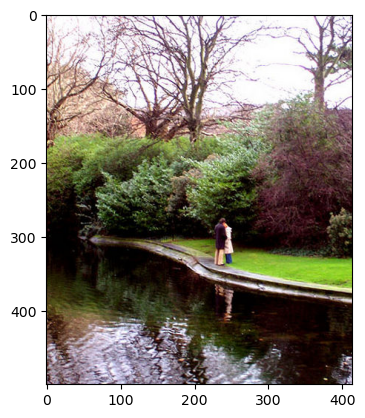

In [12]:
import numpy as np
from PIL import Image
import os
from keras.applications.xception import Xception
from pickle import load
import matplotlib.pyplot as plt

def extract_features(filename, model):
        try:
            image = Image.open(filename)
            
        except:
            print("ERROR: Couldn't open image! Make sure the image path and extension is correct")
        image = image.resize((299,299))
        image = np.array(image)
        # for images that has 4 channels, we convert them into 3 channels
        if image.shape[2] == 4: 
            image = image[..., :3]
        image = np.expand_dims(image, axis=0)
        image = image/127.5
        image = image - 1.0
        feature = model.predict(image)
        print(feature)
        return feature

# Load the pre-trained Xception model
xception_model = Xception(weights='imagenet', include_top=False, pooling='avg')

# Example usage:

img_path = "/mnt/c/Users/sbboo/OneDrive/Desktop/ICG/Flickr8k_Dataset/3637013_c675de7705.jpg"
image = Image.open(img_path)
features = extract_features(img_path, xception_model)
if features is not None:
    print("Feature extraction successful:", features.shape)
else:
    print("Feature extraction failed")
plt.imshow(image)

In [ ]:
import tkinter as tk
from tkinter import filedialog
from PIL import Image, ImageTk
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.applications.xception import Xception
from keras.models import load_model
from pickle import load

# Function to extract features from an image
def extract_features(filename, model):
    try:
        image = Image.open(filename)
    except:
        show_error_message("Error", "Couldn't open image! Make sure the image path and extension are correct.")
        return None
    image = image.resize((299, 299))
    image = np.array(image)
    if image.shape[2] == 4:  # Convert 4-channel images to 3 channels
        image = image[..., :3]
    image = np.expand_dims(image, axis=0)
    image = image / 127.5
    image = image - 1.0
    feature = model.predict(image)
    return feature

# Function to map an integer to a word
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

# Function to generate description for an image
def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo, sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'end':
            break
    return in_text

# Function to display error message in a separate window
def show_error_message(title, message):
    error_window = tk.Toplevel(root)
    error_window.title(title)
    error_label = tk.Label(error_window, text=message, padx=10, pady=10)
    error_label.pack()

# Load tokenizer
try:
    tokenizer = load(open("tokenizer.p", "rb"))
except Exception as e:
    show_error_message("Error", "Couldn't load tokenizer file!\nError: " + str(e))
    exit()

# Load model
try:
    model = load_model('models/model_4.keras')
except Exception as e:
    show_error_message("Error", "Couldn't load model file!\nError: " + str(e))
    exit()

# Load Xception model for feature extraction
xception_model = Xception(weights='imagenet', include_top=False, pooling="avg")

# Set maximum sequence length
max_length = 78

# Function to open an image and display its description
def open_image():
    file_path = filedialog.askopenfilename()
    if file_path:
        image = Image.open(file_path)
        photo = ImageTk.PhotoImage(image)
        image_label.config(image=photo)
        image_label.image = photo  # Keep reference to avoid garbage collection
        
        # Extract features for the selected image
        features = extract_features(file_path, xception_model)
        if features is not None:
            # Generate description for the selected image
            description = generate_desc(model, tokenizer, features, max_length)
            # Update the label with the generated description
            string_label.config(text="Selected Image: " + description)

# Create main application window
root = tk.Tk()
root.title("Image Caption Generator")

# Create a label to display the image
image_label = tk.Label(root)
image_label.pack(padx=10, pady=10)

# Create a label to display the string
string_label = tk.Label(root, text="Selected Image: None", wraplength=400)
string_label.pack(pady=5)

# Create a button to open the file dialog
open_button = tk.Button(root, text="Open Image", command=open_image)
open_button.pack(pady=5)

# Run the Tkinter event loop
root.mainloop()


1/1 [==============================] - 0s 34ms/step
